# K-Fold CV for Boosting Methods Using SKLearn 

In [9]:
#Importing required libraries
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
import wfdb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from numpy import mean
from numpy import absolute
from numpy import sqrt
import pandas as pd
import random
import statistics

In [10]:
import xgboost as xgb
from sklearn import metrics
from lightgbm import LGBMClassifier

import lightgbm
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 70 #display 70 dpi in Jupyter Notebook, may consider100 dpi 
plt.rcParams['savefig.dpi'] = 300 #define 300 dpi for saving figures

import seaborn as sns
## here are some settings 
sns.set_style('whitegrid')
sns.set(rc={"figure.dpi":70, 'savefig.dpi':300}) #defining dpi setting
sns.set_context('notebook')
sns.set_style("ticks")
from IPython.display import set_matplotlib_formats

### To load sklearn dataset
sklearn.datasets.load_breast_cancer(*, return_X_y=False, as_frame=False)[source]¶

Load and return the breast cancer wisconsin dataset (classification).

In [12]:
#data = load_breast_cancer(as_frame = True); 
#df = data.frame; 
#print(df.shape)
# In this block use the code we looked at on 6/30 as a reference to save our rr-intervals as a .
rlist = []
records = 'mit-bih-raw\RECORDS' # Replace the _______ with the name of the records file in your MIT-BIH data folder
with open(records) as rfile: #Then we open the file 
                             #The 'with' command only opens the file while we are in it. Automatically closes the file when we're not
    for record in rfile:  # Then we iterate through the lines in the file
        record = record[0:len(record)-1] # Remove any erronious new line characters at the end ('\n')
        rlist.append(record) # Then build an array with it
        

###### Step 1: Initialize all Arrays
             # Below, replace all of the ___ with the command that declares an array/list
             # hint: https://stackoverflow.com/questions/1514553/how-to-declare-an-array-in-python
samples = [] # will house the samples of all subjects
good_list = [] # will list the names of the subjects we successfully extracted
bad_list = [] # will house the names of the subjects we failed to extract
qrs = [] # will house the indices of R-Peaks for all subjects
atr_label = [] # will house the labels for each rhythm annotation for all subjects
atr_locs = [] # will house the locations corresponding to the rhythm annotation labels


###### Step 2: Extract Information
for x in tqdm(rlist): #this will iterate through te records that we found above
  
    try: # A try statement will run the except statement if for some reason the try commands fail
         # In this case I use the try statement because one of the subjects has no signal data causing failure
         # I then use bad_list and good_list so that all of the indices in rlist match with the arrays we initialized in Step 1, above
        ######################################################
            # Below find the wfdb function that will return the information that is described below 
        # Then replace _____ with the correct function call
        samp = wfdb.rdsamp('mit-bih-raw/'+x) # wfdb._____(file_location) will read the signal & header data and return a 2 value array
            # samp[0] - the signal data is the raw reading from the ecg. Each value is a sample taken.
            # samp[1] - the header data includes things about the signal data such as:
              # samples per section, denoted 'fs'
              # number of signals, denoted 'n_sig'
            
        ######################################################
        samples.append(samp) #add it to our array for all subject
            #What is our file extension that has the annotation we want? Find it here and replace _____ with it 
            #hint: READ THE VARIABLE NAMES!!!!
        qrs_tmp = wfdb.rdann('mit-bih-raw/'+x, extension='qrs') #extract the QRS Info
        qrs_locs = np.array(qrs_tmp.sample, dtype='int') #Get just the loccation of R-Peaks from the QRS Info
        qrs.append(qrs_locs) # Add to our array for all subjects
        
            #Do the same thing here
        atr = wfdb.rdann('mit-bih-raw/'+x,extension='atr') #extract the atr info which stores the rhythm type(s) over the whole signal
        atr_label.append(atr.aux_note) # aux_note stores the type of rhythm - main two are '(N' for normal and '(AFIB' for AFIB
        atr_locs.append(np.append(atr.sample, len(samp[0]))) #I add the length of the whole sample to the end for better visualization later
        
        good_list.append(x) # when all extraction is successful append the record name to good_list
    except Exception as exep:
        print(exep) # Alert the user of an exception
        bad_list.append(x) # add to the bad list

        

  0%|          | 0/25 [00:00<?, ?it/s]

sampto must be greater than sampfrom
sampto must be greater than sampfrom


100%|██████████| 25/25 [00:21<00:00,  1.17it/s]


In [13]:
features_df_list = []
for subject in good_list:
    data = pd.read_csv(f'subject-features-dataframes-v2/subject{subject}.csv')
    data = data.assign(Subject = subject)
    #print(data)
    features_df_list.append(data)
#features_maindf = pd.concat(features_df_list, ignore_index = True)

In [14]:
#df.head(5)
# df.info()
# df.describe()
#features_df_list[0]
counter = 0
testing_arr = []
training_arr = []
for subject in features_df_list:
    if counter != 22:
        training_arr.append(subject)
    else:
        testing_arr.append(subject)
    counter += 1
    
print(len(training_arr))

22


In [15]:
features_maindf = pd.concat(features_df_list, ignore_index = True)
print(features_maindf.columns)

Index(['Unnamed: 0', 'StoS', 'StoR', 'StoL', 'RtoS', 'RtoR', 'RtoL', 'LtoS',
       'LtoR', 'LtoL', 'STD', 'CoefVar', 'Range', 'Volatility', 'ShEn',
       'AppEn', 'SampEn', 'IQR', 'Var', 'Rmean_Var', 'Trans_Vol1',
       'Trans_Vol2', 'Rhythm', 'Subject'],
      dtype='object')


# CatBoosting

In [16]:
# https://catboost.ai/en/docs/concepts/python-quickstart
import catboost as cb
from catboost import CatBoostClassifier


print ('catboost version', cb.__version__)

catboost version 1.0.6


0:	learn: 0.6162908	total: 4.39ms	remaining: 457ms
1:	learn: 0.5535456	total: 8.17ms	remaining: 421ms
2:	learn: 0.5006991	total: 11.7ms	remaining: 397ms
3:	learn: 0.4556473	total: 15.3ms	remaining: 386ms
4:	learn: 0.4168442	total: 18.7ms	remaining: 374ms
5:	learn: 0.3841750	total: 21.9ms	remaining: 361ms
6:	learn: 0.3552590	total: 25ms	remaining: 351ms
7:	learn: 0.3299412	total: 28.3ms	remaining: 344ms
8:	learn: 0.3079267	total: 31.6ms	remaining: 338ms
9:	learn: 0.2879759	total: 35ms	remaining: 332ms
10:	learn: 0.2707337	total: 38.3ms	remaining: 327ms
11:	learn: 0.2548095	total: 41.5ms	remaining: 322ms
12:	learn: 0.2408187	total: 44.8ms	remaining: 317ms
13:	learn: 0.2287592	total: 48ms	remaining: 312ms
14:	learn: 0.2179644	total: 51.1ms	remaining: 307ms
15:	learn: 0.2082532	total: 54.3ms	remaining: 302ms
16:	learn: 0.1997884	total: 57.5ms	remaining: 298ms
17:	learn: 0.1915330	total: 60.6ms	remaining: 293ms
18:	learn: 0.1844304	total: 63.9ms	remaining: 289ms
19:	learn: 0.1784240	total: 

58:	learn: 0.1096050	total: 241ms	remaining: 188ms
59:	learn: 0.1092378	total: 245ms	remaining: 184ms
60:	learn: 0.1086223	total: 248ms	remaining: 179ms
61:	learn: 0.1079389	total: 252ms	remaining: 174ms
62:	learn: 0.1076001	total: 254ms	remaining: 170ms
63:	learn: 0.1073290	total: 257ms	remaining: 165ms
64:	learn: 0.1068753	total: 261ms	remaining: 160ms
65:	learn: 0.1065435	total: 263ms	remaining: 156ms
66:	learn: 0.1063217	total: 266ms	remaining: 151ms
67:	learn: 0.1057856	total: 270ms	remaining: 147ms
68:	learn: 0.1055703	total: 273ms	remaining: 142ms
69:	learn: 0.1052373	total: 276ms	remaining: 138ms
70:	learn: 0.1050458	total: 278ms	remaining: 133ms
71:	learn: 0.1047276	total: 281ms	remaining: 129ms
72:	learn: 0.1044480	total: 284ms	remaining: 125ms
73:	learn: 0.1041179	total: 287ms	remaining: 120ms
74:	learn: 0.1036707	total: 290ms	remaining: 116ms
75:	learn: 0.1032081	total: 294ms	remaining: 112ms
76:	learn: 0.1029661	total: 296ms	remaining: 108ms
77:	learn: 0.1026472	total: 299

59:	learn: 0.0932566	total: 211ms	remaining: 158ms
60:	learn: 0.0929409	total: 214ms	remaining: 155ms
61:	learn: 0.0927789	total: 217ms	remaining: 151ms
62:	learn: 0.0923921	total: 221ms	remaining: 147ms
63:	learn: 0.0919482	total: 225ms	remaining: 144ms
64:	learn: 0.0914821	total: 228ms	remaining: 140ms
65:	learn: 0.0913122	total: 233ms	remaining: 138ms
66:	learn: 0.0908643	total: 237ms	remaining: 134ms
67:	learn: 0.0904342	total: 241ms	remaining: 131ms
68:	learn: 0.0902318	total: 246ms	remaining: 128ms
69:	learn: 0.0897713	total: 250ms	remaining: 125ms
70:	learn: 0.0894652	total: 253ms	remaining: 121ms
71:	learn: 0.0891194	total: 257ms	remaining: 118ms
72:	learn: 0.0889535	total: 261ms	remaining: 114ms
73:	learn: 0.0887679	total: 265ms	remaining: 111ms
74:	learn: 0.0885208	total: 268ms	remaining: 107ms
75:	learn: 0.0882088	total: 272ms	remaining: 104ms
76:	learn: 0.0879954	total: 276ms	remaining: 100ms
77:	learn: 0.0878090	total: 280ms	remaining: 96.8ms
78:	learn: 0.0874050	total: 28

49:	learn: 0.1096969	total: 245ms	remaining: 284ms
50:	learn: 0.1090986	total: 250ms	remaining: 279ms
51:	learn: 0.1085940	total: 254ms	remaining: 273ms
52:	learn: 0.1079776	total: 258ms	remaining: 268ms
53:	learn: 0.1075323	total: 263ms	remaining: 263ms
54:	learn: 0.1069183	total: 268ms	remaining: 258ms
55:	learn: 0.1065436	total: 272ms	remaining: 253ms
56:	learn: 0.1060625	total: 276ms	remaining: 247ms
57:	learn: 0.1054748	total: 281ms	remaining: 242ms
58:	learn: 0.1049601	total: 286ms	remaining: 237ms
59:	learn: 0.1045467	total: 290ms	remaining: 232ms
60:	learn: 0.1042317	total: 294ms	remaining: 226ms
61:	learn: 0.1038843	total: 298ms	remaining: 221ms
62:	learn: 0.1033034	total: 302ms	remaining: 215ms
63:	learn: 0.1028616	total: 306ms	remaining: 210ms
64:	learn: 0.1023600	total: 310ms	remaining: 205ms
65:	learn: 0.1019122	total: 314ms	remaining: 200ms
66:	learn: 0.1016440	total: 318ms	remaining: 195ms
67:	learn: 0.1014333	total: 323ms	remaining: 190ms
68:	learn: 0.1012368	total: 327

0:	learn: 0.6153046	total: 34.1ms	remaining: 3.65s
1:	learn: 0.5499146	total: 47ms	remaining: 2.49s
2:	learn: 0.4966338	total: 56.2ms	remaining: 1.97s
3:	learn: 0.4505606	total: 63.2ms	remaining: 1.64s
4:	learn: 0.4111108	total: 69.6ms	remaining: 1.43s
5:	learn: 0.3773832	total: 75.4ms	remaining: 1.28s
6:	learn: 0.3486989	total: 80.4ms	remaining: 1.16s
7:	learn: 0.3228977	total: 85.3ms	remaining: 1.06s
8:	learn: 0.3005681	total: 89.8ms	remaining: 987ms
9:	learn: 0.2805269	total: 94ms	remaining: 921ms
10:	learn: 0.2625379	total: 98.1ms	remaining: 865ms
11:	learn: 0.2470285	total: 102ms	remaining: 818ms
12:	learn: 0.2329034	total: 106ms	remaining: 778ms
13:	learn: 0.2206050	total: 111ms	remaining: 742ms
14:	learn: 0.2096914	total: 115ms	remaining: 711ms
15:	learn: 0.1998893	total: 119ms	remaining: 684ms
16:	learn: 0.1908952	total: 123ms	remaining: 658ms
17:	learn: 0.1835296	total: 127ms	remaining: 635ms
18:	learn: 0.1760407	total: 131ms	remaining: 614ms
19:	learn: 0.1694021	total: 135ms	

90:	learn: 0.0816453	total: 474ms	remaining: 88.6ms
91:	learn: 0.0815482	total: 479ms	remaining: 83.2ms
92:	learn: 0.0813685	total: 483ms	remaining: 77.9ms
93:	learn: 0.0811187	total: 487ms	remaining: 72.6ms
94:	learn: 0.0809111	total: 492ms	remaining: 67.3ms
95:	learn: 0.0806823	total: 496ms	remaining: 62ms
96:	learn: 0.0805973	total: 500ms	remaining: 56.7ms
97:	learn: 0.0803825	total: 504ms	remaining: 51.4ms
98:	learn: 0.0802755	total: 507ms	remaining: 46.1ms
99:	learn: 0.0800360	total: 512ms	remaining: 40.9ms
100:	learn: 0.0798920	total: 516ms	remaining: 35.7ms
101:	learn: 0.0796930	total: 520ms	remaining: 30.6ms
102:	learn: 0.0795375	total: 524ms	remaining: 25.4ms
103:	learn: 0.0792943	total: 528ms	remaining: 20.3ms
104:	learn: 0.0791873	total: 532ms	remaining: 15.2ms
105:	learn: 0.0790046	total: 536ms	remaining: 10.1ms
106:	learn: 0.0788496	total: 540ms	remaining: 5.05ms
107:	learn: 0.0786711	total: 544ms	remaining: 0us
0:	learn: 0.6177646	total: 5.71ms	remaining: 610ms
1:	learn: 

49:	learn: 0.1096969	total: 210ms	remaining: 240ms
50:	learn: 0.1090986	total: 214ms	remaining: 236ms
51:	learn: 0.1085940	total: 219ms	remaining: 232ms
52:	learn: 0.1079776	total: 224ms	remaining: 228ms
53:	learn: 0.1075323	total: 228ms	remaining: 224ms
54:	learn: 0.1069183	total: 232ms	remaining: 220ms
55:	learn: 0.1065436	total: 236ms	remaining: 215ms
56:	learn: 0.1060625	total: 241ms	remaining: 211ms
57:	learn: 0.1054748	total: 245ms	remaining: 207ms
58:	learn: 0.1049601	total: 249ms	remaining: 202ms
59:	learn: 0.1045467	total: 253ms	remaining: 198ms
60:	learn: 0.1042317	total: 257ms	remaining: 194ms
61:	learn: 0.1038843	total: 261ms	remaining: 190ms
62:	learn: 0.1033034	total: 266ms	remaining: 185ms
63:	learn: 0.1028616	total: 270ms	remaining: 181ms
64:	learn: 0.1023600	total: 274ms	remaining: 177ms
65:	learn: 0.1019122	total: 278ms	remaining: 173ms
66:	learn: 0.1016440	total: 282ms	remaining: 168ms
67:	learn: 0.1014333	total: 286ms	remaining: 164ms
68:	learn: 0.1012368	total: 290

14:	learn: 0.2096914	total: 121ms	remaining: 740ms
15:	learn: 0.1998893	total: 125ms	remaining: 712ms
16:	learn: 0.1908952	total: 130ms	remaining: 687ms
17:	learn: 0.1835296	total: 135ms	remaining: 666ms
18:	learn: 0.1760407	total: 140ms	remaining: 647ms
19:	learn: 0.1694021	total: 144ms	remaining: 628ms
20:	learn: 0.1636189	total: 148ms	remaining: 608ms
21:	learn: 0.1582029	total: 153ms	remaining: 590ms
22:	learn: 0.1534023	total: 157ms	remaining: 572ms
23:	learn: 0.1488262	total: 161ms	remaining: 556ms
24:	learn: 0.1451367	total: 165ms	remaining: 541ms
25:	learn: 0.1414724	total: 169ms	remaining: 527ms
26:	learn: 0.1381895	total: 173ms	remaining: 514ms
27:	learn: 0.1350695	total: 178ms	remaining: 501ms
28:	learn: 0.1325972	total: 182ms	remaining: 489ms
29:	learn: 0.1298991	total: 186ms	remaining: 477ms
30:	learn: 0.1277480	total: 190ms	remaining: 466ms
31:	learn: 0.1257001	total: 194ms	remaining: 455ms
32:	learn: 0.1239603	total: 199ms	remaining: 445ms
33:	learn: 0.1218072	total: 203

99:	learn: 0.0800360	total: 410ms	remaining: 28.7ms
100:	learn: 0.0798920	total: 414ms	remaining: 24.6ms
101:	learn: 0.0796930	total: 419ms	remaining: 20.5ms
102:	learn: 0.0795375	total: 423ms	remaining: 16.4ms
103:	learn: 0.0792943	total: 427ms	remaining: 12.3ms
104:	learn: 0.0791873	total: 431ms	remaining: 8.21ms
105:	learn: 0.0790046	total: 435ms	remaining: 4.11ms
106:	learn: 0.0788496	total: 439ms	remaining: 0us
0:	learn: 0.6177646	total: 33.5ms	remaining: 3.55s
1:	learn: 0.5570749	total: 55.4ms	remaining: 2.91s
2:	learn: 0.5042569	total: 68.2ms	remaining: 2.36s
3:	learn: 0.4609540	total: 76.9ms	remaining: 1.98s
4:	learn: 0.4239197	total: 83.8ms	remaining: 1.71s
5:	learn: 0.3904888	total: 90.3ms	remaining: 1.52s
6:	learn: 0.3635342	total: 95.9ms	remaining: 1.37s
7:	learn: 0.3382763	total: 101ms	remaining: 1.25s
8:	learn: 0.3169304	total: 106ms	remaining: 1.15s
9:	learn: 0.2981584	total: 110ms	remaining: 1.07s
10:	learn: 0.2810652	total: 115ms	remaining: 1s
11:	learn: 0.2662159	tota

70:	learn: 0.1024667	total: 248ms	remaining: 119ms
71:	learn: 0.1021140	total: 252ms	remaining: 115ms
72:	learn: 0.1019505	total: 255ms	remaining: 112ms
73:	learn: 0.1016648	total: 258ms	remaining: 108ms
74:	learn: 0.1014403	total: 261ms	remaining: 104ms
75:	learn: 0.1009965	total: 264ms	remaining: 101ms
76:	learn: 0.1007531	total: 267ms	remaining: 97.2ms
77:	learn: 0.1004509	total: 270ms	remaining: 93.6ms
78:	learn: 0.1000187	total: 273ms	remaining: 90ms
79:	learn: 0.0998175	total: 277ms	remaining: 86.4ms
80:	learn: 0.0994318	total: 280ms	remaining: 82.8ms
81:	learn: 0.0991871	total: 282ms	remaining: 79.2ms
82:	learn: 0.0988774	total: 285ms	remaining: 75.7ms
83:	learn: 0.0986148	total: 288ms	remaining: 72.1ms
84:	learn: 0.0983956	total: 292ms	remaining: 68.6ms
85:	learn: 0.0982827	total: 294ms	remaining: 65.1ms
86:	learn: 0.0979409	total: 298ms	remaining: 61.6ms
87:	learn: 0.0975643	total: 301ms	remaining: 58.1ms
88:	learn: 0.0972559	total: 303ms	remaining: 54.6ms
89:	learn: 0.0969472

27:	learn: 0.1374290	total: 96.6ms	remaining: 266ms
28:	learn: 0.1347845	total: 100ms	remaining: 262ms
29:	learn: 0.1321884	total: 104ms	remaining: 259ms
30:	learn: 0.1298992	total: 107ms	remaining: 256ms
31:	learn: 0.1277023	total: 111ms	remaining: 253ms
32:	learn: 0.1258035	total: 114ms	remaining: 249ms
33:	learn: 0.1241578	total: 118ms	remaining: 246ms
34:	learn: 0.1227032	total: 121ms	remaining: 243ms
35:	learn: 0.1213754	total: 125ms	remaining: 240ms
36:	learn: 0.1202559	total: 128ms	remaining: 236ms
37:	learn: 0.1187173	total: 131ms	remaining: 231ms
38:	learn: 0.1176534	total: 135ms	remaining: 228ms
39:	learn: 0.1165738	total: 138ms	remaining: 224ms
40:	learn: 0.1155902	total: 141ms	remaining: 220ms
41:	learn: 0.1145799	total: 144ms	remaining: 216ms
42:	learn: 0.1135784	total: 147ms	remaining: 212ms
43:	learn: 0.1128863	total: 150ms	remaining: 208ms
44:	learn: 0.1121458	total: 153ms	remaining: 204ms
45:	learn: 0.1112912	total: 156ms	remaining: 200ms
46:	learn: 0.1105003	total: 16

97:	learn: 0.0827318	total: 352ms	remaining: 25.1ms
98:	learn: 0.0825348	total: 355ms	remaining: 21.5ms
99:	learn: 0.0823577	total: 359ms	remaining: 17.9ms
100:	learn: 0.0820944	total: 362ms	remaining: 14.3ms
101:	learn: 0.0819347	total: 366ms	remaining: 10.8ms
102:	learn: 0.0816232	total: 369ms	remaining: 7.17ms
103:	learn: 0.0814460	total: 373ms	remaining: 3.58ms
104:	learn: 0.0813599	total: 376ms	remaining: 0us
0:	learn: 0.6182926	total: 31.6ms	remaining: 3.29s
1:	learn: 0.5565083	total: 48.3ms	remaining: 2.48s
2:	learn: 0.5051804	total: 57.3ms	remaining: 1.95s
3:	learn: 0.4621517	total: 64.3ms	remaining: 1.62s
4:	learn: 0.4250052	total: 70ms	remaining: 1.4s
5:	learn: 0.3920861	total: 75ms	remaining: 1.24s
6:	learn: 0.3639837	total: 79.4ms	remaining: 1.11s
7:	learn: 0.3396241	total: 83.7ms	remaining: 1.01s
8:	learn: 0.3182697	total: 87.6ms	remaining: 934ms
9:	learn: 0.2995484	total: 91.1ms	remaining: 866ms
10:	learn: 0.2828623	total: 94.6ms	remaining: 809ms
11:	learn: 0.2675882	tota

94:	learn: 0.0957826	total: 361ms	remaining: 53.2ms
95:	learn: 0.0956684	total: 364ms	remaining: 49.3ms
96:	learn: 0.0954876	total: 368ms	remaining: 45.5ms
97:	learn: 0.0952747	total: 371ms	remaining: 41.6ms
98:	learn: 0.0949636	total: 374ms	remaining: 37.8ms
99:	learn: 0.0948196	total: 377ms	remaining: 33.9ms
100:	learn: 0.0945749	total: 380ms	remaining: 30.1ms
101:	learn: 0.0943671	total: 383ms	remaining: 26.3ms
102:	learn: 0.0940944	total: 386ms	remaining: 22.5ms
103:	learn: 0.0938107	total: 390ms	remaining: 18.7ms
104:	learn: 0.0936480	total: 392ms	remaining: 15ms
105:	learn: 0.0935536	total: 395ms	remaining: 11.2ms
106:	learn: 0.0934001	total: 398ms	remaining: 7.44ms
107:	learn: 0.0932235	total: 401ms	remaining: 3.71ms
108:	learn: 0.0931361	total: 404ms	remaining: 0us
0:	learn: 0.6163586	total: 27.8ms	remaining: 3s
1:	learn: 0.5536411	total: 44.7ms	remaining: 2.39s
2:	learn: 0.5018289	total: 57.8ms	remaining: 2.04s
3:	learn: 0.4578306	total: 66ms	remaining: 1.73s
4:	learn: 0.41987

74:	learn: 0.0988272	total: 312ms	remaining: 141ms
75:	learn: 0.0984440	total: 316ms	remaining: 137ms
76:	learn: 0.0982573	total: 319ms	remaining: 132ms
77:	learn: 0.0978688	total: 323ms	remaining: 128ms
78:	learn: 0.0976029	total: 326ms	remaining: 124ms
79:	learn: 0.0972435	total: 330ms	remaining: 119ms
80:	learn: 0.0970249	total: 333ms	remaining: 115ms
81:	learn: 0.0966234	total: 337ms	remaining: 111ms
82:	learn: 0.0964352	total: 340ms	remaining: 107ms
83:	learn: 0.0961038	total: 344ms	remaining: 102ms
84:	learn: 0.0960043	total: 347ms	remaining: 98ms
85:	learn: 0.0959098	total: 350ms	remaining: 93.6ms
86:	learn: 0.0957302	total: 353ms	remaining: 89.3ms
87:	learn: 0.0954504	total: 357ms	remaining: 85.2ms
88:	learn: 0.0952259	total: 360ms	remaining: 81ms
89:	learn: 0.0951140	total: 363ms	remaining: 76.7ms
90:	learn: 0.0948381	total: 366ms	remaining: 72.5ms
91:	learn: 0.0946276	total: 369ms	remaining: 68.3ms
92:	learn: 0.0945093	total: 373ms	remaining: 64.2ms
93:	learn: 0.0943122	total

58:	learn: 0.1249687	total: 209ms	remaining: 177ms
59:	learn: 0.1245476	total: 213ms	remaining: 174ms
60:	learn: 0.1238156	total: 216ms	remaining: 170ms
61:	learn: 0.1234509	total: 219ms	remaining: 166ms
62:	learn: 0.1230593	total: 225ms	remaining: 164ms
63:	learn: 0.1226430	total: 229ms	remaining: 161ms
64:	learn: 0.1222080	total: 233ms	remaining: 158ms
65:	learn: 0.1218288	total: 237ms	remaining: 154ms
66:	learn: 0.1213975	total: 240ms	remaining: 150ms
67:	learn: 0.1210603	total: 243ms	remaining: 147ms
68:	learn: 0.1208860	total: 247ms	remaining: 143ms
69:	learn: 0.1203744	total: 250ms	remaining: 139ms
70:	learn: 0.1200358	total: 253ms	remaining: 136ms
71:	learn: 0.1198160	total: 256ms	remaining: 132ms
72:	learn: 0.1193278	total: 259ms	remaining: 128ms
73:	learn: 0.1191174	total: 263ms	remaining: 124ms
74:	learn: 0.1187289	total: 266ms	remaining: 121ms
75:	learn: 0.1184356	total: 270ms	remaining: 117ms
76:	learn: 0.1182064	total: 273ms	remaining: 113ms
77:	learn: 0.1177868	total: 276

24:	learn: 0.1515983	total: 267ms	remaining: 866ms
25:	learn: 0.1482015	total: 274ms	remaining: 843ms
26:	learn: 0.1446376	total: 281ms	remaining: 823ms
27:	learn: 0.1413936	total: 288ms	remaining: 803ms
28:	learn: 0.1389261	total: 295ms	remaining: 783ms
29:	learn: 0.1361758	total: 302ms	remaining: 765ms
30:	learn: 0.1338280	total: 309ms	remaining: 747ms
31:	learn: 0.1313373	total: 316ms	remaining: 731ms
32:	learn: 0.1293810	total: 323ms	remaining: 714ms
33:	learn: 0.1275948	total: 329ms	remaining: 698ms
34:	learn: 0.1257803	total: 336ms	remaining: 683ms
35:	learn: 0.1240563	total: 344ms	remaining: 669ms
36:	learn: 0.1223711	total: 351ms	remaining: 654ms
37:	learn: 0.1211827	total: 358ms	remaining: 640ms
38:	learn: 0.1200089	total: 364ms	remaining: 626ms
39:	learn: 0.1189283	total: 371ms	remaining: 611ms
40:	learn: 0.1180833	total: 377ms	remaining: 597ms
41:	learn: 0.1167920	total: 383ms	remaining: 584ms
42:	learn: 0.1158468	total: 390ms	remaining: 571ms
43:	learn: 0.1149029	total: 396

95:	learn: 0.0882196	total: 679ms	remaining: 70.8ms
96:	learn: 0.0881275	total: 686ms	remaining: 63.6ms
97:	learn: 0.0879481	total: 693ms	remaining: 56.6ms
98:	learn: 0.0878223	total: 700ms	remaining: 49.5ms
99:	learn: 0.0877198	total: 706ms	remaining: 42.4ms
100:	learn: 0.0875167	total: 713ms	remaining: 35.3ms
101:	learn: 0.0871881	total: 719ms	remaining: 28.2ms
102:	learn: 0.0870595	total: 725ms	remaining: 21.1ms
103:	learn: 0.0868840	total: 731ms	remaining: 14.1ms
104:	learn: 0.0867710	total: 738ms	remaining: 7.02ms
105:	learn: 0.0866270	total: 744ms	remaining: 0us
0:	learn: 0.6125331	total: 49.5ms	remaining: 5.2s
1:	learn: 0.5477429	total: 71ms	remaining: 3.69s
2:	learn: 0.4934048	total: 88.2ms	remaining: 3.03s
3:	learn: 0.4466287	total: 101ms	remaining: 2.58s
4:	learn: 0.4059973	total: 112ms	remaining: 2.26s
5:	learn: 0.3708647	total: 121ms	remaining: 2.01s
6:	learn: 0.3416379	total: 168ms	remaining: 2.37s
7:	learn: 0.3147488	total: 189ms	remaining: 2.31s
8:	learn: 0.2920371	total

64:	learn: 0.1170385	total: 477ms	remaining: 301ms
65:	learn: 0.1166632	total: 483ms	remaining: 293ms
66:	learn: 0.1164104	total: 490ms	remaining: 285ms
67:	learn: 0.1159826	total: 496ms	remaining: 277ms
68:	learn: 0.1155379	total: 503ms	remaining: 270ms
69:	learn: 0.1152303	total: 509ms	remaining: 262ms
70:	learn: 0.1149414	total: 515ms	remaining: 254ms
71:	learn: 0.1147479	total: 521ms	remaining: 246ms
72:	learn: 0.1142336	total: 528ms	remaining: 239ms
73:	learn: 0.1138485	total: 534ms	remaining: 231ms
74:	learn: 0.1133085	total: 540ms	remaining: 223ms
75:	learn: 0.1131711	total: 546ms	remaining: 216ms
76:	learn: 0.1127173	total: 552ms	remaining: 208ms
77:	learn: 0.1124475	total: 558ms	remaining: 200ms
78:	learn: 0.1120651	total: 565ms	remaining: 193ms
79:	learn: 0.1117559	total: 571ms	remaining: 186ms
80:	learn: 0.1113853	total: 578ms	remaining: 178ms
81:	learn: 0.1109953	total: 585ms	remaining: 171ms
82:	learn: 0.1105820	total: 592ms	remaining: 164ms
83:	learn: 0.1102694	total: 598

36:	learn: 0.1223711	total: 317ms	remaining: 583ms
37:	learn: 0.1211827	total: 324ms	remaining: 571ms
38:	learn: 0.1200089	total: 331ms	remaining: 560ms
39:	learn: 0.1189283	total: 338ms	remaining: 549ms
40:	learn: 0.1180833	total: 345ms	remaining: 538ms
41:	learn: 0.1167920	total: 352ms	remaining: 528ms
42:	learn: 0.1158468	total: 359ms	remaining: 518ms
43:	learn: 0.1149029	total: 366ms	remaining: 508ms
44:	learn: 0.1138606	total: 373ms	remaining: 497ms
45:	learn: 0.1127628	total: 380ms	remaining: 487ms
46:	learn: 0.1121190	total: 386ms	remaining: 477ms
47:	learn: 0.1111512	total: 393ms	remaining: 467ms
48:	learn: 0.1104151	total: 400ms	remaining: 457ms
49:	learn: 0.1098667	total: 407ms	remaining: 447ms
50:	learn: 0.1091397	total: 414ms	remaining: 438ms
51:	learn: 0.1083164	total: 420ms	remaining: 429ms
52:	learn: 0.1078282	total: 427ms	remaining: 419ms
53:	learn: 0.1072105	total: 434ms	remaining: 410ms
54:	learn: 0.1068963	total: 440ms	remaining: 400ms
55:	learn: 0.1061252	total: 447

0:	learn: 0.6125331	total: 7.81ms	remaining: 812ms
1:	learn: 0.5477429	total: 15.3ms	remaining: 786ms
2:	learn: 0.4934048	total: 22.7ms	remaining: 771ms
3:	learn: 0.4466287	total: 29.7ms	remaining: 749ms
4:	learn: 0.4059973	total: 36.7ms	remaining: 735ms
5:	learn: 0.3708647	total: 43.5ms	remaining: 718ms
6:	learn: 0.3416379	total: 49.9ms	remaining: 698ms
7:	learn: 0.3147488	total: 56.1ms	remaining: 680ms
8:	learn: 0.2920371	total: 60.2ms	remaining: 642ms
9:	learn: 0.2713124	total: 66.6ms	remaining: 632ms
10:	learn: 0.2530845	total: 73ms	remaining: 624ms
11:	learn: 0.2367312	total: 79.3ms	remaining: 615ms
12:	learn: 0.2223510	total: 85.5ms	remaining: 605ms
13:	learn: 0.2098001	total: 91.8ms	remaining: 597ms
14:	learn: 0.1984080	total: 98.1ms	remaining: 588ms
15:	learn: 0.1881649	total: 104ms	remaining: 581ms
16:	learn: 0.1792122	total: 111ms	remaining: 575ms
17:	learn: 0.1707304	total: 117ms	remaining: 567ms
18:	learn: 0.1634252	total: 124ms	remaining: 559ms
19:	learn: 0.1571109	total: 

77:	learn: 0.1124475	total: 540ms	remaining: 187ms
78:	learn: 0.1120651	total: 546ms	remaining: 180ms
79:	learn: 0.1117559	total: 553ms	remaining: 173ms
80:	learn: 0.1113853	total: 560ms	remaining: 166ms
81:	learn: 0.1109953	total: 567ms	remaining: 159ms
82:	learn: 0.1105820	total: 574ms	remaining: 152ms
83:	learn: 0.1102694	total: 581ms	remaining: 145ms
84:	learn: 0.1099251	total: 587ms	remaining: 138ms
85:	learn: 0.1095301	total: 593ms	remaining: 131ms
86:	learn: 0.1091157	total: 600ms	remaining: 124ms
87:	learn: 0.1089752	total: 606ms	remaining: 117ms
88:	learn: 0.1087411	total: 612ms	remaining: 110ms
89:	learn: 0.1085784	total: 618ms	remaining: 103ms
90:	learn: 0.1082732	total: 624ms	remaining: 96ms
91:	learn: 0.1081549	total: 630ms	remaining: 89.1ms
92:	learn: 0.1077799	total: 636ms	remaining: 82.1ms
93:	learn: 0.1075258	total: 644ms	remaining: 75.3ms
94:	learn: 0.1073387	total: 650ms	remaining: 68.4ms
95:	learn: 0.1070307	total: 656ms	remaining: 61.5ms
96:	learn: 0.1069239	total:

59:	learn: 0.1069200	total: 336ms	remaining: 258ms
60:	learn: 0.1063026	total: 342ms	remaining: 252ms
61:	learn: 0.1059192	total: 346ms	remaining: 246ms
62:	learn: 0.1054981	total: 351ms	remaining: 239ms
63:	learn: 0.1052069	total: 355ms	remaining: 233ms
64:	learn: 0.1048997	total: 359ms	remaining: 227ms
65:	learn: 0.1043731	total: 364ms	remaining: 220ms
66:	learn: 0.1038518	total: 368ms	remaining: 214ms
67:	learn: 0.1034381	total: 372ms	remaining: 208ms
68:	learn: 0.1031088	total: 376ms	remaining: 202ms
69:	learn: 0.1026402	total: 381ms	remaining: 196ms
70:	learn: 0.1023307	total: 385ms	remaining: 190ms
71:	learn: 0.1019647	total: 388ms	remaining: 183ms
72:	learn: 0.1016400	total: 392ms	remaining: 177ms
73:	learn: 0.1013066	total: 396ms	remaining: 171ms
74:	learn: 0.1009282	total: 401ms	remaining: 166ms
75:	learn: 0.1004791	total: 405ms	remaining: 160ms
76:	learn: 0.1000885	total: 409ms	remaining: 154ms
77:	learn: 0.0996962	total: 413ms	remaining: 148ms
78:	learn: 0.0995730	total: 417

12:	learn: 0.2225441	total: 81.8ms	remaining: 585ms
13:	learn: 0.2098321	total: 86.5ms	remaining: 568ms
14:	learn: 0.1984396	total: 90.9ms	remaining: 551ms
15:	learn: 0.1882470	total: 95.6ms	remaining: 537ms
16:	learn: 0.1795175	total: 99.8ms	remaining: 522ms
17:	learn: 0.1713242	total: 104ms	remaining: 508ms
18:	learn: 0.1642465	total: 108ms	remaining: 496ms
19:	learn: 0.1581339	total: 112ms	remaining: 483ms
20:	learn: 0.1523171	total: 116ms	remaining: 471ms
21:	learn: 0.1471506	total: 121ms	remaining: 460ms
22:	learn: 0.1423619	total: 125ms	remaining: 450ms
23:	learn: 0.1380650	total: 129ms	remaining: 440ms
24:	learn: 0.1340821	total: 133ms	remaining: 431ms
25:	learn: 0.1301947	total: 137ms	remaining: 422ms
26:	learn: 0.1271458	total: 141ms	remaining: 413ms
27:	learn: 0.1243786	total: 145ms	remaining: 404ms
28:	learn: 0.1215249	total: 149ms	remaining: 396ms
29:	learn: 0.1190106	total: 153ms	remaining: 388ms
30:	learn: 0.1167189	total: 157ms	remaining: 380ms
31:	learn: 0.1147054	total

101:	learn: 0.1083188	total: 419ms	remaining: 16.4ms
102:	learn: 0.1081513	total: 423ms	remaining: 12.3ms
103:	learn: 0.1079127	total: 427ms	remaining: 8.21ms
104:	learn: 0.1078250	total: 431ms	remaining: 4.11ms
105:	learn: 0.1075930	total: 436ms	remaining: 0us
0:	learn: 0.6160718	total: 33.2ms	remaining: 3.45s
1:	learn: 0.5528163	total: 51.2ms	remaining: 2.63s
2:	learn: 0.5006554	total: 70.3ms	remaining: 2.39s
3:	learn: 0.4547924	total: 83.2ms	remaining: 2.1s
4:	learn: 0.4160928	total: 91.9ms	remaining: 1.84s
5:	learn: 0.3833085	total: 99ms	remaining: 1.63s
6:	learn: 0.3544165	total: 105ms	remaining: 1.47s
7:	learn: 0.3287311	total: 111ms	remaining: 1.34s
8:	learn: 0.3064103	total: 116ms	remaining: 1.24s
9:	learn: 0.2861835	total: 121ms	remaining: 1.15s
10:	learn: 0.2685649	total: 125ms	remaining: 1.07s
11:	learn: 0.2531470	total: 129ms	remaining: 1s
12:	learn: 0.2389615	total: 134ms	remaining: 945ms
13:	learn: 0.2264761	total: 138ms	remaining: 894ms
14:	learn: 0.2160124	total: 142ms	

52:	learn: 0.1104470	total: 225ms	remaining: 221ms
53:	learn: 0.1099014	total: 229ms	remaining: 216ms
54:	learn: 0.1094197	total: 234ms	remaining: 212ms
55:	learn: 0.1089373	total: 238ms	remaining: 208ms
56:	learn: 0.1081750	total: 242ms	remaining: 204ms
57:	learn: 0.1075129	total: 246ms	remaining: 199ms
58:	learn: 0.1072725	total: 250ms	remaining: 195ms
59:	learn: 0.1069200	total: 254ms	remaining: 191ms
60:	learn: 0.1063026	total: 258ms	remaining: 186ms
61:	learn: 0.1059192	total: 263ms	remaining: 182ms
62:	learn: 0.1054981	total: 267ms	remaining: 178ms
63:	learn: 0.1052069	total: 271ms	remaining: 173ms
64:	learn: 0.1048997	total: 275ms	remaining: 169ms
65:	learn: 0.1043731	total: 279ms	remaining: 165ms
66:	learn: 0.1038518	total: 283ms	remaining: 160ms
67:	learn: 0.1034381	total: 286ms	remaining: 156ms
68:	learn: 0.1031088	total: 290ms	remaining: 151ms
69:	learn: 0.1026402	total: 294ms	remaining: 147ms
70:	learn: 0.1023307	total: 298ms	remaining: 143ms
71:	learn: 0.1019647	total: 302

29:	learn: 0.1190106	total: 220ms	remaining: 551ms
30:	learn: 0.1167189	total: 226ms	remaining: 539ms
31:	learn: 0.1147054	total: 231ms	remaining: 526ms
32:	learn: 0.1130140	total: 235ms	remaining: 513ms
33:	learn: 0.1114186	total: 239ms	remaining: 500ms
34:	learn: 0.1097141	total: 243ms	remaining: 487ms
35:	learn: 0.1083579	total: 248ms	remaining: 475ms
36:	learn: 0.1070473	total: 252ms	remaining: 463ms
37:	learn: 0.1056271	total: 256ms	remaining: 452ms
38:	learn: 0.1048053	total: 260ms	remaining: 440ms
39:	learn: 0.1034772	total: 264ms	remaining: 429ms
40:	learn: 0.1025361	total: 268ms	remaining: 418ms
41:	learn: 0.1014022	total: 272ms	remaining: 408ms
42:	learn: 0.1004491	total: 276ms	remaining: 398ms
43:	learn: 0.0997524	total: 280ms	remaining: 388ms
44:	learn: 0.0988464	total: 284ms	remaining: 379ms
45:	learn: 0.0982024	total: 288ms	remaining: 370ms
46:	learn: 0.0975665	total: 292ms	remaining: 361ms
47:	learn: 0.0968906	total: 296ms	remaining: 352ms
48:	learn: 0.0960829	total: 300

102:	learn: 0.1081513	total: 462ms	remaining: 8.98ms
103:	learn: 0.1079127	total: 467ms	remaining: 4.49ms
104:	learn: 0.1078250	total: 471ms	remaining: 0us
0:	learn: 0.6160718	total: 6.94ms	remaining: 749ms
1:	learn: 0.5528163	total: 9.94ms	remaining: 532ms
2:	learn: 0.5006554	total: 13.9ms	remaining: 493ms
3:	learn: 0.4547924	total: 18.1ms	remaining: 476ms
4:	learn: 0.4160928	total: 22.2ms	remaining: 461ms
5:	learn: 0.3833085	total: 26.2ms	remaining: 450ms
6:	learn: 0.3544165	total: 30.4ms	remaining: 442ms
7:	learn: 0.3287311	total: 34.8ms	remaining: 440ms
8:	learn: 0.3064103	total: 39.5ms	remaining: 439ms
9:	learn: 0.2861835	total: 43.5ms	remaining: 431ms
10:	learn: 0.2685649	total: 47.6ms	remaining: 424ms
11:	learn: 0.2531470	total: 51.6ms	remaining: 417ms
12:	learn: 0.2389615	total: 55.9ms	remaining: 412ms
13:	learn: 0.2264761	total: 59.9ms	remaining: 406ms
14:	learn: 0.2160124	total: 64.1ms	remaining: 402ms
15:	learn: 0.2057946	total: 68.2ms	remaining: 397ms
16:	learn: 0.1966855	t

69:	learn: 0.1026402	total: 295ms	remaining: 165ms
70:	learn: 0.1023307	total: 300ms	remaining: 160ms
71:	learn: 0.1019647	total: 304ms	remaining: 156ms
72:	learn: 0.1016400	total: 308ms	remaining: 152ms
73:	learn: 0.1013066	total: 313ms	remaining: 148ms
74:	learn: 0.1009282	total: 317ms	remaining: 144ms
75:	learn: 0.1004791	total: 321ms	remaining: 140ms
76:	learn: 0.1000885	total: 325ms	remaining: 135ms
77:	learn: 0.0996962	total: 330ms	remaining: 131ms
78:	learn: 0.0995730	total: 334ms	remaining: 127ms
79:	learn: 0.0992248	total: 338ms	remaining: 122ms
80:	learn: 0.0990739	total: 342ms	remaining: 118ms
81:	learn: 0.0990103	total: 346ms	remaining: 114ms
82:	learn: 0.0987443	total: 350ms	remaining: 109ms
83:	learn: 0.0984954	total: 354ms	remaining: 105ms
84:	learn: 0.0982064	total: 358ms	remaining: 101ms
85:	learn: 0.0977779	total: 362ms	remaining: 96.7ms
86:	learn: 0.0973867	total: 366ms	remaining: 92.5ms
87:	learn: 0.0969118	total: 370ms	remaining: 88.3ms
88:	learn: 0.0966359	total: 

29:	learn: 0.1190106	total: 129ms	remaining: 339ms
30:	learn: 0.1167189	total: 133ms	remaining: 336ms
31:	learn: 0.1147054	total: 138ms	remaining: 332ms
32:	learn: 0.1130140	total: 142ms	remaining: 328ms
33:	learn: 0.1114186	total: 146ms	remaining: 323ms
34:	learn: 0.1097141	total: 151ms	remaining: 318ms
35:	learn: 0.1083579	total: 155ms	remaining: 314ms
36:	learn: 0.1070473	total: 159ms	remaining: 309ms
37:	learn: 0.1056271	total: 163ms	remaining: 304ms
38:	learn: 0.1048053	total: 167ms	remaining: 300ms
39:	learn: 0.1034772	total: 171ms	remaining: 295ms
40:	learn: 0.1025361	total: 175ms	remaining: 290ms
41:	learn: 0.1014022	total: 179ms	remaining: 286ms
42:	learn: 0.1004491	total: 183ms	remaining: 281ms
43:	learn: 0.0997524	total: 187ms	remaining: 276ms
44:	learn: 0.0988464	total: 191ms	remaining: 272ms
45:	learn: 0.0982024	total: 195ms	remaining: 267ms
46:	learn: 0.0975665	total: 199ms	remaining: 263ms
47:	learn: 0.0968906	total: 203ms	remaining: 258ms
48:	learn: 0.0960829	total: 207

104:	learn: 0.1078250	total: 460ms	remaining: 17.5ms
105:	learn: 0.1075930	total: 465ms	remaining: 13.2ms
106:	learn: 0.1074451	total: 469ms	remaining: 8.77ms
107:	learn: 0.1073515	total: 473ms	remaining: 4.38ms
108:	learn: 0.1070651	total: 477ms	remaining: 0us
0:	learn: 0.6157812	total: 61.7ms	remaining: 6.47s
1:	learn: 0.5533271	total: 95.8ms	remaining: 4.98s
2:	learn: 0.5015089	total: 113ms	remaining: 3.88s
3:	learn: 0.4567675	total: 125ms	remaining: 3.19s
4:	learn: 0.4169857	total: 135ms	remaining: 2.72s
5:	learn: 0.3829044	total: 143ms	remaining: 2.38s
6:	learn: 0.3533128	total: 151ms	remaining: 2.13s
7:	learn: 0.3276228	total: 159ms	remaining: 1.94s
8:	learn: 0.3056765	total: 165ms	remaining: 1.78s
9:	learn: 0.2860088	total: 171ms	remaining: 1.65s
10:	learn: 0.2684961	total: 178ms	remaining: 1.54s
11:	learn: 0.2526751	total: 185ms	remaining: 1.45s
12:	learn: 0.2384779	total: 192ms	remaining: 1.37s
13:	learn: 0.2263840	total: 198ms	remaining: 1.3s
14:	learn: 0.2155843	total: 205ms

61:	learn: 0.1066809	total: 515ms	remaining: 365ms
62:	learn: 0.1063251	total: 522ms	remaining: 356ms
63:	learn: 0.1057253	total: 528ms	remaining: 347ms
64:	learn: 0.1053800	total: 535ms	remaining: 338ms
65:	learn: 0.1049392	total: 542ms	remaining: 329ms
66:	learn: 0.1044822	total: 549ms	remaining: 319ms
67:	learn: 0.1041782	total: 555ms	remaining: 310ms
68:	learn: 0.1037300	total: 561ms	remaining: 301ms
69:	learn: 0.1032633	total: 568ms	remaining: 292ms
70:	learn: 0.1029746	total: 574ms	remaining: 283ms
71:	learn: 0.1027012	total: 581ms	remaining: 274ms
72:	learn: 0.1023226	total: 587ms	remaining: 265ms
73:	learn: 0.1020841	total: 594ms	remaining: 257ms
74:	learn: 0.1016527	total: 600ms	remaining: 248ms
75:	learn: 0.1013912	total: 606ms	remaining: 239ms
76:	learn: 0.1010068	total: 613ms	remaining: 231ms
77:	learn: 0.1006948	total: 619ms	remaining: 222ms
78:	learn: 0.1002503	total: 626ms	remaining: 214ms
79:	learn: 0.0999856	total: 632ms	remaining: 205ms
80:	learn: 0.0997726	total: 639

13:	learn: 0.2364306	total: 69.1ms	remaining: 449ms
14:	learn: 0.2258394	total: 72.4ms	remaining: 435ms
15:	learn: 0.2163422	total: 75.7ms	remaining: 421ms
16:	learn: 0.2079891	total: 79.2ms	remaining: 410ms
17:	learn: 0.2002020	total: 82.5ms	remaining: 399ms
18:	learn: 0.1937449	total: 85.4ms	remaining: 387ms
19:	learn: 0.1873217	total: 88.5ms	remaining: 376ms
20:	learn: 0.1815310	total: 91.8ms	remaining: 367ms
21:	learn: 0.1759462	total: 94.7ms	remaining: 357ms
22:	learn: 0.1713920	total: 97.6ms	remaining: 348ms
23:	learn: 0.1671857	total: 101ms	remaining: 340ms
24:	learn: 0.1636996	total: 104ms	remaining: 331ms
25:	learn: 0.1597567	total: 107ms	remaining: 324ms
26:	learn: 0.1560753	total: 110ms	remaining: 317ms
27:	learn: 0.1533498	total: 113ms	remaining: 309ms
28:	learn: 0.1504059	total: 116ms	remaining: 303ms
29:	learn: 0.1476940	total: 119ms	remaining: 297ms
30:	learn: 0.1453990	total: 122ms	remaining: 291ms
31:	learn: 0.1428468	total: 125ms	remaining: 284ms
32:	learn: 0.1409204	

102:	learn: 0.0928800	total: 317ms	remaining: 6.15ms
103:	learn: 0.0927519	total: 320ms	remaining: 3.08ms
104:	learn: 0.0925394	total: 323ms	remaining: 0us
0:	learn: 0.6135313	total: 8.63ms	remaining: 898ms
1:	learn: 0.5480616	total: 11.7ms	remaining: 602ms
2:	learn: 0.4951093	total: 14.8ms	remaining: 504ms
3:	learn: 0.4497215	total: 17.9ms	remaining: 453ms
4:	learn: 0.4099620	total: 21.1ms	remaining: 421ms
5:	learn: 0.3764093	total: 24.1ms	remaining: 397ms
6:	learn: 0.3462249	total: 27.1ms	remaining: 380ms
7:	learn: 0.3205593	total: 30ms	remaining: 364ms
8:	learn: 0.2973446	total: 33ms	remaining: 352ms
9:	learn: 0.2774549	total: 36ms	remaining: 342ms
10:	learn: 0.2598917	total: 39ms	remaining: 333ms
11:	learn: 0.2438437	total: 42ms	remaining: 326ms
12:	learn: 0.2296398	total: 45ms	remaining: 319ms
13:	learn: 0.2175080	total: 48ms	remaining: 312ms
14:	learn: 0.2063531	total: 51.1ms	remaining: 306ms
15:	learn: 0.1964751	total: 54.2ms	remaining: 301ms
16:	learn: 0.1882425	total: 57.3ms	r

58:	learn: 0.1300189	total: 230ms	remaining: 180ms
59:	learn: 0.1294471	total: 234ms	remaining: 175ms
60:	learn: 0.1291299	total: 237ms	remaining: 171ms
61:	learn: 0.1286226	total: 240ms	remaining: 166ms
62:	learn: 0.1279968	total: 243ms	remaining: 162ms
63:	learn: 0.1277504	total: 246ms	remaining: 158ms
64:	learn: 0.1272686	total: 249ms	remaining: 153ms
65:	learn: 0.1267242	total: 252ms	remaining: 149ms
66:	learn: 0.1262312	total: 256ms	remaining: 145ms
67:	learn: 0.1258323	total: 258ms	remaining: 141ms
68:	learn: 0.1255356	total: 261ms	remaining: 136ms
69:	learn: 0.1251354	total: 264ms	remaining: 132ms
70:	learn: 0.1248292	total: 267ms	remaining: 128ms
71:	learn: 0.1245478	total: 270ms	remaining: 124ms
72:	learn: 0.1239735	total: 273ms	remaining: 120ms
73:	learn: 0.1237577	total: 276ms	remaining: 116ms
74:	learn: 0.1234290	total: 279ms	remaining: 112ms
75:	learn: 0.1230763	total: 282ms	remaining: 108ms
76:	learn: 0.1228952	total: 285ms	remaining: 104ms
77:	learn: 0.1224058	total: 288

9:	learn: 0.2924764	total: 119ms	remaining: 1.16s
10:	learn: 0.2753907	total: 123ms	remaining: 1.09s
11:	learn: 0.2602159	total: 128ms	remaining: 1.02s
12:	learn: 0.2466807	total: 132ms	remaining: 968ms
13:	learn: 0.2346547	total: 137ms	remaining: 917ms
14:	learn: 0.2238637	total: 141ms	remaining: 871ms
15:	learn: 0.2141919	total: 145ms	remaining: 834ms
16:	learn: 0.2056898	total: 149ms	remaining: 799ms
17:	learn: 0.1984350	total: 153ms	remaining: 766ms
18:	learn: 0.1912963	total: 157ms	remaining: 737ms
19:	learn: 0.1850133	total: 161ms	remaining: 711ms
20:	learn: 0.1790793	total: 166ms	remaining: 686ms
21:	learn: 0.1736828	total: 170ms	remaining: 663ms
22:	learn: 0.1689878	total: 174ms	remaining: 642ms
23:	learn: 0.1647890	total: 178ms	remaining: 622ms
24:	learn: 0.1607388	total: 182ms	remaining: 603ms
25:	learn: 0.1568892	total: 186ms	remaining: 585ms
26:	learn: 0.1534003	total: 190ms	remaining: 569ms
27:	learn: 0.1499392	total: 194ms	remaining: 554ms
28:	learn: 0.1472222	total: 198m

92:	learn: 0.0921950	total: 452ms	remaining: 72.8ms
93:	learn: 0.0919739	total: 457ms	remaining: 68ms
94:	learn: 0.0917671	total: 461ms	remaining: 63.1ms
95:	learn: 0.0915789	total: 467ms	remaining: 58.3ms
96:	learn: 0.0913966	total: 472ms	remaining: 53.5ms
97:	learn: 0.0911922	total: 476ms	remaining: 48.6ms
98:	learn: 0.0908598	total: 481ms	remaining: 43.7ms
99:	learn: 0.0906753	total: 486ms	remaining: 38.9ms
100:	learn: 0.0905761	total: 490ms	remaining: 34ms
101:	learn: 0.0903835	total: 494ms	remaining: 29.1ms
102:	learn: 0.0901664	total: 499ms	remaining: 24.2ms
103:	learn: 0.0899881	total: 503ms	remaining: 19.4ms
104:	learn: 0.0898276	total: 507ms	remaining: 14.5ms
105:	learn: 0.0896806	total: 512ms	remaining: 9.66ms
106:	learn: 0.0893883	total: 516ms	remaining: 4.83ms
107:	learn: 0.0892412	total: 521ms	remaining: 0us
0:	learn: 0.6136347	total: 6.69ms	remaining: 716ms
1:	learn: 0.5484882	total: 9.98ms	remaining: 529ms
2:	learn: 0.4933880	total: 14.4ms	remaining: 503ms
3:	learn: 0.44

52:	learn: 0.1295844	total: 219ms	remaining: 228ms
53:	learn: 0.1290495	total: 224ms	remaining: 224ms
54:	learn: 0.1285213	total: 228ms	remaining: 220ms
55:	learn: 0.1278466	total: 232ms	remaining: 216ms
56:	learn: 0.1271842	total: 237ms	remaining: 212ms
57:	learn: 0.1267895	total: 241ms	remaining: 208ms
58:	learn: 0.1261978	total: 246ms	remaining: 204ms
59:	learn: 0.1258931	total: 250ms	remaining: 200ms
60:	learn: 0.1253011	total: 255ms	remaining: 196ms
61:	learn: 0.1247952	total: 259ms	remaining: 192ms
62:	learn: 0.1244099	total: 263ms	remaining: 188ms
63:	learn: 0.1240967	total: 267ms	remaining: 184ms
64:	learn: 0.1236180	total: 271ms	remaining: 179ms
65:	learn: 0.1232320	total: 275ms	remaining: 175ms
66:	learn: 0.1229577	total: 279ms	remaining: 171ms
67:	learn: 0.1225258	total: 283ms	remaining: 166ms
68:	learn: 0.1222626	total: 287ms	remaining: 162ms
69:	learn: 0.1218143	total: 291ms	remaining: 158ms
70:	learn: 0.1212367	total: 295ms	remaining: 154ms
71:	learn: 0.1208688	total: 299

1:	learn: 0.5550593	total: 25.4ms	remaining: 1.33s
2:	learn: 0.5023576	total: 33.4ms	remaining: 1.16s
3:	learn: 0.4577791	total: 40.2ms	remaining: 1.03s
4:	learn: 0.4201748	total: 45.8ms	remaining: 934ms
5:	learn: 0.3878265	total: 51.1ms	remaining: 861ms
6:	learn: 0.3598068	total: 55.7ms	remaining: 795ms
7:	learn: 0.3343199	total: 60ms	remaining: 742ms
8:	learn: 0.3119701	total: 64.4ms	remaining: 702ms
9:	learn: 0.2924764	total: 68.6ms	remaining: 665ms
10:	learn: 0.2753907	total: 72.5ms	remaining: 633ms
11:	learn: 0.2602159	total: 76.6ms	remaining: 606ms
12:	learn: 0.2466807	total: 80.5ms	remaining: 582ms
13:	learn: 0.2346547	total: 84.5ms	remaining: 561ms
14:	learn: 0.2238637	total: 88.5ms	remaining: 543ms
15:	learn: 0.2141919	total: 92.6ms	remaining: 527ms
16:	learn: 0.2056898	total: 96.6ms	remaining: 512ms
17:	learn: 0.1984350	total: 101ms	remaining: 498ms
18:	learn: 0.1912963	total: 105ms	remaining: 485ms
19:	learn: 0.1850133	total: 109ms	remaining: 473ms
20:	learn: 0.1790793	total

62:	learn: 0.1001224	total: 332ms	remaining: 232ms
63:	learn: 0.0997074	total: 337ms	remaining: 226ms
64:	learn: 0.0993498	total: 341ms	remaining: 220ms
65:	learn: 0.0989600	total: 345ms	remaining: 215ms
66:	learn: 0.0985964	total: 349ms	remaining: 209ms
67:	learn: 0.0982957	total: 353ms	remaining: 203ms
68:	learn: 0.0980116	total: 358ms	remaining: 197ms
69:	learn: 0.0976960	total: 362ms	remaining: 191ms
70:	learn: 0.0973977	total: 366ms	remaining: 185ms
71:	learn: 0.0969357	total: 370ms	remaining: 180ms
72:	learn: 0.0966314	total: 374ms	remaining: 174ms
73:	learn: 0.0964008	total: 378ms	remaining: 168ms
74:	learn: 0.0961277	total: 382ms	remaining: 163ms
75:	learn: 0.0958551	total: 386ms	remaining: 157ms
76:	learn: 0.0955090	total: 390ms	remaining: 152ms
77:	learn: 0.0953394	total: 393ms	remaining: 146ms
78:	learn: 0.0950991	total: 397ms	remaining: 141ms
79:	learn: 0.0949380	total: 401ms	remaining: 135ms
80:	learn: 0.0947485	total: 405ms	remaining: 130ms
81:	learn: 0.0944752	total: 409

22:	learn: 0.1794831	total: 99.4ms	remaining: 363ms
23:	learn: 0.1752818	total: 104ms	remaining: 359ms
24:	learn: 0.1711372	total: 108ms	remaining: 356ms
25:	learn: 0.1675331	total: 113ms	remaining: 351ms
26:	learn: 0.1642674	total: 117ms	remaining: 346ms
27:	learn: 0.1613788	total: 121ms	remaining: 342ms
28:	learn: 0.1587654	total: 125ms	remaining: 336ms
29:	learn: 0.1564946	total: 129ms	remaining: 331ms
30:	learn: 0.1549308	total: 133ms	remaining: 326ms
31:	learn: 0.1529819	total: 137ms	remaining: 321ms
32:	learn: 0.1508127	total: 141ms	remaining: 316ms
33:	learn: 0.1487092	total: 145ms	remaining: 312ms
34:	learn: 0.1470473	total: 149ms	remaining: 307ms
35:	learn: 0.1459071	total: 153ms	remaining: 303ms
36:	learn: 0.1444280	total: 157ms	remaining: 298ms
37:	learn: 0.1430476	total: 161ms	remaining: 293ms
38:	learn: 0.1416519	total: 165ms	remaining: 288ms
39:	learn: 0.1404417	total: 169ms	remaining: 284ms
40:	learn: 0.1392357	total: 173ms	remaining: 279ms
41:	learn: 0.1384729	total: 17

1:	learn: 0.5556961	total: 28.9ms	remaining: 1.49s
2:	learn: 0.5035828	total: 36.8ms	remaining: 1.25s
3:	learn: 0.4588709	total: 43.1ms	remaining: 1.09s
4:	learn: 0.4216506	total: 48.5ms	remaining: 970ms
5:	learn: 0.3880503	total: 52.9ms	remaining: 872ms
6:	learn: 0.3594744	total: 56.2ms	remaining: 787ms
7:	learn: 0.3350622	total: 59.3ms	remaining: 719ms
8:	learn: 0.3132880	total: 62.3ms	remaining: 664ms
9:	learn: 0.2942449	total: 65.3ms	remaining: 620ms
10:	learn: 0.2769529	total: 68.4ms	remaining: 584ms
11:	learn: 0.2618998	total: 71.5ms	remaining: 554ms
12:	learn: 0.2483192	total: 74.5ms	remaining: 527ms
13:	learn: 0.2364306	total: 77.5ms	remaining: 504ms
14:	learn: 0.2258394	total: 80.5ms	remaining: 483ms
15:	learn: 0.2163422	total: 83.5ms	remaining: 464ms
16:	learn: 0.2079891	total: 86.5ms	remaining: 448ms
17:	learn: 0.2002020	total: 89.5ms	remaining: 432ms
18:	learn: 0.1937449	total: 92.4ms	remaining: 418ms
19:	learn: 0.1873217	total: 95.6ms	remaining: 406ms
20:	learn: 0.1815310	

86:	learn: 0.0958118	total: 267ms	remaining: 55.2ms
87:	learn: 0.0956508	total: 270ms	remaining: 52.2ms
88:	learn: 0.0954262	total: 274ms	remaining: 49.2ms
89:	learn: 0.0952951	total: 277ms	remaining: 46.1ms
90:	learn: 0.0950199	total: 280ms	remaining: 43.1ms
91:	learn: 0.0947683	total: 284ms	remaining: 40.1ms
92:	learn: 0.0945977	total: 287ms	remaining: 37ms
93:	learn: 0.0945408	total: 289ms	remaining: 33.9ms
94:	learn: 0.0943944	total: 293ms	remaining: 30.8ms
95:	learn: 0.0941989	total: 296ms	remaining: 27.7ms
96:	learn: 0.0940639	total: 299ms	remaining: 24.6ms
97:	learn: 0.0938850	total: 302ms	remaining: 21.5ms
98:	learn: 0.0936430	total: 305ms	remaining: 18.5ms
99:	learn: 0.0934141	total: 308ms	remaining: 15.4ms
100:	learn: 0.0931980	total: 311ms	remaining: 12.3ms
101:	learn: 0.0931000	total: 314ms	remaining: 9.23ms
102:	learn: 0.0928800	total: 317ms	remaining: 6.16ms
103:	learn: 0.0927519	total: 320ms	remaining: 3.08ms
104:	learn: 0.0925394	total: 323ms	remaining: 0us
0:	learn: 0.

44:	learn: 0.1388996	total: 144ms	remaining: 192ms
45:	learn: 0.1379248	total: 147ms	remaining: 189ms
46:	learn: 0.1369929	total: 151ms	remaining: 186ms
47:	learn: 0.1360445	total: 154ms	remaining: 183ms
48:	learn: 0.1352993	total: 157ms	remaining: 180ms
49:	learn: 0.1346895	total: 160ms	remaining: 176ms
50:	learn: 0.1343436	total: 163ms	remaining: 172ms
51:	learn: 0.1337386	total: 166ms	remaining: 169ms
52:	learn: 0.1332977	total: 169ms	remaining: 166ms
53:	learn: 0.1330493	total: 172ms	remaining: 163ms
54:	learn: 0.1324036	total: 175ms	remaining: 159ms
55:	learn: 0.1316440	total: 178ms	remaining: 156ms
56:	learn: 0.1309876	total: 181ms	remaining: 153ms
57:	learn: 0.1306909	total: 184ms	remaining: 149ms
58:	learn: 0.1300189	total: 187ms	remaining: 146ms
59:	learn: 0.1294471	total: 190ms	remaining: 142ms
60:	learn: 0.1291299	total: 193ms	remaining: 139ms
61:	learn: 0.1286226	total: 196ms	remaining: 136ms
62:	learn: 0.1279968	total: 199ms	remaining: 132ms
63:	learn: 0.1277504	total: 201

14:	learn: 0.2258394	total: 52.1ms	remaining: 326ms
15:	learn: 0.2163422	total: 55.5ms	remaining: 323ms
16:	learn: 0.2079891	total: 58.8ms	remaining: 318ms
17:	learn: 0.2002020	total: 62.1ms	remaining: 314ms
18:	learn: 0.1937449	total: 67.5ms	remaining: 320ms
19:	learn: 0.1873217	total: 71.2ms	remaining: 317ms
20:	learn: 0.1815310	total: 74.7ms	remaining: 313ms
21:	learn: 0.1759462	total: 77.9ms	remaining: 308ms
22:	learn: 0.1713920	total: 81ms	remaining: 303ms
23:	learn: 0.1671857	total: 83.9ms	remaining: 297ms
24:	learn: 0.1636996	total: 86.9ms	remaining: 292ms
25:	learn: 0.1597567	total: 90.1ms	remaining: 288ms
26:	learn: 0.1560753	total: 93.3ms	remaining: 283ms
27:	learn: 0.1533498	total: 96.2ms	remaining: 278ms
28:	learn: 0.1504059	total: 99.2ms	remaining: 274ms
29:	learn: 0.1476940	total: 102ms	remaining: 269ms
30:	learn: 0.1453990	total: 105ms	remaining: 265ms
31:	learn: 0.1428468	total: 108ms	remaining: 260ms
32:	learn: 0.1409204	total: 111ms	remaining: 256ms
33:	learn: 0.13926

80:	learn: 0.0973034	total: 304ms	remaining: 105ms
81:	learn: 0.0969760	total: 307ms	remaining: 101ms
82:	learn: 0.0966159	total: 311ms	remaining: 97.4ms
83:	learn: 0.0963614	total: 314ms	remaining: 93.6ms
84:	learn: 0.0961539	total: 317ms	remaining: 89.6ms
85:	learn: 0.0959476	total: 320ms	remaining: 85.7ms
86:	learn: 0.0958118	total: 323ms	remaining: 81.7ms
87:	learn: 0.0956508	total: 326ms	remaining: 77.8ms
88:	learn: 0.0954262	total: 329ms	remaining: 74ms
89:	learn: 0.0952951	total: 332ms	remaining: 70.2ms
90:	learn: 0.0950199	total: 335ms	remaining: 66.4ms
91:	learn: 0.0947683	total: 338ms	remaining: 62.5ms
92:	learn: 0.0945977	total: 341ms	remaining: 58.7ms
93:	learn: 0.0945408	total: 344ms	remaining: 54.9ms
94:	learn: 0.0943944	total: 347ms	remaining: 51.2ms
95:	learn: 0.0941989	total: 350ms	remaining: 47.4ms
96:	learn: 0.0940639	total: 353ms	remaining: 43.7ms
97:	learn: 0.0938850	total: 356ms	remaining: 39.9ms
98:	learn: 0.0936430	total: 359ms	remaining: 36.2ms
99:	learn: 0.093

28:	learn: 0.1633128	total: 129ms	remaining: 355ms
29:	learn: 0.1607811	total: 132ms	remaining: 348ms
30:	learn: 0.1586325	total: 136ms	remaining: 341ms
31:	learn: 0.1562278	total: 139ms	remaining: 334ms
32:	learn: 0.1542060	total: 142ms	remaining: 327ms
33:	learn: 0.1521616	total: 145ms	remaining: 320ms
34:	learn: 0.1502122	total: 148ms	remaining: 313ms
35:	learn: 0.1488621	total: 152ms	remaining: 307ms
36:	learn: 0.1474535	total: 155ms	remaining: 301ms
37:	learn: 0.1462804	total: 158ms	remaining: 294ms
38:	learn: 0.1449071	total: 161ms	remaining: 289ms
39:	learn: 0.1439243	total: 164ms	remaining: 283ms
40:	learn: 0.1428743	total: 167ms	remaining: 277ms
41:	learn: 0.1417197	total: 170ms	remaining: 272ms
42:	learn: 0.1408713	total: 173ms	remaining: 266ms
43:	learn: 0.1398977	total: 176ms	remaining: 260ms
44:	learn: 0.1388996	total: 179ms	remaining: 255ms
45:	learn: 0.1379248	total: 182ms	remaining: 250ms
46:	learn: 0.1369929	total: 185ms	remaining: 244ms
47:	learn: 0.1360445	total: 188

102:	learn: 0.0892373	total: 752ms	remaining: 21.9ms
103:	learn: 0.0889479	total: 758ms	remaining: 14.6ms
104:	learn: 0.0887056	total: 765ms	remaining: 7.29ms
105:	learn: 0.0885665	total: 772ms	remaining: 0us
0:	learn: 0.6174861	total: 57.3ms	remaining: 6.01s
1:	learn: 0.5552436	total: 90.9ms	remaining: 4.73s
2:	learn: 0.5036410	total: 109ms	remaining: 3.76s
3:	learn: 0.4591486	total: 121ms	remaining: 3.09s
4:	learn: 0.4213725	total: 131ms	remaining: 2.64s
5:	learn: 0.3882538	total: 139ms	remaining: 2.31s
6:	learn: 0.3595542	total: 146ms	remaining: 2.06s
7:	learn: 0.3343553	total: 153ms	remaining: 1.88s
8:	learn: 0.3128476	total: 158ms	remaining: 1.7s
9:	learn: 0.2932430	total: 164ms	remaining: 1.58s
10:	learn: 0.2761063	total: 171ms	remaining: 1.47s
11:	learn: 0.2603244	total: 177ms	remaining: 1.39s
12:	learn: 0.2468163	total: 183ms	remaining: 1.31s
13:	learn: 0.2344390	total: 189ms	remaining: 1.24s
14:	learn: 0.2232226	total: 196ms	remaining: 1.19s
15:	learn: 0.2136361	total: 202ms	r

63:	learn: 0.0964413	total: 459ms	remaining: 301ms
64:	learn: 0.0959594	total: 466ms	remaining: 294ms
65:	learn: 0.0956438	total: 472ms	remaining: 286ms
66:	learn: 0.0953875	total: 479ms	remaining: 279ms
67:	learn: 0.0949143	total: 485ms	remaining: 271ms
68:	learn: 0.0946757	total: 491ms	remaining: 263ms
69:	learn: 0.0945061	total: 497ms	remaining: 255ms
70:	learn: 0.0942006	total: 503ms	remaining: 248ms
71:	learn: 0.0938330	total: 509ms	remaining: 241ms
72:	learn: 0.0936384	total: 515ms	remaining: 233ms
73:	learn: 0.0933815	total: 521ms	remaining: 225ms
74:	learn: 0.0932153	total: 527ms	remaining: 218ms
75:	learn: 0.0928098	total: 534ms	remaining: 211ms
76:	learn: 0.0925295	total: 540ms	remaining: 203ms
77:	learn: 0.0922904	total: 546ms	remaining: 196ms
78:	learn: 0.0920628	total: 552ms	remaining: 189ms
79:	learn: 0.0918533	total: 559ms	remaining: 182ms
80:	learn: 0.0915619	total: 565ms	remaining: 174ms
81:	learn: 0.0913792	total: 571ms	remaining: 167ms
82:	learn: 0.0910874	total: 578

36:	learn: 0.1403533	total: 351ms	remaining: 655ms
37:	learn: 0.1393386	total: 358ms	remaining: 640ms
38:	learn: 0.1381798	total: 365ms	remaining: 627ms
39:	learn: 0.1370958	total: 371ms	remaining: 612ms
40:	learn: 0.1361053	total: 377ms	remaining: 598ms
41:	learn: 0.1349140	total: 384ms	remaining: 585ms
42:	learn: 0.1340517	total: 390ms	remaining: 572ms
43:	learn: 0.1331578	total: 396ms	remaining: 559ms
44:	learn: 0.1320776	total: 403ms	remaining: 546ms
45:	learn: 0.1309902	total: 409ms	remaining: 534ms
46:	learn: 0.1302554	total: 415ms	remaining: 521ms
47:	learn: 0.1294179	total: 422ms	remaining: 509ms
48:	learn: 0.1284079	total: 428ms	remaining: 498ms
49:	learn: 0.1278547	total: 434ms	remaining: 486ms
50:	learn: 0.1273934	total: 440ms	remaining: 474ms
51:	learn: 0.1265118	total: 446ms	remaining: 463ms
52:	learn: 0.1259478	total: 453ms	remaining: 453ms
53:	learn: 0.1252926	total: 459ms	remaining: 442ms
54:	learn: 0.1247791	total: 465ms	remaining: 431ms
55:	learn: 0.1240923	total: 472

0:	learn: 0.6174861	total: 28.2ms	remaining: 2.94s
1:	learn: 0.5552436	total: 40.5ms	remaining: 2.08s
2:	learn: 0.5036410	total: 49.7ms	remaining: 1.69s
3:	learn: 0.4591486	total: 58.1ms	remaining: 1.47s
4:	learn: 0.4213725	total: 65.5ms	remaining: 1.31s
5:	learn: 0.3882538	total: 72.3ms	remaining: 1.19s
6:	learn: 0.3595542	total: 78.6ms	remaining: 1.1s
7:	learn: 0.3343553	total: 85ms	remaining: 1.03s
8:	learn: 0.3128476	total: 89.1ms	remaining: 950ms
9:	learn: 0.2932430	total: 95.3ms	remaining: 905ms
10:	learn: 0.2761063	total: 102ms	remaining: 868ms
11:	learn: 0.2603244	total: 108ms	remaining: 835ms
12:	learn: 0.2468163	total: 114ms	remaining: 807ms
13:	learn: 0.2344390	total: 120ms	remaining: 781ms
14:	learn: 0.2232226	total: 126ms	remaining: 758ms
15:	learn: 0.2136361	total: 133ms	remaining: 737ms
16:	learn: 0.2049717	total: 139ms	remaining: 718ms
17:	learn: 0.1970619	total: 145ms	remaining: 700ms
18:	learn: 0.1895467	total: 151ms	remaining: 684ms
19:	learn: 0.1828276	total: 157ms	

73:	learn: 0.0933815	total: 532ms	remaining: 223ms
74:	learn: 0.0932153	total: 538ms	remaining: 215ms
75:	learn: 0.0928098	total: 545ms	remaining: 208ms
76:	learn: 0.0925295	total: 552ms	remaining: 201ms
77:	learn: 0.0922904	total: 558ms	remaining: 193ms
78:	learn: 0.0920628	total: 564ms	remaining: 186ms
79:	learn: 0.0918533	total: 571ms	remaining: 178ms
80:	learn: 0.0915619	total: 577ms	remaining: 171ms
81:	learn: 0.0913792	total: 584ms	remaining: 164ms
82:	learn: 0.0910874	total: 591ms	remaining: 157ms
83:	learn: 0.0908966	total: 597ms	remaining: 149ms
84:	learn: 0.0906791	total: 603ms	remaining: 142ms
85:	learn: 0.0904753	total: 609ms	remaining: 135ms
86:	learn: 0.0902398	total: 615ms	remaining: 127ms
87:	learn: 0.0899346	total: 622ms	remaining: 120ms
88:	learn: 0.0897414	total: 628ms	remaining: 113ms
89:	learn: 0.0896009	total: 634ms	remaining: 106ms
90:	learn: 0.0893541	total: 640ms	remaining: 98.4ms
91:	learn: 0.0891568	total: 646ms	remaining: 91.3ms
92:	learn: 0.0889247	total: 6

35:	learn: 0.1419238	total: 321ms	remaining: 615ms
36:	learn: 0.1403533	total: 327ms	remaining: 602ms
37:	learn: 0.1393386	total: 334ms	remaining: 589ms
38:	learn: 0.1381798	total: 340ms	remaining: 576ms
39:	learn: 0.1370958	total: 347ms	remaining: 564ms
40:	learn: 0.1361053	total: 353ms	remaining: 551ms
41:	learn: 0.1349140	total: 360ms	remaining: 540ms
42:	learn: 0.1340517	total: 366ms	remaining: 528ms
43:	learn: 0.1331578	total: 373ms	remaining: 517ms
44:	learn: 0.1320776	total: 379ms	remaining: 505ms
45:	learn: 0.1309902	total: 385ms	remaining: 494ms
46:	learn: 0.1302554	total: 391ms	remaining: 483ms
47:	learn: 0.1294179	total: 397ms	remaining: 472ms
48:	learn: 0.1284079	total: 404ms	remaining: 461ms
49:	learn: 0.1278547	total: 410ms	remaining: 451ms
50:	learn: 0.1273934	total: 416ms	remaining: 440ms
51:	learn: 0.1265118	total: 422ms	remaining: 430ms
52:	learn: 0.1259478	total: 428ms	remaining: 420ms
53:	learn: 0.1252926	total: 434ms	remaining: 410ms
54:	learn: 0.1247791	total: 441

3:	learn: 0.4577791	total: 22.6ms	remaining: 577ms
4:	learn: 0.4201748	total: 27.5ms	remaining: 556ms
5:	learn: 0.3878265	total: 32.5ms	remaining: 542ms
6:	learn: 0.3598068	total: 37.1ms	remaining: 525ms
7:	learn: 0.3343199	total: 41.7ms	remaining: 511ms
8:	learn: 0.3119701	total: 46.2ms	remaining: 498ms
9:	learn: 0.2924764	total: 50.9ms	remaining: 489ms
10:	learn: 0.2753907	total: 55.4ms	remaining: 479ms
11:	learn: 0.2602159	total: 60ms	remaining: 470ms
12:	learn: 0.2466807	total: 64.4ms	remaining: 461ms
13:	learn: 0.2346547	total: 69ms	remaining: 453ms
14:	learn: 0.2238637	total: 73.4ms	remaining: 445ms
15:	learn: 0.2141919	total: 78ms	remaining: 439ms
16:	learn: 0.2056898	total: 82.7ms	remaining: 433ms
17:	learn: 0.1984350	total: 87.5ms	remaining: 428ms
18:	learn: 0.1912963	total: 92.1ms	remaining: 422ms
19:	learn: 0.1850133	total: 96.7ms	remaining: 416ms
20:	learn: 0.1790793	total: 101ms	remaining: 410ms
21:	learn: 0.1736828	total: 106ms	remaining: 403ms
22:	learn: 0.1689878	total:

70:	learn: 0.0973977	total: 360ms	remaining: 178ms
71:	learn: 0.0969357	total: 365ms	remaining: 172ms
72:	learn: 0.0966314	total: 369ms	remaining: 167ms
73:	learn: 0.0964008	total: 373ms	remaining: 161ms
74:	learn: 0.0961277	total: 377ms	remaining: 156ms
75:	learn: 0.0958551	total: 381ms	remaining: 150ms
76:	learn: 0.0955090	total: 385ms	remaining: 145ms
77:	learn: 0.0953394	total: 389ms	remaining: 140ms
78:	learn: 0.0950991	total: 393ms	remaining: 134ms
79:	learn: 0.0949380	total: 397ms	remaining: 129ms
80:	learn: 0.0947485	total: 401ms	remaining: 124ms
81:	learn: 0.0944752	total: 406ms	remaining: 119ms
82:	learn: 0.0941091	total: 410ms	remaining: 114ms
83:	learn: 0.0938641	total: 414ms	remaining: 108ms
84:	learn: 0.0936807	total: 417ms	remaining: 103ms
85:	learn: 0.0936164	total: 421ms	remaining: 98ms
86:	learn: 0.0934051	total: 425ms	remaining: 92.9ms
87:	learn: 0.0931391	total: 429ms	remaining: 87.8ms
88:	learn: 0.0930110	total: 433ms	remaining: 82.7ms
89:	learn: 0.0927942	total: 4

33:	learn: 0.1487092	total: 249ms	remaining: 526ms
34:	learn: 0.1470473	total: 253ms	remaining: 513ms
35:	learn: 0.1459071	total: 257ms	remaining: 500ms
36:	learn: 0.1444280	total: 262ms	remaining: 488ms
37:	learn: 0.1430476	total: 266ms	remaining: 475ms
38:	learn: 0.1416519	total: 270ms	remaining: 463ms
39:	learn: 0.1404417	total: 274ms	remaining: 452ms
40:	learn: 0.1392357	total: 278ms	remaining: 441ms
41:	learn: 0.1384729	total: 283ms	remaining: 431ms
42:	learn: 0.1375031	total: 286ms	remaining: 420ms
43:	learn: 0.1365497	total: 290ms	remaining: 409ms
44:	learn: 0.1357366	total: 294ms	remaining: 399ms
45:	learn: 0.1349638	total: 298ms	remaining: 389ms
46:	learn: 0.1343148	total: 302ms	remaining: 379ms
47:	learn: 0.1333795	total: 306ms	remaining: 370ms
48:	learn: 0.1323876	total: 310ms	remaining: 361ms
49:	learn: 0.1315969	total: 314ms	remaining: 352ms
50:	learn: 0.1308481	total: 318ms	remaining: 343ms
51:	learn: 0.1302179	total: 322ms	remaining: 334ms
52:	learn: 0.1295844	total: 326

0:	learn: 0.6174536	total: 29.5ms	remaining: 3.06s
1:	learn: 0.5550593	total: 52ms	remaining: 2.68s
2:	learn: 0.5023576	total: 66.2ms	remaining: 2.25s
3:	learn: 0.4577791	total: 75.5ms	remaining: 1.91s
4:	learn: 0.4201748	total: 83.1ms	remaining: 1.66s
5:	learn: 0.3878265	total: 89.8ms	remaining: 1.48s
6:	learn: 0.3598068	total: 95.8ms	remaining: 1.34s
7:	learn: 0.3343199	total: 101ms	remaining: 1.23s
8:	learn: 0.3119701	total: 106ms	remaining: 1.13s
9:	learn: 0.2924764	total: 111ms	remaining: 1.05s
10:	learn: 0.2753907	total: 115ms	remaining: 984ms
11:	learn: 0.2602159	total: 119ms	remaining: 924ms
12:	learn: 0.2466807	total: 123ms	remaining: 873ms
13:	learn: 0.2346547	total: 127ms	remaining: 828ms
14:	learn: 0.2238637	total: 131ms	remaining: 788ms
15:	learn: 0.2141919	total: 135ms	remaining: 753ms
16:	learn: 0.2056898	total: 139ms	remaining: 721ms
17:	learn: 0.1984350	total: 143ms	remaining: 693ms
18:	learn: 0.1912963	total: 147ms	remaining: 667ms
19:	learn: 0.1850133	total: 151ms	re

68:	learn: 0.0980116	total: 330ms	remaining: 172ms
69:	learn: 0.0976960	total: 334ms	remaining: 167ms
70:	learn: 0.0973977	total: 339ms	remaining: 162ms
71:	learn: 0.0969357	total: 343ms	remaining: 157ms
72:	learn: 0.0966314	total: 347ms	remaining: 152ms
73:	learn: 0.0964008	total: 351ms	remaining: 147ms
74:	learn: 0.0961277	total: 355ms	remaining: 142ms
75:	learn: 0.0958551	total: 360ms	remaining: 137ms
76:	learn: 0.0955090	total: 363ms	remaining: 132ms
77:	learn: 0.0953394	total: 367ms	remaining: 127ms
78:	learn: 0.0950991	total: 371ms	remaining: 122ms
79:	learn: 0.0949380	total: 375ms	remaining: 117ms
80:	learn: 0.0947485	total: 379ms	remaining: 112ms
81:	learn: 0.0944752	total: 383ms	remaining: 107ms
82:	learn: 0.0941091	total: 387ms	remaining: 103ms
83:	learn: 0.0938641	total: 391ms	remaining: 97.8ms
84:	learn: 0.0936807	total: 395ms	remaining: 92.9ms
85:	learn: 0.0936164	total: 399ms	remaining: 88.1ms
86:	learn: 0.0934051	total: 403ms	remaining: 83.3ms
87:	learn: 0.0931391	total:

36:	learn: 0.1444280	total: 150ms	remaining: 276ms
37:	learn: 0.1430476	total: 155ms	remaining: 273ms
38:	learn: 0.1416519	total: 160ms	remaining: 270ms
39:	learn: 0.1404417	total: 164ms	remaining: 266ms
40:	learn: 0.1392357	total: 168ms	remaining: 262ms
41:	learn: 0.1384729	total: 172ms	remaining: 258ms
42:	learn: 0.1375031	total: 177ms	remaining: 255ms
43:	learn: 0.1365497	total: 181ms	remaining: 251ms
44:	learn: 0.1357366	total: 185ms	remaining: 246ms
45:	learn: 0.1349638	total: 189ms	remaining: 242ms
46:	learn: 0.1343148	total: 193ms	remaining: 238ms
47:	learn: 0.1333795	total: 197ms	remaining: 234ms
48:	learn: 0.1323876	total: 201ms	remaining: 230ms
49:	learn: 0.1315969	total: 205ms	remaining: 225ms
50:	learn: 0.1308481	total: 209ms	remaining: 221ms
51:	learn: 0.1302179	total: 213ms	remaining: 217ms
52:	learn: 0.1295844	total: 217ms	remaining: 213ms
53:	learn: 0.1290495	total: 221ms	remaining: 208ms
54:	learn: 0.1285213	total: 225ms	remaining: 204ms
55:	learn: 0.1278466	total: 229

0:	learn: 0.6174536	total: 35.5ms	remaining: 3.83s
1:	learn: 0.5550593	total: 48.8ms	remaining: 2.61s
2:	learn: 0.5023576	total: 58.3ms	remaining: 2.06s
3:	learn: 0.4577791	total: 65.8ms	remaining: 1.73s
4:	learn: 0.4201748	total: 71.7ms	remaining: 1.49s
5:	learn: 0.3878265	total: 76.7ms	remaining: 1.32s
6:	learn: 0.3598068	total: 80.8ms	remaining: 1.18s
7:	learn: 0.3343199	total: 84.8ms	remaining: 1.07s
8:	learn: 0.3119701	total: 88.9ms	remaining: 987ms
9:	learn: 0.2924764	total: 93ms	remaining: 920ms
10:	learn: 0.2753907	total: 96.9ms	remaining: 864ms
11:	learn: 0.2602159	total: 101ms	remaining: 816ms
12:	learn: 0.2466807	total: 105ms	remaining: 775ms
13:	learn: 0.2346547	total: 109ms	remaining: 739ms
14:	learn: 0.2238637	total: 113ms	remaining: 708ms
15:	learn: 0.2141919	total: 117ms	remaining: 681ms
16:	learn: 0.2056898	total: 121ms	remaining: 655ms
17:	learn: 0.1984350	total: 125ms	remaining: 634ms
18:	learn: 0.1912963	total: 130ms	remaining: 615ms
19:	learn: 0.1850133	total: 134m

74:	learn: 0.0961277	total: 362ms	remaining: 164ms
75:	learn: 0.0958551	total: 366ms	remaining: 159ms
76:	learn: 0.0955090	total: 371ms	remaining: 154ms
77:	learn: 0.0953394	total: 375ms	remaining: 149ms
78:	learn: 0.0950991	total: 379ms	remaining: 144ms
79:	learn: 0.0949380	total: 383ms	remaining: 139ms
80:	learn: 0.0947485	total: 387ms	remaining: 134ms
81:	learn: 0.0944752	total: 391ms	remaining: 129ms
82:	learn: 0.0941091	total: 395ms	remaining: 124ms
83:	learn: 0.0938641	total: 399ms	remaining: 119ms
84:	learn: 0.0936807	total: 403ms	remaining: 114ms
85:	learn: 0.0936164	total: 407ms	remaining: 109ms
86:	learn: 0.0934051	total: 411ms	remaining: 104ms
87:	learn: 0.0931391	total: 415ms	remaining: 99ms
88:	learn: 0.0930110	total: 419ms	remaining: 94.1ms
89:	learn: 0.0927942	total: 423ms	remaining: 89.3ms
90:	learn: 0.0925128	total: 427ms	remaining: 84.4ms
91:	learn: 0.0923169	total: 431ms	remaining: 79.6ms
92:	learn: 0.0921950	total: 435ms	remaining: 74.8ms
93:	learn: 0.0919739	total:

17:	learn: 0.2090392	total: 134ms	remaining: 679ms
18:	learn: 0.2020037	total: 139ms	remaining: 657ms
19:	learn: 0.1951003	total: 143ms	remaining: 638ms
20:	learn: 0.1894490	total: 148ms	remaining: 619ms
21:	learn: 0.1841942	total: 152ms	remaining: 600ms
22:	learn: 0.1794831	total: 156ms	remaining: 582ms
23:	learn: 0.1752818	total: 160ms	remaining: 566ms
24:	learn: 0.1711372	total: 164ms	remaining: 551ms
25:	learn: 0.1675331	total: 168ms	remaining: 536ms
26:	learn: 0.1642674	total: 172ms	remaining: 522ms
27:	learn: 0.1613788	total: 176ms	remaining: 509ms
28:	learn: 0.1587654	total: 180ms	remaining: 497ms
29:	learn: 0.1564946	total: 184ms	remaining: 485ms
30:	learn: 0.1549308	total: 188ms	remaining: 473ms
31:	learn: 0.1529819	total: 192ms	remaining: 462ms
32:	learn: 0.1508127	total: 196ms	remaining: 451ms
33:	learn: 0.1487092	total: 200ms	remaining: 441ms
34:	learn: 0.1470473	total: 204ms	remaining: 431ms
35:	learn: 0.1459071	total: 208ms	remaining: 422ms
36:	learn: 0.1444280	total: 212

94:	learn: 0.0999516	total: 685ms	remaining: 79.3ms
95:	learn: 0.0997838	total: 691ms	remaining: 72ms
96:	learn: 0.0994983	total: 698ms	remaining: 64.8ms
97:	learn: 0.0992990	total: 705ms	remaining: 57.5ms
98:	learn: 0.0990505	total: 712ms	remaining: 50.3ms
99:	learn: 0.0989367	total: 718ms	remaining: 43.1ms
100:	learn: 0.0986872	total: 724ms	remaining: 35.9ms
101:	learn: 0.0983196	total: 731ms	remaining: 28.7ms
102:	learn: 0.0981815	total: 737ms	remaining: 21.5ms
103:	learn: 0.0980265	total: 744ms	remaining: 14.3ms
104:	learn: 0.0979427	total: 750ms	remaining: 7.14ms
105:	learn: 0.0977778	total: 756ms	remaining: 0us
0:	learn: 0.6163924	total: 47.1ms	remaining: 4.94s
1:	learn: 0.5545696	total: 71.9ms	remaining: 3.74s
2:	learn: 0.5023505	total: 88.6ms	remaining: 3.04s
3:	learn: 0.4571697	total: 101ms	remaining: 2.58s
4:	learn: 0.4180562	total: 111ms	remaining: 2.24s
5:	learn: 0.3843700	total: 120ms	remaining: 2s
6:	learn: 0.3554714	total: 128ms	remaining: 1.81s
7:	learn: 0.3303624	total

65:	learn: 0.1042772	total: 219ms	remaining: 129ms
66:	learn: 0.1037216	total: 222ms	remaining: 126ms
67:	learn: 0.1033390	total: 226ms	remaining: 123ms
68:	learn: 0.1031401	total: 229ms	remaining: 119ms
69:	learn: 0.1027412	total: 232ms	remaining: 116ms
70:	learn: 0.1025422	total: 235ms	remaining: 113ms
71:	learn: 0.1020890	total: 238ms	remaining: 109ms
72:	learn: 0.1018298	total: 241ms	remaining: 106ms
73:	learn: 0.1014832	total: 244ms	remaining: 102ms
74:	learn: 0.1011509	total: 248ms	remaining: 99ms
75:	learn: 0.1006116	total: 251ms	remaining: 95.7ms
76:	learn: 0.1003707	total: 254ms	remaining: 92.3ms
77:	learn: 0.1001677	total: 257ms	remaining: 88.8ms
78:	learn: 0.0999772	total: 260ms	remaining: 85.4ms
79:	learn: 0.0997966	total: 263ms	remaining: 82ms
80:	learn: 0.0994116	total: 266ms	remaining: 78.8ms
81:	learn: 0.0991697	total: 269ms	remaining: 75.4ms
82:	learn: 0.0988507	total: 272ms	remaining: 72ms
83:	learn: 0.0987093	total: 275ms	remaining: 68.6ms
84:	learn: 0.0984601	total:

70:	learn: 0.1111489	total: 286ms	remaining: 137ms
71:	learn: 0.1109668	total: 290ms	remaining: 133ms
72:	learn: 0.1107438	total: 293ms	remaining: 128ms
73:	learn: 0.1104026	total: 296ms	remaining: 124ms
74:	learn: 0.1102345	total: 299ms	remaining: 120ms
75:	learn: 0.1098418	total: 303ms	remaining: 115ms
76:	learn: 0.1096771	total: 306ms	remaining: 111ms
77:	learn: 0.1095319	total: 309ms	remaining: 107ms
78:	learn: 0.1092039	total: 312ms	remaining: 103ms
79:	learn: 0.1089790	total: 315ms	remaining: 98.5ms
80:	learn: 0.1087363	total: 319ms	remaining: 94.5ms
81:	learn: 0.1083226	total: 322ms	remaining: 90.4ms
82:	learn: 0.1081457	total: 325ms	remaining: 86.2ms
83:	learn: 0.1079961	total: 328ms	remaining: 82ms
84:	learn: 0.1078107	total: 331ms	remaining: 77.9ms
85:	learn: 0.1075975	total: 334ms	remaining: 73.8ms
86:	learn: 0.1073633	total: 337ms	remaining: 69.7ms
87:	learn: 0.1071880	total: 340ms	remaining: 65.6ms
88:	learn: 0.1069713	total: 343ms	remaining: 61.6ms
89:	learn: 0.1067917	to

25:	learn: 0.1760100	total: 136ms	remaining: 413ms
26:	learn: 0.1733779	total: 139ms	remaining: 402ms
27:	learn: 0.1699561	total: 143ms	remaining: 392ms
28:	learn: 0.1671671	total: 146ms	remaining: 383ms
29:	learn: 0.1646468	total: 149ms	remaining: 374ms
30:	learn: 0.1623963	total: 153ms	remaining: 365ms
31:	learn: 0.1607263	total: 156ms	remaining: 355ms
32:	learn: 0.1587994	total: 159ms	remaining: 347ms
33:	learn: 0.1572474	total: 162ms	remaining: 339ms
34:	learn: 0.1552982	total: 166ms	remaining: 332ms
35:	learn: 0.1536915	total: 169ms	remaining: 324ms
36:	learn: 0.1523826	total: 172ms	remaining: 316ms
37:	learn: 0.1509232	total: 175ms	remaining: 309ms
38:	learn: 0.1495433	total: 178ms	remaining: 302ms
39:	learn: 0.1482850	total: 182ms	remaining: 295ms
40:	learn: 0.1472208	total: 185ms	remaining: 288ms
41:	learn: 0.1461528	total: 188ms	remaining: 281ms
42:	learn: 0.1451368	total: 191ms	remaining: 275ms
43:	learn: 0.1442787	total: 193ms	remaining: 268ms
44:	learn: 0.1435040	total: 197

0:	learn: 0.6176062	total: 24.4ms	remaining: 2.61s
1:	learn: 0.5556808	total: 29.3ms	remaining: 1.55s
2:	learn: 0.5040052	total: 34.1ms	remaining: 1.19s
3:	learn: 0.4607643	total: 38.3ms	remaining: 997ms
4:	learn: 0.4233559	total: 42.5ms	remaining: 875ms
5:	learn: 0.3903660	total: 46.8ms	remaining: 795ms
6:	learn: 0.3629806	total: 51ms	remaining: 736ms
7:	learn: 0.3377633	total: 55.3ms	remaining: 692ms
8:	learn: 0.3176755	total: 57.9ms	remaining: 637ms
9:	learn: 0.2983899	total: 62.1ms	remaining: 609ms
10:	learn: 0.2819950	total: 66.2ms	remaining: 584ms
11:	learn: 0.2666053	total: 70.3ms	remaining: 562ms
12:	learn: 0.2530009	total: 74.3ms	remaining: 543ms
13:	learn: 0.2406692	total: 78.5ms	remaining: 527ms
14:	learn: 0.2294996	total: 83.2ms	remaining: 516ms
15:	learn: 0.2198542	total: 87.5ms	remaining: 503ms
16:	learn: 0.2118555	total: 93.6ms	remaining: 501ms
17:	learn: 0.2039399	total: 98ms	remaining: 490ms
18:	learn: 0.1968237	total: 102ms	remaining: 478ms
19:	learn: 0.1902852	total:

60:	learn: 0.1114802	total: 347ms	remaining: 267ms
61:	learn: 0.1109436	total: 352ms	remaining: 261ms
62:	learn: 0.1105858	total: 356ms	remaining: 254ms
63:	learn: 0.1103595	total: 360ms	remaining: 248ms
64:	learn: 0.1100290	total: 364ms	remaining: 241ms
65:	learn: 0.1096863	total: 368ms	remaining: 234ms
66:	learn: 0.1092553	total: 373ms	remaining: 228ms
67:	learn: 0.1089287	total: 377ms	remaining: 221ms
68:	learn: 0.1088102	total: 380ms	remaining: 215ms
69:	learn: 0.1084157	total: 385ms	remaining: 209ms
70:	learn: 0.1079549	total: 389ms	remaining: 203ms
71:	learn: 0.1077783	total: 393ms	remaining: 196ms
72:	learn: 0.1075181	total: 397ms	remaining: 190ms
73:	learn: 0.1072939	total: 401ms	remaining: 184ms
74:	learn: 0.1070227	total: 405ms	remaining: 178ms
75:	learn: 0.1068543	total: 409ms	remaining: 172ms
76:	learn: 0.1065390	total: 413ms	remaining: 166ms
77:	learn: 0.1062536	total: 417ms	remaining: 160ms
78:	learn: 0.1060982	total: 421ms	remaining: 154ms
79:	learn: 0.1058063	total: 425

10:	learn: 0.2884230	total: 121ms	remaining: 1.06s
11:	learn: 0.2740742	total: 125ms	remaining: 1s
12:	learn: 0.2608934	total: 130ms	remaining: 951ms
13:	learn: 0.2488603	total: 135ms	remaining: 903ms
14:	learn: 0.2381055	total: 139ms	remaining: 859ms
15:	learn: 0.2286281	total: 143ms	remaining: 822ms
16:	learn: 0.2207686	total: 147ms	remaining: 788ms
17:	learn: 0.2134659	total: 151ms	remaining: 756ms
18:	learn: 0.2063406	total: 155ms	remaining: 728ms
19:	learn: 0.2006063	total: 159ms	remaining: 702ms
20:	learn: 0.1946245	total: 164ms	remaining: 678ms
21:	learn: 0.1898107	total: 168ms	remaining: 656ms
22:	learn: 0.1849436	total: 172ms	remaining: 634ms
23:	learn: 0.1809640	total: 176ms	remaining: 615ms
24:	learn: 0.1769233	total: 180ms	remaining: 596ms
25:	learn: 0.1737194	total: 184ms	remaining: 579ms
26:	learn: 0.1700225	total: 188ms	remaining: 563ms
27:	learn: 0.1674690	total: 192ms	remaining: 548ms
28:	learn: 0.1647882	total: 196ms	remaining: 534ms
29:	learn: 0.1628376	total: 200ms	

99:	learn: 0.0925814	total: 432ms	remaining: 30.2ms
100:	learn: 0.0922558	total: 437ms	remaining: 25.9ms
101:	learn: 0.0920165	total: 441ms	remaining: 21.6ms
102:	learn: 0.0919187	total: 445ms	remaining: 17.3ms
103:	learn: 0.0917724	total: 449ms	remaining: 13ms
104:	learn: 0.0915942	total: 453ms	remaining: 8.63ms
105:	learn: 0.0914056	total: 457ms	remaining: 4.32ms
106:	learn: 0.0911255	total: 462ms	remaining: 0us
0:	learn: 0.6176062	total: 34.8ms	remaining: 3.69s
1:	learn: 0.5556808	total: 56.9ms	remaining: 2.99s
2:	learn: 0.5040052	total: 78.8ms	remaining: 2.73s
3:	learn: 0.4607643	total: 91.6ms	remaining: 2.36s
4:	learn: 0.4233559	total: 102ms	remaining: 2.07s
5:	learn: 0.3903660	total: 110ms	remaining: 1.85s
6:	learn: 0.3629806	total: 116ms	remaining: 1.66s
7:	learn: 0.3377633	total: 122ms	remaining: 1.51s
8:	learn: 0.3176755	total: 126ms	remaining: 1.37s
9:	learn: 0.2983899	total: 131ms	remaining: 1.27s
10:	learn: 0.2819950	total: 136ms	remaining: 1.19s
11:	learn: 0.2666053	total:

92:	learn: 0.1027595	total: 467ms	remaining: 70.4ms
93:	learn: 0.1025628	total: 472ms	remaining: 65.3ms
94:	learn: 0.1023726	total: 476ms	remaining: 60.1ms
95:	learn: 0.1021319	total: 480ms	remaining: 55ms
96:	learn: 0.1018814	total: 485ms	remaining: 50ms
97:	learn: 0.1014965	total: 489ms	remaining: 44.9ms
98:	learn: 0.1013555	total: 493ms	remaining: 39.8ms
99:	learn: 0.1011660	total: 497ms	remaining: 34.8ms
100:	learn: 0.1010147	total: 501ms	remaining: 29.8ms
101:	learn: 0.1009069	total: 505ms	remaining: 24.8ms
102:	learn: 0.1007709	total: 509ms	remaining: 19.8ms
103:	learn: 0.1005903	total: 513ms	remaining: 14.8ms
104:	learn: 0.1004790	total: 517ms	remaining: 9.85ms
105:	learn: 0.1001691	total: 521ms	remaining: 4.92ms
106:	learn: 0.1000136	total: 525ms	remaining: 0us
0:	learn: 0.6138945	total: 8.85ms	remaining: 938ms
1:	learn: 0.5492599	total: 13ms	remaining: 681ms
2:	learn: 0.4966815	total: 17ms	remaining: 591ms
3:	learn: 0.4504905	total: 21.1ms	remaining: 544ms
4:	learn: 0.4114880	

57:	learn: 0.1322768	total: 268ms	remaining: 226ms
58:	learn: 0.1318494	total: 273ms	remaining: 222ms
59:	learn: 0.1314505	total: 277ms	remaining: 217ms
60:	learn: 0.1310387	total: 282ms	remaining: 213ms
61:	learn: 0.1306804	total: 287ms	remaining: 208ms
62:	learn: 0.1303665	total: 291ms	remaining: 203ms
63:	learn: 0.1300511	total: 295ms	remaining: 198ms
64:	learn: 0.1296792	total: 300ms	remaining: 194ms
65:	learn: 0.1292229	total: 304ms	remaining: 189ms
66:	learn: 0.1287214	total: 309ms	remaining: 184ms
67:	learn: 0.1281345	total: 313ms	remaining: 180ms
68:	learn: 0.1276620	total: 318ms	remaining: 175ms
69:	learn: 0.1270276	total: 322ms	remaining: 170ms
70:	learn: 0.1267909	total: 327ms	remaining: 166ms
71:	learn: 0.1263658	total: 331ms	remaining: 161ms
72:	learn: 0.1259531	total: 335ms	remaining: 156ms
73:	learn: 0.1255115	total: 340ms	remaining: 152ms
74:	learn: 0.1252534	total: 344ms	remaining: 147ms
75:	learn: 0.1249009	total: 349ms	remaining: 142ms
76:	learn: 0.1245771	total: 353

52:	learn: 0.1243637	total: 242ms	remaining: 238ms
53:	learn: 0.1236698	total: 246ms	remaining: 232ms
54:	learn: 0.1230790	total: 249ms	remaining: 226ms
55:	learn: 0.1225888	total: 252ms	remaining: 221ms
56:	learn: 0.1220198	total: 255ms	remaining: 215ms
57:	learn: 0.1212496	total: 258ms	remaining: 209ms
58:	learn: 0.1205438	total: 261ms	remaining: 204ms
59:	learn: 0.1200256	total: 264ms	remaining: 198ms
60:	learn: 0.1195592	total: 267ms	remaining: 193ms
61:	learn: 0.1188477	total: 271ms	remaining: 188ms
62:	learn: 0.1186316	total: 273ms	remaining: 182ms
63:	learn: 0.1183472	total: 276ms	remaining: 177ms
64:	learn: 0.1179024	total: 279ms	remaining: 172ms
65:	learn: 0.1175381	total: 283ms	remaining: 167ms
66:	learn: 0.1172019	total: 286ms	remaining: 162ms
67:	learn: 0.1168893	total: 289ms	remaining: 157ms
68:	learn: 0.1166019	total: 291ms	remaining: 152ms
69:	learn: 0.1160935	total: 295ms	remaining: 147ms
70:	learn: 0.1157398	total: 298ms	remaining: 142ms
71:	learn: 0.1154486	total: 300

14:	learn: 0.2109229	total: 53.3ms	remaining: 320ms
15:	learn: 0.2010982	total: 56.7ms	remaining: 316ms
16:	learn: 0.1927140	total: 60ms	remaining: 311ms
17:	learn: 0.1846842	total: 63.3ms	remaining: 306ms
18:	learn: 0.1782339	total: 66.6ms	remaining: 302ms
19:	learn: 0.1717031	total: 69.7ms	remaining: 296ms
20:	learn: 0.1662392	total: 72.7ms	remaining: 291ms
21:	learn: 0.1608903	total: 75.9ms	remaining: 286ms
22:	learn: 0.1559441	total: 78.9ms	remaining: 281ms
23:	learn: 0.1518075	total: 82ms	remaining: 277ms
24:	learn: 0.1481408	total: 85.1ms	remaining: 272ms
25:	learn: 0.1447150	total: 88.3ms	remaining: 268ms
26:	learn: 0.1416280	total: 91.3ms	remaining: 264ms
27:	learn: 0.1382788	total: 94.3ms	remaining: 259ms
28:	learn: 0.1356960	total: 97.2ms	remaining: 255ms
29:	learn: 0.1332596	total: 100ms	remaining: 251ms
30:	learn: 0.1309699	total: 103ms	remaining: 246ms
31:	learn: 0.1287710	total: 106ms	remaining: 242ms
32:	learn: 0.1266954	total: 109ms	remaining: 238ms
33:	learn: 0.1249090

74:	learn: 0.1284462	total: 308ms	remaining: 123ms
75:	learn: 0.1282251	total: 311ms	remaining: 119ms
76:	learn: 0.1278387	total: 315ms	remaining: 114ms
77:	learn: 0.1273293	total: 318ms	remaining: 110ms
78:	learn: 0.1270297	total: 321ms	remaining: 106ms
79:	learn: 0.1267232	total: 324ms	remaining: 101ms
80:	learn: 0.1264546	total: 327ms	remaining: 97ms
81:	learn: 0.1259804	total: 330ms	remaining: 92.7ms
82:	learn: 0.1257477	total: 333ms	remaining: 88.4ms
83:	learn: 0.1255925	total: 336ms	remaining: 84.1ms
84:	learn: 0.1254880	total: 339ms	remaining: 79.8ms
85:	learn: 0.1253049	total: 342ms	remaining: 75.6ms
86:	learn: 0.1252385	total: 345ms	remaining: 71.4ms
87:	learn: 0.1250489	total: 348ms	remaining: 67.2ms
88:	learn: 0.1246707	total: 351ms	remaining: 63.1ms
89:	learn: 0.1245549	total: 354ms	remaining: 59ms
90:	learn: 0.1242608	total: 357ms	remaining: 54.9ms
91:	learn: 0.1240997	total: 360ms	remaining: 50.8ms
92:	learn: 0.1239478	total: 363ms	remaining: 46.8ms
93:	learn: 0.1238252	t

84:	learn: 0.1113953	total: 342ms	remaining: 96.5ms
85:	learn: 0.1111568	total: 345ms	remaining: 92.3ms
86:	learn: 0.1109285	total: 349ms	remaining: 88.1ms
87:	learn: 0.1107985	total: 352ms	remaining: 83.9ms
88:	learn: 0.1103912	total: 355ms	remaining: 79.8ms
89:	learn: 0.1102428	total: 358ms	remaining: 75.6ms
90:	learn: 0.1099502	total: 361ms	remaining: 71.5ms
91:	learn: 0.1095041	total: 364ms	remaining: 67.3ms
92:	learn: 0.1093489	total: 367ms	remaining: 63.2ms
93:	learn: 0.1092610	total: 370ms	remaining: 59.1ms
94:	learn: 0.1091201	total: 373ms	remaining: 55ms
95:	learn: 0.1088748	total: 376ms	remaining: 50.9ms
96:	learn: 0.1085483	total: 379ms	remaining: 46.9ms
97:	learn: 0.1083974	total: 382ms	remaining: 42.9ms
98:	learn: 0.1079739	total: 386ms	remaining: 38.9ms
99:	learn: 0.1075480	total: 389ms	remaining: 35ms
100:	learn: 0.1073562	total: 392ms	remaining: 31ms
101:	learn: 0.1072132	total: 394ms	remaining: 27.1ms
102:	learn: 0.1069316	total: 397ms	remaining: 23.1ms
103:	learn: 0.1

32:	learn: 0.1266954	total: 129ms	remaining: 298ms
33:	learn: 0.1249090	total: 133ms	remaining: 293ms
34:	learn: 0.1235582	total: 136ms	remaining: 288ms
35:	learn: 0.1220064	total: 139ms	remaining: 283ms
36:	learn: 0.1207983	total: 143ms	remaining: 278ms
37:	learn: 0.1196107	total: 146ms	remaining: 273ms
38:	learn: 0.1183999	total: 149ms	remaining: 268ms
39:	learn: 0.1173085	total: 152ms	remaining: 262ms
40:	learn: 0.1163264	total: 155ms	remaining: 258ms
41:	learn: 0.1154361	total: 158ms	remaining: 253ms
42:	learn: 0.1144934	total: 161ms	remaining: 248ms
43:	learn: 0.1138184	total: 164ms	remaining: 242ms
44:	learn: 0.1128430	total: 167ms	remaining: 238ms
45:	learn: 0.1119873	total: 170ms	remaining: 233ms
46:	learn: 0.1111506	total: 173ms	remaining: 229ms
47:	learn: 0.1105004	total: 176ms	remaining: 224ms
48:	learn: 0.1097860	total: 180ms	remaining: 220ms
49:	learn: 0.1091178	total: 183ms	remaining: 216ms
50:	learn: 0.1087413	total: 186ms	remaining: 211ms
51:	learn: 0.1082610	total: 189

90:	learn: 0.1242608	total: 348ms	remaining: 68.9ms
91:	learn: 0.1240997	total: 352ms	remaining: 65ms
92:	learn: 0.1239478	total: 355ms	remaining: 61ms
93:	learn: 0.1238252	total: 358ms	remaining: 57.1ms
94:	learn: 0.1235732	total: 361ms	remaining: 53.2ms
95:	learn: 0.1232978	total: 364ms	remaining: 49.3ms
96:	learn: 0.1232791	total: 367ms	remaining: 45.4ms
97:	learn: 0.1232326	total: 370ms	remaining: 41.5ms
98:	learn: 0.1229234	total: 373ms	remaining: 37.7ms
99:	learn: 0.1227167	total: 376ms	remaining: 33.8ms
100:	learn: 0.1223977	total: 379ms	remaining: 30ms
101:	learn: 0.1222273	total: 382ms	remaining: 26.2ms
102:	learn: 0.1220359	total: 385ms	remaining: 22.4ms
103:	learn: 0.1219150	total: 388ms	remaining: 18.6ms
104:	learn: 0.1216851	total: 391ms	remaining: 14.9ms
105:	learn: 0.1216068	total: 394ms	remaining: 11.1ms
106:	learn: 0.1212779	total: 397ms	remaining: 7.42ms
107:	learn: 0.1210747	total: 400ms	remaining: 3.7ms
108:	learn: 0.1208581	total: 403ms	remaining: 0us
0:	learn: 0.6

58:	learn: 0.1154269	total: 378ms	remaining: 301ms
59:	learn: 0.1147897	total: 384ms	remaining: 295ms
60:	learn: 0.1144239	total: 391ms	remaining: 288ms
61:	learn: 0.1137051	total: 398ms	remaining: 282ms
62:	learn: 0.1130488	total: 404ms	remaining: 276ms
63:	learn: 0.1125568	total: 410ms	remaining: 269ms
64:	learn: 0.1121555	total: 417ms	remaining: 263ms
65:	learn: 0.1115672	total: 423ms	remaining: 256ms
66:	learn: 0.1111689	total: 429ms	remaining: 250ms
67:	learn: 0.1106473	total: 435ms	remaining: 243ms
68:	learn: 0.1101827	total: 442ms	remaining: 237ms
69:	learn: 0.1099022	total: 448ms	remaining: 230ms
70:	learn: 0.1095388	total: 454ms	remaining: 224ms
71:	learn: 0.1092659	total: 460ms	remaining: 217ms
72:	learn: 0.1090423	total: 466ms	remaining: 211ms
73:	learn: 0.1087765	total: 472ms	remaining: 204ms
74:	learn: 0.1083269	total: 478ms	remaining: 198ms
75:	learn: 0.1079987	total: 484ms	remaining: 191ms
76:	learn: 0.1074098	total: 491ms	remaining: 185ms
77:	learn: 0.1070892	total: 497

24:	learn: 0.1429000	total: 166ms	remaining: 538ms
25:	learn: 0.1395368	total: 173ms	remaining: 531ms
26:	learn: 0.1362500	total: 179ms	remaining: 525ms
27:	learn: 0.1335483	total: 186ms	remaining: 517ms
28:	learn: 0.1306910	total: 193ms	remaining: 512ms
29:	learn: 0.1282285	total: 199ms	remaining: 505ms
30:	learn: 0.1262468	total: 206ms	remaining: 498ms
31:	learn: 0.1242964	total: 212ms	remaining: 491ms
32:	learn: 0.1222397	total: 219ms	remaining: 484ms
33:	learn: 0.1206307	total: 225ms	remaining: 476ms
34:	learn: 0.1189872	total: 231ms	remaining: 469ms
35:	learn: 0.1173543	total: 237ms	remaining: 462ms
36:	learn: 0.1160230	total: 244ms	remaining: 454ms
37:	learn: 0.1150872	total: 250ms	remaining: 447ms
38:	learn: 0.1139728	total: 256ms	remaining: 440ms
39:	learn: 0.1127932	total: 262ms	remaining: 433ms
40:	learn: 0.1121578	total: 268ms	remaining: 425ms
41:	learn: 0.1109228	total: 274ms	remaining: 418ms
42:	learn: 0.1101649	total: 281ms	remaining: 412ms
43:	learn: 0.1092864	total: 287

0:	learn: 0.6161383	total: 49.4ms	remaining: 5.13s
1:	learn: 0.5542935	total: 74.7ms	remaining: 3.85s
2:	learn: 0.5019187	total: 87.5ms	remaining: 2.98s
3:	learn: 0.4563236	total: 97.5ms	remaining: 2.46s
4:	learn: 0.4165187	total: 106ms	remaining: 2.12s
5:	learn: 0.3821937	total: 113ms	remaining: 1.87s
6:	learn: 0.3534270	total: 120ms	remaining: 1.68s
7:	learn: 0.3270371	total: 126ms	remaining: 1.53s
8:	learn: 0.3051911	total: 132ms	remaining: 1.41s
9:	learn: 0.2848719	total: 139ms	remaining: 1.32s
10:	learn: 0.2672802	total: 145ms	remaining: 1.24s
11:	learn: 0.2511096	total: 151ms	remaining: 1.17s
12:	learn: 0.2368260	total: 158ms	remaining: 1.11s
13:	learn: 0.2241403	total: 164ms	remaining: 1.06s
14:	learn: 0.2126551	total: 170ms	remaining: 1.02s
15:	learn: 0.2030205	total: 177ms	remaining: 984ms
16:	learn: 0.1944443	total: 183ms	remaining: 949ms
17:	learn: 0.1862283	total: 189ms	remaining: 915ms
18:	learn: 0.1791490	total: 196ms	remaining: 886ms
19:	learn: 0.1728778	total: 202ms	rem

79:	learn: 0.1062967	total: 509ms	remaining: 159ms
80:	learn: 0.1059473	total: 516ms	remaining: 153ms
81:	learn: 0.1055228	total: 523ms	remaining: 147ms
82:	learn: 0.1052539	total: 529ms	remaining: 140ms
83:	learn: 0.1050388	total: 536ms	remaining: 134ms
84:	learn: 0.1047456	total: 542ms	remaining: 128ms
85:	learn: 0.1044013	total: 548ms	remaining: 121ms
86:	learn: 0.1041703	total: 555ms	remaining: 115ms
87:	learn: 0.1038281	total: 561ms	remaining: 108ms
88:	learn: 0.1035656	total: 567ms	remaining: 102ms
89:	learn: 0.1034473	total: 573ms	remaining: 95.6ms
90:	learn: 0.1030285	total: 580ms	remaining: 89.2ms
91:	learn: 0.1029237	total: 586ms	remaining: 82.8ms
92:	learn: 0.1027075	total: 592ms	remaining: 76.4ms
93:	learn: 0.1024469	total: 598ms	remaining: 70ms
94:	learn: 0.1022710	total: 604ms	remaining: 63.6ms
95:	learn: 0.1021122	total: 610ms	remaining: 57.2ms
96:	learn: 0.1019635	total: 616ms	remaining: 50.8ms
97:	learn: 0.1016547	total: 622ms	remaining: 44.4ms
98:	learn: 0.1015135	tot

35:	learn: 0.1173543	total: 271ms	remaining: 519ms
36:	learn: 0.1160230	total: 278ms	remaining: 510ms
37:	learn: 0.1150872	total: 284ms	remaining: 501ms
38:	learn: 0.1139728	total: 290ms	remaining: 491ms
39:	learn: 0.1127932	total: 297ms	remaining: 483ms
40:	learn: 0.1121578	total: 304ms	remaining: 474ms
41:	learn: 0.1109228	total: 310ms	remaining: 465ms
42:	learn: 0.1101649	total: 317ms	remaining: 457ms
43:	learn: 0.1092864	total: 324ms	remaining: 449ms
44:	learn: 0.1086073	total: 330ms	remaining: 440ms
45:	learn: 0.1077899	total: 336ms	remaining: 431ms
46:	learn: 0.1071280	total: 342ms	remaining: 422ms
47:	learn: 0.1061936	total: 348ms	remaining: 413ms
48:	learn: 0.1053697	total: 354ms	remaining: 405ms
49:	learn: 0.1048705	total: 360ms	remaining: 396ms
50:	learn: 0.1044214	total: 366ms	remaining: 388ms
51:	learn: 0.1035754	total: 372ms	remaining: 380ms
52:	learn: 0.1032163	total: 378ms	remaining: 371ms
53:	learn: 0.1027862	total: 385ms	remaining: 363ms
54:	learn: 0.1022142	total: 391

103:	learn: 0.1143744	total: 780ms	remaining: 7.5ms
104:	learn: 0.1141873	total: 787ms	remaining: 0us
0:	learn: 0.6161081	total: 51.5ms	remaining: 5.41s
1:	learn: 0.5530142	total: 74.5ms	remaining: 3.87s
2:	learn: 0.4996293	total: 96.9ms	remaining: 3.33s
3:	learn: 0.4546883	total: 111ms	remaining: 2.84s
4:	learn: 0.4161382	total: 121ms	remaining: 2.43s
5:	learn: 0.3828835	total: 128ms	remaining: 2.13s
6:	learn: 0.3542496	total: 134ms	remaining: 1.9s
7:	learn: 0.3279566	total: 140ms	remaining: 1.72s
8:	learn: 0.3053341	total: 146ms	remaining: 1.57s
9:	learn: 0.2855267	total: 150ms	remaining: 1.44s
10:	learn: 0.2674592	total: 155ms	remaining: 1.34s
11:	learn: 0.2521384	total: 159ms	remaining: 1.25s
12:	learn: 0.2380359	total: 163ms	remaining: 1.17s
13:	learn: 0.2258541	total: 168ms	remaining: 1.1s
14:	learn: 0.2150435	total: 172ms	remaining: 1.04s
15:	learn: 0.2054783	total: 177ms	remaining: 997ms
16:	learn: 0.1967519	total: 181ms	remaining: 950ms
17:	learn: 0.1889711	total: 185ms	remain

91:	learn: 0.1058092	total: 442ms	remaining: 67.2ms
92:	learn: 0.1056628	total: 446ms	remaining: 62.4ms
93:	learn: 0.1054708	total: 450ms	remaining: 57.5ms
94:	learn: 0.1053547	total: 455ms	remaining: 52.7ms
95:	learn: 0.1051225	total: 459ms	remaining: 47.8ms
96:	learn: 0.1047013	total: 463ms	remaining: 43ms
97:	learn: 0.1045526	total: 467ms	remaining: 38.2ms
98:	learn: 0.1043921	total: 471ms	remaining: 33.3ms
99:	learn: 0.1040387	total: 475ms	remaining: 28.5ms
100:	learn: 0.1039948	total: 479ms	remaining: 23.7ms
101:	learn: 0.1038458	total: 483ms	remaining: 18.9ms
102:	learn: 0.1037009	total: 487ms	remaining: 14.2ms
103:	learn: 0.1035564	total: 491ms	remaining: 9.44ms
104:	learn: 0.1033554	total: 495ms	remaining: 4.71ms
105:	learn: 0.1030821	total: 499ms	remaining: 0us
0:	learn: 0.6166700	total: 8.49ms	remaining: 892ms
1:	learn: 0.5535675	total: 12.8ms	remaining: 663ms
2:	learn: 0.5009665	total: 17.1ms	remaining: 587ms
3:	learn: 0.4555550	total: 21.5ms	remaining: 547ms
4:	learn: 0.416

61:	learn: 0.1013299	total: 261ms	remaining: 185ms
62:	learn: 0.1009862	total: 265ms	remaining: 181ms
63:	learn: 0.1006213	total: 269ms	remaining: 177ms
64:	learn: 0.1001584	total: 274ms	remaining: 173ms
65:	learn: 0.0996374	total: 278ms	remaining: 169ms
66:	learn: 0.0990377	total: 282ms	remaining: 164ms
67:	learn: 0.0987641	total: 287ms	remaining: 160ms
68:	learn: 0.0984797	total: 291ms	remaining: 156ms
69:	learn: 0.0981450	total: 295ms	remaining: 152ms
70:	learn: 0.0975711	total: 299ms	remaining: 147ms
71:	learn: 0.0973091	total: 303ms	remaining: 143ms
72:	learn: 0.0969120	total: 307ms	remaining: 139ms
73:	learn: 0.0964532	total: 311ms	remaining: 134ms
74:	learn: 0.0962224	total: 315ms	remaining: 130ms
75:	learn: 0.0959664	total: 319ms	remaining: 126ms
76:	learn: 0.0957665	total: 323ms	remaining: 122ms
77:	learn: 0.0953762	total: 327ms	remaining: 117ms
78:	learn: 0.0953485	total: 329ms	remaining: 112ms
79:	learn: 0.0951373	total: 333ms	remaining: 108ms
80:	learn: 0.0948821	total: 337

15:	learn: 0.2054783	total: 133ms	remaining: 743ms
16:	learn: 0.1967519	total: 138ms	remaining: 715ms
17:	learn: 0.1889711	total: 143ms	remaining: 690ms
18:	learn: 0.1817691	total: 147ms	remaining: 667ms
19:	learn: 0.1753456	total: 152ms	remaining: 644ms
20:	learn: 0.1695130	total: 156ms	remaining: 623ms
21:	learn: 0.1646567	total: 160ms	remaining: 604ms
22:	learn: 0.1595633	total: 164ms	remaining: 585ms
23:	learn: 0.1552832	total: 168ms	remaining: 567ms
24:	learn: 0.1508559	total: 172ms	remaining: 550ms
25:	learn: 0.1471228	total: 176ms	remaining: 535ms
26:	learn: 0.1440055	total: 181ms	remaining: 522ms
27:	learn: 0.1410754	total: 185ms	remaining: 509ms
28:	learn: 0.1381744	total: 190ms	remaining: 497ms
29:	learn: 0.1355216	total: 194ms	remaining: 484ms
30:	learn: 0.1329532	total: 198ms	remaining: 472ms
31:	learn: 0.1307254	total: 202ms	remaining: 461ms
32:	learn: 0.1293315	total: 207ms	remaining: 451ms
33:	learn: 0.1278203	total: 211ms	remaining: 440ms
34:	learn: 0.1260860	total: 215

91:	learn: 0.1058092	total: 449ms	remaining: 63.4ms
92:	learn: 0.1056628	total: 453ms	remaining: 58.5ms
93:	learn: 0.1054708	total: 458ms	remaining: 53.6ms
94:	learn: 0.1053547	total: 462ms	remaining: 48.7ms
95:	learn: 0.1051225	total: 467ms	remaining: 43.8ms
96:	learn: 0.1047013	total: 472ms	remaining: 38.9ms
97:	learn: 0.1045526	total: 476ms	remaining: 34ms
98:	learn: 0.1043921	total: 480ms	remaining: 29.1ms
99:	learn: 0.1040387	total: 485ms	remaining: 24.2ms
100:	learn: 0.1039948	total: 489ms	remaining: 19.4ms
101:	learn: 0.1038458	total: 493ms	remaining: 14.5ms
102:	learn: 0.1037009	total: 497ms	remaining: 9.65ms
103:	learn: 0.1035564	total: 501ms	remaining: 4.82ms
104:	learn: 0.1033554	total: 506ms	remaining: 0us
0:	learn: 0.6166700	total: 17.6ms	remaining: 1.82s
1:	learn: 0.5535675	total: 22.1ms	remaining: 1.14s
2:	learn: 0.5009665	total: 26.7ms	remaining: 907ms
3:	learn: 0.4555550	total: 31.1ms	remaining: 786ms
4:	learn: 0.4165868	total: 35.5ms	remaining: 711ms
5:	learn: 0.38283

52:	learn: 0.1051875	total: 221ms	remaining: 217ms
53:	learn: 0.1046654	total: 226ms	remaining: 213ms
54:	learn: 0.1041450	total: 230ms	remaining: 209ms
55:	learn: 0.1036514	total: 234ms	remaining: 205ms
56:	learn: 0.1032630	total: 239ms	remaining: 201ms
57:	learn: 0.1028095	total: 243ms	remaining: 197ms
58:	learn: 0.1025651	total: 248ms	remaining: 193ms
59:	learn: 0.1022638	total: 251ms	remaining: 189ms
60:	learn: 0.1016078	total: 256ms	remaining: 184ms
61:	learn: 0.1013299	total: 259ms	remaining: 180ms
62:	learn: 0.1009862	total: 264ms	remaining: 176ms
63:	learn: 0.1006213	total: 268ms	remaining: 171ms
64:	learn: 0.1001584	total: 272ms	remaining: 167ms
65:	learn: 0.0996374	total: 276ms	remaining: 163ms
66:	learn: 0.0990377	total: 280ms	remaining: 159ms
67:	learn: 0.0987641	total: 284ms	remaining: 155ms
68:	learn: 0.0984797	total: 288ms	remaining: 150ms
69:	learn: 0.0981450	total: 292ms	remaining: 146ms
70:	learn: 0.0975711	total: 296ms	remaining: 142ms
71:	learn: 0.0973091	total: 300

2:	learn: 0.4996293	total: 44.1ms	remaining: 1.56s
3:	learn: 0.4546883	total: 51.6ms	remaining: 1.35s
4:	learn: 0.4161382	total: 58.2ms	remaining: 1.21s
5:	learn: 0.3828835	total: 63.7ms	remaining: 1.09s
6:	learn: 0.3542496	total: 69ms	remaining: 1s
7:	learn: 0.3279566	total: 73.6ms	remaining: 929ms
8:	learn: 0.3053341	total: 77.8ms	remaining: 865ms
9:	learn: 0.2855267	total: 82.2ms	remaining: 814ms
10:	learn: 0.2674592	total: 86.4ms	remaining: 770ms
11:	learn: 0.2521384	total: 90.7ms	remaining: 733ms
12:	learn: 0.2380359	total: 94.9ms	remaining: 701ms
13:	learn: 0.2258541	total: 98.9ms	remaining: 671ms
14:	learn: 0.2150435	total: 103ms	remaining: 645ms
15:	learn: 0.2054783	total: 107ms	remaining: 623ms
16:	learn: 0.1967519	total: 111ms	remaining: 602ms
17:	learn: 0.1889711	total: 115ms	remaining: 583ms
18:	learn: 0.1817691	total: 119ms	remaining: 566ms
19:	learn: 0.1753456	total: 123ms	remaining: 549ms
20:	learn: 0.1695130	total: 128ms	remaining: 534ms
21:	learn: 0.1646567	total: 132m

60:	learn: 0.1162450	total: 345ms	remaining: 271ms
61:	learn: 0.1158648	total: 349ms	remaining: 265ms
62:	learn: 0.1153157	total: 354ms	remaining: 258ms
63:	learn: 0.1150401	total: 358ms	remaining: 252ms
64:	learn: 0.1148014	total: 362ms	remaining: 245ms
65:	learn: 0.1143716	total: 366ms	remaining: 239ms
66:	learn: 0.1139369	total: 370ms	remaining: 232ms
67:	learn: 0.1136865	total: 374ms	remaining: 226ms
68:	learn: 0.1133186	total: 379ms	remaining: 220ms
69:	learn: 0.1127749	total: 383ms	remaining: 213ms
70:	learn: 0.1123570	total: 387ms	remaining: 207ms
71:	learn: 0.1119831	total: 391ms	remaining: 201ms
72:	learn: 0.1115511	total: 395ms	remaining: 195ms
73:	learn: 0.1112888	total: 399ms	remaining: 189ms
74:	learn: 0.1109339	total: 403ms	remaining: 183ms
75:	learn: 0.1106305	total: 407ms	remaining: 177ms
76:	learn: 0.1102238	total: 411ms	remaining: 171ms
77:	learn: 0.1097019	total: 415ms	remaining: 165ms
78:	learn: 0.1094680	total: 419ms	remaining: 159ms
79:	learn: 0.1090637	total: 423

14:	learn: 0.2097130	total: 66.2ms	remaining: 415ms
15:	learn: 0.1997772	total: 70.7ms	remaining: 411ms
16:	learn: 0.1907757	total: 75.2ms	remaining: 407ms
17:	learn: 0.1832383	total: 79.6ms	remaining: 403ms
18:	learn: 0.1758476	total: 83.9ms	remaining: 398ms
19:	learn: 0.1692030	total: 88ms	remaining: 392ms
20:	learn: 0.1634386	total: 92.7ms	remaining: 389ms
21:	learn: 0.1585118	total: 97ms	remaining: 383ms
22:	learn: 0.1539490	total: 101ms	remaining: 378ms
23:	learn: 0.1496757	total: 105ms	remaining: 373ms
24:	learn: 0.1459542	total: 109ms	remaining: 368ms
25:	learn: 0.1421436	total: 113ms	remaining: 362ms
26:	learn: 0.1388801	total: 117ms	remaining: 357ms
27:	learn: 0.1359755	total: 122ms	remaining: 352ms
28:	learn: 0.1334444	total: 126ms	remaining: 346ms
29:	learn: 0.1313063	total: 129ms	remaining: 341ms
30:	learn: 0.1294040	total: 133ms	remaining: 335ms
31:	learn: 0.1277276	total: 137ms	remaining: 330ms
32:	learn: 0.1256154	total: 141ms	remaining: 325ms
33:	learn: 0.1236340	total:

101:	learn: 0.1179128	total: 420ms	remaining: 28.8ms
102:	learn: 0.1177101	total: 424ms	remaining: 24.7ms
103:	learn: 0.1175139	total: 428ms	remaining: 20.6ms
104:	learn: 0.1173129	total: 433ms	remaining: 16.5ms
105:	learn: 0.1170561	total: 437ms	remaining: 12.4ms
106:	learn: 0.1168942	total: 441ms	remaining: 8.24ms
107:	learn: 0.1166582	total: 445ms	remaining: 4.12ms
108:	learn: 0.1164765	total: 449ms	remaining: 0us
0:	learn: 0.6167854	total: 46.7ms	remaining: 4.86s
1:	learn: 0.5552220	total: 77.9ms	remaining: 4.01s
2:	learn: 0.5033185	total: 93.8ms	remaining: 3.19s
3:	learn: 0.4584775	total: 105ms	remaining: 2.65s
4:	learn: 0.4195634	total: 114ms	remaining: 2.29s
5:	learn: 0.3859340	total: 122ms	remaining: 2.02s
6:	learn: 0.3573650	total: 130ms	remaining: 1.81s
7:	learn: 0.3323026	total: 136ms	remaining: 1.65s
8:	learn: 0.3107873	total: 143ms	remaining: 1.52s
9:	learn: 0.2911036	total: 149ms	remaining: 1.42s
10:	learn: 0.2749825	total: 157ms	remaining: 1.34s
11:	learn: 0.2593246	tota

64:	learn: 0.1130218	total: 434ms	remaining: 267ms
65:	learn: 0.1126141	total: 441ms	remaining: 261ms
66:	learn: 0.1121922	total: 448ms	remaining: 254ms
67:	learn: 0.1118296	total: 454ms	remaining: 247ms
68:	learn: 0.1113769	total: 461ms	remaining: 241ms
69:	learn: 0.1108978	total: 468ms	remaining: 234ms
70:	learn: 0.1105849	total: 474ms	remaining: 227ms
71:	learn: 0.1102833	total: 481ms	remaining: 220ms
72:	learn: 0.1099413	total: 488ms	remaining: 214ms
73:	learn: 0.1096123	total: 494ms	remaining: 207ms
74:	learn: 0.1092961	total: 501ms	remaining: 200ms
75:	learn: 0.1091440	total: 507ms	remaining: 193ms
76:	learn: 0.1087966	total: 514ms	remaining: 187ms
77:	learn: 0.1082693	total: 520ms	remaining: 180ms
78:	learn: 0.1079974	total: 527ms	remaining: 173ms
79:	learn: 0.1078146	total: 533ms	remaining: 167ms
80:	learn: 0.1075213	total: 540ms	remaining: 160ms
81:	learn: 0.1071592	total: 546ms	remaining: 153ms
82:	learn: 0.1067988	total: 553ms	remaining: 147ms
83:	learn: 0.1065400	total: 559

24:	learn: 0.1653595	total: 82.7ms	remaining: 265ms
25:	learn: 0.1619863	total: 86.3ms	remaining: 262ms
26:	learn: 0.1584574	total: 89.5ms	remaining: 258ms
27:	learn: 0.1552634	total: 92.6ms	remaining: 255ms
28:	learn: 0.1527683	total: 96ms	remaining: 252ms
29:	learn: 0.1500510	total: 99.1ms	remaining: 248ms
30:	learn: 0.1476923	total: 102ms	remaining: 244ms
31:	learn: 0.1450666	total: 105ms	remaining: 240ms
32:	learn: 0.1429318	total: 108ms	remaining: 237ms
33:	learn: 0.1410476	total: 111ms	remaining: 233ms
34:	learn: 0.1391222	total: 115ms	remaining: 229ms
35:	learn: 0.1374052	total: 118ms	remaining: 226ms
36:	learn: 0.1359037	total: 121ms	remaining: 222ms
37:	learn: 0.1346156	total: 124ms	remaining: 218ms
38:	learn: 0.1334646	total: 127ms	remaining: 214ms
39:	learn: 0.1320750	total: 130ms	remaining: 211ms
40:	learn: 0.1307006	total: 133ms	remaining: 207ms
41:	learn: 0.1298448	total: 136ms	remaining: 204ms
42:	learn: 0.1284518	total: 139ms	remaining: 200ms
43:	learn: 0.1277855	total:

100:	learn: 0.0978512	total: 336ms	remaining: 13.3ms
101:	learn: 0.0976000	total: 340ms	remaining: 10ms
102:	learn: 0.0974432	total: 343ms	remaining: 6.66ms
103:	learn: 0.0972552	total: 346ms	remaining: 3.33ms
104:	learn: 0.0970612	total: 350ms	remaining: 0us
0:	learn: 0.6139058	total: 63.4ms	remaining: 6.59s
1:	learn: 0.5478036	total: 82.5ms	remaining: 4.25s
2:	learn: 0.4931620	total: 103ms	remaining: 3.5s
3:	learn: 0.4466181	total: 115ms	remaining: 2.91s
4:	learn: 0.4060444	total: 124ms	remaining: 2.48s
5:	learn: 0.3718876	total: 131ms	remaining: 2.16s
6:	learn: 0.3416921	total: 136ms	remaining: 1.91s
7:	learn: 0.3158045	total: 141ms	remaining: 1.71s
8:	learn: 0.2925544	total: 146ms	remaining: 1.55s
9:	learn: 0.2724759	total: 150ms	remaining: 1.42s
10:	learn: 0.2551377	total: 154ms	remaining: 1.32s
11:	learn: 0.2393442	total: 158ms	remaining: 1.22s
12:	learn: 0.2254145	total: 161ms	remaining: 1.14s
13:	learn: 0.2136740	total: 164ms	remaining: 1.07s
14:	learn: 0.2025573	total: 168ms	r

84:	learn: 0.1184570	total: 305ms	remaining: 71.8ms
85:	learn: 0.1182211	total: 309ms	remaining: 68.2ms
86:	learn: 0.1179085	total: 312ms	remaining: 64.5ms
87:	learn: 0.1177472	total: 315ms	remaining: 60.8ms
88:	learn: 0.1176004	total: 318ms	remaining: 57.2ms
89:	learn: 0.1174367	total: 321ms	remaining: 53.6ms
90:	learn: 0.1171160	total: 325ms	remaining: 50ms
91:	learn: 0.1170433	total: 328ms	remaining: 46.3ms
92:	learn: 0.1168617	total: 331ms	remaining: 42.7ms
93:	learn: 0.1168550	total: 333ms	remaining: 38.9ms
94:	learn: 0.1166556	total: 336ms	remaining: 35.3ms
95:	learn: 0.1164820	total: 339ms	remaining: 31.8ms
96:	learn: 0.1163635	total: 342ms	remaining: 28.2ms
97:	learn: 0.1161588	total: 345ms	remaining: 24.6ms
98:	learn: 0.1157612	total: 348ms	remaining: 21.1ms
99:	learn: 0.1154263	total: 351ms	remaining: 17.6ms
100:	learn: 0.1150925	total: 354ms	remaining: 14ms
101:	learn: 0.1149421	total: 357ms	remaining: 10.5ms
102:	learn: 0.1147886	total: 360ms	remaining: 6.99ms
103:	learn: 0

51:	learn: 0.1183261	total: 217ms	remaining: 234ms
52:	learn: 0.1175788	total: 222ms	remaining: 230ms
53:	learn: 0.1171120	total: 226ms	remaining: 226ms
54:	learn: 0.1163809	total: 230ms	remaining: 222ms
55:	learn: 0.1160511	total: 234ms	remaining: 217ms
56:	learn: 0.1155086	total: 238ms	remaining: 213ms
57:	learn: 0.1151187	total: 242ms	remaining: 209ms
58:	learn: 0.1147438	total: 246ms	remaining: 205ms
59:	learn: 0.1144177	total: 250ms	remaining: 200ms
60:	learn: 0.1138711	total: 254ms	remaining: 196ms
61:	learn: 0.1133579	total: 258ms	remaining: 192ms
62:	learn: 0.1129888	total: 262ms	remaining: 187ms
63:	learn: 0.1127505	total: 266ms	remaining: 183ms
64:	learn: 0.1121281	total: 270ms	remaining: 179ms
65:	learn: 0.1116531	total: 275ms	remaining: 175ms
66:	learn: 0.1112148	total: 279ms	remaining: 170ms
67:	learn: 0.1108208	total: 282ms	remaining: 166ms
68:	learn: 0.1104999	total: 286ms	remaining: 162ms
69:	learn: 0.1099048	total: 290ms	remaining: 158ms
70:	learn: 0.1094062	total: 295

22:	learn: 0.1450481	total: 96.7ms	remaining: 357ms
23:	learn: 0.1405538	total: 101ms	remaining: 355ms
24:	learn: 0.1367816	total: 106ms	remaining: 351ms
25:	learn: 0.1332418	total: 110ms	remaining: 348ms
26:	learn: 0.1303381	total: 115ms	remaining: 344ms
27:	learn: 0.1276024	total: 119ms	remaining: 339ms
28:	learn: 0.1248413	total: 123ms	remaining: 336ms
29:	learn: 0.1223184	total: 127ms	remaining: 331ms
30:	learn: 0.1201019	total: 131ms	remaining: 326ms
31:	learn: 0.1181723	total: 135ms	remaining: 321ms
32:	learn: 0.1163431	total: 139ms	remaining: 317ms
33:	learn: 0.1148501	total: 143ms	remaining: 312ms
34:	learn: 0.1133730	total: 148ms	remaining: 308ms
35:	learn: 0.1116959	total: 152ms	remaining: 303ms
36:	learn: 0.1103255	total: 156ms	remaining: 299ms
37:	learn: 0.1090630	total: 160ms	remaining: 294ms
38:	learn: 0.1081262	total: 164ms	remaining: 290ms
39:	learn: 0.1068257	total: 168ms	remaining: 285ms
40:	learn: 0.1057267	total: 172ms	remaining: 281ms
41:	learn: 0.1045908	total: 17

102:	learn: 0.1109338	total: 428ms	remaining: 20.8ms
103:	learn: 0.1106582	total: 432ms	remaining: 16.6ms
104:	learn: 0.1105467	total: 436ms	remaining: 12.5ms
105:	learn: 0.1103788	total: 440ms	remaining: 8.31ms
106:	learn: 0.1102500	total: 444ms	remaining: 4.15ms
107:	learn: 0.1101282	total: 448ms	remaining: 0us
0:	learn: 0.6154869	total: 39.8ms	remaining: 4.22s
1:	learn: 0.5520360	total: 62.5ms	remaining: 3.28s
2:	learn: 0.4985131	total: 82.5ms	remaining: 2.86s
3:	learn: 0.4525141	total: 97.8ms	remaining: 2.52s
4:	learn: 0.4134954	total: 108ms	remaining: 2.2s
5:	learn: 0.3800369	total: 116ms	remaining: 1.95s
6:	learn: 0.3514228	total: 123ms	remaining: 1.75s
7:	learn: 0.3255328	total: 129ms	remaining: 1.59s
8:	learn: 0.3017886	total: 134ms	remaining: 1.46s
9:	learn: 0.2818490	total: 139ms	remaining: 1.35s
10:	learn: 0.2640677	total: 144ms	remaining: 1.25s
11:	learn: 0.2482154	total: 148ms	remaining: 1.17s
12:	learn: 0.2342678	total: 152ms	remaining: 1.1s
13:	learn: 0.2217259	total: 15

82:	learn: 0.1054295	total: 442ms	remaining: 128ms
83:	learn: 0.1052394	total: 446ms	remaining: 122ms
84:	learn: 0.1050596	total: 450ms	remaining: 117ms
85:	learn: 0.1048881	total: 455ms	remaining: 111ms
86:	learn: 0.1044697	total: 459ms	remaining: 106ms
87:	learn: 0.1041205	total: 463ms	remaining: 100ms
88:	learn: 0.1038260	total: 468ms	remaining: 94.6ms
89:	learn: 0.1034047	total: 472ms	remaining: 89.1ms
90:	learn: 0.1032179	total: 476ms	remaining: 83.6ms
91:	learn: 0.1029055	total: 480ms	remaining: 78.2ms
92:	learn: 0.1028288	total: 484ms	remaining: 72.8ms
93:	learn: 0.1027081	total: 488ms	remaining: 67.4ms
94:	learn: 0.1023398	total: 492ms	remaining: 62.1ms
95:	learn: 0.1019405	total: 496ms	remaining: 56.8ms
96:	learn: 0.1015963	total: 500ms	remaining: 51.6ms
97:	learn: 0.1014338	total: 504ms	remaining: 46.3ms
98:	learn: 0.1012794	total: 508ms	remaining: 41ms
99:	learn: 0.1010173	total: 512ms	remaining: 35.8ms
100:	learn: 0.1009282	total: 516ms	remaining: 30.6ms
101:	learn: 0.10078

50:	learn: 0.0977412	total: 215ms	remaining: 236ms
51:	learn: 0.0972825	total: 219ms	remaining: 231ms
52:	learn: 0.0967422	total: 223ms	remaining: 227ms
53:	learn: 0.0961739	total: 228ms	remaining: 223ms
54:	learn: 0.0958139	total: 232ms	remaining: 219ms
55:	learn: 0.0953648	total: 236ms	remaining: 215ms
56:	learn: 0.0949348	total: 240ms	remaining: 211ms
57:	learn: 0.0945641	total: 244ms	remaining: 206ms
58:	learn: 0.0941041	total: 248ms	remaining: 202ms
59:	learn: 0.0936092	total: 252ms	remaining: 198ms
60:	learn: 0.0932801	total: 256ms	remaining: 193ms
61:	learn: 0.0930835	total: 260ms	remaining: 189ms
62:	learn: 0.0928112	total: 264ms	remaining: 184ms
63:	learn: 0.0923767	total: 268ms	remaining: 180ms
64:	learn: 0.0920964	total: 272ms	remaining: 176ms
65:	learn: 0.0917429	total: 276ms	remaining: 171ms
66:	learn: 0.0915693	total: 280ms	remaining: 167ms
67:	learn: 0.0913936	total: 284ms	remaining: 163ms
68:	learn: 0.0912003	total: 288ms	remaining: 158ms
69:	learn: 0.0910519	total: 291

4:	learn: 0.4156566	total: 20.1ms	remaining: 403ms
5:	learn: 0.3816942	total: 23.8ms	remaining: 393ms
6:	learn: 0.3523765	total: 27.1ms	remaining: 380ms
7:	learn: 0.3267322	total: 30.4ms	remaining: 369ms
8:	learn: 0.3047446	total: 34.1ms	remaining: 364ms
9:	learn: 0.2853214	total: 37.8ms	remaining: 359ms
10:	learn: 0.2682847	total: 41.2ms	remaining: 352ms
11:	learn: 0.2523055	total: 44.6ms	remaining: 346ms
12:	learn: 0.2378466	total: 47.9ms	remaining: 339ms
13:	learn: 0.2251965	total: 51.4ms	remaining: 334ms
14:	learn: 0.2139063	total: 54.8ms	remaining: 329ms
15:	learn: 0.2040530	total: 58ms	remaining: 322ms
16:	learn: 0.1952224	total: 61.2ms	remaining: 317ms
17:	learn: 0.1869522	total: 64.6ms	remaining: 312ms
18:	learn: 0.1797956	total: 67.9ms	remaining: 307ms
19:	learn: 0.1733359	total: 71.1ms	remaining: 302ms
20:	learn: 0.1670779	total: 74.3ms	remaining: 297ms
21:	learn: 0.1616081	total: 77.5ms	remaining: 292ms
22:	learn: 0.1568603	total: 80.7ms	remaining: 288ms
23:	learn: 0.1528178

77:	learn: 0.1109492	total: 270ms	remaining: 93.4ms
78:	learn: 0.1107293	total: 273ms	remaining: 89.9ms
79:	learn: 0.1104007	total: 276ms	remaining: 86.4ms
80:	learn: 0.1102135	total: 280ms	remaining: 82.9ms
81:	learn: 0.1100205	total: 283ms	remaining: 79.4ms
82:	learn: 0.1098815	total: 286ms	remaining: 75.8ms
83:	learn: 0.1096833	total: 289ms	remaining: 72.3ms
84:	learn: 0.1093767	total: 292ms	remaining: 68.7ms
85:	learn: 0.1092610	total: 295ms	remaining: 65.1ms
86:	learn: 0.1091014	total: 298ms	remaining: 61.6ms
87:	learn: 0.1089280	total: 301ms	remaining: 58.1ms
88:	learn: 0.1087754	total: 304ms	remaining: 54.6ms
89:	learn: 0.1086768	total: 307ms	remaining: 51.1ms
90:	learn: 0.1082837	total: 310ms	remaining: 47.6ms
91:	learn: 0.1079402	total: 313ms	remaining: 44.2ms
92:	learn: 0.1077616	total: 316ms	remaining: 40.8ms
93:	learn: 0.1072782	total: 319ms	remaining: 37.3ms
94:	learn: 0.1071858	total: 322ms	remaining: 33.9ms
95:	learn: 0.1070630	total: 325ms	remaining: 30.5ms
96:	learn: 0

96:	learn: 0.0876080	total: 372ms	remaining: 30.7ms
97:	learn: 0.0874684	total: 375ms	remaining: 26.8ms
98:	learn: 0.0872315	total: 379ms	remaining: 23ms
99:	learn: 0.0870282	total: 382ms	remaining: 19.1ms
100:	learn: 0.0869386	total: 385ms	remaining: 15.3ms
101:	learn: 0.0868342	total: 388ms	remaining: 11.4ms
102:	learn: 0.0866579	total: 391ms	remaining: 7.6ms
103:	learn: 0.0865849	total: 394ms	remaining: 3.79ms
104:	learn: 0.0864907	total: 397ms	remaining: 0us
0:	learn: 0.6192523	total: 33.4ms	remaining: 3.48s
1:	learn: 0.5582432	total: 50.2ms	remaining: 2.58s
2:	learn: 0.5066248	total: 62.9ms	remaining: 2.14s
3:	learn: 0.4631680	total: 70.8ms	remaining: 1.79s
4:	learn: 0.4254542	total: 77.2ms	remaining: 1.54s
5:	learn: 0.3933008	total: 83ms	remaining: 1.37s
6:	learn: 0.3644079	total: 88.2ms	remaining: 1.23s
7:	learn: 0.3399688	total: 92.7ms	remaining: 1.12s
8:	learn: 0.3183417	total: 97.3ms	remaining: 1.04s
9:	learn: 0.2993742	total: 101ms	remaining: 961ms
10:	learn: 0.2834887	total

103:	learn: 0.0918713	total: 359ms	remaining: 17.3ms
104:	learn: 0.0916908	total: 362ms	remaining: 13.8ms
105:	learn: 0.0915016	total: 365ms	remaining: 10.3ms
106:	learn: 0.0914519	total: 368ms	remaining: 6.88ms
107:	learn: 0.0911814	total: 372ms	remaining: 3.44ms
108:	learn: 0.0910565	total: 375ms	remaining: 0us
0:	learn: 0.6170899	total: 39.6ms	remaining: 4.28s
1:	learn: 0.5545880	total: 56.9ms	remaining: 3.04s
2:	learn: 0.5023141	total: 73.5ms	remaining: 2.6s
3:	learn: 0.4589175	total: 83.5ms	remaining: 2.19s
4:	learn: 0.4208808	total: 90.6ms	remaining: 1.88s
5:	learn: 0.3882112	total: 96.6ms	remaining: 1.66s
6:	learn: 0.3595894	total: 102ms	remaining: 1.49s
7:	learn: 0.3352803	total: 107ms	remaining: 1.35s
8:	learn: 0.3133671	total: 111ms	remaining: 1.23s
9:	learn: 0.2940326	total: 115ms	remaining: 1.14s
10:	learn: 0.2778024	total: 119ms	remaining: 1.06s
11:	learn: 0.2626842	total: 123ms	remaining: 991ms
12:	learn: 0.2495116	total: 126ms	remaining: 930ms
13:	learn: 0.2381959	total:

99:	learn: 0.0981251	total: 339ms	remaining: 30.5ms
100:	learn: 0.0978512	total: 342ms	remaining: 27.1ms
101:	learn: 0.0976000	total: 346ms	remaining: 23.7ms
102:	learn: 0.0974432	total: 349ms	remaining: 20.4ms
103:	learn: 0.0972552	total: 353ms	remaining: 17ms
104:	learn: 0.0970612	total: 356ms	remaining: 13.6ms
105:	learn: 0.0969126	total: 360ms	remaining: 10.2ms
106:	learn: 0.0967609	total: 363ms	remaining: 6.79ms
107:	learn: 0.0966737	total: 366ms	remaining: 3.39ms
108:	learn: 0.0963808	total: 370ms	remaining: 0us
0:	learn: 0.6139058	total: 3.95ms	remaining: 427ms
1:	learn: 0.5478036	total: 7.48ms	remaining: 400ms
2:	learn: 0.4931620	total: 10.9ms	remaining: 386ms
3:	learn: 0.4466181	total: 14.2ms	remaining: 374ms
4:	learn: 0.4060444	total: 17.5ms	remaining: 364ms
5:	learn: 0.3718876	total: 20.8ms	remaining: 358ms
6:	learn: 0.3416921	total: 24.2ms	remaining: 353ms
7:	learn: 0.3158045	total: 27.5ms	remaining: 348ms
8:	learn: 0.2925544	total: 31.1ms	remaining: 346ms
9:	learn: 0.27247

51:	learn: 0.1308488	total: 227ms	remaining: 249ms
52:	learn: 0.1305307	total: 230ms	remaining: 243ms
53:	learn: 0.1301820	total: 233ms	remaining: 238ms
54:	learn: 0.1292211	total: 237ms	remaining: 232ms
55:	learn: 0.1284840	total: 240ms	remaining: 227ms
56:	learn: 0.1279332	total: 243ms	remaining: 222ms
57:	learn: 0.1276186	total: 246ms	remaining: 217ms
58:	learn: 0.1271002	total: 249ms	remaining: 211ms
59:	learn: 0.1266015	total: 252ms	remaining: 206ms
60:	learn: 0.1260555	total: 256ms	remaining: 201ms
61:	learn: 0.1256343	total: 259ms	remaining: 196ms
62:	learn: 0.1250946	total: 262ms	remaining: 191ms
63:	learn: 0.1248010	total: 265ms	remaining: 186ms
64:	learn: 0.1243594	total: 268ms	remaining: 181ms
65:	learn: 0.1240527	total: 271ms	remaining: 176ms
66:	learn: 0.1236251	total: 273ms	remaining: 171ms
67:	learn: 0.1232416	total: 276ms	remaining: 167ms
68:	learn: 0.1230884	total: 279ms	remaining: 162ms
69:	learn: 0.1227962	total: 282ms	remaining: 157ms
70:	learn: 0.1224193	total: 285

7:	learn: 0.3335712	total: 112ms	remaining: 1.37s
8:	learn: 0.3126042	total: 116ms	remaining: 1.25s
9:	learn: 0.2929203	total: 123ms	remaining: 1.18s
10:	learn: 0.2760562	total: 130ms	remaining: 1.12s
11:	learn: 0.2602891	total: 136ms	remaining: 1.07s
12:	learn: 0.2463886	total: 143ms	remaining: 1.02s
13:	learn: 0.2345462	total: 149ms	remaining: 981ms
14:	learn: 0.2235709	total: 156ms	remaining: 944ms
15:	learn: 0.2131998	total: 162ms	remaining: 911ms
16:	learn: 0.2040756	total: 168ms	remaining: 881ms
17:	learn: 0.1962577	total: 174ms	remaining: 852ms
18:	learn: 0.1893012	total: 180ms	remaining: 826ms
19:	learn: 0.1827055	total: 186ms	remaining: 802ms
20:	learn: 0.1764156	total: 193ms	remaining: 780ms
21:	learn: 0.1710732	total: 199ms	remaining: 760ms
22:	learn: 0.1669979	total: 205ms	remaining: 740ms
23:	learn: 0.1630534	total: 211ms	remaining: 722ms
24:	learn: 0.1590612	total: 217ms	remaining: 704ms
25:	learn: 0.1554498	total: 224ms	remaining: 689ms
26:	learn: 0.1519003	total: 230ms	

88:	learn: 0.0954942	total: 643ms	remaining: 123ms
89:	learn: 0.0953087	total: 650ms	remaining: 115ms
90:	learn: 0.0949995	total: 657ms	remaining: 108ms
91:	learn: 0.0946309	total: 663ms	remaining: 101ms
92:	learn: 0.0944232	total: 670ms	remaining: 93.6ms
93:	learn: 0.0941991	total: 676ms	remaining: 86.3ms
94:	learn: 0.0939754	total: 682ms	remaining: 79ms
95:	learn: 0.0936007	total: 688ms	remaining: 71.7ms
96:	learn: 0.0933301	total: 695ms	remaining: 64.5ms
97:	learn: 0.0932813	total: 698ms	remaining: 57ms
98:	learn: 0.0930353	total: 704ms	remaining: 49.8ms
99:	learn: 0.0927653	total: 710ms	remaining: 42.6ms
100:	learn: 0.0924659	total: 717ms	remaining: 35.5ms
101:	learn: 0.0921795	total: 723ms	remaining: 28.4ms
102:	learn: 0.0920705	total: 729ms	remaining: 21.2ms
103:	learn: 0.0919610	total: 735ms	remaining: 14.1ms
104:	learn: 0.0917366	total: 742ms	remaining: 7.06ms
105:	learn: 0.0914563	total: 748ms	remaining: 0us
0:	learn: 0.6136650	total: 48.6ms	remaining: 5.1s
1:	learn: 0.5481178

39:	learn: 0.1351672	total: 346ms	remaining: 571ms
40:	learn: 0.1337654	total: 353ms	remaining: 560ms
41:	learn: 0.1326715	total: 360ms	remaining: 549ms
42:	learn: 0.1317915	total: 366ms	remaining: 537ms
43:	learn: 0.1306957	total: 373ms	remaining: 526ms
44:	learn: 0.1297704	total: 380ms	remaining: 515ms
45:	learn: 0.1287668	total: 386ms	remaining: 503ms
46:	learn: 0.1280697	total: 392ms	remaining: 492ms
47:	learn: 0.1273601	total: 398ms	remaining: 481ms
48:	learn: 0.1267231	total: 404ms	remaining: 470ms
49:	learn: 0.1260868	total: 410ms	remaining: 460ms
50:	learn: 0.1252717	total: 417ms	remaining: 449ms
51:	learn: 0.1245384	total: 423ms	remaining: 439ms
52:	learn: 0.1240350	total: 429ms	remaining: 429ms
53:	learn: 0.1235492	total: 435ms	remaining: 419ms
54:	learn: 0.1228902	total: 441ms	remaining: 409ms
55:	learn: 0.1222245	total: 448ms	remaining: 400ms
56:	learn: 0.1217946	total: 454ms	remaining: 390ms
57:	learn: 0.1214012	total: 459ms	remaining: 380ms
58:	learn: 0.1207444	total: 465

7:	learn: 0.3335712	total: 79.1ms	remaining: 960ms
8:	learn: 0.3126042	total: 83.8ms	remaining: 894ms
9:	learn: 0.2929203	total: 90.3ms	remaining: 858ms
10:	learn: 0.2760562	total: 97.3ms	remaining: 832ms
11:	learn: 0.2602891	total: 105ms	remaining: 811ms
12:	learn: 0.2463886	total: 112ms	remaining: 789ms
13:	learn: 0.2345462	total: 119ms	remaining: 771ms
14:	learn: 0.2235709	total: 125ms	remaining: 752ms
15:	learn: 0.2131998	total: 132ms	remaining: 736ms
16:	learn: 0.2040756	total: 139ms	remaining: 721ms
17:	learn: 0.1962577	total: 146ms	remaining: 706ms
18:	learn: 0.1893012	total: 153ms	remaining: 691ms
19:	learn: 0.1827055	total: 159ms	remaining: 675ms
20:	learn: 0.1764156	total: 165ms	remaining: 660ms
21:	learn: 0.1710732	total: 171ms	remaining: 646ms
22:	learn: 0.1669979	total: 177ms	remaining: 632ms
23:	learn: 0.1630534	total: 184ms	remaining: 620ms
24:	learn: 0.1590612	total: 190ms	remaining: 607ms
25:	learn: 0.1554498	total: 196ms	remaining: 596ms
26:	learn: 0.1519003	total: 20

74:	learn: 0.0994290	total: 551ms	remaining: 221ms
75:	learn: 0.0992391	total: 558ms	remaining: 213ms
76:	learn: 0.0988021	total: 565ms	remaining: 205ms
77:	learn: 0.0983572	total: 571ms	remaining: 198ms
78:	learn: 0.0980022	total: 578ms	remaining: 190ms
79:	learn: 0.0977168	total: 584ms	remaining: 182ms
80:	learn: 0.0975293	total: 590ms	remaining: 175ms
81:	learn: 0.0972966	total: 596ms	remaining: 167ms
82:	learn: 0.0970947	total: 602ms	remaining: 160ms
83:	learn: 0.0968063	total: 609ms	remaining: 152ms
84:	learn: 0.0963932	total: 615ms	remaining: 145ms
85:	learn: 0.0962087	total: 621ms	remaining: 137ms
86:	learn: 0.0959853	total: 627ms	remaining: 130ms
87:	learn: 0.0957848	total: 633ms	remaining: 122ms
88:	learn: 0.0954942	total: 639ms	remaining: 115ms
89:	learn: 0.0953087	total: 645ms	remaining: 108ms
90:	learn: 0.0949995	total: 651ms	remaining: 100ms
91:	learn: 0.0946309	total: 658ms	remaining: 92.9ms
92:	learn: 0.0944232	total: 664ms	remaining: 85.6ms
93:	learn: 0.0941991	total: 6

34:	learn: 0.1416655	total: 333ms	remaining: 666ms
35:	learn: 0.1401667	total: 340ms	remaining: 651ms
36:	learn: 0.1389765	total: 347ms	remaining: 637ms
37:	learn: 0.1374666	total: 353ms	remaining: 623ms
38:	learn: 0.1363784	total: 360ms	remaining: 609ms
39:	learn: 0.1351672	total: 366ms	remaining: 595ms
40:	learn: 0.1337654	total: 372ms	remaining: 581ms
41:	learn: 0.1326715	total: 379ms	remaining: 568ms
42:	learn: 0.1317915	total: 385ms	remaining: 555ms
43:	learn: 0.1306957	total: 391ms	remaining: 542ms
44:	learn: 0.1297704	total: 398ms	remaining: 530ms
45:	learn: 0.1287668	total: 404ms	remaining: 518ms
46:	learn: 0.1280697	total: 410ms	remaining: 506ms
47:	learn: 0.1273601	total: 416ms	remaining: 494ms
48:	learn: 0.1267231	total: 422ms	remaining: 482ms
49:	learn: 0.1260868	total: 428ms	remaining: 471ms
50:	learn: 0.1252717	total: 435ms	remaining: 460ms
51:	learn: 0.1245384	total: 441ms	remaining: 449ms
52:	learn: 0.1240350	total: 447ms	remaining: 439ms
53:	learn: 0.1235492	total: 453

3:	learn: 0.4583913	total: 21.7ms	remaining: 552ms
4:	learn: 0.4210194	total: 26.2ms	remaining: 529ms
5:	learn: 0.3882885	total: 30.6ms	remaining: 511ms
6:	learn: 0.3603707	total: 35.2ms	remaining: 498ms
7:	learn: 0.3354791	total: 39.8ms	remaining: 487ms
8:	learn: 0.3131290	total: 44ms	remaining: 475ms
9:	learn: 0.2938943	total: 48.2ms	remaining: 462ms
10:	learn: 0.2767386	total: 52.4ms	remaining: 452ms
11:	learn: 0.2618194	total: 56.5ms	remaining: 443ms
12:	learn: 0.2483103	total: 60.4ms	remaining: 432ms
13:	learn: 0.2359544	total: 64.5ms	remaining: 424ms
14:	learn: 0.2251170	total: 68.5ms	remaining: 415ms
15:	learn: 0.2152246	total: 72.5ms	remaining: 408ms
16:	learn: 0.2068721	total: 76.5ms	remaining: 401ms
17:	learn: 0.1996234	total: 80.4ms	remaining: 393ms
18:	learn: 0.1923952	total: 84.4ms	remaining: 386ms
19:	learn: 0.1862769	total: 88.4ms	remaining: 380ms
20:	learn: 0.1804543	total: 92.4ms	remaining: 374ms
21:	learn: 0.1750400	total: 96.6ms	remaining: 369ms
22:	learn: 0.1700048	

63:	learn: 0.1039870	total: 383ms	remaining: 251ms
64:	learn: 0.1036368	total: 387ms	remaining: 244ms
65:	learn: 0.1032128	total: 392ms	remaining: 237ms
66:	learn: 0.1029997	total: 396ms	remaining: 230ms
67:	learn: 0.1026460	total: 400ms	remaining: 223ms
68:	learn: 0.1023697	total: 404ms	remaining: 217ms
69:	learn: 0.1019936	total: 408ms	remaining: 210ms
70:	learn: 0.1016020	total: 412ms	remaining: 203ms
71:	learn: 0.1014331	total: 416ms	remaining: 197ms
72:	learn: 0.1011901	total: 420ms	remaining: 190ms
73:	learn: 0.1008440	total: 424ms	remaining: 183ms
74:	learn: 0.1006516	total: 428ms	remaining: 177ms
75:	learn: 0.1004167	total: 432ms	remaining: 171ms
76:	learn: 0.1001654	total: 436ms	remaining: 164ms
77:	learn: 0.0999711	total: 440ms	remaining: 158ms
78:	learn: 0.0997705	total: 444ms	remaining: 152ms
79:	learn: 0.0995687	total: 448ms	remaining: 146ms
80:	learn: 0.0994079	total: 452ms	remaining: 140ms
81:	learn: 0.0990301	total: 456ms	remaining: 134ms
82:	learn: 0.0987686	total: 460

15:	learn: 0.2213810	total: 166ms	remaining: 935ms
16:	learn: 0.2123537	total: 171ms	remaining: 895ms
17:	learn: 0.2051179	total: 175ms	remaining: 858ms
18:	learn: 0.1980996	total: 180ms	remaining: 824ms
19:	learn: 0.1920394	total: 184ms	remaining: 793ms
20:	learn: 0.1863598	total: 189ms	remaining: 764ms
21:	learn: 0.1814136	total: 193ms	remaining: 738ms
22:	learn: 0.1766602	total: 198ms	remaining: 713ms
23:	learn: 0.1724604	total: 202ms	remaining: 689ms
24:	learn: 0.1690049	total: 206ms	remaining: 667ms
25:	learn: 0.1654788	total: 210ms	remaining: 645ms
26:	learn: 0.1620422	total: 214ms	remaining: 625ms
27:	learn: 0.1591804	total: 218ms	remaining: 606ms
28:	learn: 0.1566355	total: 222ms	remaining: 589ms
29:	learn: 0.1539810	total: 226ms	remaining: 572ms
30:	learn: 0.1522475	total: 230ms	remaining: 556ms
31:	learn: 0.1501979	total: 234ms	remaining: 541ms
32:	learn: 0.1481406	total: 238ms	remaining: 526ms
33:	learn: 0.1462185	total: 242ms	remaining: 513ms
34:	learn: 0.1447740	total: 246

95:	learn: 0.0906375	total: 423ms	remaining: 39.7ms
96:	learn: 0.0904191	total: 428ms	remaining: 35.3ms
97:	learn: 0.0902387	total: 432ms	remaining: 30.9ms
98:	learn: 0.0900303	total: 437ms	remaining: 26.5ms
99:	learn: 0.0898157	total: 441ms	remaining: 22ms
100:	learn: 0.0895987	total: 445ms	remaining: 17.6ms
101:	learn: 0.0894037	total: 450ms	remaining: 13.2ms
102:	learn: 0.0892108	total: 454ms	remaining: 8.81ms
103:	learn: 0.0891380	total: 458ms	remaining: 4.4ms
104:	learn: 0.0890316	total: 462ms	remaining: 0us
0:	learn: 0.6169453	total: 6.51ms	remaining: 677ms
1:	learn: 0.5549528	total: 10.8ms	remaining: 557ms
2:	learn: 0.5030234	total: 15ms	remaining: 510ms
3:	learn: 0.4583913	total: 19.1ms	remaining: 483ms
4:	learn: 0.4210194	total: 23.1ms	remaining: 463ms
5:	learn: 0.3882885	total: 27.3ms	remaining: 450ms
6:	learn: 0.3603707	total: 31.3ms	remaining: 438ms
7:	learn: 0.3354791	total: 35.3ms	remaining: 428ms
8:	learn: 0.3131290	total: 39.5ms	remaining: 422ms
9:	learn: 0.2938943	tota

55:	learn: 0.1073165	total: 290ms	remaining: 254ms
56:	learn: 0.1068016	total: 295ms	remaining: 249ms
57:	learn: 0.1062651	total: 300ms	remaining: 243ms
58:	learn: 0.1059767	total: 304ms	remaining: 237ms
59:	learn: 0.1053540	total: 309ms	remaining: 231ms
60:	learn: 0.1050623	total: 312ms	remaining: 225ms
61:	learn: 0.1046324	total: 317ms	remaining: 220ms
62:	learn: 0.1042537	total: 321ms	remaining: 214ms
63:	learn: 0.1039870	total: 325ms	remaining: 208ms
64:	learn: 0.1036368	total: 329ms	remaining: 202ms
65:	learn: 0.1032128	total: 333ms	remaining: 197ms
66:	learn: 0.1029997	total: 337ms	remaining: 191ms
67:	learn: 0.1026460	total: 341ms	remaining: 185ms
68:	learn: 0.1023697	total: 345ms	remaining: 180ms
69:	learn: 0.1019936	total: 349ms	remaining: 174ms
70:	learn: 0.1016020	total: 353ms	remaining: 169ms
71:	learn: 0.1014331	total: 357ms	remaining: 164ms
72:	learn: 0.1011901	total: 361ms	remaining: 158ms
73:	learn: 0.1008440	total: 365ms	remaining: 153ms
74:	learn: 0.1006516	total: 369

37:	learn: 0.1407815	total: 161ms	remaining: 284ms
38:	learn: 0.1396018	total: 165ms	remaining: 280ms
39:	learn: 0.1382887	total: 170ms	remaining: 276ms
40:	learn: 0.1372703	total: 174ms	remaining: 272ms
41:	learn: 0.1361033	total: 179ms	remaining: 268ms
42:	learn: 0.1353254	total: 183ms	remaining: 264ms
43:	learn: 0.1343963	total: 187ms	remaining: 260ms
44:	learn: 0.1337373	total: 191ms	remaining: 255ms
45:	learn: 0.1330306	total: 196ms	remaining: 251ms
46:	learn: 0.1321310	total: 199ms	remaining: 246ms
47:	learn: 0.1314882	total: 204ms	remaining: 242ms
48:	learn: 0.1307455	total: 207ms	remaining: 237ms
49:	learn: 0.1297764	total: 212ms	remaining: 233ms
50:	learn: 0.1287559	total: 216ms	remaining: 228ms
51:	learn: 0.1281174	total: 220ms	remaining: 224ms
52:	learn: 0.1274252	total: 224ms	remaining: 219ms
53:	learn: 0.1270621	total: 227ms	remaining: 215ms
54:	learn: 0.1266735	total: 231ms	remaining: 210ms
55:	learn: 0.1260377	total: 235ms	remaining: 206ms
56:	learn: 0.1255181	total: 239

3:	learn: 0.4583913	total: 21ms	remaining: 552ms
4:	learn: 0.4210194	total: 25.5ms	remaining: 530ms
5:	learn: 0.3882885	total: 29.9ms	remaining: 514ms
6:	learn: 0.3603707	total: 34.4ms	remaining: 502ms
7:	learn: 0.3354791	total: 39.1ms	remaining: 493ms
8:	learn: 0.3131290	total: 43.3ms	remaining: 481ms
9:	learn: 0.2938943	total: 47.3ms	remaining: 469ms
10:	learn: 0.2767386	total: 51.4ms	remaining: 458ms
11:	learn: 0.2618194	total: 55.4ms	remaining: 448ms
12:	learn: 0.2483103	total: 59.4ms	remaining: 439ms
13:	learn: 0.2359544	total: 63.7ms	remaining: 432ms
14:	learn: 0.2251170	total: 67.7ms	remaining: 424ms
15:	learn: 0.2152246	total: 71.7ms	remaining: 417ms
16:	learn: 0.2068721	total: 75.7ms	remaining: 410ms
17:	learn: 0.1996234	total: 79.5ms	remaining: 402ms
18:	learn: 0.1923952	total: 83.5ms	remaining: 395ms
19:	learn: 0.1862769	total: 87.5ms	remaining: 389ms
20:	learn: 0.1804543	total: 91.7ms	remaining: 384ms
21:	learn: 0.1750400	total: 96ms	remaining: 379ms
22:	learn: 0.1700048	to

65:	learn: 0.1032128	total: 376ms	remaining: 245ms
66:	learn: 0.1029997	total: 380ms	remaining: 238ms
67:	learn: 0.1026460	total: 384ms	remaining: 232ms
68:	learn: 0.1023697	total: 389ms	remaining: 225ms
69:	learn: 0.1019936	total: 393ms	remaining: 219ms
70:	learn: 0.1016020	total: 397ms	remaining: 213ms
71:	learn: 0.1014331	total: 401ms	remaining: 206ms
72:	learn: 0.1011901	total: 405ms	remaining: 200ms
73:	learn: 0.1008440	total: 409ms	remaining: 193ms
74:	learn: 0.1006516	total: 413ms	remaining: 187ms
75:	learn: 0.1004167	total: 416ms	remaining: 181ms
76:	learn: 0.1001654	total: 420ms	remaining: 175ms
77:	learn: 0.0999711	total: 425ms	remaining: 169ms
78:	learn: 0.0997705	total: 429ms	remaining: 163ms
79:	learn: 0.0995687	total: 433ms	remaining: 157ms
80:	learn: 0.0994079	total: 436ms	remaining: 151ms
81:	learn: 0.0990301	total: 469ms	remaining: 155ms
82:	learn: 0.0987686	total: 490ms	remaining: 154ms
83:	learn: 0.0986497	total: 505ms	remaining: 150ms
84:	learn: 0.0984811	total: 515

29:	learn: 0.1539810	total: 181ms	remaining: 476ms
30:	learn: 0.1522475	total: 186ms	remaining: 467ms
31:	learn: 0.1501979	total: 190ms	remaining: 458ms
32:	learn: 0.1481406	total: 195ms	remaining: 450ms
33:	learn: 0.1462185	total: 200ms	remaining: 441ms
34:	learn: 0.1447740	total: 205ms	remaining: 433ms
35:	learn: 0.1434901	total: 210ms	remaining: 425ms
36:	learn: 0.1421204	total: 215ms	remaining: 418ms
37:	learn: 0.1407815	total: 219ms	remaining: 409ms
38:	learn: 0.1396018	total: 223ms	remaining: 401ms
39:	learn: 0.1382887	total: 227ms	remaining: 392ms
40:	learn: 0.1372703	total: 231ms	remaining: 384ms
41:	learn: 0.1361033	total: 235ms	remaining: 375ms
42:	learn: 0.1353254	total: 239ms	remaining: 367ms
43:	learn: 0.1343963	total: 243ms	remaining: 359ms
44:	learn: 0.1337373	total: 247ms	remaining: 352ms
45:	learn: 0.1330306	total: 251ms	remaining: 344ms
46:	learn: 0.1321310	total: 255ms	remaining: 337ms
47:	learn: 0.1314882	total: 259ms	remaining: 330ms
48:	learn: 0.1307455	total: 263

0:	learn: 0.6161236	total: 11.8ms	remaining: 1.23s
1:	learn: 0.5535794	total: 18.3ms	remaining: 950ms
2:	learn: 0.5014597	total: 24.9ms	remaining: 856ms
3:	learn: 0.4564160	total: 31.6ms	remaining: 806ms
4:	learn: 0.4173444	total: 38.3ms	remaining: 774ms
5:	learn: 0.3834601	total: 44.8ms	remaining: 747ms
6:	learn: 0.3551763	total: 51.4ms	remaining: 727ms
7:	learn: 0.3292621	total: 58.1ms	remaining: 711ms
8:	learn: 0.3082816	total: 62.3ms	remaining: 672ms
9:	learn: 0.2887206	total: 68.8ms	remaining: 661ms
10:	learn: 0.2715019	total: 75.2ms	remaining: 650ms
11:	learn: 0.2556513	total: 81.7ms	remaining: 640ms
12:	learn: 0.2418169	total: 88.2ms	remaining: 631ms
13:	learn: 0.2293524	total: 94.7ms	remaining: 623ms
14:	learn: 0.2182204	total: 102ms	remaining: 616ms
15:	learn: 0.2086205	total: 108ms	remaining: 608ms
16:	learn: 0.2005319	total: 115ms	remaining: 601ms
17:	learn: 0.1925997	total: 121ms	remaining: 594ms
18:	learn: 0.1853017	total: 128ms	remaining: 586ms
19:	learn: 0.1787455	total:

68:	learn: 0.0997947	total: 264ms	remaining: 138ms
69:	learn: 0.0993088	total: 268ms	remaining: 134ms
70:	learn: 0.0990848	total: 271ms	remaining: 130ms
71:	learn: 0.0986705	total: 274ms	remaining: 126ms
72:	learn: 0.0983351	total: 278ms	remaining: 122ms
73:	learn: 0.0981784	total: 280ms	remaining: 117ms
74:	learn: 0.0979183	total: 283ms	remaining: 113ms
75:	learn: 0.0973535	total: 287ms	remaining: 109ms
76:	learn: 0.0970412	total: 290ms	remaining: 105ms
77:	learn: 0.0968555	total: 293ms	remaining: 101ms
78:	learn: 0.0966233	total: 296ms	remaining: 97.4ms
79:	learn: 0.0963662	total: 299ms	remaining: 93.3ms
80:	learn: 0.0960079	total: 302ms	remaining: 89.4ms
81:	learn: 0.0955271	total: 305ms	remaining: 85.5ms
82:	learn: 0.0952002	total: 308ms	remaining: 81.6ms
83:	learn: 0.0949004	total: 311ms	remaining: 77.7ms
84:	learn: 0.0946374	total: 314ms	remaining: 73.9ms
85:	learn: 0.0944663	total: 317ms	remaining: 70ms
86:	learn: 0.0940993	total: 320ms	remaining: 66.2ms
87:	learn: 0.0939598	tot

62:	learn: 0.1097578	total: 256ms	remaining: 171ms
63:	learn: 0.1095139	total: 259ms	remaining: 166ms
64:	learn: 0.1092840	total: 263ms	remaining: 162ms
65:	learn: 0.1089506	total: 266ms	remaining: 157ms
66:	learn: 0.1085437	total: 269ms	remaining: 153ms
67:	learn: 0.1081679	total: 272ms	remaining: 148ms
68:	learn: 0.1079646	total: 275ms	remaining: 144ms
69:	learn: 0.1076593	total: 278ms	remaining: 139ms
70:	learn: 0.1074197	total: 281ms	remaining: 135ms
71:	learn: 0.1072130	total: 284ms	remaining: 130ms
72:	learn: 0.1070237	total: 287ms	remaining: 126ms
73:	learn: 0.1067859	total: 290ms	remaining: 121ms
74:	learn: 0.1065922	total: 293ms	remaining: 117ms
75:	learn: 0.1064149	total: 296ms	remaining: 113ms
76:	learn: 0.1061464	total: 299ms	remaining: 109ms
77:	learn: 0.1060038	total: 302ms	remaining: 104ms
78:	learn: 0.1056574	total: 305ms	remaining: 100ms
79:	learn: 0.1054524	total: 308ms	remaining: 96.2ms
80:	learn: 0.1052593	total: 311ms	remaining: 92ms
81:	learn: 0.1048581	total: 314

24:	learn: 0.1795208	total: 83.5ms	remaining: 267ms
25:	learn: 0.1768166	total: 86.9ms	remaining: 264ms
26:	learn: 0.1741175	total: 90.1ms	remaining: 260ms
27:	learn: 0.1706981	total: 93.4ms	remaining: 257ms
28:	learn: 0.1683342	total: 96.9ms	remaining: 254ms
29:	learn: 0.1656438	total: 100ms	remaining: 250ms
30:	learn: 0.1631612	total: 104ms	remaining: 247ms
31:	learn: 0.1610363	total: 107ms	remaining: 244ms
32:	learn: 0.1588062	total: 110ms	remaining: 240ms
33:	learn: 0.1565019	total: 113ms	remaining: 237ms
34:	learn: 0.1549055	total: 116ms	remaining: 233ms
35:	learn: 0.1535165	total: 119ms	remaining: 229ms
36:	learn: 0.1519012	total: 123ms	remaining: 226ms
37:	learn: 0.1503981	total: 126ms	remaining: 222ms
38:	learn: 0.1490564	total: 129ms	remaining: 219ms
39:	learn: 0.1479364	total: 132ms	remaining: 215ms
40:	learn: 0.1468371	total: 136ms	remaining: 212ms
41:	learn: 0.1458624	total: 139ms	remaining: 208ms
42:	learn: 0.1449598	total: 142ms	remaining: 205ms
43:	learn: 0.1442847	total

7:	learn: 0.3380517	total: 55ms	remaining: 687ms
8:	learn: 0.3166160	total: 59.6ms	remaining: 656ms
9:	learn: 0.2970045	total: 64ms	remaining: 628ms
10:	learn: 0.2799189	total: 68.8ms	remaining: 606ms
11:	learn: 0.2649595	total: 73ms	remaining: 584ms
12:	learn: 0.2515599	total: 77ms	remaining: 563ms
13:	learn: 0.2398749	total: 81ms	remaining: 544ms
14:	learn: 0.2294100	total: 85.1ms	remaining: 528ms
15:	learn: 0.2197088	total: 89.1ms	remaining: 512ms
16:	learn: 0.2106197	total: 93ms	remaining: 498ms
17:	learn: 0.2033649	total: 96.9ms	remaining: 485ms
18:	learn: 0.1965755	total: 101ms	remaining: 473ms
19:	learn: 0.1901798	total: 105ms	remaining: 463ms
20:	learn: 0.1846763	total: 110ms	remaining: 454ms
21:	learn: 0.1794987	total: 114ms	remaining: 444ms
22:	learn: 0.1752262	total: 118ms	remaining: 435ms
23:	learn: 0.1704501	total: 122ms	remaining: 425ms
24:	learn: 0.1664963	total: 126ms	remaining: 417ms
25:	learn: 0.1626611	total: 130ms	remaining: 409ms
26:	learn: 0.1593935	total: 133ms	r

82:	learn: 0.1016684	total: 337ms	remaining: 102ms
83:	learn: 0.1013711	total: 342ms	remaining: 97.6ms
84:	learn: 0.1011858	total: 346ms	remaining: 93.6ms
85:	learn: 0.1009621	total: 350ms	remaining: 89.6ms
86:	learn: 0.1007164	total: 355ms	remaining: 85.6ms
87:	learn: 0.1006141	total: 358ms	remaining: 81.5ms
88:	learn: 0.1004892	total: 363ms	remaining: 77.4ms
89:	learn: 0.1002335	total: 367ms	remaining: 73.3ms
90:	learn: 0.1000606	total: 371ms	remaining: 69.2ms
91:	learn: 0.0999490	total: 374ms	remaining: 65.1ms
92:	learn: 0.0997649	total: 378ms	remaining: 61ms
93:	learn: 0.0996010	total: 382ms	remaining: 57ms
94:	learn: 0.0994524	total: 386ms	remaining: 52.9ms
95:	learn: 0.0993540	total: 390ms	remaining: 48.8ms
96:	learn: 0.0992385	total: 394ms	remaining: 44.7ms
97:	learn: 0.0990347	total: 398ms	remaining: 40.6ms
98:	learn: 0.0988263	total: 402ms	remaining: 36.5ms
99:	learn: 0.0986791	total: 405ms	remaining: 32.4ms
100:	learn: 0.0985075	total: 409ms	remaining: 28.4ms
101:	learn: 0.09

36:	learn: 0.1497198	total: 246ms	remaining: 472ms
37:	learn: 0.1482954	total: 250ms	remaining: 461ms
38:	learn: 0.1473773	total: 254ms	remaining: 450ms
39:	learn: 0.1460874	total: 259ms	remaining: 441ms
40:	learn: 0.1450771	total: 263ms	remaining: 431ms
41:	learn: 0.1440909	total: 268ms	remaining: 420ms
42:	learn: 0.1432270	total: 272ms	remaining: 411ms
43:	learn: 0.1423007	total: 276ms	remaining: 401ms
44:	learn: 0.1415202	total: 280ms	remaining: 391ms
45:	learn: 0.1406621	total: 284ms	remaining: 382ms
46:	learn: 0.1399991	total: 288ms	remaining: 373ms
47:	learn: 0.1391428	total: 292ms	remaining: 365ms
48:	learn: 0.1385734	total: 296ms	remaining: 356ms
49:	learn: 0.1376706	total: 300ms	remaining: 348ms
50:	learn: 0.1370798	total: 304ms	remaining: 340ms
51:	learn: 0.1363690	total: 308ms	remaining: 332ms
52:	learn: 0.1355513	total: 312ms	remaining: 324ms
53:	learn: 0.1350123	total: 316ms	remaining: 316ms
54:	learn: 0.1344661	total: 320ms	remaining: 308ms
55:	learn: 0.1337913	total: 324

0:	learn: 0.6179067	total: 44.5ms	remaining: 4.72s
1:	learn: 0.5560216	total: 68.5ms	remaining: 3.59s
2:	learn: 0.5039179	total: 81.6ms	remaining: 2.83s
3:	learn: 0.4602517	total: 91.2ms	remaining: 2.35s
4:	learn: 0.4226152	total: 98.2ms	remaining: 2s
5:	learn: 0.3900906	total: 103ms	remaining: 1.73s
6:	learn: 0.3623984	total: 107ms	remaining: 1.53s
7:	learn: 0.3380517	total: 111ms	remaining: 1.38s
8:	learn: 0.3166160	total: 116ms	remaining: 1.26s
9:	learn: 0.2970045	total: 120ms	remaining: 1.16s
10:	learn: 0.2799189	total: 124ms	remaining: 1.08s
11:	learn: 0.2649595	total: 128ms	remaining: 1.01s
12:	learn: 0.2515599	total: 132ms	remaining: 952ms
13:	learn: 0.2398749	total: 136ms	remaining: 901ms
14:	learn: 0.2294100	total: 140ms	remaining: 856ms
15:	learn: 0.2197088	total: 144ms	remaining: 816ms
16:	learn: 0.2106197	total: 148ms	remaining: 781ms
17:	learn: 0.2033649	total: 151ms	remaining: 748ms
18:	learn: 0.1965755	total: 155ms	remaining: 720ms
19:	learn: 0.1901798	total: 160ms	remai

76:	learn: 0.1033115	total: 325ms	remaining: 127ms
77:	learn: 0.1030035	total: 330ms	remaining: 123ms
78:	learn: 0.1027917	total: 334ms	remaining: 118ms
79:	learn: 0.1025333	total: 338ms	remaining: 114ms
80:	learn: 0.1022230	total: 343ms	remaining: 110ms
81:	learn: 0.1019633	total: 347ms	remaining: 106ms
82:	learn: 0.1016684	total: 351ms	remaining: 102ms
83:	learn: 0.1013711	total: 355ms	remaining: 97.2ms
84:	learn: 0.1011858	total: 359ms	remaining: 92.9ms
85:	learn: 0.1009621	total: 363ms	remaining: 88.6ms
86:	learn: 0.1007164	total: 367ms	remaining: 84.4ms
87:	learn: 0.1006141	total: 371ms	remaining: 80.1ms
88:	learn: 0.1004892	total: 375ms	remaining: 75.8ms
89:	learn: 0.1002335	total: 379ms	remaining: 71.6ms
90:	learn: 0.1000606	total: 383ms	remaining: 67.3ms
91:	learn: 0.0999490	total: 386ms	remaining: 63ms
92:	learn: 0.0997649	total: 390ms	remaining: 58.8ms
93:	learn: 0.0996010	total: 394ms	remaining: 54.5ms
94:	learn: 0.0994524	total: 398ms	remaining: 50.3ms
95:	learn: 0.0993540	

49:	learn: 0.1376706	total: 209ms	remaining: 238ms
50:	learn: 0.1370798	total: 213ms	remaining: 234ms
51:	learn: 0.1363690	total: 218ms	remaining: 230ms
52:	learn: 0.1355513	total: 222ms	remaining: 227ms
53:	learn: 0.1350123	total: 226ms	remaining: 222ms
54:	learn: 0.1344661	total: 230ms	remaining: 218ms
55:	learn: 0.1337913	total: 235ms	remaining: 214ms
56:	learn: 0.1331610	total: 239ms	remaining: 210ms
57:	learn: 0.1326880	total: 243ms	remaining: 205ms
58:	learn: 0.1322870	total: 247ms	remaining: 201ms
59:	learn: 0.1319147	total: 251ms	remaining: 196ms
60:	learn: 0.1313651	total: 255ms	remaining: 192ms
61:	learn: 0.1311392	total: 259ms	remaining: 188ms
62:	learn: 0.1307076	total: 263ms	remaining: 183ms
63:	learn: 0.1303342	total: 266ms	remaining: 179ms
64:	learn: 0.1298392	total: 270ms	remaining: 175ms
65:	learn: 0.1294099	total: 274ms	remaining: 170ms
66:	learn: 0.1289883	total: 278ms	remaining: 166ms
67:	learn: 0.1285715	total: 282ms	remaining: 162ms
68:	learn: 0.1282003	total: 286

29:	learn: 0.1549596	total: 114ms	remaining: 286ms
30:	learn: 0.1525140	total: 118ms	remaining: 281ms
31:	learn: 0.1503625	total: 121ms	remaining: 276ms
32:	learn: 0.1483509	total: 125ms	remaining: 272ms
33:	learn: 0.1461337	total: 128ms	remaining: 267ms
34:	learn: 0.1444001	total: 131ms	remaining: 262ms
35:	learn: 0.1429237	total: 134ms	remaining: 257ms
36:	learn: 0.1415254	total: 137ms	remaining: 252ms
37:	learn: 0.1404211	total: 140ms	remaining: 247ms
38:	learn: 0.1389594	total: 143ms	remaining: 242ms
39:	learn: 0.1376537	total: 147ms	remaining: 238ms
40:	learn: 0.1364596	total: 150ms	remaining: 233ms
41:	learn: 0.1355516	total: 152ms	remaining: 229ms
42:	learn: 0.1344479	total: 156ms	remaining: 224ms
43:	learn: 0.1336133	total: 159ms	remaining: 220ms
44:	learn: 0.1323499	total: 162ms	remaining: 216ms
45:	learn: 0.1314941	total: 165ms	remaining: 211ms
46:	learn: 0.1305864	total: 168ms	remaining: 207ms
47:	learn: 0.1299957	total: 171ms	remaining: 203ms
48:	learn: 0.1291823	total: 174

91:	learn: 0.1029632	total: 350ms	remaining: 49.5ms
92:	learn: 0.1028632	total: 353ms	remaining: 45.6ms
93:	learn: 0.1028272	total: 357ms	remaining: 41.7ms
94:	learn: 0.1027215	total: 360ms	remaining: 37.9ms
95:	learn: 0.1023985	total: 363ms	remaining: 34ms
96:	learn: 0.1022596	total: 366ms	remaining: 30.2ms
97:	learn: 0.1020935	total: 369ms	remaining: 26.4ms
98:	learn: 0.1018756	total: 372ms	remaining: 22.5ms
99:	learn: 0.1015554	total: 375ms	remaining: 18.8ms
100:	learn: 0.1012543	total: 378ms	remaining: 15ms
101:	learn: 0.1011290	total: 381ms	remaining: 11.2ms
102:	learn: 0.1009817	total: 384ms	remaining: 7.45ms
103:	learn: 0.1008408	total: 387ms	remaining: 3.72ms
104:	learn: 0.1005596	total: 390ms	remaining: 0us
0:	learn: 0.6151810	total: 6.09ms	remaining: 634ms
1:	learn: 0.5506163	total: 9.09ms	remaining: 468ms
2:	learn: 0.4972316	total: 12.2ms	remaining: 414ms
3:	learn: 0.4514993	total: 15.1ms	remaining: 380ms
4:	learn: 0.4143059	total: 18ms	remaining: 360ms
5:	learn: 0.3806810	t

62:	learn: 0.1327177	total: 203ms	remaining: 135ms
63:	learn: 0.1322951	total: 207ms	remaining: 132ms
64:	learn: 0.1318711	total: 210ms	remaining: 129ms
65:	learn: 0.1316093	total: 214ms	remaining: 126ms
66:	learn: 0.1312139	total: 218ms	remaining: 124ms
67:	learn: 0.1307924	total: 222ms	remaining: 121ms
68:	learn: 0.1305342	total: 225ms	remaining: 117ms
69:	learn: 0.1301269	total: 228ms	remaining: 114ms
70:	learn: 0.1297892	total: 231ms	remaining: 111ms
71:	learn: 0.1294812	total: 234ms	remaining: 107ms
72:	learn: 0.1289319	total: 237ms	remaining: 104ms
73:	learn: 0.1287399	total: 240ms	remaining: 101ms
74:	learn: 0.1283657	total: 244ms	remaining: 97.4ms
75:	learn: 0.1282052	total: 247ms	remaining: 94.1ms
76:	learn: 0.1279333	total: 250ms	remaining: 90.8ms
77:	learn: 0.1274889	total: 253ms	remaining: 87.5ms
78:	learn: 0.1271265	total: 256ms	remaining: 84.2ms
79:	learn: 0.1269563	total: 259ms	remaining: 80.9ms
80:	learn: 0.1267035	total: 262ms	remaining: 77.6ms
81:	learn: 0.1262230	tot

14:	learn: 0.2321689	total: 51.1ms	remaining: 321ms
15:	learn: 0.2223059	total: 54.9ms	remaining: 319ms
16:	learn: 0.2138414	total: 58.3ms	remaining: 316ms
17:	learn: 0.2061748	total: 61.8ms	remaining: 312ms
18:	learn: 0.1996389	total: 65.3ms	remaining: 309ms
19:	learn: 0.1937082	total: 68.6ms	remaining: 305ms
20:	learn: 0.1878604	total: 71.8ms	remaining: 301ms
21:	learn: 0.1823744	total: 74.8ms	remaining: 296ms
22:	learn: 0.1772877	total: 77.8ms	remaining: 291ms
23:	learn: 0.1731358	total: 81ms	remaining: 287ms
24:	learn: 0.1696140	total: 84ms	remaining: 282ms
25:	learn: 0.1658587	total: 87.4ms	remaining: 279ms
26:	learn: 0.1631228	total: 90.5ms	remaining: 275ms
27:	learn: 0.1604765	total: 93.6ms	remaining: 271ms
28:	learn: 0.1575874	total: 97ms	remaining: 268ms
29:	learn: 0.1549596	total: 101ms	remaining: 265ms
30:	learn: 0.1525140	total: 104ms	remaining: 263ms
31:	learn: 0.1503625	total: 108ms	remaining: 259ms
32:	learn: 0.1483509	total: 111ms	remaining: 255ms
33:	learn: 0.1461337	t

87:	learn: 0.1036851	total: 281ms	remaining: 67ms
88:	learn: 0.1034783	total: 284ms	remaining: 63.9ms
89:	learn: 0.1033073	total: 288ms	remaining: 60.7ms
90:	learn: 0.1031097	total: 291ms	remaining: 57.6ms
91:	learn: 0.1029632	total: 294ms	remaining: 54.3ms
92:	learn: 0.1028632	total: 297ms	remaining: 51.2ms
93:	learn: 0.1028272	total: 300ms	remaining: 47.9ms
94:	learn: 0.1027215	total: 303ms	remaining: 44.7ms
95:	learn: 0.1023985	total: 307ms	remaining: 41.5ms
96:	learn: 0.1022596	total: 310ms	remaining: 38.3ms
97:	learn: 0.1020935	total: 313ms	remaining: 35.1ms
98:	learn: 0.1018756	total: 316ms	remaining: 31.9ms
99:	learn: 0.1015554	total: 319ms	remaining: 28.7ms
100:	learn: 0.1012543	total: 323ms	remaining: 25.5ms
101:	learn: 0.1011290	total: 326ms	remaining: 22.3ms
102:	learn: 0.1009817	total: 330ms	remaining: 19.2ms
103:	learn: 0.1008408	total: 333ms	remaining: 16ms
104:	learn: 0.1005596	total: 336ms	remaining: 12.8ms
105:	learn: 0.1004346	total: 339ms	remaining: 9.61ms
106:	learn

78:	learn: 0.1271265	total: 312ms	remaining: 118ms
79:	learn: 0.1269563	total: 315ms	remaining: 114ms
80:	learn: 0.1267035	total: 318ms	remaining: 110ms
81:	learn: 0.1262230	total: 322ms	remaining: 106ms
82:	learn: 0.1258582	total: 325ms	remaining: 102ms
83:	learn: 0.1256619	total: 328ms	remaining: 97.6ms
84:	learn: 0.1255487	total: 331ms	remaining: 93.4ms
85:	learn: 0.1252230	total: 334ms	remaining: 89.3ms
86:	learn: 0.1250074	total: 337ms	remaining: 85.3ms
87:	learn: 0.1248231	total: 340ms	remaining: 81.2ms
88:	learn: 0.1245269	total: 343ms	remaining: 77.2ms
89:	learn: 0.1241031	total: 346ms	remaining: 73.1ms
90:	learn: 0.1237419	total: 350ms	remaining: 69.1ms
91:	learn: 0.1235606	total: 353ms	remaining: 65.1ms
92:	learn: 0.1233962	total: 355ms	remaining: 61.1ms
93:	learn: 0.1230618	total: 358ms	remaining: 57.2ms
94:	learn: 0.1228219	total: 361ms	remaining: 53.2ms
95:	learn: 0.1224906	total: 364ms	remaining: 49.4ms
96:	learn: 0.1222331	total: 367ms	remaining: 45.5ms
97:	learn: 0.1218

26:	learn: 0.1573603	total: 266ms	remaining: 779ms
27:	learn: 0.1543749	total: 273ms	remaining: 760ms
28:	learn: 0.1516345	total: 279ms	remaining: 741ms
29:	learn: 0.1488587	total: 286ms	remaining: 723ms
30:	learn: 0.1464260	total: 292ms	remaining: 706ms
31:	learn: 0.1441018	total: 298ms	remaining: 690ms
32:	learn: 0.1423658	total: 304ms	remaining: 674ms
33:	learn: 0.1402641	total: 311ms	remaining: 658ms
34:	learn: 0.1387227	total: 317ms	remaining: 643ms
35:	learn: 0.1371392	total: 323ms	remaining: 628ms
36:	learn: 0.1353783	total: 329ms	remaining: 614ms
37:	learn: 0.1337892	total: 336ms	remaining: 601ms
38:	learn: 0.1325042	total: 342ms	remaining: 588ms
39:	learn: 0.1312170	total: 349ms	remaining: 575ms
40:	learn: 0.1302349	total: 355ms	remaining: 562ms
41:	learn: 0.1292059	total: 361ms	remaining: 550ms
42:	learn: 0.1283861	total: 367ms	remaining: 538ms
43:	learn: 0.1273123	total: 373ms	remaining: 526ms
44:	learn: 0.1263311	total: 379ms	remaining: 514ms
45:	learn: 0.1253112	total: 385

100:	learn: 0.0951690	total: 715ms	remaining: 35.4ms
101:	learn: 0.0949790	total: 721ms	remaining: 28.3ms
102:	learn: 0.0948375	total: 728ms	remaining: 21.2ms
103:	learn: 0.0945439	total: 735ms	remaining: 14.1ms
104:	learn: 0.0944938	total: 741ms	remaining: 7.05ms
105:	learn: 0.0943677	total: 747ms	remaining: 0us
0:	learn: 0.6152927	total: 25.2ms	remaining: 2.64s
1:	learn: 0.5513337	total: 39ms	remaining: 2.03s
2:	learn: 0.4982528	total: 46.2ms	remaining: 1.58s
3:	learn: 0.4528005	total: 53.3ms	remaining: 1.36s
4:	learn: 0.4132412	total: 60.3ms	remaining: 1.22s
5:	learn: 0.3792782	total: 67.2ms	remaining: 1.12s
6:	learn: 0.3496910	total: 74.7ms	remaining: 1.06s
7:	learn: 0.3243859	total: 81.8ms	remaining: 1s
8:	learn: 0.3021705	total: 88.5ms	remaining: 954ms
9:	learn: 0.2818259	total: 95.7ms	remaining: 919ms
10:	learn: 0.2648483	total: 103ms	remaining: 887ms
11:	learn: 0.2487659	total: 110ms	remaining: 860ms
12:	learn: 0.2347245	total: 117ms	remaining: 838ms
13:	learn: 0.2220963	total:

53:	learn: 0.1313260	total: 347ms	remaining: 334ms
54:	learn: 0.1307811	total: 353ms	remaining: 328ms
55:	learn: 0.1298545	total: 360ms	remaining: 322ms
56:	learn: 0.1293628	total: 367ms	remaining: 315ms
57:	learn: 0.1289464	total: 373ms	remaining: 309ms
58:	learn: 0.1285808	total: 379ms	remaining: 302ms
59:	learn: 0.1279004	total: 386ms	remaining: 296ms
60:	learn: 0.1275642	total: 392ms	remaining: 289ms
61:	learn: 0.1272385	total: 398ms	remaining: 282ms
62:	learn: 0.1265159	total: 404ms	remaining: 276ms
63:	learn: 0.1261676	total: 410ms	remaining: 269ms
64:	learn: 0.1259242	total: 416ms	remaining: 262ms
65:	learn: 0.1254604	total: 422ms	remaining: 256ms
66:	learn: 0.1250170	total: 429ms	remaining: 249ms
67:	learn: 0.1244267	total: 435ms	remaining: 243ms
68:	learn: 0.1239970	total: 441ms	remaining: 236ms
69:	learn: 0.1236599	total: 447ms	remaining: 230ms
70:	learn: 0.1232192	total: 454ms	remaining: 224ms
71:	learn: 0.1227107	total: 460ms	remaining: 217ms
72:	learn: 0.1223642	total: 466

12:	learn: 0.2505964	total: 116ms	remaining: 823ms
13:	learn: 0.2391753	total: 123ms	remaining: 801ms
14:	learn: 0.2281017	total: 130ms	remaining: 781ms
15:	learn: 0.2186276	total: 136ms	remaining: 759ms
16:	learn: 0.2097533	total: 143ms	remaining: 742ms
17:	learn: 0.2020132	total: 150ms	remaining: 723ms
18:	learn: 0.1947260	total: 156ms	remaining: 706ms
19:	learn: 0.1878563	total: 163ms	remaining: 691ms
20:	learn: 0.1817536	total: 169ms	remaining: 675ms
21:	learn: 0.1761487	total: 175ms	remaining: 661ms
22:	learn: 0.1717294	total: 181ms	remaining: 647ms
23:	learn: 0.1676829	total: 188ms	remaining: 633ms
24:	learn: 0.1643592	total: 194ms	remaining: 619ms
25:	learn: 0.1608750	total: 200ms	remaining: 607ms
26:	learn: 0.1573603	total: 206ms	remaining: 596ms
27:	learn: 0.1543749	total: 212ms	remaining: 584ms
28:	learn: 0.1516345	total: 219ms	remaining: 573ms
29:	learn: 0.1488587	total: 225ms	remaining: 562ms
30:	learn: 0.1464260	total: 231ms	remaining: 551ms
31:	learn: 0.1441018	total: 237

96:	learn: 0.0960369	total: 627ms	remaining: 51.7ms
97:	learn: 0.0957622	total: 634ms	remaining: 45.3ms
98:	learn: 0.0955507	total: 641ms	remaining: 38.8ms
99:	learn: 0.0954439	total: 647ms	remaining: 32.4ms
100:	learn: 0.0951690	total: 654ms	remaining: 25.9ms
101:	learn: 0.0949790	total: 659ms	remaining: 19.4ms
102:	learn: 0.0948375	total: 666ms	remaining: 12.9ms
103:	learn: 0.0945439	total: 672ms	remaining: 6.46ms
104:	learn: 0.0944938	total: 678ms	remaining: 0us
0:	learn: 0.6152927	total: 10.6ms	remaining: 1.1s
1:	learn: 0.5513337	total: 16.7ms	remaining: 859ms
2:	learn: 0.4982528	total: 23.1ms	remaining: 784ms
3:	learn: 0.4528005	total: 29.4ms	remaining: 741ms
4:	learn: 0.4132412	total: 35.7ms	remaining: 714ms
5:	learn: 0.3792782	total: 42ms	remaining: 693ms
6:	learn: 0.3496910	total: 48.1ms	remaining: 674ms
7:	learn: 0.3243859	total: 54.3ms	remaining: 659ms
8:	learn: 0.3021705	total: 60.7ms	remaining: 647ms
9:	learn: 0.2818259	total: 66.8ms	remaining: 635ms
10:	learn: 0.2648483	to

61:	learn: 0.1272385	total: 463ms	remaining: 321ms
62:	learn: 0.1265159	total: 470ms	remaining: 313ms
63:	learn: 0.1261676	total: 477ms	remaining: 305ms
64:	learn: 0.1259242	total: 483ms	remaining: 297ms
65:	learn: 0.1254604	total: 490ms	remaining: 289ms
66:	learn: 0.1250170	total: 496ms	remaining: 281ms
67:	learn: 0.1244267	total: 502ms	remaining: 273ms
68:	learn: 0.1239970	total: 509ms	remaining: 265ms
69:	learn: 0.1236599	total: 515ms	remaining: 257ms
70:	learn: 0.1232192	total: 521ms	remaining: 250ms
71:	learn: 0.1227107	total: 527ms	remaining: 242ms
72:	learn: 0.1223642	total: 533ms	remaining: 234ms
73:	learn: 0.1219002	total: 539ms	remaining: 226ms
74:	learn: 0.1216620	total: 545ms	remaining: 218ms
75:	learn: 0.1214161	total: 551ms	remaining: 210ms
76:	learn: 0.1210299	total: 557ms	remaining: 203ms
77:	learn: 0.1208131	total: 563ms	remaining: 195ms
78:	learn: 0.1203032	total: 570ms	remaining: 187ms
79:	learn: 0.1199948	total: 576ms	remaining: 180ms
80:	learn: 0.1197217	total: 582

26:	learn: 0.1593935	total: 177ms	remaining: 518ms
27:	learn: 0.1568824	total: 182ms	remaining: 506ms
28:	learn: 0.1542398	total: 186ms	remaining: 494ms
29:	learn: 0.1516397	total: 190ms	remaining: 483ms
30:	learn: 0.1491380	total: 195ms	remaining: 471ms
31:	learn: 0.1468596	total: 199ms	remaining: 460ms
32:	learn: 0.1448335	total: 203ms	remaining: 450ms
33:	learn: 0.1424493	total: 207ms	remaining: 439ms
34:	learn: 0.1407952	total: 211ms	remaining: 429ms
35:	learn: 0.1389755	total: 216ms	remaining: 419ms
36:	learn: 0.1374582	total: 220ms	remaining: 410ms
37:	learn: 0.1359514	total: 224ms	remaining: 401ms
38:	learn: 0.1348452	total: 228ms	remaining: 391ms
39:	learn: 0.1337135	total: 232ms	remaining: 383ms
40:	learn: 0.1326223	total: 236ms	remaining: 374ms
41:	learn: 0.1317732	total: 240ms	remaining: 366ms
42:	learn: 0.1305602	total: 244ms	remaining: 357ms
43:	learn: 0.1295546	total: 248ms	remaining: 349ms
44:	learn: 0.1285662	total: 252ms	remaining: 341ms
45:	learn: 0.1279866	total: 256

104:	learn: 0.0977522	total: 482ms	remaining: 4.59ms
105:	learn: 0.0976191	total: 486ms	remaining: 0us
0:	learn: 0.6152649	total: 10.9ms	remaining: 1.15s
1:	learn: 0.5505257	total: 14.9ms	remaining: 776ms
2:	learn: 0.4971447	total: 18.9ms	remaining: 650ms
3:	learn: 0.4519212	total: 22.9ms	remaining: 585ms
4:	learn: 0.4129899	total: 26.9ms	remaining: 543ms
5:	learn: 0.3791646	total: 30.9ms	remaining: 514ms
6:	learn: 0.3503673	total: 34.9ms	remaining: 493ms
7:	learn: 0.3242728	total: 39ms	remaining: 478ms
8:	learn: 0.3012805	total: 43.1ms	remaining: 464ms
9:	learn: 0.2815437	total: 47.1ms	remaining: 452ms
10:	learn: 0.2635722	total: 51.2ms	remaining: 442ms
11:	learn: 0.2481045	total: 55.3ms	remaining: 433ms
12:	learn: 0.2344318	total: 59.4ms	remaining: 425ms
13:	learn: 0.2223331	total: 63.5ms	remaining: 417ms
14:	learn: 0.2114844	total: 67.5ms	remaining: 410ms
15:	learn: 0.2018018	total: 71.5ms	remaining: 402ms
16:	learn: 0.1927635	total: 75.7ms	remaining: 396ms
17:	learn: 0.1850593	tota

60:	learn: 0.1313651	total: 323ms	remaining: 238ms
61:	learn: 0.1311392	total: 327ms	remaining: 232ms
62:	learn: 0.1307076	total: 331ms	remaining: 226ms
63:	learn: 0.1303342	total: 336ms	remaining: 220ms
64:	learn: 0.1298392	total: 340ms	remaining: 215ms
65:	learn: 0.1294099	total: 344ms	remaining: 209ms
66:	learn: 0.1289883	total: 348ms	remaining: 203ms
67:	learn: 0.1285715	total: 352ms	remaining: 197ms
68:	learn: 0.1282003	total: 356ms	remaining: 191ms
69:	learn: 0.1276994	total: 361ms	remaining: 185ms
70:	learn: 0.1270973	total: 365ms	remaining: 180ms
71:	learn: 0.1266665	total: 369ms	remaining: 174ms
72:	learn: 0.1263961	total: 373ms	remaining: 168ms
73:	learn: 0.1260440	total: 377ms	remaining: 163ms
74:	learn: 0.1256986	total: 381ms	remaining: 157ms
75:	learn: 0.1253994	total: 385ms	remaining: 152ms
76:	learn: 0.1249191	total: 389ms	remaining: 146ms
77:	learn: 0.1246447	total: 393ms	remaining: 141ms
78:	learn: 0.1242748	total: 397ms	remaining: 136ms
79:	learn: 0.1240773	total: 401

52:	learn: 0.1228091	total: 281ms	remaining: 275ms
53:	learn: 0.1222681	total: 285ms	remaining: 269ms
54:	learn: 0.1218777	total: 289ms	remaining: 263ms
55:	learn: 0.1213846	total: 294ms	remaining: 257ms
56:	learn: 0.1208947	total: 298ms	remaining: 251ms
57:	learn: 0.1201873	total: 302ms	remaining: 245ms
58:	learn: 0.1198629	total: 307ms	remaining: 239ms
59:	learn: 0.1195717	total: 311ms	remaining: 233ms
60:	learn: 0.1189817	total: 315ms	remaining: 227ms
61:	learn: 0.1183850	total: 319ms	remaining: 221ms
62:	learn: 0.1180350	total: 323ms	remaining: 215ms
63:	learn: 0.1176572	total: 327ms	remaining: 209ms
64:	learn: 0.1174335	total: 331ms	remaining: 203ms
65:	learn: 0.1169883	total: 334ms	remaining: 198ms
66:	learn: 0.1167380	total: 338ms	remaining: 192ms
67:	learn: 0.1162937	total: 342ms	remaining: 186ms
68:	learn: 0.1159523	total: 346ms	remaining: 181ms
69:	learn: 0.1155029	total: 350ms	remaining: 175ms
70:	learn: 0.1151286	total: 354ms	remaining: 170ms
71:	learn: 0.1147367	total: 358

49:	learn: 0.1091453	total: 232ms	remaining: 256ms
50:	learn: 0.1084300	total: 237ms	remaining: 251ms
51:	learn: 0.1078093	total: 241ms	remaining: 246ms
52:	learn: 0.1072386	total: 246ms	remaining: 241ms
53:	learn: 0.1068480	total: 250ms	remaining: 236ms
54:	learn: 0.1062989	total: 254ms	remaining: 231ms
55:	learn: 0.1057991	total: 258ms	remaining: 226ms
56:	learn: 0.1053386	total: 262ms	remaining: 221ms
57:	learn: 0.1047659	total: 266ms	remaining: 216ms
58:	learn: 0.1045333	total: 270ms	remaining: 211ms
59:	learn: 0.1043209	total: 274ms	remaining: 205ms
60:	learn: 0.1038124	total: 278ms	remaining: 201ms
61:	learn: 0.1032538	total: 282ms	remaining: 196ms
62:	learn: 0.1029517	total: 286ms	remaining: 191ms
63:	learn: 0.1026560	total: 290ms	remaining: 186ms
64:	learn: 0.1021331	total: 294ms	remaining: 181ms
65:	learn: 0.1016677	total: 298ms	remaining: 176ms
66:	learn: 0.1012935	total: 302ms	remaining: 171ms
67:	learn: 0.1009025	total: 306ms	remaining: 167ms
68:	learn: 0.1005811	total: 310

0:	learn: 0.6158101	total: 9.7ms	remaining: 1.05s
1:	learn: 0.5522568	total: 14.4ms	remaining: 770ms
2:	learn: 0.4993489	total: 19ms	remaining: 671ms
3:	learn: 0.4546022	total: 23.5ms	remaining: 616ms
4:	learn: 0.4152949	total: 27.7ms	remaining: 575ms
5:	learn: 0.3817207	total: 31.8ms	remaining: 546ms
6:	learn: 0.3526075	total: 36.1ms	remaining: 525ms
7:	learn: 0.3264942	total: 40.4ms	remaining: 510ms
8:	learn: 0.3046663	total: 44.4ms	remaining: 494ms
9:	learn: 0.2847599	total: 48.5ms	remaining: 480ms
10:	learn: 0.2668580	total: 52.6ms	remaining: 469ms
11:	learn: 0.2515277	total: 56.8ms	remaining: 459ms
12:	learn: 0.2374419	total: 61ms	remaining: 450ms
13:	learn: 0.2251486	total: 65.1ms	remaining: 442ms
14:	learn: 0.2142837	total: 69.5ms	remaining: 435ms
15:	learn: 0.2041565	total: 73.5ms	remaining: 427ms
16:	learn: 0.1952751	total: 77.6ms	remaining: 420ms
17:	learn: 0.1871883	total: 81.6ms	remaining: 413ms
18:	learn: 0.1802415	total: 85.5ms	remaining: 405ms
19:	learn: 0.1734214	total:

65:	learn: 0.1169883	total: 383ms	remaining: 250ms
66:	learn: 0.1167380	total: 387ms	remaining: 243ms
67:	learn: 0.1162937	total: 392ms	remaining: 236ms
68:	learn: 0.1159523	total: 396ms	remaining: 230ms
69:	learn: 0.1155029	total: 400ms	remaining: 223ms
70:	learn: 0.1151286	total: 404ms	remaining: 216ms
71:	learn: 0.1147367	total: 409ms	remaining: 210ms
72:	learn: 0.1144499	total: 412ms	remaining: 203ms
73:	learn: 0.1139341	total: 416ms	remaining: 197ms
74:	learn: 0.1136843	total: 420ms	remaining: 190ms
75:	learn: 0.1133603	total: 424ms	remaining: 184ms
76:	learn: 0.1129593	total: 428ms	remaining: 178ms
77:	learn: 0.1125036	total: 433ms	remaining: 172ms
78:	learn: 0.1122964	total: 437ms	remaining: 166ms
79:	learn: 0.1119433	total: 441ms	remaining: 160ms
80:	learn: 0.1117288	total: 444ms	remaining: 154ms
81:	learn: 0.1113020	total: 448ms	remaining: 148ms
82:	learn: 0.1110690	total: 452ms	remaining: 142ms
83:	learn: 0.1107319	total: 458ms	remaining: 136ms
84:	learn: 0.1106019	total: 461

11:	learn: 0.2481045	total: 143ms	remaining: 1.16s
12:	learn: 0.2344318	total: 148ms	remaining: 1.09s
13:	learn: 0.2223331	total: 153ms	remaining: 1.03s
14:	learn: 0.2114844	total: 158ms	remaining: 987ms
15:	learn: 0.2018018	total: 162ms	remaining: 941ms
16:	learn: 0.1927635	total: 166ms	remaining: 901ms
17:	learn: 0.1850593	total: 171ms	remaining: 863ms
18:	learn: 0.1778841	total: 175ms	remaining: 829ms
19:	learn: 0.1713234	total: 179ms	remaining: 798ms
20:	learn: 0.1657368	total: 184ms	remaining: 770ms
21:	learn: 0.1604158	total: 188ms	remaining: 743ms
22:	learn: 0.1554190	total: 192ms	remaining: 717ms
23:	learn: 0.1511920	total: 196ms	remaining: 694ms
24:	learn: 0.1476965	total: 200ms	remaining: 672ms
25:	learn: 0.1440001	total: 204ms	remaining: 652ms
26:	learn: 0.1409602	total: 208ms	remaining: 632ms
27:	learn: 0.1380854	total: 212ms	remaining: 613ms
28:	learn: 0.1353550	total: 216ms	remaining: 596ms
29:	learn: 0.1331428	total: 220ms	remaining: 580ms
30:	learn: 0.1310583	total: 224

102:	learn: 0.1173716	total: 421ms	remaining: 24.5ms
103:	learn: 0.1170211	total: 425ms	remaining: 20.5ms
104:	learn: 0.1168048	total: 430ms	remaining: 16.4ms
105:	learn: 0.1166410	total: 434ms	remaining: 12.3ms
106:	learn: 0.1164328	total: 438ms	remaining: 8.19ms
107:	learn: 0.1163055	total: 442ms	remaining: 4.09ms
108:	learn: 0.1159379	total: 446ms	remaining: 0us
0:	learn: 0.6168108	total: 56.6ms	remaining: 5.88s
1:	learn: 0.5545841	total: 89.1ms	remaining: 4.59s
2:	learn: 0.5030287	total: 106ms	remaining: 3.59s
3:	learn: 0.4582423	total: 118ms	remaining: 2.97s
4:	learn: 0.4201481	total: 127ms	remaining: 2.54s
5:	learn: 0.3866929	total: 135ms	remaining: 2.23s
6:	learn: 0.3584789	total: 143ms	remaining: 2s
7:	learn: 0.3334098	total: 150ms	remaining: 1.81s
8:	learn: 0.3120129	total: 156ms	remaining: 1.67s
9:	learn: 0.2925158	total: 163ms	remaining: 1.55s
10:	learn: 0.2758714	total: 170ms	remaining: 1.46s
11:	learn: 0.2601606	total: 177ms	remaining: 1.37s
12:	learn: 0.2467539	total: 184

56:	learn: 0.1170215	total: 454ms	remaining: 382ms
57:	learn: 0.1166361	total: 461ms	remaining: 373ms
58:	learn: 0.1161001	total: 468ms	remaining: 365ms
59:	learn: 0.1157865	total: 474ms	remaining: 355ms
60:	learn: 0.1154115	total: 480ms	remaining: 347ms
61:	learn: 0.1149847	total: 487ms	remaining: 338ms
62:	learn: 0.1143832	total: 494ms	remaining: 329ms
63:	learn: 0.1139347	total: 501ms	remaining: 321ms
64:	learn: 0.1136022	total: 507ms	remaining: 312ms
65:	learn: 0.1131279	total: 513ms	remaining: 303ms
66:	learn: 0.1128065	total: 520ms	remaining: 295ms
67:	learn: 0.1125232	total: 526ms	remaining: 286ms
68:	learn: 0.1121045	total: 533ms	remaining: 278ms
69:	learn: 0.1117172	total: 539ms	remaining: 270ms
70:	learn: 0.1112537	total: 546ms	remaining: 261ms
71:	learn: 0.1108605	total: 552ms	remaining: 253ms
72:	learn: 0.1106318	total: 558ms	remaining: 245ms
73:	learn: 0.1102767	total: 565ms	remaining: 237ms
74:	learn: 0.1099961	total: 571ms	remaining: 228ms
75:	learn: 0.1098401	total: 577

14:	learn: 0.2299879	total: 51.5ms	remaining: 309ms
15:	learn: 0.2203857	total: 54.8ms	remaining: 305ms
16:	learn: 0.2118844	total: 58.1ms	remaining: 301ms
17:	learn: 0.2041472	total: 61.3ms	remaining: 296ms
18:	learn: 0.1974079	total: 64.6ms	remaining: 292ms
19:	learn: 0.1909298	total: 68ms	remaining: 289ms
20:	learn: 0.1851174	total: 71.3ms	remaining: 285ms
21:	learn: 0.1800499	total: 74.4ms	remaining: 281ms
22:	learn: 0.1752869	total: 77.6ms	remaining: 277ms
23:	learn: 0.1711450	total: 80.6ms	remaining: 272ms
24:	learn: 0.1677107	total: 83.6ms	remaining: 267ms
25:	learn: 0.1640227	total: 86.8ms	remaining: 264ms
26:	learn: 0.1602346	total: 89.8ms	remaining: 259ms
27:	learn: 0.1575591	total: 92.8ms	remaining: 255ms
28:	learn: 0.1555852	total: 95.8ms	remaining: 251ms
29:	learn: 0.1528413	total: 98.9ms	remaining: 247ms
30:	learn: 0.1501565	total: 102ms	remaining: 243ms
31:	learn: 0.1475953	total: 105ms	remaining: 239ms
32:	learn: 0.1455726	total: 108ms	remaining: 235ms
33:	learn: 0.1438

94:	learn: 0.0986687	total: 311ms	remaining: 32.7ms
95:	learn: 0.0985759	total: 314ms	remaining: 29.4ms
96:	learn: 0.0983957	total: 317ms	remaining: 26.2ms
97:	learn: 0.0982123	total: 321ms	remaining: 22.9ms
98:	learn: 0.0980374	total: 324ms	remaining: 19.7ms
99:	learn: 0.0977189	total: 328ms	remaining: 16.4ms
100:	learn: 0.0975653	total: 331ms	remaining: 13.1ms
101:	learn: 0.0974196	total: 335ms	remaining: 9.86ms
102:	learn: 0.0972999	total: 339ms	remaining: 6.58ms
103:	learn: 0.0970592	total: 342ms	remaining: 3.29ms
104:	learn: 0.0967692	total: 346ms	remaining: 0us
0:	learn: 0.6137431	total: 9.49ms	remaining: 987ms
1:	learn: 0.5476506	total: 12.9ms	remaining: 667ms
2:	learn: 0.4927812	total: 16.4ms	remaining: 558ms
3:	learn: 0.4470021	total: 20ms	remaining: 504ms
4:	learn: 0.4087776	total: 23.3ms	remaining: 467ms
5:	learn: 0.3745369	total: 26.7ms	remaining: 440ms
6:	learn: 0.3442473	total: 30.1ms	remaining: 421ms
7:	learn: 0.3189681	total: 33.4ms	remaining: 405ms
8:	learn: 0.2960168	

57:	learn: 0.1316544	total: 177ms	remaining: 144ms
58:	learn: 0.1311108	total: 181ms	remaining: 141ms
59:	learn: 0.1305335	total: 184ms	remaining: 138ms
60:	learn: 0.1299470	total: 187ms	remaining: 135ms
61:	learn: 0.1293531	total: 190ms	remaining: 132ms
62:	learn: 0.1289505	total: 194ms	remaining: 129ms
63:	learn: 0.1286943	total: 197ms	remaining: 126ms
64:	learn: 0.1282519	total: 200ms	remaining: 123ms
65:	learn: 0.1278155	total: 203ms	remaining: 120ms
66:	learn: 0.1274087	total: 206ms	remaining: 117ms
67:	learn: 0.1270717	total: 209ms	remaining: 114ms
68:	learn: 0.1268630	total: 212ms	remaining: 110ms
69:	learn: 0.1265608	total: 215ms	remaining: 107ms
70:	learn: 0.1260627	total: 218ms	remaining: 104ms
71:	learn: 0.1257949	total: 221ms	remaining: 101ms
72:	learn: 0.1255014	total: 224ms	remaining: 98ms
73:	learn: 0.1251479	total: 226ms	remaining: 94.9ms
74:	learn: 0.1248363	total: 230ms	remaining: 91.9ms
75:	learn: 0.1245638	total: 233ms	remaining: 88.8ms
76:	learn: 0.1243759	total: 2

15:	learn: 0.2167793	total: 178ms	remaining: 1.02s
16:	learn: 0.2081903	total: 182ms	remaining: 976ms
17:	learn: 0.2007649	total: 187ms	remaining: 933ms
18:	learn: 0.1935944	total: 191ms	remaining: 896ms
19:	learn: 0.1873832	total: 196ms	remaining: 860ms
20:	learn: 0.1814723	total: 200ms	remaining: 828ms
21:	learn: 0.1764475	total: 204ms	remaining: 799ms
22:	learn: 0.1718469	total: 209ms	remaining: 771ms
23:	learn: 0.1676618	total: 213ms	remaining: 744ms
24:	learn: 0.1636803	total: 217ms	remaining: 719ms
25:	learn: 0.1598377	total: 221ms	remaining: 696ms
26:	learn: 0.1564799	total: 225ms	remaining: 675ms
27:	learn: 0.1536667	total: 229ms	remaining: 654ms
28:	learn: 0.1511915	total: 233ms	remaining: 635ms
29:	learn: 0.1484722	total: 237ms	remaining: 617ms
30:	learn: 0.1456856	total: 241ms	remaining: 600ms
31:	learn: 0.1433583	total: 245ms	remaining: 583ms
32:	learn: 0.1417236	total: 250ms	remaining: 567ms
33:	learn: 0.1396898	total: 254ms	remaining: 552ms
34:	learn: 0.1380594	total: 258

101:	learn: 0.0935245	total: 443ms	remaining: 26.1ms
102:	learn: 0.0933996	total: 448ms	remaining: 21.7ms
103:	learn: 0.0932607	total: 452ms	remaining: 17.4ms
104:	learn: 0.0931318	total: 456ms	remaining: 13ms
105:	learn: 0.0928400	total: 461ms	remaining: 8.69ms
106:	learn: 0.0927046	total: 465ms	remaining: 4.34ms
107:	learn: 0.0925754	total: 469ms	remaining: 0us
0:	learn: 0.6135022	total: 38.8ms	remaining: 4.15s
1:	learn: 0.5476646	total: 62.4ms	remaining: 3.31s
2:	learn: 0.4935039	total: 83.5ms	remaining: 2.92s
3:	learn: 0.4465639	total: 95.8ms	remaining: 2.49s
4:	learn: 0.4072051	total: 104ms	remaining: 2.15s
5:	learn: 0.3728851	total: 111ms	remaining: 1.89s
6:	learn: 0.3437257	total: 117ms	remaining: 1.7s
7:	learn: 0.3172721	total: 123ms	remaining: 1.54s
8:	learn: 0.2947147	total: 128ms	remaining: 1.41s
9:	learn: 0.2746878	total: 133ms	remaining: 1.3s
10:	learn: 0.2569589	total: 138ms	remaining: 1.21s
11:	learn: 0.2410306	total: 142ms	remaining: 1.14s
12:	learn: 0.2267412	total: 14

93:	learn: 0.1167282	total: 421ms	remaining: 62.7ms
94:	learn: 0.1165102	total: 426ms	remaining: 58.2ms
95:	learn: 0.1160776	total: 430ms	remaining: 53.8ms
96:	learn: 0.1157647	total: 434ms	remaining: 49.3ms
97:	learn: 0.1154855	total: 439ms	remaining: 44.8ms
98:	learn: 0.1153183	total: 443ms	remaining: 40.3ms
99:	learn: 0.1151082	total: 447ms	remaining: 35.8ms
100:	learn: 0.1148569	total: 451ms	remaining: 31.3ms
101:	learn: 0.1145407	total: 455ms	remaining: 26.8ms
102:	learn: 0.1143267	total: 459ms	remaining: 22.3ms
103:	learn: 0.1140144	total: 463ms	remaining: 17.8ms
104:	learn: 0.1138683	total: 467ms	remaining: 13.3ms
105:	learn: 0.1136095	total: 471ms	remaining: 8.88ms
106:	learn: 0.1133382	total: 475ms	remaining: 4.44ms
107:	learn: 0.1131513	total: 479ms	remaining: 0us
0:	learn: 0.6156718	total: 33.6ms	remaining: 3.57s
1:	learn: 0.5521780	total: 47.1ms	remaining: 2.47s
2:	learn: 0.4983845	total: 58ms	remaining: 2.01s
3:	learn: 0.4536753	total: 65.9ms	remaining: 1.7s
4:	learn: 0.41

41:	learn: 0.1288069	total: 253ms	remaining: 391ms
42:	learn: 0.1276307	total: 257ms	remaining: 383ms
43:	learn: 0.1267632	total: 261ms	remaining: 374ms
44:	learn: 0.1256614	total: 266ms	remaining: 366ms
45:	learn: 0.1248781	total: 270ms	remaining: 358ms
46:	learn: 0.1241655	total: 275ms	remaining: 351ms
47:	learn: 0.1231073	total: 279ms	remaining: 343ms
48:	learn: 0.1221203	total: 284ms	remaining: 336ms
49:	learn: 0.1211954	total: 288ms	remaining: 329ms
50:	learn: 0.1203811	total: 293ms	remaining: 322ms
51:	learn: 0.1197823	total: 297ms	remaining: 314ms
52:	learn: 0.1191618	total: 301ms	remaining: 307ms
53:	learn: 0.1186172	total: 305ms	remaining: 300ms
54:	learn: 0.1179293	total: 309ms	remaining: 292ms
55:	learn: 0.1173795	total: 313ms	remaining: 285ms
56:	learn: 0.1167887	total: 317ms	remaining: 278ms
57:	learn: 0.1163450	total: 321ms	remaining: 271ms
58:	learn: 0.1158809	total: 325ms	remaining: 264ms
59:	learn: 0.1156585	total: 329ms	remaining: 257ms
60:	learn: 0.1150682	total: 333

10:	learn: 0.2569589	total: 50.7ms	remaining: 442ms
11:	learn: 0.2410306	total: 55.3ms	remaining: 438ms
12:	learn: 0.2267412	total: 59.7ms	remaining: 432ms
13:	learn: 0.2141129	total: 64ms	remaining: 425ms
14:	learn: 0.2029479	total: 68.5ms	remaining: 420ms
15:	learn: 0.1929971	total: 72.8ms	remaining: 414ms
16:	learn: 0.1840579	total: 77ms	remaining: 407ms
17:	learn: 0.1765556	total: 81.4ms	remaining: 402ms
18:	learn: 0.1689691	total: 85.5ms	remaining: 396ms
19:	learn: 0.1622861	total: 89.5ms	remaining: 389ms
20:	learn: 0.1566462	total: 93.7ms	remaining: 384ms
21:	learn: 0.1515214	total: 97.7ms	remaining: 377ms
22:	learn: 0.1464794	total: 102ms	remaining: 373ms
23:	learn: 0.1421918	total: 106ms	remaining: 367ms
24:	learn: 0.1386302	total: 110ms	remaining: 361ms
25:	learn: 0.1348883	total: 114ms	remaining: 355ms
26:	learn: 0.1317070	total: 118ms	remaining: 350ms
27:	learn: 0.1286036	total: 122ms	remaining: 345ms
28:	learn: 0.1263741	total: 126ms	remaining: 339ms
29:	learn: 0.1240688	to

101:	learn: 0.1145407	total: 426ms	remaining: 20.9ms
102:	learn: 0.1143267	total: 431ms	remaining: 16.7ms
103:	learn: 0.1140144	total: 436ms	remaining: 12.6ms
104:	learn: 0.1138683	total: 440ms	remaining: 8.38ms
105:	learn: 0.1136095	total: 447ms	remaining: 4.22ms
106:	learn: 0.1133382	total: 452ms	remaining: 0us
0:	learn: 0.6156724	total: 33.5ms	remaining: 3.48s
1:	learn: 0.5527439	total: 50.7ms	remaining: 2.61s
2:	learn: 0.5005024	total: 60.7ms	remaining: 2.06s
3:	learn: 0.4557261	total: 67.8ms	remaining: 1.71s
4:	learn: 0.4171692	total: 73.8ms	remaining: 1.48s
5:	learn: 0.3841019	total: 78.8ms	remaining: 1.3s
6:	learn: 0.3549980	total: 83.3ms	remaining: 1.17s
7:	learn: 0.3288013	total: 87.5ms	remaining: 1.06s
8:	learn: 0.3062549	total: 91.4ms	remaining: 975ms
9:	learn: 0.2861698	total: 95.1ms	remaining: 903ms
10:	learn: 0.2687577	total: 98.6ms	remaining: 843ms
11:	learn: 0.2530384	total: 102ms	remaining: 790ms
12:	learn: 0.2388195	total: 105ms	remaining: 744ms
13:	learn: 0.2262020	t

92:	learn: 0.1081077	total: 323ms	remaining: 41.7ms
93:	learn: 0.1079784	total: 326ms	remaining: 38.2ms
94:	learn: 0.1076448	total: 330ms	remaining: 34.7ms
95:	learn: 0.1075418	total: 333ms	remaining: 31.2ms
96:	learn: 0.1072276	total: 336ms	remaining: 27.7ms
97:	learn: 0.1069794	total: 339ms	remaining: 24.2ms
98:	learn: 0.1067676	total: 343ms	remaining: 20.8ms
99:	learn: 0.1064320	total: 346ms	remaining: 17.3ms
100:	learn: 0.1062112	total: 348ms	remaining: 13.8ms
101:	learn: 0.1060399	total: 351ms	remaining: 10.3ms
102:	learn: 0.1058635	total: 354ms	remaining: 6.88ms
103:	learn: 0.1055938	total: 357ms	remaining: 3.44ms
104:	learn: 0.1053628	total: 360ms	remaining: 0us
0:	learn: 0.6155929	total: 24.1ms	remaining: 2.51s
1:	learn: 0.5504078	total: 39ms	remaining: 2.01s
2:	learn: 0.4969301	total: 47.7ms	remaining: 1.62s
3:	learn: 0.4511397	total: 54.5ms	remaining: 1.38s
4:	learn: 0.4123312	total: 60.4ms	remaining: 1.21s
5:	learn: 0.3786791	total: 65.3ms	remaining: 1.08s
6:	learn: 0.348896

43:	learn: 0.1072835	total: 146ms	remaining: 202ms
44:	learn: 0.1066018	total: 149ms	remaining: 199ms
45:	learn: 0.1058203	total: 153ms	remaining: 196ms
46:	learn: 0.1050440	total: 156ms	remaining: 193ms
47:	learn: 0.1045468	total: 160ms	remaining: 189ms
48:	learn: 0.1039823	total: 163ms	remaining: 186ms
49:	learn: 0.1033235	total: 166ms	remaining: 182ms
50:	learn: 0.1028135	total: 169ms	remaining: 179ms
51:	learn: 0.1024700	total: 172ms	remaining: 175ms
52:	learn: 0.1019193	total: 175ms	remaining: 172ms
53:	learn: 0.1015865	total: 178ms	remaining: 168ms
54:	learn: 0.1007683	total: 181ms	remaining: 164ms
55:	learn: 0.1001073	total: 184ms	remaining: 161ms
56:	learn: 0.0996308	total: 187ms	remaining: 158ms
57:	learn: 0.0991586	total: 190ms	remaining: 154ms
58:	learn: 0.0986914	total: 193ms	remaining: 151ms
59:	learn: 0.0983853	total: 196ms	remaining: 147ms
60:	learn: 0.0980343	total: 200ms	remaining: 144ms
61:	learn: 0.0976934	total: 203ms	remaining: 141ms
62:	learn: 0.0973282	total: 206

20:	learn: 0.1687898	total: 71.8ms	remaining: 301ms
21:	learn: 0.1632532	total: 75.5ms	remaining: 299ms
22:	learn: 0.1589958	total: 79.3ms	remaining: 296ms
23:	learn: 0.1542869	total: 82.7ms	remaining: 293ms
24:	learn: 0.1503017	total: 86.3ms	remaining: 290ms
25:	learn: 0.1464574	total: 89.4ms	remaining: 286ms
26:	learn: 0.1432669	total: 92.6ms	remaining: 281ms
27:	learn: 0.1402255	total: 96.1ms	remaining: 278ms
28:	learn: 0.1377709	total: 99.3ms	remaining: 274ms
29:	learn: 0.1349905	total: 102ms	remaining: 269ms
30:	learn: 0.1327633	total: 105ms	remaining: 265ms
31:	learn: 0.1308144	total: 109ms	remaining: 261ms
32:	learn: 0.1289754	total: 112ms	remaining: 257ms
33:	learn: 0.1273615	total: 115ms	remaining: 254ms
34:	learn: 0.1254750	total: 119ms	remaining: 251ms
35:	learn: 0.1239578	total: 122ms	remaining: 247ms
36:	learn: 0.1226513	total: 125ms	remaining: 243ms
37:	learn: 0.1211516	total: 128ms	remaining: 239ms
38:	learn: 0.1198399	total: 131ms	remaining: 235ms
39:	learn: 0.1186125	t

89:	learn: 0.1089794	total: 303ms	remaining: 64.1ms
90:	learn: 0.1086247	total: 307ms	remaining: 60.7ms
91:	learn: 0.1082652	total: 311ms	remaining: 57.4ms
92:	learn: 0.1081077	total: 314ms	remaining: 54ms
93:	learn: 0.1079784	total: 317ms	remaining: 50.6ms
94:	learn: 0.1076448	total: 320ms	remaining: 47.2ms
95:	learn: 0.1075418	total: 323ms	remaining: 43.8ms
96:	learn: 0.1072276	total: 327ms	remaining: 40.4ms
97:	learn: 0.1069794	total: 330ms	remaining: 37ms
98:	learn: 0.1067676	total: 333ms	remaining: 33.6ms
99:	learn: 0.1064320	total: 336ms	remaining: 30.3ms
100:	learn: 0.1062112	total: 339ms	remaining: 26.9ms
101:	learn: 0.1060399	total: 342ms	remaining: 23.5ms
102:	learn: 0.1058635	total: 345ms	remaining: 20.1ms
103:	learn: 0.1055938	total: 348ms	remaining: 16.8ms
104:	learn: 0.1053628	total: 351ms	remaining: 13.4ms
105:	learn: 0.1051091	total: 354ms	remaining: 10ms
106:	learn: 0.1049797	total: 357ms	remaining: 6.68ms
107:	learn: 0.1047854	total: 360ms	remaining: 3.34ms
108:	learn

34:	learn: 0.1167831	total: 151ms	remaining: 319ms
35:	learn: 0.1152879	total: 155ms	remaining: 313ms
36:	learn: 0.1138994	total: 158ms	remaining: 307ms
37:	learn: 0.1129313	total: 161ms	remaining: 301ms
38:	learn: 0.1117326	total: 165ms	remaining: 295ms
39:	learn: 0.1109457	total: 168ms	remaining: 290ms
40:	learn: 0.1099303	total: 171ms	remaining: 284ms
41:	learn: 0.1088452	total: 174ms	remaining: 278ms
42:	learn: 0.1079974	total: 177ms	remaining: 272ms
43:	learn: 0.1072835	total: 181ms	remaining: 267ms
44:	learn: 0.1066018	total: 184ms	remaining: 261ms
45:	learn: 0.1058203	total: 187ms	remaining: 256ms
46:	learn: 0.1050440	total: 190ms	remaining: 251ms
47:	learn: 0.1045468	total: 193ms	remaining: 245ms
48:	learn: 0.1039823	total: 196ms	remaining: 240ms
49:	learn: 0.1033235	total: 199ms	remaining: 235ms
50:	learn: 0.1028135	total: 202ms	remaining: 230ms
51:	learn: 0.1024700	total: 205ms	remaining: 225ms
52:	learn: 0.1019193	total: 208ms	remaining: 220ms
53:	learn: 0.1015865	total: 211

90:	learn: 0.1211167	total: 350ms	remaining: 69.2ms
91:	learn: 0.1210145	total: 353ms	remaining: 65.3ms
92:	learn: 0.1208433	total: 356ms	remaining: 61.3ms
93:	learn: 0.1204979	total: 360ms	remaining: 57.4ms
94:	learn: 0.1203919	total: 363ms	remaining: 53.5ms
95:	learn: 0.1200445	total: 366ms	remaining: 49.6ms
96:	learn: 0.1197159	total: 369ms	remaining: 45.7ms
97:	learn: 0.1194985	total: 373ms	remaining: 41.8ms
98:	learn: 0.1193092	total: 376ms	remaining: 37.9ms
99:	learn: 0.1189197	total: 379ms	remaining: 34.1ms
100:	learn: 0.1186970	total: 381ms	remaining: 30.2ms
101:	learn: 0.1185742	total: 384ms	remaining: 26.4ms
102:	learn: 0.1182558	total: 387ms	remaining: 22.6ms
103:	learn: 0.1179873	total: 391ms	remaining: 18.8ms
104:	learn: 0.1178606	total: 393ms	remaining: 15ms
105:	learn: 0.1176789	total: 397ms	remaining: 11.2ms
106:	learn: 0.1175689	total: 400ms	remaining: 7.47ms
107:	learn: 0.1174538	total: 402ms	remaining: 3.72ms
108:	learn: 0.1173559	total: 405ms	remaining: 0us
0:	learn

56:	learn: 0.1148653	total: 464ms	remaining: 399ms
57:	learn: 0.1138097	total: 470ms	remaining: 389ms
58:	learn: 0.1135163	total: 477ms	remaining: 380ms
59:	learn: 0.1128847	total: 483ms	remaining: 370ms
60:	learn: 0.1124847	total: 489ms	remaining: 361ms
61:	learn: 0.1121660	total: 496ms	remaining: 352ms
62:	learn: 0.1117198	total: 502ms	remaining: 343ms
63:	learn: 0.1111132	total: 508ms	remaining: 334ms
64:	learn: 0.1108218	total: 515ms	remaining: 325ms
65:	learn: 0.1102401	total: 521ms	remaining: 316ms
66:	learn: 0.1099519	total: 527ms	remaining: 307ms
67:	learn: 0.1094759	total: 533ms	remaining: 298ms
68:	learn: 0.1090295	total: 539ms	remaining: 289ms
69:	learn: 0.1087715	total: 545ms	remaining: 280ms
70:	learn: 0.1084702	total: 552ms	remaining: 272ms
71:	learn: 0.1081500	total: 558ms	remaining: 264ms
72:	learn: 0.1077951	total: 565ms	remaining: 255ms
73:	learn: 0.1075060	total: 571ms	remaining: 247ms
74:	learn: 0.1070682	total: 577ms	remaining: 239ms
75:	learn: 0.1068686	total: 584

10:	learn: 0.2575932	total: 141ms	remaining: 1.22s
11:	learn: 0.2412818	total: 147ms	remaining: 1.15s
12:	learn: 0.2267420	total: 154ms	remaining: 1.1s
13:	learn: 0.2140993	total: 161ms	remaining: 1.06s
14:	learn: 0.2023514	total: 167ms	remaining: 1.01s
15:	learn: 0.1921914	total: 174ms	remaining: 977ms
16:	learn: 0.1830627	total: 180ms	remaining: 942ms
17:	learn: 0.1748951	total: 186ms	remaining: 910ms
18:	learn: 0.1677669	total: 192ms	remaining: 881ms
19:	learn: 0.1612080	total: 199ms	remaining: 854ms
20:	learn: 0.1553974	total: 205ms	remaining: 829ms
21:	learn: 0.1501195	total: 211ms	remaining: 806ms
22:	learn: 0.1454086	total: 217ms	remaining: 784ms
23:	learn: 0.1411700	total: 224ms	remaining: 764ms
24:	learn: 0.1374562	total: 230ms	remaining: 745ms
25:	learn: 0.1339393	total: 236ms	remaining: 726ms
26:	learn: 0.1307299	total: 242ms	remaining: 709ms
27:	learn: 0.1275692	total: 249ms	remaining: 692ms
28:	learn: 0.1246623	total: 255ms	remaining: 676ms
29:	learn: 0.1222434	total: 261m

87:	learn: 0.1146422	total: 677ms	remaining: 139ms
88:	learn: 0.1143255	total: 684ms	remaining: 131ms
89:	learn: 0.1140133	total: 691ms	remaining: 123ms
90:	learn: 0.1138072	total: 697ms	remaining: 115ms
91:	learn: 0.1135539	total: 704ms	remaining: 107ms
92:	learn: 0.1133512	total: 710ms	remaining: 99.3ms
93:	learn: 0.1131232	total: 716ms	remaining: 91.4ms
94:	learn: 0.1128521	total: 722ms	remaining: 83.7ms
95:	learn: 0.1125395	total: 729ms	remaining: 75.9ms
96:	learn: 0.1122517	total: 735ms	remaining: 68.2ms
97:	learn: 0.1119036	total: 741ms	remaining: 60.5ms
98:	learn: 0.1117330	total: 747ms	remaining: 52.8ms
99:	learn: 0.1113739	total: 754ms	remaining: 45.2ms
100:	learn: 0.1110919	total: 760ms	remaining: 37.6ms
101:	learn: 0.1108148	total: 766ms	remaining: 30ms
102:	learn: 0.1105933	total: 772ms	remaining: 22.5ms
103:	learn: 0.1102047	total: 779ms	remaining: 15ms
104:	learn: 0.1098585	total: 785ms	remaining: 7.48ms
105:	learn: 0.1097314	total: 791ms	remaining: 0us
0:	learn: 0.615702

69:	learn: 0.1087715	total: 533ms	remaining: 266ms
70:	learn: 0.1084702	total: 539ms	remaining: 258ms
71:	learn: 0.1081500	total: 546ms	remaining: 250ms
72:	learn: 0.1077951	total: 553ms	remaining: 242ms
73:	learn: 0.1075060	total: 559ms	remaining: 234ms
74:	learn: 0.1070682	total: 566ms	remaining: 226ms
75:	learn: 0.1068686	total: 572ms	remaining: 218ms
76:	learn: 0.1063031	total: 578ms	remaining: 210ms
77:	learn: 0.1058710	total: 584ms	remaining: 202ms
78:	learn: 0.1056372	total: 590ms	remaining: 194ms
79:	learn: 0.1053397	total: 596ms	remaining: 186ms
80:	learn: 0.1049341	total: 603ms	remaining: 179ms
81:	learn: 0.1047982	total: 608ms	remaining: 171ms
82:	learn: 0.1045118	total: 614ms	remaining: 163ms
83:	learn: 0.1043509	total: 620ms	remaining: 155ms
84:	learn: 0.1040431	total: 626ms	remaining: 147ms
85:	learn: 0.1039217	total: 632ms	remaining: 140ms
86:	learn: 0.1037836	total: 639ms	remaining: 132ms
87:	learn: 0.1033299	total: 645ms	remaining: 125ms
88:	learn: 0.1031464	total: 651

47:	learn: 0.0992717	total: 372ms	remaining: 442ms
48:	learn: 0.0986341	total: 379ms	remaining: 433ms
49:	learn: 0.0980473	total: 385ms	remaining: 424ms
50:	learn: 0.0973475	total: 392ms	remaining: 415ms
51:	learn: 0.0967095	total: 402ms	remaining: 410ms
52:	learn: 0.0962938	total: 408ms	remaining: 400ms
53:	learn: 0.0958550	total: 414ms	remaining: 391ms
54:	learn: 0.0953882	total: 420ms	remaining: 382ms
55:	learn: 0.0949882	total: 427ms	remaining: 374ms
56:	learn: 0.0946654	total: 433ms	remaining: 365ms
57:	learn: 0.0941297	total: 439ms	remaining: 356ms
58:	learn: 0.0936703	total: 445ms	remaining: 347ms
59:	learn: 0.0932844	total: 451ms	remaining: 339ms
60:	learn: 0.0931082	total: 457ms	remaining: 330ms
61:	learn: 0.0928059	total: 463ms	remaining: 321ms
62:	learn: 0.0926026	total: 469ms	remaining: 313ms
63:	learn: 0.0922650	total: 475ms	remaining: 304ms
64:	learn: 0.0919889	total: 481ms	remaining: 296ms
65:	learn: 0.0916565	total: 487ms	remaining: 288ms
66:	learn: 0.0913521	total: 493

7:	learn: 0.3277378	total: 84.8ms	remaining: 1.04s
8:	learn: 0.3043616	total: 105ms	remaining: 1.13s
9:	learn: 0.2842245	total: 116ms	remaining: 1.11s
10:	learn: 0.2665466	total: 124ms	remaining: 1.07s
11:	learn: 0.2512276	total: 130ms	remaining: 1.02s
12:	learn: 0.2369356	total: 136ms	remaining: 973ms
13:	learn: 0.2248544	total: 142ms	remaining: 930ms
14:	learn: 0.2132602	total: 146ms	remaining: 889ms
15:	learn: 0.2027192	total: 151ms	remaining: 850ms
16:	learn: 0.1937848	total: 155ms	remaining: 813ms
17:	learn: 0.1856575	total: 159ms	remaining: 779ms
18:	learn: 0.1784882	total: 163ms	remaining: 748ms
19:	learn: 0.1721341	total: 168ms	remaining: 720ms
20:	learn: 0.1658649	total: 172ms	remaining: 694ms
21:	learn: 0.1605286	total: 176ms	remaining: 671ms
22:	learn: 0.1555475	total: 180ms	remaining: 648ms
23:	learn: 0.1510131	total: 184ms	remaining: 627ms
24:	learn: 0.1468385	total: 188ms	remaining: 608ms
25:	learn: 0.1434350	total: 192ms	remaining: 590ms
26:	learn: 0.1404620	total: 196ms

68:	learn: 0.1116146	total: 365ms	remaining: 196ms
69:	learn: 0.1112192	total: 369ms	remaining: 190ms
70:	learn: 0.1108102	total: 374ms	remaining: 184ms
71:	learn: 0.1104350	total: 378ms	remaining: 179ms
72:	learn: 0.1101563	total: 382ms	remaining: 173ms
73:	learn: 0.1099008	total: 386ms	remaining: 167ms
74:	learn: 0.1096934	total: 391ms	remaining: 161ms
75:	learn: 0.1095531	total: 395ms	remaining: 156ms
76:	learn: 0.1090632	total: 399ms	remaining: 150ms
77:	learn: 0.1086520	total: 403ms	remaining: 145ms
78:	learn: 0.1083086	total: 407ms	remaining: 139ms
79:	learn: 0.1080210	total: 411ms	remaining: 134ms
80:	learn: 0.1078463	total: 415ms	remaining: 128ms
81:	learn: 0.1074457	total: 419ms	remaining: 123ms
82:	learn: 0.1070930	total: 423ms	remaining: 117ms
83:	learn: 0.1067691	total: 427ms	remaining: 112ms
84:	learn: 0.1065086	total: 431ms	remaining: 106ms
85:	learn: 0.1063308	total: 435ms	remaining: 101ms
86:	learn: 0.1059873	total: 439ms	remaining: 95.8ms
87:	learn: 0.1056409	total: 44

66:	learn: 0.0938967	total: 360ms	remaining: 210ms
67:	learn: 0.0935202	total: 365ms	remaining: 204ms
68:	learn: 0.0932170	total: 374ms	remaining: 201ms
69:	learn: 0.0928935	total: 378ms	remaining: 195ms
70:	learn: 0.0923520	total: 383ms	remaining: 189ms
71:	learn: 0.0920667	total: 387ms	remaining: 183ms
72:	learn: 0.0916567	total: 391ms	remaining: 177ms
73:	learn: 0.0914612	total: 395ms	remaining: 171ms
74:	learn: 0.0912810	total: 399ms	remaining: 165ms
75:	learn: 0.0910259	total: 403ms	remaining: 159ms
76:	learn: 0.0908042	total: 407ms	remaining: 153ms
77:	learn: 0.0906019	total: 411ms	remaining: 147ms
78:	learn: 0.0904210	total: 415ms	remaining: 142ms
79:	learn: 0.0902785	total: 419ms	remaining: 136ms
80:	learn: 0.0900677	total: 423ms	remaining: 130ms
81:	learn: 0.0899197	total: 427ms	remaining: 125ms
82:	learn: 0.0896603	total: 431ms	remaining: 119ms
83:	learn: 0.0894780	total: 435ms	remaining: 114ms
84:	learn: 0.0892733	total: 438ms	remaining: 108ms
85:	learn: 0.0890392	total: 442

64:	learn: 0.1009467	total: 329ms	remaining: 202ms
65:	learn: 0.1004095	total: 333ms	remaining: 197ms
66:	learn: 0.0999719	total: 337ms	remaining: 191ms
67:	learn: 0.0997369	total: 342ms	remaining: 186ms
68:	learn: 0.0993623	total: 346ms	remaining: 180ms
69:	learn: 0.0989894	total: 350ms	remaining: 175ms
70:	learn: 0.0988138	total: 354ms	remaining: 170ms
71:	learn: 0.0984262	total: 358ms	remaining: 164ms
72:	learn: 0.0980159	total: 362ms	remaining: 159ms
73:	learn: 0.0976283	total: 367ms	remaining: 154ms
74:	learn: 0.0975133	total: 371ms	remaining: 148ms
75:	learn: 0.0971565	total: 375ms	remaining: 143ms
76:	learn: 0.0968381	total: 380ms	remaining: 138ms
77:	learn: 0.0964018	total: 384ms	remaining: 133ms
78:	learn: 0.0962244	total: 388ms	remaining: 128ms
79:	learn: 0.0959805	total: 392ms	remaining: 122ms
80:	learn: 0.0956408	total: 396ms	remaining: 117ms
81:	learn: 0.0953693	total: 400ms	remaining: 112ms
82:	learn: 0.0951009	total: 404ms	remaining: 107ms
83:	learn: 0.0948448	total: 408

32:	learn: 0.1261099	total: 161ms	remaining: 351ms
33:	learn: 0.1245170	total: 165ms	remaining: 345ms
34:	learn: 0.1230630	total: 170ms	remaining: 340ms
35:	learn: 0.1215747	total: 174ms	remaining: 334ms
36:	learn: 0.1204384	total: 179ms	remaining: 328ms
37:	learn: 0.1192274	total: 183ms	remaining: 322ms
38:	learn: 0.1182357	total: 187ms	remaining: 316ms
39:	learn: 0.1170833	total: 191ms	remaining: 310ms
40:	learn: 0.1160087	total: 195ms	remaining: 304ms
41:	learn: 0.1150987	total: 199ms	remaining: 298ms
42:	learn: 0.1142045	total: 203ms	remaining: 293ms
43:	learn: 0.1135003	total: 207ms	remaining: 287ms
44:	learn: 0.1125860	total: 211ms	remaining: 281ms
45:	learn: 0.1118945	total: 215ms	remaining: 276ms
46:	learn: 0.1110347	total: 219ms	remaining: 270ms
47:	learn: 0.1104085	total: 223ms	remaining: 265ms
48:	learn: 0.1098407	total: 227ms	remaining: 259ms
49:	learn: 0.1090780	total: 231ms	remaining: 254ms
50:	learn: 0.1083039	total: 235ms	remaining: 249ms
51:	learn: 0.1075972	total: 239

10:	learn: 0.2866783	total: 51ms	remaining: 436ms
11:	learn: 0.2714899	total: 55.6ms	remaining: 431ms
12:	learn: 0.2582914	total: 60ms	remaining: 425ms
13:	learn: 0.2461802	total: 64.5ms	remaining: 419ms
14:	learn: 0.2362218	total: 68.8ms	remaining: 413ms
15:	learn: 0.2269889	total: 73.1ms	remaining: 407ms
16:	learn: 0.2179674	total: 77.2ms	remaining: 400ms
17:	learn: 0.2099752	total: 81.3ms	remaining: 393ms
18:	learn: 0.2030998	total: 85.6ms	remaining: 388ms
19:	learn: 0.1966043	total: 90ms	remaining: 382ms
20:	learn: 0.1909843	total: 94.2ms	remaining: 377ms
21:	learn: 0.1861815	total: 98.1ms	remaining: 370ms
22:	learn: 0.1813170	total: 102ms	remaining: 365ms
23:	learn: 0.1769878	total: 106ms	remaining: 359ms
24:	learn: 0.1735373	total: 110ms	remaining: 353ms
25:	learn: 0.1698990	total: 114ms	remaining: 347ms
26:	learn: 0.1667437	total: 118ms	remaining: 342ms
27:	learn: 0.1635882	total: 122ms	remaining: 336ms
28:	learn: 0.1611414	total: 126ms	remaining: 331ms
29:	learn: 0.1589165	tota

95:	learn: 0.0917415	total: 429ms	remaining: 58.1ms
96:	learn: 0.0915130	total: 434ms	remaining: 53.6ms
97:	learn: 0.0914233	total: 438ms	remaining: 49.1ms
98:	learn: 0.0912893	total: 442ms	remaining: 44.6ms
99:	learn: 0.0910466	total: 447ms	remaining: 40.2ms
100:	learn: 0.0907759	total: 451ms	remaining: 35.7ms
101:	learn: 0.0905266	total: 456ms	remaining: 31.3ms
102:	learn: 0.0904565	total: 460ms	remaining: 26.8ms
103:	learn: 0.0903410	total: 463ms	remaining: 22.3ms
104:	learn: 0.0902304	total: 467ms	remaining: 17.8ms
105:	learn: 0.0901478	total: 471ms	remaining: 13.3ms
106:	learn: 0.0899908	total: 475ms	remaining: 8.88ms
107:	learn: 0.0898634	total: 479ms	remaining: 4.44ms
108:	learn: 0.0895585	total: 483ms	remaining: 0us
0:	learn: 0.6173243	total: 9.22ms	remaining: 996ms
1:	learn: 0.5551224	total: 13.3ms	remaining: 712ms
2:	learn: 0.5033168	total: 17.5ms	remaining: 618ms
3:	learn: 0.4588858	total: 21.5ms	remaining: 565ms
4:	learn: 0.4214381	total: 25.5ms	remaining: 531ms
5:	learn: 0

52:	learn: 0.1068837	total: 252ms	remaining: 267ms
53:	learn: 0.1063478	total: 257ms	remaining: 261ms
54:	learn: 0.1059347	total: 261ms	remaining: 257ms
55:	learn: 0.1056170	total: 266ms	remaining: 251ms
56:	learn: 0.1052758	total: 270ms	remaining: 246ms
57:	learn: 0.1048325	total: 274ms	remaining: 241ms
58:	learn: 0.1044505	total: 278ms	remaining: 236ms
59:	learn: 0.1039718	total: 282ms	remaining: 231ms
60:	learn: 0.1035156	total: 286ms	remaining: 225ms
61:	learn: 0.1031535	total: 290ms	remaining: 220ms
62:	learn: 0.1029270	total: 294ms	remaining: 215ms
63:	learn: 0.1023770	total: 298ms	remaining: 210ms
64:	learn: 0.1019003	total: 302ms	remaining: 205ms
65:	learn: 0.1015733	total: 306ms	remaining: 200ms
66:	learn: 0.1012764	total: 310ms	remaining: 195ms
67:	learn: 0.1009339	total: 314ms	remaining: 190ms
68:	learn: 0.1008311	total: 318ms	remaining: 185ms
69:	learn: 0.1006171	total: 322ms	remaining: 179ms
70:	learn: 0.1002850	total: 326ms	remaining: 175ms
71:	learn: 0.0997961	total: 330

5:	learn: 0.3948589	total: 67.6ms	remaining: 1.16s
6:	learn: 0.3683375	total: 73.4ms	remaining: 1.07s
7:	learn: 0.3438855	total: 78.4ms	remaining: 990ms
8:	learn: 0.3223066	total: 83.2ms	remaining: 925ms
9:	learn: 0.3034878	total: 87.8ms	remaining: 869ms
10:	learn: 0.2866783	total: 91.8ms	remaining: 818ms
11:	learn: 0.2714899	total: 95.9ms	remaining: 775ms
12:	learn: 0.2582914	total: 100ms	remaining: 741ms
13:	learn: 0.2461802	total: 104ms	remaining: 709ms
14:	learn: 0.2362218	total: 109ms	remaining: 681ms
15:	learn: 0.2269889	total: 113ms	remaining: 655ms
16:	learn: 0.2179674	total: 117ms	remaining: 633ms
17:	learn: 0.2099752	total: 121ms	remaining: 611ms
18:	learn: 0.2030998	total: 125ms	remaining: 592ms
19:	learn: 0.1966043	total: 129ms	remaining: 574ms
20:	learn: 0.1909843	total: 133ms	remaining: 558ms
21:	learn: 0.1861815	total: 137ms	remaining: 542ms
22:	learn: 0.1813170	total: 141ms	remaining: 528ms
23:	learn: 0.1769878	total: 145ms	remaining: 514ms
24:	learn: 0.1735373	total: 1

77:	learn: 0.1084328	total: 375ms	remaining: 149ms
78:	learn: 0.1081314	total: 380ms	remaining: 144ms
79:	learn: 0.1080546	total: 385ms	remaining: 139ms
80:	learn: 0.1078259	total: 389ms	remaining: 135ms
81:	learn: 0.1076091	total: 394ms	remaining: 130ms
82:	learn: 0.1073729	total: 398ms	remaining: 125ms
83:	learn: 0.1070563	total: 403ms	remaining: 120ms
84:	learn: 0.1069205	total: 406ms	remaining: 115ms
85:	learn: 0.1065720	total: 411ms	remaining: 110ms
86:	learn: 0.1063667	total: 415ms	remaining: 105ms
87:	learn: 0.1060255	total: 419ms	remaining: 100ms
88:	learn: 0.1057786	total: 424ms	remaining: 95.2ms
89:	learn: 0.1055840	total: 428ms	remaining: 90.3ms
90:	learn: 0.1053815	total: 432ms	remaining: 85.4ms
91:	learn: 0.1048964	total: 436ms	remaining: 80.6ms
92:	learn: 0.1047315	total: 440ms	remaining: 75.7ms
93:	learn: 0.1045540	total: 444ms	remaining: 70.8ms
94:	learn: 0.1043604	total: 448ms	remaining: 66ms
95:	learn: 0.1039676	total: 452ms	remaining: 61.3ms
96:	learn: 0.1037325	tota

62:	learn: 0.0982938	total: 228ms	remaining: 152ms
63:	learn: 0.0979788	total: 231ms	remaining: 148ms
64:	learn: 0.0974790	total: 234ms	remaining: 144ms
65:	learn: 0.0968666	total: 238ms	remaining: 140ms
66:	learn: 0.0963178	total: 241ms	remaining: 137ms
67:	learn: 0.0958910	total: 244ms	remaining: 133ms
68:	learn: 0.0956082	total: 247ms	remaining: 129ms
69:	learn: 0.0953012	total: 250ms	remaining: 125ms
70:	learn: 0.0951057	total: 253ms	remaining: 121ms
71:	learn: 0.0947524	total: 256ms	remaining: 117ms
72:	learn: 0.0944126	total: 260ms	remaining: 114ms
73:	learn: 0.0940306	total: 263ms	remaining: 110ms
74:	learn: 0.0935331	total: 266ms	remaining: 106ms
75:	learn: 0.0930553	total: 269ms	remaining: 103ms
76:	learn: 0.0928473	total: 272ms	remaining: 98.9ms
77:	learn: 0.0925414	total: 275ms	remaining: 95.2ms
78:	learn: 0.0921665	total: 278ms	remaining: 91.5ms
79:	learn: 0.0918979	total: 281ms	remaining: 87.8ms
80:	learn: 0.0915814	total: 284ms	remaining: 84.1ms
81:	learn: 0.0913773	total

14:	learn: 0.1996175	total: 51.4ms	remaining: 308ms
15:	learn: 0.1893211	total: 54.8ms	remaining: 305ms
16:	learn: 0.1809020	total: 58.2ms	remaining: 301ms
17:	learn: 0.1729211	total: 61.5ms	remaining: 297ms
18:	learn: 0.1656206	total: 64.8ms	remaining: 294ms
19:	learn: 0.1590609	total: 68.3ms	remaining: 290ms
20:	learn: 0.1531496	total: 71.6ms	remaining: 286ms
21:	learn: 0.1478555	total: 74.7ms	remaining: 282ms
22:	learn: 0.1427377	total: 77.8ms	remaining: 277ms
23:	learn: 0.1383776	total: 80.8ms	remaining: 273ms
24:	learn: 0.1344290	total: 84ms	remaining: 269ms
25:	learn: 0.1309048	total: 87ms	remaining: 264ms
26:	learn: 0.1279463	total: 90ms	remaining: 260ms
27:	learn: 0.1250019	total: 93ms	remaining: 256ms
28:	learn: 0.1224061	total: 95.9ms	remaining: 251ms
29:	learn: 0.1197609	total: 98.9ms	remaining: 247ms
30:	learn: 0.1174299	total: 102ms	remaining: 243ms
31:	learn: 0.1156359	total: 105ms	remaining: 240ms
32:	learn: 0.1137328	total: 108ms	remaining: 236ms
33:	learn: 0.1119798	to

98:	learn: 0.0790291	total: 309ms	remaining: 18.7ms
99:	learn: 0.0789389	total: 312ms	remaining: 15.6ms
100:	learn: 0.0786909	total: 315ms	remaining: 12.5ms
101:	learn: 0.0783740	total: 318ms	remaining: 9.36ms
102:	learn: 0.0780828	total: 321ms	remaining: 6.24ms
103:	learn: 0.0780314	total: 324ms	remaining: 3.12ms
104:	learn: 0.0778715	total: 327ms	remaining: 0us
0:	learn: 0.6168414	total: 39.6ms	remaining: 4.12s
1:	learn: 0.5550392	total: 57.4ms	remaining: 2.95s
2:	learn: 0.5016819	total: 75.1ms	remaining: 2.55s
3:	learn: 0.4574637	total: 88.1ms	remaining: 2.22s
4:	learn: 0.4206157	total: 96.2ms	remaining: 1.92s
5:	learn: 0.3872602	total: 103ms	remaining: 1.7s
6:	learn: 0.3593535	total: 109ms	remaining: 1.52s
7:	learn: 0.3351528	total: 114ms	remaining: 1.38s
8:	learn: 0.3130305	total: 118ms	remaining: 1.26s
9:	learn: 0.2928879	total: 122ms	remaining: 1.16s
10:	learn: 0.2759366	total: 126ms	remaining: 1.08s
11:	learn: 0.2606110	total: 130ms	remaining: 1.01s
12:	learn: 0.2465470	total: 

70:	learn: 0.0921470	total: 326ms	remaining: 170ms
71:	learn: 0.0917164	total: 331ms	remaining: 166ms
72:	learn: 0.0914972	total: 336ms	remaining: 161ms
73:	learn: 0.0911223	total: 341ms	remaining: 157ms
74:	learn: 0.0908318	total: 346ms	remaining: 152ms
75:	learn: 0.0905746	total: 351ms	remaining: 148ms
76:	learn: 0.0900798	total: 355ms	remaining: 143ms
77:	learn: 0.0895998	total: 359ms	remaining: 138ms
78:	learn: 0.0893792	total: 363ms	remaining: 133ms
79:	learn: 0.0889498	total: 368ms	remaining: 129ms
80:	learn: 0.0886712	total: 372ms	remaining: 124ms
81:	learn: 0.0884793	total: 376ms	remaining: 119ms
82:	learn: 0.0882128	total: 380ms	remaining: 115ms
83:	learn: 0.0879004	total: 384ms	remaining: 110ms
84:	learn: 0.0876096	total: 388ms	remaining: 105ms
85:	learn: 0.0874147	total: 392ms	remaining: 100ms
86:	learn: 0.0870959	total: 397ms	remaining: 95.7ms
87:	learn: 0.0868376	total: 401ms	remaining: 91.1ms
88:	learn: 0.0865543	total: 405ms	remaining: 86.4ms
89:	learn: 0.0862253	total: 

14:	learn: 0.1975536	total: 157ms	remaining: 975ms
15:	learn: 0.1875328	total: 162ms	remaining: 932ms
16:	learn: 0.1785968	total: 167ms	remaining: 891ms
17:	learn: 0.1707158	total: 171ms	remaining: 855ms
18:	learn: 0.1635867	total: 177ms	remaining: 829ms
19:	learn: 0.1568353	total: 182ms	remaining: 803ms
20:	learn: 0.1510181	total: 188ms	remaining: 779ms
21:	learn: 0.1455449	total: 193ms	remaining: 754ms
22:	learn: 0.1406783	total: 198ms	remaining: 731ms
23:	learn: 0.1364264	total: 203ms	remaining: 709ms
24:	learn: 0.1323713	total: 207ms	remaining: 688ms
25:	learn: 0.1289407	total: 212ms	remaining: 668ms
26:	learn: 0.1259207	total: 217ms	remaining: 650ms
27:	learn: 0.1231419	total: 221ms	remaining: 633ms
28:	learn: 0.1204404	total: 236ms	remaining: 643ms
29:	learn: 0.1181431	total: 241ms	remaining: 627ms
30:	learn: 0.1160692	total: 246ms	remaining: 611ms
31:	learn: 0.1139843	total: 251ms	remaining: 595ms
32:	learn: 0.1121045	total: 255ms	remaining: 580ms
33:	learn: 0.1104802	total: 260

80:	learn: 0.0805570	total: 358ms	remaining: 119ms
81:	learn: 0.0803291	total: 363ms	remaining: 115ms
82:	learn: 0.0799894	total: 367ms	remaining: 111ms
83:	learn: 0.0796974	total: 372ms	remaining: 106ms
84:	learn: 0.0794033	total: 376ms	remaining: 102ms
85:	learn: 0.0793091	total: 380ms	remaining: 97.1ms
86:	learn: 0.0791810	total: 384ms	remaining: 92.6ms
87:	learn: 0.0790232	total: 387ms	remaining: 88.1ms
88:	learn: 0.0789168	total: 391ms	remaining: 83.6ms
89:	learn: 0.0786893	total: 396ms	remaining: 79.2ms
90:	learn: 0.0785451	total: 400ms	remaining: 74.7ms
91:	learn: 0.0782708	total: 404ms	remaining: 70.2ms
92:	learn: 0.0781568	total: 408ms	remaining: 65.7ms
93:	learn: 0.0779706	total: 412ms	remaining: 61.3ms
94:	learn: 0.0776850	total: 416ms	remaining: 56.9ms
95:	learn: 0.0775552	total: 420ms	remaining: 52.5ms
96:	learn: 0.0773569	total: 424ms	remaining: 48ms
97:	learn: 0.0770780	total: 428ms	remaining: 43.7ms
98:	learn: 0.0768879	total: 432ms	remaining: 39.2ms
99:	learn: 0.076756

44:	learn: 0.1061736	total: 209ms	remaining: 288ms
45:	learn: 0.1052636	total: 214ms	remaining: 284ms
46:	learn: 0.1045807	total: 218ms	remaining: 279ms
47:	learn: 0.1038930	total: 223ms	remaining: 274ms
48:	learn: 0.1029663	total: 228ms	remaining: 270ms
49:	learn: 0.1019581	total: 233ms	remaining: 265ms
50:	learn: 0.1012070	total: 238ms	remaining: 261ms
51:	learn: 0.1006836	total: 243ms	remaining: 257ms
52:	learn: 0.0999486	total: 248ms	remaining: 253ms
53:	learn: 0.0994768	total: 253ms	remaining: 248ms
54:	learn: 0.0990353	total: 258ms	remaining: 244ms
55:	learn: 0.0986535	total: 263ms	remaining: 239ms
56:	learn: 0.0980023	total: 268ms	remaining: 235ms
57:	learn: 0.0977322	total: 272ms	remaining: 230ms
58:	learn: 0.0973483	total: 277ms	remaining: 226ms
59:	learn: 0.0968149	total: 282ms	remaining: 221ms
60:	learn: 0.0963940	total: 287ms	remaining: 216ms
61:	learn: 0.0957404	total: 292ms	remaining: 212ms
62:	learn: 0.0953683	total: 297ms	remaining: 207ms
63:	learn: 0.0948676	total: 302

99:	learn: 0.0942584	total: 460ms	remaining: 32.2ms
100:	learn: 0.0940395	total: 464ms	remaining: 27.6ms
101:	learn: 0.0939477	total: 469ms	remaining: 23ms
102:	learn: 0.0937354	total: 473ms	remaining: 18.4ms
103:	learn: 0.0934031	total: 478ms	remaining: 13.8ms
104:	learn: 0.0930972	total: 482ms	remaining: 9.19ms
105:	learn: 0.0929098	total: 487ms	remaining: 4.59ms
106:	learn: 0.0928307	total: 491ms	remaining: 0us
0:	learn: 0.6135891	total: 35.4ms	remaining: 3.75s
1:	learn: 0.5473507	total: 52.5ms	remaining: 2.75s
2:	learn: 0.4918523	total: 61.1ms	remaining: 2.12s
3:	learn: 0.4455728	total: 65.5ms	remaining: 1.69s
4:	learn: 0.4052543	total: 70.1ms	remaining: 1.43s
5:	learn: 0.3702698	total: 74.4ms	remaining: 1.25s
6:	learn: 0.3399491	total: 78.3ms	remaining: 1.12s
7:	learn: 0.3129972	total: 82.4ms	remaining: 1.02s
8:	learn: 0.2899475	total: 86.4ms	remaining: 940ms
9:	learn: 0.2695257	total: 90.6ms	remaining: 879ms
10:	learn: 0.2517477	total: 95.3ms	remaining: 831ms
11:	learn: 0.2355881

49:	learn: 0.0921329	total: 248ms	remaining: 283ms
50:	learn: 0.0916413	total: 253ms	remaining: 278ms
51:	learn: 0.0911897	total: 257ms	remaining: 272ms
52:	learn: 0.0907095	total: 262ms	remaining: 267ms
53:	learn: 0.0901136	total: 266ms	remaining: 261ms
54:	learn: 0.0897325	total: 270ms	remaining: 256ms
55:	learn: 0.0891572	total: 275ms	remaining: 251ms
56:	learn: 0.0886819	total: 279ms	remaining: 245ms
57:	learn: 0.0880723	total: 283ms	remaining: 239ms
58:	learn: 0.0875496	total: 288ms	remaining: 234ms
59:	learn: 0.0871374	total: 292ms	remaining: 229ms
60:	learn: 0.0867681	total: 296ms	remaining: 223ms
61:	learn: 0.0862725	total: 300ms	remaining: 218ms
62:	learn: 0.0857425	total: 304ms	remaining: 212ms
63:	learn: 0.0853450	total: 308ms	remaining: 207ms
64:	learn: 0.0851364	total: 312ms	remaining: 202ms
65:	learn: 0.0849496	total: 316ms	remaining: 196ms
66:	learn: 0.0847637	total: 320ms	remaining: 191ms
67:	learn: 0.0841935	total: 324ms	remaining: 186ms
68:	learn: 0.0838829	total: 328

19:	learn: 0.1720496	total: 82.3ms	remaining: 350ms
20:	learn: 0.1661568	total: 85.8ms	remaining: 343ms
21:	learn: 0.1608831	total: 88.9ms	remaining: 335ms
22:	learn: 0.1560742	total: 92.3ms	remaining: 329ms
23:	learn: 0.1518886	total: 95.7ms	remaining: 323ms
24:	learn: 0.1482195	total: 99.3ms	remaining: 318ms
25:	learn: 0.1441229	total: 103ms	remaining: 312ms
26:	learn: 0.1404442	total: 106ms	remaining: 306ms
27:	learn: 0.1372397	total: 109ms	remaining: 299ms
28:	learn: 0.1348491	total: 112ms	remaining: 294ms
29:	learn: 0.1320988	total: 115ms	remaining: 289ms
30:	learn: 0.1295839	total: 119ms	remaining: 283ms
31:	learn: 0.1272121	total: 122ms	remaining: 278ms
32:	learn: 0.1248106	total: 125ms	remaining: 273ms
33:	learn: 0.1234100	total: 128ms	remaining: 268ms
34:	learn: 0.1214639	total: 131ms	remaining: 263ms
35:	learn: 0.1198180	total: 134ms	remaining: 258ms
36:	learn: 0.1186399	total: 138ms	remaining: 253ms
37:	learn: 0.1170458	total: 141ms	remaining: 248ms
38:	learn: 0.1159918	tota

6:	learn: 0.3392854	total: 73.3ms	remaining: 1.03s
7:	learn: 0.3135668	total: 78.2ms	remaining: 948ms
8:	learn: 0.2907823	total: 82.4ms	remaining: 879ms
9:	learn: 0.2707136	total: 86.4ms	remaining: 821ms
10:	learn: 0.2532054	total: 90.4ms	remaining: 773ms
11:	learn: 0.2372907	total: 94.2ms	remaining: 730ms
12:	learn: 0.2229049	total: 97.4ms	remaining: 689ms
13:	learn: 0.2105318	total: 101ms	remaining: 653ms
14:	learn: 0.1996175	total: 104ms	remaining: 622ms
15:	learn: 0.1893211	total: 107ms	remaining: 593ms
16:	learn: 0.1809020	total: 110ms	remaining: 569ms
17:	learn: 0.1729211	total: 113ms	remaining: 547ms
18:	learn: 0.1656206	total: 116ms	remaining: 525ms
19:	learn: 0.1590609	total: 119ms	remaining: 506ms
20:	learn: 0.1531496	total: 122ms	remaining: 488ms
21:	learn: 0.1478555	total: 126ms	remaining: 474ms
22:	learn: 0.1427377	total: 129ms	remaining: 460ms
23:	learn: 0.1383776	total: 132ms	remaining: 446ms
24:	learn: 0.1344290	total: 135ms	remaining: 433ms
25:	learn: 0.1309048	total: 

89:	learn: 0.0808350	total: 280ms	remaining: 46.6ms
90:	learn: 0.0806576	total: 283ms	remaining: 43.6ms
91:	learn: 0.0803668	total: 286ms	remaining: 40.5ms
92:	learn: 0.0801773	total: 290ms	remaining: 37.4ms
93:	learn: 0.0800677	total: 293ms	remaining: 34.3ms
94:	learn: 0.0797082	total: 296ms	remaining: 31.2ms
95:	learn: 0.0796205	total: 299ms	remaining: 28ms
96:	learn: 0.0793902	total: 302ms	remaining: 24.9ms
97:	learn: 0.0792575	total: 305ms	remaining: 21.8ms
98:	learn: 0.0790291	total: 308ms	remaining: 18.7ms
99:	learn: 0.0789389	total: 311ms	remaining: 15.5ms
100:	learn: 0.0786909	total: 314ms	remaining: 12.4ms
101:	learn: 0.0783740	total: 317ms	remaining: 9.32ms
102:	learn: 0.0780828	total: 320ms	remaining: 6.21ms
103:	learn: 0.0780314	total: 323ms	remaining: 3.1ms
104:	learn: 0.0778715	total: 326ms	remaining: 0us
0:	learn: 0.6168414	total: 25.1ms	remaining: 2.61s
1:	learn: 0.5550392	total: 37.9ms	remaining: 1.95s
2:	learn: 0.5016819	total: 47.2ms	remaining: 1.6s
3:	learn: 0.45746

77:	learn: 0.0925414	total: 312ms	remaining: 124ms
78:	learn: 0.0921665	total: 316ms	remaining: 120ms
79:	learn: 0.0918979	total: 319ms	remaining: 116ms
80:	learn: 0.0915814	total: 322ms	remaining: 111ms
81:	learn: 0.0913773	total: 325ms	remaining: 107ms
82:	learn: 0.0911981	total: 329ms	remaining: 103ms
83:	learn: 0.0908616	total: 333ms	remaining: 99ms
84:	learn: 0.0905413	total: 336ms	remaining: 95ms
85:	learn: 0.0903641	total: 340ms	remaining: 90.9ms
86:	learn: 0.0901320	total: 343ms	remaining: 86.8ms
87:	learn: 0.0899101	total: 347ms	remaining: 82.7ms
88:	learn: 0.0897317	total: 350ms	remaining: 78.6ms
89:	learn: 0.0893570	total: 353ms	remaining: 74.6ms
90:	learn: 0.0892370	total: 357ms	remaining: 70.5ms
91:	learn: 0.0891644	total: 360ms	remaining: 66.5ms
92:	learn: 0.0888972	total: 363ms	remaining: 62.5ms
93:	learn: 0.0888051	total: 366ms	remaining: 58.5ms
94:	learn: 0.0885982	total: 370ms	remaining: 54.5ms
95:	learn: 0.0884002	total: 373ms	remaining: 50.6ms
96:	learn: 0.0881223	t

64:	learn: 0.0914871	total: 242ms	remaining: 164ms
65:	learn: 0.0912308	total: 246ms	remaining: 160ms
66:	learn: 0.0909109	total: 249ms	remaining: 156ms
67:	learn: 0.0907454	total: 252ms	remaining: 152ms
68:	learn: 0.0906029	total: 255ms	remaining: 148ms
69:	learn: 0.0901688	total: 259ms	remaining: 144ms
70:	learn: 0.0898540	total: 262ms	remaining: 140ms
71:	learn: 0.0895921	total: 265ms	remaining: 136ms
72:	learn: 0.0894028	total: 268ms	remaining: 132ms
73:	learn: 0.0891757	total: 271ms	remaining: 128ms
74:	learn: 0.0890445	total: 274ms	remaining: 124ms
75:	learn: 0.0889295	total: 277ms	remaining: 120ms
76:	learn: 0.0886418	total: 280ms	remaining: 116ms
77:	learn: 0.0884997	total: 283ms	remaining: 112ms
78:	learn: 0.0879600	total: 286ms	remaining: 109ms
79:	learn: 0.0874678	total: 289ms	remaining: 105ms
80:	learn: 0.0873510	total: 292ms	remaining: 101ms
81:	learn: 0.0872608	total: 295ms	remaining: 97ms
82:	learn: 0.0870865	total: 298ms	remaining: 93.3ms
83:	learn: 0.0868556	total: 301

19:	learn: 0.1844976	total: 68.2ms	remaining: 303ms
20:	learn: 0.1794035	total: 71.6ms	remaining: 300ms
21:	learn: 0.1740456	total: 74.8ms	remaining: 296ms
22:	learn: 0.1689791	total: 78.2ms	remaining: 292ms
23:	learn: 0.1646758	total: 81.5ms	remaining: 288ms
24:	learn: 0.1609528	total: 84.8ms	remaining: 285ms
25:	learn: 0.1574197	total: 88ms	remaining: 281ms
26:	learn: 0.1539373	total: 91.1ms	remaining: 277ms
27:	learn: 0.1509042	total: 94.3ms	remaining: 273ms
28:	learn: 0.1481411	total: 97.8ms	remaining: 270ms
29:	learn: 0.1460422	total: 101ms	remaining: 266ms
30:	learn: 0.1437568	total: 104ms	remaining: 262ms
31:	learn: 0.1417458	total: 107ms	remaining: 259ms
32:	learn: 0.1394632	total: 111ms	remaining: 255ms
33:	learn: 0.1375658	total: 114ms	remaining: 251ms
34:	learn: 0.1359444	total: 117ms	remaining: 247ms
35:	learn: 0.1344440	total: 120ms	remaining: 244ms
36:	learn: 0.1328237	total: 123ms	remaining: 240ms
37:	learn: 0.1313520	total: 126ms	remaining: 236ms
38:	learn: 0.1304117	to

99:	learn: 0.0829281	total: 715ms	remaining: 42.9ms
100:	learn: 0.0825416	total: 721ms	remaining: 35.7ms
101:	learn: 0.0824486	total: 728ms	remaining: 28.5ms
102:	learn: 0.0821349	total: 734ms	remaining: 21.4ms
103:	learn: 0.0818302	total: 741ms	remaining: 14.2ms
104:	learn: 0.0815397	total: 747ms	remaining: 7.12ms
105:	learn: 0.0812856	total: 754ms	remaining: 0us
0:	learn: 0.6161708	total: 45ms	remaining: 4.73s
1:	learn: 0.5535428	total: 65.2ms	remaining: 3.39s
2:	learn: 0.5006089	total: 77.1ms	remaining: 2.65s
3:	learn: 0.4549819	total: 87.6ms	remaining: 2.23s
4:	learn: 0.4160390	total: 96.6ms	remaining: 1.95s
5:	learn: 0.3822962	total: 105ms	remaining: 1.74s
6:	learn: 0.3530113	total: 112ms	remaining: 1.58s
7:	learn: 0.3277922	total: 118ms	remaining: 1.45s
8:	learn: 0.3058342	total: 124ms	remaining: 1.34s
9:	learn: 0.2863708	total: 131ms	remaining: 1.25s
10:	learn: 0.2693716	total: 138ms	remaining: 1.19s
11:	learn: 0.2530762	total: 145ms	remaining: 1.14s
12:	learn: 0.2388385	total: 

56:	learn: 0.0891374	total: 445ms	remaining: 382ms
57:	learn: 0.0886834	total: 452ms	remaining: 374ms
58:	learn: 0.0883779	total: 458ms	remaining: 365ms
59:	learn: 0.0880777	total: 464ms	remaining: 356ms
60:	learn: 0.0876570	total: 471ms	remaining: 347ms
61:	learn: 0.0872792	total: 477ms	remaining: 339ms
62:	learn: 0.0870334	total: 483ms	remaining: 330ms
63:	learn: 0.0865479	total: 489ms	remaining: 321ms
64:	learn: 0.0862004	total: 495ms	remaining: 312ms
65:	learn: 0.0859196	total: 502ms	remaining: 304ms
66:	learn: 0.0857259	total: 508ms	remaining: 295ms
67:	learn: 0.0855449	total: 514ms	remaining: 287ms
68:	learn: 0.0853875	total: 520ms	remaining: 279ms
69:	learn: 0.0851201	total: 526ms	remaining: 271ms
70:	learn: 0.0847680	total: 532ms	remaining: 262ms
71:	learn: 0.0845634	total: 538ms	remaining: 254ms
72:	learn: 0.0843983	total: 544ms	remaining: 246ms
73:	learn: 0.0840161	total: 551ms	remaining: 238ms
74:	learn: 0.0838631	total: 557ms	remaining: 230ms
75:	learn: 0.0835724	total: 563

8:	learn: 0.3099305	total: 139ms	remaining: 1.5s
9:	learn: 0.2904444	total: 146ms	remaining: 1.4s
10:	learn: 0.2732676	total: 153ms	remaining: 1.32s
11:	learn: 0.2574643	total: 159ms	remaining: 1.25s
12:	learn: 0.2437403	total: 166ms	remaining: 1.19s
13:	learn: 0.2311007	total: 172ms	remaining: 1.13s
14:	learn: 0.2203288	total: 178ms	remaining: 1.08s
15:	learn: 0.2102830	total: 184ms	remaining: 1.04s
16:	learn: 0.2013642	total: 191ms	remaining: 998ms
17:	learn: 0.1932977	total: 197ms	remaining: 962ms
18:	learn: 0.1867294	total: 203ms	remaining: 929ms
19:	learn: 0.1801631	total: 209ms	remaining: 900ms
20:	learn: 0.1743928	total: 216ms	remaining: 872ms
21:	learn: 0.1692065	total: 222ms	remaining: 847ms
22:	learn: 0.1643414	total: 228ms	remaining: 824ms
23:	learn: 0.1600874	total: 235ms	remaining: 802ms
24:	learn: 0.1558593	total: 241ms	remaining: 781ms
25:	learn: 0.1520986	total: 247ms	remaining: 761ms
26:	learn: 0.1488589	total: 254ms	remaining: 742ms
27:	learn: 0.1460283	total: 260ms	r

89:	learn: 0.0854947	total: 669ms	remaining: 111ms
90:	learn: 0.0852616	total: 675ms	remaining: 104ms
91:	learn: 0.0848489	total: 682ms	remaining: 96.4ms
92:	learn: 0.0847533	total: 689ms	remaining: 88.9ms
93:	learn: 0.0844780	total: 696ms	remaining: 81.5ms
94:	learn: 0.0841633	total: 702ms	remaining: 73.9ms
95:	learn: 0.0838608	total: 709ms	remaining: 66.4ms
96:	learn: 0.0836478	total: 715ms	remaining: 59ms
97:	learn: 0.0833579	total: 721ms	remaining: 51.5ms
98:	learn: 0.0830528	total: 728ms	remaining: 44.1ms
99:	learn: 0.0829281	total: 734ms	remaining: 36.7ms
100:	learn: 0.0825416	total: 740ms	remaining: 29.3ms
101:	learn: 0.0824486	total: 746ms	remaining: 21.9ms
102:	learn: 0.0821349	total: 752ms	remaining: 14.6ms
103:	learn: 0.0818302	total: 759ms	remaining: 7.29ms
104:	learn: 0.0815397	total: 765ms	remaining: 0us
0:	learn: 0.6161708	total: 49.7ms	remaining: 5.17s
1:	learn: 0.5535428	total: 83.3ms	remaining: 4.29s
2:	learn: 0.5006089	total: 102ms	remaining: 3.48s
3:	learn: 0.454981

66:	learn: 0.0857259	total: 502ms	remaining: 285ms
67:	learn: 0.0855449	total: 508ms	remaining: 277ms
68:	learn: 0.0853875	total: 515ms	remaining: 269ms
69:	learn: 0.0851201	total: 521ms	remaining: 261ms
70:	learn: 0.0847680	total: 528ms	remaining: 253ms
71:	learn: 0.0845634	total: 534ms	remaining: 245ms
72:	learn: 0.0843983	total: 540ms	remaining: 237ms
73:	learn: 0.0840161	total: 546ms	remaining: 229ms
74:	learn: 0.0838631	total: 553ms	remaining: 221ms
75:	learn: 0.0835724	total: 559ms	remaining: 213ms
76:	learn: 0.0831958	total: 565ms	remaining: 205ms
77:	learn: 0.0830507	total: 571ms	remaining: 198ms
78:	learn: 0.0829655	total: 577ms	remaining: 190ms
79:	learn: 0.0827836	total: 583ms	remaining: 182ms
80:	learn: 0.0824552	total: 589ms	remaining: 175ms
81:	learn: 0.0823085	total: 595ms	remaining: 167ms
82:	learn: 0.0821145	total: 601ms	remaining: 159ms
83:	learn: 0.0819948	total: 607ms	remaining: 152ms
84:	learn: 0.0817691	total: 613ms	remaining: 144ms
85:	learn: 0.0815289	total: 620

30:	learn: 0.1382984	total: 269ms	remaining: 643ms
31:	learn: 0.1358524	total: 276ms	remaining: 630ms
32:	learn: 0.1339283	total: 283ms	remaining: 617ms
33:	learn: 0.1318732	total: 290ms	remaining: 605ms
34:	learn: 0.1304181	total: 296ms	remaining: 592ms
35:	learn: 0.1291045	total: 302ms	remaining: 580ms
36:	learn: 0.1276177	total: 309ms	remaining: 567ms
37:	learn: 0.1260451	total: 315ms	remaining: 556ms
38:	learn: 0.1249352	total: 321ms	remaining: 544ms
39:	learn: 0.1240800	total: 327ms	remaining: 532ms
40:	learn: 0.1227250	total: 333ms	remaining: 520ms
41:	learn: 0.1215843	total: 340ms	remaining: 509ms
42:	learn: 0.1205335	total: 346ms	remaining: 499ms
43:	learn: 0.1198088	total: 352ms	remaining: 488ms
44:	learn: 0.1187931	total: 359ms	remaining: 478ms
45:	learn: 0.1180178	total: 365ms	remaining: 468ms
46:	learn: 0.1170550	total: 371ms	remaining: 458ms
47:	learn: 0.1160959	total: 377ms	remaining: 448ms
48:	learn: 0.1155925	total: 383ms	remaining: 438ms
49:	learn: 0.1148731	total: 389

4:	learn: 0.4163500	total: 50.3ms	remaining: 1.02s
5:	learn: 0.3831656	total: 56.5ms	remaining: 941ms
6:	learn: 0.3547791	total: 61.5ms	remaining: 870ms
7:	learn: 0.3292741	total: 66.4ms	remaining: 813ms
8:	learn: 0.3078955	total: 71.3ms	remaining: 768ms
9:	learn: 0.2883199	total: 75.5ms	remaining: 724ms
10:	learn: 0.2709858	total: 79.9ms	remaining: 690ms
11:	learn: 0.2550796	total: 84.2ms	remaining: 659ms
12:	learn: 0.2410632	total: 88.3ms	remaining: 632ms
13:	learn: 0.2288548	total: 92.5ms	remaining: 608ms
14:	learn: 0.2175303	total: 96.7ms	remaining: 587ms
15:	learn: 0.2082253	total: 101ms	remaining: 568ms
16:	learn: 0.1992814	total: 105ms	remaining: 550ms
17:	learn: 0.1916826	total: 109ms	remaining: 533ms
18:	learn: 0.1844864	total: 113ms	remaining: 518ms
19:	learn: 0.1786982	total: 117ms	remaining: 503ms
20:	learn: 0.1723770	total: 121ms	remaining: 490ms
21:	learn: 0.1670234	total: 125ms	remaining: 477ms
22:	learn: 0.1618827	total: 129ms	remaining: 465ms
23:	learn: 0.1575892	total

76:	learn: 0.0851475	total: 365ms	remaining: 137ms
77:	learn: 0.0848817	total: 370ms	remaining: 133ms
78:	learn: 0.0846483	total: 374ms	remaining: 128ms
79:	learn: 0.0845101	total: 379ms	remaining: 123ms
80:	learn: 0.0841100	total: 383ms	remaining: 118ms
81:	learn: 0.0838705	total: 388ms	remaining: 114ms
82:	learn: 0.0835417	total: 393ms	remaining: 109ms
83:	learn: 0.0833468	total: 397ms	remaining: 104ms
84:	learn: 0.0832121	total: 401ms	remaining: 99.1ms
85:	learn: 0.0830697	total: 405ms	remaining: 94.3ms
86:	learn: 0.0829300	total: 410ms	remaining: 89.5ms
87:	learn: 0.0827811	total: 414ms	remaining: 84.7ms
88:	learn: 0.0824869	total: 418ms	remaining: 79.9ms
89:	learn: 0.0823024	total: 423ms	remaining: 75.2ms
90:	learn: 0.0819622	total: 427ms	remaining: 70.4ms
91:	learn: 0.0817066	total: 432ms	remaining: 65.7ms
92:	learn: 0.0816093	total: 436ms	remaining: 61ms
93:	learn: 0.0814886	total: 440ms	remaining: 56.2ms
94:	learn: 0.0813234	total: 445ms	remaining: 51.5ms
95:	learn: 0.0812368	t

58:	learn: 0.1130802	total: 366ms	remaining: 292ms
59:	learn: 0.1125919	total: 371ms	remaining: 284ms
60:	learn: 0.1121644	total: 376ms	remaining: 277ms
61:	learn: 0.1119155	total: 380ms	remaining: 270ms
62:	learn: 0.1116413	total: 385ms	remaining: 263ms
63:	learn: 0.1111249	total: 390ms	remaining: 256ms
64:	learn: 0.1107110	total: 394ms	remaining: 249ms
65:	learn: 0.1102223	total: 399ms	remaining: 242ms
66:	learn: 0.1099053	total: 403ms	remaining: 235ms
67:	learn: 0.1095137	total: 408ms	remaining: 228ms
68:	learn: 0.1092618	total: 413ms	remaining: 221ms
69:	learn: 0.1087453	total: 418ms	remaining: 215ms
70:	learn: 0.1086123	total: 422ms	remaining: 208ms
71:	learn: 0.1084082	total: 426ms	remaining: 201ms
72:	learn: 0.1083112	total: 431ms	remaining: 195ms
73:	learn: 0.1080878	total: 435ms	remaining: 188ms
74:	learn: 0.1077439	total: 440ms	remaining: 182ms
75:	learn: 0.1073700	total: 444ms	remaining: 175ms
76:	learn: 0.1071858	total: 448ms	remaining: 169ms
77:	learn: 0.1067392	total: 453

23:	learn: 0.1575892	total: 112ms	remaining: 378ms
24:	learn: 0.1538019	total: 117ms	remaining: 373ms
25:	learn: 0.1503685	total: 121ms	remaining: 368ms
26:	learn: 0.1472065	total: 126ms	remaining: 364ms
27:	learn: 0.1442995	total: 131ms	remaining: 360ms
28:	learn: 0.1417813	total: 135ms	remaining: 355ms
29:	learn: 0.1392407	total: 140ms	remaining: 350ms
30:	learn: 0.1371696	total: 145ms	remaining: 345ms
31:	learn: 0.1347360	total: 149ms	remaining: 340ms
32:	learn: 0.1327434	total: 154ms	remaining: 335ms
33:	learn: 0.1303788	total: 158ms	remaining: 330ms
34:	learn: 0.1286860	total: 163ms	remaining: 325ms
35:	learn: 0.1270645	total: 167ms	remaining: 321ms
36:	learn: 0.1255805	total: 172ms	remaining: 316ms
37:	learn: 0.1241035	total: 176ms	remaining: 311ms
38:	learn: 0.1224489	total: 181ms	remaining: 306ms
39:	learn: 0.1211920	total: 186ms	remaining: 302ms
40:	learn: 0.1200015	total: 191ms	remaining: 298ms
41:	learn: 0.1186878	total: 197ms	remaining: 295ms
42:	learn: 0.1175731	total: 202

99:	learn: 0.0806902	total: 427ms	remaining: 21.4ms
100:	learn: 0.0804187	total: 432ms	remaining: 17.1ms
101:	learn: 0.0802212	total: 436ms	remaining: 12.8ms
102:	learn: 0.0801211	total: 441ms	remaining: 8.56ms
103:	learn: 0.0800495	total: 445ms	remaining: 4.28ms
104:	learn: 0.0799656	total: 450ms	remaining: 0us
0:	learn: 0.6122993	total: 42.6ms	remaining: 4.43s
1:	learn: 0.5457572	total: 62.7ms	remaining: 3.23s
2:	learn: 0.4912590	total: 76ms	remaining: 2.58s
3:	learn: 0.4444450	total: 84.8ms	remaining: 2.14s
4:	learn: 0.4051962	total: 91.8ms	remaining: 1.84s
5:	learn: 0.3704597	total: 98.1ms	remaining: 1.62s
6:	learn: 0.3408329	total: 104ms	remaining: 1.45s
7:	learn: 0.3142539	total: 109ms	remaining: 1.32s
8:	learn: 0.2923150	total: 112ms	remaining: 1.19s
9:	learn: 0.2720628	total: 116ms	remaining: 1.1s
10:	learn: 0.2536031	total: 121ms	remaining: 1.03s
11:	learn: 0.2373992	total: 125ms	remaining: 967ms
12:	learn: 0.2231960	total: 129ms	remaining: 913ms
13:	learn: 0.2097944	total: 13

50:	learn: 0.1168613	total: 239ms	remaining: 254ms
51:	learn: 0.1162795	total: 244ms	remaining: 249ms
52:	learn: 0.1158577	total: 249ms	remaining: 244ms
53:	learn: 0.1153524	total: 253ms	remaining: 239ms
54:	learn: 0.1147238	total: 258ms	remaining: 234ms
55:	learn: 0.1141942	total: 262ms	remaining: 230ms
56:	learn: 0.1137985	total: 266ms	remaining: 224ms
57:	learn: 0.1133372	total: 271ms	remaining: 219ms
58:	learn: 0.1130802	total: 275ms	remaining: 214ms
59:	learn: 0.1125919	total: 279ms	remaining: 209ms
60:	learn: 0.1121644	total: 283ms	remaining: 204ms
61:	learn: 0.1119155	total: 287ms	remaining: 199ms
62:	learn: 0.1116413	total: 291ms	remaining: 194ms
63:	learn: 0.1111249	total: 295ms	remaining: 189ms
64:	learn: 0.1107110	total: 299ms	remaining: 184ms
65:	learn: 0.1102223	total: 303ms	remaining: 179ms
66:	learn: 0.1099053	total: 307ms	remaining: 174ms
67:	learn: 0.1095137	total: 311ms	remaining: 169ms
68:	learn: 0.1092618	total: 315ms	remaining: 164ms
69:	learn: 0.1087453	total: 319

0:	learn: 0.6161402	total: 22.7ms	remaining: 2.45s
1:	learn: 0.5526145	total: 37.6ms	remaining: 2.01s
2:	learn: 0.4995216	total: 47.1ms	remaining: 1.66s
3:	learn: 0.4551770	total: 55.7ms	remaining: 1.46s
4:	learn: 0.4163500	total: 62.4ms	remaining: 1.3s
5:	learn: 0.3831656	total: 68.1ms	remaining: 1.17s
6:	learn: 0.3547791	total: 73.3ms	remaining: 1.07s
7:	learn: 0.3292741	total: 78ms	remaining: 984ms
8:	learn: 0.3078955	total: 82.3ms	remaining: 914ms
9:	learn: 0.2883199	total: 86.5ms	remaining: 856ms
10:	learn: 0.2709858	total: 90.6ms	remaining: 807ms
11:	learn: 0.2550796	total: 94.6ms	remaining: 765ms
12:	learn: 0.2410632	total: 98.6ms	remaining: 728ms
13:	learn: 0.2288548	total: 103ms	remaining: 697ms
14:	learn: 0.2175303	total: 107ms	remaining: 668ms
15:	learn: 0.2082253	total: 111ms	remaining: 644ms
16:	learn: 0.1992814	total: 115ms	remaining: 621ms
17:	learn: 0.1916826	total: 119ms	remaining: 601ms
18:	learn: 0.1844864	total: 123ms	remaining: 582ms
19:	learn: 0.1786982	total: 127

73:	learn: 0.0859472	total: 326ms	remaining: 154ms
74:	learn: 0.0856742	total: 331ms	remaining: 150ms
75:	learn: 0.0853682	total: 335ms	remaining: 145ms
76:	learn: 0.0851475	total: 339ms	remaining: 141ms
77:	learn: 0.0848817	total: 344ms	remaining: 137ms
78:	learn: 0.0846483	total: 348ms	remaining: 132ms
79:	learn: 0.0845101	total: 352ms	remaining: 128ms
80:	learn: 0.0841100	total: 356ms	remaining: 123ms
81:	learn: 0.0838705	total: 360ms	remaining: 119ms
82:	learn: 0.0835417	total: 364ms	remaining: 114ms
83:	learn: 0.0833468	total: 368ms	remaining: 110ms
84:	learn: 0.0832121	total: 372ms	remaining: 105ms
85:	learn: 0.0830697	total: 376ms	remaining: 101ms
86:	learn: 0.0829300	total: 380ms	remaining: 96.1ms
87:	learn: 0.0827811	total: 384ms	remaining: 91.6ms
88:	learn: 0.0824869	total: 388ms	remaining: 87.2ms
89:	learn: 0.0823024	total: 392ms	remaining: 82.8ms
90:	learn: 0.0819622	total: 396ms	remaining: 78.3ms
91:	learn: 0.0817066	total: 400ms	remaining: 73.9ms
92:	learn: 0.0816093	tota

48:	learn: 0.1182871	total: 205ms	remaining: 251ms
49:	learn: 0.1175575	total: 210ms	remaining: 247ms
50:	learn: 0.1168613	total: 214ms	remaining: 244ms
51:	learn: 0.1162795	total: 219ms	remaining: 240ms
52:	learn: 0.1158577	total: 224ms	remaining: 236ms
53:	learn: 0.1153524	total: 228ms	remaining: 232ms
54:	learn: 0.1147238	total: 232ms	remaining: 228ms
55:	learn: 0.1141942	total: 237ms	remaining: 224ms
56:	learn: 0.1137985	total: 241ms	remaining: 220ms
57:	learn: 0.1133372	total: 245ms	remaining: 215ms
58:	learn: 0.1130802	total: 249ms	remaining: 211ms
59:	learn: 0.1125919	total: 253ms	remaining: 207ms
60:	learn: 0.1121644	total: 257ms	remaining: 202ms
61:	learn: 0.1119155	total: 261ms	remaining: 198ms
62:	learn: 0.1116413	total: 265ms	remaining: 193ms
63:	learn: 0.1111249	total: 269ms	remaining: 189ms
64:	learn: 0.1107110	total: 273ms	remaining: 185ms
65:	learn: 0.1102223	total: 277ms	remaining: 181ms
66:	learn: 0.1099053	total: 281ms	remaining: 176ms
67:	learn: 0.1095137	total: 285

0:	learn: 0.6149630	total: 13.3ms	remaining: 1.44s
1:	learn: 0.5507014	total: 17.9ms	remaining: 960ms
2:	learn: 0.4973620	total: 22.7ms	remaining: 803ms
3:	learn: 0.4518711	total: 27.3ms	remaining: 717ms
4:	learn: 0.4132276	total: 31.6ms	remaining: 658ms
5:	learn: 0.3793950	total: 36.1ms	remaining: 620ms
6:	learn: 0.3505758	total: 40.6ms	remaining: 591ms
7:	learn: 0.3246642	total: 44.9ms	remaining: 567ms
8:	learn: 0.3022493	total: 49.2ms	remaining: 547ms
9:	learn: 0.2822326	total: 53.5ms	remaining: 530ms
10:	learn: 0.2647549	total: 57.8ms	remaining: 515ms
11:	learn: 0.2494102	total: 62.1ms	remaining: 502ms
12:	learn: 0.2350351	total: 66.6ms	remaining: 492ms
13:	learn: 0.2225739	total: 71.1ms	remaining: 482ms
14:	learn: 0.2122738	total: 75.4ms	remaining: 473ms
15:	learn: 0.2020319	total: 79.8ms	remaining: 464ms
16:	learn: 0.1935581	total: 84.2ms	remaining: 456ms
17:	learn: 0.1851273	total: 88.6ms	remaining: 448ms
18:	learn: 0.1777526	total: 92.9ms	remaining: 440ms
19:	learn: 0.1709312	t

54:	learn: 0.1125464	total: 246ms	remaining: 223ms
55:	learn: 0.1119880	total: 249ms	remaining: 218ms
56:	learn: 0.1112713	total: 253ms	remaining: 213ms
57:	learn: 0.1106822	total: 256ms	remaining: 207ms
58:	learn: 0.1101654	total: 259ms	remaining: 202ms
59:	learn: 0.1097342	total: 262ms	remaining: 197ms
60:	learn: 0.1092631	total: 265ms	remaining: 191ms
61:	learn: 0.1086568	total: 269ms	remaining: 186ms
62:	learn: 0.1081803	total: 272ms	remaining: 181ms
63:	learn: 0.1078930	total: 275ms	remaining: 176ms
64:	learn: 0.1074566	total: 278ms	remaining: 171ms
65:	learn: 0.1072024	total: 280ms	remaining: 166ms
66:	learn: 0.1067908	total: 283ms	remaining: 161ms
67:	learn: 0.1064160	total: 286ms	remaining: 156ms
68:	learn: 0.1062632	total: 289ms	remaining: 151ms
69:	learn: 0.1057836	total: 292ms	remaining: 146ms
70:	learn: 0.1055995	total: 295ms	remaining: 141ms
71:	learn: 0.1051386	total: 298ms	remaining: 137ms
72:	learn: 0.1049599	total: 301ms	remaining: 132ms
73:	learn: 0.1045474	total: 304

6:	learn: 0.3500642	total: 54.9ms	remaining: 769ms
7:	learn: 0.3249151	total: 58.6ms	remaining: 710ms
8:	learn: 0.3028124	total: 62.1ms	remaining: 663ms
9:	learn: 0.2832067	total: 65.4ms	remaining: 621ms
10:	learn: 0.2657516	total: 68.9ms	remaining: 589ms
11:	learn: 0.2501735	total: 72.5ms	remaining: 562ms
12:	learn: 0.2365520	total: 75.7ms	remaining: 536ms
13:	learn: 0.2240477	total: 78.8ms	remaining: 512ms
14:	learn: 0.2131579	total: 81.9ms	remaining: 491ms
15:	learn: 0.2035368	total: 84.8ms	remaining: 472ms
16:	learn: 0.1954119	total: 88ms	remaining: 455ms
17:	learn: 0.1875955	total: 91ms	remaining: 440ms
18:	learn: 0.1809135	total: 94.1ms	remaining: 426ms
19:	learn: 0.1746825	total: 97.1ms	remaining: 413ms
20:	learn: 0.1689946	total: 100ms	remaining: 401ms
21:	learn: 0.1633936	total: 103ms	remaining: 390ms
22:	learn: 0.1588352	total: 106ms	remaining: 379ms
23:	learn: 0.1544004	total: 110ms	remaining: 370ms
24:	learn: 0.1507008	total: 113ms	remaining: 361ms
25:	learn: 0.1471670	tota

78:	learn: 0.0991783	total: 277ms	remaining: 91ms
79:	learn: 0.0987799	total: 280ms	remaining: 87.6ms
80:	learn: 0.0985434	total: 284ms	remaining: 84.1ms
81:	learn: 0.0983631	total: 287ms	remaining: 80.5ms
82:	learn: 0.0980726	total: 290ms	remaining: 77ms
83:	learn: 0.0979504	total: 294ms	remaining: 73.5ms
84:	learn: 0.0978529	total: 297ms	remaining: 69.8ms
85:	learn: 0.0976780	total: 300ms	remaining: 66.2ms
86:	learn: 0.0976092	total: 303ms	remaining: 62.7ms
87:	learn: 0.0975184	total: 306ms	remaining: 59.1ms
88:	learn: 0.0973580	total: 309ms	remaining: 55.5ms
89:	learn: 0.0971862	total: 311ms	remaining: 51.9ms
90:	learn: 0.0971008	total: 314ms	remaining: 48.4ms
91:	learn: 0.0968364	total: 318ms	remaining: 44.9ms
92:	learn: 0.0966567	total: 321ms	remaining: 41.4ms
93:	learn: 0.0964618	total: 324ms	remaining: 37.9ms
94:	learn: 0.0961410	total: 327ms	remaining: 34.4ms
95:	learn: 0.0959573	total: 330ms	remaining: 30.9ms
96:	learn: 0.0957108	total: 333ms	remaining: 27.4ms
97:	learn: 0.095

73:	learn: 0.1019209	total: 342ms	remaining: 157ms
74:	learn: 0.1016870	total: 347ms	remaining: 153ms
75:	learn: 0.1014650	total: 351ms	remaining: 148ms
76:	learn: 0.1010283	total: 356ms	remaining: 143ms
77:	learn: 0.1006335	total: 361ms	remaining: 139ms
78:	learn: 0.1002788	total: 365ms	remaining: 134ms
79:	learn: 0.1000963	total: 369ms	remaining: 129ms
80:	learn: 0.0997104	total: 374ms	remaining: 125ms
81:	learn: 0.0994286	total: 378ms	remaining: 120ms
82:	learn: 0.0991615	total: 383ms	remaining: 115ms
83:	learn: 0.0990207	total: 387ms	remaining: 111ms
84:	learn: 0.0988402	total: 391ms	remaining: 106ms
85:	learn: 0.0986808	total: 395ms	remaining: 101ms
86:	learn: 0.0983172	total: 400ms	remaining: 96.5ms
87:	learn: 0.0980288	total: 404ms	remaining: 91.8ms
88:	learn: 0.0979248	total: 408ms	remaining: 87.1ms
89:	learn: 0.0976322	total: 412ms	remaining: 82.4ms
90:	learn: 0.0972695	total: 416ms	remaining: 77.7ms
91:	learn: 0.0969677	total: 420ms	remaining: 73.1ms
92:	learn: 0.0968707	tota

26:	learn: 0.1414610	total: 116ms	remaining: 347ms
27:	learn: 0.1389048	total: 120ms	remaining: 343ms
28:	learn: 0.1364023	total: 125ms	remaining: 339ms
29:	learn: 0.1339255	total: 129ms	remaining: 336ms
30:	learn: 0.1318991	total: 134ms	remaining: 332ms
31:	learn: 0.1298461	total: 138ms	remaining: 327ms
32:	learn: 0.1284004	total: 142ms	remaining: 323ms
33:	learn: 0.1262630	total: 146ms	remaining: 319ms
34:	learn: 0.1247184	total: 151ms	remaining: 314ms
35:	learn: 0.1229654	total: 155ms	remaining: 310ms
36:	learn: 0.1212568	total: 159ms	remaining: 305ms
37:	learn: 0.1198733	total: 163ms	remaining: 301ms
38:	learn: 0.1189721	total: 167ms	remaining: 296ms
39:	learn: 0.1177529	total: 171ms	remaining: 291ms
40:	learn: 0.1168348	total: 176ms	remaining: 287ms
41:	learn: 0.1160531	total: 179ms	remaining: 282ms
42:	learn: 0.1149299	total: 184ms	remaining: 277ms
43:	learn: 0.1141711	total: 188ms	remaining: 273ms
44:	learn: 0.1133240	total: 192ms	remaining: 268ms
45:	learn: 0.1125451	total: 196

88:	learn: 0.0928555	total: 434ms	remaining: 92.7ms
89:	learn: 0.0926470	total: 440ms	remaining: 88.1ms
90:	learn: 0.0924852	total: 446ms	remaining: 83.3ms
91:	learn: 0.0923059	total: 451ms	remaining: 78.4ms
92:	learn: 0.0921749	total: 455ms	remaining: 73.4ms
93:	learn: 0.0920367	total: 460ms	remaining: 68.5ms
94:	learn: 0.0919035	total: 464ms	remaining: 63.5ms
95:	learn: 0.0916453	total: 468ms	remaining: 58.5ms
96:	learn: 0.0915027	total: 472ms	remaining: 53.6ms
97:	learn: 0.0913718	total: 476ms	remaining: 48.6ms
98:	learn: 0.0911362	total: 480ms	remaining: 43.6ms
99:	learn: 0.0910721	total: 484ms	remaining: 38.7ms
100:	learn: 0.0910305	total: 488ms	remaining: 33.8ms
101:	learn: 0.0908686	total: 492ms	remaining: 28.9ms
102:	learn: 0.0906367	total: 496ms	remaining: 24.1ms
103:	learn: 0.0904660	total: 500ms	remaining: 19.2ms
104:	learn: 0.0903244	total: 504ms	remaining: 14.4ms
105:	learn: 0.0901026	total: 508ms	remaining: 9.59ms
106:	learn: 0.0898225	total: 512ms	remaining: 4.79ms
107:	

47:	learn: 0.1139213	total: 207ms	remaining: 255ms
48:	learn: 0.1131663	total: 212ms	remaining: 251ms
49:	learn: 0.1124770	total: 216ms	remaining: 246ms
50:	learn: 0.1117348	total: 221ms	remaining: 242ms
51:	learn: 0.1109856	total: 226ms	remaining: 239ms
52:	learn: 0.1102179	total: 230ms	remaining: 235ms
53:	learn: 0.1097721	total: 235ms	remaining: 231ms
54:	learn: 0.1093397	total: 240ms	remaining: 227ms
55:	learn: 0.1087996	total: 245ms	remaining: 223ms
56:	learn: 0.1084731	total: 250ms	remaining: 219ms
57:	learn: 0.1080044	total: 255ms	remaining: 215ms
58:	learn: 0.1075514	total: 259ms	remaining: 211ms
59:	learn: 0.1072324	total: 263ms	remaining: 206ms
60:	learn: 0.1069904	total: 267ms	remaining: 202ms
61:	learn: 0.1063296	total: 272ms	remaining: 197ms
62:	learn: 0.1058978	total: 276ms	remaining: 193ms
63:	learn: 0.1055048	total: 280ms	remaining: 188ms
64:	learn: 0.1049599	total: 284ms	remaining: 183ms
65:	learn: 0.1044002	total: 288ms	remaining: 179ms
66:	learn: 0.1040643	total: 292

0:	learn: 0.6156955	total: 23.2ms	remaining: 2.46s
1:	learn: 0.5519158	total: 27.6ms	remaining: 1.45s
2:	learn: 0.4978523	total: 31.8ms	remaining: 1.1s
3:	learn: 0.4516237	total: 35.9ms	remaining: 925ms
4:	learn: 0.4122452	total: 40.2ms	remaining: 820ms
5:	learn: 0.3786405	total: 44.5ms	remaining: 748ms
6:	learn: 0.3492826	total: 48.9ms	remaining: 698ms
7:	learn: 0.3236347	total: 53ms	remaining: 656ms
8:	learn: 0.3013082	total: 57.4ms	remaining: 625ms
9:	learn: 0.2814627	total: 61.6ms	remaining: 597ms
10:	learn: 0.2639760	total: 65.8ms	remaining: 574ms
11:	learn: 0.2487119	total: 70.2ms	remaining: 555ms
12:	learn: 0.2345866	total: 74.5ms	remaining: 538ms
13:	learn: 0.2223939	total: 78.6ms	remaining: 522ms
14:	learn: 0.2119064	total: 82.8ms	remaining: 508ms
15:	learn: 0.2018580	total: 86.8ms	remaining: 494ms
16:	learn: 0.1931911	total: 91ms	remaining: 482ms
17:	learn: 0.1854209	total: 95.1ms	remaining: 470ms
18:	learn: 0.1785447	total: 99.4ms	remaining: 461ms
19:	learn: 0.1723079	total:

79:	learn: 0.0950830	total: 369ms	remaining: 124ms
80:	learn: 0.0949350	total: 373ms	remaining: 120ms
81:	learn: 0.0947109	total: 378ms	remaining: 115ms
82:	learn: 0.0944082	total: 382ms	remaining: 111ms
83:	learn: 0.0941707	total: 387ms	remaining: 106ms
84:	learn: 0.0938795	total: 391ms	remaining: 101ms
85:	learn: 0.0937010	total: 396ms	remaining: 96.7ms
86:	learn: 0.0935690	total: 400ms	remaining: 91.9ms
87:	learn: 0.0932136	total: 404ms	remaining: 87.3ms
88:	learn: 0.0928555	total: 409ms	remaining: 82.6ms
89:	learn: 0.0926470	total: 413ms	remaining: 78ms
90:	learn: 0.0924852	total: 417ms	remaining: 73.3ms
91:	learn: 0.0923059	total: 421ms	remaining: 68.6ms
92:	learn: 0.0921749	total: 425ms	remaining: 64ms
93:	learn: 0.0920367	total: 429ms	remaining: 59.3ms
94:	learn: 0.0919035	total: 433ms	remaining: 54.7ms
95:	learn: 0.0916453	total: 437ms	remaining: 50.1ms
96:	learn: 0.0915027	total: 441ms	remaining: 45.5ms
97:	learn: 0.0913718	total: 445ms	remaining: 40.9ms
98:	learn: 0.0911362	t

46:	learn: 0.1174591	total: 228ms	remaining: 281ms
47:	learn: 0.1167045	total: 231ms	remaining: 274ms
48:	learn: 0.1160911	total: 234ms	remaining: 268ms
49:	learn: 0.1156204	total: 237ms	remaining: 261ms
50:	learn: 0.1147800	total: 240ms	remaining: 254ms
51:	learn: 0.1141818	total: 244ms	remaining: 248ms
52:	learn: 0.1136455	total: 247ms	remaining: 242ms
53:	learn: 0.1130545	total: 250ms	remaining: 236ms
54:	learn: 0.1125464	total: 253ms	remaining: 230ms
55:	learn: 0.1119880	total: 256ms	remaining: 224ms
56:	learn: 0.1112713	total: 260ms	remaining: 219ms
57:	learn: 0.1106822	total: 263ms	remaining: 213ms
58:	learn: 0.1101654	total: 266ms	remaining: 207ms
59:	learn: 0.1097342	total: 269ms	remaining: 201ms
60:	learn: 0.1092631	total: 272ms	remaining: 196ms
61:	learn: 0.1086568	total: 275ms	remaining: 191ms
62:	learn: 0.1081803	total: 278ms	remaining: 185ms
63:	learn: 0.1078930	total: 280ms	remaining: 180ms
64:	learn: 0.1074566	total: 284ms	remaining: 174ms
65:	learn: 0.1072024	total: 286

9:	learn: 0.2832067	total: 54ms	remaining: 513ms
10:	learn: 0.2657516	total: 57.4ms	remaining: 490ms
11:	learn: 0.2501735	total: 60.7ms	remaining: 471ms
12:	learn: 0.2365520	total: 64.1ms	remaining: 454ms
13:	learn: 0.2240477	total: 67.4ms	remaining: 438ms
14:	learn: 0.2131579	total: 70.8ms	remaining: 425ms
15:	learn: 0.2035368	total: 73.8ms	remaining: 411ms
16:	learn: 0.1954119	total: 76.9ms	remaining: 398ms
17:	learn: 0.1875955	total: 80.4ms	remaining: 389ms
18:	learn: 0.1809135	total: 84ms	remaining: 380ms
19:	learn: 0.1746825	total: 87.6ms	remaining: 372ms
20:	learn: 0.1689946	total: 91.3ms	remaining: 365ms
21:	learn: 0.1633936	total: 95.3ms	remaining: 359ms
22:	learn: 0.1588352	total: 98.7ms	remaining: 352ms
23:	learn: 0.1544004	total: 102ms	remaining: 345ms
24:	learn: 0.1507008	total: 105ms	remaining: 338ms
25:	learn: 0.1471670	total: 109ms	remaining: 331ms
26:	learn: 0.1438622	total: 113ms	remaining: 325ms
27:	learn: 0.1408783	total: 116ms	remaining: 319ms
28:	learn: 0.1379591	t

74:	learn: 0.1002330	total: 268ms	remaining: 107ms
75:	learn: 0.1001042	total: 272ms	remaining: 104ms
76:	learn: 0.0997774	total: 276ms	remaining: 100ms
77:	learn: 0.0994644	total: 279ms	remaining: 96.6ms
78:	learn: 0.0991783	total: 283ms	remaining: 93ms
79:	learn: 0.0987799	total: 287ms	remaining: 89.6ms
80:	learn: 0.0985434	total: 291ms	remaining: 86.1ms
81:	learn: 0.0983631	total: 294ms	remaining: 82.5ms
82:	learn: 0.0980726	total: 298ms	remaining: 78.9ms
83:	learn: 0.0979504	total: 301ms	remaining: 75.3ms
84:	learn: 0.0978529	total: 304ms	remaining: 71.5ms
85:	learn: 0.0976780	total: 307ms	remaining: 67.9ms
86:	learn: 0.0976092	total: 310ms	remaining: 64.2ms
87:	learn: 0.0975184	total: 314ms	remaining: 60.6ms
88:	learn: 0.0973580	total: 317ms	remaining: 57ms
89:	learn: 0.0971862	total: 320ms	remaining: 53.3ms
90:	learn: 0.0971008	total: 323ms	remaining: 49.7ms
91:	learn: 0.0968364	total: 326ms	remaining: 46.1ms
92:	learn: 0.0966567	total: 329ms	remaining: 42.5ms
93:	learn: 0.096461

29:	learn: 0.1405670	total: 99.5ms	remaining: 262ms
30:	learn: 0.1379738	total: 103ms	remaining: 259ms
31:	learn: 0.1360810	total: 106ms	remaining: 256ms
32:	learn: 0.1342730	total: 110ms	remaining: 253ms
33:	learn: 0.1327920	total: 113ms	remaining: 250ms
34:	learn: 0.1310040	total: 117ms	remaining: 247ms
35:	learn: 0.1294306	total: 120ms	remaining: 244ms
36:	learn: 0.1280102	total: 123ms	remaining: 240ms
37:	learn: 0.1264863	total: 126ms	remaining: 236ms
38:	learn: 0.1255335	total: 130ms	remaining: 233ms
39:	learn: 0.1242365	total: 133ms	remaining: 230ms
40:	learn: 0.1229978	total: 136ms	remaining: 226ms
41:	learn: 0.1217665	total: 140ms	remaining: 223ms
42:	learn: 0.1207984	total: 143ms	remaining: 219ms
43:	learn: 0.1198583	total: 146ms	remaining: 216ms
44:	learn: 0.1189783	total: 149ms	remaining: 213ms
45:	learn: 0.1181108	total: 153ms	remaining: 209ms
46:	learn: 0.1174591	total: 156ms	remaining: 205ms
47:	learn: 0.1167045	total: 159ms	remaining: 202ms
48:	learn: 0.1160911	total: 16

83:	learn: 0.1171288	total: 330ms	remaining: 98.3ms
84:	learn: 0.1169810	total: 334ms	remaining: 94.2ms
85:	learn: 0.1167750	total: 337ms	remaining: 90.1ms
86:	learn: 0.1166554	total: 340ms	remaining: 86ms
87:	learn: 0.1165266	total: 343ms	remaining: 81.9ms
88:	learn: 0.1161707	total: 347ms	remaining: 78ms
89:	learn: 0.1159389	total: 353ms	remaining: 74.5ms
90:	learn: 0.1155388	total: 357ms	remaining: 70.6ms
91:	learn: 0.1153015	total: 361ms	remaining: 66.6ms
92:	learn: 0.1151407	total: 364ms	remaining: 62.6ms
93:	learn: 0.1150324	total: 367ms	remaining: 58.5ms
94:	learn: 0.1145451	total: 370ms	remaining: 54.5ms
95:	learn: 0.1143029	total: 373ms	remaining: 50.5ms
96:	learn: 0.1139504	total: 376ms	remaining: 46.5ms
97:	learn: 0.1138001	total: 379ms	remaining: 42.5ms
98:	learn: 0.1135598	total: 382ms	remaining: 38.6ms
99:	learn: 0.1133301	total: 385ms	remaining: 34.6ms
100:	learn: 0.1131723	total: 388ms	remaining: 30.7ms
101:	learn: 0.1127735	total: 391ms	remaining: 26.8ms
102:	learn: 0.

26:	learn: 0.1413755	total: 115ms	remaining: 348ms
27:	learn: 0.1389730	total: 118ms	remaining: 341ms
28:	learn: 0.1361990	total: 121ms	remaining: 335ms
29:	learn: 0.1336842	total: 125ms	remaining: 328ms
30:	learn: 0.1315104	total: 128ms	remaining: 323ms
31:	learn: 0.1294139	total: 131ms	remaining: 316ms
32:	learn: 0.1273830	total: 135ms	remaining: 310ms
33:	learn: 0.1255277	total: 138ms	remaining: 303ms
34:	learn: 0.1239962	total: 141ms	remaining: 298ms
35:	learn: 0.1224986	total: 144ms	remaining: 292ms
36:	learn: 0.1214261	total: 147ms	remaining: 286ms
37:	learn: 0.1198323	total: 150ms	remaining: 280ms
38:	learn: 0.1188922	total: 153ms	remaining: 275ms
39:	learn: 0.1182337	total: 156ms	remaining: 269ms
40:	learn: 0.1171250	total: 159ms	remaining: 264ms
41:	learn: 0.1159606	total: 162ms	remaining: 259ms
42:	learn: 0.1148990	total: 165ms	remaining: 254ms
43:	learn: 0.1142655	total: 168ms	remaining: 249ms
44:	learn: 0.1133635	total: 171ms	remaining: 244ms
45:	learn: 0.1123972	total: 174

100:	learn: 0.1214926	total: 327ms	remaining: 25.9ms
101:	learn: 0.1213791	total: 330ms	remaining: 22.7ms
102:	learn: 0.1211340	total: 334ms	remaining: 19.4ms
103:	learn: 0.1209618	total: 337ms	remaining: 16.2ms
104:	learn: 0.1207898	total: 340ms	remaining: 13ms
105:	learn: 0.1206788	total: 344ms	remaining: 9.72ms
106:	learn: 0.1203808	total: 347ms	remaining: 6.49ms
107:	learn: 0.1202671	total: 350ms	remaining: 3.24ms
108:	learn: 0.1201180	total: 353ms	remaining: 0us
0:	learn: 0.6164535	total: 21.2ms	remaining: 2.23s
1:	learn: 0.5549022	total: 27.6ms	remaining: 1.43s
2:	learn: 0.5022976	total: 34.1ms	remaining: 1.17s
3:	learn: 0.4568894	total: 40.7ms	remaining: 1.04s
4:	learn: 0.4180370	total: 47.3ms	remaining: 956ms
5:	learn: 0.3842791	total: 53.9ms	remaining: 899ms
6:	learn: 0.3558495	total: 60.7ms	remaining: 859ms
7:	learn: 0.3303057	total: 67.6ms	remaining: 828ms
8:	learn: 0.3082079	total: 74.2ms	remaining: 800ms
9:	learn: 0.2881561	total: 80.9ms	remaining: 776ms
10:	learn: 0.26976

63:	learn: 0.1176871	total: 455ms	remaining: 298ms
64:	learn: 0.1172612	total: 462ms	remaining: 291ms
65:	learn: 0.1167284	total: 468ms	remaining: 284ms
66:	learn: 0.1163982	total: 475ms	remaining: 276ms
67:	learn: 0.1159999	total: 481ms	remaining: 269ms
68:	learn: 0.1156605	total: 487ms	remaining: 261ms
69:	learn: 0.1153613	total: 493ms	remaining: 254ms
70:	learn: 0.1150722	total: 499ms	remaining: 246ms
71:	learn: 0.1148127	total: 506ms	remaining: 239ms
72:	learn: 0.1144583	total: 512ms	remaining: 231ms
73:	learn: 0.1140375	total: 518ms	remaining: 224ms
74:	learn: 0.1136919	total: 525ms	remaining: 217ms
75:	learn: 0.1134627	total: 531ms	remaining: 210ms
76:	learn: 0.1130651	total: 537ms	remaining: 202ms
77:	learn: 0.1126559	total: 544ms	remaining: 195ms
78:	learn: 0.1124231	total: 550ms	remaining: 188ms
79:	learn: 0.1121773	total: 556ms	remaining: 181ms
80:	learn: 0.1116891	total: 562ms	remaining: 173ms
81:	learn: 0.1115514	total: 568ms	remaining: 166ms
82:	learn: 0.1112897	total: 574

16:	learn: 0.1893796	total: 277ms	remaining: 1.45s
17:	learn: 0.1811661	total: 283ms	remaining: 1.39s
18:	learn: 0.1741838	total: 290ms	remaining: 1.33s
19:	learn: 0.1675726	total: 297ms	remaining: 1.28s
20:	learn: 0.1619839	total: 303ms	remaining: 1.23s
21:	learn: 0.1567967	total: 310ms	remaining: 1.18s
22:	learn: 0.1517738	total: 317ms	remaining: 1.14s
23:	learn: 0.1476076	total: 323ms	remaining: 1.1s
24:	learn: 0.1436547	total: 330ms	remaining: 1.07s
25:	learn: 0.1403261	total: 336ms	remaining: 1.03s
26:	learn: 0.1367861	total: 343ms	remaining: 1s
27:	learn: 0.1343277	total: 350ms	remaining: 974ms
28:	learn: 0.1316252	total: 356ms	remaining: 946ms
29:	learn: 0.1289031	total: 363ms	remaining: 919ms
30:	learn: 0.1263627	total: 369ms	remaining: 892ms
31:	learn: 0.1245770	total: 375ms	remaining: 867ms
32:	learn: 0.1228869	total: 381ms	remaining: 844ms
33:	learn: 0.1212963	total: 388ms	remaining: 821ms
34:	learn: 0.1196153	total: 394ms	remaining: 799ms
35:	learn: 0.1179563	total: 400ms	r

98:	learn: 0.1142424	total: 689ms	remaining: 48.7ms
99:	learn: 0.1140494	total: 696ms	remaining: 41.8ms
100:	learn: 0.1138627	total: 702ms	remaining: 34.8ms
101:	learn: 0.1136676	total: 708ms	remaining: 27.8ms
102:	learn: 0.1133739	total: 716ms	remaining: 20.8ms
103:	learn: 0.1130444	total: 722ms	remaining: 13.9ms
104:	learn: 0.1128414	total: 728ms	remaining: 6.94ms
105:	learn: 0.1126479	total: 735ms	remaining: 0us
0:	learn: 0.6164535	total: 32.6ms	remaining: 3.39s
1:	learn: 0.5549022	total: 52.5ms	remaining: 2.7s
2:	learn: 0.5022976	total: 69.3ms	remaining: 2.35s
3:	learn: 0.4568894	total: 86.2ms	remaining: 2.18s
4:	learn: 0.4180370	total: 98.6ms	remaining: 1.97s
5:	learn: 0.3842791	total: 109ms	remaining: 1.79s
6:	learn: 0.3558495	total: 118ms	remaining: 1.65s
7:	learn: 0.3303057	total: 125ms	remaining: 1.52s
8:	learn: 0.3082079	total: 132ms	remaining: 1.41s
9:	learn: 0.2881561	total: 139ms	remaining: 1.32s
10:	learn: 0.2697648	total: 145ms	remaining: 1.24s
11:	learn: 0.2541507	total

60:	learn: 0.1188451	total: 392ms	remaining: 283ms
61:	learn: 0.1186092	total: 399ms	remaining: 276ms
62:	learn: 0.1182424	total: 405ms	remaining: 270ms
63:	learn: 0.1176871	total: 412ms	remaining: 264ms
64:	learn: 0.1172612	total: 419ms	remaining: 258ms
65:	learn: 0.1167284	total: 425ms	remaining: 251ms
66:	learn: 0.1163982	total: 431ms	remaining: 245ms
67:	learn: 0.1159999	total: 438ms	remaining: 238ms
68:	learn: 0.1156605	total: 444ms	remaining: 232ms
69:	learn: 0.1153613	total: 450ms	remaining: 225ms
70:	learn: 0.1150722	total: 456ms	remaining: 218ms
71:	learn: 0.1148127	total: 462ms	remaining: 212ms
72:	learn: 0.1144583	total: 468ms	remaining: 205ms
73:	learn: 0.1140375	total: 475ms	remaining: 199ms
74:	learn: 0.1136919	total: 481ms	remaining: 192ms
75:	learn: 0.1134627	total: 487ms	remaining: 186ms
76:	learn: 0.1130651	total: 493ms	remaining: 179ms
77:	learn: 0.1126559	total: 500ms	remaining: 173ms
78:	learn: 0.1124231	total: 506ms	remaining: 166ms
79:	learn: 0.1121773	total: 512

39:	learn: 0.1128636	total: 310ms	remaining: 503ms
40:	learn: 0.1119605	total: 317ms	remaining: 494ms
41:	learn: 0.1110620	total: 323ms	remaining: 485ms
42:	learn: 0.1102292	total: 330ms	remaining: 475ms
43:	learn: 0.1094439	total: 336ms	remaining: 466ms
44:	learn: 0.1086348	total: 343ms	remaining: 457ms
45:	learn: 0.1077619	total: 349ms	remaining: 448ms
46:	learn: 0.1069289	total: 355ms	remaining: 438ms
47:	learn: 0.1060101	total: 362ms	remaining: 429ms
48:	learn: 0.1053237	total: 368ms	remaining: 420ms
49:	learn: 0.1047536	total: 374ms	remaining: 411ms
50:	learn: 0.1041546	total: 380ms	remaining: 402ms
51:	learn: 0.1035804	total: 386ms	remaining: 393ms
52:	learn: 0.1031959	total: 392ms	remaining: 385ms
53:	learn: 0.1027890	total: 398ms	remaining: 376ms
54:	learn: 0.1022499	total: 405ms	remaining: 368ms
55:	learn: 0.1019006	total: 411ms	remaining: 359ms
56:	learn: 0.1014079	total: 417ms	remaining: 351ms
57:	learn: 0.1010752	total: 423ms	remaining: 343ms
58:	learn: 0.1008064	total: 429

97:	learn: 0.1144218	total: 628ms	remaining: 44.8ms
98:	learn: 0.1142424	total: 634ms	remaining: 38.4ms
99:	learn: 0.1140494	total: 641ms	remaining: 32ms
100:	learn: 0.1138627	total: 648ms	remaining: 25.6ms
101:	learn: 0.1136676	total: 654ms	remaining: 19.2ms
102:	learn: 0.1133739	total: 660ms	remaining: 12.8ms
103:	learn: 0.1130444	total: 666ms	remaining: 6.41ms
104:	learn: 0.1128414	total: 672ms	remaining: 0us
0:	learn: 0.6164316	total: 27.8ms	remaining: 2.92s
1:	learn: 0.5534673	total: 50ms	remaining: 2.6s
2:	learn: 0.5008938	total: 65.1ms	remaining: 2.23s
3:	learn: 0.4556864	total: 74.5ms	remaining: 1.9s
4:	learn: 0.4171327	total: 81.8ms	remaining: 1.65s
5:	learn: 0.3837669	total: 88.3ms	remaining: 1.47s
6:	learn: 0.3549264	total: 94.2ms	remaining: 1.33s
7:	learn: 0.3295845	total: 99.4ms	remaining: 1.22s
8:	learn: 0.3075729	total: 104ms	remaining: 1.12s
9:	learn: 0.2872893	total: 109ms	remaining: 1.04s
10:	learn: 0.2702578	total: 113ms	remaining: 977ms
11:	learn: 0.2551547	total: 1

94:	learn: 0.1102478	total: 442ms	remaining: 51.2ms
95:	learn: 0.1098774	total: 447ms	remaining: 46.5ms
96:	learn: 0.1097093	total: 451ms	remaining: 41.9ms
97:	learn: 0.1095677	total: 455ms	remaining: 37.2ms
98:	learn: 0.1094523	total: 460ms	remaining: 32.5ms
99:	learn: 0.1092648	total: 464ms	remaining: 27.8ms
100:	learn: 0.1091658	total: 468ms	remaining: 23.2ms
101:	learn: 0.1090687	total: 472ms	remaining: 18.5ms
102:	learn: 0.1088634	total: 476ms	remaining: 13.9ms
103:	learn: 0.1084967	total: 480ms	remaining: 9.24ms
104:	learn: 0.1083372	total: 484ms	remaining: 4.61ms
105:	learn: 0.1080962	total: 488ms	remaining: 0us
0:	learn: 0.6156955	total: 32.4ms	remaining: 3.4s
1:	learn: 0.5519158	total: 54.9ms	remaining: 2.85s
2:	learn: 0.4978523	total: 73.3ms	remaining: 2.52s
3:	learn: 0.4516237	total: 83.3ms	remaining: 2.12s
4:	learn: 0.4122452	total: 91.4ms	remaining: 1.85s
5:	learn: 0.3786405	total: 97.9ms	remaining: 1.63s
6:	learn: 0.3492826	total: 104ms	remaining: 1.47s
7:	learn: 0.323634

49:	learn: 0.1070708	total: 208ms	remaining: 233ms
50:	learn: 0.1066177	total: 213ms	remaining: 229ms
51:	learn: 0.1060598	total: 217ms	remaining: 225ms
52:	learn: 0.1055434	total: 221ms	remaining: 221ms
53:	learn: 0.1050000	total: 226ms	remaining: 218ms
54:	learn: 0.1046055	total: 230ms	remaining: 214ms
55:	learn: 0.1039835	total: 235ms	remaining: 210ms
56:	learn: 0.1032607	total: 239ms	remaining: 206ms
57:	learn: 0.1026274	total: 243ms	remaining: 201ms
58:	learn: 0.1022991	total: 247ms	remaining: 197ms
59:	learn: 0.1017871	total: 251ms	remaining: 192ms
60:	learn: 0.1015057	total: 255ms	remaining: 188ms
61:	learn: 0.1011407	total: 259ms	remaining: 184ms
62:	learn: 0.1008531	total: 263ms	remaining: 179ms
63:	learn: 0.1005346	total: 266ms	remaining: 175ms
64:	learn: 0.1001316	total: 270ms	remaining: 170ms
65:	learn: 0.0995590	total: 275ms	remaining: 166ms
66:	learn: 0.0992500	total: 279ms	remaining: 162ms
67:	learn: 0.0987462	total: 283ms	remaining: 158ms
68:	learn: 0.0983331	total: 287

0:	learn: 0.6164316	total: 30.9ms	remaining: 3.22s
1:	learn: 0.5534673	total: 46.1ms	remaining: 2.38s
2:	learn: 0.5008938	total: 56ms	remaining: 1.91s
3:	learn: 0.4556864	total: 64.1ms	remaining: 1.62s
4:	learn: 0.4171327	total: 70.6ms	remaining: 1.41s
5:	learn: 0.3837669	total: 76.3ms	remaining: 1.26s
6:	learn: 0.3549264	total: 81.8ms	remaining: 1.15s
7:	learn: 0.3295845	total: 86.5ms	remaining: 1.05s
8:	learn: 0.3075729	total: 90.9ms	remaining: 970ms
9:	learn: 0.2872893	total: 95.3ms	remaining: 905ms
10:	learn: 0.2702578	total: 99.4ms	remaining: 849ms
11:	learn: 0.2551547	total: 103ms	remaining: 802ms
12:	learn: 0.2411398	total: 107ms	remaining: 760ms
13:	learn: 0.2289486	total: 112ms	remaining: 725ms
14:	learn: 0.2179900	total: 116ms	remaining: 694ms
15:	learn: 0.2082568	total: 120ms	remaining: 667ms
16:	learn: 0.1996547	total: 124ms	remaining: 642ms
17:	learn: 0.1920062	total: 128ms	remaining: 620ms
18:	learn: 0.1852083	total: 133ms	remaining: 601ms
19:	learn: 0.1785374	total: 137m

61:	learn: 0.1214233	total: 324ms	remaining: 224ms
62:	learn: 0.1210120	total: 328ms	remaining: 219ms
63:	learn: 0.1205546	total: 332ms	remaining: 213ms
64:	learn: 0.1198621	total: 337ms	remaining: 207ms
65:	learn: 0.1193362	total: 341ms	remaining: 202ms
66:	learn: 0.1188666	total: 346ms	remaining: 196ms
67:	learn: 0.1183805	total: 350ms	remaining: 190ms
68:	learn: 0.1180709	total: 354ms	remaining: 184ms
69:	learn: 0.1175945	total: 358ms	remaining: 179ms
70:	learn: 0.1171251	total: 362ms	remaining: 173ms
71:	learn: 0.1168814	total: 366ms	remaining: 168ms
72:	learn: 0.1165205	total: 370ms	remaining: 162ms
73:	learn: 0.1162469	total: 374ms	remaining: 157ms
74:	learn: 0.1160093	total: 378ms	remaining: 151ms
75:	learn: 0.1157921	total: 382ms	remaining: 146ms
76:	learn: 0.1153013	total: 386ms	remaining: 140ms
77:	learn: 0.1149742	total: 390ms	remaining: 135ms
78:	learn: 0.1147627	total: 394ms	remaining: 130ms
79:	learn: 0.1143529	total: 398ms	remaining: 124ms
80:	learn: 0.1140970	total: 402

55:	learn: 0.1039835	total: 318ms	remaining: 278ms
56:	learn: 0.1032607	total: 322ms	remaining: 271ms
57:	learn: 0.1026274	total: 326ms	remaining: 265ms
58:	learn: 0.1022991	total: 331ms	remaining: 258ms
59:	learn: 0.1017871	total: 335ms	remaining: 251ms
60:	learn: 0.1015057	total: 339ms	remaining: 245ms
61:	learn: 0.1011407	total: 343ms	remaining: 238ms
62:	learn: 0.1008531	total: 347ms	remaining: 231ms
63:	learn: 0.1005346	total: 351ms	remaining: 225ms
64:	learn: 0.1001316	total: 355ms	remaining: 218ms
65:	learn: 0.0995590	total: 359ms	remaining: 212ms
66:	learn: 0.0992500	total: 363ms	remaining: 206ms
67:	learn: 0.0987462	total: 367ms	remaining: 200ms
68:	learn: 0.0983331	total: 372ms	remaining: 194ms
69:	learn: 0.0978520	total: 376ms	remaining: 188ms
70:	learn: 0.0976983	total: 380ms	remaining: 182ms
71:	learn: 0.0973303	total: 384ms	remaining: 176ms
72:	learn: 0.0971192	total: 388ms	remaining: 170ms
73:	learn: 0.0966925	total: 392ms	remaining: 164ms
74:	learn: 0.0963440	total: 396

13:	learn: 0.2289486	total: 77.3ms	remaining: 525ms
14:	learn: 0.2179900	total: 82.4ms	remaining: 516ms
15:	learn: 0.2082568	total: 87.3ms	remaining: 507ms
16:	learn: 0.1996547	total: 92ms	remaining: 498ms
17:	learn: 0.1920062	total: 96.6ms	remaining: 488ms
18:	learn: 0.1852083	total: 102ms	remaining: 481ms
19:	learn: 0.1785374	total: 106ms	remaining: 473ms
20:	learn: 0.1731785	total: 111ms	remaining: 465ms
21:	learn: 0.1679151	total: 116ms	remaining: 457ms
22:	learn: 0.1626819	total: 120ms	remaining: 450ms
23:	learn: 0.1583486	total: 125ms	remaining: 442ms
24:	learn: 0.1541161	total: 129ms	remaining: 434ms
25:	learn: 0.1507999	total: 134ms	remaining: 428ms
26:	learn: 0.1475100	total: 139ms	remaining: 421ms
27:	learn: 0.1444508	total: 143ms	remaining: 414ms
28:	learn: 0.1417124	total: 148ms	remaining: 407ms
29:	learn: 0.1393641	total: 152ms	remaining: 401ms
30:	learn: 0.1368542	total: 157ms	remaining: 395ms
31:	learn: 0.1344989	total: 161ms	remaining: 388ms
32:	learn: 0.1324595	total: 

100:	learn: 0.1091658	total: 421ms	remaining: 33.3ms
101:	learn: 0.1090687	total: 425ms	remaining: 29.2ms
102:	learn: 0.1088634	total: 429ms	remaining: 25ms
103:	learn: 0.1084967	total: 434ms	remaining: 20.9ms
104:	learn: 0.1083372	total: 438ms	remaining: 16.7ms
105:	learn: 0.1080962	total: 442ms	remaining: 12.5ms
106:	learn: 0.1078430	total: 447ms	remaining: 8.35ms
107:	learn: 0.1077135	total: 451ms	remaining: 4.17ms
108:	learn: 0.1075800	total: 455ms	remaining: 0us
0:	learn: 0.6156955	total: 9.02ms	remaining: 974ms
1:	learn: 0.5519158	total: 13.1ms	remaining: 701ms
2:	learn: 0.4978523	total: 17.2ms	remaining: 608ms
3:	learn: 0.4516237	total: 21.2ms	remaining: 556ms
4:	learn: 0.4122452	total: 25.2ms	remaining: 525ms
5:	learn: 0.3786405	total: 29.2ms	remaining: 501ms
6:	learn: 0.3492826	total: 33.2ms	remaining: 484ms
7:	learn: 0.3236347	total: 37.4ms	remaining: 472ms
8:	learn: 0.3013082	total: 41.6ms	remaining: 462ms
9:	learn: 0.2814627	total: 45.6ms	remaining: 451ms
10:	learn: 0.26397

67:	learn: 0.0987462	total: 281ms	remaining: 169ms
68:	learn: 0.0983331	total: 286ms	remaining: 166ms
69:	learn: 0.0978520	total: 290ms	remaining: 162ms
70:	learn: 0.0976983	total: 294ms	remaining: 158ms
71:	learn: 0.0973303	total: 299ms	remaining: 154ms
72:	learn: 0.0971192	total: 303ms	remaining: 149ms
73:	learn: 0.0966925	total: 307ms	remaining: 145ms
74:	learn: 0.0963440	total: 311ms	remaining: 141ms
75:	learn: 0.0960640	total: 315ms	remaining: 137ms
76:	learn: 0.0957415	total: 319ms	remaining: 133ms
77:	learn: 0.0956255	total: 323ms	remaining: 128ms
78:	learn: 0.0954439	total: 327ms	remaining: 124ms
79:	learn: 0.0950830	total: 331ms	remaining: 120ms
80:	learn: 0.0949350	total: 335ms	remaining: 116ms
81:	learn: 0.0947109	total: 339ms	remaining: 112ms
82:	learn: 0.0944082	total: 343ms	remaining: 108ms
83:	learn: 0.0941707	total: 347ms	remaining: 103ms
84:	learn: 0.0938795	total: 351ms	remaining: 99.2ms
85:	learn: 0.0937010	total: 355ms	remaining: 95ms
86:	learn: 0.0935690	total: 359

13:	learn: 0.2335366	total: 157ms	remaining: 1.02s
14:	learn: 0.2224528	total: 164ms	remaining: 983ms
15:	learn: 0.2124300	total: 171ms	remaining: 952ms
16:	learn: 0.2036663	total: 178ms	remaining: 923ms
17:	learn: 0.1955131	total: 185ms	remaining: 893ms
18:	learn: 0.1888146	total: 191ms	remaining: 866ms
19:	learn: 0.1824621	total: 198ms	remaining: 843ms
20:	learn: 0.1767485	total: 205ms	remaining: 819ms
21:	learn: 0.1718735	total: 212ms	remaining: 799ms
22:	learn: 0.1673540	total: 218ms	remaining: 779ms
23:	learn: 0.1630812	total: 225ms	remaining: 760ms
24:	learn: 0.1594495	total: 232ms	remaining: 742ms
25:	learn: 0.1559869	total: 238ms	remaining: 724ms
26:	learn: 0.1526744	total: 245ms	remaining: 708ms
27:	learn: 0.1500560	total: 251ms	remaining: 691ms
28:	learn: 0.1478122	total: 258ms	remaining: 676ms
29:	learn: 0.1454975	total: 264ms	remaining: 661ms
30:	learn: 0.1430067	total: 271ms	remaining: 647ms
31:	learn: 0.1407781	total: 278ms	remaining: 633ms
32:	learn: 0.1393063	total: 284

91:	learn: 0.1046560	total: 646ms	remaining: 91.3ms
92:	learn: 0.1043625	total: 653ms	remaining: 84.3ms
93:	learn: 0.1040391	total: 660ms	remaining: 77.3ms
94:	learn: 0.1038993	total: 667ms	remaining: 70.2ms
95:	learn: 0.1036206	total: 674ms	remaining: 63.2ms
96:	learn: 0.1033804	total: 681ms	remaining: 56.1ms
97:	learn: 0.1031995	total: 687ms	remaining: 49.1ms
98:	learn: 0.1030881	total: 693ms	remaining: 42ms
99:	learn: 0.1029970	total: 700ms	remaining: 35ms
100:	learn: 0.1026756	total: 706ms	remaining: 28ms
101:	learn: 0.1023379	total: 713ms	remaining: 21ms
102:	learn: 0.1021400	total: 719ms	remaining: 14ms
103:	learn: 0.1019665	total: 726ms	remaining: 6.98ms
104:	learn: 0.1018323	total: 732ms	remaining: 0us
0:	learn: 0.6156941	total: 18.6ms	remaining: 1.93s
1:	learn: 0.5524638	total: 25.8ms	remaining: 1.33s
2:	learn: 0.4986506	total: 32.3ms	remaining: 1.1s
3:	learn: 0.4537560	total: 36.4ms	remaining: 919ms
4:	learn: 0.4146072	total: 40.1ms	remaining: 803ms
5:	learn: 0.3808153	total:

72:	learn: 0.1144557	total: 255ms	remaining: 112ms
73:	learn: 0.1141611	total: 258ms	remaining: 108ms
74:	learn: 0.1139487	total: 261ms	remaining: 105ms
75:	learn: 0.1136281	total: 264ms	remaining: 101ms
76:	learn: 0.1132189	total: 268ms	remaining: 97.3ms
77:	learn: 0.1128186	total: 271ms	remaining: 93.8ms
78:	learn: 0.1127129	total: 274ms	remaining: 90.1ms
79:	learn: 0.1124571	total: 277ms	remaining: 86.5ms
80:	learn: 0.1119747	total: 280ms	remaining: 83.1ms
81:	learn: 0.1115515	total: 284ms	remaining: 79.5ms
82:	learn: 0.1110388	total: 287ms	remaining: 76ms
83:	learn: 0.1107379	total: 290ms	remaining: 72.4ms
84:	learn: 0.1105720	total: 293ms	remaining: 68.9ms
85:	learn: 0.1103521	total: 296ms	remaining: 65.3ms
86:	learn: 0.1101330	total: 299ms	remaining: 61.8ms
87:	learn: 0.1099668	total: 301ms	remaining: 58.2ms
88:	learn: 0.1098235	total: 304ms	remaining: 54.7ms
89:	learn: 0.1096621	total: 307ms	remaining: 51.2ms
90:	learn: 0.1092456	total: 310ms	remaining: 47.7ms
91:	learn: 0.10915

79:	learn: 0.0915011	total: 335ms	remaining: 105ms
80:	learn: 0.0912011	total: 339ms	remaining: 100ms
81:	learn: 0.0910697	total: 341ms	remaining: 95.8ms
82:	learn: 0.0908534	total: 345ms	remaining: 91.3ms
83:	learn: 0.0905831	total: 348ms	remaining: 86.9ms
84:	learn: 0.0904951	total: 351ms	remaining: 82.6ms
85:	learn: 0.0903064	total: 354ms	remaining: 78.3ms
86:	learn: 0.0902212	total: 357ms	remaining: 73.9ms
87:	learn: 0.0899780	total: 360ms	remaining: 69.6ms
88:	learn: 0.0898104	total: 363ms	remaining: 65.3ms
89:	learn: 0.0896424	total: 366ms	remaining: 61.1ms
90:	learn: 0.0893333	total: 369ms	remaining: 56.8ms
91:	learn: 0.0890239	total: 372ms	remaining: 52.6ms
92:	learn: 0.0887952	total: 375ms	remaining: 48.4ms
93:	learn: 0.0886058	total: 379ms	remaining: 44.3ms
94:	learn: 0.0884868	total: 381ms	remaining: 40.2ms
95:	learn: 0.0881362	total: 385ms	remaining: 36.1ms
96:	learn: 0.0878381	total: 387ms	remaining: 32ms
97:	learn: 0.0877015	total: 390ms	remaining: 27.9ms
98:	learn: 0.087

33:	learn: 0.1215223	total: 142ms	remaining: 309ms
34:	learn: 0.1194890	total: 147ms	remaining: 306ms
35:	learn: 0.1177721	total: 151ms	remaining: 302ms
36:	learn: 0.1163283	total: 156ms	remaining: 299ms
37:	learn: 0.1150131	total: 160ms	remaining: 295ms
38:	learn: 0.1139571	total: 164ms	remaining: 291ms
39:	learn: 0.1126038	total: 169ms	remaining: 287ms
40:	learn: 0.1114570	total: 173ms	remaining: 283ms
41:	learn: 0.1101883	total: 178ms	remaining: 279ms
42:	learn: 0.1091444	total: 181ms	remaining: 274ms
43:	learn: 0.1082576	total: 186ms	remaining: 270ms
44:	learn: 0.1074272	total: 190ms	remaining: 266ms
45:	learn: 0.1064725	total: 194ms	remaining: 262ms
46:	learn: 0.1055640	total: 198ms	remaining: 257ms
47:	learn: 0.1046486	total: 202ms	remaining: 253ms
48:	learn: 0.1039682	total: 206ms	remaining: 248ms
49:	learn: 0.1031918	total: 210ms	remaining: 244ms
50:	learn: 0.1026541	total: 214ms	remaining: 239ms
51:	learn: 0.1019178	total: 218ms	remaining: 235ms
52:	learn: 0.1013412	total: 222

0:	learn: 0.6147598	total: 41.5ms	remaining: 4.44s
1:	learn: 0.5498143	total: 59.1ms	remaining: 3.13s
2:	learn: 0.4944482	total: 72.8ms	remaining: 2.55s
3:	learn: 0.4476237	total: 81.6ms	remaining: 2.12s
4:	learn: 0.4077451	total: 88.9ms	remaining: 1.83s
5:	learn: 0.3732875	total: 95ms	remaining: 1.61s
6:	learn: 0.3432027	total: 101ms	remaining: 1.45s
7:	learn: 0.3170740	total: 106ms	remaining: 1.32s
8:	learn: 0.2940990	total: 110ms	remaining: 1.21s
9:	learn: 0.2738010	total: 115ms	remaining: 1.13s
10:	learn: 0.2559156	total: 119ms	remaining: 1.05s
11:	learn: 0.2404955	total: 123ms	remaining: 987ms
12:	learn: 0.2261754	total: 127ms	remaining: 931ms
13:	learn: 0.2136362	total: 132ms	remaining: 883ms
14:	learn: 0.2025863	total: 136ms	remaining: 841ms
15:	learn: 0.1924710	total: 140ms	remaining: 804ms
16:	learn: 0.1835357	total: 144ms	remaining: 769ms
17:	learn: 0.1753264	total: 148ms	remaining: 739ms
18:	learn: 0.1682568	total: 152ms	remaining: 711ms
19:	learn: 0.1617084	total: 156ms	rem

73:	learn: 0.0903720	total: 304ms	remaining: 140ms
74:	learn: 0.0901410	total: 309ms	remaining: 136ms
75:	learn: 0.0899231	total: 313ms	remaining: 132ms
76:	learn: 0.0896409	total: 317ms	remaining: 128ms
77:	learn: 0.0894342	total: 321ms	remaining: 123ms
78:	learn: 0.0892396	total: 325ms	remaining: 119ms
79:	learn: 0.0889695	total: 329ms	remaining: 115ms
80:	learn: 0.0888508	total: 334ms	remaining: 111ms
81:	learn: 0.0885145	total: 338ms	remaining: 107ms
82:	learn: 0.0882567	total: 342ms	remaining: 103ms
83:	learn: 0.0880067	total: 346ms	remaining: 98.9ms
84:	learn: 0.0876880	total: 350ms	remaining: 94.8ms
85:	learn: 0.0874582	total: 354ms	remaining: 90.6ms
86:	learn: 0.0873450	total: 358ms	remaining: 86.4ms
87:	learn: 0.0872121	total: 362ms	remaining: 82.3ms
88:	learn: 0.0868810	total: 366ms	remaining: 78.2ms
89:	learn: 0.0867087	total: 370ms	remaining: 74.1ms
90:	learn: 0.0863301	total: 374ms	remaining: 70ms
91:	learn: 0.0861727	total: 378ms	remaining: 65.8ms
92:	learn: 0.0858737	tot

54:	learn: 0.1001440	total: 353ms	remaining: 334ms
55:	learn: 0.0996336	total: 358ms	remaining: 326ms
56:	learn: 0.0992297	total: 362ms	remaining: 318ms
57:	learn: 0.0989489	total: 366ms	remaining: 309ms
58:	learn: 0.0983678	total: 371ms	remaining: 302ms
59:	learn: 0.0981038	total: 375ms	remaining: 294ms
60:	learn: 0.0975361	total: 380ms	remaining: 286ms
61:	learn: 0.0970485	total: 384ms	remaining: 279ms
62:	learn: 0.0966313	total: 388ms	remaining: 271ms
63:	learn: 0.0962854	total: 392ms	remaining: 263ms
64:	learn: 0.0960246	total: 396ms	remaining: 256ms
65:	learn: 0.0954606	total: 400ms	remaining: 248ms
66:	learn: 0.0950600	total: 404ms	remaining: 241ms
67:	learn: 0.0947481	total: 408ms	remaining: 234ms
68:	learn: 0.0942245	total: 412ms	remaining: 227ms
69:	learn: 0.0937127	total: 416ms	remaining: 220ms
70:	learn: 0.0933876	total: 420ms	remaining: 213ms
71:	learn: 0.0930376	total: 424ms	remaining: 206ms
72:	learn: 0.0928728	total: 428ms	remaining: 199ms
73:	learn: 0.0924595	total: 432

47:	learn: 0.0987841	total: 206ms	remaining: 253ms
48:	learn: 0.0981086	total: 210ms	remaining: 249ms
49:	learn: 0.0976261	total: 215ms	remaining: 245ms
50:	learn: 0.0971382	total: 219ms	remaining: 241ms
51:	learn: 0.0966797	total: 225ms	remaining: 237ms
52:	learn: 0.0962758	total: 229ms	remaining: 233ms
53:	learn: 0.0958235	total: 233ms	remaining: 229ms
54:	learn: 0.0953633	total: 238ms	remaining: 225ms
55:	learn: 0.0948491	total: 242ms	remaining: 220ms
56:	learn: 0.0945490	total: 246ms	remaining: 216ms
57:	learn: 0.0939992	total: 250ms	remaining: 211ms
58:	learn: 0.0934974	total: 254ms	remaining: 207ms
59:	learn: 0.0932750	total: 258ms	remaining: 202ms
60:	learn: 0.0928301	total: 262ms	remaining: 197ms
61:	learn: 0.0924659	total: 266ms	remaining: 193ms
62:	learn: 0.0921589	total: 270ms	remaining: 188ms
63:	learn: 0.0917479	total: 274ms	remaining: 184ms
64:	learn: 0.0913816	total: 278ms	remaining: 180ms
65:	learn: 0.0909332	total: 282ms	remaining: 175ms
66:	learn: 0.0906791	total: 286

0:	learn: 0.6182761	total: 17.9ms	remaining: 1.9s
1:	learn: 0.5577933	total: 22.1ms	remaining: 1.16s
2:	learn: 0.5056851	total: 26.3ms	remaining: 913ms
3:	learn: 0.4617556	total: 30.4ms	remaining: 783ms
4:	learn: 0.4237981	total: 34.5ms	remaining: 704ms
5:	learn: 0.3908868	total: 38.6ms	remaining: 651ms
6:	learn: 0.3643212	total: 42.6ms	remaining: 609ms
7:	learn: 0.3397490	total: 46.7ms	remaining: 578ms
8:	learn: 0.3182585	total: 50.7ms	remaining: 552ms
9:	learn: 0.2995209	total: 54.8ms	remaining: 531ms
10:	learn: 0.2825678	total: 58.9ms	remaining: 514ms
11:	learn: 0.2676181	total: 63.1ms	remaining: 499ms
12:	learn: 0.2542810	total: 67.2ms	remaining: 486ms
13:	learn: 0.2425502	total: 71.2ms	remaining: 473ms
14:	learn: 0.2322866	total: 75.1ms	remaining: 461ms
15:	learn: 0.2233827	total: 79.2ms	remaining: 451ms
16:	learn: 0.2146175	total: 83.2ms	remaining: 441ms
17:	learn: 0.2069114	total: 87.1ms	remaining: 431ms
18:	learn: 0.1996926	total: 91.2ms	remaining: 422ms
19:	learn: 0.1934635	to

91:	learn: 0.0902738	total: 368ms	remaining: 52ms
92:	learn: 0.0899021	total: 372ms	remaining: 48ms
93:	learn: 0.0896214	total: 375ms	remaining: 43.9ms
94:	learn: 0.0894895	total: 378ms	remaining: 39.8ms
95:	learn: 0.0892483	total: 382ms	remaining: 35.8ms
96:	learn: 0.0890271	total: 385ms	remaining: 31.8ms
97:	learn: 0.0889124	total: 389ms	remaining: 27.8ms
98:	learn: 0.0886012	total: 392ms	remaining: 23.7ms
99:	learn: 0.0882515	total: 395ms	remaining: 19.7ms
100:	learn: 0.0879538	total: 398ms	remaining: 15.8ms
101:	learn: 0.0877722	total: 401ms	remaining: 11.8ms
102:	learn: 0.0875621	total: 404ms	remaining: 7.84ms
103:	learn: 0.0874095	total: 407ms	remaining: 3.91ms
104:	learn: 0.0872241	total: 410ms	remaining: 0us
0:	learn: 0.6175545	total: 32ms	remaining: 3.33s
1:	learn: 0.5551822	total: 50.6ms	remaining: 2.6s
2:	learn: 0.5037081	total: 62.7ms	remaining: 2.13s
3:	learn: 0.4603729	total: 70.5ms	remaining: 1.78s
4:	learn: 0.4224848	total: 76.7ms	remaining: 1.53s
5:	learn: 0.3908409	to

97:	learn: 0.0876716	total: 335ms	remaining: 23.9ms
98:	learn: 0.0875112	total: 339ms	remaining: 20.5ms
99:	learn: 0.0874380	total: 342ms	remaining: 17.1ms
100:	learn: 0.0872206	total: 346ms	remaining: 13.7ms
101:	learn: 0.0869290	total: 349ms	remaining: 10.3ms
102:	learn: 0.0867156	total: 353ms	remaining: 6.86ms
103:	learn: 0.0866236	total: 359ms	remaining: 3.45ms
104:	learn: 0.0864497	total: 363ms	remaining: 0us
0:	learn: 0.6139803	total: 7.79ms	remaining: 811ms
1:	learn: 0.5489094	total: 11.2ms	remaining: 577ms
2:	learn: 0.4943276	total: 14.7ms	remaining: 501ms
3:	learn: 0.4492342	total: 18.2ms	remaining: 459ms
4:	learn: 0.4115643	total: 21.5ms	remaining: 430ms
5:	learn: 0.3772534	total: 24.6ms	remaining: 406ms
6:	learn: 0.3474371	total: 27.7ms	remaining: 388ms
7:	learn: 0.3215296	total: 30.8ms	remaining: 373ms
8:	learn: 0.2989474	total: 33.9ms	remaining: 361ms
9:	learn: 0.2791297	total: 36.9ms	remaining: 351ms
10:	learn: 0.2615270	total: 40ms	remaining: 342ms
11:	learn: 0.2458057	t

63:	learn: 0.1227765	total: 221ms	remaining: 141ms
64:	learn: 0.1222450	total: 225ms	remaining: 138ms
65:	learn: 0.1218455	total: 229ms	remaining: 135ms
66:	learn: 0.1215912	total: 233ms	remaining: 132ms
67:	learn: 0.1212430	total: 236ms	remaining: 129ms
68:	learn: 0.1208666	total: 240ms	remaining: 125ms
69:	learn: 0.1205041	total: 244ms	remaining: 122ms
70:	learn: 0.1203326	total: 247ms	remaining: 118ms
71:	learn: 0.1201272	total: 251ms	remaining: 115ms
72:	learn: 0.1195765	total: 254ms	remaining: 111ms
73:	learn: 0.1193408	total: 258ms	remaining: 108ms
74:	learn: 0.1188947	total: 262ms	remaining: 105ms
75:	learn: 0.1186598	total: 265ms	remaining: 101ms
76:	learn: 0.1183281	total: 269ms	remaining: 97.7ms
77:	learn: 0.1178826	total: 273ms	remaining: 94.4ms
78:	learn: 0.1175356	total: 277ms	remaining: 91ms
79:	learn: 0.1172336	total: 280ms	remaining: 87.5ms
80:	learn: 0.1170636	total: 283ms	remaining: 84ms
81:	learn: 0.1165901	total: 287ms	remaining: 80.5ms
82:	learn: 0.1163993	total: 2

14:	learn: 0.2294321	total: 50.4ms	remaining: 316ms
15:	learn: 0.2198179	total: 53.9ms	remaining: 313ms
16:	learn: 0.2116014	total: 57.2ms	remaining: 310ms
17:	learn: 0.2041039	total: 60.5ms	remaining: 306ms
18:	learn: 0.1977730	total: 63.9ms	remaining: 303ms
19:	learn: 0.1911994	total: 67.5ms	remaining: 300ms
20:	learn: 0.1855247	total: 70.8ms	remaining: 297ms
21:	learn: 0.1799500	total: 74ms	remaining: 293ms
22:	learn: 0.1754819	total: 77ms	remaining: 288ms
23:	learn: 0.1713127	total: 80.3ms	remaining: 285ms
24:	learn: 0.1675419	total: 83.5ms	remaining: 281ms
25:	learn: 0.1638047	total: 86.7ms	remaining: 277ms
26:	learn: 0.1602911	total: 89.8ms	remaining: 273ms
27:	learn: 0.1574706	total: 92.8ms	remaining: 269ms
28:	learn: 0.1545290	total: 95.9ms	remaining: 264ms
29:	learn: 0.1520721	total: 99.1ms	remaining: 261ms
30:	learn: 0.1496941	total: 102ms	remaining: 257ms
31:	learn: 0.1477077	total: 106ms	remaining: 254ms
32:	learn: 0.1456254	total: 109ms	remaining: 251ms
33:	learn: 0.144158

88:	learn: 0.0891121	total: 282ms	remaining: 63.5ms
89:	learn: 0.0889510	total: 286ms	remaining: 60.4ms
90:	learn: 0.0887466	total: 289ms	remaining: 57.2ms
91:	learn: 0.0886607	total: 293ms	remaining: 54.1ms
92:	learn: 0.0883970	total: 296ms	remaining: 50.9ms
93:	learn: 0.0882540	total: 299ms	remaining: 47.8ms
94:	learn: 0.0880661	total: 303ms	remaining: 44.6ms
95:	learn: 0.0879383	total: 306ms	remaining: 41.4ms
96:	learn: 0.0878079	total: 309ms	remaining: 38.2ms
97:	learn: 0.0876716	total: 312ms	remaining: 35ms
98:	learn: 0.0875112	total: 316ms	remaining: 31.9ms
99:	learn: 0.0874380	total: 319ms	remaining: 28.7ms
100:	learn: 0.0872206	total: 322ms	remaining: 25.5ms
101:	learn: 0.0869290	total: 325ms	remaining: 22.3ms
102:	learn: 0.0867156	total: 329ms	remaining: 19.1ms
103:	learn: 0.0866236	total: 332ms	remaining: 16ms
104:	learn: 0.0864497	total: 335ms	remaining: 12.8ms
105:	learn: 0.0863282	total: 339ms	remaining: 9.58ms
106:	learn: 0.0861074	total: 342ms	remaining: 6.39ms
107:	lear

85:	learn: 0.1155887	total: 334ms	remaining: 89.4ms
86:	learn: 0.1153355	total: 338ms	remaining: 85.3ms
87:	learn: 0.1151628	total: 341ms	remaining: 81.3ms
88:	learn: 0.1147718	total: 344ms	remaining: 77.3ms
89:	learn: 0.1146767	total: 347ms	remaining: 73.3ms
90:	learn: 0.1143549	total: 350ms	remaining: 69.3ms
91:	learn: 0.1142433	total: 353ms	remaining: 65.3ms
92:	learn: 0.1141818	total: 356ms	remaining: 61.3ms
93:	learn: 0.1138982	total: 360ms	remaining: 57.4ms
94:	learn: 0.1135008	total: 363ms	remaining: 53.5ms
95:	learn: 0.1132719	total: 366ms	remaining: 49.5ms
96:	learn: 0.1130003	total: 369ms	remaining: 45.6ms
97:	learn: 0.1126409	total: 372ms	remaining: 41.7ms
98:	learn: 0.1123175	total: 375ms	remaining: 37.9ms
99:	learn: 0.1120584	total: 378ms	remaining: 34ms
100:	learn: 0.1117727	total: 381ms	remaining: 30.2ms
101:	learn: 0.1115137	total: 384ms	remaining: 26.3ms
102:	learn: 0.1113570	total: 386ms	remaining: 22.5ms
103:	learn: 0.1111063	total: 390ms	remaining: 18.7ms
104:	learn

52:	learn: 0.1177371	total: 376ms	remaining: 376ms
53:	learn: 0.1172447	total: 383ms	remaining: 369ms
54:	learn: 0.1167305	total: 389ms	remaining: 361ms
55:	learn: 0.1158930	total: 396ms	remaining: 353ms
56:	learn: 0.1153003	total: 402ms	remaining: 346ms
57:	learn: 0.1147909	total: 408ms	remaining: 338ms
58:	learn: 0.1142445	total: 415ms	remaining: 330ms
59:	learn: 0.1136698	total: 421ms	remaining: 323ms
60:	learn: 0.1132399	total: 427ms	remaining: 315ms
61:	learn: 0.1129010	total: 433ms	remaining: 307ms
62:	learn: 0.1121930	total: 440ms	remaining: 300ms
63:	learn: 0.1119409	total: 446ms	remaining: 293ms
64:	learn: 0.1116505	total: 452ms	remaining: 285ms
65:	learn: 0.1112283	total: 458ms	remaining: 278ms
66:	learn: 0.1108130	total: 465ms	remaining: 270ms
67:	learn: 0.1103731	total: 471ms	remaining: 263ms
68:	learn: 0.1099623	total: 477ms	remaining: 256ms
69:	learn: 0.1096878	total: 483ms	remaining: 248ms
70:	learn: 0.1090243	total: 490ms	remaining: 241ms
71:	learn: 0.1086954	total: 496

8:	learn: 0.2971997	total: 125ms	remaining: 1.34s
9:	learn: 0.2769728	total: 132ms	remaining: 1.26s
10:	learn: 0.2597431	total: 138ms	remaining: 1.19s
11:	learn: 0.2434998	total: 145ms	remaining: 1.13s
12:	learn: 0.2294381	total: 151ms	remaining: 1.08s
13:	learn: 0.2165947	total: 158ms	remaining: 1.03s
14:	learn: 0.2052911	total: 164ms	remaining: 994ms
15:	learn: 0.1951857	total: 170ms	remaining: 958ms
16:	learn: 0.1860841	total: 177ms	remaining: 924ms
17:	learn: 0.1781953	total: 183ms	remaining: 893ms
18:	learn: 0.1709049	total: 189ms	remaining: 864ms
19:	learn: 0.1643771	total: 195ms	remaining: 838ms
20:	learn: 0.1582320	total: 201ms	remaining: 815ms
21:	learn: 0.1530246	total: 207ms	remaining: 792ms
22:	learn: 0.1476294	total: 213ms	remaining: 770ms
23:	learn: 0.1433405	total: 220ms	remaining: 750ms
24:	learn: 0.1391973	total: 226ms	remaining: 731ms
25:	learn: 0.1355801	total: 232ms	remaining: 714ms
26:	learn: 0.1321394	total: 238ms	remaining: 697ms
27:	learn: 0.1294397	total: 245ms

64:	learn: 0.1160241	total: 423ms	remaining: 267ms
65:	learn: 0.1155144	total: 429ms	remaining: 260ms
66:	learn: 0.1151061	total: 436ms	remaining: 254ms
67:	learn: 0.1146518	total: 442ms	remaining: 247ms
68:	learn: 0.1143081	total: 449ms	remaining: 241ms
69:	learn: 0.1138480	total: 455ms	remaining: 234ms
70:	learn: 0.1134366	total: 461ms	remaining: 227ms
71:	learn: 0.1130127	total: 468ms	remaining: 221ms
72:	learn: 0.1126297	total: 474ms	remaining: 214ms
73:	learn: 0.1121789	total: 480ms	remaining: 208ms
74:	learn: 0.1119285	total: 486ms	remaining: 201ms
75:	learn: 0.1117046	total: 492ms	remaining: 194ms
76:	learn: 0.1113141	total: 498ms	remaining: 188ms
77:	learn: 0.1109156	total: 504ms	remaining: 181ms
78:	learn: 0.1104042	total: 511ms	remaining: 175ms
79:	learn: 0.1101242	total: 517ms	remaining: 168ms
80:	learn: 0.1098365	total: 523ms	remaining: 161ms
81:	learn: 0.1095540	total: 529ms	remaining: 155ms
82:	learn: 0.1093631	total: 535ms	remaining: 148ms
83:	learn: 0.1090953	total: 541

42:	learn: 0.1257115	total: 303ms	remaining: 437ms
43:	learn: 0.1248364	total: 310ms	remaining: 430ms
44:	learn: 0.1239408	total: 318ms	remaining: 424ms
45:	learn: 0.1228439	total: 326ms	remaining: 418ms
46:	learn: 0.1218293	total: 332ms	remaining: 410ms
47:	learn: 0.1208469	total: 339ms	remaining: 403ms
48:	learn: 0.1201820	total: 346ms	remaining: 396ms
49:	learn: 0.1195893	total: 353ms	remaining: 389ms
50:	learn: 0.1188764	total: 360ms	remaining: 382ms
51:	learn: 0.1183569	total: 367ms	remaining: 374ms
52:	learn: 0.1177371	total: 374ms	remaining: 366ms
53:	learn: 0.1172447	total: 380ms	remaining: 359ms
54:	learn: 0.1167305	total: 387ms	remaining: 352ms
55:	learn: 0.1158930	total: 394ms	remaining: 345ms
56:	learn: 0.1153003	total: 401ms	remaining: 338ms
57:	learn: 0.1147909	total: 409ms	remaining: 331ms
58:	learn: 0.1142445	total: 416ms	remaining: 325ms
59:	learn: 0.1136698	total: 423ms	remaining: 317ms
60:	learn: 0.1132399	total: 430ms	remaining: 310ms
61:	learn: 0.1129010	total: 437

1:	learn: 0.5493314	total: 70.1ms	remaining: 3.61s
2:	learn: 0.4956832	total: 83.4ms	remaining: 2.83s
3:	learn: 0.4491167	total: 93.4ms	remaining: 2.36s
4:	learn: 0.4092114	total: 101ms	remaining: 2.03s
5:	learn: 0.3749204	total: 108ms	remaining: 1.78s
6:	learn: 0.3450320	total: 114ms	remaining: 1.6s
7:	learn: 0.3195846	total: 120ms	remaining: 1.46s
8:	learn: 0.2971997	total: 127ms	remaining: 1.35s
9:	learn: 0.2769728	total: 133ms	remaining: 1.26s
10:	learn: 0.2597431	total: 139ms	remaining: 1.19s
11:	learn: 0.2434998	total: 145ms	remaining: 1.13s
12:	learn: 0.2294381	total: 151ms	remaining: 1.07s
13:	learn: 0.2165947	total: 158ms	remaining: 1.02s
14:	learn: 0.2052911	total: 164ms	remaining: 983ms
15:	learn: 0.1951857	total: 170ms	remaining: 946ms
16:	learn: 0.1860841	total: 176ms	remaining: 914ms
17:	learn: 0.1781953	total: 183ms	remaining: 883ms
18:	learn: 0.1709049	total: 189ms	remaining: 855ms
19:	learn: 0.1643771	total: 195ms	remaining: 829ms
20:	learn: 0.1582320	total: 201ms	rema

68:	learn: 0.1143081	total: 540ms	remaining: 282ms
69:	learn: 0.1138480	total: 547ms	remaining: 273ms
70:	learn: 0.1134366	total: 553ms	remaining: 265ms
71:	learn: 0.1130127	total: 560ms	remaining: 257ms
72:	learn: 0.1126297	total: 566ms	remaining: 248ms
73:	learn: 0.1121789	total: 573ms	remaining: 240ms
74:	learn: 0.1119285	total: 579ms	remaining: 231ms
75:	learn: 0.1117046	total: 585ms	remaining: 223ms
76:	learn: 0.1113141	total: 591ms	remaining: 215ms
77:	learn: 0.1109156	total: 597ms	remaining: 207ms
78:	learn: 0.1104042	total: 603ms	remaining: 199ms
79:	learn: 0.1101242	total: 610ms	remaining: 191ms
80:	learn: 0.1098365	total: 616ms	remaining: 182ms
81:	learn: 0.1095540	total: 622ms	remaining: 174ms
82:	learn: 0.1093631	total: 628ms	remaining: 166ms
83:	learn: 0.1090953	total: 634ms	remaining: 158ms
84:	learn: 0.1087274	total: 640ms	remaining: 151ms
85:	learn: 0.1083525	total: 646ms	remaining: 143ms
86:	learn: 0.1081301	total: 652ms	remaining: 135ms
87:	learn: 0.1080120	total: 658

53:	learn: 0.1195433	total: 225ms	remaining: 217ms
54:	learn: 0.1190281	total: 230ms	remaining: 213ms
55:	learn: 0.1185663	total: 234ms	remaining: 209ms
56:	learn: 0.1180333	total: 238ms	remaining: 204ms
57:	learn: 0.1176369	total: 242ms	remaining: 200ms
58:	learn: 0.1172274	total: 246ms	remaining: 196ms
59:	learn: 0.1166005	total: 251ms	remaining: 192ms
60:	learn: 0.1160979	total: 255ms	remaining: 188ms
61:	learn: 0.1153526	total: 259ms	remaining: 184ms
62:	learn: 0.1148393	total: 263ms	remaining: 180ms
63:	learn: 0.1146079	total: 267ms	remaining: 175ms
64:	learn: 0.1140624	total: 271ms	remaining: 171ms
65:	learn: 0.1135735	total: 275ms	remaining: 167ms
66:	learn: 0.1131813	total: 279ms	remaining: 163ms
67:	learn: 0.1130041	total: 283ms	remaining: 158ms
68:	learn: 0.1127351	total: 287ms	remaining: 154ms
69:	learn: 0.1122401	total: 291ms	remaining: 150ms
70:	learn: 0.1115922	total: 295ms	remaining: 146ms
71:	learn: 0.1112020	total: 299ms	remaining: 141ms
72:	learn: 0.1108400	total: 303

43:	learn: 0.1060301	total: 245ms	remaining: 345ms
44:	learn: 0.1052132	total: 250ms	remaining: 338ms
45:	learn: 0.1045110	total: 254ms	remaining: 331ms
46:	learn: 0.1038989	total: 258ms	remaining: 324ms
47:	learn: 0.1028463	total: 262ms	remaining: 317ms
48:	learn: 0.1020698	total: 267ms	remaining: 310ms
49:	learn: 0.1012870	total: 271ms	remaining: 304ms
50:	learn: 0.1006340	total: 275ms	remaining: 297ms
51:	learn: 0.1001538	total: 279ms	remaining: 290ms
52:	learn: 0.0996611	total: 283ms	remaining: 283ms
53:	learn: 0.0990842	total: 287ms	remaining: 276ms
54:	learn: 0.0986558	total: 291ms	remaining: 270ms
55:	learn: 0.0979076	total: 295ms	remaining: 264ms
56:	learn: 0.0973727	total: 299ms	remaining: 257ms
57:	learn: 0.0968642	total: 303ms	remaining: 251ms
58:	learn: 0.0962845	total: 307ms	remaining: 245ms
59:	learn: 0.0957763	total: 311ms	remaining: 239ms
60:	learn: 0.0951046	total: 315ms	remaining: 233ms
61:	learn: 0.0947830	total: 319ms	remaining: 227ms
62:	learn: 0.0944354	total: 323

0:	learn: 0.6154810	total: 20.5ms	remaining: 2.13s
1:	learn: 0.5517438	total: 24.7ms	remaining: 1.27s
2:	learn: 0.4980267	total: 29.2ms	remaining: 993ms
3:	learn: 0.4528659	total: 33.4ms	remaining: 844ms
4:	learn: 0.4135926	total: 37.6ms	remaining: 753ms
5:	learn: 0.3794343	total: 41.9ms	remaining: 691ms
6:	learn: 0.3509105	total: 46.2ms	remaining: 646ms
7:	learn: 0.3247790	total: 50.4ms	remaining: 611ms
8:	learn: 0.3023103	total: 54.5ms	remaining: 581ms
9:	learn: 0.2824199	total: 58.5ms	remaining: 556ms
10:	learn: 0.2647297	total: 62.5ms	remaining: 534ms
11:	learn: 0.2487389	total: 66.7ms	remaining: 517ms
12:	learn: 0.2347868	total: 70.8ms	remaining: 501ms
13:	learn: 0.2224001	total: 74.9ms	remaining: 487ms
14:	learn: 0.2107999	total: 79ms	remaining: 474ms
15:	learn: 0.2005878	total: 83ms	remaining: 461ms
16:	learn: 0.1919057	total: 87ms	remaining: 450ms
17:	learn: 0.1841391	total: 91ms	remaining: 440ms
18:	learn: 0.1772075	total: 94.9ms	remaining: 429ms
19:	learn: 0.1703132	total: 98

65:	learn: 0.1135735	total: 360ms	remaining: 213ms
66:	learn: 0.1131813	total: 365ms	remaining: 207ms
67:	learn: 0.1130041	total: 369ms	remaining: 201ms
68:	learn: 0.1127351	total: 373ms	remaining: 195ms
69:	learn: 0.1122401	total: 383ms	remaining: 191ms
70:	learn: 0.1115922	total: 387ms	remaining: 186ms
71:	learn: 0.1112020	total: 392ms	remaining: 180ms
72:	learn: 0.1108400	total: 396ms	remaining: 174ms
73:	learn: 0.1103795	total: 400ms	remaining: 168ms
74:	learn: 0.1101646	total: 404ms	remaining: 162ms
75:	learn: 0.1099230	total: 408ms	remaining: 156ms
76:	learn: 0.1096902	total: 412ms	remaining: 150ms
77:	learn: 0.1093291	total: 416ms	remaining: 144ms
78:	learn: 0.1090990	total: 420ms	remaining: 138ms
79:	learn: 0.1086637	total: 424ms	remaining: 132ms
80:	learn: 0.1082699	total: 428ms	remaining: 127ms
81:	learn: 0.1081144	total: 432ms	remaining: 121ms
82:	learn: 0.1078728	total: 436ms	remaining: 115ms
83:	learn: 0.1075471	total: 440ms	remaining: 110ms
84:	learn: 0.1073240	total: 444

45:	learn: 0.1045110	total: 279ms	remaining: 357ms
46:	learn: 0.1038989	total: 283ms	remaining: 350ms
47:	learn: 0.1028463	total: 288ms	remaining: 342ms
48:	learn: 0.1020698	total: 292ms	remaining: 334ms
49:	learn: 0.1012870	total: 297ms	remaining: 326ms
50:	learn: 0.1006340	total: 301ms	remaining: 319ms
51:	learn: 0.1001538	total: 306ms	remaining: 311ms
52:	learn: 0.0996611	total: 310ms	remaining: 304ms
53:	learn: 0.0990842	total: 313ms	remaining: 296ms
54:	learn: 0.0986558	total: 317ms	remaining: 289ms
55:	learn: 0.0979076	total: 322ms	remaining: 281ms
56:	learn: 0.0973727	total: 326ms	remaining: 274ms
57:	learn: 0.0968642	total: 330ms	remaining: 267ms
58:	learn: 0.0962845	total: 334ms	remaining: 260ms
59:	learn: 0.0957763	total: 338ms	remaining: 253ms
60:	learn: 0.0951046	total: 342ms	remaining: 246ms
61:	learn: 0.0947830	total: 346ms	remaining: 240ms
62:	learn: 0.0944354	total: 350ms	remaining: 233ms
63:	learn: 0.0940055	total: 354ms	remaining: 227ms
64:	learn: 0.0936136	total: 358

6:	learn: 0.3509105	total: 71.8ms	remaining: 1.05s
7:	learn: 0.3247790	total: 76.5ms	remaining: 966ms
8:	learn: 0.3023103	total: 80.9ms	remaining: 899ms
9:	learn: 0.2824199	total: 85.3ms	remaining: 845ms
10:	learn: 0.2647297	total: 89.9ms	remaining: 801ms
11:	learn: 0.2487389	total: 94.1ms	remaining: 760ms
12:	learn: 0.2347868	total: 98.4ms	remaining: 727ms
13:	learn: 0.2224001	total: 103ms	remaining: 696ms
14:	learn: 0.2107999	total: 107ms	remaining: 668ms
15:	learn: 0.2005878	total: 111ms	remaining: 644ms
16:	learn: 0.1919057	total: 115ms	remaining: 622ms
17:	learn: 0.1841391	total: 119ms	remaining: 601ms
18:	learn: 0.1772075	total: 123ms	remaining: 582ms
19:	learn: 0.1703132	total: 127ms	remaining: 566ms
20:	learn: 0.1642083	total: 131ms	remaining: 551ms
21:	learn: 0.1585715	total: 135ms	remaining: 536ms
22:	learn: 0.1533566	total: 139ms	remaining: 522ms
23:	learn: 0.1489731	total: 143ms	remaining: 508ms
24:	learn: 0.1447507	total: 147ms	remaining: 495ms
25:	learn: 0.1410103	total: 

101:	learn: 0.1031382	total: 420ms	remaining: 28.8ms
102:	learn: 0.1029718	total: 424ms	remaining: 24.7ms
103:	learn: 0.1026278	total: 429ms	remaining: 20.6ms
104:	learn: 0.1025277	total: 433ms	remaining: 16.5ms
105:	learn: 0.1022854	total: 438ms	remaining: 12.4ms
106:	learn: 0.1021302	total: 443ms	remaining: 8.28ms
107:	learn: 0.1019979	total: 447ms	remaining: 4.14ms
108:	learn: 0.1018235	total: 451ms	remaining: 0us
0:	learn: 0.6147598	total: 22ms	remaining: 2.38s
1:	learn: 0.5498143	total: 33.9ms	remaining: 1.81s
2:	learn: 0.4944482	total: 46.3ms	remaining: 1.63s
3:	learn: 0.4476237	total: 56.2ms	remaining: 1.48s
4:	learn: 0.4077451	total: 65.3ms	remaining: 1.36s
5:	learn: 0.3732875	total: 73.7ms	remaining: 1.26s
6:	learn: 0.3432027	total: 80.7ms	remaining: 1.18s
7:	learn: 0.3170740	total: 87ms	remaining: 1.1s
8:	learn: 0.2940990	total: 92.4ms	remaining: 1.03s
9:	learn: 0.2738010	total: 97.6ms	remaining: 966ms
10:	learn: 0.2559156	total: 102ms	remaining: 911ms
11:	learn: 0.2404955	to

53:	learn: 0.0990842	total: 223ms	remaining: 227ms
54:	learn: 0.0986558	total: 227ms	remaining: 223ms
55:	learn: 0.0979076	total: 232ms	remaining: 219ms
56:	learn: 0.0973727	total: 236ms	remaining: 215ms
57:	learn: 0.0968642	total: 241ms	remaining: 212ms
58:	learn: 0.0962845	total: 245ms	remaining: 208ms
59:	learn: 0.0957763	total: 249ms	remaining: 204ms
60:	learn: 0.0951046	total: 254ms	remaining: 199ms
61:	learn: 0.0947830	total: 257ms	remaining: 195ms
62:	learn: 0.0944354	total: 261ms	remaining: 191ms
63:	learn: 0.0940055	total: 266ms	remaining: 187ms
64:	learn: 0.0936136	total: 270ms	remaining: 182ms
65:	learn: 0.0933581	total: 273ms	remaining: 178ms
66:	learn: 0.0929857	total: 277ms	remaining: 174ms
67:	learn: 0.0926295	total: 281ms	remaining: 170ms
68:	learn: 0.0923847	total: 285ms	remaining: 165ms
69:	learn: 0.0918688	total: 289ms	remaining: 161ms
70:	learn: 0.0915030	total: 293ms	remaining: 157ms
71:	learn: 0.0911298	total: 297ms	remaining: 153ms
72:	learn: 0.0907730	total: 302

107:	learn: 0.1074332	total: 561ms	remaining: 5.19ms
108:	learn: 0.1072550	total: 565ms	remaining: 0us
0:	learn: 0.6159687	total: 5.11ms	remaining: 537ms
1:	learn: 0.5525799	total: 9.66ms	remaining: 502ms
2:	learn: 0.4998251	total: 14.2ms	remaining: 487ms
3:	learn: 0.4550527	total: 18.6ms	remaining: 474ms
4:	learn: 0.4163723	total: 23ms	remaining: 465ms
5:	learn: 0.3828392	total: 27.4ms	remaining: 457ms
6:	learn: 0.3540344	total: 31.8ms	remaining: 450ms
7:	learn: 0.3287702	total: 36.1ms	remaining: 442ms
8:	learn: 0.3079636	total: 38.9ms	remaining: 420ms
9:	learn: 0.2887989	total: 43.8ms	remaining: 420ms
10:	learn: 0.2716445	total: 48.4ms	remaining: 418ms
11:	learn: 0.2564147	total: 53.1ms	remaining: 416ms
12:	learn: 0.2427362	total: 57.7ms	remaining: 413ms
13:	learn: 0.2308857	total: 62ms	remaining: 408ms
14:	learn: 0.2202598	total: 66.4ms	remaining: 403ms
15:	learn: 0.2104698	total: 70.8ms	remaining: 398ms
16:	learn: 0.2019332	total: 74.9ms	remaining: 392ms
17:	learn: 0.1938814	total:

53:	learn: 0.1139875	total: 289ms	remaining: 278ms
54:	learn: 0.1133886	total: 294ms	remaining: 273ms
55:	learn: 0.1127465	total: 299ms	remaining: 267ms
56:	learn: 0.1119974	total: 304ms	remaining: 261ms
57:	learn: 0.1115052	total: 309ms	remaining: 256ms
58:	learn: 0.1108793	total: 314ms	remaining: 250ms
59:	learn: 0.1102829	total: 319ms	remaining: 244ms
60:	learn: 0.1096361	total: 323ms	remaining: 238ms
61:	learn: 0.1092778	total: 327ms	remaining: 232ms
62:	learn: 0.1090685	total: 331ms	remaining: 226ms
63:	learn: 0.1088231	total: 335ms	remaining: 220ms
64:	learn: 0.1084456	total: 339ms	remaining: 214ms
65:	learn: 0.1082242	total: 343ms	remaining: 208ms
66:	learn: 0.1077682	total: 348ms	remaining: 202ms
67:	learn: 0.1073281	total: 352ms	remaining: 197ms
68:	learn: 0.1071379	total: 356ms	remaining: 191ms
69:	learn: 0.1065517	total: 361ms	remaining: 185ms
70:	learn: 0.1061521	total: 365ms	remaining: 180ms
71:	learn: 0.1057785	total: 369ms	remaining: 174ms
72:	learn: 0.1053519	total: 374

6:	learn: 0.3620836	total: 54.1ms	remaining: 757ms
7:	learn: 0.3374316	total: 58.3ms	remaining: 707ms
8:	learn: 0.3157900	total: 62.3ms	remaining: 665ms
9:	learn: 0.2966114	total: 66.3ms	remaining: 629ms
10:	learn: 0.2799516	total: 69.8ms	remaining: 597ms
11:	learn: 0.2650688	total: 73.5ms	remaining: 570ms
12:	learn: 0.2523972	total: 76.7ms	remaining: 543ms
13:	learn: 0.2413962	total: 79.9ms	remaining: 520ms
14:	learn: 0.2306419	total: 83.1ms	remaining: 499ms
15:	learn: 0.2209575	total: 86.2ms	remaining: 480ms
16:	learn: 0.2127679	total: 89.3ms	remaining: 462ms
17:	learn: 0.2047976	total: 92.6ms	remaining: 447ms
18:	learn: 0.1982586	total: 95.6ms	remaining: 433ms
19:	learn: 0.1921201	total: 98.7ms	remaining: 420ms
20:	learn: 0.1863028	total: 102ms	remaining: 407ms
21:	learn: 0.1812101	total: 105ms	remaining: 395ms
22:	learn: 0.1766132	total: 108ms	remaining: 385ms
23:	learn: 0.1728503	total: 111ms	remaining: 374ms
24:	learn: 0.1689829	total: 114ms	remaining: 364ms
25:	learn: 0.1654125	

1:	learn: 0.5485123	total: 22.2ms	remaining: 1.14s
2:	learn: 0.4932757	total: 28.9ms	remaining: 984ms
3:	learn: 0.4468300	total: 34.9ms	remaining: 882ms
4:	learn: 0.4087158	total: 40.4ms	remaining: 809ms
5:	learn: 0.3744873	total: 44.1ms	remaining: 728ms
6:	learn: 0.3445287	total: 47.6ms	remaining: 666ms
7:	learn: 0.3189200	total: 50.7ms	remaining: 615ms
8:	learn: 0.2959616	total: 54.1ms	remaining: 577ms
9:	learn: 0.2762504	total: 57.2ms	remaining: 543ms
10:	learn: 0.2590170	total: 60.3ms	remaining: 515ms
11:	learn: 0.2431467	total: 63.4ms	remaining: 491ms
12:	learn: 0.2293000	total: 66.4ms	remaining: 470ms
13:	learn: 0.2177995	total: 69.6ms	remaining: 452ms
14:	learn: 0.2065282	total: 72.7ms	remaining: 436ms
15:	learn: 0.1964218	total: 75.7ms	remaining: 421ms
16:	learn: 0.1879913	total: 78.9ms	remaining: 408ms
17:	learn: 0.1801517	total: 82.2ms	remaining: 397ms
18:	learn: 0.1729002	total: 85.2ms	remaining: 386ms
19:	learn: 0.1665118	total: 88.3ms	remaining: 375ms
20:	learn: 0.1606460	

82:	learn: 0.1240211	total: 281ms	remaining: 74.5ms
83:	learn: 0.1237615	total: 284ms	remaining: 71.1ms
84:	learn: 0.1234307	total: 288ms	remaining: 67.7ms
85:	learn: 0.1231980	total: 291ms	remaining: 64.2ms
86:	learn: 0.1229124	total: 294ms	remaining: 60.8ms
87:	learn: 0.1227353	total: 297ms	remaining: 57.4ms
88:	learn: 0.1224567	total: 300ms	remaining: 54ms
89:	learn: 0.1220432	total: 304ms	remaining: 50.6ms
90:	learn: 0.1217864	total: 307ms	remaining: 47.2ms
91:	learn: 0.1216222	total: 310ms	remaining: 43.8ms
92:	learn: 0.1214680	total: 313ms	remaining: 40.3ms
93:	learn: 0.1213198	total: 315ms	remaining: 36.9ms
94:	learn: 0.1210901	total: 318ms	remaining: 33.5ms
95:	learn: 0.1209648	total: 321ms	remaining: 30.1ms
96:	learn: 0.1206413	total: 324ms	remaining: 26.7ms
97:	learn: 0.1205091	total: 327ms	remaining: 23.4ms
98:	learn: 0.1202878	total: 330ms	remaining: 20ms
99:	learn: 0.1199888	total: 333ms	remaining: 16.7ms
100:	learn: 0.1198085	total: 336ms	remaining: 13.3ms
101:	learn: 0.1

45:	learn: 0.1292150	total: 224ms	remaining: 302ms
46:	learn: 0.1284522	total: 228ms	remaining: 297ms
47:	learn: 0.1276588	total: 233ms	remaining: 291ms
48:	learn: 0.1270448	total: 237ms	remaining: 286ms
49:	learn: 0.1265231	total: 242ms	remaining: 280ms
50:	learn: 0.1259367	total: 246ms	remaining: 275ms
51:	learn: 0.1252066	total: 250ms	remaining: 270ms
52:	learn: 0.1243332	total: 254ms	remaining: 264ms
53:	learn: 0.1237546	total: 258ms	remaining: 258ms
54:	learn: 0.1231252	total: 262ms	remaining: 253ms
55:	learn: 0.1226862	total: 266ms	remaining: 247ms
56:	learn: 0.1219604	total: 270ms	remaining: 242ms
57:	learn: 0.1215536	total: 274ms	remaining: 237ms
58:	learn: 0.1211565	total: 278ms	remaining: 231ms
59:	learn: 0.1205498	total: 283ms	remaining: 226ms
60:	learn: 0.1199126	total: 286ms	remaining: 221ms
61:	learn: 0.1194918	total: 290ms	remaining: 215ms
62:	learn: 0.1190928	total: 294ms	remaining: 210ms
63:	learn: 0.1186069	total: 298ms	remaining: 205ms
64:	learn: 0.1182258	total: 302

0:	learn: 0.6126612	total: 9.31ms	remaining: 996ms
1:	learn: 0.5473870	total: 14.2ms	remaining: 750ms
2:	learn: 0.4932321	total: 18.9ms	remaining: 662ms
3:	learn: 0.4463578	total: 23.6ms	remaining: 614ms
4:	learn: 0.4076238	total: 28.2ms	remaining: 581ms
5:	learn: 0.3743197	total: 33.1ms	remaining: 562ms
6:	learn: 0.3449503	total: 37.4ms	remaining: 539ms
7:	learn: 0.3185057	total: 41.7ms	remaining: 522ms
8:	learn: 0.2957633	total: 46.1ms	remaining: 507ms
9:	learn: 0.2756026	total: 50.6ms	remaining: 496ms
10:	learn: 0.2575337	total: 55.1ms	remaining: 486ms
11:	learn: 0.2424710	total: 59.5ms	remaining: 476ms
12:	learn: 0.2282822	total: 63.8ms	remaining: 466ms
13:	learn: 0.2159024	total: 68ms	remaining: 456ms
14:	learn: 0.2052405	total: 72.2ms	remaining: 448ms
15:	learn: 0.1955264	total: 76.6ms	remaining: 440ms
16:	learn: 0.1865726	total: 81ms	remaining: 433ms
17:	learn: 0.1787964	total: 85.4ms	remaining: 427ms
18:	learn: 0.1715228	total: 89.6ms	remaining: 420ms
19:	learn: 0.1650674	total

68:	learn: 0.1248655	total: 321ms	remaining: 181ms
69:	learn: 0.1245964	total: 325ms	remaining: 176ms
70:	learn: 0.1240227	total: 330ms	remaining: 172ms
71:	learn: 0.1238041	total: 334ms	remaining: 167ms
72:	learn: 0.1234432	total: 338ms	remaining: 162ms
73:	learn: 0.1231395	total: 343ms	remaining: 157ms
74:	learn: 0.1228896	total: 347ms	remaining: 153ms
75:	learn: 0.1225913	total: 351ms	remaining: 148ms
76:	learn: 0.1222494	total: 355ms	remaining: 143ms
77:	learn: 0.1219488	total: 360ms	remaining: 138ms
78:	learn: 0.1217785	total: 364ms	remaining: 134ms
79:	learn: 0.1214573	total: 368ms	remaining: 129ms
80:	learn: 0.1212194	total: 373ms	remaining: 124ms
81:	learn: 0.1208620	total: 377ms	remaining: 120ms
82:	learn: 0.1204260	total: 382ms	remaining: 115ms
83:	learn: 0.1201394	total: 386ms	remaining: 110ms
84:	learn: 0.1198453	total: 390ms	remaining: 106ms
85:	learn: 0.1196885	total: 394ms	remaining: 101ms
86:	learn: 0.1195245	total: 398ms	remaining: 96.1ms
87:	learn: 0.1193574	total: 40

25:	learn: 0.1628908	total: 115ms	remaining: 359ms
26:	learn: 0.1598355	total: 120ms	remaining: 356ms
27:	learn: 0.1566183	total: 125ms	remaining: 352ms
28:	learn: 0.1541234	total: 129ms	remaining: 348ms
29:	learn: 0.1517361	total: 134ms	remaining: 344ms
30:	learn: 0.1495105	total: 139ms	remaining: 340ms
31:	learn: 0.1476849	total: 143ms	remaining: 335ms
32:	learn: 0.1456257	total: 147ms	remaining: 330ms
33:	learn: 0.1436564	total: 151ms	remaining: 325ms
34:	learn: 0.1418066	total: 156ms	remaining: 320ms
35:	learn: 0.1401883	total: 160ms	remaining: 315ms
36:	learn: 0.1387431	total: 164ms	remaining: 310ms
37:	learn: 0.1373822	total: 168ms	remaining: 305ms
38:	learn: 0.1360759	total: 173ms	remaining: 301ms
39:	learn: 0.1349472	total: 177ms	remaining: 296ms
40:	learn: 0.1339308	total: 181ms	remaining: 292ms
41:	learn: 0.1326805	total: 185ms	remaining: 287ms
42:	learn: 0.1316669	total: 189ms	remaining: 282ms
43:	learn: 0.1306447	total: 193ms	remaining: 277ms
44:	learn: 0.1298839	total: 197

98:	learn: 0.0942569	total: 463ms	remaining: 37.4ms
99:	learn: 0.0940393	total: 468ms	remaining: 32.7ms
100:	learn: 0.0938906	total: 472ms	remaining: 28ms
101:	learn: 0.0936956	total: 476ms	remaining: 23.3ms
102:	learn: 0.0934677	total: 481ms	remaining: 18.7ms
103:	learn: 0.0933429	total: 485ms	remaining: 14ms
104:	learn: 0.0930700	total: 490ms	remaining: 9.32ms
105:	learn: 0.0928057	total: 494ms	remaining: 4.66ms
106:	learn: 0.0925909	total: 499ms	remaining: 0us
0:	learn: 0.6126612	total: 30ms	remaining: 3.18s
1:	learn: 0.5473870	total: 49.3ms	remaining: 2.59s
2:	learn: 0.4932321	total: 60ms	remaining: 2.08s
3:	learn: 0.4463578	total: 67.7ms	remaining: 1.74s
4:	learn: 0.4076238	total: 74.3ms	remaining: 1.52s
5:	learn: 0.3743197	total: 79ms	remaining: 1.33s
6:	learn: 0.3449503	total: 83ms	remaining: 1.19s
7:	learn: 0.3185057	total: 87.1ms	remaining: 1.08s
8:	learn: 0.2957633	total: 91.1ms	remaining: 992ms
9:	learn: 0.2756026	total: 95.2ms	remaining: 924ms
10:	learn: 0.2575337	total: 99

52:	learn: 0.1317954	total: 228ms	remaining: 233ms
53:	learn: 0.1313302	total: 233ms	remaining: 228ms
54:	learn: 0.1307249	total: 238ms	remaining: 225ms
55:	learn: 0.1302377	total: 242ms	remaining: 220ms
56:	learn: 0.1296661	total: 247ms	remaining: 216ms
57:	learn: 0.1292592	total: 251ms	remaining: 212ms
58:	learn: 0.1285661	total: 255ms	remaining: 208ms
59:	learn: 0.1282668	total: 259ms	remaining: 203ms
60:	learn: 0.1276329	total: 263ms	remaining: 199ms
61:	learn: 0.1273016	total: 267ms	remaining: 194ms
62:	learn: 0.1267845	total: 271ms	remaining: 189ms
63:	learn: 0.1265922	total: 275ms	remaining: 185ms
64:	learn: 0.1262072	total: 279ms	remaining: 180ms
65:	learn: 0.1258645	total: 283ms	remaining: 176ms
66:	learn: 0.1254529	total: 287ms	remaining: 171ms
67:	learn: 0.1251062	total: 291ms	remaining: 167ms
68:	learn: 0.1248655	total: 295ms	remaining: 162ms
69:	learn: 0.1245964	total: 299ms	remaining: 158ms
70:	learn: 0.1240227	total: 303ms	remaining: 154ms
71:	learn: 0.1238041	total: 307

24:	learn: 0.1689829	total: 131ms	remaining: 419ms
25:	learn: 0.1654125	total: 134ms	remaining: 408ms
26:	learn: 0.1628196	total: 138ms	remaining: 398ms
27:	learn: 0.1600744	total: 141ms	remaining: 389ms
28:	learn: 0.1574716	total: 145ms	remaining: 380ms
29:	learn: 0.1548495	total: 148ms	remaining: 370ms
30:	learn: 0.1526472	total: 156ms	remaining: 373ms
31:	learn: 0.1508640	total: 160ms	remaining: 365ms
32:	learn: 0.1488234	total: 163ms	remaining: 356ms
33:	learn: 0.1466324	total: 166ms	remaining: 348ms
34:	learn: 0.1451151	total: 169ms	remaining: 339ms
35:	learn: 0.1435371	total: 172ms	remaining: 330ms
36:	learn: 0.1420890	total: 176ms	remaining: 323ms
37:	learn: 0.1405957	total: 179ms	remaining: 315ms
38:	learn: 0.1394526	total: 182ms	remaining: 307ms
39:	learn: 0.1381989	total: 185ms	remaining: 300ms
40:	learn: 0.1369120	total: 188ms	remaining: 293ms
41:	learn: 0.1357814	total: 191ms	remaining: 286ms
42:	learn: 0.1347598	total: 194ms	remaining: 280ms
43:	learn: 0.1340870	total: 197

0:	learn: 0.6133877	total: 8.79ms	remaining: 914ms
1:	learn: 0.5485123	total: 12.3ms	remaining: 631ms
2:	learn: 0.4932757	total: 15.8ms	remaining: 536ms
3:	learn: 0.4468300	total: 19ms	remaining: 480ms
4:	learn: 0.4087158	total: 22.1ms	remaining: 443ms
5:	learn: 0.3744873	total: 25.3ms	remaining: 418ms
6:	learn: 0.3445287	total: 28.6ms	remaining: 400ms
7:	learn: 0.3189200	total: 31.7ms	remaining: 385ms
8:	learn: 0.2959616	total: 35ms	remaining: 373ms
9:	learn: 0.2762504	total: 38.1ms	remaining: 362ms
10:	learn: 0.2590170	total: 41.5ms	remaining: 354ms
11:	learn: 0.2431467	total: 44.7ms	remaining: 346ms
12:	learn: 0.2293000	total: 48ms	remaining: 340ms
13:	learn: 0.2177995	total: 51.2ms	remaining: 333ms
14:	learn: 0.2065282	total: 54.5ms	remaining: 327ms
15:	learn: 0.1964218	total: 57.8ms	remaining: 321ms
16:	learn: 0.1879913	total: 61.1ms	remaining: 316ms
17:	learn: 0.1801517	total: 64.4ms	remaining: 311ms
18:	learn: 0.1729002	total: 67.6ms	remaining: 306ms
19:	learn: 0.1665118	total: 

73:	learn: 0.1270754	total: 253ms	remaining: 106ms
74:	learn: 0.1266920	total: 256ms	remaining: 102ms
75:	learn: 0.1264132	total: 259ms	remaining: 98.9ms
76:	learn: 0.1262386	total: 262ms	remaining: 95.4ms
77:	learn: 0.1257699	total: 266ms	remaining: 92ms
78:	learn: 0.1254664	total: 269ms	remaining: 88.6ms
79:	learn: 0.1251031	total: 273ms	remaining: 85.3ms
80:	learn: 0.1249727	total: 276ms	remaining: 81.8ms
81:	learn: 0.1244684	total: 280ms	remaining: 78.4ms
82:	learn: 0.1240211	total: 283ms	remaining: 75ms
83:	learn: 0.1237615	total: 287ms	remaining: 71.6ms
84:	learn: 0.1234307	total: 290ms	remaining: 68.2ms
85:	learn: 0.1231980	total: 293ms	remaining: 64.7ms
86:	learn: 0.1229124	total: 296ms	remaining: 61.3ms
87:	learn: 0.1227353	total: 299ms	remaining: 57.8ms
88:	learn: 0.1224567	total: 303ms	remaining: 54.4ms
89:	learn: 0.1220432	total: 306ms	remaining: 51ms
90:	learn: 0.1217864	total: 309ms	remaining: 47.5ms
91:	learn: 0.1216222	total: 312ms	remaining: 44.1ms
92:	learn: 0.1214680

67:	learn: 0.1201975	total: 212ms	remaining: 128ms
68:	learn: 0.1199822	total: 216ms	remaining: 125ms
69:	learn: 0.1194618	total: 219ms	remaining: 122ms
70:	learn: 0.1190903	total: 222ms	remaining: 119ms
71:	learn: 0.1188028	total: 225ms	remaining: 116ms
72:	learn: 0.1183068	total: 229ms	remaining: 113ms
73:	learn: 0.1178848	total: 232ms	remaining: 110ms
74:	learn: 0.1176223	total: 235ms	remaining: 107ms
75:	learn: 0.1170924	total: 238ms	remaining: 103ms
76:	learn: 0.1167793	total: 241ms	remaining: 100ms
77:	learn: 0.1165212	total: 244ms	remaining: 97.1ms
78:	learn: 0.1161783	total: 247ms	remaining: 93.9ms
79:	learn: 0.1160619	total: 250ms	remaining: 90.7ms
80:	learn: 0.1157249	total: 253ms	remaining: 87.5ms
81:	learn: 0.1152449	total: 256ms	remaining: 84.4ms
82:	learn: 0.1150747	total: 259ms	remaining: 81.1ms
83:	learn: 0.1148351	total: 262ms	remaining: 78ms
84:	learn: 0.1146500	total: 265ms	remaining: 74.9ms
85:	learn: 0.1142442	total: 268ms	remaining: 71.7ms
86:	learn: 0.1141132	tot

9:	learn: 0.2762504	total: 70.1ms	remaining: 694ms
10:	learn: 0.2590170	total: 73.9ms	remaining: 658ms
11:	learn: 0.2431467	total: 77.5ms	remaining: 626ms
12:	learn: 0.2293000	total: 81ms	remaining: 598ms
13:	learn: 0.2177995	total: 84.3ms	remaining: 572ms
14:	learn: 0.2065282	total: 87.8ms	remaining: 550ms
15:	learn: 0.1964218	total: 91ms	remaining: 529ms
16:	learn: 0.1879913	total: 94.2ms	remaining: 510ms
17:	learn: 0.1801517	total: 97.3ms	remaining: 492ms
18:	learn: 0.1729002	total: 100ms	remaining: 475ms
19:	learn: 0.1665118	total: 103ms	remaining: 460ms
20:	learn: 0.1606460	total: 106ms	remaining: 446ms
21:	learn: 0.1554077	total: 110ms	remaining: 433ms
22:	learn: 0.1504567	total: 113ms	remaining: 421ms
23:	learn: 0.1465457	total: 116ms	remaining: 410ms
24:	learn: 0.1428480	total: 119ms	remaining: 399ms
25:	learn: 0.1394950	total: 122ms	remaining: 389ms
26:	learn: 0.1363327	total: 125ms	remaining: 380ms
27:	learn: 0.1335394	total: 128ms	remaining: 371ms
28:	learn: 0.1312445	total:

88:	learn: 0.1224567	total: 286ms	remaining: 64.3ms
89:	learn: 0.1220432	total: 289ms	remaining: 61.1ms
90:	learn: 0.1217864	total: 293ms	remaining: 57.9ms
91:	learn: 0.1216222	total: 296ms	remaining: 54.7ms
92:	learn: 0.1214680	total: 299ms	remaining: 51.5ms
93:	learn: 0.1213198	total: 303ms	remaining: 48.3ms
94:	learn: 0.1210901	total: 306ms	remaining: 45.2ms
95:	learn: 0.1209648	total: 310ms	remaining: 42ms
96:	learn: 0.1206413	total: 313ms	remaining: 38.8ms
97:	learn: 0.1205091	total: 316ms	remaining: 35.5ms
98:	learn: 0.1202878	total: 319ms	remaining: 32.3ms
99:	learn: 0.1199888	total: 323ms	remaining: 29ms
100:	learn: 0.1198085	total: 326ms	remaining: 25.8ms
101:	learn: 0.1196074	total: 329ms	remaining: 22.6ms
102:	learn: 0.1192160	total: 332ms	remaining: 19.3ms
103:	learn: 0.1190200	total: 335ms	remaining: 16.1ms
104:	learn: 0.1188913	total: 338ms	remaining: 12.9ms
105:	learn: 0.1187085	total: 341ms	remaining: 9.65ms
106:	learn: 0.1185702	total: 344ms	remaining: 6.43ms
107:	lear

64:	learn: 0.1148978	total: 429ms	remaining: 270ms
65:	learn: 0.1142441	total: 436ms	remaining: 264ms
66:	learn: 0.1138653	total: 442ms	remaining: 257ms
67:	learn: 0.1133520	total: 449ms	remaining: 251ms
68:	learn: 0.1128871	total: 455ms	remaining: 244ms
69:	learn: 0.1126314	total: 461ms	remaining: 237ms
70:	learn: 0.1123149	total: 468ms	remaining: 230ms
71:	learn: 0.1121105	total: 474ms	remaining: 224ms
72:	learn: 0.1117427	total: 480ms	remaining: 217ms
73:	learn: 0.1114022	total: 486ms	remaining: 210ms
74:	learn: 0.1110699	total: 492ms	remaining: 203ms
75:	learn: 0.1108895	total: 498ms	remaining: 197ms
76:	learn: 0.1105472	total: 505ms	remaining: 190ms
77:	learn: 0.1101304	total: 511ms	remaining: 183ms
78:	learn: 0.1096538	total: 517ms	remaining: 177ms
79:	learn: 0.1093536	total: 523ms	remaining: 170ms
80:	learn: 0.1090023	total: 529ms	remaining: 163ms
81:	learn: 0.1088722	total: 535ms	remaining: 157ms
82:	learn: 0.1083250	total: 542ms	remaining: 150ms
83:	learn: 0.1079149	total: 548

44:	learn: 0.1038546	total: 380ms	remaining: 514ms
45:	learn: 0.1030228	total: 386ms	remaining: 504ms
46:	learn: 0.1025029	total: 393ms	remaining: 493ms
47:	learn: 0.1018816	total: 399ms	remaining: 482ms
48:	learn: 0.1010784	total: 406ms	remaining: 472ms
49:	learn: 0.1006776	total: 412ms	remaining: 461ms
50:	learn: 0.0999288	total: 418ms	remaining: 451ms
51:	learn: 0.0993075	total: 425ms	remaining: 441ms
52:	learn: 0.0987499	total: 431ms	remaining: 431ms
53:	learn: 0.0981541	total: 437ms	remaining: 421ms
54:	learn: 0.0977725	total: 443ms	remaining: 411ms
55:	learn: 0.0975098	total: 449ms	remaining: 401ms
56:	learn: 0.0970844	total: 456ms	remaining: 392ms
57:	learn: 0.0966547	total: 461ms	remaining: 382ms
58:	learn: 0.0963805	total: 467ms	remaining: 372ms
59:	learn: 0.0960865	total: 473ms	remaining: 363ms
60:	learn: 0.0954897	total: 480ms	remaining: 354ms
61:	learn: 0.0952440	total: 486ms	remaining: 345ms
62:	learn: 0.0950169	total: 492ms	remaining: 336ms
63:	learn: 0.0948080	total: 498

10:	learn: 0.2683240	total: 93.9ms	remaining: 803ms
11:	learn: 0.2526367	total: 101ms	remaining: 786ms
12:	learn: 0.2382119	total: 108ms	remaining: 767ms
13:	learn: 0.2255381	total: 116ms	remaining: 752ms
14:	learn: 0.2139904	total: 123ms	remaining: 735ms
15:	learn: 0.2041713	total: 129ms	remaining: 720ms
16:	learn: 0.1954877	total: 136ms	remaining: 706ms
17:	learn: 0.1870336	total: 143ms	remaining: 692ms
18:	learn: 0.1797521	total: 150ms	remaining: 680ms
19:	learn: 0.1730670	total: 157ms	remaining: 668ms
20:	learn: 0.1671949	total: 164ms	remaining: 655ms
21:	learn: 0.1620188	total: 171ms	remaining: 644ms
22:	learn: 0.1570287	total: 177ms	remaining: 633ms
23:	learn: 0.1528201	total: 184ms	remaining: 622ms
24:	learn: 0.1484059	total: 191ms	remaining: 610ms
25:	learn: 0.1447598	total: 197ms	remaining: 599ms
26:	learn: 0.1413828	total: 204ms	remaining: 590ms
27:	learn: 0.1381855	total: 211ms	remaining: 580ms
28:	learn: 0.1357205	total: 218ms	remaining: 571ms
29:	learn: 0.1332162	total: 22

99:	learn: 0.1040472	total: 651ms	remaining: 32.6ms
100:	learn: 0.1037959	total: 658ms	remaining: 26.1ms
101:	learn: 0.1036730	total: 665ms	remaining: 19.6ms
102:	learn: 0.1034253	total: 671ms	remaining: 13ms
103:	learn: 0.1033021	total: 678ms	remaining: 6.51ms
104:	learn: 0.1029713	total: 684ms	remaining: 0us
0:	learn: 0.6164102	total: 49.5ms	remaining: 5.14s
1:	learn: 0.5515670	total: 76.2ms	remaining: 3.92s
2:	learn: 0.4981959	total: 98.8ms	remaining: 3.36s
3:	learn: 0.4532012	total: 112ms	remaining: 2.84s
4:	learn: 0.4142030	total: 122ms	remaining: 2.45s
5:	learn: 0.3799128	total: 131ms	remaining: 2.15s
6:	learn: 0.3499925	total: 138ms	remaining: 1.93s
7:	learn: 0.3247334	total: 146ms	remaining: 1.77s
8:	learn: 0.3023611	total: 153ms	remaining: 1.63s
9:	learn: 0.2824612	total: 160ms	remaining: 1.52s
10:	learn: 0.2653825	total: 166ms	remaining: 1.42s
11:	learn: 0.2495842	total: 173ms	remaining: 1.34s
12:	learn: 0.2356958	total: 179ms	remaining: 1.27s
13:	learn: 0.2235673	total: 186m

60:	learn: 0.0954897	total: 464ms	remaining: 335ms
61:	learn: 0.0952440	total: 471ms	remaining: 326ms
62:	learn: 0.0950169	total: 477ms	remaining: 318ms
63:	learn: 0.0948080	total: 484ms	remaining: 310ms
64:	learn: 0.0942862	total: 491ms	remaining: 302ms
65:	learn: 0.0941464	total: 497ms	remaining: 294ms
66:	learn: 0.0940192	total: 503ms	remaining: 285ms
67:	learn: 0.0934962	total: 509ms	remaining: 277ms
68:	learn: 0.0932513	total: 516ms	remaining: 269ms
69:	learn: 0.0930115	total: 522ms	remaining: 261ms
70:	learn: 0.0927721	total: 527ms	remaining: 253ms
71:	learn: 0.0924947	total: 534ms	remaining: 245ms
72:	learn: 0.0921614	total: 540ms	remaining: 237ms
73:	learn: 0.0919129	total: 546ms	remaining: 229ms
74:	learn: 0.0915613	total: 552ms	remaining: 221ms
75:	learn: 0.0910334	total: 558ms	remaining: 213ms
76:	learn: 0.0907540	total: 564ms	remaining: 205ms
77:	learn: 0.0904675	total: 570ms	remaining: 197ms
78:	learn: 0.0902744	total: 576ms	remaining: 190ms
79:	learn: 0.0899439	total: 582

50:	learn: 0.1090232	total: 230ms	remaining: 248ms
51:	learn: 0.1083444	total: 234ms	remaining: 243ms
52:	learn: 0.1079074	total: 238ms	remaining: 238ms
53:	learn: 0.1075057	total: 243ms	remaining: 234ms
54:	learn: 0.1070510	total: 247ms	remaining: 229ms
55:	learn: 0.1066821	total: 251ms	remaining: 224ms
56:	learn: 0.1060706	total: 256ms	remaining: 220ms
57:	learn: 0.1056372	total: 260ms	remaining: 215ms
58:	learn: 0.1052216	total: 264ms	remaining: 210ms
59:	learn: 0.1047602	total: 268ms	remaining: 206ms
60:	learn: 0.1044290	total: 272ms	remaining: 201ms
61:	learn: 0.1039175	total: 277ms	remaining: 196ms
62:	learn: 0.1034079	total: 281ms	remaining: 192ms
63:	learn: 0.1029829	total: 285ms	remaining: 187ms
64:	learn: 0.1024779	total: 289ms	remaining: 182ms
65:	learn: 0.1020152	total: 293ms	remaining: 178ms
66:	learn: 0.1017162	total: 297ms	remaining: 173ms
67:	learn: 0.1013239	total: 301ms	remaining: 168ms
68:	learn: 0.1009840	total: 305ms	remaining: 164ms
69:	learn: 0.1006024	total: 309

0:	learn: 0.6164058	total: 8.42ms	remaining: 884ms
1:	learn: 0.5529808	total: 12ms	remaining: 623ms
2:	learn: 0.4983252	total: 16.5ms	remaining: 566ms
3:	learn: 0.4519525	total: 21ms	remaining: 535ms
4:	learn: 0.4124444	total: 26.2ms	remaining: 528ms
5:	learn: 0.3785569	total: 30.5ms	remaining: 509ms
6:	learn: 0.3494466	total: 34.7ms	remaining: 490ms
7:	learn: 0.3238414	total: 38.8ms	remaining: 475ms
8:	learn: 0.3012644	total: 42.8ms	remaining: 462ms
9:	learn: 0.2818019	total: 46.9ms	remaining: 451ms
10:	learn: 0.2643863	total: 51.1ms	remaining: 441ms
11:	learn: 0.2489320	total: 55.2ms	remaining: 433ms
12:	learn: 0.2352752	total: 59.3ms	remaining: 424ms
13:	learn: 0.2228514	total: 63.4ms	remaining: 416ms
14:	learn: 0.2120062	total: 67.3ms	remaining: 408ms
15:	learn: 0.2020096	total: 71.4ms	remaining: 401ms
16:	learn: 0.1938871	total: 75.6ms	remaining: 396ms
17:	learn: 0.1861054	total: 80.2ms	remaining: 392ms
18:	learn: 0.1791486	total: 84.3ms	remaining: 386ms
19:	learn: 0.1727090	total

69:	learn: 0.0946575	total: 359ms	remaining: 185ms
70:	learn: 0.0941715	total: 364ms	remaining: 179ms
71:	learn: 0.0938827	total: 368ms	remaining: 174ms
72:	learn: 0.0937286	total: 372ms	remaining: 168ms
73:	learn: 0.0934438	total: 377ms	remaining: 163ms
74:	learn: 0.0932611	total: 381ms	remaining: 158ms
75:	learn: 0.0929815	total: 385ms	remaining: 152ms
76:	learn: 0.0926941	total: 389ms	remaining: 147ms
77:	learn: 0.0923880	total: 393ms	remaining: 141ms
78:	learn: 0.0921121	total: 397ms	remaining: 136ms
79:	learn: 0.0917464	total: 402ms	remaining: 131ms
80:	learn: 0.0914391	total: 406ms	remaining: 125ms
81:	learn: 0.0912017	total: 410ms	remaining: 120ms
82:	learn: 0.0910409	total: 414ms	remaining: 115ms
83:	learn: 0.0908775	total: 417ms	remaining: 109ms
84:	learn: 0.0906554	total: 421ms	remaining: 104ms
85:	learn: 0.0903101	total: 425ms	remaining: 98.9ms
86:	learn: 0.0900987	total: 429ms	remaining: 93.7ms
87:	learn: 0.0898710	total: 433ms	remaining: 88.6ms
88:	learn: 0.0897706	total: 

43:	learn: 0.1144942	total: 231ms	remaining: 320ms
44:	learn: 0.1139264	total: 235ms	remaining: 314ms
45:	learn: 0.1132608	total: 240ms	remaining: 307ms
46:	learn: 0.1121721	total: 244ms	remaining: 301ms
47:	learn: 0.1113685	total: 253ms	remaining: 301ms
48:	learn: 0.1104924	total: 258ms	remaining: 295ms
49:	learn: 0.1096526	total: 263ms	remaining: 289ms
50:	learn: 0.1090232	total: 267ms	remaining: 283ms
51:	learn: 0.1083444	total: 271ms	remaining: 277ms
52:	learn: 0.1079074	total: 275ms	remaining: 270ms
53:	learn: 0.1075057	total: 279ms	remaining: 264ms
54:	learn: 0.1070510	total: 283ms	remaining: 258ms
55:	learn: 0.1066821	total: 287ms	remaining: 251ms
56:	learn: 0.1060706	total: 291ms	remaining: 245ms
57:	learn: 0.1056372	total: 295ms	remaining: 239ms
58:	learn: 0.1052216	total: 300ms	remaining: 234ms
59:	learn: 0.1047602	total: 304ms	remaining: 228ms
60:	learn: 0.1044290	total: 308ms	remaining: 222ms
61:	learn: 0.1039175	total: 312ms	remaining: 216ms
62:	learn: 0.1034079	total: 316

0:	learn: 0.6164058	total: 8.32ms	remaining: 866ms
1:	learn: 0.5529808	total: 11.9ms	remaining: 611ms
2:	learn: 0.4983252	total: 16.4ms	remaining: 558ms
3:	learn: 0.4519525	total: 21.3ms	remaining: 539ms
4:	learn: 0.4124444	total: 26.6ms	remaining: 531ms
5:	learn: 0.3785569	total: 31.4ms	remaining: 518ms
6:	learn: 0.3494466	total: 36ms	remaining: 504ms
7:	learn: 0.3238414	total: 40.6ms	remaining: 492ms
8:	learn: 0.3012644	total: 45.2ms	remaining: 482ms
9:	learn: 0.2818019	total: 49.5ms	remaining: 470ms
10:	learn: 0.2643863	total: 54ms	remaining: 462ms
11:	learn: 0.2489320	total: 58.5ms	remaining: 454ms
12:	learn: 0.2352752	total: 62.9ms	remaining: 445ms
13:	learn: 0.2228514	total: 67.3ms	remaining: 437ms
14:	learn: 0.2120062	total: 71.5ms	remaining: 429ms
15:	learn: 0.2020096	total: 76ms	remaining: 423ms
16:	learn: 0.1938871	total: 80.5ms	remaining: 417ms
17:	learn: 0.1861054	total: 84.8ms	remaining: 410ms
18:	learn: 0.1791486	total: 89.2ms	remaining: 404ms
19:	learn: 0.1727090	total: 

77:	learn: 0.0923880	total: 354ms	remaining: 123ms
78:	learn: 0.0921121	total: 359ms	remaining: 118ms
79:	learn: 0.0917464	total: 364ms	remaining: 114ms
80:	learn: 0.0914391	total: 369ms	remaining: 109ms
81:	learn: 0.0912017	total: 374ms	remaining: 105ms
82:	learn: 0.0910409	total: 379ms	remaining: 100ms
83:	learn: 0.0908775	total: 383ms	remaining: 95.8ms
84:	learn: 0.0906554	total: 388ms	remaining: 91.2ms
85:	learn: 0.0903101	total: 392ms	remaining: 86.6ms
86:	learn: 0.0900987	total: 397ms	remaining: 82.1ms
87:	learn: 0.0898710	total: 401ms	remaining: 77.5ms
88:	learn: 0.0897706	total: 405ms	remaining: 72.9ms
89:	learn: 0.0894685	total: 410ms	remaining: 68.3ms
90:	learn: 0.0891540	total: 414ms	remaining: 63.7ms
91:	learn: 0.0889747	total: 419ms	remaining: 59.1ms
92:	learn: 0.0888961	total: 423ms	remaining: 54.5ms
93:	learn: 0.0887879	total: 427ms	remaining: 49.9ms
94:	learn: 0.0886108	total: 431ms	remaining: 45.4ms
95:	learn: 0.0884892	total: 435ms	remaining: 40.8ms
96:	learn: 0.08814

61:	learn: 0.1039175	total: 355ms	remaining: 269ms
62:	learn: 0.1034079	total: 360ms	remaining: 263ms
63:	learn: 0.1029829	total: 364ms	remaining: 256ms
64:	learn: 0.1024779	total: 369ms	remaining: 250ms
65:	learn: 0.1020152	total: 373ms	remaining: 243ms
66:	learn: 0.1017162	total: 377ms	remaining: 237ms
67:	learn: 0.1013239	total: 382ms	remaining: 230ms
68:	learn: 0.1009840	total: 386ms	remaining: 224ms
69:	learn: 0.1006024	total: 390ms	remaining: 217ms
70:	learn: 0.1004246	total: 394ms	remaining: 211ms
71:	learn: 0.0999707	total: 398ms	remaining: 205ms
72:	learn: 0.0996312	total: 402ms	remaining: 198ms
73:	learn: 0.0993244	total: 407ms	remaining: 192ms
74:	learn: 0.0990524	total: 411ms	remaining: 186ms
75:	learn: 0.0987747	total: 415ms	remaining: 180ms
76:	learn: 0.0984351	total: 419ms	remaining: 174ms
77:	learn: 0.0980687	total: 423ms	remaining: 168ms
78:	learn: 0.0977546	total: 427ms	remaining: 162ms
79:	learn: 0.0975119	total: 431ms	remaining: 156ms
80:	learn: 0.0973881	total: 435

30:	learn: 0.1322867	total: 129ms	remaining: 324ms
31:	learn: 0.1302633	total: 133ms	remaining: 320ms
32:	learn: 0.1285295	total: 138ms	remaining: 317ms
33:	learn: 0.1268201	total: 142ms	remaining: 313ms
34:	learn: 0.1251368	total: 147ms	remaining: 310ms
35:	learn: 0.1236249	total: 151ms	remaining: 307ms
36:	learn: 0.1222189	total: 156ms	remaining: 303ms
37:	learn: 0.1214001	total: 160ms	remaining: 298ms
38:	learn: 0.1203858	total: 164ms	remaining: 294ms
39:	learn: 0.1191522	total: 168ms	remaining: 289ms
40:	learn: 0.1180610	total: 172ms	remaining: 285ms
41:	learn: 0.1167449	total: 176ms	remaining: 281ms
42:	learn: 0.1158803	total: 181ms	remaining: 277ms
43:	learn: 0.1149311	total: 185ms	remaining: 273ms
44:	learn: 0.1139841	total: 189ms	remaining: 268ms
45:	learn: 0.1132316	total: 193ms	remaining: 264ms
46:	learn: 0.1124454	total: 197ms	remaining: 260ms
47:	learn: 0.1117253	total: 202ms	remaining: 256ms
48:	learn: 0.1111134	total: 206ms	remaining: 252ms
49:	learn: 0.1104153	total: 210

107:	learn: 0.0858811	total: 462ms	remaining: 4.28ms
108:	learn: 0.0857222	total: 466ms	remaining: 0us
0:	learn: 0.6187585	total: 33.1ms	remaining: 3.58s
1:	learn: 0.5583661	total: 55.8ms	remaining: 2.99s
2:	learn: 0.5077751	total: 69.5ms	remaining: 2.46s
3:	learn: 0.4639837	total: 78.5ms	remaining: 2.06s
4:	learn: 0.4272251	total: 85.6ms	remaining: 1.78s
5:	learn: 0.3943754	total: 91.8ms	remaining: 1.57s
6:	learn: 0.3672391	total: 97.5ms	remaining: 1.42s
7:	learn: 0.3422820	total: 103ms	remaining: 1.3s
8:	learn: 0.3209319	total: 108ms	remaining: 1.19s
9:	learn: 0.3020849	total: 112ms	remaining: 1.11s
10:	learn: 0.2851621	total: 116ms	remaining: 1.04s
11:	learn: 0.2707656	total: 121ms	remaining: 975ms
12:	learn: 0.2572427	total: 125ms	remaining: 922ms
13:	learn: 0.2459446	total: 129ms	remaining: 875ms
14:	learn: 0.2358445	total: 133ms	remaining: 833ms
15:	learn: 0.2270965	total: 137ms	remaining: 796ms
16:	learn: 0.2193346	total: 141ms	remaining: 763ms
17:	learn: 0.2116489	total: 145ms	

87:	learn: 0.1074967	total: 431ms	remaining: 103ms
88:	learn: 0.1072348	total: 436ms	remaining: 97.9ms
89:	learn: 0.1069364	total: 440ms	remaining: 92.9ms
90:	learn: 0.1067499	total: 445ms	remaining: 88ms
91:	learn: 0.1063980	total: 449ms	remaining: 83.1ms
92:	learn: 0.1063156	total: 454ms	remaining: 78.1ms
93:	learn: 0.1060876	total: 458ms	remaining: 73.1ms
94:	learn: 0.1060053	total: 462ms	remaining: 68.1ms
95:	learn: 0.1058375	total: 466ms	remaining: 63.2ms
96:	learn: 0.1055010	total: 471ms	remaining: 58.3ms
97:	learn: 0.1053376	total: 475ms	remaining: 53.3ms
98:	learn: 0.1050701	total: 480ms	remaining: 48.4ms
99:	learn: 0.1049135	total: 484ms	remaining: 43.5ms
100:	learn: 0.1046906	total: 488ms	remaining: 38.7ms
101:	learn: 0.1045750	total: 492ms	remaining: 33.8ms
102:	learn: 0.1043695	total: 496ms	remaining: 28.9ms
103:	learn: 0.1042113	total: 501ms	remaining: 24.1ms
104:	learn: 0.1041411	total: 505ms	remaining: 19.2ms
105:	learn: 0.1039591	total: 509ms	remaining: 14.4ms
106:	lear

61:	learn: 0.1098824	total: 273ms	remaining: 190ms
62:	learn: 0.1094024	total: 277ms	remaining: 185ms
63:	learn: 0.1088645	total: 280ms	remaining: 179ms
64:	learn: 0.1085114	total: 283ms	remaining: 174ms
65:	learn: 0.1081840	total: 286ms	remaining: 169ms
66:	learn: 0.1077891	total: 290ms	remaining: 164ms
67:	learn: 0.1074635	total: 293ms	remaining: 160ms
68:	learn: 0.1073219	total: 296ms	remaining: 155ms
69:	learn: 0.1069036	total: 300ms	remaining: 150ms
70:	learn: 0.1065309	total: 303ms	remaining: 145ms
71:	learn: 0.1062730	total: 305ms	remaining: 140ms
72:	learn: 0.1060404	total: 308ms	remaining: 135ms
73:	learn: 0.1057782	total: 311ms	remaining: 130ms
74:	learn: 0.1055512	total: 314ms	remaining: 126ms
75:	learn: 0.1052299	total: 317ms	remaining: 121ms
76:	learn: 0.1050429	total: 320ms	remaining: 116ms
77:	learn: 0.1047843	total: 323ms	remaining: 112ms
78:	learn: 0.1045914	total: 326ms	remaining: 107ms
79:	learn: 0.1043701	total: 329ms	remaining: 103ms
80:	learn: 0.1040357	total: 332

30:	learn: 0.1295114	total: 101ms	remaining: 241ms
31:	learn: 0.1278373	total: 104ms	remaining: 238ms
32:	learn: 0.1258790	total: 108ms	remaining: 235ms
33:	learn: 0.1242146	total: 111ms	remaining: 231ms
34:	learn: 0.1229582	total: 114ms	remaining: 228ms
35:	learn: 0.1214842	total: 117ms	remaining: 225ms
36:	learn: 0.1204703	total: 121ms	remaining: 222ms
37:	learn: 0.1190114	total: 124ms	remaining: 218ms
38:	learn: 0.1177433	total: 127ms	remaining: 214ms
39:	learn: 0.1164665	total: 130ms	remaining: 211ms
40:	learn: 0.1154292	total: 133ms	remaining: 208ms
41:	learn: 0.1144961	total: 136ms	remaining: 205ms
42:	learn: 0.1133541	total: 140ms	remaining: 201ms
43:	learn: 0.1127125	total: 143ms	remaining: 198ms
44:	learn: 0.1119526	total: 146ms	remaining: 194ms
45:	learn: 0.1113351	total: 149ms	remaining: 191ms
46:	learn: 0.1107024	total: 152ms	remaining: 188ms
47:	learn: 0.1100773	total: 155ms	remaining: 184ms
48:	learn: 0.1094711	total: 158ms	remaining: 181ms
49:	learn: 0.1089510	total: 161

10:	learn: 0.2886606	total: 116ms	remaining: 989ms
11:	learn: 0.2736567	total: 120ms	remaining: 928ms
12:	learn: 0.2600667	total: 123ms	remaining: 872ms
13:	learn: 0.2487426	total: 127ms	remaining: 823ms
14:	learn: 0.2384225	total: 130ms	remaining: 780ms
15:	learn: 0.2289192	total: 133ms	remaining: 741ms
16:	learn: 0.2212492	total: 137ms	remaining: 707ms
17:	learn: 0.2136742	total: 140ms	remaining: 676ms
18:	learn: 0.2069235	total: 143ms	remaining: 647ms
19:	learn: 0.2008283	total: 146ms	remaining: 620ms
20:	learn: 0.1948834	total: 149ms	remaining: 597ms
21:	learn: 0.1897201	total: 152ms	remaining: 574ms
22:	learn: 0.1850873	total: 155ms	remaining: 554ms
23:	learn: 0.1815887	total: 158ms	remaining: 534ms
24:	learn: 0.1778595	total: 161ms	remaining: 516ms
25:	learn: 0.1742616	total: 164ms	remaining: 499ms
26:	learn: 0.1713812	total: 167ms	remaining: 483ms
27:	learn: 0.1679307	total: 170ms	remaining: 468ms
28:	learn: 0.1654237	total: 173ms	remaining: 455ms
29:	learn: 0.1629814	total: 176

103:	learn: 0.0953546	total: 513ms	remaining: 19.7ms
104:	learn: 0.0952814	total: 517ms	remaining: 14.8ms
105:	learn: 0.0952238	total: 521ms	remaining: 9.83ms
106:	learn: 0.0951668	total: 525ms	remaining: 4.91ms
107:	learn: 0.0950919	total: 529ms	remaining: 0us
0:	learn: 0.6178618	total: 44.3ms	remaining: 4.74s
1:	learn: 0.5562310	total: 67.6ms	remaining: 3.58s
2:	learn: 0.5041853	total: 87ms	remaining: 3.04s
3:	learn: 0.4594792	total: 100ms	remaining: 2.6s
4:	learn: 0.4217982	total: 109ms	remaining: 2.24s
5:	learn: 0.3890187	total: 116ms	remaining: 1.97s
6:	learn: 0.3612210	total: 122ms	remaining: 1.76s
7:	learn: 0.3360564	total: 128ms	remaining: 1.59s
8:	learn: 0.3141183	total: 133ms	remaining: 1.46s
9:	learn: 0.2947627	total: 137ms	remaining: 1.34s
10:	learn: 0.2778900	total: 142ms	remaining: 1.25s
11:	learn: 0.2623754	total: 146ms	remaining: 1.17s
12:	learn: 0.2489464	total: 150ms	remaining: 1.09s
13:	learn: 0.2369367	total: 154ms	remaining: 1.03s
14:	learn: 0.2262924	total: 158ms	

92:	learn: 0.0933390	total: 418ms	remaining: 67.4ms
93:	learn: 0.0932027	total: 423ms	remaining: 62.9ms
94:	learn: 0.0930711	total: 427ms	remaining: 58.4ms
95:	learn: 0.0928305	total: 431ms	remaining: 53.9ms
96:	learn: 0.0926039	total: 435ms	remaining: 49.3ms
97:	learn: 0.0924992	total: 439ms	remaining: 44.8ms
98:	learn: 0.0923670	total: 444ms	remaining: 40.3ms
99:	learn: 0.0922793	total: 447ms	remaining: 35.8ms
100:	learn: 0.0922004	total: 451ms	remaining: 31.3ms
101:	learn: 0.0920631	total: 455ms	remaining: 26.8ms
102:	learn: 0.0919046	total: 459ms	remaining: 22.3ms
103:	learn: 0.0916636	total: 464ms	remaining: 17.8ms
104:	learn: 0.0914993	total: 468ms	remaining: 13.4ms
105:	learn: 0.0912194	total: 472ms	remaining: 8.9ms
106:	learn: 0.0910281	total: 476ms	remaining: 4.45ms
107:	learn: 0.0907870	total: 480ms	remaining: 0us
0:	learn: 0.6144449	total: 36.1ms	remaining: 3.86s
1:	learn: 0.5499003	total: 59.9ms	remaining: 3.17s
2:	learn: 0.4978546	total: 80ms	remaining: 2.8s
3:	learn: 0.45

57:	learn: 0.1285423	total: 366ms	remaining: 316ms
58:	learn: 0.1283136	total: 371ms	remaining: 308ms
59:	learn: 0.1279700	total: 375ms	remaining: 300ms
60:	learn: 0.1274011	total: 379ms	remaining: 292ms
61:	learn: 0.1269527	total: 383ms	remaining: 284ms
62:	learn: 0.1263812	total: 388ms	remaining: 277ms
63:	learn: 0.1260134	total: 392ms	remaining: 270ms
64:	learn: 0.1254527	total: 396ms	remaining: 262ms
65:	learn: 0.1249941	total: 400ms	remaining: 255ms
66:	learn: 0.1245972	total: 404ms	remaining: 247ms
67:	learn: 0.1240654	total: 408ms	remaining: 240ms
68:	learn: 0.1238352	total: 412ms	remaining: 233ms
69:	learn: 0.1232461	total: 416ms	remaining: 226ms
70:	learn: 0.1227228	total: 420ms	remaining: 219ms
71:	learn: 0.1223190	total: 424ms	remaining: 212ms
72:	learn: 0.1220938	total: 428ms	remaining: 205ms
73:	learn: 0.1218368	total: 432ms	remaining: 198ms
74:	learn: 0.1214787	total: 436ms	remaining: 192ms
75:	learn: 0.1210270	total: 440ms	remaining: 185ms
76:	learn: 0.1208409	total: 444

8:	learn: 0.3141183	total: 82.3ms	remaining: 896ms
9:	learn: 0.2947627	total: 87ms	remaining: 844ms
10:	learn: 0.2778900	total: 91.5ms	remaining: 799ms
11:	learn: 0.2623754	total: 96ms	remaining: 760ms
12:	learn: 0.2489464	total: 100ms	remaining: 726ms
13:	learn: 0.2369367	total: 105ms	remaining: 699ms
14:	learn: 0.2262924	total: 109ms	remaining: 670ms
15:	learn: 0.2169221	total: 113ms	remaining: 645ms
16:	learn: 0.2081734	total: 117ms	remaining: 622ms
17:	learn: 0.2006089	total: 121ms	remaining: 601ms
18:	learn: 0.1937717	total: 126ms	remaining: 582ms
19:	learn: 0.1869978	total: 130ms	remaining: 564ms
20:	learn: 0.1811180	total: 134ms	remaining: 547ms
21:	learn: 0.1761494	total: 138ms	remaining: 532ms
22:	learn: 0.1712274	total: 142ms	remaining: 517ms
23:	learn: 0.1668192	total: 146ms	remaining: 504ms
24:	learn: 0.1629700	total: 150ms	remaining: 491ms
25:	learn: 0.1593637	total: 154ms	remaining: 480ms
26:	learn: 0.1562130	total: 158ms	remaining: 468ms
27:	learn: 0.1534491	total: 162ms

89:	learn: 0.0941785	total: 467ms	remaining: 88.2ms
90:	learn: 0.0938474	total: 472ms	remaining: 82.9ms
91:	learn: 0.0935989	total: 476ms	remaining: 77.6ms
92:	learn: 0.0933390	total: 480ms	remaining: 72.3ms
93:	learn: 0.0932027	total: 485ms	remaining: 67ms
94:	learn: 0.0930711	total: 489ms	remaining: 61.7ms
95:	learn: 0.0928305	total: 493ms	remaining: 56.5ms
96:	learn: 0.0926039	total: 497ms	remaining: 51.2ms
97:	learn: 0.0924992	total: 501ms	remaining: 46ms
98:	learn: 0.0923670	total: 505ms	remaining: 40.8ms
99:	learn: 0.0922793	total: 509ms	remaining: 35.6ms
100:	learn: 0.0922004	total: 513ms	remaining: 30.5ms
101:	learn: 0.0920631	total: 518ms	remaining: 25.4ms
102:	learn: 0.0919046	total: 522ms	remaining: 20.3ms
103:	learn: 0.0916636	total: 526ms	remaining: 15.2ms
104:	learn: 0.0914993	total: 531ms	remaining: 10.1ms
105:	learn: 0.0912194	total: 535ms	remaining: 5.05ms
106:	learn: 0.0910281	total: 539ms	remaining: 0us
0:	learn: 0.6144449	total: 48.6ms	remaining: 5.15s
1:	learn: 0.5

40:	learn: 0.1414305	total: 171ms	remaining: 276ms
41:	learn: 0.1407493	total: 176ms	remaining: 273ms
42:	learn: 0.1395920	total: 181ms	remaining: 269ms
43:	learn: 0.1383725	total: 185ms	remaining: 265ms
44:	learn: 0.1374379	total: 190ms	remaining: 262ms
45:	learn: 0.1367359	total: 194ms	remaining: 257ms
46:	learn: 0.1359778	total: 199ms	remaining: 254ms
47:	learn: 0.1354306	total: 203ms	remaining: 249ms
48:	learn: 0.1343297	total: 207ms	remaining: 245ms
49:	learn: 0.1333044	total: 211ms	remaining: 240ms
50:	learn: 0.1324599	total: 215ms	remaining: 236ms
51:	learn: 0.1317044	total: 219ms	remaining: 232ms
52:	learn: 0.1309479	total: 223ms	remaining: 227ms
53:	learn: 0.1304355	total: 227ms	remaining: 223ms
54:	learn: 0.1299501	total: 231ms	remaining: 218ms
55:	learn: 0.1293458	total: 235ms	remaining: 214ms
56:	learn: 0.1290026	total: 239ms	remaining: 209ms
57:	learn: 0.1285423	total: 243ms	remaining: 205ms
58:	learn: 0.1283136	total: 247ms	remaining: 201ms
59:	learn: 0.1279700	total: 251

98:	learn: 0.0999748	total: 302ms	remaining: 18.3ms
99:	learn: 0.0996742	total: 305ms	remaining: 15.3ms
100:	learn: 0.0994322	total: 308ms	remaining: 12.2ms
101:	learn: 0.0992552	total: 312ms	remaining: 9.17ms
102:	learn: 0.0991581	total: 315ms	remaining: 6.11ms
103:	learn: 0.0990868	total: 318ms	remaining: 3.05ms
104:	learn: 0.0989176	total: 321ms	remaining: 0us
0:	learn: 0.6177875	total: 46.5ms	remaining: 4.83s
1:	learn: 0.5565802	total: 64.9ms	remaining: 3.34s
2:	learn: 0.5047403	total: 81.6ms	remaining: 2.77s
3:	learn: 0.4613098	total: 91ms	remaining: 2.3s
4:	learn: 0.4230850	total: 97.9ms	remaining: 1.96s
5:	learn: 0.3906543	total: 104ms	remaining: 1.71s
6:	learn: 0.3620078	total: 109ms	remaining: 1.52s
7:	learn: 0.3377023	total: 114ms	remaining: 1.38s
8:	learn: 0.3158657	total: 118ms	remaining: 1.26s
9:	learn: 0.2966602	total: 122ms	remaining: 1.16s
10:	learn: 0.2801792	total: 126ms	remaining: 1.07s
11:	learn: 0.2649779	total: 129ms	remaining: 1s
12:	learn: 0.2512634	total: 133ms

101:	learn: 0.0950475	total: 317ms	remaining: 9.32ms
102:	learn: 0.0949361	total: 320ms	remaining: 6.22ms
103:	learn: 0.0948701	total: 323ms	remaining: 3.11ms
104:	learn: 0.0946649	total: 326ms	remaining: 0us
0:	learn: 0.6150324	total: 21.2ms	remaining: 2.2s
1:	learn: 0.5509513	total: 31.6ms	remaining: 1.63s
2:	learn: 0.4971672	total: 39.3ms	remaining: 1.34s
3:	learn: 0.4522425	total: 45.4ms	remaining: 1.15s
4:	learn: 0.4143219	total: 50.6ms	remaining: 1.01s
5:	learn: 0.3811211	total: 55.4ms	remaining: 914ms
6:	learn: 0.3516457	total: 58.5ms	remaining: 819ms
7:	learn: 0.3267211	total: 61.5ms	remaining: 745ms
8:	learn: 0.3045612	total: 64.7ms	remaining: 690ms
9:	learn: 0.2854169	total: 67.6ms	remaining: 642ms
10:	learn: 0.2680584	total: 70.7ms	remaining: 604ms
11:	learn: 0.2519982	total: 73.8ms	remaining: 572ms
12:	learn: 0.2380549	total: 77ms	remaining: 545ms
13:	learn: 0.2263768	total: 80ms	remaining: 520ms
14:	learn: 0.2156667	total: 83.2ms	remaining: 499ms
15:	learn: 0.2057961	total

65:	learn: 0.1289068	total: 208ms	remaining: 123ms
66:	learn: 0.1283611	total: 211ms	remaining: 120ms
67:	learn: 0.1279562	total: 214ms	remaining: 117ms
68:	learn: 0.1277781	total: 218ms	remaining: 113ms
69:	learn: 0.1274399	total: 221ms	remaining: 110ms
70:	learn: 0.1271410	total: 224ms	remaining: 107ms
71:	learn: 0.1268596	total: 227ms	remaining: 104ms
72:	learn: 0.1263461	total: 231ms	remaining: 101ms
73:	learn: 0.1261786	total: 234ms	remaining: 97.9ms
74:	learn: 0.1257029	total: 237ms	remaining: 94.8ms
75:	learn: 0.1254894	total: 240ms	remaining: 91.6ms
76:	learn: 0.1250863	total: 243ms	remaining: 88.3ms
77:	learn: 0.1248059	total: 246ms	remaining: 85.1ms
78:	learn: 0.1244317	total: 249ms	remaining: 81.8ms
79:	learn: 0.1241668	total: 251ms	remaining: 78.6ms
80:	learn: 0.1239148	total: 254ms	remaining: 75.4ms
81:	learn: 0.1234171	total: 257ms	remaining: 72.2ms
82:	learn: 0.1228719	total: 261ms	remaining: 69.1ms
83:	learn: 0.1227353	total: 264ms	remaining: 65.9ms
84:	learn: 0.1224755

17:	learn: 0.2037081	total: 84.4ms	remaining: 427ms
18:	learn: 0.1964574	total: 87.8ms	remaining: 416ms
19:	learn: 0.1902044	total: 91.1ms	remaining: 405ms
20:	learn: 0.1846007	total: 94.3ms	remaining: 395ms
21:	learn: 0.1793623	total: 97.5ms	remaining: 386ms
22:	learn: 0.1742454	total: 101ms	remaining: 377ms
23:	learn: 0.1705103	total: 104ms	remaining: 369ms
24:	learn: 0.1664502	total: 107ms	remaining: 360ms
25:	learn: 0.1626130	total: 111ms	remaining: 353ms
26:	learn: 0.1597598	total: 114ms	remaining: 345ms
27:	learn: 0.1565941	total: 117ms	remaining: 338ms
28:	learn: 0.1538758	total: 120ms	remaining: 331ms
29:	learn: 0.1513062	total: 123ms	remaining: 323ms
30:	learn: 0.1490474	total: 126ms	remaining: 317ms
31:	learn: 0.1466755	total: 129ms	remaining: 311ms
32:	learn: 0.1445416	total: 132ms	remaining: 304ms
33:	learn: 0.1427883	total: 135ms	remaining: 298ms
34:	learn: 0.1409069	total: 138ms	remaining: 292ms
35:	learn: 0.1391919	total: 141ms	remaining: 286ms
36:	learn: 0.1377873	total

83:	learn: 0.0988026	total: 315ms	remaining: 93.8ms
84:	learn: 0.0984854	total: 319ms	remaining: 90ms
85:	learn: 0.0982511	total: 322ms	remaining: 86.2ms
86:	learn: 0.0981496	total: 325ms	remaining: 82.3ms
87:	learn: 0.0979299	total: 329ms	remaining: 78.4ms
88:	learn: 0.0976652	total: 332ms	remaining: 74.6ms
89:	learn: 0.0975033	total: 335ms	remaining: 70.8ms
90:	learn: 0.0972802	total: 339ms	remaining: 67ms
91:	learn: 0.0970523	total: 342ms	remaining: 63.2ms
92:	learn: 0.0968158	total: 345ms	remaining: 59.4ms
93:	learn: 0.0967003	total: 348ms	remaining: 55.5ms
94:	learn: 0.0964549	total: 351ms	remaining: 51.8ms
95:	learn: 0.0963030	total: 354ms	remaining: 48ms
96:	learn: 0.0961494	total: 357ms	remaining: 44.2ms
97:	learn: 0.0959227	total: 360ms	remaining: 40.4ms
98:	learn: 0.0956900	total: 363ms	remaining: 36.7ms
99:	learn: 0.0954662	total: 366ms	remaining: 32.9ms
100:	learn: 0.0952930	total: 369ms	remaining: 29.2ms
101:	learn: 0.0950475	total: 372ms	remaining: 25.5ms
102:	learn: 0.09

34:	learn: 0.1533852	total: 111ms	remaining: 236ms
35:	learn: 0.1518551	total: 115ms	remaining: 233ms
36:	learn: 0.1501734	total: 119ms	remaining: 231ms
37:	learn: 0.1486843	total: 122ms	remaining: 227ms
38:	learn: 0.1475117	total: 125ms	remaining: 224ms
39:	learn: 0.1462475	total: 128ms	remaining: 221ms
40:	learn: 0.1451184	total: 131ms	remaining: 218ms
41:	learn: 0.1440608	total: 135ms	remaining: 215ms
42:	learn: 0.1430110	total: 138ms	remaining: 212ms
43:	learn: 0.1421994	total: 141ms	remaining: 208ms
44:	learn: 0.1412820	total: 144ms	remaining: 205ms
45:	learn: 0.1405835	total: 147ms	remaining: 201ms
46:	learn: 0.1398157	total: 150ms	remaining: 198ms
47:	learn: 0.1388157	total: 153ms	remaining: 194ms
48:	learn: 0.1380940	total: 156ms	remaining: 191ms
49:	learn: 0.1373043	total: 159ms	remaining: 188ms
50:	learn: 0.1367280	total: 162ms	remaining: 185ms
51:	learn: 0.1356768	total: 165ms	remaining: 181ms
52:	learn: 0.1351041	total: 168ms	remaining: 178ms
53:	learn: 0.1342890	total: 171

0:	learn: 0.6178925	total: 43.2ms	remaining: 4.53s
1:	learn: 0.5556259	total: 67.4ms	remaining: 3.5s
2:	learn: 0.5035166	total: 89.6ms	remaining: 3.08s
3:	learn: 0.4585810	total: 103ms	remaining: 2.63s
4:	learn: 0.4205695	total: 114ms	remaining: 2.29s
5:	learn: 0.3875519	total: 122ms	remaining: 2.04s
6:	learn: 0.3588894	total: 131ms	remaining: 1.85s
7:	learn: 0.3339292	total: 138ms	remaining: 1.69s
8:	learn: 0.3128631	total: 143ms	remaining: 1.54s
9:	learn: 0.2935194	total: 149ms	remaining: 1.43s
10:	learn: 0.2761495	total: 156ms	remaining: 1.34s
11:	learn: 0.2608444	total: 162ms	remaining: 1.27s
12:	learn: 0.2475665	total: 168ms	remaining: 1.21s
13:	learn: 0.2359359	total: 175ms	remaining: 1.15s
14:	learn: 0.2247232	total: 181ms	remaining: 1.1s
15:	learn: 0.2153498	total: 188ms	remaining: 1.06s
16:	learn: 0.2063404	total: 194ms	remaining: 1.02s
17:	learn: 0.1981960	total: 200ms	remaining: 980ms
18:	learn: 0.1912909	total: 207ms	remaining: 947ms
19:	learn: 0.1848008	total: 213ms	remain

64:	learn: 0.0972023	total: 506ms	remaining: 319ms
65:	learn: 0.0969311	total: 512ms	remaining: 310ms
66:	learn: 0.0967570	total: 518ms	remaining: 302ms
67:	learn: 0.0964164	total: 525ms	remaining: 293ms
68:	learn: 0.0961299	total: 532ms	remaining: 285ms
69:	learn: 0.0958519	total: 538ms	remaining: 277ms
70:	learn: 0.0955553	total: 544ms	remaining: 268ms
71:	learn: 0.0953401	total: 550ms	remaining: 260ms
72:	learn: 0.0951632	total: 556ms	remaining: 252ms
73:	learn: 0.0949200	total: 562ms	remaining: 243ms
74:	learn: 0.0946312	total: 569ms	remaining: 235ms
75:	learn: 0.0943361	total: 575ms	remaining: 227ms
76:	learn: 0.0941370	total: 581ms	remaining: 219ms
77:	learn: 0.0938848	total: 587ms	remaining: 211ms
78:	learn: 0.0935471	total: 594ms	remaining: 203ms
79:	learn: 0.0932242	total: 600ms	remaining: 195ms
80:	learn: 0.0928630	total: 606ms	remaining: 187ms
81:	learn: 0.0926794	total: 612ms	remaining: 179ms
82:	learn: 0.0923132	total: 619ms	remaining: 171ms
83:	learn: 0.0921375	total: 625

23:	learn: 0.1738625	total: 372ms	remaining: 1.27s
24:	learn: 0.1700497	total: 380ms	remaining: 1.23s
25:	learn: 0.1665287	total: 387ms	remaining: 1.19s
26:	learn: 0.1633242	total: 394ms	remaining: 1.15s
27:	learn: 0.1608368	total: 401ms	remaining: 1.12s
28:	learn: 0.1580389	total: 407ms	remaining: 1.08s
29:	learn: 0.1555549	total: 414ms	remaining: 1.05s
30:	learn: 0.1533209	total: 420ms	remaining: 1.02s
31:	learn: 0.1514055	total: 426ms	remaining: 985ms
32:	learn: 0.1494964	total: 433ms	remaining: 957ms
33:	learn: 0.1478340	total: 439ms	remaining: 929ms
34:	learn: 0.1458064	total: 445ms	remaining: 903ms
35:	learn: 0.1439589	total: 451ms	remaining: 878ms
36:	learn: 0.1425138	total: 458ms	remaining: 854ms
37:	learn: 0.1413244	total: 464ms	remaining: 831ms
38:	learn: 0.1400334	total: 471ms	remaining: 809ms
39:	learn: 0.1390654	total: 477ms	remaining: 787ms
40:	learn: 0.1376577	total: 483ms	remaining: 766ms
41:	learn: 0.1366874	total: 489ms	remaining: 746ms
42:	learn: 0.1355523	total: 496

99:	learn: 0.0939099	total: 655ms	remaining: 32.8ms
100:	learn: 0.0937220	total: 662ms	remaining: 26.2ms
101:	learn: 0.0936231	total: 668ms	remaining: 19.7ms
102:	learn: 0.0933202	total: 684ms	remaining: 13.3ms
103:	learn: 0.0930861	total: 690ms	remaining: 6.64ms
104:	learn: 0.0927734	total: 697ms	remaining: 0us
0:	learn: 0.6178925	total: 28.2ms	remaining: 2.93s
1:	learn: 0.5556259	total: 45.5ms	remaining: 2.34s
2:	learn: 0.5035166	total: 62.5ms	remaining: 2.12s
3:	learn: 0.4585810	total: 74.1ms	remaining: 1.87s
4:	learn: 0.4205695	total: 80.5ms	remaining: 1.61s
5:	learn: 0.3875519	total: 87ms	remaining: 1.43s
6:	learn: 0.3588894	total: 93.4ms	remaining: 1.31s
7:	learn: 0.3339292	total: 100ms	remaining: 1.21s
8:	learn: 0.3128631	total: 105ms	remaining: 1.12s
9:	learn: 0.2935194	total: 112ms	remaining: 1.06s
10:	learn: 0.2761495	total: 119ms	remaining: 1.01s
11:	learn: 0.2608444	total: 125ms	remaining: 969ms
12:	learn: 0.2475665	total: 132ms	remaining: 931ms
13:	learn: 0.2359359	total: 

59:	learn: 0.0991415	total: 449ms	remaining: 337ms
60:	learn: 0.0986564	total: 456ms	remaining: 329ms
61:	learn: 0.0982870	total: 462ms	remaining: 321ms
62:	learn: 0.0980310	total: 469ms	remaining: 313ms
63:	learn: 0.0976942	total: 476ms	remaining: 305ms
64:	learn: 0.0972023	total: 482ms	remaining: 297ms
65:	learn: 0.0969311	total: 488ms	remaining: 289ms
66:	learn: 0.0967570	total: 494ms	remaining: 280ms
67:	learn: 0.0964164	total: 501ms	remaining: 272ms
68:	learn: 0.0961299	total: 507ms	remaining: 264ms
69:	learn: 0.0958519	total: 513ms	remaining: 256ms
70:	learn: 0.0955553	total: 519ms	remaining: 249ms
71:	learn: 0.0953401	total: 525ms	remaining: 241ms
72:	learn: 0.0951632	total: 531ms	remaining: 233ms
73:	learn: 0.0949200	total: 537ms	remaining: 225ms
74:	learn: 0.0946312	total: 543ms	remaining: 217ms
75:	learn: 0.0943361	total: 549ms	remaining: 210ms
76:	learn: 0.0941370	total: 555ms	remaining: 202ms
77:	learn: 0.0938848	total: 561ms	remaining: 194ms
78:	learn: 0.0935471	total: 568

11:	learn: 0.2691174	total: 170ms	remaining: 1.31s
12:	learn: 0.2550577	total: 177ms	remaining: 1.25s
13:	learn: 0.2430803	total: 184ms	remaining: 1.19s
14:	learn: 0.2333438	total: 191ms	remaining: 1.15s
15:	learn: 0.2237085	total: 198ms	remaining: 1.1s
16:	learn: 0.2150542	total: 205ms	remaining: 1.06s
17:	learn: 0.2067763	total: 211ms	remaining: 1.02s
18:	learn: 0.1998396	total: 218ms	remaining: 988ms
19:	learn: 0.1937075	total: 225ms	remaining: 957ms
20:	learn: 0.1881630	total: 232ms	remaining: 928ms
21:	learn: 0.1833122	total: 239ms	remaining: 900ms
22:	learn: 0.1783306	total: 245ms	remaining: 874ms
23:	learn: 0.1738625	total: 252ms	remaining: 850ms
24:	learn: 0.1700497	total: 259ms	remaining: 828ms
25:	learn: 0.1665287	total: 265ms	remaining: 806ms
26:	learn: 0.1633242	total: 272ms	remaining: 785ms
27:	learn: 0.1608368	total: 278ms	remaining: 765ms
28:	learn: 0.1580389	total: 285ms	remaining: 747ms
29:	learn: 0.1555549	total: 292ms	remaining: 730ms
30:	learn: 0.1533209	total: 299m

82:	learn: 0.0998479	total: 439ms	remaining: 122ms
83:	learn: 0.0995270	total: 444ms	remaining: 116ms
84:	learn: 0.0992886	total: 448ms	remaining: 111ms
85:	learn: 0.0991781	total: 452ms	remaining: 105ms
86:	learn: 0.0988062	total: 457ms	remaining: 99.8ms
87:	learn: 0.0984316	total: 461ms	remaining: 94.3ms
88:	learn: 0.0982368	total: 466ms	remaining: 88.9ms
89:	learn: 0.0979281	total: 470ms	remaining: 83.5ms
90:	learn: 0.0977428	total: 474ms	remaining: 78.1ms
91:	learn: 0.0974509	total: 478ms	remaining: 72.7ms
92:	learn: 0.0973470	total: 482ms	remaining: 67.4ms
93:	learn: 0.0971960	total: 486ms	remaining: 62ms
94:	learn: 0.0970225	total: 490ms	remaining: 56.7ms
95:	learn: 0.0967527	total: 494ms	remaining: 51.5ms
96:	learn: 0.0967522	total: 495ms	remaining: 46ms
97:	learn: 0.0965888	total: 499ms	remaining: 40.8ms
98:	learn: 0.0964657	total: 503ms	remaining: 35.6ms
99:	learn: 0.0963745	total: 507ms	remaining: 30.4ms
100:	learn: 0.0961748	total: 511ms	remaining: 25.3ms
101:	learn: 0.09594

50:	learn: 0.1054212	total: 223ms	remaining: 241ms
51:	learn: 0.1050079	total: 228ms	remaining: 237ms
52:	learn: 0.1045873	total: 232ms	remaining: 232ms
53:	learn: 0.1041558	total: 236ms	remaining: 228ms
54:	learn: 0.1036956	total: 241ms	remaining: 223ms
55:	learn: 0.1031129	total: 245ms	remaining: 219ms
56:	learn: 0.1028276	total: 249ms	remaining: 214ms
57:	learn: 0.1025035	total: 253ms	remaining: 209ms
58:	learn: 0.1020439	total: 257ms	remaining: 205ms
59:	learn: 0.1016827	total: 261ms	remaining: 200ms
60:	learn: 0.1013623	total: 265ms	remaining: 196ms
61:	learn: 0.1010324	total: 269ms	remaining: 191ms
62:	learn: 0.1007148	total: 273ms	remaining: 186ms
63:	learn: 0.1004523	total: 277ms	remaining: 182ms
64:	learn: 0.1001029	total: 281ms	remaining: 177ms
65:	learn: 0.0998903	total: 285ms	remaining: 173ms
66:	learn: 0.0995350	total: 289ms	remaining: 168ms
67:	learn: 0.0992352	total: 293ms	remaining: 164ms
68:	learn: 0.0990028	total: 297ms	remaining: 159ms
69:	learn: 0.0987054	total: 301

0:	learn: 0.6200862	total: 22.1ms	remaining: 2.32s
1:	learn: 0.5587093	total: 32.9ms	remaining: 1.71s
2:	learn: 0.5068830	total: 41ms	remaining: 1.41s
3:	learn: 0.4636441	total: 48.1ms	remaining: 1.23s
4:	learn: 0.4258905	total: 52.5ms	remaining: 1.06s
5:	learn: 0.3935377	total: 56.7ms	remaining: 944ms
6:	learn: 0.3674119	total: 60.7ms	remaining: 859ms
7:	learn: 0.3425906	total: 65.1ms	remaining: 797ms
8:	learn: 0.3213942	total: 69.3ms	remaining: 747ms
9:	learn: 0.3028583	total: 73.4ms	remaining: 705ms
10:	learn: 0.2859921	total: 77.6ms	remaining: 670ms
11:	learn: 0.2714651	total: 81.7ms	remaining: 640ms
12:	learn: 0.2583930	total: 85.7ms	remaining: 613ms
13:	learn: 0.2469358	total: 89.8ms	remaining: 590ms
14:	learn: 0.2359204	total: 93.9ms	remaining: 569ms
15:	learn: 0.2272193	total: 97.8ms	remaining: 550ms
16:	learn: 0.2186564	total: 102ms	remaining: 533ms
17:	learn: 0.2112068	total: 106ms	remaining: 517ms
18:	learn: 0.2039992	total: 110ms	remaining: 503ms
19:	learn: 0.1979456	total:

76:	learn: 0.1016735	total: 340ms	remaining: 124ms
77:	learn: 0.1012434	total: 345ms	remaining: 119ms
78:	learn: 0.1009395	total: 349ms	remaining: 115ms
79:	learn: 0.1006357	total: 354ms	remaining: 110ms
80:	learn: 0.1004294	total: 358ms	remaining: 106ms
81:	learn: 0.1002546	total: 362ms	remaining: 102ms
82:	learn: 0.0998479	total: 367ms	remaining: 97.2ms
83:	learn: 0.0995270	total: 371ms	remaining: 92.7ms
84:	learn: 0.0992886	total: 375ms	remaining: 88.2ms
85:	learn: 0.0991781	total: 379ms	remaining: 83.7ms
86:	learn: 0.0988062	total: 383ms	remaining: 79.3ms
87:	learn: 0.0984316	total: 387ms	remaining: 74.8ms
88:	learn: 0.0982368	total: 391ms	remaining: 70.3ms
89:	learn: 0.0979281	total: 395ms	remaining: 65.9ms
90:	learn: 0.0977428	total: 399ms	remaining: 61.4ms
91:	learn: 0.0974509	total: 403ms	remaining: 57ms
92:	learn: 0.0973470	total: 407ms	remaining: 52.5ms
93:	learn: 0.0971960	total: 411ms	remaining: 48.1ms
94:	learn: 0.0970225	total: 415ms	remaining: 43.7ms
95:	learn: 0.0967527

65:	learn: 0.0998903	total: 339ms	remaining: 200ms
66:	learn: 0.0995350	total: 344ms	remaining: 195ms
67:	learn: 0.0992352	total: 348ms	remaining: 189ms
68:	learn: 0.0990028	total: 353ms	remaining: 184ms
69:	learn: 0.0987054	total: 357ms	remaining: 178ms
70:	learn: 0.0984303	total: 361ms	remaining: 173ms
71:	learn: 0.0981900	total: 365ms	remaining: 167ms
72:	learn: 0.0979746	total: 369ms	remaining: 162ms
73:	learn: 0.0977243	total: 373ms	remaining: 156ms
74:	learn: 0.0975450	total: 377ms	remaining: 151ms
75:	learn: 0.0973228	total: 381ms	remaining: 145ms
76:	learn: 0.0971748	total: 385ms	remaining: 140ms
77:	learn: 0.0969821	total: 389ms	remaining: 135ms
78:	learn: 0.0966358	total: 393ms	remaining: 129ms
79:	learn: 0.0964386	total: 397ms	remaining: 124ms
80:	learn: 0.0961470	total: 401ms	remaining: 119ms
81:	learn: 0.0959294	total: 405ms	remaining: 114ms
82:	learn: 0.0956336	total: 410ms	remaining: 109ms
83:	learn: 0.0952957	total: 414ms	remaining: 103ms
84:	learn: 0.0951589	total: 418

22:	learn: 0.1824251	total: 147ms	remaining: 525ms
23:	learn: 0.1782162	total: 152ms	remaining: 513ms
24:	learn: 0.1746046	total: 156ms	remaining: 500ms
25:	learn: 0.1707963	total: 161ms	remaining: 488ms
26:	learn: 0.1673691	total: 165ms	remaining: 477ms
27:	learn: 0.1645381	total: 170ms	remaining: 466ms
28:	learn: 0.1619188	total: 174ms	remaining: 457ms
29:	learn: 0.1597328	total: 179ms	remaining: 447ms
30:	learn: 0.1576235	total: 183ms	remaining: 436ms
31:	learn: 0.1553597	total: 187ms	remaining: 426ms
32:	learn: 0.1533702	total: 191ms	remaining: 417ms
33:	learn: 0.1511579	total: 195ms	remaining: 408ms
34:	learn: 0.1494640	total: 199ms	remaining: 398ms
35:	learn: 0.1479458	total: 203ms	remaining: 389ms
36:	learn: 0.1462102	total: 207ms	remaining: 380ms
37:	learn: 0.1448982	total: 211ms	remaining: 372ms
38:	learn: 0.1439677	total: 215ms	remaining: 363ms
39:	learn: 0.1426461	total: 219ms	remaining: 356ms
40:	learn: 0.1414305	total: 223ms	remaining: 348ms
41:	learn: 0.1407493	total: 227

97:	learn: 0.0965888	total: 446ms	remaining: 50.1ms
98:	learn: 0.0964657	total: 451ms	remaining: 45.5ms
99:	learn: 0.0963745	total: 455ms	remaining: 40.9ms
100:	learn: 0.0961748	total: 459ms	remaining: 36.4ms
101:	learn: 0.0959498	total: 464ms	remaining: 31.8ms
102:	learn: 0.0956693	total: 468ms	remaining: 27.3ms
103:	learn: 0.0953546	total: 473ms	remaining: 22.7ms
104:	learn: 0.0952814	total: 477ms	remaining: 18.2ms
105:	learn: 0.0952238	total: 480ms	remaining: 13.6ms
106:	learn: 0.0951668	total: 484ms	remaining: 9.05ms
107:	learn: 0.0950919	total: 488ms	remaining: 4.52ms
108:	learn: 0.0949926	total: 492ms	remaining: 0us
0:	learn: 0.6178618	total: 32.2ms	remaining: 3.48s
1:	learn: 0.5562310	total: 54.9ms	remaining: 2.94s
2:	learn: 0.5041853	total: 77ms	remaining: 2.72s
3:	learn: 0.4594792	total: 90.9ms	remaining: 2.39s
4:	learn: 0.4217982	total: 100ms	remaining: 2.08s
5:	learn: 0.3890187	total: 107ms	remaining: 1.84s
6:	learn: 0.3612210	total: 114ms	remaining: 1.66s
7:	learn: 0.336056

44:	learn: 0.1095967	total: 253ms	remaining: 360ms
45:	learn: 0.1090228	total: 258ms	remaining: 353ms
46:	learn: 0.1081849	total: 262ms	remaining: 346ms
47:	learn: 0.1074187	total: 267ms	remaining: 339ms
48:	learn: 0.1067535	total: 271ms	remaining: 332ms
49:	learn: 0.1060468	total: 275ms	remaining: 325ms
50:	learn: 0.1054212	total: 279ms	remaining: 318ms
51:	learn: 0.1050079	total: 283ms	remaining: 311ms
52:	learn: 0.1045873	total: 287ms	remaining: 304ms
53:	learn: 0.1041558	total: 291ms	remaining: 297ms
54:	learn: 0.1036956	total: 296ms	remaining: 290ms
55:	learn: 0.1031129	total: 300ms	remaining: 284ms
56:	learn: 0.1028276	total: 303ms	remaining: 277ms
57:	learn: 0.1025035	total: 307ms	remaining: 270ms
58:	learn: 0.1020439	total: 312ms	remaining: 264ms
59:	learn: 0.1016827	total: 316ms	remaining: 258ms
60:	learn: 0.1013623	total: 320ms	remaining: 251ms
61:	learn: 0.1010324	total: 324ms	remaining: 245ms
62:	learn: 0.1007148	total: 327ms	remaining: 239ms
63:	learn: 0.1004523	total: 331

106:	learn: 0.0913524	total: 538ms	remaining: 10.1ms
107:	learn: 0.0911299	total: 542ms	remaining: 5.02ms
108:	learn: 0.0910584	total: 546ms	remaining: 0us
0:	learn: 0.6200862	total: 32.1ms	remaining: 3.47s
1:	learn: 0.5587093	total: 53.1ms	remaining: 2.84s
2:	learn: 0.5068830	total: 65ms	remaining: 2.29s
3:	learn: 0.4636441	total: 73.4ms	remaining: 1.93s
4:	learn: 0.4258905	total: 80.4ms	remaining: 1.67s
5:	learn: 0.3935377	total: 86.7ms	remaining: 1.49s
6:	learn: 0.3674119	total: 92.1ms	remaining: 1.34s
7:	learn: 0.3425906	total: 97.3ms	remaining: 1.23s
8:	learn: 0.3213942	total: 102ms	remaining: 1.14s
9:	learn: 0.3028583	total: 107ms	remaining: 1.06s
10:	learn: 0.2859921	total: 111ms	remaining: 993ms
11:	learn: 0.2714651	total: 116ms	remaining: 934ms
12:	learn: 0.2583930	total: 120ms	remaining: 886ms
13:	learn: 0.2469358	total: 124ms	remaining: 845ms
14:	learn: 0.2359204	total: 129ms	remaining: 807ms
15:	learn: 0.2272193	total: 133ms	remaining: 772ms
16:	learn: 0.2186564	total: 137m

58:	learn: 0.1148116	total: 455ms	remaining: 362ms
59:	learn: 0.1144603	total: 462ms	remaining: 354ms
60:	learn: 0.1140327	total: 468ms	remaining: 345ms
61:	learn: 0.1136126	total: 475ms	remaining: 337ms
62:	learn: 0.1130124	total: 482ms	remaining: 329ms
63:	learn: 0.1126725	total: 488ms	remaining: 320ms
64:	learn: 0.1123349	total: 495ms	remaining: 312ms
65:	learn: 0.1118757	total: 501ms	remaining: 304ms
66:	learn: 0.1114487	total: 508ms	remaining: 296ms
67:	learn: 0.1112208	total: 514ms	remaining: 287ms
68:	learn: 0.1108957	total: 520ms	remaining: 279ms
69:	learn: 0.1105420	total: 527ms	remaining: 271ms
70:	learn: 0.1103335	total: 533ms	remaining: 263ms
71:	learn: 0.1099042	total: 539ms	remaining: 255ms
72:	learn: 0.1094964	total: 547ms	remaining: 247ms
73:	learn: 0.1091528	total: 554ms	remaining: 239ms
74:	learn: 0.1087816	total: 561ms	remaining: 232ms
75:	learn: 0.1085525	total: 567ms	remaining: 224ms
76:	learn: 0.1080671	total: 574ms	remaining: 216ms
77:	learn: 0.1076283	total: 581

9:	learn: 0.2878967	total: 57.9ms	remaining: 550ms
10:	learn: 0.2706257	total: 61.5ms	remaining: 526ms
11:	learn: 0.2549777	total: 65ms	remaining: 504ms
12:	learn: 0.2410872	total: 68.5ms	remaining: 485ms
13:	learn: 0.2294167	total: 71.7ms	remaining: 466ms
14:	learn: 0.2182692	total: 74.9ms	remaining: 450ms
15:	learn: 0.2084997	total: 78.5ms	remaining: 437ms
16:	learn: 0.1994207	total: 81.7ms	remaining: 423ms
17:	learn: 0.1915573	total: 85.1ms	remaining: 411ms
18:	learn: 0.1844941	total: 88.1ms	remaining: 399ms
19:	learn: 0.1779741	total: 91.2ms	remaining: 388ms
20:	learn: 0.1722878	total: 94.3ms	remaining: 377ms
21:	learn: 0.1673920	total: 97.3ms	remaining: 367ms
22:	learn: 0.1627456	total: 101ms	remaining: 358ms
23:	learn: 0.1583200	total: 104ms	remaining: 350ms
24:	learn: 0.1543879	total: 107ms	remaining: 342ms
25:	learn: 0.1505667	total: 110ms	remaining: 334ms
26:	learn: 0.1479930	total: 113ms	remaining: 326ms
27:	learn: 0.1448929	total: 116ms	remaining: 319ms
28:	learn: 0.1419221	

90:	learn: 0.1156033	total: 284ms	remaining: 43.7ms
91:	learn: 0.1154930	total: 287ms	remaining: 40.6ms
92:	learn: 0.1153404	total: 290ms	remaining: 37.5ms
93:	learn: 0.1151616	total: 293ms	remaining: 34.3ms
94:	learn: 0.1150537	total: 297ms	remaining: 31.2ms
95:	learn: 0.1148900	total: 300ms	remaining: 28.1ms
96:	learn: 0.1145555	total: 303ms	remaining: 25ms
97:	learn: 0.1143007	total: 306ms	remaining: 21.9ms
98:	learn: 0.1141851	total: 309ms	remaining: 18.7ms
99:	learn: 0.1137573	total: 312ms	remaining: 15.6ms
100:	learn: 0.1135778	total: 315ms	remaining: 12.5ms
101:	learn: 0.1134380	total: 318ms	remaining: 9.36ms
102:	learn: 0.1133392	total: 321ms	remaining: 6.24ms
103:	learn: 0.1132698	total: 324ms	remaining: 3.12ms
104:	learn: 0.1129892	total: 327ms	remaining: 0us
0:	learn: 0.6161161	total: 33.3ms	remaining: 3.46s
1:	learn: 0.5511491	total: 49.5ms	remaining: 2.55s
2:	learn: 0.4982388	total: 59.2ms	remaining: 2.01s
3:	learn: 0.4526732	total: 66.5ms	remaining: 1.68s
4:	learn: 0.4140

96:	learn: 0.0914600	total: 351ms	remaining: 29ms
97:	learn: 0.0913491	total: 355ms	remaining: 25.3ms
98:	learn: 0.0911168	total: 358ms	remaining: 21.7ms
99:	learn: 0.0909260	total: 361ms	remaining: 18ms
100:	learn: 0.0908416	total: 364ms	remaining: 14.4ms
101:	learn: 0.0906647	total: 367ms	remaining: 10.8ms
102:	learn: 0.0905397	total: 370ms	remaining: 7.19ms
103:	learn: 0.0902913	total: 374ms	remaining: 3.6ms
104:	learn: 0.0900333	total: 377ms	remaining: 0us
0:	learn: 0.6190813	total: 31.4ms	remaining: 3.27s
1:	learn: 0.5589000	total: 49.2ms	remaining: 2.54s
2:	learn: 0.5088204	total: 61.2ms	remaining: 2.08s
3:	learn: 0.4643396	total: 69.2ms	remaining: 1.75s
4:	learn: 0.4276826	total: 75.3ms	remaining: 1.51s
5:	learn: 0.3953882	total: 80.9ms	remaining: 1.33s
6:	learn: 0.3677155	total: 85.9ms	remaining: 1.2s
7:	learn: 0.3436937	total: 90.2ms	remaining: 1.09s
8:	learn: 0.3216166	total: 94.1ms	remaining: 1s
9:	learn: 0.3029909	total: 98.1ms	remaining: 932ms
10:	learn: 0.2878861	total: 1

66:	learn: 0.1031825	total: 352ms	remaining: 215ms
67:	learn: 0.1027614	total: 356ms	remaining: 209ms
68:	learn: 0.1024486	total: 360ms	remaining: 204ms
69:	learn: 0.1020750	total: 365ms	remaining: 198ms
70:	learn: 0.1017877	total: 369ms	remaining: 192ms
71:	learn: 0.1014559	total: 374ms	remaining: 187ms
72:	learn: 0.1011734	total: 378ms	remaining: 181ms
73:	learn: 0.1009786	total: 382ms	remaining: 175ms
74:	learn: 0.1007797	total: 386ms	remaining: 170ms
75:	learn: 0.1004243	total: 390ms	remaining: 164ms
76:	learn: 0.1000275	total: 395ms	remaining: 159ms
77:	learn: 0.0995408	total: 399ms	remaining: 153ms
78:	learn: 0.0992225	total: 403ms	remaining: 148ms
79:	learn: 0.0989161	total: 407ms	remaining: 143ms
80:	learn: 0.0986769	total: 411ms	remaining: 137ms
81:	learn: 0.0983374	total: 415ms	remaining: 132ms
82:	learn: 0.0980463	total: 419ms	remaining: 126ms
83:	learn: 0.0977354	total: 423ms	remaining: 121ms
84:	learn: 0.0975926	total: 427ms	remaining: 116ms
85:	learn: 0.0973820	total: 431

19:	learn: 0.1733510	total: 82.5ms	remaining: 363ms
20:	learn: 0.1677273	total: 87.2ms	remaining: 361ms
21:	learn: 0.1624695	total: 91.4ms	remaining: 357ms
22:	learn: 0.1577482	total: 95.8ms	remaining: 354ms
23:	learn: 0.1533050	total: 100ms	remaining: 352ms
24:	learn: 0.1494045	total: 105ms	remaining: 350ms
25:	learn: 0.1460322	total: 110ms	remaining: 346ms
26:	learn: 0.1426969	total: 114ms	remaining: 341ms
27:	learn: 0.1398817	total: 118ms	remaining: 337ms
28:	learn: 0.1371513	total: 122ms	remaining: 332ms
29:	learn: 0.1343256	total: 126ms	remaining: 328ms
30:	learn: 0.1321464	total: 130ms	remaining: 323ms
31:	learn: 0.1304371	total: 134ms	remaining: 318ms
32:	learn: 0.1288182	total: 138ms	remaining: 314ms
33:	learn: 0.1269947	total: 142ms	remaining: 309ms
34:	learn: 0.1255828	total: 146ms	remaining: 305ms
35:	learn: 0.1240571	total: 150ms	remaining: 300ms
36:	learn: 0.1227608	total: 154ms	remaining: 296ms
37:	learn: 0.1214230	total: 158ms	remaining: 291ms
38:	learn: 0.1200321	total:

95:	learn: 0.0886705	total: 436ms	remaining: 54.5ms
96:	learn: 0.0883315	total: 441ms	remaining: 50ms
97:	learn: 0.0880963	total: 445ms	remaining: 45.4ms
98:	learn: 0.0877837	total: 449ms	remaining: 40.9ms
99:	learn: 0.0875827	total: 454ms	remaining: 36.3ms
100:	learn: 0.0874198	total: 458ms	remaining: 31.8ms
101:	learn: 0.0873530	total: 463ms	remaining: 27.2ms
102:	learn: 0.0872240	total: 467ms	remaining: 22.7ms
103:	learn: 0.0870802	total: 471ms	remaining: 18.1ms
104:	learn: 0.0867373	total: 475ms	remaining: 13.6ms
105:	learn: 0.0864888	total: 479ms	remaining: 9.04ms
106:	learn: 0.0862906	total: 483ms	remaining: 4.51ms
107:	learn: 0.0861670	total: 487ms	remaining: 0us
0:	learn: 0.6189441	total: 28.5ms	remaining: 3.05s
1:	learn: 0.5591239	total: 50.2ms	remaining: 2.66s
2:	learn: 0.5078533	total: 62.4ms	remaining: 2.18s
3:	learn: 0.4646234	total: 71ms	remaining: 1.85s
4:	learn: 0.4268353	total: 78ms	remaining: 1.61s
5:	learn: 0.3945847	total: 84.2ms	remaining: 1.43s
6:	learn: 0.3680882

50:	learn: 0.1108693	total: 215ms	remaining: 236ms
51:	learn: 0.1100861	total: 219ms	remaining: 232ms
52:	learn: 0.1093761	total: 224ms	remaining: 228ms
53:	learn: 0.1089357	total: 228ms	remaining: 224ms
54:	learn: 0.1083477	total: 232ms	remaining: 220ms
55:	learn: 0.1078564	total: 236ms	remaining: 215ms
56:	learn: 0.1075510	total: 241ms	remaining: 211ms
57:	learn: 0.1072858	total: 245ms	remaining: 207ms
58:	learn: 0.1069639	total: 249ms	remaining: 203ms
59:	learn: 0.1066521	total: 253ms	remaining: 198ms
60:	learn: 0.1061086	total: 257ms	remaining: 194ms
61:	learn: 0.1054132	total: 261ms	remaining: 189ms
62:	learn: 0.1050984	total: 265ms	remaining: 185ms
63:	learn: 0.1046622	total: 269ms	remaining: 181ms
64:	learn: 0.1040632	total: 273ms	remaining: 177ms
65:	learn: 0.1036218	total: 277ms	remaining: 172ms
66:	learn: 0.1031825	total: 282ms	remaining: 168ms
67:	learn: 0.1027614	total: 286ms	remaining: 164ms
68:	learn: 0.1024486	total: 290ms	remaining: 159ms
69:	learn: 0.1020750	total: 294

13:	learn: 0.2233911	total: 66.4ms	remaining: 441ms
14:	learn: 0.2126340	total: 71ms	remaining: 436ms
15:	learn: 0.2029058	total: 75.7ms	remaining: 431ms
16:	learn: 0.1941204	total: 80.4ms	remaining: 426ms
17:	learn: 0.1864750	total: 85.3ms	remaining: 422ms
18:	learn: 0.1794905	total: 90.1ms	remaining: 417ms
19:	learn: 0.1733510	total: 94.5ms	remaining: 411ms
20:	learn: 0.1677273	total: 99.5ms	remaining: 407ms
21:	learn: 0.1624695	total: 104ms	remaining: 402ms
22:	learn: 0.1577482	total: 108ms	remaining: 396ms
23:	learn: 0.1533050	total: 113ms	remaining: 390ms
24:	learn: 0.1494045	total: 117ms	remaining: 385ms
25:	learn: 0.1460322	total: 122ms	remaining: 379ms
26:	learn: 0.1426969	total: 126ms	remaining: 374ms
27:	learn: 0.1398817	total: 131ms	remaining: 369ms
28:	learn: 0.1371513	total: 135ms	remaining: 364ms
29:	learn: 0.1343256	total: 140ms	remaining: 359ms
30:	learn: 0.1321464	total: 144ms	remaining: 353ms
31:	learn: 0.1304371	total: 149ms	remaining: 348ms
32:	learn: 0.1288182	tota

75:	learn: 0.0934605	total: 443ms	remaining: 181ms
76:	learn: 0.0932489	total: 447ms	remaining: 174ms
77:	learn: 0.0929930	total: 452ms	remaining: 168ms
78:	learn: 0.0928607	total: 456ms	remaining: 161ms
79:	learn: 0.0925636	total: 460ms	remaining: 155ms
80:	learn: 0.0923374	total: 464ms	remaining: 149ms
81:	learn: 0.0921210	total: 469ms	remaining: 143ms
82:	learn: 0.0918997	total: 473ms	remaining: 137ms
83:	learn: 0.0918117	total: 477ms	remaining: 131ms
84:	learn: 0.0916332	total: 481ms	remaining: 124ms
85:	learn: 0.0913802	total: 485ms	remaining: 118ms
86:	learn: 0.0910791	total: 489ms	remaining: 112ms
87:	learn: 0.0908259	total: 493ms	remaining: 106ms
88:	learn: 0.0905384	total: 497ms	remaining: 101ms
89:	learn: 0.0903467	total: 501ms	remaining: 94.7ms
90:	learn: 0.0901046	total: 505ms	remaining: 88.8ms
91:	learn: 0.0897185	total: 509ms	remaining: 83.1ms
92:	learn: 0.0896338	total: 513ms	remaining: 77.3ms
93:	learn: 0.0894144	total: 517ms	remaining: 71.5ms
94:	learn: 0.0890604	total

47:	learn: 0.1150392	total: 161ms	remaining: 191ms
48:	learn: 0.1144871	total: 164ms	remaining: 188ms
49:	learn: 0.1140054	total: 168ms	remaining: 184ms
50:	learn: 0.1134403	total: 171ms	remaining: 181ms
51:	learn: 0.1127163	total: 174ms	remaining: 178ms
52:	learn: 0.1122435	total: 177ms	remaining: 174ms
53:	learn: 0.1116830	total: 181ms	remaining: 171ms
54:	learn: 0.1111005	total: 184ms	remaining: 167ms
55:	learn: 0.1104453	total: 187ms	remaining: 164ms
56:	learn: 0.1097590	total: 190ms	remaining: 160ms
57:	learn: 0.1092211	total: 193ms	remaining: 157ms
58:	learn: 0.1086659	total: 196ms	remaining: 153ms
59:	learn: 0.1082386	total: 199ms	remaining: 150ms
60:	learn: 0.1077859	total: 202ms	remaining: 146ms
61:	learn: 0.1071249	total: 205ms	remaining: 143ms
62:	learn: 0.1067225	total: 208ms	remaining: 139ms
63:	learn: 0.1062415	total: 211ms	remaining: 135ms
64:	learn: 0.1060082	total: 214ms	remaining: 132ms
65:	learn: 0.1055863	total: 217ms	remaining: 129ms
66:	learn: 0.1050867	total: 221

14:	learn: 0.2145559	total: 51.4ms	remaining: 308ms
15:	learn: 0.2049715	total: 54.7ms	remaining: 304ms
16:	learn: 0.1969252	total: 58.1ms	remaining: 301ms
17:	learn: 0.1889314	total: 61.6ms	remaining: 298ms
18:	learn: 0.1822054	total: 65ms	remaining: 294ms
19:	learn: 0.1757288	total: 68.3ms	remaining: 290ms
20:	learn: 0.1701028	total: 71.6ms	remaining: 286ms
21:	learn: 0.1647043	total: 74.8ms	remaining: 282ms
22:	learn: 0.1603395	total: 78ms	remaining: 278ms
23:	learn: 0.1563637	total: 81ms	remaining: 273ms
24:	learn: 0.1524184	total: 84.1ms	remaining: 269ms
25:	learn: 0.1490322	total: 87.1ms	remaining: 265ms
26:	learn: 0.1461450	total: 90.1ms	remaining: 260ms
27:	learn: 0.1430674	total: 93.3ms	remaining: 257ms
28:	learn: 0.1404349	total: 96.3ms	remaining: 252ms
29:	learn: 0.1378384	total: 99.3ms	remaining: 248ms
30:	learn: 0.1351938	total: 103ms	remaining: 245ms
31:	learn: 0.1329484	total: 106ms	remaining: 241ms
32:	learn: 0.1309720	total: 109ms	remaining: 237ms
33:	learn: 0.1292829	

79:	learn: 0.0950341	total: 302ms	remaining: 94.5ms
80:	learn: 0.0948276	total: 306ms	remaining: 90.6ms
81:	learn: 0.0946432	total: 309ms	remaining: 86.6ms
82:	learn: 0.0942574	total: 312ms	remaining: 82.7ms
83:	learn: 0.0940522	total: 315ms	remaining: 78.8ms
84:	learn: 0.0939881	total: 318ms	remaining: 74.8ms
85:	learn: 0.0938094	total: 321ms	remaining: 71ms
86:	learn: 0.0936181	total: 325ms	remaining: 67.2ms
87:	learn: 0.0934080	total: 328ms	remaining: 63.3ms
88:	learn: 0.0932558	total: 331ms	remaining: 59.5ms
89:	learn: 0.0930242	total: 334ms	remaining: 55.6ms
90:	learn: 0.0927313	total: 337ms	remaining: 51.8ms
91:	learn: 0.0925190	total: 340ms	remaining: 48ms
92:	learn: 0.0922820	total: 343ms	remaining: 44.3ms
93:	learn: 0.0920073	total: 346ms	remaining: 40.5ms
94:	learn: 0.0917833	total: 349ms	remaining: 36.7ms
95:	learn: 0.0916294	total: 352ms	remaining: 33ms
96:	learn: 0.0914600	total: 355ms	remaining: 29.3ms
97:	learn: 0.0913491	total: 358ms	remaining: 25.5ms
98:	learn: 0.09111

80:	learn: 0.1011652	total: 350ms	remaining: 121ms
81:	learn: 0.1007268	total: 353ms	remaining: 116ms
82:	learn: 0.1003390	total: 356ms	remaining: 112ms
83:	learn: 0.1002522	total: 359ms	remaining: 107ms
84:	learn: 0.0999645	total: 363ms	remaining: 102ms
85:	learn: 0.0998321	total: 366ms	remaining: 97.8ms
86:	learn: 0.0995020	total: 369ms	remaining: 93.4ms
87:	learn: 0.0993774	total: 373ms	remaining: 88.9ms
88:	learn: 0.0991254	total: 376ms	remaining: 84.5ms
89:	learn: 0.0988286	total: 379ms	remaining: 80ms
90:	learn: 0.0984445	total: 382ms	remaining: 75.6ms
91:	learn: 0.0983134	total: 385ms	remaining: 71.1ms
92:	learn: 0.0979762	total: 388ms	remaining: 66.8ms
93:	learn: 0.0977214	total: 391ms	remaining: 62.4ms
94:	learn: 0.0974372	total: 394ms	remaining: 58.1ms
95:	learn: 0.0972259	total: 397ms	remaining: 53.8ms
96:	learn: 0.0970515	total: 400ms	remaining: 49.5ms
97:	learn: 0.0967267	total: 403ms	remaining: 45.3ms
98:	learn: 0.0965230	total: 407ms	remaining: 41.1ms
99:	learn: 0.096269

24:	learn: 0.1524184	total: 101ms	remaining: 338ms
25:	learn: 0.1490322	total: 104ms	remaining: 332ms
26:	learn: 0.1461450	total: 107ms	remaining: 325ms
27:	learn: 0.1430674	total: 110ms	remaining: 320ms
28:	learn: 0.1404349	total: 114ms	remaining: 314ms
29:	learn: 0.1378384	total: 117ms	remaining: 308ms
30:	learn: 0.1351938	total: 120ms	remaining: 303ms
31:	learn: 0.1329484	total: 124ms	remaining: 298ms
32:	learn: 0.1309720	total: 127ms	remaining: 293ms
33:	learn: 0.1292829	total: 130ms	remaining: 287ms
34:	learn: 0.1275767	total: 133ms	remaining: 281ms
35:	learn: 0.1262366	total: 136ms	remaining: 276ms
36:	learn: 0.1251040	total: 139ms	remaining: 271ms
37:	learn: 0.1237700	total: 142ms	remaining: 266ms
38:	learn: 0.1227360	total: 145ms	remaining: 261ms
39:	learn: 0.1215510	total: 148ms	remaining: 256ms
40:	learn: 0.1205808	total: 152ms	remaining: 251ms
41:	learn: 0.1195065	total: 154ms	remaining: 246ms
42:	learn: 0.1184947	total: 157ms	remaining: 242ms
43:	learn: 0.1176127	total: 160

83:	learn: 0.0940522	total: 327ms	remaining: 97.3ms
84:	learn: 0.0939881	total: 330ms	remaining: 93.2ms
85:	learn: 0.0938094	total: 333ms	remaining: 89.1ms
86:	learn: 0.0936181	total: 336ms	remaining: 85.1ms
87:	learn: 0.0934080	total: 339ms	remaining: 81ms
88:	learn: 0.0932558	total: 343ms	remaining: 77ms
89:	learn: 0.0930242	total: 346ms	remaining: 73ms
90:	learn: 0.0927313	total: 349ms	remaining: 69.1ms
91:	learn: 0.0925190	total: 353ms	remaining: 65.2ms
92:	learn: 0.0922820	total: 356ms	remaining: 61.2ms
93:	learn: 0.0920073	total: 359ms	remaining: 57.3ms
94:	learn: 0.0917833	total: 362ms	remaining: 53.3ms
95:	learn: 0.0916294	total: 365ms	remaining: 49.4ms
96:	learn: 0.0914600	total: 368ms	remaining: 45.5ms
97:	learn: 0.0913491	total: 371ms	remaining: 41.6ms
98:	learn: 0.0911168	total: 374ms	remaining: 37.8ms
99:	learn: 0.0909260	total: 377ms	remaining: 33.9ms
100:	learn: 0.0908416	total: 380ms	remaining: 30.1ms
101:	learn: 0.0906647	total: 383ms	remaining: 26.3ms
102:	learn: 0.09

48:	learn: 0.1097288	total: 317ms	remaining: 369ms
49:	learn: 0.1089652	total: 324ms	remaining: 363ms
50:	learn: 0.1083869	total: 331ms	remaining: 357ms
51:	learn: 0.1078052	total: 338ms	remaining: 351ms
52:	learn: 0.1074421	total: 344ms	remaining: 344ms
53:	learn: 0.1070888	total: 350ms	remaining: 337ms
54:	learn: 0.1066288	total: 356ms	remaining: 331ms
55:	learn: 0.1059925	total: 363ms	remaining: 324ms
56:	learn: 0.1054781	total: 369ms	remaining: 317ms
57:	learn: 0.1049749	total: 375ms	remaining: 310ms
58:	learn: 0.1044270	total: 382ms	remaining: 304ms
59:	learn: 0.1040275	total: 388ms	remaining: 297ms
60:	learn: 0.1037291	total: 394ms	remaining: 290ms
61:	learn: 0.1034994	total: 400ms	remaining: 284ms
62:	learn: 0.1028798	total: 406ms	remaining: 277ms
63:	learn: 0.1023793	total: 413ms	remaining: 271ms
64:	learn: 0.1021042	total: 419ms	remaining: 264ms
65:	learn: 0.1016612	total: 425ms	remaining: 258ms
66:	learn: 0.1012905	total: 431ms	remaining: 251ms
67:	learn: 0.1006362	total: 438

7:	learn: 0.3243783	total: 130ms	remaining: 1.59s
8:	learn: 0.3021394	total: 134ms	remaining: 1.45s
9:	learn: 0.2824829	total: 141ms	remaining: 1.35s
10:	learn: 0.2647509	total: 148ms	remaining: 1.28s
11:	learn: 0.2491176	total: 155ms	remaining: 1.21s
12:	learn: 0.2350781	total: 161ms	remaining: 1.15s
13:	learn: 0.2227487	total: 167ms	remaining: 1.1s
14:	learn: 0.2119995	total: 173ms	remaining: 1.05s
15:	learn: 0.2020483	total: 180ms	remaining: 1.01s
16:	learn: 0.1929894	total: 186ms	remaining: 975ms
17:	learn: 0.1851632	total: 192ms	remaining: 941ms
18:	learn: 0.1784425	total: 199ms	remaining: 910ms
19:	learn: 0.1718215	total: 205ms	remaining: 881ms
20:	learn: 0.1659868	total: 211ms	remaining: 855ms
21:	learn: 0.1607852	total: 218ms	remaining: 831ms
22:	learn: 0.1560402	total: 224ms	remaining: 809ms
23:	learn: 0.1515306	total: 230ms	remaining: 787ms
24:	learn: 0.1477407	total: 237ms	remaining: 766ms
25:	learn: 0.1439760	total: 243ms	remaining: 747ms
26:	learn: 0.1409831	total: 249ms	r

88:	learn: 0.0877508	total: 570ms	remaining: 109ms
89:	learn: 0.0875540	total: 577ms	remaining: 103ms
90:	learn: 0.0873297	total: 583ms	remaining: 96.1ms
91:	learn: 0.0871916	total: 590ms	remaining: 89.7ms
92:	learn: 0.0870420	total: 596ms	remaining: 83.3ms
93:	learn: 0.0867753	total: 602ms	remaining: 76.9ms
94:	learn: 0.0866555	total: 609ms	remaining: 70.5ms
95:	learn: 0.0863648	total: 615ms	remaining: 64.1ms
96:	learn: 0.0860934	total: 621ms	remaining: 57.6ms
97:	learn: 0.0860525	total: 624ms	remaining: 50.9ms
98:	learn: 0.0858548	total: 630ms	remaining: 44.5ms
99:	learn: 0.0856639	total: 636ms	remaining: 38.2ms
100:	learn: 0.0854210	total: 642ms	remaining: 31.8ms
101:	learn: 0.0852200	total: 649ms	remaining: 25.4ms
102:	learn: 0.0850171	total: 655ms	remaining: 19.1ms
103:	learn: 0.0847547	total: 661ms	remaining: 12.7ms
104:	learn: 0.0846113	total: 667ms	remaining: 6.36ms
105:	learn: 0.0844784	total: 674ms	remaining: 0us
0:	learn: 0.6189694	total: 50ms	remaining: 5.25s
1:	learn: 0.55

41:	learn: 0.1159118	total: 297ms	remaining: 445ms
42:	learn: 0.1147828	total: 304ms	remaining: 438ms
43:	learn: 0.1138133	total: 310ms	remaining: 430ms
44:	learn: 0.1131407	total: 317ms	remaining: 422ms
45:	learn: 0.1121248	total: 324ms	remaining: 415ms
46:	learn: 0.1112413	total: 330ms	remaining: 407ms
47:	learn: 0.1103479	total: 336ms	remaining: 399ms
48:	learn: 0.1097288	total: 342ms	remaining: 391ms
49:	learn: 0.1089652	total: 349ms	remaining: 384ms
50:	learn: 0.1083869	total: 355ms	remaining: 376ms
51:	learn: 0.1078052	total: 361ms	remaining: 368ms
52:	learn: 0.1074421	total: 367ms	remaining: 360ms
53:	learn: 0.1070888	total: 374ms	remaining: 353ms
54:	learn: 0.1066288	total: 380ms	remaining: 345ms
55:	learn: 0.1059925	total: 386ms	remaining: 338ms
56:	learn: 0.1054781	total: 393ms	remaining: 331ms
57:	learn: 0.1049749	total: 399ms	remaining: 323ms
58:	learn: 0.1044270	total: 405ms	remaining: 316ms
59:	learn: 0.1040275	total: 411ms	remaining: 308ms
60:	learn: 0.1037291	total: 417

19:	learn: 0.1718215	total: 128ms	remaining: 545ms
20:	learn: 0.1659868	total: 135ms	remaining: 540ms
21:	learn: 0.1607852	total: 142ms	remaining: 535ms
22:	learn: 0.1560402	total: 149ms	remaining: 531ms
23:	learn: 0.1515306	total: 155ms	remaining: 525ms
24:	learn: 0.1477407	total: 162ms	remaining: 517ms
25:	learn: 0.1439760	total: 168ms	remaining: 511ms
26:	learn: 0.1409831	total: 174ms	remaining: 504ms
27:	learn: 0.1378212	total: 181ms	remaining: 497ms
28:	learn: 0.1351689	total: 188ms	remaining: 492ms
29:	learn: 0.1323786	total: 194ms	remaining: 486ms
30:	learn: 0.1299679	total: 201ms	remaining: 480ms
31:	learn: 0.1279680	total: 207ms	remaining: 473ms
32:	learn: 0.1258578	total: 214ms	remaining: 467ms
33:	learn: 0.1239540	total: 220ms	remaining: 460ms
34:	learn: 0.1223351	total: 226ms	remaining: 453ms
35:	learn: 0.1208113	total: 233ms	remaining: 446ms
36:	learn: 0.1192671	total: 239ms	remaining: 440ms
37:	learn: 0.1182502	total: 245ms	remaining: 433ms
38:	learn: 0.1172771	total: 252

99:	learn: 0.0856639	total: 688ms	remaining: 34.4ms
100:	learn: 0.0854210	total: 695ms	remaining: 27.5ms
101:	learn: 0.0852200	total: 702ms	remaining: 20.6ms
102:	learn: 0.0850171	total: 709ms	remaining: 13.8ms
103:	learn: 0.0847547	total: 716ms	remaining: 6.88ms
104:	learn: 0.0846113	total: 722ms	remaining: 0us
0:	learn: 0.6189694	total: 30.9ms	remaining: 3.21s
1:	learn: 0.5591218	total: 51.3ms	remaining: 2.64s
2:	learn: 0.5093237	total: 66ms	remaining: 2.24s
3:	learn: 0.4651630	total: 77.2ms	remaining: 1.95s
4:	learn: 0.4283051	total: 86.5ms	remaining: 1.73s
5:	learn: 0.3950119	total: 94.6ms	remaining: 1.56s
6:	learn: 0.3665757	total: 102ms	remaining: 1.42s
7:	learn: 0.3419588	total: 108ms	remaining: 1.31s
8:	learn: 0.3209426	total: 114ms	remaining: 1.22s
9:	learn: 0.3015318	total: 121ms	remaining: 1.15s
10:	learn: 0.2848337	total: 127ms	remaining: 1.08s
11:	learn: 0.2700601	total: 134ms	remaining: 1.04s
12:	learn: 0.2571645	total: 141ms	remaining: 996ms
13:	learn: 0.2453489	total: 1

50:	learn: 0.1108693	total: 229ms	remaining: 246ms
51:	learn: 0.1100861	total: 233ms	remaining: 242ms
52:	learn: 0.1093761	total: 238ms	remaining: 238ms
53:	learn: 0.1089357	total: 242ms	remaining: 233ms
54:	learn: 0.1083477	total: 246ms	remaining: 228ms
55:	learn: 0.1078564	total: 251ms	remaining: 224ms
56:	learn: 0.1075510	total: 255ms	remaining: 219ms
57:	learn: 0.1072858	total: 259ms	remaining: 214ms
58:	learn: 0.1069639	total: 263ms	remaining: 209ms
59:	learn: 0.1066521	total: 266ms	remaining: 204ms
60:	learn: 0.1061086	total: 271ms	remaining: 200ms
61:	learn: 0.1054132	total: 275ms	remaining: 195ms
62:	learn: 0.1050984	total: 279ms	remaining: 190ms
63:	learn: 0.1046622	total: 283ms	remaining: 186ms
64:	learn: 0.1040632	total: 287ms	remaining: 181ms
65:	learn: 0.1036218	total: 291ms	remaining: 176ms
66:	learn: 0.1031825	total: 295ms	remaining: 172ms
67:	learn: 0.1027614	total: 299ms	remaining: 167ms
68:	learn: 0.1024486	total: 303ms	remaining: 163ms
69:	learn: 0.1020750	total: 308

105:	learn: 0.1078425	total: 538ms	remaining: 0us
0:	learn: 0.6162004	total: 63ms	remaining: 6.62s
1:	learn: 0.5527684	total: 81.5ms	remaining: 4.24s
2:	learn: 0.4987559	total: 100ms	remaining: 3.45s
3:	learn: 0.4525397	total: 112ms	remaining: 2.85s
4:	learn: 0.4131019	total: 120ms	remaining: 2.43s
5:	learn: 0.3791793	total: 127ms	remaining: 2.11s
6:	learn: 0.3500187	total: 133ms	remaining: 1.88s
7:	learn: 0.3246542	total: 137ms	remaining: 1.68s
8:	learn: 0.3020947	total: 141ms	remaining: 1.52s
9:	learn: 0.2825436	total: 145ms	remaining: 1.39s
10:	learn: 0.2651391	total: 149ms	remaining: 1.29s
11:	learn: 0.2496157	total: 153ms	remaining: 1.2s
12:	learn: 0.2358047	total: 157ms	remaining: 1.12s
13:	learn: 0.2233911	total: 161ms	remaining: 1.06s
14:	learn: 0.2126340	total: 165ms	remaining: 1s
15:	learn: 0.2029058	total: 169ms	remaining: 950ms
16:	learn: 0.1941204	total: 173ms	remaining: 906ms
17:	learn: 0.1864750	total: 177ms	remaining: 867ms
18:	learn: 0.1794905	total: 182ms	remaining: 8

97:	learn: 0.0880963	total: 413ms	remaining: 33.8ms
98:	learn: 0.0877837	total: 418ms	remaining: 29.6ms
99:	learn: 0.0875827	total: 423ms	remaining: 25.4ms
100:	learn: 0.0874198	total: 427ms	remaining: 21.1ms
101:	learn: 0.0873530	total: 431ms	remaining: 16.9ms
102:	learn: 0.0872240	total: 436ms	remaining: 12.7ms
103:	learn: 0.0870802	total: 440ms	remaining: 8.46ms
104:	learn: 0.0867373	total: 444ms	remaining: 4.23ms
105:	learn: 0.0864888	total: 448ms	remaining: 0us
0:	learn: 0.6189441	total: 8.01ms	remaining: 841ms
1:	learn: 0.5591239	total: 12.7ms	remaining: 659ms
2:	learn: 0.5078533	total: 17ms	remaining: 584ms
3:	learn: 0.4646234	total: 21.3ms	remaining: 543ms
4:	learn: 0.4268353	total: 25.8ms	remaining: 521ms
5:	learn: 0.3945847	total: 30.4ms	remaining: 506ms
6:	learn: 0.3680882	total: 34.7ms	remaining: 491ms
7:	learn: 0.3437011	total: 39.2ms	remaining: 481ms
8:	learn: 0.3217848	total: 43.4ms	remaining: 468ms
9:	learn: 0.3032221	total: 47.4ms	remaining: 455ms
10:	learn: 0.2865208	

56:	learn: 0.1075510	total: 274ms	remaining: 231ms
57:	learn: 0.1072858	total: 279ms	remaining: 226ms
58:	learn: 0.1069639	total: 284ms	remaining: 221ms
59:	learn: 0.1066521	total: 288ms	remaining: 216ms
60:	learn: 0.1061086	total: 293ms	remaining: 211ms
61:	learn: 0.1054132	total: 298ms	remaining: 207ms
62:	learn: 0.1050984	total: 303ms	remaining: 202ms
63:	learn: 0.1046622	total: 308ms	remaining: 197ms
64:	learn: 0.1040632	total: 313ms	remaining: 193ms
65:	learn: 0.1036218	total: 318ms	remaining: 188ms
66:	learn: 0.1031825	total: 322ms	remaining: 183ms
67:	learn: 0.1027614	total: 327ms	remaining: 178ms
68:	learn: 0.1024486	total: 331ms	remaining: 173ms
69:	learn: 0.1020750	total: 336ms	remaining: 168ms
70:	learn: 0.1017877	total: 341ms	remaining: 163ms
71:	learn: 0.1014559	total: 345ms	remaining: 158ms
72:	learn: 0.1011734	total: 350ms	remaining: 153ms
73:	learn: 0.1009786	total: 354ms	remaining: 148ms
74:	learn: 0.1007797	total: 358ms	remaining: 143ms
75:	learn: 0.1004243	total: 362

18:	learn: 0.1794905	total: 112ms	remaining: 507ms
19:	learn: 0.1733510	total: 117ms	remaining: 496ms
20:	learn: 0.1677273	total: 121ms	remaining: 484ms
21:	learn: 0.1624695	total: 125ms	remaining: 473ms
22:	learn: 0.1577482	total: 130ms	remaining: 463ms
23:	learn: 0.1533050	total: 134ms	remaining: 454ms
24:	learn: 0.1494045	total: 139ms	remaining: 444ms
25:	learn: 0.1460322	total: 143ms	remaining: 435ms
26:	learn: 0.1426969	total: 147ms	remaining: 426ms
27:	learn: 0.1398817	total: 152ms	remaining: 417ms
28:	learn: 0.1371513	total: 156ms	remaining: 408ms
29:	learn: 0.1343256	total: 160ms	remaining: 400ms
30:	learn: 0.1321464	total: 164ms	remaining: 392ms
31:	learn: 0.1304371	total: 168ms	remaining: 384ms
32:	learn: 0.1288182	total: 172ms	remaining: 376ms
33:	learn: 0.1269947	total: 177ms	remaining: 369ms
34:	learn: 0.1255828	total: 181ms	remaining: 361ms
35:	learn: 0.1240571	total: 185ms	remaining: 354ms
36:	learn: 0.1227608	total: 189ms	remaining: 347ms
37:	learn: 0.1214230	total: 193

96:	learn: 0.0883315	total: 417ms	remaining: 34.4ms
97:	learn: 0.0880963	total: 421ms	remaining: 30.1ms
98:	learn: 0.0877837	total: 426ms	remaining: 25.8ms
99:	learn: 0.0875827	total: 430ms	remaining: 21.5ms
100:	learn: 0.0874198	total: 435ms	remaining: 17.2ms
101:	learn: 0.0873530	total: 440ms	remaining: 12.9ms
102:	learn: 0.0872240	total: 444ms	remaining: 8.63ms
103:	learn: 0.0870802	total: 448ms	remaining: 4.31ms
104:	learn: 0.0867373	total: 453ms	remaining: 0us
0:	learn: 0.6189441	total: 8.2ms	remaining: 852ms
1:	learn: 0.5591239	total: 12.5ms	remaining: 644ms
2:	learn: 0.5078533	total: 16.7ms	remaining: 567ms
3:	learn: 0.4646234	total: 20.8ms	remaining: 525ms
4:	learn: 0.4268353	total: 24.9ms	remaining: 498ms
5:	learn: 0.3945847	total: 29.1ms	remaining: 480ms
6:	learn: 0.3680882	total: 33.1ms	remaining: 463ms
7:	learn: 0.3437011	total: 37.2ms	remaining: 451ms
8:	learn: 0.3217848	total: 41.4ms	remaining: 441ms
9:	learn: 0.3032221	total: 45.3ms	remaining: 431ms
10:	learn: 0.2865208	

66:	learn: 0.1031825	total: 286ms	remaining: 179ms
67:	learn: 0.1027614	total: 290ms	remaining: 175ms
68:	learn: 0.1024486	total: 295ms	remaining: 171ms
69:	learn: 0.1020750	total: 299ms	remaining: 167ms
70:	learn: 0.1017877	total: 304ms	remaining: 163ms
71:	learn: 0.1014559	total: 309ms	remaining: 159ms
72:	learn: 0.1011734	total: 313ms	remaining: 154ms
73:	learn: 0.1009786	total: 317ms	remaining: 150ms
74:	learn: 0.1007797	total: 321ms	remaining: 146ms
75:	learn: 0.1004243	total: 326ms	remaining: 141ms
76:	learn: 0.1000275	total: 330ms	remaining: 137ms
77:	learn: 0.0995408	total: 335ms	remaining: 133ms
78:	learn: 0.0992225	total: 339ms	remaining: 129ms
79:	learn: 0.0989161	total: 343ms	remaining: 124ms
80:	learn: 0.0986769	total: 347ms	remaining: 120ms
81:	learn: 0.0983374	total: 351ms	remaining: 116ms
82:	learn: 0.0980463	total: 355ms	remaining: 111ms
83:	learn: 0.0977354	total: 360ms	remaining: 107ms
84:	learn: 0.0975926	total: 364ms	remaining: 103ms
85:	learn: 0.0973820	total: 368

29:	learn: 0.1343256	total: 128ms	remaining: 337ms
30:	learn: 0.1321464	total: 132ms	remaining: 333ms
31:	learn: 0.1304371	total: 137ms	remaining: 330ms
32:	learn: 0.1288182	total: 141ms	remaining: 326ms
33:	learn: 0.1269947	total: 146ms	remaining: 322ms
34:	learn: 0.1255828	total: 151ms	remaining: 319ms
35:	learn: 0.1240571	total: 155ms	remaining: 315ms
36:	learn: 0.1227608	total: 159ms	remaining: 310ms
37:	learn: 0.1214230	total: 164ms	remaining: 306ms
38:	learn: 0.1200321	total: 168ms	remaining: 301ms
39:	learn: 0.1188985	total: 172ms	remaining: 297ms
40:	learn: 0.1180489	total: 176ms	remaining: 293ms
41:	learn: 0.1172682	total: 181ms	remaining: 288ms
42:	learn: 0.1165090	total: 185ms	remaining: 284ms
43:	learn: 0.1156107	total: 189ms	remaining: 279ms
44:	learn: 0.1146101	total: 193ms	remaining: 275ms
45:	learn: 0.1138565	total: 197ms	remaining: 270ms
46:	learn: 0.1128623	total: 202ms	remaining: 266ms
47:	learn: 0.1121331	total: 206ms	remaining: 261ms
48:	learn: 0.1115925	total: 210

94:	learn: 0.0890604	total: 464ms	remaining: 68.4ms
95:	learn: 0.0886705	total: 469ms	remaining: 63.5ms
96:	learn: 0.0883315	total: 473ms	remaining: 58.5ms
97:	learn: 0.0880963	total: 477ms	remaining: 53.6ms
98:	learn: 0.0877837	total: 482ms	remaining: 48.7ms
99:	learn: 0.0875827	total: 486ms	remaining: 43.8ms
100:	learn: 0.0874198	total: 491ms	remaining: 38.9ms
101:	learn: 0.0873530	total: 495ms	remaining: 34ms
102:	learn: 0.0872240	total: 499ms	remaining: 29.1ms
103:	learn: 0.0870802	total: 503ms	remaining: 24.2ms
104:	learn: 0.0867373	total: 507ms	remaining: 19.3ms
105:	learn: 0.0864888	total: 511ms	remaining: 14.5ms
106:	learn: 0.0862906	total: 515ms	remaining: 9.63ms
107:	learn: 0.0861670	total: 519ms	remaining: 4.81ms
108:	learn: 0.0860063	total: 523ms	remaining: 0us
0:	learn: 0.6189441	total: 9.01ms	remaining: 973ms
1:	learn: 0.5591239	total: 13.2ms	remaining: 707ms
2:	learn: 0.5078533	total: 17.3ms	remaining: 610ms
3:	learn: 0.4646234	total: 21.4ms	remaining: 562ms
4:	learn: 0.

65:	learn: 0.1123038	total: 453ms	remaining: 268ms
66:	learn: 0.1118737	total: 460ms	remaining: 261ms
67:	learn: 0.1114593	total: 467ms	remaining: 254ms
68:	learn: 0.1111683	total: 475ms	remaining: 248ms
69:	learn: 0.1107408	total: 481ms	remaining: 241ms
70:	learn: 0.1103962	total: 488ms	remaining: 234ms
71:	learn: 0.1101512	total: 495ms	remaining: 227ms
72:	learn: 0.1097632	total: 502ms	remaining: 220ms
73:	learn: 0.1094035	total: 509ms	remaining: 213ms
74:	learn: 0.1090816	total: 515ms	remaining: 206ms
75:	learn: 0.1089193	total: 521ms	remaining: 199ms
76:	learn: 0.1085422	total: 528ms	remaining: 192ms
77:	learn: 0.1080549	total: 535ms	remaining: 185ms
78:	learn: 0.1077018	total: 542ms	remaining: 178ms
79:	learn: 0.1074346	total: 548ms	remaining: 171ms
80:	learn: 0.1072004	total: 555ms	remaining: 164ms
81:	learn: 0.1068146	total: 561ms	remaining: 157ms
82:	learn: 0.1064487	total: 568ms	remaining: 151ms
83:	learn: 0.1062507	total: 575ms	remaining: 144ms
84:	learn: 0.1060005	total: 581

53:	learn: 0.0951024	total: 210ms	remaining: 198ms
54:	learn: 0.0944249	total: 213ms	remaining: 194ms
55:	learn: 0.0939337	total: 216ms	remaining: 189ms
56:	learn: 0.0933611	total: 220ms	remaining: 185ms
57:	learn: 0.0928503	total: 223ms	remaining: 181ms
58:	learn: 0.0922120	total: 226ms	remaining: 176ms
59:	learn: 0.0915690	total: 229ms	remaining: 172ms
60:	learn: 0.0912053	total: 241ms	remaining: 174ms
61:	learn: 0.0907681	total: 244ms	remaining: 169ms
62:	learn: 0.0903897	total: 247ms	remaining: 165ms
63:	learn: 0.0901625	total: 250ms	remaining: 160ms
64:	learn: 0.0897806	total: 253ms	remaining: 156ms
65:	learn: 0.0896244	total: 256ms	remaining: 151ms
66:	learn: 0.0891415	total: 259ms	remaining: 147ms
67:	learn: 0.0888045	total: 262ms	remaining: 143ms
68:	learn: 0.0886547	total: 265ms	remaining: 138ms
69:	learn: 0.0882227	total: 268ms	remaining: 134ms
70:	learn: 0.0878734	total: 271ms	remaining: 130ms
71:	learn: 0.0875516	total: 274ms	remaining: 125ms
72:	learn: 0.0873757	total: 277

3:	learn: 0.4435270	total: 55ms	remaining: 1.39s
4:	learn: 0.4031260	total: 61.4ms	remaining: 1.23s
5:	learn: 0.3677608	total: 66.6ms	remaining: 1.1s
6:	learn: 0.3373310	total: 71.2ms	remaining: 997ms
7:	learn: 0.3108467	total: 75.8ms	remaining: 919ms
8:	learn: 0.2878867	total: 79.8ms	remaining: 851ms
9:	learn: 0.2674592	total: 83.8ms	remaining: 796ms
10:	learn: 0.2498811	total: 87.3ms	remaining: 746ms
11:	learn: 0.2337186	total: 90.9ms	remaining: 705ms
12:	learn: 0.2195873	total: 94.2ms	remaining: 667ms
13:	learn: 0.2074134	total: 97.5ms	remaining: 634ms
14:	learn: 0.1958456	total: 100ms	remaining: 603ms
15:	learn: 0.1859838	total: 104ms	remaining: 576ms
16:	learn: 0.1775074	total: 107ms	remaining: 553ms
17:	learn: 0.1691213	total: 110ms	remaining: 532ms
18:	learn: 0.1619302	total: 113ms	remaining: 511ms
19:	learn: 0.1554293	total: 116ms	remaining: 492ms
20:	learn: 0.1496754	total: 119ms	remaining: 475ms
21:	learn: 0.1443479	total: 122ms	remaining: 460ms
22:	learn: 0.1393915	total: 12

79:	learn: 0.0987197	total: 269ms	remaining: 84.1ms
80:	learn: 0.0984240	total: 273ms	remaining: 80.7ms
81:	learn: 0.0982048	total: 276ms	remaining: 77.4ms
82:	learn: 0.0978269	total: 279ms	remaining: 74.1ms
83:	learn: 0.0976466	total: 283ms	remaining: 70.7ms
84:	learn: 0.0974535	total: 286ms	remaining: 67.3ms
85:	learn: 0.0972832	total: 290ms	remaining: 64ms
86:	learn: 0.0970371	total: 297ms	remaining: 61.5ms
87:	learn: 0.0968573	total: 301ms	remaining: 58.1ms
88:	learn: 0.0966652	total: 304ms	remaining: 54.6ms
89:	learn: 0.0964542	total: 307ms	remaining: 51.2ms
90:	learn: 0.0961177	total: 311ms	remaining: 47.8ms
91:	learn: 0.0958465	total: 314ms	remaining: 44.4ms
92:	learn: 0.0954772	total: 317ms	remaining: 40.9ms
93:	learn: 0.0953785	total: 320ms	remaining: 37.5ms
94:	learn: 0.0951974	total: 323ms	remaining: 34ms
95:	learn: 0.0949024	total: 327ms	remaining: 30.6ms
96:	learn: 0.0947144	total: 330ms	remaining: 27.2ms
97:	learn: 0.0945564	total: 332ms	remaining: 23.7ms
98:	learn: 0.094

55:	learn: 0.0914012	total: 255ms	remaining: 237ms
56:	learn: 0.0909260	total: 262ms	remaining: 234ms
57:	learn: 0.0906254	total: 266ms	remaining: 229ms
58:	learn: 0.0903449	total: 270ms	remaining: 225ms
59:	learn: 0.0901112	total: 275ms	remaining: 220ms
60:	learn: 0.0897552	total: 279ms	remaining: 215ms
61:	learn: 0.0892437	total: 284ms	remaining: 210ms
62:	learn: 0.0888339	total: 288ms	remaining: 205ms
63:	learn: 0.0883650	total: 292ms	remaining: 201ms
64:	learn: 0.0878682	total: 296ms	remaining: 196ms
65:	learn: 0.0874742	total: 300ms	remaining: 191ms
66:	learn: 0.0871119	total: 304ms	remaining: 186ms
67:	learn: 0.0868143	total: 308ms	remaining: 181ms
68:	learn: 0.0866152	total: 313ms	remaining: 177ms
69:	learn: 0.0862772	total: 317ms	remaining: 172ms
70:	learn: 0.0860560	total: 321ms	remaining: 167ms
71:	learn: 0.0857967	total: 324ms	remaining: 162ms
72:	learn: 0.0854003	total: 328ms	remaining: 157ms
73:	learn: 0.0851575	total: 332ms	remaining: 153ms
74:	learn: 0.0850052	total: 336

0:	learn: 0.6125417	total: 43ms	remaining: 4.6s
1:	learn: 0.5467668	total: 66.8ms	remaining: 3.54s
2:	learn: 0.4919182	total: 78.1ms	remaining: 2.73s
3:	learn: 0.4445473	total: 87.8ms	remaining: 2.28s
4:	learn: 0.4037748	total: 95.2ms	remaining: 1.96s
5:	learn: 0.3691314	total: 102ms	remaining: 1.73s
6:	learn: 0.3382700	total: 107ms	remaining: 1.54s
7:	learn: 0.3114269	total: 111ms	remaining: 1.38s
8:	learn: 0.2886928	total: 115ms	remaining: 1.26s
9:	learn: 0.2680637	total: 119ms	remaining: 1.17s
10:	learn: 0.2500340	total: 123ms	remaining: 1.08s
11:	learn: 0.2339393	total: 127ms	remaining: 1.02s
12:	learn: 0.2196366	total: 131ms	remaining: 958ms
13:	learn: 0.2069921	total: 135ms	remaining: 907ms
14:	learn: 0.1956498	total: 139ms	remaining: 862ms
15:	learn: 0.1853045	total: 143ms	remaining: 824ms
16:	learn: 0.1760283	total: 147ms	remaining: 788ms
17:	learn: 0.1679497	total: 151ms	remaining: 757ms
18:	learn: 0.1607957	total: 155ms	remaining: 728ms
19:	learn: 0.1541511	total: 159ms	remai

76:	learn: 0.0969273	total: 316ms	remaining: 127ms
77:	learn: 0.0965825	total: 321ms	remaining: 123ms
78:	learn: 0.0963875	total: 325ms	remaining: 119ms
79:	learn: 0.0960722	total: 329ms	remaining: 115ms
80:	learn: 0.0958514	total: 334ms	remaining: 111ms
81:	learn: 0.0955200	total: 338ms	remaining: 107ms
82:	learn: 0.0952710	total: 342ms	remaining: 103ms
83:	learn: 0.0951033	total: 346ms	remaining: 99ms
84:	learn: 0.0949067	total: 350ms	remaining: 94.8ms
85:	learn: 0.0947775	total: 354ms	remaining: 90.6ms
86:	learn: 0.0946045	total: 358ms	remaining: 86.5ms
87:	learn: 0.0944649	total: 364ms	remaining: 82.7ms
88:	learn: 0.0942975	total: 368ms	remaining: 78.5ms
89:	learn: 0.0939681	total: 372ms	remaining: 74.3ms
90:	learn: 0.0937021	total: 376ms	remaining: 70.2ms
91:	learn: 0.0936018	total: 380ms	remaining: 66ms
92:	learn: 0.0935016	total: 383ms	remaining: 61.8ms
93:	learn: 0.0932876	total: 387ms	remaining: 57.7ms
94:	learn: 0.0931422	total: 391ms	remaining: 53.6ms
95:	learn: 0.0928439	to

65:	learn: 0.0874742	total: 355ms	remaining: 220ms
66:	learn: 0.0871119	total: 359ms	remaining: 214ms
67:	learn: 0.0868143	total: 363ms	remaining: 208ms
68:	learn: 0.0866152	total: 368ms	remaining: 203ms
69:	learn: 0.0862772	total: 372ms	remaining: 197ms
70:	learn: 0.0860560	total: 377ms	remaining: 191ms
71:	learn: 0.0857967	total: 381ms	remaining: 185ms
72:	learn: 0.0854003	total: 385ms	remaining: 179ms
73:	learn: 0.0851575	total: 389ms	remaining: 173ms
74:	learn: 0.0850052	total: 393ms	remaining: 168ms
75:	learn: 0.0846178	total: 397ms	remaining: 162ms
76:	learn: 0.0843336	total: 401ms	remaining: 156ms
77:	learn: 0.0839427	total: 405ms	remaining: 151ms
78:	learn: 0.0837697	total: 409ms	remaining: 145ms
79:	learn: 0.0836314	total: 413ms	remaining: 139ms
80:	learn: 0.0834687	total: 417ms	remaining: 134ms
81:	learn: 0.0831870	total: 421ms	remaining: 128ms
82:	learn: 0.0827903	total: 425ms	remaining: 123ms
83:	learn: 0.0824984	total: 429ms	remaining: 118ms
84:	learn: 0.0823389	total: 433

33:	learn: 0.1076582	total: 138ms	remaining: 296ms
34:	learn: 0.1058977	total: 143ms	remaining: 293ms
35:	learn: 0.1045702	total: 147ms	remaining: 290ms
36:	learn: 0.1031144	total: 151ms	remaining: 287ms
37:	learn: 0.1017487	total: 156ms	remaining: 283ms
38:	learn: 0.1004302	total: 160ms	remaining: 280ms
39:	learn: 0.0992584	total: 165ms	remaining: 276ms
40:	learn: 0.0980157	total: 169ms	remaining: 272ms
41:	learn: 0.0972354	total: 173ms	remaining: 268ms
42:	learn: 0.0963239	total: 177ms	remaining: 263ms
43:	learn: 0.0955196	total: 181ms	remaining: 259ms
44:	learn: 0.0946558	total: 185ms	remaining: 255ms
45:	learn: 0.0939504	total: 189ms	remaining: 250ms
46:	learn: 0.0933738	total: 193ms	remaining: 246ms
47:	learn: 0.0927796	total: 197ms	remaining: 242ms
48:	learn: 0.0920707	total: 201ms	remaining: 237ms
49:	learn: 0.0912476	total: 204ms	remaining: 233ms
50:	learn: 0.0907375	total: 208ms	remaining: 229ms
51:	learn: 0.0901804	total: 212ms	remaining: 225ms
52:	learn: 0.0898623	total: 216

3:	learn: 0.4559327	total: 22ms	remaining: 568ms
4:	learn: 0.4181949	total: 26.7ms	remaining: 545ms
5:	learn: 0.3849583	total: 31.2ms	remaining: 524ms
6:	learn: 0.3563250	total: 35.6ms	remaining: 508ms
7:	learn: 0.3315218	total: 40.3ms	remaining: 498ms
8:	learn: 0.3096981	total: 43.4ms	remaining: 472ms
9:	learn: 0.2896823	total: 47.7ms	remaining: 463ms
10:	learn: 0.2730565	total: 51.8ms	remaining: 452ms
11:	learn: 0.2576418	total: 55.9ms	remaining: 442ms
12:	learn: 0.2439745	total: 60.1ms	remaining: 434ms
13:	learn: 0.2319371	total: 64.2ms	remaining: 426ms
14:	learn: 0.2209629	total: 68.2ms	remaining: 418ms
15:	learn: 0.2109751	total: 72.2ms	remaining: 410ms
16:	learn: 0.2023853	total: 76.4ms	remaining: 404ms
17:	learn: 0.1943965	total: 80.5ms	remaining: 398ms
18:	learn: 0.1875756	total: 84.5ms	remaining: 391ms
19:	learn: 0.1808283	total: 88.7ms	remaining: 386ms
20:	learn: 0.1747254	total: 92.9ms	remaining: 380ms
21:	learn: 0.1695638	total: 96.9ms	remaining: 375ms
22:	learn: 0.1641475	

86:	learn: 0.0839107	total: 349ms	remaining: 72.1ms
87:	learn: 0.0837816	total: 352ms	remaining: 68ms
88:	learn: 0.0835117	total: 355ms	remaining: 63.9ms
89:	learn: 0.0832889	total: 359ms	remaining: 59.8ms
90:	learn: 0.0830930	total: 362ms	remaining: 55.7ms
91:	learn: 0.0829609	total: 365ms	remaining: 51.6ms
92:	learn: 0.0826664	total: 368ms	remaining: 47.5ms
93:	learn: 0.0824784	total: 372ms	remaining: 43.5ms
94:	learn: 0.0823580	total: 375ms	remaining: 39.5ms
95:	learn: 0.0822126	total: 378ms	remaining: 35.4ms
96:	learn: 0.0819930	total: 381ms	remaining: 31.4ms
97:	learn: 0.0817372	total: 384ms	remaining: 27.4ms
98:	learn: 0.0815353	total: 387ms	remaining: 23.4ms
99:	learn: 0.0812899	total: 390ms	remaining: 19.5ms
100:	learn: 0.0811951	total: 393ms	remaining: 15.6ms
101:	learn: 0.0810969	total: 396ms	remaining: 11.6ms
102:	learn: 0.0809987	total: 399ms	remaining: 7.75ms
103:	learn: 0.0808802	total: 402ms	remaining: 3.86ms
104:	learn: 0.0807498	total: 405ms	remaining: 0us
0:	learn: 0.

80:	learn: 0.0840913	total: 338ms	remaining: 100ms
81:	learn: 0.0837943	total: 341ms	remaining: 95.7ms
82:	learn: 0.0835563	total: 344ms	remaining: 91.3ms
83:	learn: 0.0834169	total: 347ms	remaining: 86.9ms
84:	learn: 0.0832837	total: 350ms	remaining: 82.4ms
85:	learn: 0.0830818	total: 354ms	remaining: 78.1ms
86:	learn: 0.0829172	total: 357ms	remaining: 73.8ms
87:	learn: 0.0828215	total: 360ms	remaining: 69.5ms
88:	learn: 0.0826614	total: 363ms	remaining: 65.3ms
89:	learn: 0.0824508	total: 366ms	remaining: 61ms
90:	learn: 0.0822600	total: 369ms	remaining: 56.8ms
91:	learn: 0.0822009	total: 372ms	remaining: 52.6ms
92:	learn: 0.0820242	total: 375ms	remaining: 48.4ms
93:	learn: 0.0818427	total: 378ms	remaining: 44.2ms
94:	learn: 0.0817711	total: 381ms	remaining: 40.1ms
95:	learn: 0.0816400	total: 384ms	remaining: 36ms
96:	learn: 0.0815115	total: 387ms	remaining: 31.9ms
97:	learn: 0.0814005	total: 390ms	remaining: 27.8ms
98:	learn: 0.0812878	total: 393ms	remaining: 23.8ms
99:	learn: 0.0810

89:	learn: 0.1038164	total: 317ms	remaining: 52.9ms
90:	learn: 0.1036760	total: 321ms	remaining: 49.4ms
91:	learn: 0.1035533	total: 324ms	remaining: 45.8ms
92:	learn: 0.1034363	total: 328ms	remaining: 42.3ms
93:	learn: 0.1032690	total: 331ms	remaining: 38.7ms
94:	learn: 0.1030289	total: 334ms	remaining: 35.2ms
95:	learn: 0.1028387	total: 338ms	remaining: 31.6ms
96:	learn: 0.1026875	total: 341ms	remaining: 28.1ms
97:	learn: 0.1025792	total: 344ms	remaining: 24.6ms
98:	learn: 0.1024382	total: 347ms	remaining: 21ms
99:	learn: 0.1021998	total: 351ms	remaining: 17.5ms
100:	learn: 0.1020444	total: 354ms	remaining: 14ms
101:	learn: 0.1019140	total: 357ms	remaining: 10.5ms
102:	learn: 0.1016122	total: 361ms	remaining: 7ms
103:	learn: 0.1014891	total: 364ms	remaining: 3.5ms
104:	learn: 0.1012827	total: 367ms	remaining: 0us
0:	learn: 0.6140732	total: 7.56ms	remaining: 816ms
1:	learn: 0.5500610	total: 11ms	remaining: 589ms
2:	learn: 0.4948798	total: 14.4ms	remaining: 509ms
3:	learn: 0.4484223	tot

37:	learn: 0.1223344	total: 147ms	remaining: 275ms
38:	learn: 0.1212415	total: 151ms	remaining: 270ms
39:	learn: 0.1201394	total: 154ms	remaining: 266ms
40:	learn: 0.1191098	total: 157ms	remaining: 261ms
41:	learn: 0.1181937	total: 160ms	remaining: 256ms
42:	learn: 0.1171135	total: 164ms	remaining: 251ms
43:	learn: 0.1163642	total: 167ms	remaining: 247ms
44:	learn: 0.1156912	total: 170ms	remaining: 242ms
45:	learn: 0.1147252	total: 173ms	remaining: 237ms
46:	learn: 0.1138298	total: 176ms	remaining: 232ms
47:	learn: 0.1132909	total: 179ms	remaining: 228ms
48:	learn: 0.1126075	total: 182ms	remaining: 223ms
49:	learn: 0.1120399	total: 185ms	remaining: 218ms
50:	learn: 0.1113955	total: 188ms	remaining: 214ms
51:	learn: 0.1109250	total: 191ms	remaining: 209ms
52:	learn: 0.1104979	total: 194ms	remaining: 205ms
53:	learn: 0.1098501	total: 198ms	remaining: 201ms
54:	learn: 0.1092747	total: 201ms	remaining: 197ms
55:	learn: 0.1086970	total: 204ms	remaining: 193ms
56:	learn: 0.1080580	total: 207

0:	learn: 0.6147134	total: 36ms	remaining: 3.89s
1:	learn: 0.5497868	total: 53.5ms	remaining: 2.86s
2:	learn: 0.4973300	total: 64.2ms	remaining: 2.27s
3:	learn: 0.4522127	total: 71.8ms	remaining: 1.88s
4:	learn: 0.4138842	total: 77.9ms	remaining: 1.62s
5:	learn: 0.3799607	total: 83.2ms	remaining: 1.43s
6:	learn: 0.3501960	total: 88.1ms	remaining: 1.28s
7:	learn: 0.3249998	total: 92.4ms	remaining: 1.17s
8:	learn: 0.3022857	total: 96.7ms	remaining: 1.07s
9:	learn: 0.2825142	total: 101ms	remaining: 996ms
10:	learn: 0.2650217	total: 104ms	remaining: 929ms
11:	learn: 0.2491426	total: 108ms	remaining: 872ms
12:	learn: 0.2349688	total: 111ms	remaining: 819ms
13:	learn: 0.2235436	total: 114ms	remaining: 774ms
14:	learn: 0.2128526	total: 117ms	remaining: 734ms
15:	learn: 0.2031599	total: 120ms	remaining: 698ms
16:	learn: 0.1939902	total: 123ms	remaining: 666ms
17:	learn: 0.1857959	total: 126ms	remaining: 638ms
18:	learn: 0.1789029	total: 129ms	remaining: 612ms
19:	learn: 0.1723075	total: 132ms	

71:	learn: 0.1080365	total: 231ms	remaining: 119ms
72:	learn: 0.1076272	total: 235ms	remaining: 116ms
73:	learn: 0.1074834	total: 238ms	remaining: 113ms
74:	learn: 0.1072699	total: 241ms	remaining: 109ms
75:	learn: 0.1070658	total: 245ms	remaining: 106ms
76:	learn: 0.1069097	total: 248ms	remaining: 103ms
77:	learn: 0.1065234	total: 251ms	remaining: 99.9ms
78:	learn: 0.1063580	total: 254ms	remaining: 96.6ms
79:	learn: 0.1060237	total: 258ms	remaining: 93.5ms
80:	learn: 0.1057565	total: 261ms	remaining: 90.1ms
81:	learn: 0.1054434	total: 264ms	remaining: 86.9ms
82:	learn: 0.1053496	total: 267ms	remaining: 83.5ms
83:	learn: 0.1051682	total: 270ms	remaining: 80.2ms
84:	learn: 0.1049834	total: 273ms	remaining: 77ms
85:	learn: 0.1047624	total: 276ms	remaining: 73.7ms
86:	learn: 0.1045372	total: 279ms	remaining: 70.5ms
87:	learn: 0.1043117	total: 282ms	remaining: 67.2ms
88:	learn: 0.1040365	total: 284ms	remaining: 63.9ms
89:	learn: 0.1038164	total: 288ms	remaining: 60.7ms
90:	learn: 0.1036760

26:	learn: 0.1415737	total: 171ms	remaining: 500ms
27:	learn: 0.1386198	total: 178ms	remaining: 495ms
28:	learn: 0.1358619	total: 184ms	remaining: 489ms
29:	learn: 0.1331141	total: 191ms	remaining: 484ms
30:	learn: 0.1307346	total: 198ms	remaining: 479ms
31:	learn: 0.1283383	total: 204ms	remaining: 472ms
32:	learn: 0.1263801	total: 211ms	remaining: 466ms
33:	learn: 0.1245331	total: 217ms	remaining: 460ms
34:	learn: 0.1230772	total: 224ms	remaining: 453ms
35:	learn: 0.1217534	total: 230ms	remaining: 447ms
36:	learn: 0.1202081	total: 236ms	remaining: 441ms
37:	learn: 0.1187946	total: 243ms	remaining: 434ms
38:	learn: 0.1178672	total: 249ms	remaining: 428ms
39:	learn: 0.1166074	total: 256ms	remaining: 422ms
40:	learn: 0.1154469	total: 262ms	remaining: 416ms
41:	learn: 0.1146389	total: 268ms	remaining: 409ms
42:	learn: 0.1136297	total: 275ms	remaining: 402ms
43:	learn: 0.1126449	total: 282ms	remaining: 397ms
44:	learn: 0.1118210	total: 288ms	remaining: 390ms
45:	learn: 0.1110202	total: 294

98:	learn: 0.0757468	total: 683ms	remaining: 48.3ms
99:	learn: 0.0755556	total: 690ms	remaining: 41.4ms
100:	learn: 0.0754285	total: 697ms	remaining: 34.5ms
101:	learn: 0.0752985	total: 703ms	remaining: 27.6ms
102:	learn: 0.0751476	total: 710ms	remaining: 20.7ms
103:	learn: 0.0750552	total: 716ms	remaining: 13.8ms
104:	learn: 0.0748049	total: 722ms	remaining: 6.88ms
105:	learn: 0.0745786	total: 729ms	remaining: 0us
0:	learn: 0.6148087	total: 44ms	remaining: 4.62s
1:	learn: 0.5509887	total: 65.8ms	remaining: 3.42s
2:	learn: 0.4985240	total: 80.2ms	remaining: 2.75s
3:	learn: 0.4524329	total: 91.4ms	remaining: 2.33s
4:	learn: 0.4124406	total: 101ms	remaining: 2.03s
5:	learn: 0.3781367	total: 108ms	remaining: 1.81s
6:	learn: 0.3483682	total: 116ms	remaining: 1.63s
7:	learn: 0.3230115	total: 122ms	remaining: 1.49s
8:	learn: 0.3009595	total: 128ms	remaining: 1.38s
9:	learn: 0.2807070	total: 134ms	remaining: 1.29s
10:	learn: 0.2628692	total: 141ms	remaining: 1.22s
11:	learn: 0.2469968	total: 

72:	learn: 0.1020415	total: 669ms	remaining: 302ms
73:	learn: 0.1017802	total: 676ms	remaining: 292ms
74:	learn: 0.1015432	total: 683ms	remaining: 282ms
75:	learn: 0.1013096	total: 690ms	remaining: 272ms
76:	learn: 0.1010786	total: 697ms	remaining: 262ms
77:	learn: 0.1009195	total: 703ms	remaining: 253ms
78:	learn: 0.1006758	total: 711ms	remaining: 243ms
79:	learn: 0.1004786	total: 717ms	remaining: 233ms
80:	learn: 0.1003086	total: 723ms	remaining: 223ms
81:	learn: 0.0999037	total: 731ms	remaining: 214ms
82:	learn: 0.0997024	total: 737ms	remaining: 204ms
83:	learn: 0.0994952	total: 744ms	remaining: 195ms
84:	learn: 0.0992085	total: 751ms	remaining: 186ms
85:	learn: 0.0989120	total: 758ms	remaining: 176ms
86:	learn: 0.0987809	total: 765ms	remaining: 167ms
87:	learn: 0.0985906	total: 771ms	remaining: 158ms
88:	learn: 0.0981228	total: 778ms	remaining: 149ms
89:	learn: 0.0979618	total: 785ms	remaining: 140ms
90:	learn: 0.0978462	total: 791ms	remaining: 130ms
91:	learn: 0.0976487	total: 798

31:	learn: 0.1283383	total: 245ms	remaining: 558ms
32:	learn: 0.1263801	total: 252ms	remaining: 549ms
33:	learn: 0.1245331	total: 258ms	remaining: 540ms
34:	learn: 0.1230772	total: 265ms	remaining: 531ms
35:	learn: 0.1217534	total: 272ms	remaining: 522ms
36:	learn: 0.1202081	total: 279ms	remaining: 513ms
37:	learn: 0.1187946	total: 286ms	remaining: 504ms
38:	learn: 0.1178672	total: 292ms	remaining: 494ms
39:	learn: 0.1166074	total: 299ms	remaining: 486ms
40:	learn: 0.1154469	total: 306ms	remaining: 477ms
41:	learn: 0.1146389	total: 313ms	remaining: 469ms
42:	learn: 0.1136297	total: 319ms	remaining: 460ms
43:	learn: 0.1126449	total: 326ms	remaining: 451ms
44:	learn: 0.1118210	total: 332ms	remaining: 442ms
45:	learn: 0.1110202	total: 338ms	remaining: 434ms
46:	learn: 0.1103149	total: 345ms	remaining: 425ms
47:	learn: 0.1095324	total: 351ms	remaining: 417ms
48:	learn: 0.1087066	total: 358ms	remaining: 409ms
49:	learn: 0.1078653	total: 364ms	remaining: 401ms
50:	learn: 0.1072261	total: 371

0:	learn: 0.6148087	total: 10.8ms	remaining: 1.12s
1:	learn: 0.5509887	total: 17.8ms	remaining: 919ms
2:	learn: 0.4985240	total: 24.8ms	remaining: 844ms
3:	learn: 0.4524329	total: 31.6ms	remaining: 797ms
4:	learn: 0.4124406	total: 37.9ms	remaining: 759ms
5:	learn: 0.3781367	total: 44.9ms	remaining: 740ms
6:	learn: 0.3483682	total: 51.5ms	remaining: 721ms
7:	learn: 0.3230115	total: 58.2ms	remaining: 705ms
8:	learn: 0.3009595	total: 64.7ms	remaining: 690ms
9:	learn: 0.2807070	total: 71.2ms	remaining: 677ms
10:	learn: 0.2628692	total: 77.9ms	remaining: 666ms
11:	learn: 0.2469968	total: 84.5ms	remaining: 655ms
12:	learn: 0.2328545	total: 91.1ms	remaining: 645ms
13:	learn: 0.2205201	total: 97.4ms	remaining: 633ms
14:	learn: 0.2093086	total: 103ms	remaining: 621ms
15:	learn: 0.1988876	total: 110ms	remaining: 612ms
16:	learn: 0.1899716	total: 117ms	remaining: 605ms
17:	learn: 0.1816938	total: 124ms	remaining: 597ms
18:	learn: 0.1746694	total: 130ms	remaining: 590ms
19:	learn: 0.1677959	total:

69:	learn: 0.1028205	total: 526ms	remaining: 263ms
70:	learn: 0.1025861	total: 532ms	remaining: 255ms
71:	learn: 0.1023886	total: 539ms	remaining: 247ms
72:	learn: 0.1020415	total: 545ms	remaining: 239ms
73:	learn: 0.1017802	total: 552ms	remaining: 231ms
74:	learn: 0.1015432	total: 558ms	remaining: 223ms
75:	learn: 0.1013096	total: 565ms	remaining: 215ms
76:	learn: 0.1010786	total: 571ms	remaining: 208ms
77:	learn: 0.1009195	total: 577ms	remaining: 200ms
78:	learn: 0.1006758	total: 583ms	remaining: 192ms
79:	learn: 0.1004786	total: 589ms	remaining: 184ms
80:	learn: 0.1003086	total: 595ms	remaining: 176ms
81:	learn: 0.0999037	total: 602ms	remaining: 169ms
82:	learn: 0.0997024	total: 608ms	remaining: 161ms
83:	learn: 0.0994952	total: 614ms	remaining: 153ms
84:	learn: 0.0992085	total: 620ms	remaining: 146ms
85:	learn: 0.0989120	total: 626ms	remaining: 138ms
86:	learn: 0.0987809	total: 632ms	remaining: 131ms
87:	learn: 0.0985906	total: 638ms	remaining: 123ms
88:	learn: 0.0981228	total: 645

53:	learn: 0.1071408	total: 248ms	remaining: 239ms
54:	learn: 0.1067328	total: 252ms	remaining: 234ms
55:	learn: 0.1063779	total: 257ms	remaining: 229ms
56:	learn: 0.1058892	total: 261ms	remaining: 224ms
57:	learn: 0.1054976	total: 265ms	remaining: 220ms
58:	learn: 0.1049823	total: 269ms	remaining: 215ms
59:	learn: 0.1045254	total: 274ms	remaining: 210ms
60:	learn: 0.1042064	total: 278ms	remaining: 205ms
61:	learn: 0.1037323	total: 283ms	remaining: 200ms
62:	learn: 0.1033074	total: 286ms	remaining: 196ms
63:	learn: 0.1028443	total: 291ms	remaining: 191ms
64:	learn: 0.1023668	total: 295ms	remaining: 186ms
65:	learn: 0.1019392	total: 299ms	remaining: 181ms
66:	learn: 0.1017700	total: 303ms	remaining: 176ms
67:	learn: 0.1014424	total: 307ms	remaining: 171ms
68:	learn: 0.1011684	total: 311ms	remaining: 167ms
69:	learn: 0.1008331	total: 315ms	remaining: 162ms
70:	learn: 0.1005690	total: 319ms	remaining: 157ms
71:	learn: 0.1003990	total: 323ms	remaining: 152ms
72:	learn: 0.1002924	total: 326

41:	learn: 0.1131294	total: 245ms	remaining: 373ms
42:	learn: 0.1124367	total: 249ms	remaining: 365ms
43:	learn: 0.1113815	total: 254ms	remaining: 358ms
44:	learn: 0.1106253	total: 258ms	remaining: 350ms
45:	learn: 0.1097748	total: 262ms	remaining: 342ms
46:	learn: 0.1091683	total: 266ms	remaining: 334ms
47:	learn: 0.1082363	total: 271ms	remaining: 327ms
48:	learn: 0.1077239	total: 275ms	remaining: 320ms
49:	learn: 0.1072513	total: 279ms	remaining: 312ms
50:	learn: 0.1066284	total: 283ms	remaining: 305ms
51:	learn: 0.1059873	total: 287ms	remaining: 298ms
52:	learn: 0.1055099	total: 291ms	remaining: 291ms
53:	learn: 0.1051191	total: 295ms	remaining: 284ms
54:	learn: 0.1047465	total: 299ms	remaining: 277ms
55:	learn: 0.1042175	total: 303ms	remaining: 270ms
56:	learn: 0.1037596	total: 307ms	remaining: 264ms
57:	learn: 0.1034228	total: 311ms	remaining: 257ms
58:	learn: 0.1031113	total: 314ms	remaining: 250ms
59:	learn: 0.1029187	total: 319ms	remaining: 244ms
60:	learn: 0.1026726	total: 323

2:	learn: 0.4942310	total: 76.7ms	remaining: 2.61s
3:	learn: 0.4476762	total: 87.6ms	remaining: 2.21s
4:	learn: 0.4077253	total: 95.7ms	remaining: 1.91s
5:	learn: 0.3736499	total: 102ms	remaining: 1.69s
6:	learn: 0.3439578	total: 108ms	remaining: 1.52s
7:	learn: 0.3175495	total: 114ms	remaining: 1.38s
8:	learn: 0.2948465	total: 119ms	remaining: 1.27s
9:	learn: 0.2749965	total: 124ms	remaining: 1.17s
10:	learn: 0.2573496	total: 128ms	remaining: 1.09s
11:	learn: 0.2408666	total: 132ms	remaining: 1.02s
12:	learn: 0.2265271	total: 136ms	remaining: 964ms
13:	learn: 0.2138889	total: 140ms	remaining: 912ms
14:	learn: 0.2030932	total: 144ms	remaining: 866ms
15:	learn: 0.1930576	total: 148ms	remaining: 825ms
16:	learn: 0.1834654	total: 152ms	remaining: 789ms
17:	learn: 0.1754648	total: 156ms	remaining: 756ms
18:	learn: 0.1681265	total: 161ms	remaining: 727ms
19:	learn: 0.1608126	total: 165ms	remaining: 701ms
20:	learn: 0.1551429	total: 169ms	remaining: 676ms
21:	learn: 0.1497825	total: 173ms	re

62:	learn: 0.1033074	total: 331ms	remaining: 221ms
63:	learn: 0.1028443	total: 336ms	remaining: 215ms
64:	learn: 0.1023668	total: 340ms	remaining: 209ms
65:	learn: 0.1019392	total: 344ms	remaining: 204ms
66:	learn: 0.1017700	total: 349ms	remaining: 198ms
67:	learn: 0.1014424	total: 353ms	remaining: 192ms
68:	learn: 0.1011684	total: 358ms	remaining: 187ms
69:	learn: 0.1008331	total: 362ms	remaining: 181ms
70:	learn: 0.1005690	total: 366ms	remaining: 175ms
71:	learn: 0.1003990	total: 370ms	remaining: 170ms
72:	learn: 0.1002924	total: 374ms	remaining: 164ms
73:	learn: 0.0997945	total: 378ms	remaining: 159ms
74:	learn: 0.0995930	total: 382ms	remaining: 153ms
75:	learn: 0.0992277	total: 386ms	remaining: 147ms
76:	learn: 0.0990933	total: 390ms	remaining: 142ms
77:	learn: 0.0987465	total: 394ms	remaining: 136ms
78:	learn: 0.0984799	total: 398ms	remaining: 131ms
79:	learn: 0.0982347	total: 402ms	remaining: 126ms
80:	learn: 0.0978226	total: 406ms	remaining: 120ms
81:	learn: 0.0976429	total: 410

15:	learn: 0.1990399	total: 153ms	remaining: 850ms
16:	learn: 0.1901710	total: 157ms	remaining: 815ms
17:	learn: 0.1828915	total: 162ms	remaining: 781ms
18:	learn: 0.1756361	total: 166ms	remaining: 751ms
19:	learn: 0.1691459	total: 170ms	remaining: 724ms
20:	learn: 0.1631912	total: 175ms	remaining: 699ms
21:	learn: 0.1578655	total: 179ms	remaining: 676ms
22:	learn: 0.1537439	total: 183ms	remaining: 654ms
23:	learn: 0.1492524	total: 187ms	remaining: 632ms
24:	learn: 0.1449999	total: 191ms	remaining: 613ms
25:	learn: 0.1412542	total: 196ms	remaining: 594ms
26:	learn: 0.1380912	total: 200ms	remaining: 577ms
27:	learn: 0.1353367	total: 204ms	remaining: 560ms
28:	learn: 0.1329191	total: 208ms	remaining: 544ms
29:	learn: 0.1308120	total: 212ms	remaining: 530ms
30:	learn: 0.1288908	total: 216ms	remaining: 515ms
31:	learn: 0.1269579	total: 220ms	remaining: 502ms
32:	learn: 0.1251319	total: 224ms	remaining: 488ms
33:	learn: 0.1233393	total: 228ms	remaining: 476ms
34:	learn: 0.1218821	total: 232

100:	learn: 0.0985342	total: 420ms	remaining: 16.6ms
101:	learn: 0.0984170	total: 424ms	remaining: 12.5ms
102:	learn: 0.0982917	total: 428ms	remaining: 8.31ms
103:	learn: 0.0978882	total: 432ms	remaining: 4.16ms
104:	learn: 0.0977479	total: 437ms	remaining: 0us
0:	learn: 0.6141803	total: 4.73ms	remaining: 510ms
1:	learn: 0.5491891	total: 8.91ms	remaining: 477ms
2:	learn: 0.4942310	total: 12.9ms	remaining: 456ms
3:	learn: 0.4476762	total: 17ms	remaining: 446ms
4:	learn: 0.4077253	total: 21ms	remaining: 436ms
5:	learn: 0.3736499	total: 25.1ms	remaining: 431ms
6:	learn: 0.3439578	total: 29.2ms	remaining: 426ms
7:	learn: 0.3175495	total: 33.2ms	remaining: 420ms
8:	learn: 0.2948465	total: 37.4ms	remaining: 415ms
9:	learn: 0.2749965	total: 41.5ms	remaining: 410ms
10:	learn: 0.2573496	total: 45.6ms	remaining: 406ms
11:	learn: 0.2408666	total: 49.7ms	remaining: 402ms
12:	learn: 0.2265271	total: 53.8ms	remaining: 397ms
13:	learn: 0.2138889	total: 57.9ms	remaining: 393ms
14:	learn: 0.2030932	tot

60:	learn: 0.1042064	total: 291ms	remaining: 229ms
61:	learn: 0.1037323	total: 296ms	remaining: 224ms
62:	learn: 0.1033074	total: 301ms	remaining: 220ms
63:	learn: 0.1028443	total: 306ms	remaining: 215ms
64:	learn: 0.1023668	total: 311ms	remaining: 210ms
65:	learn: 0.1019392	total: 316ms	remaining: 206ms
66:	learn: 0.1017700	total: 320ms	remaining: 201ms
67:	learn: 0.1014424	total: 325ms	remaining: 196ms
68:	learn: 0.1011684	total: 329ms	remaining: 191ms
69:	learn: 0.1008331	total: 334ms	remaining: 186ms
70:	learn: 0.1005690	total: 338ms	remaining: 181ms
71:	learn: 0.1003990	total: 343ms	remaining: 176ms
72:	learn: 0.1002924	total: 347ms	remaining: 171ms
73:	learn: 0.0997945	total: 352ms	remaining: 166ms
74:	learn: 0.0995930	total: 356ms	remaining: 161ms
75:	learn: 0.0992277	total: 361ms	remaining: 157ms
76:	learn: 0.0990933	total: 365ms	remaining: 152ms
77:	learn: 0.0987465	total: 370ms	remaining: 147ms
78:	learn: 0.0984799	total: 374ms	remaining: 142ms
79:	learn: 0.0982347	total: 379

7:	learn: 0.3221667	total: 36.8ms	remaining: 464ms
8:	learn: 0.2993978	total: 41.4ms	remaining: 460ms
9:	learn: 0.2795019	total: 45.9ms	remaining: 454ms
10:	learn: 0.2614435	total: 50.6ms	remaining: 451ms
11:	learn: 0.2458759	total: 55.2ms	remaining: 446ms
12:	learn: 0.2317206	total: 60.1ms	remaining: 444ms
13:	learn: 0.2194538	total: 64.5ms	remaining: 438ms
14:	learn: 0.2085080	total: 68.7ms	remaining: 431ms
15:	learn: 0.1990399	total: 72.8ms	remaining: 423ms
16:	learn: 0.1901710	total: 77ms	remaining: 417ms
17:	learn: 0.1828915	total: 81.1ms	remaining: 410ms
18:	learn: 0.1756361	total: 85.5ms	remaining: 405ms
19:	learn: 0.1691459	total: 89.6ms	remaining: 399ms
20:	learn: 0.1631912	total: 93.8ms	remaining: 393ms
21:	learn: 0.1578655	total: 98ms	remaining: 388ms
22:	learn: 0.1537439	total: 102ms	remaining: 383ms
23:	learn: 0.1492524	total: 107ms	remaining: 377ms
24:	learn: 0.1449999	total: 111ms	remaining: 373ms
25:	learn: 0.1412542	total: 115ms	remaining: 367ms
26:	learn: 0.1380912	to

70:	learn: 0.1053559	total: 378ms	remaining: 202ms
71:	learn: 0.1049652	total: 383ms	remaining: 197ms
72:	learn: 0.1046414	total: 387ms	remaining: 191ms
73:	learn: 0.1044047	total: 391ms	remaining: 185ms
74:	learn: 0.1041666	total: 395ms	remaining: 179ms
75:	learn: 0.1039851	total: 400ms	remaining: 174ms
76:	learn: 0.1038599	total: 404ms	remaining: 168ms
77:	learn: 0.1037007	total: 408ms	remaining: 162ms
78:	learn: 0.1034090	total: 412ms	remaining: 157ms
79:	learn: 0.1030275	total: 416ms	remaining: 151ms
80:	learn: 0.1027844	total: 420ms	remaining: 145ms
81:	learn: 0.1025877	total: 424ms	remaining: 140ms
82:	learn: 0.1023615	total: 428ms	remaining: 134ms
83:	learn: 0.1020549	total: 432ms	remaining: 129ms
84:	learn: 0.1019135	total: 436ms	remaining: 123ms
85:	learn: 0.1017515	total: 440ms	remaining: 118ms
86:	learn: 0.1016359	total: 444ms	remaining: 112ms
87:	learn: 0.1013412	total: 448ms	remaining: 107ms
88:	learn: 0.1011695	total: 452ms	remaining: 102ms
89:	learn: 0.1008675	total: 456

35:	learn: 0.1193158	total: 305ms	remaining: 593ms
36:	learn: 0.1178841	total: 312ms	remaining: 581ms
37:	learn: 0.1166792	total: 319ms	remaining: 571ms
38:	learn: 0.1153443	total: 326ms	remaining: 560ms
39:	learn: 0.1143656	total: 333ms	remaining: 549ms
40:	learn: 0.1132179	total: 339ms	remaining: 538ms
41:	learn: 0.1121274	total: 346ms	remaining: 527ms
42:	learn: 0.1113470	total: 352ms	remaining: 516ms
43:	learn: 0.1105740	total: 359ms	remaining: 505ms
44:	learn: 0.1097756	total: 366ms	remaining: 495ms
45:	learn: 0.1089491	total: 372ms	remaining: 485ms
46:	learn: 0.1081997	total: 379ms	remaining: 475ms
47:	learn: 0.1076347	total: 385ms	remaining: 465ms
48:	learn: 0.1068385	total: 392ms	remaining: 456ms
49:	learn: 0.1062811	total: 398ms	remaining: 446ms
50:	learn: 0.1056704	total: 405ms	remaining: 436ms
51:	learn: 0.1050949	total: 411ms	remaining: 427ms
52:	learn: 0.1044296	total: 418ms	remaining: 418ms
53:	learn: 0.1037187	total: 424ms	remaining: 408ms
54:	learn: 0.1030956	total: 430

23:	learn: 0.1736154	total: 101ms	remaining: 340ms
24:	learn: 0.1697956	total: 104ms	remaining: 334ms
25:	learn: 0.1661035	total: 108ms	remaining: 327ms
26:	learn: 0.1631835	total: 111ms	remaining: 320ms
27:	learn: 0.1600175	total: 114ms	remaining: 315ms
28:	learn: 0.1574465	total: 118ms	remaining: 308ms
29:	learn: 0.1548930	total: 121ms	remaining: 302ms
30:	learn: 0.1524060	total: 124ms	remaining: 297ms
31:	learn: 0.1502713	total: 128ms	remaining: 291ms
32:	learn: 0.1479620	total: 131ms	remaining: 286ms
33:	learn: 0.1457350	total: 134ms	remaining: 279ms
34:	learn: 0.1441552	total: 137ms	remaining: 274ms
35:	learn: 0.1427007	total: 140ms	remaining: 268ms
36:	learn: 0.1410510	total: 143ms	remaining: 263ms
37:	learn: 0.1395262	total: 146ms	remaining: 258ms
38:	learn: 0.1384943	total: 149ms	remaining: 253ms
39:	learn: 0.1372083	total: 152ms	remaining: 248ms
40:	learn: 0.1360213	total: 155ms	remaining: 242ms
41:	learn: 0.1347530	total: 158ms	remaining: 238ms
42:	learn: 0.1337013	total: 161

97:	learn: 0.0926208	total: 315ms	remaining: 22.5ms
98:	learn: 0.0923951	total: 319ms	remaining: 19.3ms
99:	learn: 0.0922017	total: 322ms	remaining: 16.1ms
100:	learn: 0.0920623	total: 325ms	remaining: 12.9ms
101:	learn: 0.0919185	total: 328ms	remaining: 9.66ms
102:	learn: 0.0916882	total: 332ms	remaining: 6.44ms
103:	learn: 0.0915046	total: 335ms	remaining: 3.22ms
104:	learn: 0.0912519	total: 338ms	remaining: 0us
0:	learn: 0.6149800	total: 23.6ms	remaining: 2.46s
1:	learn: 0.5507928	total: 36.1ms	remaining: 1.86s
2:	learn: 0.4970178	total: 46.6ms	remaining: 1.58s
3:	learn: 0.4512278	total: 53.7ms	remaining: 1.35s
4:	learn: 0.4123241	total: 59.7ms	remaining: 1.19s
5:	learn: 0.3795002	total: 65ms	remaining: 1.07s
6:	learn: 0.3500411	total: 69.7ms	remaining: 976ms
7:	learn: 0.3250157	total: 73.1ms	remaining: 886ms
8:	learn: 0.3024128	total: 76.3ms	remaining: 813ms
9:	learn: 0.2830760	total: 79.5ms	remaining: 755ms
10:	learn: 0.2656638	total: 82.6ms	remaining: 706ms
11:	learn: 0.2499572	t

68:	learn: 0.1275839	total: 219ms	remaining: 114ms
69:	learn: 0.1271932	total: 222ms	remaining: 111ms
70:	learn: 0.1270040	total: 225ms	remaining: 108ms
71:	learn: 0.1266161	total: 229ms	remaining: 105ms
72:	learn: 0.1262355	total: 232ms	remaining: 102ms
73:	learn: 0.1258264	total: 236ms	remaining: 98.7ms
74:	learn: 0.1256711	total: 239ms	remaining: 95.5ms
75:	learn: 0.1255120	total: 242ms	remaining: 92.3ms
76:	learn: 0.1250726	total: 245ms	remaining: 89.2ms
77:	learn: 0.1246044	total: 248ms	remaining: 86ms
78:	learn: 0.1243299	total: 251ms	remaining: 82.7ms
79:	learn: 0.1238548	total: 255ms	remaining: 79.6ms
80:	learn: 0.1234960	total: 258ms	remaining: 76.4ms
81:	learn: 0.1229343	total: 261ms	remaining: 73.2ms
82:	learn: 0.1226737	total: 264ms	remaining: 70ms
83:	learn: 0.1225234	total: 267ms	remaining: 66.8ms
84:	learn: 0.1223772	total: 270ms	remaining: 63.5ms
85:	learn: 0.1222144	total: 273ms	remaining: 60.3ms
86:	learn: 0.1220812	total: 276ms	remaining: 57.1ms
87:	learn: 0.1219177	

22:	learn: 0.1744545	total: 148ms	remaining: 547ms
23:	learn: 0.1702803	total: 153ms	remaining: 534ms
24:	learn: 0.1666701	total: 157ms	remaining: 522ms
25:	learn: 0.1628785	total: 162ms	remaining: 510ms
26:	learn: 0.1596218	total: 166ms	remaining: 498ms
27:	learn: 0.1566645	total: 171ms	remaining: 487ms
28:	learn: 0.1539242	total: 175ms	remaining: 477ms
29:	learn: 0.1513612	total: 179ms	remaining: 466ms
30:	learn: 0.1496710	total: 183ms	remaining: 455ms
31:	learn: 0.1473616	total: 187ms	remaining: 445ms
32:	learn: 0.1454487	total: 191ms	remaining: 435ms
33:	learn: 0.1430454	total: 196ms	remaining: 426ms
34:	learn: 0.1412562	total: 200ms	remaining: 416ms
35:	learn: 0.1400382	total: 203ms	remaining: 407ms
36:	learn: 0.1385486	total: 208ms	remaining: 398ms
37:	learn: 0.1371504	total: 212ms	remaining: 390ms
38:	learn: 0.1355100	total: 216ms	remaining: 382ms
39:	learn: 0.1340380	total: 220ms	remaining: 374ms
40:	learn: 0.1330457	total: 224ms	remaining: 366ms
41:	learn: 0.1318783	total: 228

106:	learn: 0.0869891	total: 560ms	remaining: 5.23ms
107:	learn: 0.0868862	total: 564ms	remaining: 0us
0:	learn: 0.6144808	total: 31.5ms	remaining: 3.37s
1:	learn: 0.5499321	total: 53.9ms	remaining: 2.86s
2:	learn: 0.4975734	total: 69.5ms	remaining: 2.43s
3:	learn: 0.4514276	total: 79.3ms	remaining: 2.06s
4:	learn: 0.4125286	total: 87ms	remaining: 1.79s
5:	learn: 0.3786512	total: 93.6ms	remaining: 1.59s
6:	learn: 0.3501789	total: 99.4ms	remaining: 1.43s
7:	learn: 0.3246546	total: 105ms	remaining: 1.31s
8:	learn: 0.3033972	total: 108ms	remaining: 1.18s
9:	learn: 0.2836043	total: 112ms	remaining: 1.1s
10:	learn: 0.2660611	total: 117ms	remaining: 1.03s
11:	learn: 0.2503700	total: 121ms	remaining: 966ms
12:	learn: 0.2365047	total: 125ms	remaining: 912ms
13:	learn: 0.2241604	total: 129ms	remaining: 866ms
14:	learn: 0.2130303	total: 133ms	remaining: 824ms
15:	learn: 0.2028749	total: 137ms	remaining: 788ms
16:	learn: 0.1938340	total: 141ms	remaining: 755ms
17:	learn: 0.1857484	total: 145ms	re

60:	learn: 0.1271606	total: 254ms	remaining: 196ms
61:	learn: 0.1268297	total: 259ms	remaining: 192ms
62:	learn: 0.1264964	total: 263ms	remaining: 188ms
63:	learn: 0.1259552	total: 267ms	remaining: 184ms
64:	learn: 0.1257266	total: 272ms	remaining: 180ms
65:	learn: 0.1254106	total: 276ms	remaining: 176ms
66:	learn: 0.1251191	total: 280ms	remaining: 171ms
67:	learn: 0.1246242	total: 284ms	remaining: 167ms
68:	learn: 0.1243564	total: 288ms	remaining: 163ms
69:	learn: 0.1237868	total: 292ms	remaining: 159ms
70:	learn: 0.1234063	total: 296ms	remaining: 154ms
71:	learn: 0.1230941	total: 300ms	remaining: 150ms
72:	learn: 0.1227505	total: 304ms	remaining: 146ms
73:	learn: 0.1221980	total: 309ms	remaining: 142ms
74:	learn: 0.1218132	total: 313ms	remaining: 138ms
75:	learn: 0.1214824	total: 317ms	remaining: 133ms
76:	learn: 0.1211169	total: 321ms	remaining: 129ms
77:	learn: 0.1206774	total: 325ms	remaining: 125ms
78:	learn: 0.1203818	total: 329ms	remaining: 121ms
79:	learn: 0.1200530	total: 333

39:	learn: 0.1340380	total: 166ms	remaining: 278ms
40:	learn: 0.1330457	total: 170ms	remaining: 274ms
41:	learn: 0.1318783	total: 175ms	remaining: 270ms
42:	learn: 0.1309290	total: 179ms	remaining: 267ms
43:	learn: 0.1298024	total: 184ms	remaining: 263ms
44:	learn: 0.1288948	total: 188ms	remaining: 259ms
45:	learn: 0.1282082	total: 192ms	remaining: 255ms
46:	learn: 0.1272185	total: 197ms	remaining: 251ms
47:	learn: 0.1266111	total: 201ms	remaining: 247ms
48:	learn: 0.1257007	total: 205ms	remaining: 242ms
49:	learn: 0.1251791	total: 209ms	remaining: 238ms
50:	learn: 0.1242755	total: 213ms	remaining: 234ms
51:	learn: 0.1233564	total: 217ms	remaining: 230ms
52:	learn: 0.1229733	total: 221ms	remaining: 225ms
53:	learn: 0.1222646	total: 225ms	remaining: 221ms
54:	learn: 0.1216306	total: 229ms	remaining: 217ms
55:	learn: 0.1210336	total: 233ms	remaining: 213ms
56:	learn: 0.1206555	total: 237ms	remaining: 208ms
57:	learn: 0.1199775	total: 241ms	remaining: 204ms
58:	learn: 0.1193534	total: 246

3:	learn: 0.4514276	total: 21.3ms	remaining: 549ms
4:	learn: 0.4125286	total: 26.1ms	remaining: 533ms
5:	learn: 0.3786512	total: 30.6ms	remaining: 516ms
6:	learn: 0.3501789	total: 35.2ms	remaining: 502ms
7:	learn: 0.3246546	total: 39.6ms	remaining: 491ms
8:	learn: 0.3033972	total: 42.4ms	remaining: 462ms
9:	learn: 0.2836043	total: 46.7ms	remaining: 453ms
10:	learn: 0.2660611	total: 51.2ms	remaining: 447ms
11:	learn: 0.2503700	total: 55.7ms	remaining: 441ms
12:	learn: 0.2365047	total: 60ms	remaining: 434ms
13:	learn: 0.2241604	total: 64.2ms	remaining: 426ms
14:	learn: 0.2130303	total: 68.2ms	remaining: 419ms
15:	learn: 0.2028749	total: 72.2ms	remaining: 410ms
16:	learn: 0.1938340	total: 76.1ms	remaining: 403ms
17:	learn: 0.1857484	total: 80.1ms	remaining: 396ms
18:	learn: 0.1781438	total: 84.2ms	remaining: 390ms
19:	learn: 0.1711926	total: 88.2ms	remaining: 384ms
20:	learn: 0.1649593	total: 92.3ms	remaining: 378ms
21:	learn: 0.1597901	total: 96.3ms	remaining: 372ms
22:	learn: 0.1548857	

79:	learn: 0.1200530	total: 344ms	remaining: 116ms
80:	learn: 0.1198689	total: 349ms	remaining: 112ms
81:	learn: 0.1194823	total: 353ms	remaining: 108ms
82:	learn: 0.1190881	total: 358ms	remaining: 104ms
83:	learn: 0.1189022	total: 362ms	remaining: 99.2ms
84:	learn: 0.1186089	total: 367ms	remaining: 94.9ms
85:	learn: 0.1184071	total: 371ms	remaining: 90.6ms
86:	learn: 0.1182265	total: 375ms	remaining: 86.2ms
87:	learn: 0.1178254	total: 379ms	remaining: 81.9ms
88:	learn: 0.1173794	total: 384ms	remaining: 77.7ms
89:	learn: 0.1171127	total: 388ms	remaining: 73.4ms
90:	learn: 0.1169462	total: 392ms	remaining: 69ms
91:	learn: 0.1165663	total: 397ms	remaining: 64.7ms
92:	learn: 0.1162687	total: 401ms	remaining: 60.4ms
93:	learn: 0.1160775	total: 405ms	remaining: 56.1ms
94:	learn: 0.1159267	total: 409ms	remaining: 51.7ms
95:	learn: 0.1155522	total: 413ms	remaining: 47.4ms
96:	learn: 0.1151557	total: 418ms	remaining: 43ms
97:	learn: 0.1150227	total: 421ms	remaining: 38.7ms
98:	learn: 0.1148718

85:	learn: 0.1138396	total: 292ms	remaining: 64.6ms
86:	learn: 0.1135165	total: 296ms	remaining: 61.2ms
87:	learn: 0.1133068	total: 299ms	remaining: 57.8ms
88:	learn: 0.1131240	total: 303ms	remaining: 54.4ms
89:	learn: 0.1129772	total: 306ms	remaining: 50.9ms
90:	learn: 0.1126443	total: 309ms	remaining: 47.6ms
91:	learn: 0.1125393	total: 312ms	remaining: 44.1ms
92:	learn: 0.1122251	total: 316ms	remaining: 40.7ms
93:	learn: 0.1121476	total: 319ms	remaining: 37.3ms
94:	learn: 0.1120001	total: 322ms	remaining: 33.8ms
95:	learn: 0.1116856	total: 325ms	remaining: 30.4ms
96:	learn: 0.1114383	total: 328ms	remaining: 27.1ms
97:	learn: 0.1111823	total: 331ms	remaining: 23.7ms
98:	learn: 0.1110660	total: 334ms	remaining: 20.3ms
99:	learn: 0.1109777	total: 337ms	remaining: 16.9ms
100:	learn: 0.1107576	total: 340ms	remaining: 13.5ms
101:	learn: 0.1106686	total: 344ms	remaining: 10.1ms
102:	learn: 0.1102707	total: 347ms	remaining: 6.74ms
103:	learn: 0.1101550	total: 350ms	remaining: 3.37ms
104:	lea

91:	learn: 0.0960680	total: 347ms	remaining: 49ms
92:	learn: 0.0956280	total: 351ms	remaining: 45.2ms
93:	learn: 0.0954187	total: 354ms	remaining: 41.4ms
94:	learn: 0.0952673	total: 357ms	remaining: 37.6ms
95:	learn: 0.0950667	total: 360ms	remaining: 33.8ms
96:	learn: 0.0947948	total: 363ms	remaining: 30ms
97:	learn: 0.0945698	total: 367ms	remaining: 26.2ms
98:	learn: 0.0943430	total: 370ms	remaining: 22.4ms
99:	learn: 0.0941478	total: 373ms	remaining: 18.7ms
100:	learn: 0.0939542	total: 376ms	remaining: 14.9ms
101:	learn: 0.0938666	total: 379ms	remaining: 11.2ms
102:	learn: 0.0935851	total: 382ms	remaining: 7.42ms
103:	learn: 0.0934396	total: 385ms	remaining: 3.7ms
104:	learn: 0.0932995	total: 388ms	remaining: 0us
0:	learn: 0.6191942	total: 21.1ms	remaining: 2.19s
1:	learn: 0.5585641	total: 29.6ms	remaining: 1.52s
2:	learn: 0.5081949	total: 36.4ms	remaining: 1.24s
3:	learn: 0.4657274	total: 42.6ms	remaining: 1.08s
4:	learn: 0.4277459	total: 47.8ms	remaining: 955ms
5:	learn: 0.3954207	

98:	learn: 0.0972665	total: 361ms	remaining: 36.5ms
99:	learn: 0.0970562	total: 364ms	remaining: 32.8ms
100:	learn: 0.0968085	total: 367ms	remaining: 29.1ms
101:	learn: 0.0966823	total: 370ms	remaining: 25.4ms
102:	learn: 0.0965452	total: 373ms	remaining: 21.8ms
103:	learn: 0.0964541	total: 376ms	remaining: 18.1ms
104:	learn: 0.0963658	total: 379ms	remaining: 14.5ms
105:	learn: 0.0962371	total: 383ms	remaining: 10.8ms
106:	learn: 0.0961593	total: 391ms	remaining: 7.31ms
107:	learn: 0.0959427	total: 395ms	remaining: 3.66ms
108:	learn: 0.0955251	total: 399ms	remaining: 0us
0:	learn: 0.6180233	total: 27.3ms	remaining: 2.95s
1:	learn: 0.5571284	total: 39.7ms	remaining: 2.13s
2:	learn: 0.5058962	total: 48ms	remaining: 1.69s
3:	learn: 0.4627241	total: 54.5ms	remaining: 1.43s
4:	learn: 0.4247410	total: 60.1ms	remaining: 1.25s
5:	learn: 0.3925464	total: 65.3ms	remaining: 1.12s
6:	learn: 0.3640399	total: 69.6ms	remaining: 1.01s
7:	learn: 0.3400110	total: 73.8ms	remaining: 932ms
8:	learn: 0.3183

43:	learn: 0.1093278	total: 140ms	remaining: 206ms
44:	learn: 0.1084185	total: 143ms	remaining: 204ms
45:	learn: 0.1077847	total: 147ms	remaining: 201ms
46:	learn: 0.1070687	total: 150ms	remaining: 198ms
47:	learn: 0.1064669	total: 154ms	remaining: 195ms
48:	learn: 0.1058481	total: 157ms	remaining: 192ms
49:	learn: 0.1052923	total: 160ms	remaining: 189ms
50:	learn: 0.1047251	total: 164ms	remaining: 187ms
51:	learn: 0.1043345	total: 167ms	remaining: 183ms
52:	learn: 0.1038451	total: 170ms	remaining: 180ms
53:	learn: 0.1032654	total: 173ms	remaining: 176ms
54:	learn: 0.1029591	total: 176ms	remaining: 173ms
55:	learn: 0.1025174	total: 179ms	remaining: 170ms
56:	learn: 0.1020022	total: 182ms	remaining: 166ms
57:	learn: 0.1016344	total: 185ms	remaining: 163ms
58:	learn: 0.1012156	total: 188ms	remaining: 160ms
59:	learn: 0.1007836	total: 191ms	remaining: 156ms
60:	learn: 0.1003801	total: 194ms	remaining: 153ms
61:	learn: 0.0999603	total: 197ms	remaining: 150ms
62:	learn: 0.0996699	total: 200

18:	learn: 0.2060156	total: 113ms	remaining: 537ms
19:	learn: 0.1996463	total: 117ms	remaining: 521ms
20:	learn: 0.1937545	total: 120ms	remaining: 504ms
21:	learn: 0.1886983	total: 123ms	remaining: 488ms
22:	learn: 0.1839038	total: 127ms	remaining: 473ms
23:	learn: 0.1797266	total: 130ms	remaining: 459ms
24:	learn: 0.1763220	total: 133ms	remaining: 447ms
25:	learn: 0.1731863	total: 136ms	remaining: 435ms
26:	learn: 0.1700603	total: 140ms	remaining: 424ms
27:	learn: 0.1670136	total: 143ms	remaining: 414ms
28:	learn: 0.1642020	total: 146ms	remaining: 403ms
29:	learn: 0.1617241	total: 149ms	remaining: 393ms
30:	learn: 0.1597503	total: 152ms	remaining: 383ms
31:	learn: 0.1581785	total: 155ms	remaining: 374ms
32:	learn: 0.1561794	total: 158ms	remaining: 365ms
33:	learn: 0.1540808	total: 161ms	remaining: 356ms
34:	learn: 0.1523747	total: 164ms	remaining: 347ms
35:	learn: 0.1511957	total: 167ms	remaining: 339ms
36:	learn: 0.1496010	total: 170ms	remaining: 332ms
37:	learn: 0.1479984	total: 173

78:	learn: 0.0976133	total: 505ms	remaining: 173ms
79:	learn: 0.0972759	total: 512ms	remaining: 166ms
80:	learn: 0.0971348	total: 519ms	remaining: 160ms
81:	learn: 0.0969678	total: 525ms	remaining: 154ms
82:	learn: 0.0967446	total: 532ms	remaining: 147ms
83:	learn: 0.0964013	total: 539ms	remaining: 141ms
84:	learn: 0.0960509	total: 545ms	remaining: 135ms
85:	learn: 0.0957936	total: 552ms	remaining: 128ms
86:	learn: 0.0956425	total: 558ms	remaining: 122ms
87:	learn: 0.0954204	total: 565ms	remaining: 116ms
88:	learn: 0.0951326	total: 572ms	remaining: 109ms
89:	learn: 0.0949644	total: 578ms	remaining: 103ms
90:	learn: 0.0946204	total: 584ms	remaining: 96.3ms
91:	learn: 0.0943064	total: 591ms	remaining: 89.9ms
92:	learn: 0.0939725	total: 597ms	remaining: 83.5ms
93:	learn: 0.0936549	total: 604ms	remaining: 77.1ms
94:	learn: 0.0935145	total: 610ms	remaining: 70.7ms
95:	learn: 0.0932062	total: 617ms	remaining: 64.3ms
96:	learn: 0.0930027	total: 624ms	remaining: 57.9ms
97:	learn: 0.0927891	tot

29:	learn: 0.1249571	total: 262ms	remaining: 663ms
30:	learn: 0.1226646	total: 269ms	remaining: 650ms
31:	learn: 0.1204733	total: 275ms	remaining: 637ms
32:	learn: 0.1184934	total: 282ms	remaining: 624ms
33:	learn: 0.1165467	total: 288ms	remaining: 610ms
34:	learn: 0.1150244	total: 295ms	remaining: 597ms
35:	learn: 0.1133378	total: 302ms	remaining: 587ms
36:	learn: 0.1119886	total: 308ms	remaining: 574ms
37:	learn: 0.1107971	total: 315ms	remaining: 563ms
38:	learn: 0.1095295	total: 321ms	remaining: 551ms
39:	learn: 0.1084997	total: 327ms	remaining: 539ms
40:	learn: 0.1074902	total: 333ms	remaining: 528ms
41:	learn: 0.1065892	total: 339ms	remaining: 517ms
42:	learn: 0.1056881	total: 346ms	remaining: 506ms
43:	learn: 0.1049004	total: 352ms	remaining: 496ms
44:	learn: 0.1043200	total: 359ms	remaining: 486ms
45:	learn: 0.1036423	total: 365ms	remaining: 476ms
46:	learn: 0.1030159	total: 371ms	remaining: 466ms
47:	learn: 0.1023142	total: 377ms	remaining: 456ms
48:	learn: 0.1015946	total: 384

105:	learn: 0.0885357	total: 722ms	remaining: 0us
0:	learn: 0.6191701	total: 16.1ms	remaining: 1.69s
1:	learn: 0.5580297	total: 22.7ms	remaining: 1.18s
2:	learn: 0.5074523	total: 29.1ms	remaining: 998ms
3:	learn: 0.4629996	total: 35.6ms	remaining: 908ms
4:	learn: 0.4248558	total: 42.1ms	remaining: 851ms
5:	learn: 0.3930577	total: 48.4ms	remaining: 807ms
6:	learn: 0.3652273	total: 54.8ms	remaining: 775ms
7:	learn: 0.3402785	total: 61.2ms	remaining: 749ms
8:	learn: 0.3192164	total: 67.4ms	remaining: 726ms
9:	learn: 0.3004437	total: 73.8ms	remaining: 709ms
10:	learn: 0.2834519	total: 80.2ms	remaining: 692ms
11:	learn: 0.2683377	total: 86.7ms	remaining: 679ms
12:	learn: 0.2545350	total: 92.9ms	remaining: 665ms
13:	learn: 0.2425662	total: 99.3ms	remaining: 653ms
14:	learn: 0.2322543	total: 106ms	remaining: 641ms
15:	learn: 0.2230876	total: 112ms	remaining: 629ms
16:	learn: 0.2146696	total: 118ms	remaining: 619ms
17:	learn: 0.2063898	total: 124ms	remaining: 609ms
18:	learn: 0.1989680	total: 

71:	learn: 0.0998684	total: 466ms	remaining: 213ms
72:	learn: 0.0994941	total: 473ms	remaining: 207ms
73:	learn: 0.0991507	total: 479ms	remaining: 201ms
74:	learn: 0.0987393	total: 485ms	remaining: 194ms
75:	learn: 0.0985339	total: 492ms	remaining: 188ms
76:	learn: 0.0981498	total: 499ms	remaining: 181ms
77:	learn: 0.0980114	total: 505ms	remaining: 175ms
78:	learn: 0.0976133	total: 511ms	remaining: 168ms
79:	learn: 0.0972759	total: 518ms	remaining: 162ms
80:	learn: 0.0971348	total: 524ms	remaining: 155ms
81:	learn: 0.0969678	total: 530ms	remaining: 149ms
82:	learn: 0.0967446	total: 536ms	remaining: 142ms
83:	learn: 0.0964013	total: 542ms	remaining: 136ms
84:	learn: 0.0960509	total: 549ms	remaining: 129ms
85:	learn: 0.0957936	total: 555ms	remaining: 123ms
86:	learn: 0.0956425	total: 561ms	remaining: 116ms
87:	learn: 0.0954204	total: 568ms	remaining: 110ms
88:	learn: 0.0951326	total: 574ms	remaining: 103ms
89:	learn: 0.0949644	total: 580ms	remaining: 96.7ms
90:	learn: 0.0946204	total: 58

35:	learn: 0.1133378	total: 342ms	remaining: 656ms
36:	learn: 0.1119886	total: 349ms	remaining: 642ms
37:	learn: 0.1107971	total: 356ms	remaining: 628ms
38:	learn: 0.1095295	total: 363ms	remaining: 614ms
39:	learn: 0.1084997	total: 369ms	remaining: 600ms
40:	learn: 0.1074902	total: 375ms	remaining: 586ms
41:	learn: 0.1065892	total: 382ms	remaining: 573ms
42:	learn: 0.1056881	total: 388ms	remaining: 560ms
43:	learn: 0.1049004	total: 394ms	remaining: 547ms
44:	learn: 0.1043200	total: 401ms	remaining: 535ms
45:	learn: 0.1036423	total: 407ms	remaining: 523ms
46:	learn: 0.1030159	total: 414ms	remaining: 510ms
47:	learn: 0.1023142	total: 420ms	remaining: 499ms
48:	learn: 0.1015946	total: 426ms	remaining: 487ms
49:	learn: 0.1009328	total: 432ms	remaining: 476ms
50:	learn: 0.1004834	total: 438ms	remaining: 464ms
51:	learn: 0.1000493	total: 444ms	remaining: 453ms
52:	learn: 0.0993632	total: 451ms	remaining: 442ms
53:	learn: 0.0989404	total: 457ms	remaining: 431ms
54:	learn: 0.0984605	total: 463

0:	learn: 0.6191701	total: 65.2ms	remaining: 6.78s
1:	learn: 0.5580297	total: 90.2ms	remaining: 4.65s
2:	learn: 0.5074523	total: 103ms	remaining: 3.51s
3:	learn: 0.4629996	total: 113ms	remaining: 2.86s
4:	learn: 0.4248558	total: 122ms	remaining: 2.44s
5:	learn: 0.3930577	total: 129ms	remaining: 2.13s
6:	learn: 0.3652273	total: 136ms	remaining: 1.9s
7:	learn: 0.3402785	total: 143ms	remaining: 1.73s
8:	learn: 0.3192164	total: 149ms	remaining: 1.59s
9:	learn: 0.3004437	total: 155ms	remaining: 1.47s
10:	learn: 0.2834519	total: 162ms	remaining: 1.38s
11:	learn: 0.2683377	total: 168ms	remaining: 1.3s
12:	learn: 0.2545350	total: 175ms	remaining: 1.24s
13:	learn: 0.2425662	total: 181ms	remaining: 1.18s
14:	learn: 0.2322543	total: 187ms	remaining: 1.12s
15:	learn: 0.2230876	total: 193ms	remaining: 1.08s
16:	learn: 0.2146696	total: 200ms	remaining: 1.03s
17:	learn: 0.2063898	total: 206ms	remaining: 995ms
18:	learn: 0.1989680	total: 212ms	remaining: 961ms
19:	learn: 0.1929715	total: 219ms	remaini

58:	learn: 0.1070961	total: 285ms	remaining: 227ms
59:	learn: 0.1065606	total: 290ms	remaining: 222ms
60:	learn: 0.1061770	total: 295ms	remaining: 217ms
61:	learn: 0.1055900	total: 299ms	remaining: 212ms
62:	learn: 0.1052769	total: 304ms	remaining: 207ms
63:	learn: 0.1048660	total: 309ms	remaining: 203ms
64:	learn: 0.1043456	total: 313ms	remaining: 198ms
65:	learn: 0.1039918	total: 317ms	remaining: 192ms
66:	learn: 0.1036625	total: 321ms	remaining: 187ms
67:	learn: 0.1033460	total: 325ms	remaining: 182ms
68:	learn: 0.1030683	total: 329ms	remaining: 177ms
69:	learn: 0.1026671	total: 333ms	remaining: 172ms
70:	learn: 0.1022931	total: 338ms	remaining: 166ms
71:	learn: 0.1020431	total: 342ms	remaining: 161ms
72:	learn: 0.1017420	total: 346ms	remaining: 156ms
73:	learn: 0.1015303	total: 349ms	remaining: 151ms
74:	learn: 0.1012291	total: 353ms	remaining: 146ms
75:	learn: 0.1009093	total: 358ms	remaining: 141ms
76:	learn: 0.1005808	total: 362ms	remaining: 136ms
77:	learn: 0.1001783	total: 366

13:	learn: 0.2172713	total: 166ms	remaining: 1.09s
14:	learn: 0.2064043	total: 171ms	remaining: 1.03s
15:	learn: 0.1968274	total: 176ms	remaining: 987ms
16:	learn: 0.1875838	total: 180ms	remaining: 943ms
17:	learn: 0.1795671	total: 184ms	remaining: 902ms
18:	learn: 0.1723381	total: 190ms	remaining: 868ms
19:	learn: 0.1660347	total: 194ms	remaining: 836ms
20:	learn: 0.1599965	total: 199ms	remaining: 807ms
21:	learn: 0.1546154	total: 204ms	remaining: 779ms
22:	learn: 0.1496776	total: 209ms	remaining: 753ms
23:	learn: 0.1451462	total: 213ms	remaining: 728ms
24:	learn: 0.1412553	total: 217ms	remaining: 705ms
25:	learn: 0.1376785	total: 222ms	remaining: 682ms
26:	learn: 0.1346078	total: 225ms	remaining: 660ms
27:	learn: 0.1316555	total: 230ms	remaining: 639ms
28:	learn: 0.1292083	total: 234ms	remaining: 620ms
29:	learn: 0.1268037	total: 238ms	remaining: 602ms
30:	learn: 0.1246475	total: 242ms	remaining: 585ms
31:	learn: 0.1227575	total: 246ms	remaining: 568ms
32:	learn: 0.1207279	total: 250

101:	learn: 0.0916061	total: 419ms	remaining: 16.4ms
102:	learn: 0.0914198	total: 423ms	remaining: 12.3ms
103:	learn: 0.0912356	total: 428ms	remaining: 8.22ms
104:	learn: 0.0910578	total: 432ms	remaining: 4.11ms
105:	learn: 0.0909604	total: 436ms	remaining: 0us
0:	learn: 0.6191399	total: 47.3ms	remaining: 4.97s
1:	learn: 0.5577146	total: 71.7ms	remaining: 3.73s
2:	learn: 0.5060215	total: 93.4ms	remaining: 3.21s
3:	learn: 0.4627896	total: 105ms	remaining: 2.67s
4:	learn: 0.4250915	total: 113ms	remaining: 2.29s
5:	learn: 0.3928006	total: 120ms	remaining: 2s
6:	learn: 0.3663342	total: 126ms	remaining: 1.78s
7:	learn: 0.3418971	total: 131ms	remaining: 1.61s
8:	learn: 0.3220950	total: 135ms	remaining: 1.45s
9:	learn: 0.3035757	total: 139ms	remaining: 1.34s
10:	learn: 0.2870888	total: 144ms	remaining: 1.24s
11:	learn: 0.2721325	total: 148ms	remaining: 1.16s
12:	learn: 0.2590080	total: 153ms	remaining: 1.09s
13:	learn: 0.2472741	total: 158ms	remaining: 1.03s
14:	learn: 0.2359981	total: 162ms	

52:	learn: 0.1099415	total: 221ms	remaining: 217ms
53:	learn: 0.1094588	total: 225ms	remaining: 213ms
54:	learn: 0.1089079	total: 230ms	remaining: 209ms
55:	learn: 0.1085782	total: 234ms	remaining: 205ms
56:	learn: 0.1080528	total: 239ms	remaining: 201ms
57:	learn: 0.1076035	total: 243ms	remaining: 197ms
58:	learn: 0.1070961	total: 248ms	remaining: 194ms
59:	learn: 0.1065606	total: 253ms	remaining: 190ms
60:	learn: 0.1061770	total: 257ms	remaining: 185ms
61:	learn: 0.1055900	total: 262ms	remaining: 182ms
62:	learn: 0.1052769	total: 266ms	remaining: 177ms
63:	learn: 0.1048660	total: 270ms	remaining: 173ms
64:	learn: 0.1043456	total: 274ms	remaining: 169ms
65:	learn: 0.1039918	total: 278ms	remaining: 164ms
66:	learn: 0.1036625	total: 282ms	remaining: 160ms
67:	learn: 0.1033460	total: 286ms	remaining: 156ms
68:	learn: 0.1030683	total: 290ms	remaining: 151ms
69:	learn: 0.1026671	total: 294ms	remaining: 147ms
70:	learn: 0.1022931	total: 298ms	remaining: 143ms
71:	learn: 0.1020431	total: 302

42:	learn: 0.1076480	total: 275ms	remaining: 397ms
43:	learn: 0.1068515	total: 280ms	remaining: 388ms
44:	learn: 0.1060394	total: 284ms	remaining: 379ms
45:	learn: 0.1054218	total: 288ms	remaining: 370ms
46:	learn: 0.1046710	total: 293ms	remaining: 361ms
47:	learn: 0.1040979	total: 297ms	remaining: 353ms
48:	learn: 0.1033096	total: 302ms	remaining: 345ms
49:	learn: 0.1027743	total: 306ms	remaining: 336ms
50:	learn: 0.1023409	total: 309ms	remaining: 328ms
51:	learn: 0.1017106	total: 314ms	remaining: 320ms
52:	learn: 0.1011220	total: 318ms	remaining: 312ms
53:	learn: 0.1006352	total: 322ms	remaining: 304ms
54:	learn: 0.1002932	total: 326ms	remaining: 296ms
55:	learn: 0.0999672	total: 330ms	remaining: 289ms
56:	learn: 0.0994178	total: 334ms	remaining: 282ms
57:	learn: 0.0990163	total: 338ms	remaining: 274ms
58:	learn: 0.0986682	total: 342ms	remaining: 267ms
59:	learn: 0.0980715	total: 347ms	remaining: 260ms
60:	learn: 0.0976148	total: 351ms	remaining: 253ms
61:	learn: 0.0973042	total: 355

0:	learn: 0.6191399	total: 8.19ms	remaining: 852ms
1:	learn: 0.5577146	total: 13.1ms	remaining: 676ms
2:	learn: 0.5060215	total: 17.4ms	remaining: 592ms
3:	learn: 0.4627896	total: 21.7ms	remaining: 548ms
4:	learn: 0.4250915	total: 25.9ms	remaining: 519ms
5:	learn: 0.3928006	total: 30.4ms	remaining: 502ms
6:	learn: 0.3663342	total: 34.6ms	remaining: 484ms
7:	learn: 0.3418971	total: 38.9ms	remaining: 471ms
8:	learn: 0.3220950	total: 41.4ms	remaining: 442ms
9:	learn: 0.3035757	total: 45.5ms	remaining: 433ms
10:	learn: 0.2870888	total: 49.6ms	remaining: 424ms
11:	learn: 0.2721325	total: 53.7ms	remaining: 416ms
12:	learn: 0.2590080	total: 57.7ms	remaining: 408ms
13:	learn: 0.2472741	total: 61.7ms	remaining: 401ms
14:	learn: 0.2359981	total: 65.8ms	remaining: 395ms
15:	learn: 0.2260646	total: 70.3ms	remaining: 391ms
16:	learn: 0.2180150	total: 74.7ms	remaining: 387ms
17:	learn: 0.2107656	total: 78.9ms	remaining: 381ms
18:	learn: 0.2037113	total: 83.4ms	remaining: 377ms
19:	learn: 0.1972070	t

89:	learn: 0.0970452	total: 371ms	remaining: 78.3ms
90:	learn: 0.0966843	total: 376ms	remaining: 74.3ms
91:	learn: 0.0964042	total: 380ms	remaining: 70.3ms
92:	learn: 0.0962993	total: 384ms	remaining: 66.1ms
93:	learn: 0.0959273	total: 389ms	remaining: 62ms
94:	learn: 0.0956438	total: 393ms	remaining: 58ms
95:	learn: 0.0953433	total: 397ms	remaining: 53.8ms
96:	learn: 0.0949990	total: 402ms	remaining: 49.7ms
97:	learn: 0.0947867	total: 406ms	remaining: 45.5ms
98:	learn: 0.0946492	total: 410ms	remaining: 41.4ms
99:	learn: 0.0943997	total: 414ms	remaining: 37.3ms
100:	learn: 0.0941573	total: 418ms	remaining: 33.1ms
101:	learn: 0.0940689	total: 422ms	remaining: 29ms
102:	learn: 0.0939153	total: 426ms	remaining: 24.8ms
103:	learn: 0.0937462	total: 430ms	remaining: 20.7ms
104:	learn: 0.0936041	total: 434ms	remaining: 16.5ms
105:	learn: 0.0935385	total: 438ms	remaining: 12.4ms
106:	learn: 0.0932152	total: 442ms	remaining: 8.27ms
107:	learn: 0.0929346	total: 446ms	remaining: 4.13ms
108:	learn

49:	learn: 0.1027743	total: 237ms	remaining: 280ms
50:	learn: 0.1023409	total: 242ms	remaining: 275ms
51:	learn: 0.1017106	total: 246ms	remaining: 270ms
52:	learn: 0.1011220	total: 250ms	remaining: 264ms
53:	learn: 0.1006352	total: 255ms	remaining: 259ms
54:	learn: 0.1002932	total: 259ms	remaining: 254ms
55:	learn: 0.0999672	total: 263ms	remaining: 249ms
56:	learn: 0.0994178	total: 267ms	remaining: 244ms
57:	learn: 0.0990163	total: 271ms	remaining: 238ms
58:	learn: 0.0986682	total: 275ms	remaining: 233ms
59:	learn: 0.0980715	total: 280ms	remaining: 228ms
60:	learn: 0.0976148	total: 284ms	remaining: 223ms
61:	learn: 0.0973042	total: 288ms	remaining: 218ms
62:	learn: 0.0969775	total: 292ms	remaining: 213ms
63:	learn: 0.0967426	total: 296ms	remaining: 208ms
64:	learn: 0.0964103	total: 299ms	remaining: 203ms
65:	learn: 0.0959557	total: 303ms	remaining: 198ms
66:	learn: 0.0956517	total: 307ms	remaining: 193ms
67:	learn: 0.0954131	total: 311ms	remaining: 188ms
68:	learn: 0.0951356	total: 315

0:	learn: 0.6191399	total: 22.4ms	remaining: 2.42s
1:	learn: 0.5577146	total: 32.9ms	remaining: 1.76s
2:	learn: 0.5060215	total: 40.9ms	remaining: 1.44s
3:	learn: 0.4627896	total: 47.7ms	remaining: 1.25s
4:	learn: 0.4250915	total: 53.9ms	remaining: 1.12s
5:	learn: 0.3928006	total: 58.2ms	remaining: 999ms
6:	learn: 0.3663342	total: 62.2ms	remaining: 907ms
7:	learn: 0.3418971	total: 66.7ms	remaining: 843ms
8:	learn: 0.3220950	total: 69.3ms	remaining: 769ms
9:	learn: 0.3035757	total: 73.3ms	remaining: 726ms
10:	learn: 0.2870888	total: 77.5ms	remaining: 690ms
11:	learn: 0.2721325	total: 81.8ms	remaining: 661ms
12:	learn: 0.2590080	total: 86ms	remaining: 635ms
13:	learn: 0.2472741	total: 90.2ms	remaining: 612ms
14:	learn: 0.2359981	total: 94.2ms	remaining: 590ms
15:	learn: 0.2260646	total: 98.4ms	remaining: 572ms
16:	learn: 0.2180150	total: 103ms	remaining: 557ms
17:	learn: 0.2107656	total: 107ms	remaining: 540ms
18:	learn: 0.2037113	total: 111ms	remaining: 526ms
19:	learn: 0.1972070	total:

62:	learn: 0.1149951	total: 352ms	remaining: 234ms
63:	learn: 0.1144937	total: 356ms	remaining: 228ms
64:	learn: 0.1142908	total: 361ms	remaining: 222ms
65:	learn: 0.1138314	total: 366ms	remaining: 216ms
66:	learn: 0.1135160	total: 370ms	remaining: 210ms
67:	learn: 0.1132042	total: 375ms	remaining: 204ms
68:	learn: 0.1129311	total: 379ms	remaining: 198ms
69:	learn: 0.1124982	total: 384ms	remaining: 192ms
70:	learn: 0.1119250	total: 388ms	remaining: 186ms
71:	learn: 0.1116683	total: 392ms	remaining: 180ms
72:	learn: 0.1114761	total: 397ms	remaining: 174ms
73:	learn: 0.1111041	total: 401ms	remaining: 168ms
74:	learn: 0.1108156	total: 405ms	remaining: 162ms
75:	learn: 0.1105422	total: 409ms	remaining: 156ms
76:	learn: 0.1101310	total: 413ms	remaining: 150ms
77:	learn: 0.1098018	total: 418ms	remaining: 145ms
78:	learn: 0.1096575	total: 422ms	remaining: 139ms
79:	learn: 0.1093189	total: 426ms	remaining: 133ms
80:	learn: 0.1091348	total: 430ms	remaining: 127ms
81:	learn: 0.1089890	total: 434

54:	learn: 0.0901627	total: 234ms	remaining: 212ms
55:	learn: 0.0896731	total: 237ms	remaining: 208ms
56:	learn: 0.0893640	total: 241ms	remaining: 203ms
57:	learn: 0.0890817	total: 244ms	remaining: 198ms
58:	learn: 0.0887688	total: 248ms	remaining: 193ms
59:	learn: 0.0885327	total: 251ms	remaining: 188ms
60:	learn: 0.0882057	total: 255ms	remaining: 184ms
61:	learn: 0.0878225	total: 258ms	remaining: 179ms
62:	learn: 0.0874866	total: 262ms	remaining: 175ms
63:	learn: 0.0871555	total: 265ms	remaining: 170ms
64:	learn: 0.0868007	total: 268ms	remaining: 165ms
65:	learn: 0.0866154	total: 272ms	remaining: 161ms
66:	learn: 0.0862707	total: 275ms	remaining: 156ms
67:	learn: 0.0860212	total: 279ms	remaining: 152ms
68:	learn: 0.0858785	total: 282ms	remaining: 147ms
69:	learn: 0.0855568	total: 285ms	remaining: 142ms
70:	learn: 0.0852458	total: 288ms	remaining: 138ms
71:	learn: 0.0849733	total: 291ms	remaining: 134ms
72:	learn: 0.0848645	total: 295ms	remaining: 129ms
73:	learn: 0.0846720	total: 298

56:	learn: 0.1015034	total: 240ms	remaining: 202ms
57:	learn: 0.1011622	total: 244ms	remaining: 198ms
58:	learn: 0.1006906	total: 247ms	remaining: 193ms
59:	learn: 0.1003518	total: 250ms	remaining: 188ms
60:	learn: 0.1000592	total: 253ms	remaining: 183ms
61:	learn: 0.0996672	total: 256ms	remaining: 178ms
62:	learn: 0.0994566	total: 259ms	remaining: 173ms
63:	learn: 0.0992114	total: 262ms	remaining: 168ms
64:	learn: 0.0987905	total: 266ms	remaining: 163ms
65:	learn: 0.0985481	total: 268ms	remaining: 159ms
66:	learn: 0.0983587	total: 271ms	remaining: 154ms
67:	learn: 0.0981405	total: 274ms	remaining: 149ms
68:	learn: 0.0979269	total: 277ms	remaining: 145ms
69:	learn: 0.0976177	total: 281ms	remaining: 140ms
70:	learn: 0.0973569	total: 284ms	remaining: 136ms
71:	learn: 0.0970150	total: 286ms	remaining: 131ms
72:	learn: 0.0968430	total: 289ms	remaining: 127ms
73:	learn: 0.0965854	total: 292ms	remaining: 122ms
74:	learn: 0.0963062	total: 295ms	remaining: 118ms
75:	learn: 0.0961052	total: 298

6:	learn: 0.3493316	total: 79.2ms	remaining: 1.11s
7:	learn: 0.3241008	total: 84ms	remaining: 1.02s
8:	learn: 0.3019323	total: 88.2ms	remaining: 941ms
9:	learn: 0.2826527	total: 92.1ms	remaining: 875ms
10:	learn: 0.2655086	total: 95.9ms	remaining: 820ms
11:	learn: 0.2499324	total: 99.4ms	remaining: 771ms
12:	learn: 0.2361653	total: 103ms	remaining: 727ms
13:	learn: 0.2241826	total: 106ms	remaining: 690ms
14:	learn: 0.2136568	total: 109ms	remaining: 655ms
15:	learn: 0.2038410	total: 112ms	remaining: 624ms
16:	learn: 0.1954310	total: 115ms	remaining: 597ms
17:	learn: 0.1881698	total: 118ms	remaining: 572ms
18:	learn: 0.1812265	total: 122ms	remaining: 550ms
19:	learn: 0.1748931	total: 125ms	remaining: 530ms
20:	learn: 0.1694695	total: 128ms	remaining: 512ms
21:	learn: 0.1642583	total: 131ms	remaining: 494ms
22:	learn: 0.1598556	total: 134ms	remaining: 478ms
23:	learn: 0.1557679	total: 137ms	remaining: 463ms
24:	learn: 0.1520916	total: 140ms	remaining: 448ms
25:	learn: 0.1485382	total: 143

62:	learn: 0.0853604	total: 272ms	remaining: 194ms
63:	learn: 0.0850770	total: 276ms	remaining: 190ms
64:	learn: 0.0849206	total: 281ms	remaining: 186ms
65:	learn: 0.0845602	total: 285ms	remaining: 181ms
66:	learn: 0.0842725	total: 290ms	remaining: 177ms
67:	learn: 0.0841022	total: 294ms	remaining: 173ms
68:	learn: 0.0838676	total: 299ms	remaining: 169ms
69:	learn: 0.0835757	total: 303ms	remaining: 164ms
70:	learn: 0.0834492	total: 307ms	remaining: 160ms
71:	learn: 0.0831670	total: 311ms	remaining: 155ms
72:	learn: 0.0828594	total: 315ms	remaining: 151ms
73:	learn: 0.0825783	total: 319ms	remaining: 147ms
74:	learn: 0.0822853	total: 323ms	remaining: 142ms
75:	learn: 0.0820483	total: 327ms	remaining: 138ms
76:	learn: 0.0818478	total: 331ms	remaining: 133ms
77:	learn: 0.0816276	total: 335ms	remaining: 129ms
78:	learn: 0.0813776	total: 339ms	remaining: 124ms
79:	learn: 0.0813069	total: 343ms	remaining: 120ms
80:	learn: 0.0809991	total: 347ms	remaining: 116ms
81:	learn: 0.0808643	total: 352

27:	learn: 0.1321907	total: 115ms	remaining: 329ms
28:	learn: 0.1293655	total: 119ms	remaining: 325ms
29:	learn: 0.1268591	total: 124ms	remaining: 322ms
30:	learn: 0.1245893	total: 128ms	remaining: 319ms
31:	learn: 0.1226411	total: 133ms	remaining: 315ms
32:	learn: 0.1208895	total: 137ms	remaining: 312ms
33:	learn: 0.1191760	total: 141ms	remaining: 308ms
34:	learn: 0.1172645	total: 146ms	remaining: 304ms
35:	learn: 0.1157789	total: 149ms	remaining: 299ms
36:	learn: 0.1142630	total: 154ms	remaining: 295ms
37:	learn: 0.1127582	total: 158ms	remaining: 291ms
38:	learn: 0.1114357	total: 162ms	remaining: 286ms
39:	learn: 0.1104894	total: 166ms	remaining: 282ms
40:	learn: 0.1095496	total: 170ms	remaining: 278ms
41:	learn: 0.1085386	total: 174ms	remaining: 274ms
42:	learn: 0.1074674	total: 179ms	remaining: 270ms
43:	learn: 0.1065684	total: 183ms	remaining: 266ms
44:	learn: 0.1057489	total: 187ms	remaining: 261ms
45:	learn: 0.1049394	total: 191ms	remaining: 257ms
46:	learn: 0.1042393	total: 195

107:	learn: 0.0807358	total: 452ms	remaining: 0us
0:	learn: 0.6153132	total: 35ms	remaining: 3.75s
1:	learn: 0.5514627	total: 51.9ms	remaining: 2.75s
2:	learn: 0.4978497	total: 61.8ms	remaining: 2.16s
3:	learn: 0.4517714	total: 69.4ms	remaining: 1.8s
4:	learn: 0.4127443	total: 76ms	remaining: 1.56s
5:	learn: 0.3791351	total: 81.6ms	remaining: 1.39s
6:	learn: 0.3505488	total: 86.8ms	remaining: 1.25s
7:	learn: 0.3247278	total: 91.5ms	remaining: 1.14s
8:	learn: 0.3020545	total: 96.1ms	remaining: 1.06s
9:	learn: 0.2823727	total: 100ms	remaining: 983ms
10:	learn: 0.2652732	total: 105ms	remaining: 924ms
11:	learn: 0.2495666	total: 109ms	remaining: 871ms
12:	learn: 0.2360593	total: 113ms	remaining: 825ms
13:	learn: 0.2238820	total: 117ms	remaining: 785ms
14:	learn: 0.2131311	total: 121ms	remaining: 749ms
15:	learn: 0.2035383	total: 125ms	remaining: 717ms
16:	learn: 0.1948385	total: 129ms	remaining: 690ms
17:	learn: 0.1869031	total: 133ms	remaining: 663ms
18:	learn: 0.1798840	total: 137ms	rema

96:	learn: 0.0780084	total: 480ms	remaining: 49.5ms
97:	learn: 0.0778911	total: 484ms	remaining: 44.5ms
98:	learn: 0.0778104	total: 488ms	remaining: 39.5ms
99:	learn: 0.0776356	total: 493ms	remaining: 34.5ms
100:	learn: 0.0774354	total: 497ms	remaining: 29.5ms
101:	learn: 0.0773769	total: 501ms	remaining: 24.6ms
102:	learn: 0.0772137	total: 506ms	remaining: 19.6ms
103:	learn: 0.0769667	total: 510ms	remaining: 14.7ms
104:	learn: 0.0768480	total: 514ms	remaining: 9.79ms
105:	learn: 0.0767679	total: 518ms	remaining: 4.89ms
106:	learn: 0.0765898	total: 522ms	remaining: 0us
0:	learn: 0.6142030	total: 6.12ms	remaining: 649ms
1:	learn: 0.5488620	total: 10.3ms	remaining: 539ms
2:	learn: 0.4935926	total: 14.5ms	remaining: 503ms
3:	learn: 0.4466322	total: 18.5ms	remaining: 477ms
4:	learn: 0.4065398	total: 22.5ms	remaining: 459ms
5:	learn: 0.3719181	total: 26.5ms	remaining: 446ms
6:	learn: 0.3423451	total: 30.5ms	remaining: 436ms
7:	learn: 0.3162815	total: 34.5ms	remaining: 427ms
8:	learn: 0.2934

60:	learn: 0.0972601	total: 275ms	remaining: 207ms
61:	learn: 0.0967177	total: 280ms	remaining: 203ms
62:	learn: 0.0965095	total: 284ms	remaining: 198ms
63:	learn: 0.0963090	total: 288ms	remaining: 194ms
64:	learn: 0.0959835	total: 292ms	remaining: 189ms
65:	learn: 0.0958203	total: 297ms	remaining: 184ms
66:	learn: 0.0956050	total: 301ms	remaining: 180ms
67:	learn: 0.0952074	total: 305ms	remaining: 175ms
68:	learn: 0.0947896	total: 309ms	remaining: 170ms
69:	learn: 0.0944894	total: 313ms	remaining: 165ms
70:	learn: 0.0942325	total: 317ms	remaining: 161ms
71:	learn: 0.0941090	total: 321ms	remaining: 156ms
72:	learn: 0.0938745	total: 325ms	remaining: 152ms
73:	learn: 0.0937041	total: 329ms	remaining: 147ms
74:	learn: 0.0935356	total: 333ms	remaining: 142ms
75:	learn: 0.0932647	total: 337ms	remaining: 137ms
76:	learn: 0.0930466	total: 341ms	remaining: 133ms
77:	learn: 0.0929712	total: 345ms	remaining: 128ms
78:	learn: 0.0926202	total: 349ms	remaining: 124ms
79:	learn: 0.0923399	total: 353

27:	learn: 0.1405489	total: 113ms	remaining: 319ms
28:	learn: 0.1383987	total: 118ms	remaining: 317ms
29:	learn: 0.1359430	total: 122ms	remaining: 314ms
30:	learn: 0.1338040	total: 127ms	remaining: 311ms
31:	learn: 0.1319000	total: 131ms	remaining: 308ms
32:	learn: 0.1304109	total: 136ms	remaining: 305ms
33:	learn: 0.1289294	total: 140ms	remaining: 301ms
34:	learn: 0.1273764	total: 144ms	remaining: 297ms
35:	learn: 0.1257801	total: 149ms	remaining: 293ms
36:	learn: 0.1246034	total: 153ms	remaining: 289ms
37:	learn: 0.1231401	total: 157ms	remaining: 284ms
38:	learn: 0.1221044	total: 161ms	remaining: 280ms
39:	learn: 0.1211323	total: 165ms	remaining: 276ms
40:	learn: 0.1201574	total: 169ms	remaining: 272ms
41:	learn: 0.1192633	total: 173ms	remaining: 267ms
42:	learn: 0.1183996	total: 177ms	remaining: 263ms
43:	learn: 0.1175177	total: 181ms	remaining: 259ms
44:	learn: 0.1168023	total: 185ms	remaining: 255ms
45:	learn: 0.1160233	total: 189ms	remaining: 250ms
46:	learn: 0.1154846	total: 193

14:	learn: 0.2039748	total: 52.2ms	remaining: 313ms
15:	learn: 0.1937479	total: 55.6ms	remaining: 309ms
16:	learn: 0.1850203	total: 58.8ms	remaining: 304ms
17:	learn: 0.1769369	total: 62.2ms	remaining: 300ms
18:	learn: 0.1699148	total: 65.3ms	remaining: 296ms
19:	learn: 0.1637227	total: 68.6ms	remaining: 291ms
20:	learn: 0.1579902	total: 71.8ms	remaining: 287ms
21:	learn: 0.1526672	total: 75ms	remaining: 283ms
22:	learn: 0.1478409	total: 78.3ms	remaining: 279ms
23:	learn: 0.1438170	total: 81.4ms	remaining: 275ms
24:	learn: 0.1399302	total: 84.4ms	remaining: 270ms
25:	learn: 0.1361468	total: 87.5ms	remaining: 266ms
26:	learn: 0.1327995	total: 90.5ms	remaining: 261ms
27:	learn: 0.1298790	total: 93.7ms	remaining: 258ms
28:	learn: 0.1276919	total: 96.7ms	remaining: 253ms
29:	learn: 0.1250820	total: 99.7ms	remaining: 249ms
30:	learn: 0.1227787	total: 103ms	remaining: 245ms
31:	learn: 0.1210660	total: 106ms	remaining: 241ms
32:	learn: 0.1189376	total: 109ms	remaining: 237ms
33:	learn: 0.1172

96:	learn: 0.0917600	total: 323ms	remaining: 26.6ms
97:	learn: 0.0916385	total: 327ms	remaining: 23.3ms
98:	learn: 0.0914102	total: 330ms	remaining: 20ms
99:	learn: 0.0912704	total: 333ms	remaining: 16.7ms
100:	learn: 0.0909864	total: 337ms	remaining: 13.3ms
101:	learn: 0.0908698	total: 340ms	remaining: 10ms
102:	learn: 0.0906755	total: 343ms	remaining: 6.67ms
103:	learn: 0.0906015	total: 346ms	remaining: 3.33ms
104:	learn: 0.0903543	total: 350ms	remaining: 0us
0:	learn: 0.6137612	total: 35.6ms	remaining: 3.7s
1:	learn: 0.5465625	total: 55.5ms	remaining: 2.86s
2:	learn: 0.4914009	total: 67ms	remaining: 2.28s
3:	learn: 0.4443960	total: 74.9ms	remaining: 1.89s
4:	learn: 0.4044168	total: 81ms	remaining: 1.62s
5:	learn: 0.3689931	total: 86ms	remaining: 1.42s
6:	learn: 0.3387759	total: 90.6ms	remaining: 1.27s
7:	learn: 0.3127003	total: 94.9ms	remaining: 1.15s
8:	learn: 0.2899449	total: 98.8ms	remaining: 1.05s
9:	learn: 0.2697327	total: 103ms	remaining: 975ms
10:	learn: 0.2521935	total: 106m

94:	learn: 0.1030389	total: 345ms	remaining: 36.3ms
95:	learn: 0.1029199	total: 349ms	remaining: 32.7ms
96:	learn: 0.1027461	total: 352ms	remaining: 29ms
97:	learn: 0.1025862	total: 355ms	remaining: 25.3ms
98:	learn: 0.1023538	total: 358ms	remaining: 21.7ms
99:	learn: 0.1021234	total: 362ms	remaining: 18.1ms
100:	learn: 0.1020088	total: 365ms	remaining: 14.4ms
101:	learn: 0.1018228	total: 368ms	remaining: 10.8ms
102:	learn: 0.1016564	total: 371ms	remaining: 7.2ms
103:	learn: 0.1014468	total: 374ms	remaining: 3.6ms
104:	learn: 0.1012342	total: 377ms	remaining: 0us
0:	learn: 0.6129896	total: 30.6ms	remaining: 3.3s
1:	learn: 0.5461462	total: 47.6ms	remaining: 2.54s
2:	learn: 0.4910724	total: 62.5ms	remaining: 2.21s
3:	learn: 0.4438416	total: 70.9ms	remaining: 1.86s
4:	learn: 0.4032526	total: 77.7ms	remaining: 1.62s
5:	learn: 0.3676611	total: 83.5ms	remaining: 1.43s
6:	learn: 0.3369811	total: 88.5ms	remaining: 1.29s
7:	learn: 0.3107797	total: 92.9ms	remaining: 1.17s
8:	learn: 0.2878084	tot

67:	learn: 0.0944397	total: 244ms	remaining: 147ms
68:	learn: 0.0942146	total: 248ms	remaining: 144ms
69:	learn: 0.0938818	total: 251ms	remaining: 140ms
70:	learn: 0.0936909	total: 254ms	remaining: 136ms
71:	learn: 0.0934630	total: 257ms	remaining: 132ms
72:	learn: 0.0930834	total: 260ms	remaining: 128ms
73:	learn: 0.0928586	total: 263ms	remaining: 125ms
74:	learn: 0.0926756	total: 266ms	remaining: 121ms
75:	learn: 0.0925232	total: 270ms	remaining: 117ms
76:	learn: 0.0922610	total: 272ms	remaining: 113ms
77:	learn: 0.0920858	total: 275ms	remaining: 109ms
78:	learn: 0.0919376	total: 278ms	remaining: 106ms
79:	learn: 0.0917011	total: 281ms	remaining: 102ms
80:	learn: 0.0915076	total: 284ms	remaining: 98.3ms
81:	learn: 0.0913548	total: 287ms	remaining: 94.6ms
82:	learn: 0.0909526	total: 290ms	remaining: 90.9ms
83:	learn: 0.0908053	total: 293ms	remaining: 87.3ms
84:	learn: 0.0905905	total: 296ms	remaining: 83.6ms
85:	learn: 0.0903609	total: 299ms	remaining: 80.1ms
86:	learn: 0.0901880	tota

72:	learn: 0.0895170	total: 263ms	remaining: 130ms
73:	learn: 0.0893681	total: 267ms	remaining: 126ms
74:	learn: 0.0891627	total: 270ms	remaining: 122ms
75:	learn: 0.0890607	total: 273ms	remaining: 118ms
76:	learn: 0.0888200	total: 276ms	remaining: 115ms
77:	learn: 0.0885720	total: 279ms	remaining: 111ms
78:	learn: 0.0882147	total: 283ms	remaining: 107ms
79:	learn: 0.0881493	total: 285ms	remaining: 103ms
80:	learn: 0.0880002	total: 288ms	remaining: 99.7ms
81:	learn: 0.0878834	total: 291ms	remaining: 95.9ms
82:	learn: 0.0875195	total: 294ms	remaining: 92.2ms
83:	learn: 0.0874051	total: 297ms	remaining: 88.4ms
84:	learn: 0.0873428	total: 300ms	remaining: 84.7ms
85:	learn: 0.0871692	total: 303ms	remaining: 81ms
86:	learn: 0.0870863	total: 306ms	remaining: 77.3ms
87:	learn: 0.0867751	total: 309ms	remaining: 73.7ms
88:	learn: 0.0866447	total: 312ms	remaining: 70.1ms
89:	learn: 0.0864702	total: 315ms	remaining: 66.4ms
90:	learn: 0.0863615	total: 318ms	remaining: 62.9ms
91:	learn: 0.0862560	t

43:	learn: 0.0923337	total: 317ms	remaining: 446ms
44:	learn: 0.0916458	total: 323ms	remaining: 439ms
45:	learn: 0.0908958	total: 330ms	remaining: 430ms
46:	learn: 0.0901664	total: 336ms	remaining: 422ms
47:	learn: 0.0896560	total: 360ms	remaining: 434ms
48:	learn: 0.0890369	total: 373ms	remaining: 434ms
49:	learn: 0.0884476	total: 384ms	remaining: 430ms
50:	learn: 0.0879733	total: 392ms	remaining: 423ms
51:	learn: 0.0873041	total: 400ms	remaining: 415ms
52:	learn: 0.0867968	total: 407ms	remaining: 407ms
53:	learn: 0.0863199	total: 413ms	remaining: 398ms
54:	learn: 0.0858497	total: 419ms	remaining: 389ms
55:	learn: 0.0853726	total: 426ms	remaining: 380ms
56:	learn: 0.0849800	total: 432ms	remaining: 371ms
57:	learn: 0.0845825	total: 438ms	remaining: 362ms
58:	learn: 0.0843381	total: 444ms	remaining: 354ms
59:	learn: 0.0840266	total: 450ms	remaining: 345ms
60:	learn: 0.0836575	total: 456ms	remaining: 336ms
61:	learn: 0.0833279	total: 462ms	remaining: 328ms
62:	learn: 0.0831015	total: 468

2:	learn: 0.4953407	total: 97ms	remaining: 3.33s
3:	learn: 0.4498320	total: 109ms	remaining: 2.77s
4:	learn: 0.4104110	total: 118ms	remaining: 2.38s
5:	learn: 0.3758697	total: 126ms	remaining: 2.1s
6:	learn: 0.3454397	total: 134ms	remaining: 1.89s
7:	learn: 0.3189495	total: 140ms	remaining: 1.72s
8:	learn: 0.2960823	total: 144ms	remaining: 1.56s
9:	learn: 0.2756652	total: 150ms	remaining: 1.44s
10:	learn: 0.2579054	total: 157ms	remaining: 1.35s
11:	learn: 0.2419517	total: 163ms	remaining: 1.27s
12:	learn: 0.2280773	total: 169ms	remaining: 1.21s
13:	learn: 0.2158119	total: 175ms	remaining: 1.15s
14:	learn: 0.2046842	total: 182ms	remaining: 1.1s
15:	learn: 0.1947246	total: 188ms	remaining: 1.05s
16:	learn: 0.1854506	total: 194ms	remaining: 1.01s
17:	learn: 0.1775026	total: 200ms	remaining: 978ms
18:	learn: 0.1702290	total: 206ms	remaining: 944ms
19:	learn: 0.1636806	total: 213ms	remaining: 916ms
20:	learn: 0.1578025	total: 219ms	remaining: 887ms
21:	learn: 0.1523352	total: 225ms	remainin

57:	learn: 0.0894012	total: 360ms	remaining: 298ms
58:	learn: 0.0890681	total: 367ms	remaining: 292ms
59:	learn: 0.0887406	total: 373ms	remaining: 286ms
60:	learn: 0.0883442	total: 380ms	remaining: 281ms
61:	learn: 0.0879938	total: 387ms	remaining: 274ms
62:	learn: 0.0876847	total: 393ms	remaining: 268ms
63:	learn: 0.0874759	total: 398ms	remaining: 261ms
64:	learn: 0.0873016	total: 404ms	remaining: 255ms
65:	learn: 0.0869048	total: 411ms	remaining: 249ms
66:	learn: 0.0864488	total: 417ms	remaining: 243ms
67:	learn: 0.0861923	total: 423ms	remaining: 236ms
68:	learn: 0.0858415	total: 429ms	remaining: 230ms
69:	learn: 0.0854822	total: 435ms	remaining: 224ms
70:	learn: 0.0852815	total: 441ms	remaining: 218ms
71:	learn: 0.0849206	total: 448ms	remaining: 211ms
72:	learn: 0.0847621	total: 453ms	remaining: 205ms
73:	learn: 0.0844556	total: 460ms	remaining: 199ms
74:	learn: 0.0841631	total: 466ms	remaining: 193ms
75:	learn: 0.0839124	total: 472ms	remaining: 186ms
76:	learn: 0.0837745	total: 478

27:	learn: 0.1159582	total: 248ms	remaining: 681ms
28:	learn: 0.1133185	total: 254ms	remaining: 667ms
29:	learn: 0.1109840	total: 261ms	remaining: 652ms
30:	learn: 0.1088056	total: 267ms	remaining: 638ms
31:	learn: 0.1072127	total: 278ms	remaining: 634ms
32:	learn: 0.1052181	total: 286ms	remaining: 623ms
33:	learn: 0.1034674	total: 293ms	remaining: 611ms
34:	learn: 0.1019301	total: 299ms	remaining: 599ms
35:	learn: 0.1004470	total: 306ms	remaining: 586ms
36:	learn: 0.0993809	total: 312ms	remaining: 573ms
37:	learn: 0.0979904	total: 318ms	remaining: 561ms
38:	learn: 0.0968312	total: 324ms	remaining: 549ms
39:	learn: 0.0958698	total: 330ms	remaining: 536ms
40:	learn: 0.0948369	total: 336ms	remaining: 525ms
41:	learn: 0.0942657	total: 343ms	remaining: 514ms
42:	learn: 0.0933103	total: 349ms	remaining: 504ms
43:	learn: 0.0923337	total: 356ms	remaining: 493ms
44:	learn: 0.0916458	total: 362ms	remaining: 483ms
45:	learn: 0.0908958	total: 369ms	remaining: 473ms
46:	learn: 0.0901664	total: 375

93:	learn: 0.0836192	total: 730ms	remaining: 85.4ms
94:	learn: 0.0834842	total: 736ms	remaining: 77.5ms
95:	learn: 0.0832966	total: 742ms	remaining: 69.6ms
96:	learn: 0.0831045	total: 749ms	remaining: 61.8ms
97:	learn: 0.0828577	total: 756ms	remaining: 54ms
98:	learn: 0.0826759	total: 762ms	remaining: 46.2ms
99:	learn: 0.0825431	total: 768ms	remaining: 38.4ms
100:	learn: 0.0823197	total: 774ms	remaining: 30.7ms
101:	learn: 0.0821001	total: 781ms	remaining: 23ms
102:	learn: 0.0820125	total: 787ms	remaining: 15.3ms
103:	learn: 0.0817302	total: 793ms	remaining: 7.62ms
104:	learn: 0.0815571	total: 799ms	remaining: 0us
0:	learn: 0.6147771	total: 51ms	remaining: 5.3s
1:	learn: 0.5494255	total: 81.7ms	remaining: 4.21s
2:	learn: 0.4953407	total: 100ms	remaining: 3.41s
3:	learn: 0.4498320	total: 112ms	remaining: 2.83s
4:	learn: 0.4104110	total: 122ms	remaining: 2.43s
5:	learn: 0.3758697	total: 130ms	remaining: 2.15s
6:	learn: 0.3454397	total: 138ms	remaining: 1.94s
7:	learn: 0.3189495	total: 14

59:	learn: 0.0887406	total: 375ms	remaining: 281ms
60:	learn: 0.0883442	total: 381ms	remaining: 275ms
61:	learn: 0.0879938	total: 388ms	remaining: 269ms
62:	learn: 0.0876847	total: 395ms	remaining: 263ms
63:	learn: 0.0874759	total: 402ms	remaining: 257ms
64:	learn: 0.0873016	total: 408ms	remaining: 251ms
65:	learn: 0.0869048	total: 416ms	remaining: 246ms
66:	learn: 0.0864488	total: 422ms	remaining: 239ms
67:	learn: 0.0861923	total: 428ms	remaining: 233ms
68:	learn: 0.0858415	total: 435ms	remaining: 227ms
69:	learn: 0.0854822	total: 441ms	remaining: 220ms
70:	learn: 0.0852815	total: 447ms	remaining: 214ms
71:	learn: 0.0849206	total: 453ms	remaining: 208ms
72:	learn: 0.0847621	total: 459ms	remaining: 201ms
73:	learn: 0.0844556	total: 465ms	remaining: 195ms
74:	learn: 0.0841631	total: 471ms	remaining: 188ms
75:	learn: 0.0839124	total: 477ms	remaining: 182ms
76:	learn: 0.0837745	total: 483ms	remaining: 176ms
77:	learn: 0.0835702	total: 489ms	remaining: 169ms
78:	learn: 0.0834502	total: 495

43:	learn: 0.0939923	total: 253ms	remaining: 357ms
44:	learn: 0.0932702	total: 258ms	remaining: 349ms
45:	learn: 0.0926763	total: 262ms	remaining: 342ms
46:	learn: 0.0922069	total: 266ms	remaining: 334ms
47:	learn: 0.0916739	total: 271ms	remaining: 327ms
48:	learn: 0.0911219	total: 275ms	remaining: 320ms
49:	learn: 0.0906412	total: 280ms	remaining: 313ms
50:	learn: 0.0900859	total: 284ms	remaining: 306ms
51:	learn: 0.0896106	total: 288ms	remaining: 299ms
52:	learn: 0.0889970	total: 292ms	remaining: 292ms
53:	learn: 0.0885577	total: 296ms	remaining: 285ms
54:	learn: 0.0880963	total: 300ms	remaining: 278ms
55:	learn: 0.0876938	total: 304ms	remaining: 272ms
56:	learn: 0.0873738	total: 308ms	remaining: 265ms
57:	learn: 0.0869366	total: 312ms	remaining: 259ms
58:	learn: 0.0866353	total: 316ms	remaining: 252ms
59:	learn: 0.0862797	total: 320ms	remaining: 246ms
60:	learn: 0.0859622	total: 324ms	remaining: 239ms
61:	learn: 0.0856277	total: 328ms	remaining: 233ms
62:	learn: 0.0853604	total: 332

19:	learn: 0.1654086	total: 81.9ms	remaining: 352ms
20:	learn: 0.1598546	total: 86.7ms	remaining: 351ms
21:	learn: 0.1546266	total: 91.2ms	remaining: 348ms
22:	learn: 0.1499147	total: 95.4ms	remaining: 344ms
23:	learn: 0.1452132	total: 99.8ms	remaining: 341ms
24:	learn: 0.1414548	total: 104ms	remaining: 338ms
25:	learn: 0.1378675	total: 109ms	remaining: 334ms
26:	learn: 0.1349068	total: 113ms	remaining: 330ms
27:	learn: 0.1321907	total: 117ms	remaining: 326ms
28:	learn: 0.1293655	total: 121ms	remaining: 321ms
29:	learn: 0.1268591	total: 125ms	remaining: 317ms
30:	learn: 0.1245893	total: 129ms	remaining: 313ms
31:	learn: 0.1226411	total: 133ms	remaining: 308ms
32:	learn: 0.1208895	total: 137ms	remaining: 304ms
33:	learn: 0.1191760	total: 141ms	remaining: 300ms
34:	learn: 0.1172645	total: 146ms	remaining: 296ms
35:	learn: 0.1157789	total: 150ms	remaining: 291ms
36:	learn: 0.1142630	total: 154ms	remaining: 286ms
37:	learn: 0.1127582	total: 157ms	remaining: 282ms
38:	learn: 0.1114357	total

93:	learn: 0.0827197	total: 448ms	remaining: 57.2ms
94:	learn: 0.0826394	total: 452ms	remaining: 52.3ms
95:	learn: 0.0824725	total: 456ms	remaining: 47.5ms
96:	learn: 0.0823513	total: 460ms	remaining: 42.7ms
97:	learn: 0.0821189	total: 465ms	remaining: 37.9ms
98:	learn: 0.0819378	total: 469ms	remaining: 33.1ms
99:	learn: 0.0817519	total: 473ms	remaining: 28.4ms
100:	learn: 0.0815963	total: 477ms	remaining: 23.6ms
101:	learn: 0.0815260	total: 481ms	remaining: 18.9ms
102:	learn: 0.0813958	total: 485ms	remaining: 14.1ms
103:	learn: 0.0812411	total: 490ms	remaining: 9.42ms
104:	learn: 0.0811270	total: 494ms	remaining: 4.71ms
105:	learn: 0.0810489	total: 498ms	remaining: 0us
0:	learn: 0.6153132	total: 16.9ms	remaining: 1.78s
1:	learn: 0.5514627	total: 21.3ms	remaining: 1.11s
2:	learn: 0.4978497	total: 25.6ms	remaining: 879ms
3:	learn: 0.4517714	total: 29.8ms	remaining: 760ms
4:	learn: 0.4127443	total: 34.1ms	remaining: 688ms
5:	learn: 0.3791351	total: 38.3ms	remaining: 638ms
6:	learn: 0.350

51:	learn: 0.0896106	total: 224ms	remaining: 229ms
52:	learn: 0.0889970	total: 229ms	remaining: 225ms
53:	learn: 0.0885577	total: 234ms	remaining: 221ms
54:	learn: 0.0880963	total: 238ms	remaining: 216ms
55:	learn: 0.0876938	total: 243ms	remaining: 212ms
56:	learn: 0.0873738	total: 247ms	remaining: 208ms
57:	learn: 0.0869366	total: 252ms	remaining: 204ms
58:	learn: 0.0866353	total: 256ms	remaining: 199ms
59:	learn: 0.0862797	total: 260ms	remaining: 195ms
60:	learn: 0.0859622	total: 265ms	remaining: 191ms
61:	learn: 0.0856277	total: 269ms	remaining: 186ms
62:	learn: 0.0853604	total: 273ms	remaining: 182ms
63:	learn: 0.0850770	total: 277ms	remaining: 177ms
64:	learn: 0.0849206	total: 281ms	remaining: 173ms
65:	learn: 0.0845602	total: 285ms	remaining: 168ms
66:	learn: 0.0842725	total: 289ms	remaining: 164ms
67:	learn: 0.0841022	total: 293ms	remaining: 159ms
68:	learn: 0.0838676	total: 297ms	remaining: 155ms
69:	learn: 0.0835757	total: 302ms	remaining: 151ms
70:	learn: 0.0834492	total: 306

15:	learn: 0.1954352	total: 65.1ms	remaining: 362ms
16:	learn: 0.1864596	total: 70ms	remaining: 362ms
17:	learn: 0.1787004	total: 74.7ms	remaining: 361ms
18:	learn: 0.1717177	total: 79.3ms	remaining: 359ms
19:	learn: 0.1654086	total: 83.6ms	remaining: 355ms
20:	learn: 0.1598546	total: 88.4ms	remaining: 353ms
21:	learn: 0.1546266	total: 92.9ms	remaining: 351ms
22:	learn: 0.1499147	total: 97ms	remaining: 346ms
23:	learn: 0.1452132	total: 101ms	remaining: 341ms
24:	learn: 0.1414548	total: 106ms	remaining: 339ms
25:	learn: 0.1378675	total: 110ms	remaining: 335ms
26:	learn: 0.1349068	total: 114ms	remaining: 330ms
27:	learn: 0.1321907	total: 119ms	remaining: 326ms
28:	learn: 0.1293655	total: 123ms	remaining: 322ms
29:	learn: 0.1268591	total: 127ms	remaining: 318ms
30:	learn: 0.1245893	total: 131ms	remaining: 313ms
31:	learn: 0.1226411	total: 135ms	remaining: 309ms
32:	learn: 0.1208895	total: 140ms	remaining: 305ms
33:	learn: 0.1191760	total: 144ms	remaining: 300ms
34:	learn: 0.1172645	total:

96:	learn: 0.0823513	total: 412ms	remaining: 33.9ms
97:	learn: 0.0821189	total: 416ms	remaining: 29.7ms
98:	learn: 0.0819378	total: 421ms	remaining: 25.5ms
99:	learn: 0.0817519	total: 426ms	remaining: 21.3ms
100:	learn: 0.0815963	total: 430ms	remaining: 17ms
101:	learn: 0.0815260	total: 434ms	remaining: 12.8ms
102:	learn: 0.0813958	total: 439ms	remaining: 8.52ms
103:	learn: 0.0812411	total: 443ms	remaining: 4.26ms
104:	learn: 0.0811270	total: 447ms	remaining: 0us
0:	learn: 0.6153132	total: 42.1ms	remaining: 4.38s
1:	learn: 0.5514627	total: 64.8ms	remaining: 3.34s
2:	learn: 0.4978497	total: 84.8ms	remaining: 2.88s
3:	learn: 0.4517714	total: 95.3ms	remaining: 2.41s
4:	learn: 0.4127443	total: 104ms	remaining: 2.08s
5:	learn: 0.3791351	total: 111ms	remaining: 1.83s
6:	learn: 0.3505488	total: 117ms	remaining: 1.64s
7:	learn: 0.3247278	total: 122ms	remaining: 1.48s
8:	learn: 0.3020545	total: 127ms	remaining: 1.35s
9:	learn: 0.2823727	total: 132ms	remaining: 1.25s
10:	learn: 0.2652732	total: 

98:	learn: 0.0778104	total: 426ms	remaining: 43ms
99:	learn: 0.0776356	total: 430ms	remaining: 38.7ms
100:	learn: 0.0774354	total: 435ms	remaining: 34.4ms
101:	learn: 0.0773769	total: 439ms	remaining: 30.1ms
102:	learn: 0.0772137	total: 443ms	remaining: 25.8ms
103:	learn: 0.0769667	total: 447ms	remaining: 21.5ms
104:	learn: 0.0768480	total: 452ms	remaining: 17.2ms
105:	learn: 0.0767679	total: 456ms	remaining: 12.9ms
106:	learn: 0.0765898	total: 460ms	remaining: 8.6ms
107:	learn: 0.0763973	total: 464ms	remaining: 4.3ms
108:	learn: 0.0761325	total: 469ms	remaining: 0us
0:	learn: 0.6142030	total: 36.6ms	remaining: 3.95s
1:	learn: 0.5488620	total: 61.2ms	remaining: 3.27s
2:	learn: 0.4935926	total: 74.2ms	remaining: 2.62s
3:	learn: 0.4466322	total: 83.2ms	remaining: 2.18s
4:	learn: 0.4065398	total: 90.1ms	remaining: 1.87s
5:	learn: 0.3719181	total: 96.1ms	remaining: 1.65s
6:	learn: 0.3423451	total: 102ms	remaining: 1.48s
7:	learn: 0.3162815	total: 107ms	remaining: 1.35s
8:	learn: 0.2934040	

51:	learn: 0.1010677	total: 214ms	remaining: 235ms
52:	learn: 0.1005934	total: 219ms	remaining: 231ms
53:	learn: 0.1001736	total: 223ms	remaining: 227ms
54:	learn: 0.0995497	total: 227ms	remaining: 223ms
55:	learn: 0.0989725	total: 232ms	remaining: 219ms
56:	learn: 0.0987044	total: 236ms	remaining: 215ms
57:	learn: 0.0983724	total: 240ms	remaining: 211ms
58:	learn: 0.0979851	total: 244ms	remaining: 207ms
59:	learn: 0.0975159	total: 248ms	remaining: 203ms
60:	learn: 0.0972601	total: 253ms	remaining: 199ms
61:	learn: 0.0967177	total: 257ms	remaining: 195ms
62:	learn: 0.0965095	total: 261ms	remaining: 191ms
63:	learn: 0.0963090	total: 265ms	remaining: 186ms
64:	learn: 0.0959835	total: 269ms	remaining: 182ms
65:	learn: 0.0958203	total: 273ms	remaining: 178ms
66:	learn: 0.0956050	total: 277ms	remaining: 174ms
67:	learn: 0.0952074	total: 281ms	remaining: 170ms
68:	learn: 0.0947896	total: 286ms	remaining: 166ms
69:	learn: 0.0944894	total: 290ms	remaining: 161ms
70:	learn: 0.0942325	total: 294

0:	learn: 0.6153132	total: 43.2ms	remaining: 4.67s
1:	learn: 0.5514627	total: 63.3ms	remaining: 3.39s
2:	learn: 0.4978497	total: 74.6ms	remaining: 2.63s
3:	learn: 0.4517714	total: 82.4ms	remaining: 2.16s
4:	learn: 0.4127443	total: 89.8ms	remaining: 1.87s
5:	learn: 0.3791351	total: 95.6ms	remaining: 1.64s
6:	learn: 0.3505488	total: 99.8ms	remaining: 1.45s
7:	learn: 0.3247278	total: 104ms	remaining: 1.31s
8:	learn: 0.3020545	total: 108ms	remaining: 1.2s
9:	learn: 0.2823727	total: 112ms	remaining: 1.11s
10:	learn: 0.2652732	total: 116ms	remaining: 1.03s
11:	learn: 0.2495666	total: 120ms	remaining: 972ms
12:	learn: 0.2360593	total: 124ms	remaining: 919ms
13:	learn: 0.2238820	total: 128ms	remaining: 872ms
14:	learn: 0.2131311	total: 132ms	remaining: 830ms
15:	learn: 0.2035383	total: 136ms	remaining: 793ms
16:	learn: 0.1948385	total: 141ms	remaining: 761ms
17:	learn: 0.1869031	total: 145ms	remaining: 731ms
18:	learn: 0.1798840	total: 149ms	remaining: 704ms
19:	learn: 0.1736820	total: 153ms	r

74:	learn: 0.0915169	total: 533ms	remaining: 213ms
75:	learn: 0.0914020	total: 540ms	remaining: 206ms
76:	learn: 0.0910956	total: 547ms	remaining: 199ms
77:	learn: 0.0908198	total: 553ms	remaining: 192ms
78:	learn: 0.0904437	total: 561ms	remaining: 185ms
79:	learn: 0.0902462	total: 568ms	remaining: 177ms
80:	learn: 0.0900668	total: 574ms	remaining: 170ms
81:	learn: 0.0897752	total: 581ms	remaining: 163ms
82:	learn: 0.0894332	total: 587ms	remaining: 156ms
83:	learn: 0.0891892	total: 594ms	remaining: 148ms
84:	learn: 0.0889949	total: 600ms	remaining: 141ms
85:	learn: 0.0886925	total: 607ms	remaining: 134ms
86:	learn: 0.0884856	total: 614ms	remaining: 127ms
87:	learn: 0.0883745	total: 620ms	remaining: 120ms
88:	learn: 0.0882507	total: 626ms	remaining: 113ms
89:	learn: 0.0881423	total: 632ms	remaining: 105ms
90:	learn: 0.0879560	total: 638ms	remaining: 98.2ms
91:	learn: 0.0876820	total: 645ms	remaining: 91.1ms
92:	learn: 0.0874513	total: 652ms	remaining: 84.1ms
93:	learn: 0.0872737	total: 

66:	learn: 0.1067256	total: 214ms	remaining: 122ms
67:	learn: 0.1063569	total: 218ms	remaining: 119ms
68:	learn: 0.1061448	total: 221ms	remaining: 115ms
69:	learn: 0.1058531	total: 224ms	remaining: 112ms
70:	learn: 0.1055250	total: 227ms	remaining: 109ms
71:	learn: 0.1050795	total: 231ms	remaining: 106ms
72:	learn: 0.1048435	total: 234ms	remaining: 102ms
73:	learn: 0.1044455	total: 237ms	remaining: 99.2ms
74:	learn: 0.1040504	total: 240ms	remaining: 96.1ms
75:	learn: 0.1035944	total: 243ms	remaining: 92.9ms
76:	learn: 0.1034192	total: 246ms	remaining: 89.6ms
77:	learn: 0.1032033	total: 250ms	remaining: 86.4ms
78:	learn: 0.1030535	total: 253ms	remaining: 83.1ms
79:	learn: 0.1028865	total: 255ms	remaining: 79.8ms
80:	learn: 0.1025768	total: 259ms	remaining: 76.7ms
81:	learn: 0.1022287	total: 262ms	remaining: 73.5ms
82:	learn: 0.1018584	total: 265ms	remaining: 70.3ms
83:	learn: 0.1015821	total: 268ms	remaining: 67ms
84:	learn: 0.1012769	total: 271ms	remaining: 63.8ms
85:	learn: 0.1010832	

24:	learn: 0.1640758	total: 82.8ms	remaining: 265ms
25:	learn: 0.1606702	total: 86.3ms	remaining: 262ms
26:	learn: 0.1573535	total: 89.4ms	remaining: 258ms
27:	learn: 0.1543686	total: 92.7ms	remaining: 255ms
28:	learn: 0.1514628	total: 95.9ms	remaining: 251ms
29:	learn: 0.1489805	total: 99.3ms	remaining: 248ms
30:	learn: 0.1464443	total: 103ms	remaining: 245ms
31:	learn: 0.1447032	total: 106ms	remaining: 242ms
32:	learn: 0.1427704	total: 109ms	remaining: 238ms
33:	learn: 0.1407455	total: 113ms	remaining: 235ms
34:	learn: 0.1388941	total: 116ms	remaining: 231ms
35:	learn: 0.1375373	total: 119ms	remaining: 228ms
36:	learn: 0.1357466	total: 122ms	remaining: 224ms
37:	learn: 0.1342910	total: 125ms	remaining: 220ms
38:	learn: 0.1332485	total: 128ms	remaining: 216ms
39:	learn: 0.1319373	total: 131ms	remaining: 213ms
40:	learn: 0.1310096	total: 134ms	remaining: 209ms
41:	learn: 0.1297794	total: 137ms	remaining: 205ms
42:	learn: 0.1287829	total: 140ms	remaining: 202ms
43:	learn: 0.1280508	tota

86:	learn: 0.0947586	total: 334ms	remaining: 69.1ms
87:	learn: 0.0946793	total: 337ms	remaining: 65.2ms
88:	learn: 0.0945782	total: 340ms	remaining: 61.2ms
89:	learn: 0.0943757	total: 343ms	remaining: 57.2ms
90:	learn: 0.0942012	total: 347ms	remaining: 53.4ms
91:	learn: 0.0939252	total: 350ms	remaining: 49.5ms
92:	learn: 0.0935766	total: 354ms	remaining: 45.6ms
93:	learn: 0.0935272	total: 357ms	remaining: 41.8ms
94:	learn: 0.0932719	total: 360ms	remaining: 37.9ms
95:	learn: 0.0930714	total: 363ms	remaining: 34ms
96:	learn: 0.0929438	total: 366ms	remaining: 30.2ms
97:	learn: 0.0926702	total: 369ms	remaining: 26.4ms
98:	learn: 0.0925626	total: 372ms	remaining: 22.5ms
99:	learn: 0.0923114	total: 375ms	remaining: 18.7ms
100:	learn: 0.0921738	total: 378ms	remaining: 15ms
101:	learn: 0.0919606	total: 381ms	remaining: 11.2ms
102:	learn: 0.0917645	total: 384ms	remaining: 7.45ms
103:	learn: 0.0915749	total: 387ms	remaining: 3.72ms
104:	learn: 0.0914771	total: 390ms	remaining: 0us
0:	learn: 0.61

64:	learn: 0.1052986	total: 360ms	remaining: 238ms
65:	learn: 0.1048606	total: 365ms	remaining: 232ms
66:	learn: 0.1043732	total: 369ms	remaining: 226ms
67:	learn: 0.1039719	total: 373ms	remaining: 220ms
68:	learn: 0.1036331	total: 378ms	remaining: 213ms
69:	learn: 0.1032389	total: 382ms	remaining: 207ms
70:	learn: 0.1028941	total: 387ms	remaining: 202ms
71:	learn: 0.1024948	total: 391ms	remaining: 195ms
72:	learn: 0.1020797	total: 395ms	remaining: 189ms
73:	learn: 0.1017837	total: 399ms	remaining: 183ms
74:	learn: 0.1016106	total: 403ms	remaining: 178ms
75:	learn: 0.1014332	total: 407ms	remaining: 172ms
76:	learn: 0.1009636	total: 411ms	remaining: 166ms
77:	learn: 0.1004385	total: 416ms	remaining: 160ms
78:	learn: 0.1000934	total: 420ms	remaining: 154ms
79:	learn: 0.0998062	total: 424ms	remaining: 148ms
80:	learn: 0.0994957	total: 428ms	remaining: 143ms
81:	learn: 0.0991284	total: 432ms	remaining: 137ms
82:	learn: 0.0988635	total: 436ms	remaining: 131ms
83:	learn: 0.0986565	total: 440

15:	learn: 0.2145202	total: 167ms	remaining: 962ms
16:	learn: 0.2056836	total: 172ms	remaining: 920ms
17:	learn: 0.1982108	total: 176ms	remaining: 881ms
18:	learn: 0.1917122	total: 181ms	remaining: 846ms
19:	learn: 0.1852011	total: 185ms	remaining: 815ms
20:	learn: 0.1795013	total: 190ms	remaining: 787ms
21:	learn: 0.1738487	total: 194ms	remaining: 760ms
22:	learn: 0.1689388	total: 199ms	remaining: 734ms
23:	learn: 0.1650418	total: 203ms	remaining: 709ms
24:	learn: 0.1612073	total: 207ms	remaining: 686ms
25:	learn: 0.1575964	total: 211ms	remaining: 665ms
26:	learn: 0.1540081	total: 215ms	remaining: 644ms
27:	learn: 0.1509691	total: 219ms	remaining: 625ms
28:	learn: 0.1486170	total: 223ms	remaining: 607ms
29:	learn: 0.1463260	total: 227ms	remaining: 590ms
30:	learn: 0.1443952	total: 231ms	remaining: 574ms
31:	learn: 0.1421049	total: 235ms	remaining: 558ms
32:	learn: 0.1402333	total: 239ms	remaining: 544ms
33:	learn: 0.1382516	total: 243ms	remaining: 530ms
34:	learn: 0.1366001	total: 247

90:	learn: 0.0904856	total: 423ms	remaining: 79ms
91:	learn: 0.0902692	total: 428ms	remaining: 74.4ms
92:	learn: 0.0901379	total: 433ms	remaining: 69.8ms
93:	learn: 0.0900227	total: 438ms	remaining: 65.2ms
94:	learn: 0.0898742	total: 442ms	remaining: 60.5ms
95:	learn: 0.0897439	total: 447ms	remaining: 55.9ms
96:	learn: 0.0894589	total: 452ms	remaining: 51.3ms
97:	learn: 0.0893253	total: 457ms	remaining: 46.6ms
98:	learn: 0.0891440	total: 461ms	remaining: 41.9ms
99:	learn: 0.0889409	total: 467ms	remaining: 37.3ms
100:	learn: 0.0888633	total: 471ms	remaining: 32.6ms
101:	learn: 0.0887566	total: 475ms	remaining: 28ms
102:	learn: 0.0886136	total: 480ms	remaining: 23.3ms
103:	learn: 0.0885803	total: 484ms	remaining: 18.6ms
104:	learn: 0.0884421	total: 489ms	remaining: 14ms
105:	learn: 0.0883024	total: 493ms	remaining: 9.3ms
106:	learn: 0.0882343	total: 497ms	remaining: 4.65ms
107:	learn: 0.0879251	total: 502ms	remaining: 0us
0:	learn: 0.6187718	total: 7.69ms	remaining: 823ms
1:	learn: 0.558

41:	learn: 0.1185718	total: 257ms	remaining: 398ms
42:	learn: 0.1173056	total: 261ms	remaining: 389ms
43:	learn: 0.1164022	total: 265ms	remaining: 380ms
44:	learn: 0.1158004	total: 270ms	remaining: 372ms
45:	learn: 0.1149667	total: 274ms	remaining: 363ms
46:	learn: 0.1144313	total: 278ms	remaining: 355ms
47:	learn: 0.1135919	total: 283ms	remaining: 347ms
48:	learn: 0.1126483	total: 287ms	remaining: 340ms
49:	learn: 0.1122148	total: 291ms	remaining: 332ms
50:	learn: 0.1117296	total: 295ms	remaining: 324ms
51:	learn: 0.1110622	total: 299ms	remaining: 316ms
52:	learn: 0.1102676	total: 303ms	remaining: 309ms
53:	learn: 0.1097606	total: 307ms	remaining: 301ms
54:	learn: 0.1091922	total: 311ms	remaining: 294ms
55:	learn: 0.1087420	total: 315ms	remaining: 287ms
56:	learn: 0.1084005	total: 319ms	remaining: 280ms
57:	learn: 0.1081191	total: 323ms	remaining: 273ms
58:	learn: 0.1076594	total: 327ms	remaining: 266ms
59:	learn: 0.1072745	total: 330ms	remaining: 259ms
60:	learn: 0.1068712	total: 334

4:	learn: 0.4196265	total: 55.9ms	remaining: 1.14s
5:	learn: 0.3863288	total: 61.8ms	remaining: 1.04s
6:	learn: 0.3579334	total: 67.4ms	remaining: 963ms
7:	learn: 0.3322181	total: 72.5ms	remaining: 897ms
8:	learn: 0.3100533	total: 77.2ms	remaining: 840ms
9:	learn: 0.2911988	total: 81.8ms	remaining: 794ms
10:	learn: 0.2743579	total: 86.6ms	remaining: 756ms
11:	learn: 0.2595068	total: 91ms	remaining: 721ms
12:	learn: 0.2458094	total: 95.1ms	remaining: 688ms
13:	learn: 0.2345440	total: 99.1ms	remaining: 658ms
14:	learn: 0.2237987	total: 103ms	remaining: 633ms
15:	learn: 0.2145202	total: 107ms	remaining: 610ms
16:	learn: 0.2056836	total: 111ms	remaining: 589ms
17:	learn: 0.1982108	total: 115ms	remaining: 570ms
18:	learn: 0.1917122	total: 119ms	remaining: 553ms
19:	learn: 0.1852011	total: 123ms	remaining: 537ms
20:	learn: 0.1795013	total: 127ms	remaining: 522ms
21:	learn: 0.1738487	total: 132ms	remaining: 508ms
22:	learn: 0.1689388	total: 136ms	remaining: 496ms
23:	learn: 0.1650418	total: 1

73:	learn: 0.0940091	total: 369ms	remaining: 164ms
74:	learn: 0.0938536	total: 373ms	remaining: 159ms
75:	learn: 0.0936443	total: 377ms	remaining: 154ms
76:	learn: 0.0934385	total: 381ms	remaining: 149ms
77:	learn: 0.0931182	total: 386ms	remaining: 143ms
78:	learn: 0.0928905	total: 390ms	remaining: 138ms
79:	learn: 0.0925018	total: 395ms	remaining: 133ms
80:	learn: 0.0923740	total: 399ms	remaining: 128ms
81:	learn: 0.0921267	total: 403ms	remaining: 123ms
82:	learn: 0.0919317	total: 407ms	remaining: 118ms
83:	learn: 0.0918187	total: 411ms	remaining: 112ms
84:	learn: 0.0916223	total: 415ms	remaining: 107ms
85:	learn: 0.0914115	total: 419ms	remaining: 102ms
86:	learn: 0.0912748	total: 422ms	remaining: 97.1ms
87:	learn: 0.0910156	total: 426ms	remaining: 92.1ms
88:	learn: 0.0907606	total: 430ms	remaining: 87ms
89:	learn: 0.0906063	total: 434ms	remaining: 82ms
90:	learn: 0.0904856	total: 438ms	remaining: 77.1ms
91:	learn: 0.0902692	total: 442ms	remaining: 72.1ms
92:	learn: 0.0901379	total: 4

50:	learn: 0.1146570	total: 232ms	remaining: 245ms
51:	learn: 0.1141549	total: 235ms	remaining: 239ms
52:	learn: 0.1136183	total: 238ms	remaining: 233ms
53:	learn: 0.1130373	total: 241ms	remaining: 228ms
54:	learn: 0.1122378	total: 244ms	remaining: 222ms
55:	learn: 0.1115630	total: 248ms	remaining: 217ms
56:	learn: 0.1108859	total: 251ms	remaining: 211ms
57:	learn: 0.1105921	total: 254ms	remaining: 206ms
58:	learn: 0.1101502	total: 257ms	remaining: 200ms
59:	learn: 0.1097470	total: 260ms	remaining: 195ms
60:	learn: 0.1092612	total: 264ms	remaining: 190ms
61:	learn: 0.1088066	total: 267ms	remaining: 185ms
62:	learn: 0.1082808	total: 270ms	remaining: 180ms
63:	learn: 0.1079675	total: 272ms	remaining: 175ms
64:	learn: 0.1074065	total: 276ms	remaining: 170ms
65:	learn: 0.1071121	total: 279ms	remaining: 165ms
66:	learn: 0.1067256	total: 282ms	remaining: 160ms
67:	learn: 0.1063569	total: 285ms	remaining: 155ms
68:	learn: 0.1061448	total: 288ms	remaining: 150ms
69:	learn: 0.1058531	total: 290

15:	learn: 0.2164634	total: 53.9ms	remaining: 300ms
16:	learn: 0.2080545	total: 57.3ms	remaining: 297ms
17:	learn: 0.2004946	total: 60.6ms	remaining: 293ms
18:	learn: 0.1934738	total: 63.8ms	remaining: 289ms
19:	learn: 0.1872422	total: 67.1ms	remaining: 285ms
20:	learn: 0.1821872	total: 70.2ms	remaining: 281ms
21:	learn: 0.1769926	total: 73.6ms	remaining: 278ms
22:	learn: 0.1721961	total: 77.1ms	remaining: 275ms
23:	learn: 0.1678812	total: 80.2ms	remaining: 271ms
24:	learn: 0.1640758	total: 83.4ms	remaining: 267ms
25:	learn: 0.1606702	total: 86.6ms	remaining: 263ms
26:	learn: 0.1573535	total: 89.7ms	remaining: 259ms
27:	learn: 0.1543686	total: 93.1ms	remaining: 256ms
28:	learn: 0.1514628	total: 96.4ms	remaining: 253ms
29:	learn: 0.1489805	total: 99.6ms	remaining: 249ms
30:	learn: 0.1464443	total: 103ms	remaining: 245ms
31:	learn: 0.1447032	total: 106ms	remaining: 242ms
32:	learn: 0.1427704	total: 109ms	remaining: 238ms
33:	learn: 0.1407455	total: 112ms	remaining: 235ms
34:	learn: 0.138

90:	learn: 0.0942012	total: 302ms	remaining: 46.4ms
91:	learn: 0.0939252	total: 305ms	remaining: 43.1ms
92:	learn: 0.0935766	total: 309ms	remaining: 39.8ms
93:	learn: 0.0935272	total: 312ms	remaining: 36.5ms
94:	learn: 0.0932719	total: 315ms	remaining: 33.2ms
95:	learn: 0.0930714	total: 318ms	remaining: 29.9ms
96:	learn: 0.0929438	total: 322ms	remaining: 26.5ms
97:	learn: 0.0926702	total: 325ms	remaining: 23.2ms
98:	learn: 0.0925626	total: 329ms	remaining: 19.9ms
99:	learn: 0.0923114	total: 332ms	remaining: 16.6ms
100:	learn: 0.0921738	total: 335ms	remaining: 13.3ms
101:	learn: 0.0919606	total: 339ms	remaining: 9.96ms
102:	learn: 0.0917645	total: 342ms	remaining: 6.64ms
103:	learn: 0.0915749	total: 346ms	remaining: 3.32ms
104:	learn: 0.0914771	total: 349ms	remaining: 0us
0:	learn: 0.6189717	total: 30.2ms	remaining: 3.14s
1:	learn: 0.5584853	total: 47.8ms	remaining: 2.46s
2:	learn: 0.5065944	total: 59.8ms	remaining: 2.03s
3:	learn: 0.4638079	total: 67.8ms	remaining: 1.71s
4:	learn: 0.42

100:	learn: 0.0976096	total: 322ms	remaining: 25.5ms
101:	learn: 0.0974365	total: 325ms	remaining: 22.3ms
102:	learn: 0.0973516	total: 328ms	remaining: 19.1ms
103:	learn: 0.0970967	total: 332ms	remaining: 15.9ms
104:	learn: 0.0969132	total: 335ms	remaining: 12.8ms
105:	learn: 0.0966524	total: 338ms	remaining: 9.58ms
106:	learn: 0.0965711	total: 342ms	remaining: 6.38ms
107:	learn: 0.0963239	total: 345ms	remaining: 3.19ms
108:	learn: 0.0960637	total: 349ms	remaining: 0us
0:	learn: 0.6177223	total: 34.5ms	remaining: 3.73s
1:	learn: 0.5558030	total: 52.9ms	remaining: 2.83s
2:	learn: 0.5040860	total: 65.9ms	remaining: 2.33s
3:	learn: 0.4602386	total: 74ms	remaining: 1.94s
4:	learn: 0.4225359	total: 80.3ms	remaining: 1.67s
5:	learn: 0.3903288	total: 85.7ms	remaining: 1.47s
6:	learn: 0.3618096	total: 90.7ms	remaining: 1.32s
7:	learn: 0.3373943	total: 95.2ms	remaining: 1.2s
8:	learn: 0.3162784	total: 99.9ms	remaining: 1.11s
9:	learn: 0.2972748	total: 104ms	remaining: 1.03s
10:	learn: 0.2813253

93:	learn: 0.1074332	total: 317ms	remaining: 50.6ms
94:	learn: 0.1072614	total: 320ms	remaining: 47.2ms
95:	learn: 0.1069997	total: 324ms	remaining: 43.8ms
96:	learn: 0.1067222	total: 327ms	remaining: 40.5ms
97:	learn: 0.1064826	total: 330ms	remaining: 37.1ms
98:	learn: 0.1062606	total: 334ms	remaining: 33.7ms
99:	learn: 0.1060057	total: 337ms	remaining: 30.3ms
100:	learn: 0.1057801	total: 340ms	remaining: 26.9ms
101:	learn: 0.1056874	total: 343ms	remaining: 23.6ms
102:	learn: 0.1054789	total: 346ms	remaining: 20.2ms
103:	learn: 0.1053436	total: 349ms	remaining: 16.8ms
104:	learn: 0.1050945	total: 352ms	remaining: 13.4ms
105:	learn: 0.1048693	total: 355ms	remaining: 10.1ms
106:	learn: 0.1047325	total: 358ms	remaining: 6.7ms
107:	learn: 0.1044928	total: 361ms	remaining: 3.34ms
108:	learn: 0.1043767	total: 364ms	remaining: 0us
0:	learn: 0.6135781	total: 28.4ms	remaining: 3.07s
1:	learn: 0.5482400	total: 42.6ms	remaining: 2.28s
2:	learn: 0.4945897	total: 51.1ms	remaining: 1.81s
3:	learn: 

35:	learn: 0.1518323	total: 116ms	remaining: 236ms
36:	learn: 0.1504252	total: 120ms	remaining: 233ms
37:	learn: 0.1488517	total: 123ms	remaining: 230ms
38:	learn: 0.1477533	total: 126ms	remaining: 226ms
39:	learn: 0.1464408	total: 130ms	remaining: 224ms
40:	learn: 0.1454309	total: 133ms	remaining: 221ms
41:	learn: 0.1441094	total: 137ms	remaining: 218ms
42:	learn: 0.1431554	total: 140ms	remaining: 215ms
43:	learn: 0.1424694	total: 143ms	remaining: 211ms
44:	learn: 0.1414452	total: 146ms	remaining: 208ms
45:	learn: 0.1403806	total: 149ms	remaining: 205ms
46:	learn: 0.1396843	total: 152ms	remaining: 201ms
47:	learn: 0.1389373	total: 155ms	remaining: 197ms
48:	learn: 0.1383112	total: 158ms	remaining: 194ms
49:	learn: 0.1374287	total: 161ms	remaining: 190ms
50:	learn: 0.1365726	total: 164ms	remaining: 187ms
51:	learn: 0.1359320	total: 167ms	remaining: 183ms
52:	learn: 0.1353841	total: 170ms	remaining: 180ms
53:	learn: 0.1349089	total: 173ms	remaining: 176ms
54:	learn: 0.1344245	total: 176

0:	learn: 0.6176194	total: 64.1ms	remaining: 6.73s
1:	learn: 0.5554892	total: 93.3ms	remaining: 4.85s
2:	learn: 0.5044806	total: 117ms	remaining: 4.02s
3:	learn: 0.4596722	total: 132ms	remaining: 3.36s
4:	learn: 0.4216990	total: 142ms	remaining: 2.88s
5:	learn: 0.3886575	total: 151ms	remaining: 2.52s
6:	learn: 0.3604703	total: 159ms	remaining: 2.24s
7:	learn: 0.3357518	total: 165ms	remaining: 2.03s
8:	learn: 0.3150281	total: 170ms	remaining: 1.83s
9:	learn: 0.2957079	total: 176ms	remaining: 1.69s
10:	learn: 0.2788987	total: 183ms	remaining: 1.58s
11:	learn: 0.2642572	total: 189ms	remaining: 1.48s
12:	learn: 0.2512726	total: 195ms	remaining: 1.39s
13:	learn: 0.2391973	total: 201ms	remaining: 1.32s
14:	learn: 0.2283432	total: 208ms	remaining: 1.26s
15:	learn: 0.2185322	total: 214ms	remaining: 1.2s
16:	learn: 0.2092998	total: 220ms	remaining: 1.15s
17:	learn: 0.2010831	total: 226ms	remaining: 1.11s
18:	learn: 0.1941758	total: 233ms	remaining: 1.06s
19:	learn: 0.1881142	total: 239ms	remain

62:	learn: 0.1111685	total: 487ms	remaining: 333ms
63:	learn: 0.1109004	total: 494ms	remaining: 324ms
64:	learn: 0.1106518	total: 500ms	remaining: 316ms
65:	learn: 0.1099798	total: 507ms	remaining: 307ms
66:	learn: 0.1095378	total: 514ms	remaining: 299ms
67:	learn: 0.1091112	total: 520ms	remaining: 291ms
68:	learn: 0.1086199	total: 526ms	remaining: 282ms
69:	learn: 0.1083534	total: 533ms	remaining: 274ms
70:	learn: 0.1080767	total: 539ms	remaining: 266ms
71:	learn: 0.1079071	total: 545ms	remaining: 257ms
72:	learn: 0.1074538	total: 551ms	remaining: 249ms
73:	learn: 0.1071611	total: 557ms	remaining: 241ms
74:	learn: 0.1067629	total: 563ms	remaining: 233ms
75:	learn: 0.1065664	total: 569ms	remaining: 225ms
76:	learn: 0.1060727	total: 576ms	remaining: 217ms
77:	learn: 0.1056502	total: 582ms	remaining: 209ms
78:	learn: 0.1051852	total: 588ms	remaining: 201ms
79:	learn: 0.1049197	total: 595ms	remaining: 193ms
80:	learn: 0.1046674	total: 601ms	remaining: 185ms
81:	learn: 0.1043054	total: 607

39:	learn: 0.1395932	total: 373ms	remaining: 615ms
40:	learn: 0.1386350	total: 379ms	remaining: 601ms
41:	learn: 0.1377652	total: 386ms	remaining: 588ms
42:	learn: 0.1365550	total: 392ms	remaining: 575ms
43:	learn: 0.1355056	total: 399ms	remaining: 562ms
44:	learn: 0.1346109	total: 405ms	remaining: 549ms
45:	learn: 0.1335654	total: 412ms	remaining: 537ms
46:	learn: 0.1327616	total: 418ms	remaining: 525ms
47:	learn: 0.1317938	total: 424ms	remaining: 513ms
48:	learn: 0.1309673	total: 430ms	remaining: 501ms
49:	learn: 0.1304833	total: 436ms	remaining: 489ms
50:	learn: 0.1295851	total: 443ms	remaining: 478ms
51:	learn: 0.1289459	total: 449ms	remaining: 466ms
52:	learn: 0.1284154	total: 455ms	remaining: 455ms
53:	learn: 0.1278176	total: 461ms	remaining: 444ms
54:	learn: 0.1273342	total: 467ms	remaining: 433ms
55:	learn: 0.1267579	total: 473ms	remaining: 423ms
56:	learn: 0.1262848	total: 480ms	remaining: 412ms
57:	learn: 0.1258718	total: 486ms	remaining: 402ms
58:	learn: 0.1253278	total: 492

1:	learn: 0.5554892	total: 74.5ms	remaining: 3.84s
2:	learn: 0.5044806	total: 87.6ms	remaining: 2.98s
3:	learn: 0.4596722	total: 98.1ms	remaining: 2.48s
4:	learn: 0.4216990	total: 107ms	remaining: 2.14s
5:	learn: 0.3886575	total: 114ms	remaining: 1.89s
6:	learn: 0.3604703	total: 121ms	remaining: 1.7s
7:	learn: 0.3357518	total: 128ms	remaining: 1.55s
8:	learn: 0.3150281	total: 132ms	remaining: 1.41s
9:	learn: 0.2957079	total: 139ms	remaining: 1.32s
10:	learn: 0.2788987	total: 146ms	remaining: 1.24s
11:	learn: 0.2642572	total: 152ms	remaining: 1.18s
12:	learn: 0.2512726	total: 158ms	remaining: 1.12s
13:	learn: 0.2391973	total: 164ms	remaining: 1.07s
14:	learn: 0.2283432	total: 170ms	remaining: 1.02s
15:	learn: 0.2185322	total: 177ms	remaining: 982ms
16:	learn: 0.2092998	total: 183ms	remaining: 945ms
17:	learn: 0.2010831	total: 189ms	remaining: 912ms
18:	learn: 0.1941758	total: 195ms	remaining: 883ms
19:	learn: 0.1881142	total: 201ms	remaining: 856ms
20:	learn: 0.1820649	total: 208ms	rema

75:	learn: 0.1065664	total: 562ms	remaining: 214ms
76:	learn: 0.1060727	total: 569ms	remaining: 207ms
77:	learn: 0.1056502	total: 575ms	remaining: 199ms
78:	learn: 0.1051852	total: 582ms	remaining: 192ms
79:	learn: 0.1049197	total: 588ms	remaining: 184ms
80:	learn: 0.1046674	total: 595ms	remaining: 176ms
81:	learn: 0.1043054	total: 601ms	remaining: 169ms
82:	learn: 0.1040075	total: 607ms	remaining: 161ms
83:	learn: 0.1038244	total: 613ms	remaining: 153ms
84:	learn: 0.1033780	total: 620ms	remaining: 146ms
85:	learn: 0.1031690	total: 626ms	remaining: 138ms
86:	learn: 0.1030597	total: 632ms	remaining: 131ms
87:	learn: 0.1028179	total: 638ms	remaining: 123ms
88:	learn: 0.1026645	total: 644ms	remaining: 116ms
89:	learn: 0.1024859	total: 650ms	remaining: 108ms
90:	learn: 0.1022640	total: 657ms	remaining: 101ms
91:	learn: 0.1021982	total: 662ms	remaining: 93.6ms
92:	learn: 0.1018925	total: 669ms	remaining: 86.3ms
93:	learn: 0.1015953	total: 675ms	remaining: 79ms
94:	learn: 0.1013303	total: 68

41:	learn: 0.1377652	total: 349ms	remaining: 523ms
42:	learn: 0.1365550	total: 355ms	remaining: 513ms
43:	learn: 0.1355056	total: 362ms	remaining: 502ms
44:	learn: 0.1346109	total: 369ms	remaining: 492ms
45:	learn: 0.1335654	total: 375ms	remaining: 482ms
46:	learn: 0.1327616	total: 382ms	remaining: 471ms
47:	learn: 0.1317938	total: 388ms	remaining: 460ms
48:	learn: 0.1309673	total: 394ms	remaining: 451ms
49:	learn: 0.1304833	total: 400ms	remaining: 440ms
50:	learn: 0.1295851	total: 407ms	remaining: 431ms
51:	learn: 0.1289459	total: 413ms	remaining: 421ms
52:	learn: 0.1284154	total: 419ms	remaining: 411ms
53:	learn: 0.1278176	total: 425ms	remaining: 402ms
54:	learn: 0.1273342	total: 432ms	remaining: 392ms
55:	learn: 0.1267579	total: 438ms	remaining: 383ms
56:	learn: 0.1262848	total: 444ms	remaining: 374ms
57:	learn: 0.1258718	total: 450ms	remaining: 365ms
58:	learn: 0.1253278	total: 456ms	remaining: 356ms
59:	learn: 0.1247498	total: 462ms	remaining: 347ms
60:	learn: 0.1243780	total: 468

97:	learn: 0.0951320	total: 418ms	remaining: 34.1ms
98:	learn: 0.0949792	total: 423ms	remaining: 29.9ms
99:	learn: 0.0946435	total: 428ms	remaining: 25.7ms
100:	learn: 0.0944766	total: 432ms	remaining: 21.4ms
101:	learn: 0.0942749	total: 437ms	remaining: 17.1ms
102:	learn: 0.0941314	total: 442ms	remaining: 12.9ms
103:	learn: 0.0939247	total: 447ms	remaining: 8.59ms
104:	learn: 0.0936575	total: 452ms	remaining: 4.3ms
105:	learn: 0.0935567	total: 456ms	remaining: 0us
0:	learn: 0.6175751	total: 14.6ms	remaining: 1.53s
1:	learn: 0.5556971	total: 18ms	remaining: 936ms
2:	learn: 0.5034828	total: 22.5ms	remaining: 771ms
3:	learn: 0.4591629	total: 27ms	remaining: 689ms
4:	learn: 0.4212274	total: 31.7ms	remaining: 641ms
5:	learn: 0.3898029	total: 36.4ms	remaining: 606ms
6:	learn: 0.3614969	total: 41ms	remaining: 579ms
7:	learn: 0.3372227	total: 45.4ms	remaining: 556ms
8:	learn: 0.3159618	total: 49.9ms	remaining: 538ms
9:	learn: 0.2969192	total: 54.4ms	remaining: 523ms
10:	learn: 0.2802592	total

51:	learn: 0.1189030	total: 271ms	remaining: 281ms
52:	learn: 0.1181636	total: 276ms	remaining: 276ms
53:	learn: 0.1176878	total: 280ms	remaining: 270ms
54:	learn: 0.1171781	total: 284ms	remaining: 263ms
55:	learn: 0.1168064	total: 288ms	remaining: 257ms
56:	learn: 0.1162568	total: 293ms	remaining: 252ms
57:	learn: 0.1157921	total: 297ms	remaining: 246ms
58:	learn: 0.1154178	total: 301ms	remaining: 240ms
59:	learn: 0.1146800	total: 305ms	remaining: 234ms
60:	learn: 0.1141976	total: 309ms	remaining: 228ms
61:	learn: 0.1136771	total: 314ms	remaining: 223ms
62:	learn: 0.1133528	total: 318ms	remaining: 217ms
63:	learn: 0.1128468	total: 322ms	remaining: 211ms
64:	learn: 0.1122772	total: 326ms	remaining: 205ms
65:	learn: 0.1118121	total: 330ms	remaining: 200ms
66:	learn: 0.1115319	total: 334ms	remaining: 194ms
67:	learn: 0.1110956	total: 338ms	remaining: 189ms
68:	learn: 0.1109540	total: 342ms	remaining: 183ms
69:	learn: 0.1105420	total: 346ms	remaining: 178ms
70:	learn: 0.1101938	total: 350

0:	learn: 0.6187718	total: 8.04ms	remaining: 844ms
1:	learn: 0.5588429	total: 12.8ms	remaining: 666ms
2:	learn: 0.5082087	total: 17ms	remaining: 584ms
3:	learn: 0.4640994	total: 21.4ms	remaining: 546ms
4:	learn: 0.4263493	total: 25.6ms	remaining: 517ms
5:	learn: 0.3936120	total: 30.1ms	remaining: 502ms
6:	learn: 0.3660720	total: 34.1ms	remaining: 483ms
7:	learn: 0.3414438	total: 38.2ms	remaining: 468ms
8:	learn: 0.3199674	total: 42.3ms	remaining: 456ms
9:	learn: 0.3021372	total: 46.5ms	remaining: 447ms
10:	learn: 0.2854220	total: 50.8ms	remaining: 438ms
11:	learn: 0.2711037	total: 54.8ms	remaining: 430ms
12:	learn: 0.2576158	total: 59ms	remaining: 422ms
13:	learn: 0.2455890	total: 62.9ms	remaining: 414ms
14:	learn: 0.2349601	total: 66.9ms	remaining: 406ms
15:	learn: 0.2261980	total: 70.9ms	remaining: 399ms
16:	learn: 0.2178174	total: 74.9ms	remaining: 392ms
17:	learn: 0.2105792	total: 78.8ms	remaining: 385ms
18:	learn: 0.2039233	total: 82.7ms	remaining: 379ms
19:	learn: 0.1979640	total

77:	learn: 0.1004385	total: 322ms	remaining: 112ms
78:	learn: 0.1000934	total: 327ms	remaining: 108ms
79:	learn: 0.0998062	total: 331ms	remaining: 103ms
80:	learn: 0.0994957	total: 335ms	remaining: 99.3ms
81:	learn: 0.0991284	total: 340ms	remaining: 95.3ms
82:	learn: 0.0988635	total: 344ms	remaining: 91.2ms
83:	learn: 0.0986565	total: 349ms	remaining: 87.1ms
84:	learn: 0.0985181	total: 352ms	remaining: 82.9ms
85:	learn: 0.0983063	total: 356ms	remaining: 78.7ms
86:	learn: 0.0980396	total: 361ms	remaining: 74.7ms
87:	learn: 0.0977697	total: 365ms	remaining: 70.5ms
88:	learn: 0.0975117	total: 369ms	remaining: 66.3ms
89:	learn: 0.0972083	total: 373ms	remaining: 62.2ms
90:	learn: 0.0968655	total: 377ms	remaining: 58.1ms
91:	learn: 0.0965254	total: 382ms	remaining: 53.9ms
92:	learn: 0.0964731	total: 385ms	remaining: 49.7ms
93:	learn: 0.0961484	total: 389ms	remaining: 45.6ms
94:	learn: 0.0958771	total: 393ms	remaining: 41.4ms
95:	learn: 0.0955557	total: 398ms	remaining: 37.3ms
96:	learn: 0.09

48:	learn: 0.1211005	total: 204ms	remaining: 233ms
49:	learn: 0.1201647	total: 208ms	remaining: 229ms
50:	learn: 0.1196481	total: 213ms	remaining: 225ms
51:	learn: 0.1189030	total: 217ms	remaining: 221ms
52:	learn: 0.1181636	total: 221ms	remaining: 217ms
53:	learn: 0.1176878	total: 225ms	remaining: 213ms
54:	learn: 0.1171781	total: 230ms	remaining: 209ms
55:	learn: 0.1168064	total: 234ms	remaining: 205ms
56:	learn: 0.1162568	total: 238ms	remaining: 201ms
57:	learn: 0.1157921	total: 242ms	remaining: 196ms
58:	learn: 0.1154178	total: 246ms	remaining: 192ms
59:	learn: 0.1146800	total: 250ms	remaining: 188ms
60:	learn: 0.1141976	total: 254ms	remaining: 184ms
61:	learn: 0.1136771	total: 259ms	remaining: 179ms
62:	learn: 0.1133528	total: 263ms	remaining: 175ms
63:	learn: 0.1128468	total: 267ms	remaining: 171ms
64:	learn: 0.1122772	total: 271ms	remaining: 167ms
65:	learn: 0.1118121	total: 275ms	remaining: 162ms
66:	learn: 0.1115319	total: 279ms	remaining: 158ms
67:	learn: 0.1110956	total: 283

13:	learn: 0.2455890	total: 84.3ms	remaining: 548ms
14:	learn: 0.2349601	total: 88.9ms	remaining: 533ms
15:	learn: 0.2261980	total: 93.3ms	remaining: 519ms
16:	learn: 0.2178174	total: 97.8ms	remaining: 506ms
17:	learn: 0.2105792	total: 102ms	remaining: 493ms
18:	learn: 0.2039233	total: 107ms	remaining: 483ms
19:	learn: 0.1979640	total: 111ms	remaining: 472ms
20:	learn: 0.1925210	total: 115ms	remaining: 462ms
21:	learn: 0.1872243	total: 119ms	remaining: 451ms
22:	learn: 0.1823907	total: 123ms	remaining: 440ms
23:	learn: 0.1780923	total: 128ms	remaining: 431ms
24:	learn: 0.1746939	total: 132ms	remaining: 422ms
25:	learn: 0.1711518	total: 136ms	remaining: 413ms
26:	learn: 0.1677809	total: 140ms	remaining: 405ms
27:	learn: 0.1652382	total: 144ms	remaining: 396ms
28:	learn: 0.1626508	total: 148ms	remaining: 388ms
29:	learn: 0.1599058	total: 152ms	remaining: 380ms
30:	learn: 0.1580750	total: 156ms	remaining: 372ms
31:	learn: 0.1558777	total: 160ms	remaining: 365ms
32:	learn: 0.1536815	total:

103:	learn: 0.0939247	total: 430ms	remaining: 20.6ms
104:	learn: 0.0936575	total: 434ms	remaining: 16.5ms
105:	learn: 0.0935567	total: 438ms	remaining: 12.4ms
106:	learn: 0.0933929	total: 443ms	remaining: 8.27ms
107:	learn: 0.0932766	total: 447ms	remaining: 4.13ms
108:	learn: 0.0932004	total: 451ms	remaining: 0us
0:	learn: 0.6175751	total: 41.8ms	remaining: 4.51s
1:	learn: 0.5556971	total: 59.7ms	remaining: 3.19s
2:	learn: 0.5034828	total: 74.5ms	remaining: 2.63s
3:	learn: 0.4591629	total: 83.8ms	remaining: 2.2s
4:	learn: 0.4212274	total: 91.3ms	remaining: 1.9s
5:	learn: 0.3898029	total: 97.6ms	remaining: 1.68s
6:	learn: 0.3614969	total: 103ms	remaining: 1.51s
7:	learn: 0.3372227	total: 109ms	remaining: 1.37s
8:	learn: 0.3159618	total: 113ms	remaining: 1.26s
9:	learn: 0.2969192	total: 118ms	remaining: 1.17s
10:	learn: 0.2802592	total: 122ms	remaining: 1.09s
11:	learn: 0.2651303	total: 126ms	remaining: 1.02s
12:	learn: 0.2520876	total: 130ms	remaining: 962ms
13:	learn: 0.2399339	total: 

48:	learn: 0.1211005	total: 227ms	remaining: 279ms
49:	learn: 0.1201647	total: 232ms	remaining: 274ms
50:	learn: 0.1196481	total: 236ms	remaining: 269ms
51:	learn: 0.1189030	total: 241ms	remaining: 264ms
52:	learn: 0.1181636	total: 245ms	remaining: 259ms
53:	learn: 0.1176878	total: 249ms	remaining: 254ms
54:	learn: 0.1171781	total: 254ms	remaining: 249ms
55:	learn: 0.1168064	total: 258ms	remaining: 244ms
56:	learn: 0.1162568	total: 262ms	remaining: 239ms
57:	learn: 0.1157921	total: 266ms	remaining: 233ms
58:	learn: 0.1154178	total: 270ms	remaining: 229ms
59:	learn: 0.1146800	total: 274ms	remaining: 224ms
60:	learn: 0.1141976	total: 278ms	remaining: 219ms
61:	learn: 0.1136771	total: 282ms	remaining: 214ms
62:	learn: 0.1133528	total: 286ms	remaining: 209ms
63:	learn: 0.1128468	total: 290ms	remaining: 204ms
64:	learn: 0.1122772	total: 294ms	remaining: 199ms
65:	learn: 0.1118121	total: 299ms	remaining: 195ms
66:	learn: 0.1115319	total: 303ms	remaining: 190ms
67:	learn: 0.1110956	total: 307

3:	learn: 0.4640994	total: 19.6ms	remaining: 516ms
4:	learn: 0.4263493	total: 24.3ms	remaining: 505ms
5:	learn: 0.3936120	total: 28.8ms	remaining: 495ms
6:	learn: 0.3660720	total: 33.2ms	remaining: 484ms
7:	learn: 0.3414438	total: 37.6ms	remaining: 475ms
8:	learn: 0.3199674	total: 41.9ms	remaining: 466ms
9:	learn: 0.3021372	total: 46.4ms	remaining: 460ms
10:	learn: 0.2854220	total: 50.5ms	remaining: 450ms
11:	learn: 0.2711037	total: 54.7ms	remaining: 442ms
12:	learn: 0.2576158	total: 59ms	remaining: 436ms
13:	learn: 0.2455890	total: 63.3ms	remaining: 430ms
14:	learn: 0.2349601	total: 67.3ms	remaining: 422ms
15:	learn: 0.2261980	total: 71.4ms	remaining: 415ms
16:	learn: 0.2178174	total: 75.5ms	remaining: 409ms
17:	learn: 0.2105792	total: 79.4ms	remaining: 402ms
18:	learn: 0.2039233	total: 83.3ms	remaining: 395ms
19:	learn: 0.1979640	total: 87.3ms	remaining: 388ms
20:	learn: 0.1925210	total: 91.6ms	remaining: 384ms
21:	learn: 0.1872243	total: 95.7ms	remaining: 378ms
22:	learn: 0.1823907	

65:	learn: 0.1147861	total: 391ms	remaining: 255ms
66:	learn: 0.1145192	total: 396ms	remaining: 248ms
67:	learn: 0.1143428	total: 400ms	remaining: 241ms
68:	learn: 0.1140388	total: 405ms	remaining: 235ms
69:	learn: 0.1136845	total: 410ms	remaining: 228ms
70:	learn: 0.1132360	total: 415ms	remaining: 222ms
71:	learn: 0.1129243	total: 419ms	remaining: 216ms
72:	learn: 0.1127483	total: 424ms	remaining: 209ms
73:	learn: 0.1122472	total: 428ms	remaining: 203ms
74:	learn: 0.1118882	total: 433ms	remaining: 196ms
75:	learn: 0.1115851	total: 437ms	remaining: 190ms
76:	learn: 0.1113653	total: 441ms	remaining: 183ms
77:	learn: 0.1110850	total: 445ms	remaining: 177ms
78:	learn: 0.1107948	total: 449ms	remaining: 171ms
79:	learn: 0.1104657	total: 454ms	remaining: 164ms
80:	learn: 0.1101554	total: 458ms	remaining: 158ms
81:	learn: 0.1098024	total: 462ms	remaining: 152ms
82:	learn: 0.1095616	total: 466ms	remaining: 146ms
83:	learn: 0.1094039	total: 470ms	remaining: 140ms
84:	learn: 0.1092593	total: 475

67:	learn: 0.1057743	total: 214ms	remaining: 116ms
68:	learn: 0.1054880	total: 217ms	remaining: 113ms
69:	learn: 0.1049729	total: 220ms	remaining: 110ms
70:	learn: 0.1046490	total: 224ms	remaining: 107ms
71:	learn: 0.1042278	total: 227ms	remaining: 104ms
72:	learn: 0.1040547	total: 230ms	remaining: 101ms
73:	learn: 0.1036359	total: 233ms	remaining: 97.7ms
74:	learn: 0.1031892	total: 237ms	remaining: 94.6ms
75:	learn: 0.1026814	total: 240ms	remaining: 91.5ms
76:	learn: 0.1024549	total: 243ms	remaining: 88.4ms
77:	learn: 0.1021697	total: 246ms	remaining: 85.2ms
78:	learn: 0.1017318	total: 249ms	remaining: 82ms
79:	learn: 0.1015965	total: 252ms	remaining: 78.9ms
80:	learn: 0.1011611	total: 256ms	remaining: 75.8ms
81:	learn: 0.1009881	total: 259ms	remaining: 72.6ms
82:	learn: 0.1007303	total: 262ms	remaining: 69.4ms
83:	learn: 0.1004545	total: 265ms	remaining: 66.2ms
84:	learn: 0.1001084	total: 268ms	remaining: 63ms
85:	learn: 0.1000190	total: 271ms	remaining: 59.8ms
86:	learn: 0.0996979	t

25:	learn: 0.1522311	total: 114ms	remaining: 346ms
26:	learn: 0.1488965	total: 117ms	remaining: 339ms
27:	learn: 0.1459276	total: 121ms	remaining: 332ms
28:	learn: 0.1430413	total: 124ms	remaining: 324ms
29:	learn: 0.1403113	total: 127ms	remaining: 317ms
30:	learn: 0.1378164	total: 130ms	remaining: 311ms
31:	learn: 0.1356202	total: 133ms	remaining: 304ms
32:	learn: 0.1339004	total: 137ms	remaining: 298ms
33:	learn: 0.1321019	total: 140ms	remaining: 292ms
34:	learn: 0.1308457	total: 143ms	remaining: 286ms
35:	learn: 0.1295767	total: 146ms	remaining: 281ms
36:	learn: 0.1279985	total: 150ms	remaining: 275ms
37:	learn: 0.1267009	total: 153ms	remaining: 269ms
38:	learn: 0.1258442	total: 156ms	remaining: 263ms
39:	learn: 0.1247442	total: 159ms	remaining: 258ms
40:	learn: 0.1236479	total: 162ms	remaining: 253ms
41:	learn: 0.1225445	total: 165ms	remaining: 247ms
42:	learn: 0.1215474	total: 168ms	remaining: 242ms
43:	learn: 0.1208342	total: 171ms	remaining: 237ms
44:	learn: 0.1198222	total: 174

0:	learn: 0.6195040	total: 22.5ms	remaining: 2.34s
1:	learn: 0.5593842	total: 35.5ms	remaining: 1.83s
2:	learn: 0.5087361	total: 44.5ms	remaining: 1.51s
3:	learn: 0.4662123	total: 51.4ms	remaining: 1.3s
4:	learn: 0.4287570	total: 57.6ms	remaining: 1.15s
5:	learn: 0.3963787	total: 62.9ms	remaining: 1.04s
6:	learn: 0.3685543	total: 68ms	remaining: 951ms
7:	learn: 0.3444031	total: 72.2ms	remaining: 876ms
8:	learn: 0.3222584	total: 75.6ms	remaining: 806ms
9:	learn: 0.3036582	total: 79ms	remaining: 750ms
10:	learn: 0.2873959	total: 82.4ms	remaining: 704ms
11:	learn: 0.2723861	total: 85.5ms	remaining: 663ms
12:	learn: 0.2593014	total: 88.8ms	remaining: 628ms
13:	learn: 0.2483256	total: 91.9ms	remaining: 598ms
14:	learn: 0.2379937	total: 95.3ms	remaining: 572ms
15:	learn: 0.2289802	total: 98.5ms	remaining: 548ms
16:	learn: 0.2212344	total: 102ms	remaining: 526ms
17:	learn: 0.2142412	total: 105ms	remaining: 506ms
18:	learn: 0.2074621	total: 108ms	remaining: 487ms
19:	learn: 0.2018332	total: 11

55:	learn: 0.1084264	total: 236ms	remaining: 219ms
56:	learn: 0.1081375	total: 241ms	remaining: 215ms
57:	learn: 0.1078713	total: 245ms	remaining: 211ms
58:	learn: 0.1073404	total: 250ms	remaining: 207ms
59:	learn: 0.1069263	total: 255ms	remaining: 204ms
60:	learn: 0.1064132	total: 259ms	remaining: 200ms
61:	learn: 0.1057127	total: 264ms	remaining: 196ms
62:	learn: 0.1052691	total: 268ms	remaining: 192ms
63:	learn: 0.1050411	total: 272ms	remaining: 187ms
64:	learn: 0.1045007	total: 277ms	remaining: 183ms
65:	learn: 0.1040302	total: 281ms	remaining: 179ms
66:	learn: 0.1036336	total: 286ms	remaining: 175ms
67:	learn: 0.1033555	total: 290ms	remaining: 170ms
68:	learn: 0.1030648	total: 294ms	remaining: 166ms
69:	learn: 0.1025989	total: 298ms	remaining: 162ms
70:	learn: 0.1021568	total: 303ms	remaining: 158ms
71:	learn: 0.1018458	total: 307ms	remaining: 153ms
72:	learn: 0.1015903	total: 311ms	remaining: 149ms
73:	learn: 0.1012247	total: 316ms	remaining: 145ms
74:	learn: 0.1009286	total: 320

3:	learn: 0.4542841	total: 20.1ms	remaining: 522ms
4:	learn: 0.4151928	total: 24.7ms	remaining: 509ms
5:	learn: 0.3817551	total: 29.1ms	remaining: 495ms
6:	learn: 0.3527515	total: 33.6ms	remaining: 485ms
7:	learn: 0.3271967	total: 38.1ms	remaining: 476ms
8:	learn: 0.3053124	total: 40.8ms	remaining: 449ms
9:	learn: 0.2854723	total: 45.5ms	remaining: 446ms
10:	learn: 0.2684913	total: 49.7ms	remaining: 438ms
11:	learn: 0.2533681	total: 53.9ms	remaining: 431ms
12:	learn: 0.2397037	total: 57.9ms	remaining: 423ms
13:	learn: 0.2274932	total: 62.2ms	remaining: 418ms
14:	learn: 0.2166514	total: 66.4ms	remaining: 412ms
15:	learn: 0.2072708	total: 70.4ms	remaining: 405ms
16:	learn: 0.1990676	total: 74.3ms	remaining: 398ms
17:	learn: 0.1910427	total: 78.5ms	remaining: 392ms
18:	learn: 0.1838552	total: 82.5ms	remaining: 387ms
19:	learn: 0.1775093	total: 86.6ms	remaining: 381ms
20:	learn: 0.1714917	total: 90.7ms	remaining: 376ms
21:	learn: 0.1661192	total: 94.8ms	remaining: 370ms
22:	learn: 0.161260

66:	learn: 0.0970008	total: 356ms	remaining: 218ms
67:	learn: 0.0966576	total: 360ms	remaining: 212ms
68:	learn: 0.0963114	total: 364ms	remaining: 206ms
69:	learn: 0.0959164	total: 369ms	remaining: 200ms
70:	learn: 0.0955286	total: 374ms	remaining: 195ms
71:	learn: 0.0952015	total: 378ms	remaining: 189ms
72:	learn: 0.0950184	total: 383ms	remaining: 183ms
73:	learn: 0.0944706	total: 387ms	remaining: 178ms
74:	learn: 0.0942658	total: 391ms	remaining: 172ms
75:	learn: 0.0939986	total: 396ms	remaining: 167ms
76:	learn: 0.0937950	total: 400ms	remaining: 161ms
77:	learn: 0.0934691	total: 404ms	remaining: 155ms
78:	learn: 0.0933091	total: 408ms	remaining: 150ms
79:	learn: 0.0930631	total: 412ms	remaining: 144ms
80:	learn: 0.0928271	total: 416ms	remaining: 139ms
81:	learn: 0.0924451	total: 420ms	remaining: 133ms
82:	learn: 0.0920990	total: 425ms	remaining: 128ms
83:	learn: 0.0918416	total: 429ms	remaining: 123ms
84:	learn: 0.0915308	total: 433ms	remaining: 117ms
85:	learn: 0.0912913	total: 437

26:	learn: 0.1454515	total: 119ms	remaining: 353ms
27:	learn: 0.1427071	total: 124ms	remaining: 349ms
28:	learn: 0.1399622	total: 128ms	remaining: 345ms
29:	learn: 0.1375194	total: 133ms	remaining: 341ms
30:	learn: 0.1349904	total: 137ms	remaining: 337ms
31:	learn: 0.1326809	total: 142ms	remaining: 333ms
32:	learn: 0.1309861	total: 147ms	remaining: 329ms
33:	learn: 0.1295296	total: 151ms	remaining: 324ms
34:	learn: 0.1279589	total: 156ms	remaining: 320ms
35:	learn: 0.1264049	total: 160ms	remaining: 315ms
36:	learn: 0.1249557	total: 164ms	remaining: 310ms
37:	learn: 0.1234631	total: 168ms	remaining: 305ms
38:	learn: 0.1221814	total: 172ms	remaining: 300ms
39:	learn: 0.1210456	total: 176ms	remaining: 295ms
40:	learn: 0.1196394	total: 180ms	remaining: 290ms
41:	learn: 0.1187204	total: 184ms	remaining: 285ms
42:	learn: 0.1181501	total: 188ms	remaining: 280ms
43:	learn: 0.1169524	total: 192ms	remaining: 275ms
44:	learn: 0.1163032	total: 196ms	remaining: 270ms
45:	learn: 0.1152454	total: 200

95:	learn: 0.1090687	total: 476ms	remaining: 54.6ms
96:	learn: 0.1087133	total: 481ms	remaining: 49.6ms
97:	learn: 0.1083489	total: 486ms	remaining: 44.6ms
98:	learn: 0.1082220	total: 491ms	remaining: 39.6ms
99:	learn: 0.1081267	total: 495ms	remaining: 34.6ms
100:	learn: 0.1079019	total: 499ms	remaining: 29.7ms
101:	learn: 0.1077715	total: 504ms	remaining: 24.7ms
102:	learn: 0.1075058	total: 508ms	remaining: 19.7ms
103:	learn: 0.1072582	total: 512ms	remaining: 14.8ms
104:	learn: 0.1071834	total: 516ms	remaining: 9.84ms
105:	learn: 0.1069021	total: 521ms	remaining: 4.92ms
106:	learn: 0.1066929	total: 525ms	remaining: 0us
0:	learn: 0.6162407	total: 33.7ms	remaining: 3.57s
1:	learn: 0.5533126	total: 56.1ms	remaining: 2.94s
2:	learn: 0.5002219	total: 78.7ms	remaining: 2.73s
3:	learn: 0.4542841	total: 91.4ms	remaining: 2.35s
4:	learn: 0.4151928	total: 100ms	remaining: 2.04s
5:	learn: 0.3817551	total: 107ms	remaining: 1.81s
6:	learn: 0.3527515	total: 114ms	remaining: 1.62s
7:	learn: 0.327196

50:	learn: 0.1035929	total: 212ms	remaining: 233ms
51:	learn: 0.1028697	total: 217ms	remaining: 229ms
52:	learn: 0.1023303	total: 221ms	remaining: 225ms
53:	learn: 0.1018684	total: 226ms	remaining: 221ms
54:	learn: 0.1015675	total: 230ms	remaining: 217ms
55:	learn: 0.1012508	total: 234ms	remaining: 213ms
56:	learn: 0.1007200	total: 238ms	remaining: 209ms
57:	learn: 0.1003636	total: 242ms	remaining: 205ms
58:	learn: 0.1001429	total: 246ms	remaining: 200ms
59:	learn: 0.0998017	total: 250ms	remaining: 196ms
60:	learn: 0.0993154	total: 255ms	remaining: 192ms
61:	learn: 0.0988587	total: 259ms	remaining: 188ms
62:	learn: 0.0986400	total: 263ms	remaining: 184ms
63:	learn: 0.0980819	total: 267ms	remaining: 179ms
64:	learn: 0.0977342	total: 271ms	remaining: 175ms
65:	learn: 0.0973837	total: 275ms	remaining: 171ms
66:	learn: 0.0970008	total: 279ms	remaining: 167ms
67:	learn: 0.0966576	total: 283ms	remaining: 162ms
68:	learn: 0.0963114	total: 287ms	remaining: 158ms
69:	learn: 0.0959164	total: 291

8:	learn: 0.3074700	total: 51.6ms	remaining: 551ms
9:	learn: 0.2882606	total: 55.3ms	remaining: 525ms
10:	learn: 0.2709945	total: 58.6ms	remaining: 501ms
11:	learn: 0.2554056	total: 62.1ms	remaining: 482ms
12:	learn: 0.2416481	total: 65.5ms	remaining: 464ms
13:	learn: 0.2293461	total: 68.8ms	remaining: 447ms
14:	learn: 0.2185635	total: 72.1ms	remaining: 432ms
15:	learn: 0.2089540	total: 75.5ms	remaining: 420ms
16:	learn: 0.1998690	total: 78.6ms	remaining: 407ms
17:	learn: 0.1920047	total: 81.7ms	remaining: 395ms
18:	learn: 0.1849167	total: 84.8ms	remaining: 384ms
19:	learn: 0.1789050	total: 87.8ms	remaining: 373ms
20:	learn: 0.1728507	total: 90.9ms	remaining: 364ms
21:	learn: 0.1677244	total: 94.2ms	remaining: 355ms
22:	learn: 0.1629353	total: 97.3ms	remaining: 347ms
23:	learn: 0.1586946	total: 100ms	remaining: 339ms
24:	learn: 0.1549188	total: 104ms	remaining: 331ms
25:	learn: 0.1511713	total: 107ms	remaining: 324ms
26:	learn: 0.1478052	total: 110ms	remaining: 317ms
27:	learn: 0.14468

73:	learn: 0.1174006	total: 261ms	remaining: 109ms
74:	learn: 0.1171673	total: 265ms	remaining: 106ms
75:	learn: 0.1167084	total: 269ms	remaining: 102ms
76:	learn: 0.1163384	total: 272ms	remaining: 99ms
77:	learn: 0.1161166	total: 276ms	remaining: 95.4ms
78:	learn: 0.1159190	total: 279ms	remaining: 91.8ms
79:	learn: 0.1157029	total: 283ms	remaining: 88.3ms
80:	learn: 0.1154004	total: 286ms	remaining: 84.9ms
81:	learn: 0.1152088	total: 290ms	remaining: 81.4ms
82:	learn: 0.1150299	total: 293ms	remaining: 77.8ms
83:	learn: 0.1146394	total: 297ms	remaining: 74.2ms
84:	learn: 0.1144968	total: 300ms	remaining: 70.6ms
85:	learn: 0.1143126	total: 304ms	remaining: 67.2ms
86:	learn: 0.1140920	total: 307ms	remaining: 63.6ms
87:	learn: 0.1139690	total: 311ms	remaining: 60ms
88:	learn: 0.1138342	total: 314ms	remaining: 56.5ms
89:	learn: 0.1136902	total: 317ms	remaining: 52.9ms
90:	learn: 0.1134152	total: 321ms	remaining: 49.4ms
91:	learn: 0.1133415	total: 324ms	remaining: 45.8ms
92:	learn: 0.113180

88:	learn: 0.0949479	total: 335ms	remaining: 60.2ms
89:	learn: 0.0947975	total: 338ms	remaining: 56.4ms
90:	learn: 0.0945933	total: 341ms	remaining: 52.5ms
91:	learn: 0.0942726	total: 345ms	remaining: 48.7ms
92:	learn: 0.0940432	total: 348ms	remaining: 44.9ms
93:	learn: 0.0936566	total: 351ms	remaining: 41.1ms
94:	learn: 0.0933110	total: 355ms	remaining: 37.3ms
95:	learn: 0.0929397	total: 358ms	remaining: 33.6ms
96:	learn: 0.0926339	total: 362ms	remaining: 29.8ms
97:	learn: 0.0924489	total: 365ms	remaining: 26ms
98:	learn: 0.0923228	total: 367ms	remaining: 22.3ms
99:	learn: 0.0921091	total: 370ms	remaining: 18.5ms
100:	learn: 0.0920060	total: 373ms	remaining: 14.8ms
101:	learn: 0.0918689	total: 376ms	remaining: 11.1ms
102:	learn: 0.0915500	total: 380ms	remaining: 7.37ms
103:	learn: 0.0913866	total: 383ms	remaining: 3.68ms
104:	learn: 0.0913056	total: 386ms	remaining: 0us
0:	learn: 0.6195040	total: 26.2ms	remaining: 2.72s
1:	learn: 0.5593842	total: 43.5ms	remaining: 2.24s
2:	learn: 0.50

98:	learn: 0.0967721	total: 318ms	remaining: 32.1ms
99:	learn: 0.0965792	total: 321ms	remaining: 28.9ms
100:	learn: 0.0962775	total: 325ms	remaining: 25.7ms
101:	learn: 0.0961931	total: 328ms	remaining: 22.5ms
102:	learn: 0.0959530	total: 332ms	remaining: 19.3ms
103:	learn: 0.0956614	total: 335ms	remaining: 16.1ms
104:	learn: 0.0955161	total: 339ms	remaining: 12.9ms
105:	learn: 0.0954111	total: 342ms	remaining: 9.68ms
106:	learn: 0.0951362	total: 346ms	remaining: 6.47ms
107:	learn: 0.0950689	total: 349ms	remaining: 3.23ms
108:	learn: 0.0948526	total: 353ms	remaining: 0us
0:	learn: 0.6179023	total: 40.6ms	remaining: 4.38s
1:	learn: 0.5570177	total: 58.6ms	remaining: 3.13s
2:	learn: 0.5058009	total: 74.7ms	remaining: 2.64s
3:	learn: 0.4620883	total: 84.3ms	remaining: 2.21s
4:	learn: 0.4243106	total: 91.4ms	remaining: 1.9s
5:	learn: 0.3923196	total: 97.1ms	remaining: 1.67s
6:	learn: 0.3639358	total: 102ms	remaining: 1.49s
7:	learn: 0.3393007	total: 107ms	remaining: 1.35s
8:	learn: 0.31781

87:	learn: 0.1024237	total: 299ms	remaining: 71.3ms
88:	learn: 0.1022196	total: 302ms	remaining: 67.9ms
89:	learn: 0.1020535	total: 306ms	remaining: 64.5ms
90:	learn: 0.1017929	total: 309ms	remaining: 61.1ms
91:	learn: 0.1016774	total: 312ms	remaining: 57.7ms
92:	learn: 0.1015852	total: 315ms	remaining: 54.2ms
93:	learn: 0.1014113	total: 318ms	remaining: 50.8ms
94:	learn: 0.1013222	total: 321ms	remaining: 47.3ms
95:	learn: 0.1010659	total: 325ms	remaining: 44ms
96:	learn: 0.1009339	total: 328ms	remaining: 40.5ms
97:	learn: 0.1007048	total: 331ms	remaining: 37.1ms
98:	learn: 0.1004717	total: 334ms	remaining: 33.7ms
99:	learn: 0.1003170	total: 337ms	remaining: 30.4ms
100:	learn: 0.1000158	total: 340ms	remaining: 27ms
101:	learn: 0.0997502	total: 344ms	remaining: 23.6ms
102:	learn: 0.0995241	total: 347ms	remaining: 20.2ms
103:	learn: 0.0994049	total: 350ms	remaining: 16.8ms
104:	learn: 0.0992166	total: 353ms	remaining: 13.4ms
105:	learn: 0.0989767	total: 355ms	remaining: 10.1ms
106:	learn

29:	learn: 0.1627235	total: 97.8ms	remaining: 258ms
30:	learn: 0.1606608	total: 101ms	remaining: 255ms
31:	learn: 0.1587175	total: 105ms	remaining: 252ms
32:	learn: 0.1568709	total: 108ms	remaining: 249ms
33:	learn: 0.1553060	total: 111ms	remaining: 246ms
34:	learn: 0.1537826	total: 115ms	remaining: 242ms
35:	learn: 0.1523448	total: 118ms	remaining: 239ms
36:	learn: 0.1508757	total: 121ms	remaining: 236ms
37:	learn: 0.1495310	total: 125ms	remaining: 233ms
38:	learn: 0.1480325	total: 128ms	remaining: 229ms
39:	learn: 0.1467838	total: 131ms	remaining: 226ms
40:	learn: 0.1459255	total: 134ms	remaining: 222ms
41:	learn: 0.1447665	total: 137ms	remaining: 219ms
42:	learn: 0.1436372	total: 140ms	remaining: 215ms
43:	learn: 0.1428171	total: 143ms	remaining: 211ms
44:	learn: 0.1417944	total: 146ms	remaining: 208ms
45:	learn: 0.1407146	total: 149ms	remaining: 204ms
46:	learn: 0.1398717	total: 152ms	remaining: 201ms
47:	learn: 0.1392408	total: 155ms	remaining: 197ms
48:	learn: 0.1385446	total: 15

85:	learn: 0.0953571	total: 557ms	remaining: 129ms
86:	learn: 0.0949459	total: 564ms	remaining: 123ms
87:	learn: 0.0946972	total: 570ms	remaining: 117ms
88:	learn: 0.0944036	total: 577ms	remaining: 110ms
89:	learn: 0.0942753	total: 584ms	remaining: 104ms
90:	learn: 0.0940913	total: 590ms	remaining: 97.2ms
91:	learn: 0.0938533	total: 596ms	remaining: 90.7ms
92:	learn: 0.0935737	total: 603ms	remaining: 84.2ms
93:	learn: 0.0932817	total: 609ms	remaining: 77.8ms
94:	learn: 0.0929687	total: 616ms	remaining: 71.3ms
95:	learn: 0.0927265	total: 622ms	remaining: 64.8ms
96:	learn: 0.0926257	total: 628ms	remaining: 58.2ms
97:	learn: 0.0924297	total: 634ms	remaining: 51.7ms
98:	learn: 0.0922501	total: 640ms	remaining: 45.2ms
99:	learn: 0.0921437	total: 646ms	remaining: 38.7ms
100:	learn: 0.0919534	total: 652ms	remaining: 32.3ms
101:	learn: 0.0918608	total: 658ms	remaining: 25.8ms
102:	learn: 0.0915967	total: 665ms	remaining: 19.4ms
103:	learn: 0.0914724	total: 671ms	remaining: 12.9ms
104:	learn: 0

43:	learn: 0.1158040	total: 334ms	remaining: 470ms
44:	learn: 0.1150022	total: 341ms	remaining: 462ms
45:	learn: 0.1141731	total: 347ms	remaining: 453ms
46:	learn: 0.1135985	total: 354ms	remaining: 444ms
47:	learn: 0.1126709	total: 361ms	remaining: 436ms
48:	learn: 0.1119745	total: 367ms	remaining: 427ms
49:	learn: 0.1113343	total: 373ms	remaining: 418ms
50:	learn: 0.1105316	total: 380ms	remaining: 410ms
51:	learn: 0.1099960	total: 386ms	remaining: 401ms
52:	learn: 0.1094054	total: 392ms	remaining: 392ms
53:	learn: 0.1090727	total: 399ms	remaining: 384ms
54:	learn: 0.1084285	total: 405ms	remaining: 376ms
55:	learn: 0.1080130	total: 411ms	remaining: 367ms
56:	learn: 0.1077255	total: 417ms	remaining: 359ms
57:	learn: 0.1072426	total: 423ms	remaining: 350ms
58:	learn: 0.1068508	total: 430ms	remaining: 342ms
59:	learn: 0.1064919	total: 436ms	remaining: 334ms
60:	learn: 0.1060039	total: 442ms	remaining: 326ms
61:	learn: 0.1055782	total: 448ms	remaining: 318ms
62:	learn: 0.1051945	total: 454

2:	learn: 0.5090700	total: 42.6ms	remaining: 1.46s
3:	learn: 0.4650348	total: 53.1ms	remaining: 1.35s
4:	learn: 0.4283327	total: 63.4ms	remaining: 1.28s
5:	learn: 0.3952730	total: 72.4ms	remaining: 1.21s
6:	learn: 0.3670326	total: 80.2ms	remaining: 1.13s
7:	learn: 0.3426544	total: 87.4ms	remaining: 1.07s
8:	learn: 0.3215269	total: 93.9ms	remaining: 1.01s
9:	learn: 0.3024555	total: 100ms	remaining: 962ms
10:	learn: 0.2859791	total: 107ms	remaining: 922ms
11:	learn: 0.2710246	total: 113ms	remaining: 887ms
12:	learn: 0.2572694	total: 120ms	remaining: 857ms
13:	learn: 0.2455091	total: 126ms	remaining: 827ms
14:	learn: 0.2350343	total: 132ms	remaining: 801ms
15:	learn: 0.2258227	total: 138ms	remaining: 778ms
16:	learn: 0.2170459	total: 145ms	remaining: 757ms
17:	learn: 0.2087327	total: 151ms	remaining: 737ms
18:	learn: 0.2016751	total: 157ms	remaining: 721ms
19:	learn: 0.1954989	total: 164ms	remaining: 707ms
20:	learn: 0.1900151	total: 171ms	remaining: 692ms
21:	learn: 0.1845549	total: 177m

77:	learn: 0.0978217	total: 529ms	remaining: 183ms
78:	learn: 0.0974452	total: 537ms	remaining: 177ms
79:	learn: 0.0969593	total: 544ms	remaining: 170ms
80:	learn: 0.0967439	total: 550ms	remaining: 163ms
81:	learn: 0.0965114	total: 557ms	remaining: 156ms
82:	learn: 0.0962113	total: 563ms	remaining: 149ms
83:	learn: 0.0959398	total: 570ms	remaining: 142ms
84:	learn: 0.0956742	total: 576ms	remaining: 135ms
85:	learn: 0.0953571	total: 582ms	remaining: 129ms
86:	learn: 0.0949459	total: 588ms	remaining: 122ms
87:	learn: 0.0946972	total: 595ms	remaining: 115ms
88:	learn: 0.0944036	total: 601ms	remaining: 108ms
89:	learn: 0.0942753	total: 607ms	remaining: 101ms
90:	learn: 0.0940913	total: 613ms	remaining: 94.4ms
91:	learn: 0.0938533	total: 620ms	remaining: 87.5ms
92:	learn: 0.0935737	total: 626ms	remaining: 80.8ms
93:	learn: 0.0932817	total: 632ms	remaining: 74ms
94:	learn: 0.0929687	total: 639ms	remaining: 67.2ms
95:	learn: 0.0927265	total: 645ms	remaining: 60.5ms
96:	learn: 0.0926257	total:

35:	learn: 0.1243016	total: 325ms	remaining: 624ms
36:	learn: 0.1227268	total: 332ms	remaining: 611ms
37:	learn: 0.1213037	total: 339ms	remaining: 598ms
38:	learn: 0.1202795	total: 346ms	remaining: 585ms
39:	learn: 0.1194178	total: 353ms	remaining: 574ms
40:	learn: 0.1183235	total: 360ms	remaining: 561ms
41:	learn: 0.1173255	total: 367ms	remaining: 550ms
42:	learn: 0.1164952	total: 373ms	remaining: 538ms
43:	learn: 0.1158040	total: 379ms	remaining: 525ms
44:	learn: 0.1150022	total: 385ms	remaining: 514ms
45:	learn: 0.1141731	total: 392ms	remaining: 502ms
46:	learn: 0.1135985	total: 398ms	remaining: 491ms
47:	learn: 0.1126709	total: 404ms	remaining: 479ms
48:	learn: 0.1119745	total: 410ms	remaining: 468ms
49:	learn: 0.1113343	total: 416ms	remaining: 458ms
50:	learn: 0.1105316	total: 423ms	remaining: 447ms
51:	learn: 0.1099960	total: 429ms	remaining: 437ms
52:	learn: 0.1094054	total: 435ms	remaining: 427ms
53:	learn: 0.1090727	total: 441ms	remaining: 416ms
54:	learn: 0.1084285	total: 447

1:	learn: 0.5597048	total: 53.2ms	remaining: 2.74s
2:	learn: 0.5090700	total: 73.1ms	remaining: 2.48s
3:	learn: 0.4650348	total: 85ms	remaining: 2.15s
4:	learn: 0.4283327	total: 94.8ms	remaining: 1.9s
5:	learn: 0.3952730	total: 103ms	remaining: 1.7s
6:	learn: 0.3670326	total: 111ms	remaining: 1.55s
7:	learn: 0.3426544	total: 117ms	remaining: 1.42s
8:	learn: 0.3215269	total: 124ms	remaining: 1.32s
9:	learn: 0.3024555	total: 131ms	remaining: 1.24s
10:	learn: 0.2859791	total: 137ms	remaining: 1.17s
11:	learn: 0.2710246	total: 143ms	remaining: 1.11s
12:	learn: 0.2572694	total: 150ms	remaining: 1.06s
13:	learn: 0.2455091	total: 156ms	remaining: 1.01s
14:	learn: 0.2350343	total: 162ms	remaining: 972ms
15:	learn: 0.2258227	total: 168ms	remaining: 936ms
16:	learn: 0.2170459	total: 174ms	remaining: 903ms
17:	learn: 0.2087327	total: 181ms	remaining: 873ms
18:	learn: 0.2016751	total: 187ms	remaining: 845ms
19:	learn: 0.1954989	total: 193ms	remaining: 821ms
20:	learn: 0.1900151	total: 199ms	remain

100:	learn: 0.0943362	total: 526ms	remaining: 26ms
101:	learn: 0.0942434	total: 530ms	remaining: 20.8ms
102:	learn: 0.0939746	total: 535ms	remaining: 15.6ms
103:	learn: 0.0936977	total: 539ms	remaining: 10.4ms
104:	learn: 0.0933953	total: 543ms	remaining: 5.17ms
105:	learn: 0.0933161	total: 547ms	remaining: 0us
0:	learn: 0.6177194	total: 4.74ms	remaining: 497ms
1:	learn: 0.5559545	total: 8.81ms	remaining: 458ms
2:	learn: 0.5045474	total: 13ms	remaining: 447ms
3:	learn: 0.4610793	total: 17.4ms	remaining: 443ms
4:	learn: 0.4236858	total: 21.5ms	remaining: 435ms
5:	learn: 0.3912085	total: 25.7ms	remaining: 428ms
6:	learn: 0.3638337	total: 29.7ms	remaining: 420ms
7:	learn: 0.3390900	total: 33.9ms	remaining: 415ms
8:	learn: 0.3175396	total: 38ms	remaining: 410ms
9:	learn: 0.2985333	total: 42ms	remaining: 403ms
10:	learn: 0.2813724	total: 46.1ms	remaining: 398ms
11:	learn: 0.2660632	total: 50.1ms	remaining: 392ms
12:	learn: 0.2522292	total: 54.2ms	remaining: 387ms
13:	learn: 0.2402202	total:

74:	learn: 0.1026592	total: 311ms	remaining: 128ms
75:	learn: 0.1024934	total: 315ms	remaining: 124ms
76:	learn: 0.1022666	total: 319ms	remaining: 120ms
77:	learn: 0.1020839	total: 324ms	remaining: 116ms
78:	learn: 0.1018862	total: 328ms	remaining: 112ms
79:	learn: 0.1016149	total: 332ms	remaining: 108ms
80:	learn: 0.1013186	total: 336ms	remaining: 104ms
81:	learn: 0.1011197	total: 341ms	remaining: 99.7ms
82:	learn: 0.1008320	total: 345ms	remaining: 95.6ms
83:	learn: 0.1004367	total: 349ms	remaining: 91.4ms
84:	learn: 0.1002743	total: 353ms	remaining: 87.3ms
85:	learn: 0.1001295	total: 357ms	remaining: 83.1ms
86:	learn: 0.0998333	total: 361ms	remaining: 78.9ms
87:	learn: 0.0996808	total: 365ms	remaining: 74.7ms
88:	learn: 0.0993586	total: 369ms	remaining: 70.5ms
89:	learn: 0.0991859	total: 373ms	remaining: 66.3ms
90:	learn: 0.0988400	total: 378ms	remaining: 62.2ms
91:	learn: 0.0986404	total: 381ms	remaining: 58.1ms
92:	learn: 0.0983777	total: 386ms	remaining: 53.9ms
93:	learn: 0.098172

46:	learn: 0.1368552	total: 221ms	remaining: 277ms
47:	learn: 0.1357929	total: 225ms	remaining: 272ms
48:	learn: 0.1347346	total: 230ms	remaining: 267ms
49:	learn: 0.1341217	total: 234ms	remaining: 262ms
50:	learn: 0.1332901	total: 238ms	remaining: 257ms
51:	learn: 0.1326459	total: 242ms	remaining: 252ms
52:	learn: 0.1318980	total: 247ms	remaining: 247ms
53:	learn: 0.1314337	total: 251ms	remaining: 242ms
54:	learn: 0.1310014	total: 255ms	remaining: 236ms
55:	learn: 0.1305581	total: 259ms	remaining: 231ms
56:	learn: 0.1301768	total: 263ms	remaining: 226ms
57:	learn: 0.1295730	total: 267ms	remaining: 221ms
58:	learn: 0.1294621	total: 271ms	remaining: 216ms
59:	learn: 0.1290948	total: 275ms	remaining: 211ms
60:	learn: 0.1283946	total: 279ms	remaining: 206ms
61:	learn: 0.1280545	total: 283ms	remaining: 201ms
62:	learn: 0.1276778	total: 287ms	remaining: 196ms
63:	learn: 0.1271374	total: 291ms	remaining: 191ms
64:	learn: 0.1265709	total: 295ms	remaining: 186ms
65:	learn: 0.1261883	total: 299

0:	learn: 0.6177194	total: 28.2ms	remaining: 2.93s
1:	learn: 0.5559545	total: 45.9ms	remaining: 2.36s
2:	learn: 0.5045474	total: 61ms	remaining: 2.07s
3:	learn: 0.4610793	total: 70.7ms	remaining: 1.78s
4:	learn: 0.4236858	total: 78.5ms	remaining: 1.57s
5:	learn: 0.3912085	total: 85.5ms	remaining: 1.41s
6:	learn: 0.3638337	total: 89.9ms	remaining: 1.26s
7:	learn: 0.3390900	total: 94.2ms	remaining: 1.14s
8:	learn: 0.3175396	total: 98.9ms	remaining: 1.05s
9:	learn: 0.2985333	total: 103ms	remaining: 980ms
10:	learn: 0.2813724	total: 107ms	remaining: 917ms
11:	learn: 0.2660632	total: 112ms	remaining: 865ms
12:	learn: 0.2522292	total: 116ms	remaining: 822ms
13:	learn: 0.2402202	total: 120ms	remaining: 782ms
14:	learn: 0.2296430	total: 124ms	remaining: 746ms
15:	learn: 0.2202304	total: 128ms	remaining: 715ms
16:	learn: 0.2118817	total: 133ms	remaining: 686ms
17:	learn: 0.2038083	total: 137ms	remaining: 660ms
18:	learn: 0.1968888	total: 141ms	remaining: 637ms
19:	learn: 0.1907827	total: 145ms	

58:	learn: 0.1081867	total: 337ms	remaining: 263ms
59:	learn: 0.1077464	total: 341ms	remaining: 256ms
60:	learn: 0.1073834	total: 346ms	remaining: 249ms
61:	learn: 0.1069571	total: 350ms	remaining: 243ms
62:	learn: 0.1064677	total: 354ms	remaining: 236ms
63:	learn: 0.1060241	total: 359ms	remaining: 230ms
64:	learn: 0.1057610	total: 363ms	remaining: 223ms
65:	learn: 0.1055018	total: 367ms	remaining: 217ms
66:	learn: 0.1051021	total: 371ms	remaining: 210ms
67:	learn: 0.1048715	total: 375ms	remaining: 204ms
68:	learn: 0.1045542	total: 379ms	remaining: 198ms
69:	learn: 0.1041189	total: 383ms	remaining: 192ms
70:	learn: 0.1039275	total: 387ms	remaining: 185ms
71:	learn: 0.1035984	total: 391ms	remaining: 179ms
72:	learn: 0.1033495	total: 395ms	remaining: 173ms
73:	learn: 0.1029619	total: 400ms	remaining: 167ms
74:	learn: 0.1026592	total: 404ms	remaining: 161ms
75:	learn: 0.1024934	total: 408ms	remaining: 156ms
76:	learn: 0.1022666	total: 411ms	remaining: 150ms
77:	learn: 0.1020839	total: 415

23:	learn: 0.1787618	total: 109ms	remaining: 370ms
24:	learn: 0.1748560	total: 114ms	remaining: 365ms
25:	learn: 0.1711894	total: 118ms	remaining: 360ms
26:	learn: 0.1678352	total: 123ms	remaining: 356ms
27:	learn: 0.1651176	total: 128ms	remaining: 352ms
28:	learn: 0.1624165	total: 133ms	remaining: 349ms
29:	learn: 0.1600158	total: 138ms	remaining: 345ms
30:	learn: 0.1583104	total: 142ms	remaining: 339ms
31:	learn: 0.1563697	total: 147ms	remaining: 335ms
32:	learn: 0.1541467	total: 151ms	remaining: 330ms
33:	learn: 0.1521390	total: 155ms	remaining: 324ms
34:	learn: 0.1505782	total: 159ms	remaining: 319ms
35:	learn: 0.1487666	total: 164ms	remaining: 314ms
36:	learn: 0.1472931	total: 168ms	remaining: 308ms
37:	learn: 0.1458666	total: 172ms	remaining: 303ms
38:	learn: 0.1444901	total: 176ms	remaining: 297ms
39:	learn: 0.1434692	total: 180ms	remaining: 292ms
40:	learn: 0.1423415	total: 184ms	remaining: 287ms
41:	learn: 0.1413403	total: 188ms	remaining: 282ms
42:	learn: 0.1402729	total: 192

108:	learn: 0.0925756	total: 465ms	remaining: 0us
0:	learn: 0.6177194	total: 34.5ms	remaining: 3.73s
1:	learn: 0.5559545	total: 57.7ms	remaining: 3.08s
2:	learn: 0.5045474	total: 77.2ms	remaining: 2.73s
3:	learn: 0.4610793	total: 87.7ms	remaining: 2.3s
4:	learn: 0.4236858	total: 95.6ms	remaining: 1.99s
5:	learn: 0.3912085	total: 102ms	remaining: 1.76s
6:	learn: 0.3638337	total: 108ms	remaining: 1.58s
7:	learn: 0.3390900	total: 114ms	remaining: 1.44s
8:	learn: 0.3175396	total: 119ms	remaining: 1.32s
9:	learn: 0.2985333	total: 124ms	remaining: 1.22s
10:	learn: 0.2813724	total: 128ms	remaining: 1.14s
11:	learn: 0.2660632	total: 132ms	remaining: 1.07s
12:	learn: 0.2522292	total: 136ms	remaining: 1s
13:	learn: 0.2402202	total: 140ms	remaining: 952ms
14:	learn: 0.2296430	total: 144ms	remaining: 904ms
15:	learn: 0.2202304	total: 148ms	remaining: 863ms
16:	learn: 0.2118817	total: 152ms	remaining: 825ms
17:	learn: 0.2038083	total: 156ms	remaining: 791ms
18:	learn: 0.1968888	total: 161ms	remaini

90:	learn: 0.0988400	total: 472ms	remaining: 93.4ms
91:	learn: 0.0986404	total: 477ms	remaining: 88.1ms
92:	learn: 0.0983777	total: 481ms	remaining: 82.8ms
93:	learn: 0.0981724	total: 486ms	remaining: 77.5ms
94:	learn: 0.0980331	total: 490ms	remaining: 72.2ms
95:	learn: 0.0978165	total: 494ms	remaining: 66.9ms
96:	learn: 0.0976428	total: 498ms	remaining: 61.7ms
97:	learn: 0.0975113	total: 502ms	remaining: 56.4ms
98:	learn: 0.0972295	total: 507ms	remaining: 51.2ms
99:	learn: 0.0971057	total: 510ms	remaining: 45.9ms
100:	learn: 0.0969797	total: 515ms	remaining: 40.8ms
101:	learn: 0.0968671	total: 519ms	remaining: 35.6ms
102:	learn: 0.0967061	total: 523ms	remaining: 30.5ms
103:	learn: 0.0965234	total: 527ms	remaining: 25.3ms
104:	learn: 0.0963886	total: 531ms	remaining: 20.2ms
105:	learn: 0.0961157	total: 535ms	remaining: 15.1ms
106:	learn: 0.0959747	total: 539ms	remaining: 10.1ms
107:	learn: 0.0956338	total: 543ms	remaining: 5.03ms
108:	learn: 0.0955079	total: 547ms	remaining: 0us
0:	lea

49:	learn: 0.1341217	total: 224ms	remaining: 264ms
50:	learn: 0.1332901	total: 229ms	remaining: 260ms
51:	learn: 0.1326459	total: 233ms	remaining: 255ms
52:	learn: 0.1318980	total: 238ms	remaining: 251ms
53:	learn: 0.1314337	total: 242ms	remaining: 246ms
54:	learn: 0.1310014	total: 246ms	remaining: 241ms
55:	learn: 0.1305581	total: 250ms	remaining: 237ms
56:	learn: 0.1301768	total: 254ms	remaining: 232ms
57:	learn: 0.1295730	total: 258ms	remaining: 227ms
58:	learn: 0.1294621	total: 262ms	remaining: 222ms
59:	learn: 0.1290948	total: 266ms	remaining: 218ms
60:	learn: 0.1283946	total: 271ms	remaining: 213ms
61:	learn: 0.1280545	total: 275ms	remaining: 208ms
62:	learn: 0.1276778	total: 279ms	remaining: 203ms
63:	learn: 0.1271374	total: 283ms	remaining: 199ms
64:	learn: 0.1265709	total: 287ms	remaining: 194ms
65:	learn: 0.1261883	total: 291ms	remaining: 190ms
66:	learn: 0.1257183	total: 295ms	remaining: 185ms
67:	learn: 0.1252997	total: 299ms	remaining: 181ms
68:	learn: 0.1249930	total: 303

103:	learn: 0.1015810	total: 771ms	remaining: 14.8ms
104:	learn: 0.1013148	total: 778ms	remaining: 7.41ms
105:	learn: 0.1010058	total: 785ms	remaining: 0us
0:	learn: 0.6167169	total: 33.2ms	remaining: 3.48s
1:	learn: 0.5550122	total: 55.6ms	remaining: 2.89s
2:	learn: 0.5030142	total: 69.6ms	remaining: 2.39s
3:	learn: 0.4586073	total: 80.4ms	remaining: 2.05s
4:	learn: 0.4201061	total: 89.2ms	remaining: 1.8s
5:	learn: 0.3859473	total: 97.1ms	remaining: 1.62s
6:	learn: 0.3568058	total: 104ms	remaining: 1.48s
7:	learn: 0.3319063	total: 111ms	remaining: 1.36s
8:	learn: 0.3101674	total: 118ms	remaining: 1.27s
9:	learn: 0.2907155	total: 124ms	remaining: 1.2s
10:	learn: 0.2738768	total: 131ms	remaining: 1.14s
11:	learn: 0.2582311	total: 138ms	remaining: 1.08s
12:	learn: 0.2447096	total: 145ms	remaining: 1.03s
13:	learn: 0.2326640	total: 151ms	remaining: 993ms
14:	learn: 0.2219118	total: 158ms	remaining: 956ms
15:	learn: 0.2117119	total: 164ms	remaining: 923ms
16:	learn: 0.2031544	total: 171ms	

73:	learn: 0.1048597	total: 253ms	remaining: 106ms
74:	learn: 0.1044954	total: 256ms	remaining: 102ms
75:	learn: 0.1040340	total: 259ms	remaining: 99ms
76:	learn: 0.1038134	total: 263ms	remaining: 95.5ms
77:	learn: 0.1035550	total: 266ms	remaining: 92ms
78:	learn: 0.1034516	total: 269ms	remaining: 88.5ms
79:	learn: 0.1032886	total: 272ms	remaining: 84.9ms
80:	learn: 0.1029395	total: 275ms	remaining: 81.5ms
81:	learn: 0.1024800	total: 279ms	remaining: 78.1ms
82:	learn: 0.1022613	total: 282ms	remaining: 74.6ms
83:	learn: 0.1020384	total: 285ms	remaining: 71.1ms
84:	learn: 0.1017001	total: 288ms	remaining: 67.7ms
85:	learn: 0.1014457	total: 291ms	remaining: 64.3ms
86:	learn: 0.1011073	total: 294ms	remaining: 60.9ms
87:	learn: 0.1009252	total: 297ms	remaining: 57.4ms
88:	learn: 0.1006050	total: 300ms	remaining: 54ms
89:	learn: 0.1002093	total: 303ms	remaining: 50.6ms
90:	learn: 0.1001278	total: 306ms	remaining: 47.1ms
91:	learn: 0.0999048	total: 309ms	remaining: 43.7ms
92:	learn: 0.0995840

23:	learn: 0.1669230	total: 122ms	remaining: 412ms
24:	learn: 0.1633407	total: 126ms	remaining: 402ms
25:	learn: 0.1596970	total: 129ms	remaining: 392ms
26:	learn: 0.1564431	total: 132ms	remaining: 383ms
27:	learn: 0.1533655	total: 136ms	remaining: 373ms
28:	learn: 0.1507532	total: 139ms	remaining: 364ms
29:	learn: 0.1481592	total: 142ms	remaining: 355ms
30:	learn: 0.1456051	total: 146ms	remaining: 348ms
31:	learn: 0.1433905	total: 149ms	remaining: 341ms
32:	learn: 0.1414877	total: 153ms	remaining: 333ms
33:	learn: 0.1393595	total: 156ms	remaining: 325ms
34:	learn: 0.1376394	total: 159ms	remaining: 318ms
35:	learn: 0.1360063	total: 162ms	remaining: 311ms
36:	learn: 0.1347255	total: 166ms	remaining: 304ms
37:	learn: 0.1335002	total: 169ms	remaining: 298ms
38:	learn: 0.1318319	total: 172ms	remaining: 291ms
39:	learn: 0.1306127	total: 175ms	remaining: 285ms
40:	learn: 0.1296932	total: 179ms	remaining: 279ms
41:	learn: 0.1287353	total: 182ms	remaining: 272ms
42:	learn: 0.1278303	total: 185

82:	learn: 0.0963006	total: 319ms	remaining: 84.5ms
83:	learn: 0.0961551	total: 322ms	remaining: 80.5ms
84:	learn: 0.0960863	total: 325ms	remaining: 76.5ms
85:	learn: 0.0958850	total: 328ms	remaining: 72.5ms
86:	learn: 0.0956708	total: 332ms	remaining: 68.6ms
87:	learn: 0.0954892	total: 335ms	remaining: 64.7ms
88:	learn: 0.0953652	total: 338ms	remaining: 60.8ms
89:	learn: 0.0952560	total: 341ms	remaining: 56.8ms
90:	learn: 0.0950182	total: 345ms	remaining: 53ms
91:	learn: 0.0949444	total: 347ms	remaining: 49.1ms
92:	learn: 0.0947808	total: 351ms	remaining: 45.2ms
93:	learn: 0.0945862	total: 354ms	remaining: 41.4ms
94:	learn: 0.0944013	total: 357ms	remaining: 37.6ms
95:	learn: 0.0941227	total: 360ms	remaining: 33.8ms
96:	learn: 0.0939808	total: 363ms	remaining: 29.9ms
97:	learn: 0.0938524	total: 366ms	remaining: 26.1ms
98:	learn: 0.0936692	total: 369ms	remaining: 22.4ms
99:	learn: 0.0935246	total: 372ms	remaining: 18.6ms
100:	learn: 0.0933872	total: 375ms	remaining: 14.9ms
101:	learn: 0

74:	learn: 0.1008361	total: 315ms	remaining: 139ms
75:	learn: 0.1005912	total: 320ms	remaining: 135ms
76:	learn: 0.1002793	total: 324ms	remaining: 130ms
77:	learn: 0.0999071	total: 329ms	remaining: 126ms
78:	learn: 0.0997617	total: 333ms	remaining: 122ms
79:	learn: 0.0995040	total: 337ms	remaining: 118ms
80:	learn: 0.0992590	total: 347ms	remaining: 116ms
81:	learn: 0.0990802	total: 351ms	remaining: 111ms
82:	learn: 0.0988167	total: 356ms	remaining: 107ms
83:	learn: 0.0986368	total: 361ms	remaining: 103ms
84:	learn: 0.0983537	total: 365ms	remaining: 98.8ms
85:	learn: 0.0982036	total: 370ms	remaining: 94.5ms
86:	learn: 0.0978316	total: 374ms	remaining: 90.3ms
87:	learn: 0.0975055	total: 379ms	remaining: 86.1ms
88:	learn: 0.0972676	total: 383ms	remaining: 81.7ms
89:	learn: 0.0969583	total: 387ms	remaining: 77.4ms
90:	learn: 0.0967942	total: 391ms	remaining: 73ms
91:	learn: 0.0964410	total: 395ms	remaining: 68.7ms
92:	learn: 0.0963469	total: 399ms	remaining: 64.3ms
93:	learn: 0.0960185	tot

22:	learn: 0.1674407	total: 97.7ms	remaining: 361ms
23:	learn: 0.1629963	total: 102ms	remaining: 358ms
24:	learn: 0.1590456	total: 107ms	remaining: 355ms
25:	learn: 0.1555125	total: 111ms	remaining: 350ms
26:	learn: 0.1517648	total: 115ms	remaining: 346ms
27:	learn: 0.1487738	total: 120ms	remaining: 343ms
28:	learn: 0.1461102	total: 125ms	remaining: 339ms
29:	learn: 0.1431119	total: 129ms	remaining: 335ms
30:	learn: 0.1411446	total: 133ms	remaining: 329ms
31:	learn: 0.1392568	total: 137ms	remaining: 325ms
32:	learn: 0.1369894	total: 141ms	remaining: 320ms
33:	learn: 0.1350035	total: 145ms	remaining: 316ms
34:	learn: 0.1337868	total: 149ms	remaining: 312ms
35:	learn: 0.1323677	total: 154ms	remaining: 307ms
36:	learn: 0.1305776	total: 158ms	remaining: 303ms
37:	learn: 0.1293265	total: 162ms	remaining: 299ms
38:	learn: 0.1278930	total: 166ms	remaining: 294ms
39:	learn: 0.1269586	total: 170ms	remaining: 289ms
40:	learn: 0.1259727	total: 174ms	remaining: 285ms
41:	learn: 0.1248276	total: 17

96:	learn: 0.0905024	total: 440ms	remaining: 49.9ms
97:	learn: 0.0903956	total: 444ms	remaining: 45.3ms
98:	learn: 0.0902296	total: 448ms	remaining: 40.7ms
99:	learn: 0.0901367	total: 452ms	remaining: 36.2ms
100:	learn: 0.0900648	total: 456ms	remaining: 31.6ms
101:	learn: 0.0899394	total: 461ms	remaining: 27.1ms
102:	learn: 0.0897192	total: 465ms	remaining: 22.6ms
103:	learn: 0.0894129	total: 469ms	remaining: 18.1ms
104:	learn: 0.0891856	total: 473ms	remaining: 13.5ms
105:	learn: 0.0891330	total: 477ms	remaining: 9.01ms
106:	learn: 0.0889496	total: 481ms	remaining: 4.5ms
107:	learn: 0.0888052	total: 485ms	remaining: 0us
0:	learn: 0.6189828	total: 50.5ms	remaining: 5.41s
1:	learn: 0.5589096	total: 73.7ms	remaining: 3.91s
2:	learn: 0.5077397	total: 96.8ms	remaining: 3.39s
3:	learn: 0.4640268	total: 110ms	remaining: 2.86s
4:	learn: 0.4261656	total: 119ms	remaining: 2.46s
5:	learn: 0.3938226	total: 127ms	remaining: 2.15s
6:	learn: 0.3675648	total: 133ms	remaining: 1.92s
7:	learn: 0.3427708

49:	learn: 0.1118561	total: 211ms	remaining: 241ms
50:	learn: 0.1114055	total: 215ms	remaining: 237ms
51:	learn: 0.1109642	total: 219ms	remaining: 232ms
52:	learn: 0.1102697	total: 224ms	remaining: 228ms
53:	learn: 0.1098031	total: 228ms	remaining: 224ms
54:	learn: 0.1091903	total: 233ms	remaining: 220ms
55:	learn: 0.1086579	total: 237ms	remaining: 216ms
56:	learn: 0.1079762	total: 242ms	remaining: 212ms
57:	learn: 0.1076952	total: 245ms	remaining: 207ms
58:	learn: 0.1071713	total: 250ms	remaining: 203ms
59:	learn: 0.1068970	total: 254ms	remaining: 199ms
60:	learn: 0.1065064	total: 258ms	remaining: 195ms
61:	learn: 0.1059476	total: 262ms	remaining: 190ms
62:	learn: 0.1055196	total: 266ms	remaining: 186ms
63:	learn: 0.1050274	total: 270ms	remaining: 182ms
64:	learn: 0.1044624	total: 275ms	remaining: 177ms
65:	learn: 0.1040012	total: 279ms	remaining: 173ms
66:	learn: 0.1035831	total: 283ms	remaining: 169ms
67:	learn: 0.1032916	total: 287ms	remaining: 165ms
68:	learn: 0.1030263	total: 291

1:	learn: 0.5533191	total: 28.9ms	remaining: 1.52s
2:	learn: 0.5012960	total: 37.4ms	remaining: 1.3s
3:	learn: 0.4565537	total: 44.5ms	remaining: 1.15s
4:	learn: 0.4182760	total: 50.2ms	remaining: 1.02s
5:	learn: 0.3849638	total: 54.6ms	remaining: 919ms
6:	learn: 0.3574324	total: 59.2ms	remaining: 845ms
7:	learn: 0.3324080	total: 63.7ms	remaining: 788ms
8:	learn: 0.3112625	total: 66.2ms	remaining: 721ms
9:	learn: 0.2921049	total: 70.5ms	remaining: 684ms
10:	learn: 0.2754937	total: 74.7ms	remaining: 652ms
11:	learn: 0.2605889	total: 79.1ms	remaining: 626ms
12:	learn: 0.2470840	total: 83.2ms	remaining: 602ms
13:	learn: 0.2347094	total: 87.5ms	remaining: 581ms
14:	learn: 0.2238725	total: 91.9ms	remaining: 564ms
15:	learn: 0.2139780	total: 96.5ms	remaining: 549ms
16:	learn: 0.2055292	total: 101ms	remaining: 535ms
17:	learn: 0.1975986	total: 105ms	remaining: 521ms
18:	learn: 0.1905552	total: 110ms	remaining: 509ms
19:	learn: 0.1838636	total: 114ms	remaining: 497ms
20:	learn: 0.1776133	total

64:	learn: 0.0982382	total: 347ms	remaining: 224ms
65:	learn: 0.0980253	total: 351ms	remaining: 218ms
66:	learn: 0.0976406	total: 355ms	remaining: 212ms
67:	learn: 0.0972783	total: 360ms	remaining: 206ms
68:	learn: 0.0968906	total: 364ms	remaining: 200ms
69:	learn: 0.0964242	total: 368ms	remaining: 195ms
70:	learn: 0.0961750	total: 373ms	remaining: 189ms
71:	learn: 0.0957055	total: 377ms	remaining: 183ms
72:	learn: 0.0954408	total: 381ms	remaining: 177ms
73:	learn: 0.0952039	total: 385ms	remaining: 172ms
74:	learn: 0.0949078	total: 390ms	remaining: 166ms
75:	learn: 0.0948076	total: 394ms	remaining: 161ms
76:	learn: 0.0945339	total: 399ms	remaining: 155ms
77:	learn: 0.0943061	total: 403ms	remaining: 150ms
78:	learn: 0.0941449	total: 408ms	remaining: 144ms
79:	learn: 0.0938838	total: 412ms	remaining: 139ms
80:	learn: 0.0937208	total: 416ms	remaining: 133ms
81:	learn: 0.0934661	total: 420ms	remaining: 128ms
82:	learn: 0.0931451	total: 425ms	remaining: 123ms
83:	learn: 0.0929157	total: 430

31:	learn: 0.1361890	total: 143ms	remaining: 327ms
32:	learn: 0.1342518	total: 147ms	remaining: 321ms
33:	learn: 0.1322755	total: 150ms	remaining: 314ms
34:	learn: 0.1305335	total: 153ms	remaining: 307ms
35:	learn: 0.1287861	total: 157ms	remaining: 301ms
36:	learn: 0.1274037	total: 160ms	remaining: 295ms
37:	learn: 0.1258269	total: 164ms	remaining: 288ms
38:	learn: 0.1248845	total: 167ms	remaining: 282ms
39:	learn: 0.1236518	total: 170ms	remaining: 277ms
40:	learn: 0.1225685	total: 173ms	remaining: 271ms
41:	learn: 0.1213966	total: 176ms	remaining: 265ms
42:	learn: 0.1205219	total: 179ms	remaining: 259ms
43:	learn: 0.1195043	total: 183ms	remaining: 253ms
44:	learn: 0.1186546	total: 186ms	remaining: 248ms
45:	learn: 0.1179415	total: 189ms	remaining: 242ms
46:	learn: 0.1171965	total: 192ms	remaining: 237ms
47:	learn: 0.1165748	total: 195ms	remaining: 232ms
48:	learn: 0.1160234	total: 198ms	remaining: 226ms
49:	learn: 0.1151135	total: 201ms	remaining: 221ms
50:	learn: 0.1143914	total: 204

94:	learn: 0.1124086	total: 348ms	remaining: 36.6ms
95:	learn: 0.1121895	total: 351ms	remaining: 32.9ms
96:	learn: 0.1118480	total: 355ms	remaining: 29.3ms
97:	learn: 0.1116904	total: 358ms	remaining: 25.6ms
98:	learn: 0.1113328	total: 361ms	remaining: 21.9ms
99:	learn: 0.1109969	total: 364ms	remaining: 18.2ms
100:	learn: 0.1108709	total: 367ms	remaining: 14.5ms
101:	learn: 0.1107450	total: 370ms	remaining: 10.9ms
102:	learn: 0.1105284	total: 374ms	remaining: 7.25ms
103:	learn: 0.1104522	total: 376ms	remaining: 3.62ms
104:	learn: 0.1101955	total: 379ms	remaining: 0us
0:	learn: 0.6163999	total: 20.4ms	remaining: 2.12s
1:	learn: 0.5534099	total: 33.4ms	remaining: 1.72s
2:	learn: 0.5017152	total: 44.4ms	remaining: 1.51s
3:	learn: 0.4574259	total: 52ms	remaining: 1.31s
4:	learn: 0.4198175	total: 58.2ms	remaining: 1.16s
5:	learn: 0.3872066	total: 63.4ms	remaining: 1.05s
6:	learn: 0.3584430	total: 67.2ms	remaining: 940ms
7:	learn: 0.3339278	total: 70.3ms	remaining: 853ms
8:	learn: 0.3120145	

0:	learn: 0.6190455	total: 38.6ms	remaining: 4.02s
1:	learn: 0.5584890	total: 56.4ms	remaining: 2.9s
2:	learn: 0.5074191	total: 71.8ms	remaining: 2.44s
3:	learn: 0.4638651	total: 80.8ms	remaining: 2.04s
4:	learn: 0.4278849	total: 87.8ms	remaining: 1.75s
5:	learn: 0.3954767	total: 93.6ms	remaining: 1.54s
6:	learn: 0.3677941	total: 98.8ms	remaining: 1.38s
7:	learn: 0.3445872	total: 103ms	remaining: 1.25s
8:	learn: 0.3241230	total: 108ms	remaining: 1.15s
9:	learn: 0.3052835	total: 112ms	remaining: 1.06s
10:	learn: 0.2885614	total: 116ms	remaining: 989ms
11:	learn: 0.2735863	total: 119ms	remaining: 925ms
12:	learn: 0.2600764	total: 123ms	remaining: 868ms
13:	learn: 0.2489819	total: 126ms	remaining: 818ms
14:	learn: 0.2386306	total: 129ms	remaining: 774ms
15:	learn: 0.2294226	total: 132ms	remaining: 734ms
16:	learn: 0.2211116	total: 135ms	remaining: 699ms
17:	learn: 0.2141534	total: 138ms	remaining: 667ms
18:	learn: 0.2076607	total: 141ms	remaining: 638ms
19:	learn: 0.2014181	total: 144ms	r

72:	learn: 0.1050003	total: 229ms	remaining: 113ms
73:	learn: 0.1048597	total: 232ms	remaining: 110ms
74:	learn: 0.1044954	total: 236ms	remaining: 107ms
75:	learn: 0.1040340	total: 239ms	remaining: 104ms
76:	learn: 0.1038134	total: 242ms	remaining: 101ms
77:	learn: 0.1035550	total: 245ms	remaining: 97.6ms
78:	learn: 0.1034516	total: 248ms	remaining: 94.3ms
79:	learn: 0.1032886	total: 251ms	remaining: 91.1ms
80:	learn: 0.1029395	total: 255ms	remaining: 88.1ms
81:	learn: 0.1024800	total: 258ms	remaining: 84.9ms
82:	learn: 0.1022613	total: 261ms	remaining: 81.7ms
83:	learn: 0.1020384	total: 264ms	remaining: 78.5ms
84:	learn: 0.1017001	total: 267ms	remaining: 75.4ms
85:	learn: 0.1014457	total: 270ms	remaining: 72.2ms
86:	learn: 0.1011073	total: 273ms	remaining: 69.1ms
87:	learn: 0.1009252	total: 276ms	remaining: 66ms
88:	learn: 0.1006050	total: 280ms	remaining: 62.8ms
89:	learn: 0.1002093	total: 283ms	remaining: 59.7ms
90:	learn: 0.1001278	total: 286ms	remaining: 56.5ms
91:	learn: 0.099904

55:	learn: 0.1187188	total: 259ms	remaining: 245ms
56:	learn: 0.1180246	total: 264ms	remaining: 241ms
57:	learn: 0.1176319	total: 268ms	remaining: 236ms
58:	learn: 0.1170755	total: 271ms	remaining: 230ms
59:	learn: 0.1166522	total: 275ms	remaining: 224ms
60:	learn: 0.1161253	total: 278ms	remaining: 219ms
61:	learn: 0.1155018	total: 282ms	remaining: 214ms
62:	learn: 0.1151094	total: 285ms	remaining: 208ms
63:	learn: 0.1147344	total: 288ms	remaining: 203ms
64:	learn: 0.1142426	total: 292ms	remaining: 198ms
65:	learn: 0.1138352	total: 295ms	remaining: 192ms
66:	learn: 0.1136059	total: 299ms	remaining: 187ms
67:	learn: 0.1134007	total: 302ms	remaining: 182ms
68:	learn: 0.1130580	total: 305ms	remaining: 177ms
69:	learn: 0.1126746	total: 309ms	remaining: 172ms
70:	learn: 0.1124343	total: 312ms	remaining: 167ms
71:	learn: 0.1121536	total: 315ms	remaining: 162ms
72:	learn: 0.1118722	total: 318ms	remaining: 157ms
73:	learn: 0.1115155	total: 321ms	remaining: 152ms
74:	learn: 0.1112311	total: 324

4:	learn: 0.4278849	total: 19.9ms	remaining: 414ms
5:	learn: 0.3954767	total: 23.8ms	remaining: 408ms
6:	learn: 0.3677941	total: 27.2ms	remaining: 397ms
7:	learn: 0.3445872	total: 30.6ms	remaining: 386ms
8:	learn: 0.3241230	total: 33.9ms	remaining: 377ms
9:	learn: 0.3052835	total: 37.3ms	remaining: 369ms
10:	learn: 0.2885614	total: 40.8ms	remaining: 364ms
11:	learn: 0.2735863	total: 44.5ms	remaining: 359ms
12:	learn: 0.2600764	total: 48.1ms	remaining: 355ms
13:	learn: 0.2489819	total: 51.3ms	remaining: 348ms
14:	learn: 0.2386306	total: 54.5ms	remaining: 341ms
15:	learn: 0.2294226	total: 57.7ms	remaining: 336ms
16:	learn: 0.2211116	total: 60.9ms	remaining: 330ms
17:	learn: 0.2141534	total: 64ms	remaining: 324ms
18:	learn: 0.2076607	total: 67.2ms	remaining: 318ms
19:	learn: 0.2014181	total: 70.4ms	remaining: 313ms
20:	learn: 0.1962145	total: 73.7ms	remaining: 309ms
21:	learn: 0.1907792	total: 76.8ms	remaining: 304ms
22:	learn: 0.1864473	total: 79.9ms	remaining: 299ms
23:	learn: 0.1816707

69:	learn: 0.1003250	total: 457ms	remaining: 235ms
70:	learn: 0.0999053	total: 464ms	remaining: 229ms
71:	learn: 0.0996048	total: 470ms	remaining: 222ms
72:	learn: 0.0991694	total: 477ms	remaining: 216ms
73:	learn: 0.0986869	total: 484ms	remaining: 209ms
74:	learn: 0.0982893	total: 490ms	remaining: 203ms
75:	learn: 0.0980082	total: 497ms	remaining: 196ms
76:	learn: 0.0976082	total: 503ms	remaining: 190ms
77:	learn: 0.0972553	total: 510ms	remaining: 183ms
78:	learn: 0.0970954	total: 516ms	remaining: 176ms
79:	learn: 0.0968060	total: 523ms	remaining: 170ms
80:	learn: 0.0964674	total: 529ms	remaining: 163ms
81:	learn: 0.0962689	total: 535ms	remaining: 157ms
82:	learn: 0.0959256	total: 541ms	remaining: 150ms
83:	learn: 0.0954398	total: 548ms	remaining: 144ms
84:	learn: 0.0952012	total: 554ms	remaining: 137ms
85:	learn: 0.0950708	total: 560ms	remaining: 130ms
86:	learn: 0.0948258	total: 567ms	remaining: 124ms
87:	learn: 0.0945377	total: 573ms	remaining: 117ms
88:	learn: 0.0941989	total: 579

48:	learn: 0.1169694	total: 389ms	remaining: 453ms
49:	learn: 0.1163768	total: 396ms	remaining: 444ms
50:	learn: 0.1157603	total: 403ms	remaining: 434ms
51:	learn: 0.1153377	total: 409ms	remaining: 425ms
52:	learn: 0.1148224	total: 416ms	remaining: 416ms
53:	learn: 0.1144652	total: 422ms	remaining: 406ms
54:	learn: 0.1140349	total: 428ms	remaining: 397ms
55:	learn: 0.1131398	total: 435ms	remaining: 388ms
56:	learn: 0.1128148	total: 441ms	remaining: 379ms
57:	learn: 0.1124354	total: 447ms	remaining: 370ms
58:	learn: 0.1117777	total: 454ms	remaining: 361ms
59:	learn: 0.1112461	total: 460ms	remaining: 353ms
60:	learn: 0.1109173	total: 466ms	remaining: 344ms
61:	learn: 0.1102713	total: 472ms	remaining: 335ms
62:	learn: 0.1100153	total: 478ms	remaining: 327ms
63:	learn: 0.1096256	total: 484ms	remaining: 318ms
64:	learn: 0.1090738	total: 491ms	remaining: 310ms
65:	learn: 0.1087742	total: 497ms	remaining: 301ms
66:	learn: 0.1082661	total: 503ms	remaining: 293ms
67:	learn: 0.1078575	total: 509

2:	learn: 0.5075821	total: 91.1ms	remaining: 3.13s
3:	learn: 0.4639654	total: 103ms	remaining: 2.63s
4:	learn: 0.4260206	total: 113ms	remaining: 2.28s
5:	learn: 0.3940165	total: 122ms	remaining: 2.03s
6:	learn: 0.3659789	total: 128ms	remaining: 1.82s
7:	learn: 0.3411836	total: 136ms	remaining: 1.66s
8:	learn: 0.3201183	total: 142ms	remaining: 1.53s
9:	learn: 0.3013638	total: 148ms	remaining: 1.42s
10:	learn: 0.2849550	total: 155ms	remaining: 1.34s
11:	learn: 0.2695987	total: 161ms	remaining: 1.26s
12:	learn: 0.2563122	total: 167ms	remaining: 1.2s
13:	learn: 0.2442220	total: 174ms	remaining: 1.14s
14:	learn: 0.2341040	total: 180ms	remaining: 1.09s
15:	learn: 0.2241346	total: 186ms	remaining: 1.05s
16:	learn: 0.2153513	total: 192ms	remaining: 1.01s
17:	learn: 0.2076608	total: 199ms	remaining: 971ms
18:	learn: 0.2007821	total: 205ms	remaining: 938ms
19:	learn: 0.1949290	total: 211ms	remaining: 908ms
20:	learn: 0.1892477	total: 217ms	remaining: 880ms
21:	learn: 0.1838709	total: 224ms	remai

67:	learn: 0.1010096	total: 534ms	remaining: 291ms
68:	learn: 0.1007341	total: 541ms	remaining: 282ms
69:	learn: 0.1003250	total: 547ms	remaining: 274ms
70:	learn: 0.0999053	total: 554ms	remaining: 265ms
71:	learn: 0.0996048	total: 560ms	remaining: 257ms
72:	learn: 0.0991694	total: 567ms	remaining: 248ms
73:	learn: 0.0986869	total: 573ms	remaining: 240ms
74:	learn: 0.0982893	total: 579ms	remaining: 232ms
75:	learn: 0.0980082	total: 586ms	remaining: 223ms
76:	learn: 0.0976082	total: 592ms	remaining: 215ms
77:	learn: 0.0972553	total: 598ms	remaining: 207ms
78:	learn: 0.0970954	total: 604ms	remaining: 199ms
79:	learn: 0.0968060	total: 610ms	remaining: 191ms
80:	learn: 0.0964674	total: 617ms	remaining: 183ms
81:	learn: 0.0962689	total: 623ms	remaining: 175ms
82:	learn: 0.0959256	total: 629ms	remaining: 167ms
83:	learn: 0.0954398	total: 636ms	remaining: 159ms
84:	learn: 0.0952012	total: 642ms	remaining: 151ms
85:	learn: 0.0950708	total: 648ms	remaining: 143ms
86:	learn: 0.0948258	total: 654

45:	learn: 0.1197688	total: 386ms	remaining: 495ms
46:	learn: 0.1186166	total: 392ms	remaining: 484ms
47:	learn: 0.1175650	total: 399ms	remaining: 474ms
48:	learn: 0.1169694	total: 405ms	remaining: 463ms
49:	learn: 0.1163768	total: 412ms	remaining: 453ms
50:	learn: 0.1157603	total: 418ms	remaining: 443ms
51:	learn: 0.1153377	total: 425ms	remaining: 433ms
52:	learn: 0.1148224	total: 431ms	remaining: 423ms
53:	learn: 0.1144652	total: 437ms	remaining: 413ms
54:	learn: 0.1140349	total: 443ms	remaining: 403ms
55:	learn: 0.1131398	total: 450ms	remaining: 394ms
56:	learn: 0.1128148	total: 456ms	remaining: 384ms
57:	learn: 0.1124354	total: 462ms	remaining: 374ms
58:	learn: 0.1117777	total: 468ms	remaining: 365ms
59:	learn: 0.1112461	total: 474ms	remaining: 356ms
60:	learn: 0.1109173	total: 480ms	remaining: 346ms
61:	learn: 0.1102713	total: 486ms	remaining: 337ms
62:	learn: 0.1100153	total: 492ms	remaining: 328ms
63:	learn: 0.1096256	total: 498ms	remaining: 319ms
64:	learn: 0.1090738	total: 505

1:	learn: 0.5579297	total: 91.6ms	remaining: 4.72s
2:	learn: 0.5075821	total: 118ms	remaining: 4s
3:	learn: 0.4639654	total: 131ms	remaining: 3.31s
4:	learn: 0.4260206	total: 142ms	remaining: 2.83s
5:	learn: 0.3940165	total: 150ms	remaining: 2.48s
6:	learn: 0.3659789	total: 158ms	remaining: 2.21s
7:	learn: 0.3411836	total: 165ms	remaining: 2s
8:	learn: 0.3201183	total: 171ms	remaining: 1.82s
9:	learn: 0.3013638	total: 177ms	remaining: 1.69s
10:	learn: 0.2849550	total: 184ms	remaining: 1.57s
11:	learn: 0.2695987	total: 190ms	remaining: 1.47s
12:	learn: 0.2563122	total: 197ms	remaining: 1.39s
13:	learn: 0.2442220	total: 203ms	remaining: 1.32s
14:	learn: 0.2341040	total: 209ms	remaining: 1.25s
15:	learn: 0.2241346	total: 216ms	remaining: 1.2s
16:	learn: 0.2153513	total: 223ms	remaining: 1.15s
17:	learn: 0.2076608	total: 229ms	remaining: 1.11s
18:	learn: 0.2007821	total: 236ms	remaining: 1.07s
19:	learn: 0.1949290	total: 242ms	remaining: 1.03s
20:	learn: 0.1892477	total: 248ms	remaining: 9

0:	learn: 0.6179484	total: 40.5ms	remaining: 4.26s
1:	learn: 0.5560457	total: 61.6ms	remaining: 3.2s
2:	learn: 0.5040083	total: 73.2ms	remaining: 2.51s
3:	learn: 0.4607030	total: 81.5ms	remaining: 2.08s
4:	learn: 0.4233064	total: 88.6ms	remaining: 1.79s
5:	learn: 0.3905762	total: 94.2ms	remaining: 1.57s
6:	learn: 0.3629712	total: 98.4ms	remaining: 1.39s
7:	learn: 0.3379628	total: 103ms	remaining: 1.25s
8:	learn: 0.3166254	total: 107ms	remaining: 1.15s
9:	learn: 0.2978801	total: 111ms	remaining: 1.06s
10:	learn: 0.2807984	total: 115ms	remaining: 993ms
11:	learn: 0.2657397	total: 119ms	remaining: 932ms
12:	learn: 0.2520470	total: 123ms	remaining: 880ms
13:	learn: 0.2402156	total: 127ms	remaining: 835ms
14:	learn: 0.2296595	total: 131ms	remaining: 795ms
15:	learn: 0.2201943	total: 135ms	remaining: 760ms
16:	learn: 0.2117925	total: 139ms	remaining: 729ms
17:	learn: 0.2044779	total: 143ms	remaining: 700ms
18:	learn: 0.1977966	total: 147ms	remaining: 673ms
19:	learn: 0.1914705	total: 151ms	r

67:	learn: 0.1103959	total: 307ms	remaining: 172ms
68:	learn: 0.1098485	total: 312ms	remaining: 167ms
69:	learn: 0.1092928	total: 317ms	remaining: 163ms
70:	learn: 0.1090502	total: 321ms	remaining: 158ms
71:	learn: 0.1086733	total: 325ms	remaining: 154ms
72:	learn: 0.1083128	total: 330ms	remaining: 149ms
73:	learn: 0.1078869	total: 334ms	remaining: 144ms
74:	learn: 0.1075597	total: 338ms	remaining: 140ms
75:	learn: 0.1073975	total: 342ms	remaining: 135ms
76:	learn: 0.1071584	total: 346ms	remaining: 130ms
77:	learn: 0.1070117	total: 350ms	remaining: 126ms
78:	learn: 0.1067935	total: 354ms	remaining: 121ms
79:	learn: 0.1065810	total: 358ms	remaining: 116ms
80:	learn: 0.1062738	total: 362ms	remaining: 112ms
81:	learn: 0.1060299	total: 366ms	remaining: 107ms
82:	learn: 0.1058639	total: 370ms	remaining: 103ms
83:	learn: 0.1055464	total: 374ms	remaining: 98.1ms
84:	learn: 0.1053555	total: 378ms	remaining: 93.5ms
85:	learn: 0.1050353	total: 382ms	remaining: 88.9ms
86:	learn: 0.1045761	total: 

29:	learn: 0.1602871	total: 129ms	remaining: 326ms
30:	learn: 0.1586934	total: 134ms	remaining: 323ms
31:	learn: 0.1560873	total: 138ms	remaining: 319ms
32:	learn: 0.1542241	total: 142ms	remaining: 315ms
33:	learn: 0.1521661	total: 147ms	remaining: 310ms
34:	learn: 0.1503895	total: 151ms	remaining: 306ms
35:	learn: 0.1490568	total: 156ms	remaining: 303ms
36:	learn: 0.1474395	total: 165ms	remaining: 308ms
37:	learn: 0.1461162	total: 170ms	remaining: 304ms
38:	learn: 0.1450025	total: 175ms	remaining: 300ms
39:	learn: 0.1436766	total: 180ms	remaining: 296ms
40:	learn: 0.1427449	total: 184ms	remaining: 292ms
41:	learn: 0.1414305	total: 189ms	remaining: 288ms
42:	learn: 0.1406002	total: 193ms	remaining: 282ms
43:	learn: 0.1392262	total: 197ms	remaining: 277ms
44:	learn: 0.1383690	total: 201ms	remaining: 272ms
45:	learn: 0.1375166	total: 205ms	remaining: 267ms
46:	learn: 0.1368703	total: 209ms	remaining: 262ms
47:	learn: 0.1360133	total: 213ms	remaining: 257ms
48:	learn: 0.1353063	total: 217

0:	learn: 0.6179484	total: 8.72ms	remaining: 907ms
1:	learn: 0.5560457	total: 13.6ms	remaining: 701ms
2:	learn: 0.5040083	total: 18.1ms	remaining: 614ms
3:	learn: 0.4607030	total: 22.2ms	remaining: 560ms
4:	learn: 0.4233064	total: 26.6ms	remaining: 531ms
5:	learn: 0.3905762	total: 30.7ms	remaining: 507ms
6:	learn: 0.3629712	total: 34.7ms	remaining: 486ms
7:	learn: 0.3379628	total: 39.4ms	remaining: 478ms
8:	learn: 0.3166254	total: 44ms	remaining: 470ms
9:	learn: 0.2978801	total: 48.2ms	remaining: 458ms
10:	learn: 0.2807984	total: 52.4ms	remaining: 447ms
11:	learn: 0.2657397	total: 56.5ms	remaining: 438ms
12:	learn: 0.2520470	total: 60.6ms	remaining: 429ms
13:	learn: 0.2402156	total: 64.9ms	remaining: 422ms
14:	learn: 0.2296595	total: 69ms	remaining: 414ms
15:	learn: 0.2201943	total: 73ms	remaining: 406ms
16:	learn: 0.2117925	total: 77ms	remaining: 399ms
17:	learn: 0.2044779	total: 80.9ms	remaining: 391ms
18:	learn: 0.1977966	total: 84.9ms	remaining: 384ms
19:	learn: 0.1914705	total: 89

62:	learn: 0.1117833	total: 371ms	remaining: 248ms
63:	learn: 0.1115918	total: 376ms	remaining: 241ms
64:	learn: 0.1113061	total: 380ms	remaining: 234ms
65:	learn: 0.1110004	total: 384ms	remaining: 227ms
66:	learn: 0.1106686	total: 388ms	remaining: 220ms
67:	learn: 0.1103959	total: 392ms	remaining: 213ms
68:	learn: 0.1098485	total: 397ms	remaining: 207ms
69:	learn: 0.1092928	total: 401ms	remaining: 201ms
70:	learn: 0.1090502	total: 405ms	remaining: 194ms
71:	learn: 0.1086733	total: 409ms	remaining: 188ms
72:	learn: 0.1083128	total: 414ms	remaining: 181ms
73:	learn: 0.1078869	total: 418ms	remaining: 175ms
74:	learn: 0.1075597	total: 422ms	remaining: 169ms
75:	learn: 0.1073975	total: 426ms	remaining: 163ms
76:	learn: 0.1071584	total: 430ms	remaining: 156ms
77:	learn: 0.1070117	total: 434ms	remaining: 150ms
78:	learn: 0.1067935	total: 438ms	remaining: 144ms
79:	learn: 0.1065810	total: 442ms	remaining: 138ms
80:	learn: 0.1062738	total: 446ms	remaining: 132ms
81:	learn: 0.1060299	total: 450

16:	learn: 0.2184929	total: 176ms	remaining: 912ms
17:	learn: 0.2112567	total: 180ms	remaining: 872ms
18:	learn: 0.2043861	total: 185ms	remaining: 837ms
19:	learn: 0.1979211	total: 190ms	remaining: 805ms
20:	learn: 0.1924043	total: 194ms	remaining: 776ms
21:	learn: 0.1872383	total: 199ms	remaining: 749ms
22:	learn: 0.1827877	total: 203ms	remaining: 723ms
23:	learn: 0.1780309	total: 207ms	remaining: 698ms
24:	learn: 0.1743242	total: 211ms	remaining: 676ms
25:	learn: 0.1709440	total: 215ms	remaining: 655ms
26:	learn: 0.1678643	total: 220ms	remaining: 634ms
27:	learn: 0.1650308	total: 224ms	remaining: 615ms
28:	learn: 0.1626590	total: 228ms	remaining: 596ms
29:	learn: 0.1602871	total: 232ms	remaining: 579ms
30:	learn: 0.1586934	total: 236ms	remaining: 563ms
31:	learn: 0.1560873	total: 240ms	remaining: 547ms
32:	learn: 0.1542241	total: 244ms	remaining: 532ms
33:	learn: 0.1521661	total: 248ms	remaining: 518ms
34:	learn: 0.1503895	total: 252ms	remaining: 504ms
35:	learn: 0.1490568	total: 256

101:	learn: 0.0943572	total: 427ms	remaining: 29.3ms
102:	learn: 0.0942273	total: 431ms	remaining: 25.1ms
103:	learn: 0.0939967	total: 436ms	remaining: 20.9ms
104:	learn: 0.0939359	total: 440ms	remaining: 16.7ms
105:	learn: 0.0938382	total: 444ms	remaining: 12.6ms
106:	learn: 0.0935896	total: 448ms	remaining: 8.37ms
107:	learn: 0.0933448	total: 452ms	remaining: 4.19ms
108:	learn: 0.0930175	total: 457ms	remaining: 0us
0:	learn: 0.6179484	total: 27.2ms	remaining: 2.94s
1:	learn: 0.5560457	total: 37.6ms	remaining: 2.01s
2:	learn: 0.5040083	total: 46ms	remaining: 1.63s
3:	learn: 0.4607030	total: 52.9ms	remaining: 1.39s
4:	learn: 0.4233064	total: 59ms	remaining: 1.23s
5:	learn: 0.3905762	total: 64.5ms	remaining: 1.11s
6:	learn: 0.3629712	total: 68.6ms	remaining: 1s
7:	learn: 0.3379628	total: 72.8ms	remaining: 919ms
8:	learn: 0.3166254	total: 77ms	remaining: 855ms
9:	learn: 0.2978801	total: 81ms	remaining: 802ms
10:	learn: 0.2807984	total: 85.3ms	remaining: 760ms
11:	learn: 0.2657397	total: 

59:	learn: 0.1129291	total: 252ms	remaining: 205ms
60:	learn: 0.1125242	total: 256ms	remaining: 201ms
61:	learn: 0.1121721	total: 260ms	remaining: 197ms
62:	learn: 0.1117833	total: 264ms	remaining: 193ms
63:	learn: 0.1115918	total: 268ms	remaining: 188ms
64:	learn: 0.1113061	total: 272ms	remaining: 184ms
65:	learn: 0.1110004	total: 276ms	remaining: 180ms
66:	learn: 0.1106686	total: 281ms	remaining: 176ms
67:	learn: 0.1103959	total: 284ms	remaining: 172ms
68:	learn: 0.1098485	total: 288ms	remaining: 167ms
69:	learn: 0.1092928	total: 293ms	remaining: 163ms
70:	learn: 0.1090502	total: 297ms	remaining: 159ms
71:	learn: 0.1086733	total: 301ms	remaining: 155ms
72:	learn: 0.1083128	total: 305ms	remaining: 151ms
73:	learn: 0.1078869	total: 310ms	remaining: 146ms
74:	learn: 0.1075597	total: 314ms	remaining: 142ms
75:	learn: 0.1073975	total: 317ms	remaining: 138ms
76:	learn: 0.1071584	total: 321ms	remaining: 134ms
77:	learn: 0.1070117	total: 325ms	remaining: 129ms
78:	learn: 0.1067935	total: 329

27:	learn: 0.1650308	total: 130ms	remaining: 375ms
28:	learn: 0.1626590	total: 134ms	remaining: 371ms
29:	learn: 0.1602871	total: 140ms	remaining: 368ms
30:	learn: 0.1586934	total: 144ms	remaining: 363ms
31:	learn: 0.1560873	total: 149ms	remaining: 359ms
32:	learn: 0.1542241	total: 154ms	remaining: 356ms
33:	learn: 0.1521661	total: 159ms	remaining: 351ms
34:	learn: 0.1503895	total: 164ms	remaining: 346ms
35:	learn: 0.1490568	total: 169ms	remaining: 342ms
36:	learn: 0.1474395	total: 173ms	remaining: 337ms
37:	learn: 0.1461162	total: 178ms	remaining: 332ms
38:	learn: 0.1450025	total: 182ms	remaining: 327ms
39:	learn: 0.1436766	total: 187ms	remaining: 322ms
40:	learn: 0.1427449	total: 191ms	remaining: 317ms
41:	learn: 0.1414305	total: 196ms	remaining: 313ms
42:	learn: 0.1406002	total: 201ms	remaining: 308ms
43:	learn: 0.1392262	total: 205ms	remaining: 303ms
44:	learn: 0.1383690	total: 209ms	remaining: 298ms
45:	learn: 0.1375166	total: 214ms	remaining: 293ms
46:	learn: 0.1368703	total: 218

95:	learn: 0.1069107	total: 488ms	remaining: 55.9ms
96:	learn: 0.1065902	total: 493ms	remaining: 50.8ms
97:	learn: 0.1062605	total: 497ms	remaining: 45.7ms
98:	learn: 0.1060410	total: 502ms	remaining: 40.6ms
99:	learn: 0.1058189	total: 506ms	remaining: 35.4ms
100:	learn: 0.1054579	total: 511ms	remaining: 30.4ms
101:	learn: 0.1053268	total: 516ms	remaining: 25.3ms
102:	learn: 0.1049933	total: 520ms	remaining: 20.2ms
103:	learn: 0.1047706	total: 524ms	remaining: 15.1ms
104:	learn: 0.1046815	total: 528ms	remaining: 10.1ms
105:	learn: 0.1045543	total: 533ms	remaining: 5.03ms
106:	learn: 0.1044364	total: 537ms	remaining: 0us
0:	learn: 0.6166318	total: 38.3ms	remaining: 4.06s
1:	learn: 0.5536986	total: 62.8ms	remaining: 3.3s
2:	learn: 0.5015367	total: 79.7ms	remaining: 2.76s
3:	learn: 0.4570894	total: 89.9ms	remaining: 2.31s
4:	learn: 0.4194321	total: 97.6ms	remaining: 1.99s
5:	learn: 0.3862211	total: 104ms	remaining: 1.76s
6:	learn: 0.3583171	total: 110ms	remaining: 1.58s
7:	learn: 0.332976

45:	learn: 0.0937811	total: 223ms	remaining: 286ms
46:	learn: 0.0930904	total: 227ms	remaining: 280ms
47:	learn: 0.0924605	total: 230ms	remaining: 273ms
48:	learn: 0.0919516	total: 233ms	remaining: 266ms
49:	learn: 0.0911029	total: 236ms	remaining: 259ms
50:	learn: 0.0903783	total: 239ms	remaining: 253ms
51:	learn: 0.0898780	total: 242ms	remaining: 247ms
52:	learn: 0.0894538	total: 245ms	remaining: 241ms
53:	learn: 0.0887946	total: 249ms	remaining: 235ms
54:	learn: 0.0882081	total: 252ms	remaining: 229ms
55:	learn: 0.0876367	total: 255ms	remaining: 223ms
56:	learn: 0.0873307	total: 258ms	remaining: 217ms
57:	learn: 0.0869341	total: 261ms	remaining: 212ms
58:	learn: 0.0865537	total: 264ms	remaining: 206ms
59:	learn: 0.0862078	total: 267ms	remaining: 200ms
60:	learn: 0.0858114	total: 271ms	remaining: 196ms
61:	learn: 0.0854049	total: 274ms	remaining: 190ms
62:	learn: 0.0850595	total: 277ms	remaining: 185ms
63:	learn: 0.0846691	total: 280ms	remaining: 180ms
64:	learn: 0.0844342	total: 284

4:	learn: 0.4066293	total: 22.1ms	remaining: 441ms
5:	learn: 0.3731096	total: 25.5ms	remaining: 421ms
6:	learn: 0.3433824	total: 28.8ms	remaining: 403ms
7:	learn: 0.3172850	total: 32.2ms	remaining: 390ms
8:	learn: 0.2941677	total: 35.7ms	remaining: 381ms
9:	learn: 0.2738587	total: 39.1ms	remaining: 371ms
10:	learn: 0.2563417	total: 42.3ms	remaining: 362ms
11:	learn: 0.2402822	total: 45.5ms	remaining: 353ms
12:	learn: 0.2261166	total: 48.9ms	remaining: 346ms
13:	learn: 0.2134687	total: 52.2ms	remaining: 339ms
14:	learn: 0.2024011	total: 55.4ms	remaining: 333ms
15:	learn: 0.1922256	total: 58.4ms	remaining: 325ms
16:	learn: 0.1836378	total: 61.5ms	remaining: 318ms
17:	learn: 0.1761556	total: 64.6ms	remaining: 312ms
18:	learn: 0.1692708	total: 67.6ms	remaining: 306ms
19:	learn: 0.1624499	total: 70.7ms	remaining: 301ms
20:	learn: 0.1563794	total: 73.7ms	remaining: 295ms
21:	learn: 0.1511907	total: 76.6ms	remaining: 289ms
22:	learn: 0.1462567	total: 79.7ms	remaining: 284ms
23:	learn: 0.14151

81:	learn: 0.0844145	total: 274ms	remaining: 76.8ms
82:	learn: 0.0843374	total: 277ms	remaining: 73.4ms
83:	learn: 0.0841894	total: 280ms	remaining: 70ms
84:	learn: 0.0839018	total: 284ms	remaining: 66.7ms
85:	learn: 0.0836845	total: 287ms	remaining: 63.4ms
86:	learn: 0.0834814	total: 290ms	remaining: 60ms
87:	learn: 0.0832255	total: 293ms	remaining: 56.6ms
88:	learn: 0.0830780	total: 296ms	remaining: 53.2ms
89:	learn: 0.0829070	total: 299ms	remaining: 49.9ms
90:	learn: 0.0827356	total: 302ms	remaining: 46.5ms
91:	learn: 0.0824819	total: 305ms	remaining: 43.1ms
92:	learn: 0.0822940	total: 308ms	remaining: 39.8ms
93:	learn: 0.0820841	total: 311ms	remaining: 36.4ms
94:	learn: 0.0817878	total: 315ms	remaining: 33.1ms
95:	learn: 0.0816438	total: 317ms	remaining: 29.8ms
96:	learn: 0.0814594	total: 320ms	remaining: 26.4ms
97:	learn: 0.0812556	total: 324ms	remaining: 23.1ms
98:	learn: 0.0811555	total: 327ms	remaining: 19.8ms
99:	learn: 0.0809040	total: 330ms	remaining: 16.5ms
100:	learn: 0.08

80:	learn: 0.0786355	total: 379ms	remaining: 126ms
81:	learn: 0.0784706	total: 383ms	remaining: 121ms
82:	learn: 0.0781191	total: 388ms	remaining: 117ms
83:	learn: 0.0776784	total: 392ms	remaining: 112ms
84:	learn: 0.0775069	total: 396ms	remaining: 107ms
85:	learn: 0.0773888	total: 400ms	remaining: 102ms
86:	learn: 0.0770078	total: 405ms	remaining: 97.7ms
87:	learn: 0.0766688	total: 409ms	remaining: 93ms
88:	learn: 0.0763145	total: 413ms	remaining: 88.2ms
89:	learn: 0.0760764	total: 417ms	remaining: 83.4ms
90:	learn: 0.0758582	total: 422ms	remaining: 78.8ms
91:	learn: 0.0757741	total: 425ms	remaining: 74ms
92:	learn: 0.0755908	total: 430ms	remaining: 69.3ms
93:	learn: 0.0753162	total: 434ms	remaining: 64.6ms
94:	learn: 0.0750325	total: 438ms	remaining: 59.9ms
95:	learn: 0.0748879	total: 442ms	remaining: 55.2ms
96:	learn: 0.0746460	total: 446ms	remaining: 50.6ms
97:	learn: 0.0744069	total: 450ms	remaining: 45.9ms
98:	learn: 0.0741984	total: 454ms	remaining: 41.3ms
99:	learn: 0.0739790	t

64:	learn: 0.0904613	total: 289ms	remaining: 191ms
65:	learn: 0.0902074	total: 293ms	remaining: 186ms
66:	learn: 0.0898979	total: 297ms	remaining: 182ms
67:	learn: 0.0897146	total: 302ms	remaining: 177ms
68:	learn: 0.0895119	total: 306ms	remaining: 173ms
69:	learn: 0.0890685	total: 310ms	remaining: 168ms
70:	learn: 0.0888255	total: 315ms	remaining: 164ms
71:	learn: 0.0885321	total: 319ms	remaining: 160ms
72:	learn: 0.0881621	total: 325ms	remaining: 156ms
73:	learn: 0.0878908	total: 329ms	remaining: 151ms
74:	learn: 0.0874806	total: 333ms	remaining: 147ms
75:	learn: 0.0873153	total: 337ms	remaining: 142ms
76:	learn: 0.0871650	total: 341ms	remaining: 137ms
77:	learn: 0.0869088	total: 345ms	remaining: 133ms
78:	learn: 0.0867228	total: 349ms	remaining: 128ms
79:	learn: 0.0865431	total: 353ms	remaining: 123ms
80:	learn: 0.0864055	total: 356ms	remaining: 119ms
81:	learn: 0.0861808	total: 360ms	remaining: 114ms
82:	learn: 0.0858878	total: 364ms	remaining: 110ms
83:	learn: 0.0856028	total: 368

37:	learn: 0.1309902	total: 163ms	remaining: 299ms
38:	learn: 0.1297697	total: 167ms	remaining: 296ms
39:	learn: 0.1288684	total: 172ms	remaining: 292ms
40:	learn: 0.1278378	total: 176ms	remaining: 288ms
41:	learn: 0.1266849	total: 180ms	remaining: 284ms
42:	learn: 0.1255096	total: 185ms	remaining: 279ms
43:	learn: 0.1244162	total: 189ms	remaining: 276ms
44:	learn: 0.1236332	total: 194ms	remaining: 271ms
45:	learn: 0.1229383	total: 198ms	remaining: 266ms
46:	learn: 0.1220882	total: 202ms	remaining: 262ms
47:	learn: 0.1214910	total: 206ms	remaining: 258ms
48:	learn: 0.1209688	total: 210ms	remaining: 253ms
49:	learn: 0.1202579	total: 214ms	remaining: 248ms
50:	learn: 0.1194288	total: 218ms	remaining: 244ms
51:	learn: 0.1190641	total: 222ms	remaining: 239ms
52:	learn: 0.1184518	total: 226ms	remaining: 235ms
53:	learn: 0.1179242	total: 230ms	remaining: 230ms
54:	learn: 0.1175388	total: 234ms	remaining: 225ms
55:	learn: 0.1167600	total: 238ms	remaining: 221ms
56:	learn: 0.1162308	total: 242

0:	learn: 0.6136718	total: 47.8ms	remaining: 5.07s
1:	learn: 0.5482929	total: 70.6ms	remaining: 3.71s
2:	learn: 0.4934426	total: 82.9ms	remaining: 2.88s
3:	learn: 0.4473612	total: 91.4ms	remaining: 2.35s
4:	learn: 0.4081156	total: 98.3ms	remaining: 2s
5:	learn: 0.3737643	total: 105ms	remaining: 1.77s
6:	learn: 0.3442822	total: 110ms	remaining: 1.57s
7:	learn: 0.3183139	total: 114ms	remaining: 1.41s
8:	learn: 0.2962930	total: 116ms	remaining: 1.27s
9:	learn: 0.2766510	total: 121ms	remaining: 1.17s
10:	learn: 0.2587663	total: 125ms	remaining: 1.09s
11:	learn: 0.2430322	total: 129ms	remaining: 1.02s
12:	learn: 0.2295927	total: 133ms	remaining: 959ms
13:	learn: 0.2169668	total: 137ms	remaining: 909ms
14:	learn: 0.2062337	total: 141ms	remaining: 864ms
15:	learn: 0.1964789	total: 145ms	remaining: 824ms
16:	learn: 0.1871730	total: 149ms	remaining: 789ms
17:	learn: 0.1790394	total: 153ms	remaining: 757ms
18:	learn: 0.1720927	total: 157ms	remaining: 728ms
19:	learn: 0.1652665	total: 161ms	remai

71:	learn: 0.0885321	total: 331ms	remaining: 161ms
72:	learn: 0.0881621	total: 335ms	remaining: 156ms
73:	learn: 0.0878908	total: 340ms	remaining: 151ms
74:	learn: 0.0874806	total: 344ms	remaining: 147ms
75:	learn: 0.0873153	total: 348ms	remaining: 142ms
76:	learn: 0.0871650	total: 352ms	remaining: 137ms
77:	learn: 0.0869088	total: 357ms	remaining: 133ms
78:	learn: 0.0867228	total: 360ms	remaining: 128ms
79:	learn: 0.0865431	total: 364ms	remaining: 123ms
80:	learn: 0.0864055	total: 368ms	remaining: 118ms
81:	learn: 0.0861808	total: 372ms	remaining: 114ms
82:	learn: 0.0858878	total: 377ms	remaining: 109ms
83:	learn: 0.0856028	total: 381ms	remaining: 104ms
84:	learn: 0.0853790	total: 385ms	remaining: 99.6ms
85:	learn: 0.0852781	total: 389ms	remaining: 94.9ms
86:	learn: 0.0850960	total: 393ms	remaining: 90.3ms
87:	learn: 0.0848601	total: 397ms	remaining: 85.6ms
88:	learn: 0.0845618	total: 401ms	remaining: 81ms
89:	learn: 0.0844342	total: 405ms	remaining: 76.6ms
90:	learn: 0.0841886	total:

55:	learn: 0.1167600	total: 319ms	remaining: 290ms
56:	learn: 0.1162308	total: 323ms	remaining: 283ms
57:	learn: 0.1155990	total: 327ms	remaining: 276ms
58:	learn: 0.1151175	total: 331ms	remaining: 270ms
59:	learn: 0.1147274	total: 336ms	remaining: 263ms
60:	learn: 0.1142965	total: 340ms	remaining: 256ms
61:	learn: 0.1138329	total: 344ms	remaining: 250ms
62:	learn: 0.1135422	total: 348ms	remaining: 243ms
63:	learn: 0.1133481	total: 352ms	remaining: 236ms
64:	learn: 0.1130978	total: 356ms	remaining: 230ms
65:	learn: 0.1128835	total: 360ms	remaining: 224ms
66:	learn: 0.1126716	total: 364ms	remaining: 217ms
67:	learn: 0.1119333	total: 368ms	remaining: 211ms
68:	learn: 0.1116274	total: 372ms	remaining: 205ms
69:	learn: 0.1110213	total: 376ms	remaining: 199ms
70:	learn: 0.1107931	total: 380ms	remaining: 193ms
71:	learn: 0.1104704	total: 384ms	remaining: 187ms
72:	learn: 0.1100611	total: 388ms	remaining: 181ms
73:	learn: 0.1094451	total: 392ms	remaining: 175ms
74:	learn: 0.1090253	total: 396

68:	learn: 0.0974092	total: 216ms	remaining: 113ms
69:	learn: 0.0971921	total: 219ms	remaining: 110ms
70:	learn: 0.0966788	total: 222ms	remaining: 107ms
71:	learn: 0.0963740	total: 226ms	remaining: 103ms
72:	learn: 0.0961859	total: 229ms	remaining: 100ms
73:	learn: 0.0959245	total: 232ms	remaining: 97.1ms
74:	learn: 0.0956695	total: 235ms	remaining: 94ms
75:	learn: 0.0951812	total: 238ms	remaining: 90.9ms
76:	learn: 0.0949900	total: 241ms	remaining: 87.7ms
77:	learn: 0.0947626	total: 244ms	remaining: 84.6ms
78:	learn: 0.0945060	total: 247ms	remaining: 81.4ms
79:	learn: 0.0942010	total: 250ms	remaining: 78.2ms
80:	learn: 0.0940169	total: 253ms	remaining: 75.1ms
81:	learn: 0.0936748	total: 257ms	remaining: 72ms
82:	learn: 0.0932230	total: 260ms	remaining: 68.8ms
83:	learn: 0.0929409	total: 263ms	remaining: 65.7ms
84:	learn: 0.0927556	total: 266ms	remaining: 62.5ms
85:	learn: 0.0925418	total: 269ms	remaining: 59.4ms
86:	learn: 0.0924361	total: 272ms	remaining: 56.2ms
87:	learn: 0.0923600	

34:	learn: 0.1091217	total: 114ms	remaining: 228ms
35:	learn: 0.1077021	total: 117ms	remaining: 225ms
36:	learn: 0.1064741	total: 121ms	remaining: 222ms
37:	learn: 0.1048912	total: 124ms	remaining: 218ms
38:	learn: 0.1038177	total: 127ms	remaining: 215ms
39:	learn: 0.1027127	total: 130ms	remaining: 212ms
40:	learn: 0.1016437	total: 133ms	remaining: 208ms
41:	learn: 0.1008046	total: 137ms	remaining: 205ms
42:	learn: 0.1000095	total: 140ms	remaining: 202ms
43:	learn: 0.0992798	total: 144ms	remaining: 199ms
44:	learn: 0.0984371	total: 146ms	remaining: 195ms
45:	learn: 0.0979048	total: 149ms	remaining: 192ms
46:	learn: 0.0974567	total: 153ms	remaining: 188ms
47:	learn: 0.0967618	total: 156ms	remaining: 185ms
48:	learn: 0.0961117	total: 159ms	remaining: 181ms
49:	learn: 0.0957069	total: 161ms	remaining: 178ms
50:	learn: 0.0952874	total: 164ms	remaining: 174ms
51:	learn: 0.0948445	total: 167ms	remaining: 170ms
52:	learn: 0.0943897	total: 170ms	remaining: 167ms
53:	learn: 0.0939729	total: 173

99:	learn: 0.1064208	total: 370ms	remaining: 18.5ms
100:	learn: 0.1061368	total: 374ms	remaining: 14.8ms
101:	learn: 0.1058919	total: 377ms	remaining: 11.1ms
102:	learn: 0.1057880	total: 380ms	remaining: 7.38ms
103:	learn: 0.1056273	total: 383ms	remaining: 3.68ms
104:	learn: 0.1054950	total: 386ms	remaining: 0us
0:	learn: 0.6128035	total: 8.73ms	remaining: 943ms
1:	learn: 0.5469340	total: 11.8ms	remaining: 632ms
2:	learn: 0.4914471	total: 15ms	remaining: 530ms
3:	learn: 0.4436300	total: 18ms	remaining: 473ms
4:	learn: 0.4031863	total: 21.2ms	remaining: 441ms
5:	learn: 0.3680309	total: 24.3ms	remaining: 417ms
6:	learn: 0.3380019	total: 27.4ms	remaining: 399ms
7:	learn: 0.3123488	total: 30.6ms	remaining: 386ms
8:	learn: 0.2889959	total: 33.6ms	remaining: 374ms
9:	learn: 0.2689261	total: 36.7ms	remaining: 363ms
10:	learn: 0.2508671	total: 39.7ms	remaining: 354ms
11:	learn: 0.2342743	total: 42.8ms	remaining: 346ms
12:	learn: 0.2199367	total: 45.7ms	remaining: 338ms
13:	learn: 0.2076670	tot

64:	learn: 0.0989058	total: 208ms	remaining: 141ms
65:	learn: 0.0983621	total: 212ms	remaining: 138ms
66:	learn: 0.0980713	total: 215ms	remaining: 135ms
67:	learn: 0.0977713	total: 218ms	remaining: 131ms
68:	learn: 0.0974092	total: 221ms	remaining: 128ms
69:	learn: 0.0971921	total: 224ms	remaining: 125ms
70:	learn: 0.0966788	total: 228ms	remaining: 122ms
71:	learn: 0.0963740	total: 231ms	remaining: 119ms
72:	learn: 0.0961859	total: 235ms	remaining: 116ms
73:	learn: 0.0959245	total: 238ms	remaining: 113ms
74:	learn: 0.0956695	total: 241ms	remaining: 109ms
75:	learn: 0.0951812	total: 244ms	remaining: 106ms
76:	learn: 0.0949900	total: 247ms	remaining: 103ms
77:	learn: 0.0947626	total: 250ms	remaining: 99.4ms
78:	learn: 0.0945060	total: 253ms	remaining: 96.2ms
79:	learn: 0.0942010	total: 256ms	remaining: 92.9ms
80:	learn: 0.0940169	total: 259ms	remaining: 89.7ms
81:	learn: 0.0936748	total: 263ms	remaining: 86.4ms
82:	learn: 0.0932230	total: 266ms	remaining: 83.2ms
83:	learn: 0.0929409	tota

66:	learn: 0.0885493	total: 218ms	remaining: 137ms
67:	learn: 0.0882857	total: 222ms	remaining: 134ms
68:	learn: 0.0880274	total: 225ms	remaining: 131ms
69:	learn: 0.0874766	total: 228ms	remaining: 127ms
70:	learn: 0.0871985	total: 232ms	remaining: 124ms
71:	learn: 0.0869934	total: 235ms	remaining: 121ms
72:	learn: 0.0866740	total: 238ms	remaining: 117ms
73:	learn: 0.0864844	total: 241ms	remaining: 114ms
74:	learn: 0.0863763	total: 244ms	remaining: 111ms
75:	learn: 0.0861600	total: 248ms	remaining: 108ms
76:	learn: 0.0857475	total: 251ms	remaining: 104ms
77:	learn: 0.0854123	total: 254ms	remaining: 101ms
78:	learn: 0.0850689	total: 257ms	remaining: 97.6ms
79:	learn: 0.0847275	total: 260ms	remaining: 94.4ms
80:	learn: 0.0845693	total: 264ms	remaining: 91.1ms
81:	learn: 0.0844145	total: 267ms	remaining: 87.8ms
82:	learn: 0.0843374	total: 269ms	remaining: 84.4ms
83:	learn: 0.0841894	total: 272ms	remaining: 81ms
84:	learn: 0.0839018	total: 275ms	remaining: 77.7ms
85:	learn: 0.0836845	total

9:	learn: 0.2668063	total: 69ms	remaining: 662ms
10:	learn: 0.2487986	total: 75.8ms	remaining: 654ms
11:	learn: 0.2324679	total: 82.3ms	remaining: 645ms
12:	learn: 0.2181437	total: 88.9ms	remaining: 636ms
13:	learn: 0.2052919	total: 95.8ms	remaining: 630ms
14:	learn: 0.1941921	total: 102ms	remaining: 619ms
15:	learn: 0.1836432	total: 109ms	remaining: 612ms
16:	learn: 0.1746180	total: 115ms	remaining: 603ms
17:	learn: 0.1658112	total: 121ms	remaining: 593ms
18:	learn: 0.1587285	total: 127ms	remaining: 584ms
19:	learn: 0.1519832	total: 134ms	remaining: 576ms
20:	learn: 0.1462385	total: 140ms	remaining: 568ms
21:	learn: 0.1407988	total: 147ms	remaining: 560ms
22:	learn: 0.1355128	total: 153ms	remaining: 552ms
23:	learn: 0.1309124	total: 160ms	remaining: 545ms
24:	learn: 0.1269997	total: 166ms	remaining: 539ms
25:	learn: 0.1230714	total: 173ms	remaining: 532ms
26:	learn: 0.1197425	total: 179ms	remaining: 525ms
27:	learn: 0.1169550	total: 186ms	remaining: 517ms
28:	learn: 0.1140858	total: 1

89:	learn: 0.0865668	total: 691ms	remaining: 123ms
90:	learn: 0.0864074	total: 697ms	remaining: 115ms
91:	learn: 0.0862950	total: 703ms	remaining: 107ms
92:	learn: 0.0861511	total: 710ms	remaining: 99.2ms
93:	learn: 0.0858643	total: 716ms	remaining: 91.4ms
94:	learn: 0.0857149	total: 729ms	remaining: 84.4ms
95:	learn: 0.0855237	total: 736ms	remaining: 76.7ms
96:	learn: 0.0852481	total: 743ms	remaining: 68.9ms
97:	learn: 0.0851005	total: 749ms	remaining: 61.1ms
98:	learn: 0.0847491	total: 755ms	remaining: 53.4ms
99:	learn: 0.0846671	total: 761ms	remaining: 45.7ms
100:	learn: 0.0845161	total: 767ms	remaining: 38ms
101:	learn: 0.0842640	total: 773ms	remaining: 30.3ms
102:	learn: 0.0841269	total: 779ms	remaining: 22.7ms
103:	learn: 0.0838225	total: 786ms	remaining: 15.1ms
104:	learn: 0.0835909	total: 792ms	remaining: 7.54ms
105:	learn: 0.0834325	total: 798ms	remaining: 0us
0:	learn: 0.6131464	total: 49.9ms	remaining: 5.23s
1:	learn: 0.5473886	total: 81.9ms	remaining: 4.26s
2:	learn: 0.4936

62:	learn: 0.0852450	total: 506ms	remaining: 345ms
63:	learn: 0.0847248	total: 513ms	remaining: 336ms
64:	learn: 0.0844941	total: 520ms	remaining: 328ms
65:	learn: 0.0842943	total: 526ms	remaining: 319ms
66:	learn: 0.0840515	total: 533ms	remaining: 310ms
67:	learn: 0.0836863	total: 542ms	remaining: 303ms
68:	learn: 0.0833436	total: 549ms	remaining: 294ms
69:	learn: 0.0832181	total: 555ms	remaining: 286ms
70:	learn: 0.0829065	total: 562ms	remaining: 277ms
71:	learn: 0.0827383	total: 569ms	remaining: 269ms
72:	learn: 0.0824869	total: 576ms	remaining: 260ms
73:	learn: 0.0820351	total: 583ms	remaining: 252ms
74:	learn: 0.0818527	total: 590ms	remaining: 244ms
75:	learn: 0.0815585	total: 597ms	remaining: 236ms
76:	learn: 0.0813846	total: 604ms	remaining: 227ms
77:	learn: 0.0811648	total: 610ms	remaining: 219ms
78:	learn: 0.0808556	total: 618ms	remaining: 211ms
79:	learn: 0.0805788	total: 624ms	remaining: 203ms
80:	learn: 0.0803775	total: 632ms	remaining: 195ms
81:	learn: 0.0802458	total: 639

36:	learn: 0.0994742	total: 309ms	remaining: 568ms
37:	learn: 0.0983658	total: 316ms	remaining: 557ms
38:	learn: 0.0969375	total: 322ms	remaining: 545ms
39:	learn: 0.0960413	total: 329ms	remaining: 534ms
40:	learn: 0.0948029	total: 335ms	remaining: 523ms
41:	learn: 0.0936974	total: 342ms	remaining: 512ms
42:	learn: 0.0929480	total: 348ms	remaining: 502ms
43:	learn: 0.0922355	total: 354ms	remaining: 491ms
44:	learn: 0.0912972	total: 360ms	remaining: 480ms
45:	learn: 0.0902793	total: 367ms	remaining: 470ms
46:	learn: 0.0895503	total: 373ms	remaining: 460ms
47:	learn: 0.0889508	total: 379ms	remaining: 450ms
48:	learn: 0.0882060	total: 386ms	remaining: 441ms
49:	learn: 0.0875455	total: 392ms	remaining: 431ms
50:	learn: 0.0866146	total: 398ms	remaining: 422ms
51:	learn: 0.0861095	total: 404ms	remaining: 412ms
52:	learn: 0.0855977	total: 410ms	remaining: 403ms
53:	learn: 0.0852153	total: 416ms	remaining: 393ms
54:	learn: 0.0847505	total: 423ms	remaining: 384ms
55:	learn: 0.0841701	total: 429

0:	learn: 0.6131464	total: 64.7ms	remaining: 6.73s
1:	learn: 0.5473886	total: 98.5ms	remaining: 5.07s
2:	learn: 0.4936553	total: 125ms	remaining: 4.25s
3:	learn: 0.4472395	total: 148ms	remaining: 3.73s
4:	learn: 0.4075006	total: 162ms	remaining: 3.23s
5:	learn: 0.3726739	total: 173ms	remaining: 2.86s
6:	learn: 0.3426302	total: 183ms	remaining: 2.56s
7:	learn: 0.3165010	total: 192ms	remaining: 2.33s
8:	learn: 0.2936755	total: 198ms	remaining: 2.11s
9:	learn: 0.2734056	total: 205ms	remaining: 1.95s
10:	learn: 0.2556962	total: 212ms	remaining: 1.81s
11:	learn: 0.2399585	total: 218ms	remaining: 1.69s
12:	learn: 0.2256074	total: 224ms	remaining: 1.59s
13:	learn: 0.2130202	total: 231ms	remaining: 1.5s
14:	learn: 0.2017334	total: 237ms	remaining: 1.42s
15:	learn: 0.1911286	total: 243ms	remaining: 1.35s
16:	learn: 0.1816610	total: 250ms	remaining: 1.29s
17:	learn: 0.1733493	total: 256ms	remaining: 1.24s
18:	learn: 0.1656956	total: 263ms	remaining: 1.19s
19:	learn: 0.1592602	total: 270ms	remain

75:	learn: 0.0815585	total: 589ms	remaining: 225ms
76:	learn: 0.0813846	total: 596ms	remaining: 217ms
77:	learn: 0.0811648	total: 602ms	remaining: 208ms
78:	learn: 0.0808556	total: 609ms	remaining: 200ms
79:	learn: 0.0805788	total: 616ms	remaining: 192ms
80:	learn: 0.0803775	total: 622ms	remaining: 184ms
81:	learn: 0.0802458	total: 628ms	remaining: 176ms
82:	learn: 0.0798232	total: 635ms	remaining: 168ms
83:	learn: 0.0794045	total: 641ms	remaining: 160ms
84:	learn: 0.0791242	total: 647ms	remaining: 152ms
85:	learn: 0.0790005	total: 653ms	remaining: 144ms
86:	learn: 0.0787876	total: 660ms	remaining: 136ms
87:	learn: 0.0785074	total: 666ms	remaining: 129ms
88:	learn: 0.0783677	total: 672ms	remaining: 121ms
89:	learn: 0.0782833	total: 678ms	remaining: 113ms
90:	learn: 0.0780220	total: 684ms	remaining: 105ms
91:	learn: 0.0778170	total: 690ms	remaining: 97.5ms
92:	learn: 0.0776294	total: 696ms	remaining: 89.8ms
93:	learn: 0.0774804	total: 702ms	remaining: 82.2ms
94:	learn: 0.0771791	total: 

42:	learn: 0.0947991	total: 273ms	remaining: 400ms
43:	learn: 0.0939845	total: 277ms	remaining: 390ms
44:	learn: 0.0930788	total: 281ms	remaining: 382ms
45:	learn: 0.0924574	total: 286ms	remaining: 373ms
46:	learn: 0.0916460	total: 290ms	remaining: 364ms
47:	learn: 0.0910973	total: 294ms	remaining: 356ms
48:	learn: 0.0904239	total: 299ms	remaining: 348ms
49:	learn: 0.0898790	total: 303ms	remaining: 339ms
50:	learn: 0.0894067	total: 307ms	remaining: 331ms
51:	learn: 0.0889771	total: 311ms	remaining: 323ms
52:	learn: 0.0883008	total: 315ms	remaining: 315ms
53:	learn: 0.0877579	total: 319ms	remaining: 308ms
54:	learn: 0.0873943	total: 323ms	remaining: 300ms
55:	learn: 0.0868947	total: 327ms	remaining: 292ms
56:	learn: 0.0865942	total: 331ms	remaining: 285ms
57:	learn: 0.0862688	total: 335ms	remaining: 277ms
58:	learn: 0.0859731	total: 339ms	remaining: 270ms
59:	learn: 0.0854625	total: 343ms	remaining: 263ms
60:	learn: 0.0850594	total: 347ms	remaining: 256ms
61:	learn: 0.0845720	total: 351

0:	learn: 0.6131320	total: 52.9ms	remaining: 5.56s
1:	learn: 0.5473178	total: 75ms	remaining: 3.9s
2:	learn: 0.4921718	total: 86.7ms	remaining: 2.98s
3:	learn: 0.4450491	total: 95.3ms	remaining: 2.43s
4:	learn: 0.4049454	total: 102ms	remaining: 2.06s
5:	learn: 0.3708559	total: 109ms	remaining: 1.81s
6:	learn: 0.3413687	total: 113ms	remaining: 1.6s
7:	learn: 0.3150455	total: 118ms	remaining: 1.44s
8:	learn: 0.2929053	total: 120ms	remaining: 1.3s
9:	learn: 0.2728279	total: 124ms	remaining: 1.19s
10:	learn: 0.2552822	total: 129ms	remaining: 1.11s
11:	learn: 0.2395699	total: 133ms	remaining: 1.04s
12:	learn: 0.2253976	total: 137ms	remaining: 978ms
13:	learn: 0.2122484	total: 141ms	remaining: 925ms
14:	learn: 0.2014711	total: 145ms	remaining: 879ms
15:	learn: 0.1911737	total: 149ms	remaining: 837ms
16:	learn: 0.1829161	total: 153ms	remaining: 801ms
17:	learn: 0.1750559	total: 157ms	remaining: 767ms
18:	learn: 0.1680560	total: 161ms	remaining: 736ms
19:	learn: 0.1610546	total: 165ms	remainin

64:	learn: 0.0860606	total: 351ms	remaining: 221ms
65:	learn: 0.0856886	total: 356ms	remaining: 215ms
66:	learn: 0.0853174	total: 360ms	remaining: 209ms
67:	learn: 0.0849964	total: 364ms	remaining: 203ms
68:	learn: 0.0847180	total: 368ms	remaining: 197ms
69:	learn: 0.0842303	total: 373ms	remaining: 192ms
70:	learn: 0.0839207	total: 377ms	remaining: 186ms
71:	learn: 0.0837444	total: 381ms	remaining: 180ms
72:	learn: 0.0835187	total: 385ms	remaining: 174ms
73:	learn: 0.0832697	total: 389ms	remaining: 168ms
74:	learn: 0.0830017	total: 393ms	remaining: 163ms
75:	learn: 0.0827179	total: 398ms	remaining: 157ms
76:	learn: 0.0825301	total: 402ms	remaining: 151ms
77:	learn: 0.0821096	total: 406ms	remaining: 146ms
78:	learn: 0.0818824	total: 410ms	remaining: 140ms
79:	learn: 0.0816041	total: 414ms	remaining: 135ms
80:	learn: 0.0814448	total: 418ms	remaining: 129ms
81:	learn: 0.0812729	total: 423ms	remaining: 124ms
82:	learn: 0.0810358	total: 427ms	remaining: 118ms
83:	learn: 0.0808136	total: 431

19:	learn: 0.1539469	total: 163ms	remaining: 695ms
20:	learn: 0.1474179	total: 168ms	remaining: 672ms
21:	learn: 0.1417813	total: 172ms	remaining: 651ms
22:	learn: 0.1368896	total: 177ms	remaining: 631ms
23:	learn: 0.1321280	total: 181ms	remaining: 612ms
24:	learn: 0.1281262	total: 186ms	remaining: 594ms
25:	learn: 0.1244724	total: 190ms	remaining: 578ms
26:	learn: 0.1212615	total: 194ms	remaining: 562ms
27:	learn: 0.1185633	total: 199ms	remaining: 546ms
28:	learn: 0.1161355	total: 203ms	remaining: 531ms
29:	learn: 0.1132436	total: 207ms	remaining: 517ms
30:	learn: 0.1108217	total: 211ms	remaining: 504ms
31:	learn: 0.1084398	total: 215ms	remaining: 491ms
32:	learn: 0.1063608	total: 219ms	remaining: 478ms
33:	learn: 0.1045282	total: 223ms	remaining: 466ms
34:	learn: 0.1032033	total: 228ms	remaining: 455ms
35:	learn: 0.1018317	total: 232ms	remaining: 444ms
36:	learn: 0.1005014	total: 236ms	remaining: 433ms
37:	learn: 0.0993340	total: 240ms	remaining: 422ms
38:	learn: 0.0985939	total: 243

0:	learn: 0.6131320	total: 8.24ms	remaining: 857ms
1:	learn: 0.5473178	total: 13ms	remaining: 668ms
2:	learn: 0.4921718	total: 17.9ms	remaining: 608ms
3:	learn: 0.4450491	total: 22.1ms	remaining: 559ms
4:	learn: 0.4049454	total: 26.7ms	remaining: 535ms
5:	learn: 0.3708559	total: 31.4ms	remaining: 518ms
6:	learn: 0.3413687	total: 35.6ms	remaining: 498ms
7:	learn: 0.3150455	total: 39.8ms	remaining: 483ms
8:	learn: 0.2929053	total: 42.4ms	remaining: 453ms
9:	learn: 0.2728279	total: 46.7ms	remaining: 444ms
10:	learn: 0.2552822	total: 50.8ms	remaining: 434ms
11:	learn: 0.2395699	total: 54.9ms	remaining: 426ms
12:	learn: 0.2253976	total: 59ms	remaining: 418ms
13:	learn: 0.2122484	total: 63ms	remaining: 410ms
14:	learn: 0.2014711	total: 67.1ms	remaining: 403ms
15:	learn: 0.1911737	total: 71.1ms	remaining: 396ms
16:	learn: 0.1829161	total: 75.2ms	remaining: 389ms
17:	learn: 0.1750559	total: 79.2ms	remaining: 383ms
18:	learn: 0.1680560	total: 83.3ms	remaining: 377ms
19:	learn: 0.1610546	total: 

90:	learn: 0.0794346	total: 372ms	remaining: 57.3ms
91:	learn: 0.0792708	total: 377ms	remaining: 53.2ms
92:	learn: 0.0791349	total: 381ms	remaining: 49.2ms
93:	learn: 0.0789239	total: 385ms	remaining: 45.1ms
94:	learn: 0.0787586	total: 390ms	remaining: 41ms
95:	learn: 0.0786540	total: 394ms	remaining: 36.9ms
96:	learn: 0.0784948	total: 399ms	remaining: 32.9ms
97:	learn: 0.0783258	total: 403ms	remaining: 28.8ms
98:	learn: 0.0782469	total: 407ms	remaining: 24.7ms
99:	learn: 0.0781443	total: 411ms	remaining: 20.5ms
100:	learn: 0.0777318	total: 415ms	remaining: 16.4ms
101:	learn: 0.0775441	total: 419ms	remaining: 12.3ms
102:	learn: 0.0772369	total: 423ms	remaining: 8.22ms
103:	learn: 0.0771853	total: 427ms	remaining: 4.11ms
104:	learn: 0.0769938	total: 431ms	remaining: 0us
0:	learn: 0.6174646	total: 32.8ms	remaining: 3.42s
1:	learn: 0.5538972	total: 56.9ms	remaining: 2.93s
2:	learn: 0.5009551	total: 80ms	remaining: 2.72s
3:	learn: 0.4562793	total: 94.8ms	remaining: 2.39s
4:	learn: 0.418230

72:	learn: 0.0807355	total: 381ms	remaining: 188ms
73:	learn: 0.0802336	total: 386ms	remaining: 182ms
74:	learn: 0.0799848	total: 390ms	remaining: 177ms
75:	learn: 0.0795849	total: 394ms	remaining: 171ms
76:	learn: 0.0794351	total: 398ms	remaining: 165ms
77:	learn: 0.0792772	total: 402ms	remaining: 160ms
78:	learn: 0.0790951	total: 407ms	remaining: 154ms
79:	learn: 0.0787900	total: 411ms	remaining: 149ms
80:	learn: 0.0786355	total: 415ms	remaining: 143ms
81:	learn: 0.0784706	total: 419ms	remaining: 138ms
82:	learn: 0.0781191	total: 423ms	remaining: 133ms
83:	learn: 0.0776784	total: 427ms	remaining: 127ms
84:	learn: 0.0775069	total: 432ms	remaining: 122ms
85:	learn: 0.0773888	total: 435ms	remaining: 116ms
86:	learn: 0.0770078	total: 440ms	remaining: 111ms
87:	learn: 0.0766688	total: 444ms	remaining: 106ms
88:	learn: 0.0763145	total: 448ms	remaining: 101ms
89:	learn: 0.0760764	total: 452ms	remaining: 95.4ms
90:	learn: 0.0758582	total: 456ms	remaining: 90.2ms
91:	learn: 0.0757741	total: 4

60:	learn: 0.0917427	total: 332ms	remaining: 261ms
61:	learn: 0.0914603	total: 336ms	remaining: 255ms
62:	learn: 0.0911578	total: 340ms	remaining: 249ms
63:	learn: 0.0907525	total: 345ms	remaining: 242ms
64:	learn: 0.0904613	total: 349ms	remaining: 236ms
65:	learn: 0.0902074	total: 353ms	remaining: 230ms
66:	learn: 0.0898979	total: 358ms	remaining: 224ms
67:	learn: 0.0897146	total: 362ms	remaining: 218ms
68:	learn: 0.0895119	total: 366ms	remaining: 212ms
69:	learn: 0.0890685	total: 370ms	remaining: 206ms
70:	learn: 0.0888255	total: 374ms	remaining: 200ms
71:	learn: 0.0885321	total: 378ms	remaining: 194ms
72:	learn: 0.0881621	total: 383ms	remaining: 189ms
73:	learn: 0.0878908	total: 387ms	remaining: 183ms
74:	learn: 0.0874806	total: 391ms	remaining: 177ms
75:	learn: 0.0873153	total: 395ms	remaining: 172ms
76:	learn: 0.0871650	total: 399ms	remaining: 166ms
77:	learn: 0.0869088	total: 403ms	remaining: 160ms
78:	learn: 0.0867228	total: 407ms	remaining: 154ms
79:	learn: 0.0865431	total: 411

25:	learn: 0.1564170	total: 111ms	remaining: 355ms
26:	learn: 0.1530217	total: 116ms	remaining: 352ms
27:	learn: 0.1500902	total: 120ms	remaining: 347ms
28:	learn: 0.1474692	total: 124ms	remaining: 343ms
29:	learn: 0.1446256	total: 129ms	remaining: 339ms
30:	learn: 0.1419011	total: 133ms	remaining: 334ms
31:	learn: 0.1401643	total: 137ms	remaining: 330ms
32:	learn: 0.1381629	total: 141ms	remaining: 325ms
33:	learn: 0.1366516	total: 146ms	remaining: 321ms
34:	learn: 0.1351989	total: 151ms	remaining: 319ms
35:	learn: 0.1335111	total: 155ms	remaining: 315ms
36:	learn: 0.1324417	total: 159ms	remaining: 310ms
37:	learn: 0.1309902	total: 164ms	remaining: 306ms
38:	learn: 0.1297697	total: 168ms	remaining: 302ms
39:	learn: 0.1288684	total: 173ms	remaining: 298ms
40:	learn: 0.1278378	total: 177ms	remaining: 293ms
41:	learn: 0.1266849	total: 182ms	remaining: 290ms
42:	learn: 0.1255096	total: 186ms	remaining: 285ms
43:	learn: 0.1244162	total: 191ms	remaining: 282ms
44:	learn: 0.1236332	total: 195

91:	learn: 0.0876088	total: 669ms	remaining: 102ms
92:	learn: 0.0873303	total: 675ms	remaining: 94.4ms
93:	learn: 0.0871692	total: 682ms	remaining: 87ms
94:	learn: 0.0869345	total: 689ms	remaining: 79.8ms
95:	learn: 0.0865715	total: 696ms	remaining: 72.5ms
96:	learn: 0.0863379	total: 702ms	remaining: 65.2ms
97:	learn: 0.0861104	total: 709ms	remaining: 57.9ms
98:	learn: 0.0858691	total: 716ms	remaining: 50.6ms
99:	learn: 0.0856628	total: 722ms	remaining: 43.3ms
100:	learn: 0.0855005	total: 729ms	remaining: 36.1ms
101:	learn: 0.0852795	total: 735ms	remaining: 28.8ms
102:	learn: 0.0850668	total: 742ms	remaining: 21.6ms
103:	learn: 0.0847738	total: 749ms	remaining: 14.4ms
104:	learn: 0.0845253	total: 755ms	remaining: 7.19ms
105:	learn: 0.0843378	total: 762ms	remaining: 0us
0:	learn: 0.6133010	total: 20.3ms	remaining: 2.13s
1:	learn: 0.5483811	total: 27.3ms	remaining: 1.42s
2:	learn: 0.4949508	total: 34.2ms	remaining: 1.17s
3:	learn: 0.4479281	total: 41.1ms	remaining: 1.05s
4:	learn: 0.4084

78:	learn: 0.1020005	total: 270ms	remaining: 88.7ms
79:	learn: 0.1017168	total: 273ms	remaining: 85.3ms
80:	learn: 0.1013253	total: 277ms	remaining: 81.9ms
81:	learn: 0.1009447	total: 280ms	remaining: 78.5ms
82:	learn: 0.1004979	total: 284ms	remaining: 75.1ms
83:	learn: 0.1001905	total: 287ms	remaining: 71.7ms
84:	learn: 0.0998046	total: 290ms	remaining: 68.3ms
85:	learn: 0.0996112	total: 294ms	remaining: 64.9ms
86:	learn: 0.0992592	total: 297ms	remaining: 61.5ms
87:	learn: 0.0991442	total: 300ms	remaining: 58ms
88:	learn: 0.0988879	total: 304ms	remaining: 54.6ms
89:	learn: 0.0984621	total: 307ms	remaining: 51.1ms
90:	learn: 0.0982154	total: 310ms	remaining: 47.7ms
91:	learn: 0.0979617	total: 313ms	remaining: 44.3ms
92:	learn: 0.0975504	total: 317ms	remaining: 40.9ms
93:	learn: 0.0973182	total: 320ms	remaining: 37.4ms
94:	learn: 0.0972180	total: 323ms	remaining: 34ms
95:	learn: 0.0970167	total: 326ms	remaining: 30.6ms
96:	learn: 0.0968008	total: 329ms	remaining: 27.1ms
97:	learn: 0.096

29:	learn: 0.1379403	total: 124ms	remaining: 309ms
30:	learn: 0.1355057	total: 128ms	remaining: 304ms
31:	learn: 0.1335159	total: 131ms	remaining: 300ms
32:	learn: 0.1315166	total: 135ms	remaining: 295ms
33:	learn: 0.1299647	total: 139ms	remaining: 290ms
34:	learn: 0.1286966	total: 142ms	remaining: 284ms
35:	learn: 0.1271776	total: 146ms	remaining: 280ms
36:	learn: 0.1259088	total: 149ms	remaining: 275ms
37:	learn: 0.1244837	total: 153ms	remaining: 270ms
38:	learn: 0.1233837	total: 157ms	remaining: 265ms
39:	learn: 0.1224913	total: 160ms	remaining: 261ms
40:	learn: 0.1214554	total: 164ms	remaining: 256ms
41:	learn: 0.1205882	total: 168ms	remaining: 252ms
42:	learn: 0.1197634	total: 172ms	remaining: 248ms
43:	learn: 0.1188028	total: 176ms	remaining: 244ms
44:	learn: 0.1179041	total: 180ms	remaining: 240ms
45:	learn: 0.1169674	total: 183ms	remaining: 235ms
46:	learn: 0.1161015	total: 187ms	remaining: 231ms
47:	learn: 0.1154986	total: 190ms	remaining: 226ms
48:	learn: 0.1146483	total: 194

21:	learn: 0.1737872	total: 92.7ms	remaining: 350ms
22:	learn: 0.1692734	total: 96.6ms	remaining: 345ms
23:	learn: 0.1655203	total: 100ms	remaining: 338ms
24:	learn: 0.1617513	total: 104ms	remaining: 333ms
25:	learn: 0.1585539	total: 108ms	remaining: 327ms
26:	learn: 0.1554973	total: 111ms	remaining: 321ms
27:	learn: 0.1526963	total: 115ms	remaining: 317ms
28:	learn: 0.1501769	total: 119ms	remaining: 312ms
29:	learn: 0.1478042	total: 123ms	remaining: 308ms
30:	learn: 0.1454510	total: 127ms	remaining: 303ms
31:	learn: 0.1433211	total: 130ms	remaining: 297ms
32:	learn: 0.1412006	total: 134ms	remaining: 293ms
33:	learn: 0.1390786	total: 138ms	remaining: 287ms
34:	learn: 0.1373308	total: 141ms	remaining: 283ms
35:	learn: 0.1360831	total: 145ms	remaining: 278ms
36:	learn: 0.1342969	total: 149ms	remaining: 273ms
37:	learn: 0.1328390	total: 152ms	remaining: 268ms
38:	learn: 0.1316294	total: 156ms	remaining: 264ms
39:	learn: 0.1306544	total: 159ms	remaining: 259ms
40:	learn: 0.1296059	total: 1

103:	learn: 0.0924165	total: 501ms	remaining: 19.3ms
104:	learn: 0.0923252	total: 506ms	remaining: 14.5ms
105:	learn: 0.0922168	total: 511ms	remaining: 9.64ms
106:	learn: 0.0920238	total: 516ms	remaining: 4.82ms
107:	learn: 0.0919462	total: 520ms	remaining: 0us
0:	learn: 0.6176666	total: 38.8ms	remaining: 4.15s
1:	learn: 0.5559844	total: 43.5ms	remaining: 2.3s
2:	learn: 0.5045685	total: 48.2ms	remaining: 1.69s
3:	learn: 0.4604899	total: 53.1ms	remaining: 1.38s
4:	learn: 0.4232522	total: 57.7ms	remaining: 1.19s
5:	learn: 0.3907215	total: 62.4ms	remaining: 1.06s
6:	learn: 0.3635100	total: 67.1ms	remaining: 967ms
7:	learn: 0.3382718	total: 71.8ms	remaining: 897ms
8:	learn: 0.3166208	total: 76.5ms	remaining: 841ms
9:	learn: 0.2974448	total: 81.1ms	remaining: 795ms
10:	learn: 0.2805725	total: 85.7ms	remaining: 755ms
11:	learn: 0.2658096	total: 90.2ms	remaining: 722ms
12:	learn: 0.2523893	total: 94.8ms	remaining: 692ms
13:	learn: 0.2405059	total: 99.5ms	remaining: 668ms
14:	learn: 0.2299290	

49:	learn: 0.1105320	total: 230ms	remaining: 267ms
50:	learn: 0.1098101	total: 235ms	remaining: 263ms
51:	learn: 0.1093985	total: 240ms	remaining: 258ms
52:	learn: 0.1089924	total: 244ms	remaining: 254ms
53:	learn: 0.1084504	total: 249ms	remaining: 249ms
54:	learn: 0.1080737	total: 253ms	remaining: 244ms
55:	learn: 0.1075184	total: 258ms	remaining: 240ms
56:	learn: 0.1072129	total: 263ms	remaining: 235ms
57:	learn: 0.1067851	total: 267ms	remaining: 230ms
58:	learn: 0.1064337	total: 272ms	remaining: 226ms
59:	learn: 0.1059023	total: 276ms	remaining: 221ms
60:	learn: 0.1055045	total: 280ms	remaining: 216ms
61:	learn: 0.1051647	total: 284ms	remaining: 211ms
62:	learn: 0.1049302	total: 288ms	remaining: 206ms
63:	learn: 0.1043701	total: 293ms	remaining: 201ms
64:	learn: 0.1040657	total: 297ms	remaining: 196ms
65:	learn: 0.1038130	total: 301ms	remaining: 192ms
66:	learn: 0.1033923	total: 305ms	remaining: 187ms
67:	learn: 0.1031120	total: 309ms	remaining: 182ms
68:	learn: 0.1028128	total: 313

3:	learn: 0.4561776	total: 21.1ms	remaining: 549ms
4:	learn: 0.4179238	total: 25.9ms	remaining: 534ms
5:	learn: 0.3848834	total: 30.5ms	remaining: 519ms
6:	learn: 0.3560474	total: 34.9ms	remaining: 503ms
7:	learn: 0.3307340	total: 39.3ms	remaining: 491ms
8:	learn: 0.3091657	total: 42.1ms	remaining: 463ms
9:	learn: 0.2894372	total: 46.4ms	remaining: 455ms
10:	learn: 0.2725473	total: 51.2ms	remaining: 451ms
11:	learn: 0.2576961	total: 55.7ms	remaining: 445ms
12:	learn: 0.2443395	total: 59.9ms	remaining: 438ms
13:	learn: 0.2320955	total: 64.1ms	remaining: 430ms
14:	learn: 0.2218250	total: 68.3ms	remaining: 424ms
15:	learn: 0.2119776	total: 72.5ms	remaining: 417ms
16:	learn: 0.2033371	total: 76.8ms	remaining: 411ms
17:	learn: 0.1957671	total: 81ms	remaining: 405ms
18:	learn: 0.1889985	total: 85.3ms	remaining: 400ms
19:	learn: 0.1824108	total: 89.6ms	remaining: 394ms
20:	learn: 0.1762322	total: 93.9ms	remaining: 389ms
21:	learn: 0.1711350	total: 98.1ms	remaining: 383ms
22:	learn: 0.1661593	

64:	learn: 0.1036796	total: 361ms	remaining: 233ms
65:	learn: 0.1031994	total: 366ms	remaining: 228ms
66:	learn: 0.1029240	total: 371ms	remaining: 222ms
67:	learn: 0.1026543	total: 375ms	remaining: 215ms
68:	learn: 0.1022166	total: 380ms	remaining: 209ms
69:	learn: 0.1017415	total: 384ms	remaining: 203ms
70:	learn: 0.1013395	total: 388ms	remaining: 197ms
71:	learn: 0.1009062	total: 393ms	remaining: 191ms
72:	learn: 0.1006257	total: 398ms	remaining: 185ms
73:	learn: 0.1002589	total: 402ms	remaining: 179ms
74:	learn: 0.1000946	total: 407ms	remaining: 173ms
75:	learn: 0.0998284	total: 411ms	remaining: 168ms
76:	learn: 0.0995746	total: 415ms	remaining: 162ms
77:	learn: 0.0991688	total: 419ms	remaining: 156ms
78:	learn: 0.0989546	total: 423ms	remaining: 150ms
79:	learn: 0.0987034	total: 427ms	remaining: 144ms
80:	learn: 0.0983571	total: 431ms	remaining: 138ms
81:	learn: 0.0980803	total: 435ms	remaining: 133ms
82:	learn: 0.0977430	total: 439ms	remaining: 127ms
83:	learn: 0.0974621	total: 443

10:	learn: 0.2662604	total: 120ms	remaining: 1.05s
11:	learn: 0.2507720	total: 125ms	remaining: 990ms
12:	learn: 0.2367506	total: 130ms	remaining: 937ms
13:	learn: 0.2243049	total: 134ms	remaining: 890ms
14:	learn: 0.2134462	total: 138ms	remaining: 848ms
15:	learn: 0.2037664	total: 143ms	remaining: 811ms
16:	learn: 0.1953785	total: 147ms	remaining: 780ms
17:	learn: 0.1871305	total: 151ms	remaining: 749ms
18:	learn: 0.1802027	total: 155ms	remaining: 720ms
19:	learn: 0.1740333	total: 160ms	remaining: 695ms
20:	learn: 0.1683278	total: 164ms	remaining: 672ms
21:	learn: 0.1628099	total: 168ms	remaining: 650ms
22:	learn: 0.1581909	total: 172ms	remaining: 629ms
23:	learn: 0.1540324	total: 176ms	remaining: 610ms
24:	learn: 0.1498547	total: 181ms	remaining: 592ms
25:	learn: 0.1462301	total: 185ms	remaining: 575ms
26:	learn: 0.1431623	total: 189ms	remaining: 560ms
27:	learn: 0.1401778	total: 193ms	remaining: 544ms
28:	learn: 0.1378113	total: 197ms	remaining: 530ms
29:	learn: 0.1354665	total: 201

84:	learn: 0.1055785	total: 441ms	remaining: 114ms
85:	learn: 0.1054540	total: 445ms	remaining: 109ms
86:	learn: 0.1050045	total: 450ms	remaining: 103ms
87:	learn: 0.1046967	total: 454ms	remaining: 98ms
88:	learn: 0.1042947	total: 459ms	remaining: 92.7ms
89:	learn: 0.1039519	total: 463ms	remaining: 87.5ms
90:	learn: 0.1036189	total: 468ms	remaining: 82.2ms
91:	learn: 0.1033629	total: 472ms	remaining: 76.9ms
92:	learn: 0.1030927	total: 476ms	remaining: 71.7ms
93:	learn: 0.1028612	total: 480ms	remaining: 66.4ms
94:	learn: 0.1026784	total: 484ms	remaining: 61.2ms
95:	learn: 0.1025010	total: 488ms	remaining: 55.9ms
96:	learn: 0.1022020	total: 492ms	remaining: 50.8ms
97:	learn: 0.1018733	total: 497ms	remaining: 45.6ms
98:	learn: 0.1016648	total: 501ms	remaining: 40.5ms
99:	learn: 0.1015617	total: 504ms	remaining: 35.3ms
100:	learn: 0.1013180	total: 508ms	remaining: 30.2ms
101:	learn: 0.1010422	total: 513ms	remaining: 25.1ms
102:	learn: 0.1009292	total: 517ms	remaining: 20.1ms
103:	learn: 0.

47:	learn: 0.1153628	total: 249ms	remaining: 296ms
48:	learn: 0.1148006	total: 253ms	remaining: 289ms
49:	learn: 0.1143234	total: 256ms	remaining: 281ms
50:	learn: 0.1136821	total: 259ms	remaining: 274ms
51:	learn: 0.1128917	total: 262ms	remaining: 267ms
52:	learn: 0.1124382	total: 265ms	remaining: 260ms
53:	learn: 0.1119340	total: 269ms	remaining: 254ms
54:	learn: 0.1112875	total: 272ms	remaining: 247ms
55:	learn: 0.1107146	total: 275ms	remaining: 241ms
56:	learn: 0.1102081	total: 280ms	remaining: 236ms
57:	learn: 0.1094246	total: 283ms	remaining: 229ms
58:	learn: 0.1089437	total: 286ms	remaining: 223ms
59:	learn: 0.1085394	total: 289ms	remaining: 217ms
60:	learn: 0.1081722	total: 292ms	remaining: 211ms
61:	learn: 0.1076485	total: 295ms	remaining: 205ms
62:	learn: 0.1071858	total: 298ms	remaining: 199ms
63:	learn: 0.1066785	total: 301ms	remaining: 193ms
64:	learn: 0.1062952	total: 304ms	remaining: 187ms
65:	learn: 0.1061282	total: 307ms	remaining: 181ms
66:	learn: 0.1056683	total: 310

7:	learn: 0.3276982	total: 82.5ms	remaining: 1s
8:	learn: 0.3052518	total: 94.7ms	remaining: 1.01s
9:	learn: 0.2855818	total: 103ms	remaining: 978ms
10:	learn: 0.2683674	total: 110ms	remaining: 936ms
11:	learn: 0.2526466	total: 115ms	remaining: 891ms
12:	learn: 0.2391903	total: 120ms	remaining: 850ms
13:	learn: 0.2266412	total: 125ms	remaining: 811ms
14:	learn: 0.2157078	total: 129ms	remaining: 775ms
15:	learn: 0.2057750	total: 132ms	remaining: 736ms
16:	learn: 0.1972938	total: 135ms	remaining: 701ms
17:	learn: 0.1898046	total: 139ms	remaining: 669ms
18:	learn: 0.1830376	total: 142ms	remaining: 641ms
19:	learn: 0.1767877	total: 145ms	remaining: 617ms
20:	learn: 0.1710705	total: 148ms	remaining: 592ms
21:	learn: 0.1659096	total: 151ms	remaining: 570ms
22:	learn: 0.1614338	total: 154ms	remaining: 550ms
23:	learn: 0.1571828	total: 158ms	remaining: 532ms
24:	learn: 0.1530288	total: 161ms	remaining: 515ms
25:	learn: 0.1495498	total: 164ms	remaining: 499ms
26:	learn: 0.1463684	total: 167ms	r

79:	learn: 0.1095257	total: 256ms	remaining: 80ms
80:	learn: 0.1093531	total: 259ms	remaining: 76.9ms
81:	learn: 0.1090637	total: 263ms	remaining: 73.7ms
82:	learn: 0.1088848	total: 266ms	remaining: 70.4ms
83:	learn: 0.1087001	total: 269ms	remaining: 67.2ms
84:	learn: 0.1085084	total: 272ms	remaining: 63.9ms
85:	learn: 0.1083283	total: 275ms	remaining: 60.8ms
86:	learn: 0.1081347	total: 278ms	remaining: 57.5ms
87:	learn: 0.1080172	total: 281ms	remaining: 54.3ms
88:	learn: 0.1078627	total: 284ms	remaining: 51.1ms
89:	learn: 0.1076968	total: 287ms	remaining: 47.9ms
90:	learn: 0.1074790	total: 290ms	remaining: 44.7ms
91:	learn: 0.1071679	total: 294ms	remaining: 41.5ms
92:	learn: 0.1068749	total: 297ms	remaining: 38.4ms
93:	learn: 0.1066096	total: 301ms	remaining: 35.2ms
94:	learn: 0.1064346	total: 304ms	remaining: 32ms
95:	learn: 0.1062785	total: 307ms	remaining: 28.7ms
96:	learn: 0.1061375	total: 310ms	remaining: 25.5ms
97:	learn: 0.1059079	total: 313ms	remaining: 22.3ms
98:	learn: 0.105

80:	learn: 0.1013253	total: 319ms	remaining: 110ms
81:	learn: 0.1009447	total: 323ms	remaining: 106ms
82:	learn: 0.1004979	total: 326ms	remaining: 102ms
83:	learn: 0.1001905	total: 329ms	remaining: 98ms
84:	learn: 0.0998046	total: 333ms	remaining: 93.9ms
85:	learn: 0.0996112	total: 336ms	remaining: 89.8ms
86:	learn: 0.0992592	total: 339ms	remaining: 85.8ms
87:	learn: 0.0991442	total: 342ms	remaining: 81.7ms
88:	learn: 0.0988879	total: 346ms	remaining: 77.7ms
89:	learn: 0.0984621	total: 349ms	remaining: 73.7ms
90:	learn: 0.0982154	total: 352ms	remaining: 69.7ms
91:	learn: 0.0979617	total: 355ms	remaining: 65.6ms
92:	learn: 0.0975504	total: 359ms	remaining: 61.7ms
93:	learn: 0.0973182	total: 362ms	remaining: 57.7ms
94:	learn: 0.0972180	total: 364ms	remaining: 53.7ms
95:	learn: 0.0970167	total: 367ms	remaining: 49.7ms
96:	learn: 0.0968008	total: 370ms	remaining: 45.8ms
97:	learn: 0.0967062	total: 373ms	remaining: 41.9ms
98:	learn: 0.0963505	total: 376ms	remaining: 38ms
99:	learn: 0.096134

73:	learn: 0.1047943	total: 263ms	remaining: 124ms
74:	learn: 0.1046078	total: 266ms	remaining: 121ms
75:	learn: 0.1044043	total: 269ms	remaining: 117ms
76:	learn: 0.1040710	total: 272ms	remaining: 113ms
77:	learn: 0.1038286	total: 275ms	remaining: 109ms
78:	learn: 0.1036369	total: 278ms	remaining: 106ms
79:	learn: 0.1033323	total: 281ms	remaining: 102ms
80:	learn: 0.1032532	total: 284ms	remaining: 98.2ms
81:	learn: 0.1028568	total: 287ms	remaining: 94.6ms
82:	learn: 0.1026248	total: 291ms	remaining: 91.1ms
83:	learn: 0.1024172	total: 294ms	remaining: 87.4ms
84:	learn: 0.1020038	total: 297ms	remaining: 83.8ms
85:	learn: 0.1018337	total: 300ms	remaining: 80.2ms
86:	learn: 0.1016969	total: 303ms	remaining: 76.7ms
87:	learn: 0.1015582	total: 306ms	remaining: 73ms
88:	learn: 0.1012720	total: 309ms	remaining: 69.5ms
89:	learn: 0.1010256	total: 312ms	remaining: 65.9ms
90:	learn: 0.1007520	total: 315ms	remaining: 62.3ms
91:	learn: 0.1004532	total: 318ms	remaining: 58.8ms
92:	learn: 0.1002970	

29:	learn: 0.1478042	total: 98.6ms	remaining: 260ms
30:	learn: 0.1454510	total: 102ms	remaining: 257ms
31:	learn: 0.1433211	total: 105ms	remaining: 254ms
32:	learn: 0.1412006	total: 109ms	remaining: 251ms
33:	learn: 0.1390786	total: 112ms	remaining: 248ms
34:	learn: 0.1373308	total: 116ms	remaining: 245ms
35:	learn: 0.1360831	total: 119ms	remaining: 241ms
36:	learn: 0.1342969	total: 122ms	remaining: 238ms
37:	learn: 0.1328390	total: 126ms	remaining: 235ms
38:	learn: 0.1316294	total: 129ms	remaining: 232ms
39:	learn: 0.1306544	total: 133ms	remaining: 229ms
40:	learn: 0.1296059	total: 136ms	remaining: 225ms
41:	learn: 0.1284300	total: 139ms	remaining: 222ms
42:	learn: 0.1276496	total: 142ms	remaining: 219ms
43:	learn: 0.1269481	total: 146ms	remaining: 215ms
44:	learn: 0.1260020	total: 149ms	remaining: 212ms
45:	learn: 0.1253038	total: 152ms	remaining: 208ms
46:	learn: 0.1244124	total: 155ms	remaining: 205ms
47:	learn: 0.1239391	total: 158ms	remaining: 201ms
48:	learn: 0.1232081	total: 16

0:	learn: 0.6176968	total: 50ms	remaining: 5.25s
1:	learn: 0.5565793	total: 77ms	remaining: 4s
2:	learn: 0.5062079	total: 90ms	remaining: 3.09s
3:	learn: 0.4618554	total: 96.5ms	remaining: 2.46s
4:	learn: 0.4247197	total: 103ms	remaining: 2.08s
5:	learn: 0.3914912	total: 110ms	remaining: 1.83s
6:	learn: 0.3629877	total: 116ms	remaining: 1.65s
7:	learn: 0.3373916	total: 123ms	remaining: 1.51s
8:	learn: 0.3165032	total: 127ms	remaining: 1.37s
9:	learn: 0.2970707	total: 134ms	remaining: 1.28s
10:	learn: 0.2802128	total: 140ms	remaining: 1.21s
11:	learn: 0.2645578	total: 146ms	remaining: 1.14s
12:	learn: 0.2507512	total: 152ms	remaining: 1.09s
13:	learn: 0.2391885	total: 158ms	remaining: 1.04s
14:	learn: 0.2286334	total: 165ms	remaining: 1000ms
15:	learn: 0.2188801	total: 171ms	remaining: 962ms
16:	learn: 0.2100075	total: 177ms	remaining: 927ms
17:	learn: 0.2018066	total: 183ms	remaining: 897ms
18:	learn: 0.1945774	total: 190ms	remaining: 869ms
19:	learn: 0.1879798	total: 196ms	remaining: 

71:	learn: 0.0996553	total: 475ms	remaining: 224ms
72:	learn: 0.0993656	total: 482ms	remaining: 218ms
73:	learn: 0.0990564	total: 488ms	remaining: 211ms
74:	learn: 0.0986940	total: 495ms	remaining: 205ms
75:	learn: 0.0984729	total: 501ms	remaining: 198ms
76:	learn: 0.0981983	total: 507ms	remaining: 191ms
77:	learn: 0.0980198	total: 514ms	remaining: 185ms
78:	learn: 0.0978589	total: 520ms	remaining: 178ms
79:	learn: 0.0974314	total: 527ms	remaining: 171ms
80:	learn: 0.0969920	total: 533ms	remaining: 165ms
81:	learn: 0.0968416	total: 539ms	remaining: 158ms
82:	learn: 0.0964519	total: 546ms	remaining: 151ms
83:	learn: 0.0962782	total: 552ms	remaining: 145ms
84:	learn: 0.0961238	total: 558ms	remaining: 138ms
85:	learn: 0.0959771	total: 564ms	remaining: 131ms
86:	learn: 0.0955900	total: 570ms	remaining: 125ms
87:	learn: 0.0954120	total: 576ms	remaining: 118ms
88:	learn: 0.0953001	total: 582ms	remaining: 111ms
89:	learn: 0.0950048	total: 589ms	remaining: 105ms
90:	learn: 0.0949100	total: 595

32:	learn: 0.1345081	total: 301ms	remaining: 666ms
33:	learn: 0.1327660	total: 308ms	remaining: 652ms
34:	learn: 0.1312771	total: 315ms	remaining: 638ms
35:	learn: 0.1296906	total: 321ms	remaining: 625ms
36:	learn: 0.1284057	total: 328ms	remaining: 612ms
37:	learn: 0.1270474	total: 335ms	remaining: 600ms
38:	learn: 0.1260808	total: 341ms	remaining: 586ms
39:	learn: 0.1247486	total: 348ms	remaining: 574ms
40:	learn: 0.1235464	total: 354ms	remaining: 561ms
41:	learn: 0.1227202	total: 360ms	remaining: 549ms
42:	learn: 0.1218518	total: 366ms	remaining: 537ms
43:	learn: 0.1209500	total: 373ms	remaining: 525ms
44:	learn: 0.1200021	total: 379ms	remaining: 514ms
45:	learn: 0.1189943	total: 385ms	remaining: 503ms
46:	learn: 0.1182527	total: 391ms	remaining: 491ms
47:	learn: 0.1173261	total: 397ms	remaining: 480ms
48:	learn: 0.1167387	total: 403ms	remaining: 469ms
49:	learn: 0.1162551	total: 409ms	remaining: 459ms
50:	learn: 0.1155781	total: 416ms	remaining: 449ms
51:	learn: 0.1150789	total: 422

0:	learn: 0.6176968	total: 45.5ms	remaining: 4.73s
1:	learn: 0.5565793	total: 76.4ms	remaining: 3.93s
2:	learn: 0.5062079	total: 91.6ms	remaining: 3.11s
3:	learn: 0.4618554	total: 102ms	remaining: 2.58s
4:	learn: 0.4247197	total: 111ms	remaining: 2.22s
5:	learn: 0.3914912	total: 119ms	remaining: 1.96s
6:	learn: 0.3629877	total: 126ms	remaining: 1.76s
7:	learn: 0.3373916	total: 132ms	remaining: 1.6s
8:	learn: 0.3165032	total: 137ms	remaining: 1.46s
9:	learn: 0.2970707	total: 143ms	remaining: 1.36s
10:	learn: 0.2802128	total: 149ms	remaining: 1.27s
11:	learn: 0.2645578	total: 156ms	remaining: 1.21s
12:	learn: 0.2507512	total: 162ms	remaining: 1.15s
13:	learn: 0.2391885	total: 168ms	remaining: 1.09s
14:	learn: 0.2286334	total: 175ms	remaining: 1.05s
15:	learn: 0.2188801	total: 181ms	remaining: 1s
16:	learn: 0.2100075	total: 187ms	remaining: 968ms
17:	learn: 0.2018066	total: 193ms	remaining: 933ms
18:	learn: 0.1945774	total: 199ms	remaining: 902ms
19:	learn: 0.1879798	total: 206ms	remainin

71:	learn: 0.0996553	total: 469ms	remaining: 215ms
72:	learn: 0.0993656	total: 476ms	remaining: 209ms
73:	learn: 0.0990564	total: 482ms	remaining: 202ms
74:	learn: 0.0986940	total: 489ms	remaining: 196ms
75:	learn: 0.0984729	total: 495ms	remaining: 189ms
76:	learn: 0.0981983	total: 502ms	remaining: 182ms
77:	learn: 0.0980198	total: 508ms	remaining: 176ms
78:	learn: 0.0978589	total: 514ms	remaining: 169ms
79:	learn: 0.0974314	total: 521ms	remaining: 163ms
80:	learn: 0.0969920	total: 527ms	remaining: 156ms
81:	learn: 0.0968416	total: 533ms	remaining: 149ms
82:	learn: 0.0964519	total: 539ms	remaining: 143ms
83:	learn: 0.0962782	total: 545ms	remaining: 136ms
84:	learn: 0.0961238	total: 551ms	remaining: 130ms
85:	learn: 0.0959771	total: 557ms	remaining: 123ms
86:	learn: 0.0955900	total: 564ms	remaining: 117ms
87:	learn: 0.0954120	total: 570ms	remaining: 110ms
88:	learn: 0.0953001	total: 576ms	remaining: 104ms
89:	learn: 0.0950048	total: 583ms	remaining: 97.1ms
90:	learn: 0.0949100	total: 58

47:	learn: 0.1173261	total: 310ms	remaining: 368ms
48:	learn: 0.1167387	total: 317ms	remaining: 362ms
49:	learn: 0.1162551	total: 323ms	remaining: 355ms
50:	learn: 0.1155781	total: 330ms	remaining: 349ms
51:	learn: 0.1150789	total: 336ms	remaining: 342ms
52:	learn: 0.1147155	total: 343ms	remaining: 336ms
53:	learn: 0.1139721	total: 349ms	remaining: 330ms
54:	learn: 0.1134403	total: 356ms	remaining: 324ms
55:	learn: 0.1126806	total: 363ms	remaining: 318ms
56:	learn: 0.1122216	total: 369ms	remaining: 311ms
57:	learn: 0.1118254	total: 376ms	remaining: 305ms
58:	learn: 0.1113927	total: 383ms	remaining: 298ms
59:	learn: 0.1107211	total: 390ms	remaining: 292ms
60:	learn: 0.1103349	total: 396ms	remaining: 286ms
61:	learn: 0.1098382	total: 402ms	remaining: 279ms
62:	learn: 0.1092741	total: 409ms	remaining: 273ms
63:	learn: 0.1089774	total: 415ms	remaining: 266ms
64:	learn: 0.1085613	total: 421ms	remaining: 259ms
65:	learn: 0.1081151	total: 427ms	remaining: 252ms
66:	learn: 0.1077755	total: 433

105:	learn: 0.0922168	total: 442ms	remaining: 0us
0:	learn: 0.6176666	total: 64ms	remaining: 6.72s
1:	learn: 0.5559844	total: 88.8ms	remaining: 4.62s
2:	learn: 0.5045685	total: 111ms	remaining: 3.81s
3:	learn: 0.4604899	total: 123ms	remaining: 3.14s
4:	learn: 0.4232522	total: 132ms	remaining: 2.66s
5:	learn: 0.3907215	total: 139ms	remaining: 2.31s
6:	learn: 0.3635100	total: 145ms	remaining: 2.05s
7:	learn: 0.3382718	total: 151ms	remaining: 1.84s
8:	learn: 0.3166208	total: 156ms	remaining: 1.68s
9:	learn: 0.2974448	total: 160ms	remaining: 1.54s
10:	learn: 0.2805725	total: 165ms	remaining: 1.42s
11:	learn: 0.2658096	total: 170ms	remaining: 1.33s
12:	learn: 0.2523893	total: 174ms	remaining: 1.24s
13:	learn: 0.2405059	total: 178ms	remaining: 1.17s
14:	learn: 0.2299290	total: 183ms	remaining: 1.11s
15:	learn: 0.2201012	total: 188ms	remaining: 1.06s
16:	learn: 0.2116789	total: 192ms	remaining: 1s
17:	learn: 0.2038791	total: 196ms	remaining: 958ms
18:	learn: 0.1964749	total: 200ms	remaining: 

104:	learn: 0.0947750	total: 429ms	remaining: 4.09ms
105:	learn: 0.0946200	total: 434ms	remaining: 0us
0:	learn: 0.6164695	total: 42ms	remaining: 4.41s
1:	learn: 0.5542332	total: 60.2ms	remaining: 3.13s
2:	learn: 0.5015566	total: 77.2ms	remaining: 2.65s
3:	learn: 0.4576209	total: 87.4ms	remaining: 2.23s
4:	learn: 0.4183761	total: 94.9ms	remaining: 1.92s
5:	learn: 0.3853119	total: 101ms	remaining: 1.69s
6:	learn: 0.3562437	total: 107ms	remaining: 1.51s
7:	learn: 0.3306557	total: 112ms	remaining: 1.38s
8:	learn: 0.3085014	total: 117ms	remaining: 1.26s
9:	learn: 0.2891640	total: 122ms	remaining: 1.17s
10:	learn: 0.2715998	total: 126ms	remaining: 1.09s
11:	learn: 0.2563162	total: 131ms	remaining: 1.02s
12:	learn: 0.2431897	total: 135ms	remaining: 964ms
13:	learn: 0.2315414	total: 139ms	remaining: 912ms
14:	learn: 0.2211867	total: 143ms	remaining: 867ms
15:	learn: 0.2112689	total: 147ms	remaining: 826ms
16:	learn: 0.2028374	total: 151ms	remaining: 790ms
17:	learn: 0.1949739	total: 155ms	rem

89:	learn: 0.1034436	total: 428ms	remaining: 76.2ms
90:	learn: 0.1031596	total: 433ms	remaining: 71.3ms
91:	learn: 0.1029875	total: 437ms	remaining: 66.5ms
92:	learn: 0.1026995	total: 442ms	remaining: 61.7ms
93:	learn: 0.1023778	total: 446ms	remaining: 57ms
94:	learn: 0.1020920	total: 450ms	remaining: 52.2ms
95:	learn: 0.1018924	total: 455ms	remaining: 47.4ms
96:	learn: 0.1016471	total: 459ms	remaining: 42.6ms
97:	learn: 0.1014704	total: 464ms	remaining: 37.8ms
98:	learn: 0.1012762	total: 467ms	remaining: 33.1ms
99:	learn: 0.1010951	total: 471ms	remaining: 28.3ms
100:	learn: 0.1007928	total: 475ms	remaining: 23.5ms
101:	learn: 0.1006385	total: 479ms	remaining: 18.8ms
102:	learn: 0.1004151	total: 484ms	remaining: 14.1ms
103:	learn: 0.1002129	total: 487ms	remaining: 9.37ms
104:	learn: 0.1000361	total: 491ms	remaining: 4.68ms
105:	learn: 0.0998365	total: 495ms	remaining: 0us
0:	learn: 0.6161319	total: 8.02ms	remaining: 834ms
1:	learn: 0.5530453	total: 12.2ms	remaining: 629ms
2:	learn: 0.5

57:	learn: 0.1205803	total: 265ms	remaining: 215ms
58:	learn: 0.1201623	total: 269ms	remaining: 210ms
59:	learn: 0.1194280	total: 274ms	remaining: 205ms
60:	learn: 0.1189850	total: 278ms	remaining: 200ms
61:	learn: 0.1185761	total: 282ms	remaining: 196ms
62:	learn: 0.1182409	total: 286ms	remaining: 191ms
63:	learn: 0.1180297	total: 291ms	remaining: 186ms
64:	learn: 0.1175550	total: 295ms	remaining: 182ms
65:	learn: 0.1169365	total: 300ms	remaining: 177ms
66:	learn: 0.1165321	total: 304ms	remaining: 173ms
67:	learn: 0.1161467	total: 308ms	remaining: 168ms
68:	learn: 0.1160058	total: 312ms	remaining: 163ms
69:	learn: 0.1155224	total: 317ms	remaining: 158ms
70:	learn: 0.1150210	total: 321ms	remaining: 154ms
71:	learn: 0.1148044	total: 325ms	remaining: 149ms
72:	learn: 0.1144927	total: 329ms	remaining: 144ms
73:	learn: 0.1140757	total: 333ms	remaining: 140ms
74:	learn: 0.1138468	total: 337ms	remaining: 135ms
75:	learn: 0.1134703	total: 341ms	remaining: 130ms
76:	learn: 0.1129887	total: 346

9:	learn: 0.2891640	total: 133ms	remaining: 1.26s
10:	learn: 0.2715998	total: 138ms	remaining: 1.18s
11:	learn: 0.2563162	total: 142ms	remaining: 1.1s
12:	learn: 0.2431897	total: 147ms	remaining: 1.04s
13:	learn: 0.2315414	total: 151ms	remaining: 983ms
14:	learn: 0.2211867	total: 156ms	remaining: 935ms
15:	learn: 0.2112689	total: 161ms	remaining: 893ms
16:	learn: 0.2028374	total: 165ms	remaining: 853ms
17:	learn: 0.1949739	total: 169ms	remaining: 817ms
18:	learn: 0.1876717	total: 174ms	remaining: 786ms
19:	learn: 0.1817280	total: 178ms	remaining: 755ms
20:	learn: 0.1761277	total: 182ms	remaining: 728ms
21:	learn: 0.1710685	total: 186ms	remaining: 703ms
22:	learn: 0.1662613	total: 190ms	remaining: 679ms
23:	learn: 0.1618416	total: 195ms	remaining: 657ms
24:	learn: 0.1582012	total: 199ms	remaining: 636ms
25:	learn: 0.1544209	total: 203ms	remaining: 617ms
26:	learn: 0.1508152	total: 207ms	remaining: 598ms
27:	learn: 0.1482803	total: 211ms	remaining: 580ms
28:	learn: 0.1456396	total: 215ms

98:	learn: 0.1012762	total: 411ms	remaining: 24.9ms
99:	learn: 0.1010951	total: 416ms	remaining: 20.8ms
100:	learn: 0.1007928	total: 420ms	remaining: 16.6ms
101:	learn: 0.1006385	total: 424ms	remaining: 12.5ms
102:	learn: 0.1004151	total: 429ms	remaining: 8.32ms
103:	learn: 0.1002129	total: 433ms	remaining: 4.16ms
104:	learn: 0.1000361	total: 437ms	remaining: 0us
0:	learn: 0.6161319	total: 46.8ms	remaining: 5.06s
1:	learn: 0.5530453	total: 71ms	remaining: 3.8s
2:	learn: 0.5002599	total: 92.7ms	remaining: 3.27s
3:	learn: 0.4551537	total: 105ms	remaining: 2.75s
4:	learn: 0.4172303	total: 113ms	remaining: 2.36s
5:	learn: 0.3836047	total: 120ms	remaining: 2.06s
6:	learn: 0.3546326	total: 127ms	remaining: 1.84s
7:	learn: 0.3289922	total: 132ms	remaining: 1.67s
8:	learn: 0.3067689	total: 137ms	remaining: 1.52s
9:	learn: 0.2868964	total: 142ms	remaining: 1.41s
10:	learn: 0.2698103	total: 146ms	remaining: 1.3s
11:	learn: 0.2544742	total: 151ms	remaining: 1.22s
12:	learn: 0.2404929	total: 156ms

52:	learn: 0.1232586	total: 220ms	remaining: 232ms
53:	learn: 0.1226692	total: 224ms	remaining: 228ms
54:	learn: 0.1222668	total: 228ms	remaining: 224ms
55:	learn: 0.1217435	total: 233ms	remaining: 220ms
56:	learn: 0.1211049	total: 237ms	remaining: 217ms
57:	learn: 0.1205803	total: 242ms	remaining: 212ms
58:	learn: 0.1201623	total: 246ms	remaining: 208ms
59:	learn: 0.1194280	total: 250ms	remaining: 205ms
60:	learn: 0.1189850	total: 255ms	remaining: 201ms
61:	learn: 0.1185761	total: 259ms	remaining: 196ms
62:	learn: 0.1182409	total: 263ms	remaining: 192ms
63:	learn: 0.1180297	total: 267ms	remaining: 188ms
64:	learn: 0.1175550	total: 271ms	remaining: 183ms
65:	learn: 0.1169365	total: 275ms	remaining: 179ms
66:	learn: 0.1165321	total: 279ms	remaining: 175ms
67:	learn: 0.1161467	total: 283ms	remaining: 171ms
68:	learn: 0.1160058	total: 287ms	remaining: 166ms
69:	learn: 0.1155224	total: 291ms	remaining: 162ms
70:	learn: 0.1150210	total: 295ms	remaining: 158ms
71:	learn: 0.1148044	total: 299

0:	learn: 0.6164695	total: 39.3ms	remaining: 4.25s
1:	learn: 0.5542332	total: 58ms	remaining: 3.1s
2:	learn: 0.5015566	total: 75.6ms	remaining: 2.67s
3:	learn: 0.4576209	total: 86ms	remaining: 2.26s
4:	learn: 0.4183761	total: 94ms	remaining: 1.96s
5:	learn: 0.3853119	total: 101ms	remaining: 1.73s
6:	learn: 0.3562437	total: 107ms	remaining: 1.56s
7:	learn: 0.3306557	total: 113ms	remaining: 1.43s
8:	learn: 0.3085014	total: 118ms	remaining: 1.31s
9:	learn: 0.2891640	total: 122ms	remaining: 1.21s
10:	learn: 0.2715998	total: 127ms	remaining: 1.13s
11:	learn: 0.2563162	total: 131ms	remaining: 1.05s
12:	learn: 0.2431897	total: 135ms	remaining: 994ms
13:	learn: 0.2315414	total: 139ms	remaining: 941ms
14:	learn: 0.2211867	total: 143ms	remaining: 895ms
15:	learn: 0.2112689	total: 147ms	remaining: 853ms
16:	learn: 0.2028374	total: 151ms	remaining: 816ms
17:	learn: 0.1949739	total: 155ms	remaining: 783ms
18:	learn: 0.1876717	total: 159ms	remaining: 753ms
19:	learn: 0.1817280	total: 163ms	remaining

52:	learn: 0.1176942	total: 303ms	remaining: 320ms
53:	learn: 0.1171507	total: 307ms	remaining: 313ms
54:	learn: 0.1166677	total: 311ms	remaining: 306ms
55:	learn: 0.1162583	total: 315ms	remaining: 298ms
56:	learn: 0.1156264	total: 320ms	remaining: 292ms
57:	learn: 0.1148967	total: 324ms	remaining: 285ms
58:	learn: 0.1143777	total: 328ms	remaining: 278ms
59:	learn: 0.1137859	total: 333ms	remaining: 272ms
60:	learn: 0.1132205	total: 337ms	remaining: 265ms
61:	learn: 0.1127214	total: 341ms	remaining: 259ms
62:	learn: 0.1124144	total: 345ms	remaining: 252ms
63:	learn: 0.1120957	total: 349ms	remaining: 246ms
64:	learn: 0.1117415	total: 353ms	remaining: 239ms
65:	learn: 0.1114096	total: 357ms	remaining: 233ms
66:	learn: 0.1109662	total: 362ms	remaining: 227ms
67:	learn: 0.1105305	total: 366ms	remaining: 220ms
68:	learn: 0.1103660	total: 369ms	remaining: 214ms
69:	learn: 0.1097869	total: 374ms	remaining: 208ms
70:	learn: 0.1095478	total: 377ms	remaining: 202ms
71:	learn: 0.1092196	total: 381

0:	learn: 0.6165879	total: 51.5ms	remaining: 5.41s
1:	learn: 0.5545100	total: 84.3ms	remaining: 4.38s
2:	learn: 0.5032445	total: 99.6ms	remaining: 3.42s
3:	learn: 0.4583376	total: 111ms	remaining: 2.82s
4:	learn: 0.4197643	total: 120ms	remaining: 2.42s
5:	learn: 0.3860680	total: 128ms	remaining: 2.13s
6:	learn: 0.3567674	total: 135ms	remaining: 1.92s
7:	learn: 0.3315217	total: 142ms	remaining: 1.74s
8:	learn: 0.3098558	total: 149ms	remaining: 1.6s
9:	learn: 0.2903855	total: 156ms	remaining: 1.49s
10:	learn: 0.2734701	total: 162ms	remaining: 1.4s
11:	learn: 0.2578665	total: 169ms	remaining: 1.32s
12:	learn: 0.2438947	total: 176ms	remaining: 1.26s
13:	learn: 0.2317789	total: 182ms	remaining: 1.2s
14:	learn: 0.2214274	total: 188ms	remaining: 1.14s
15:	learn: 0.2112953	total: 195ms	remaining: 1.1s
16:	learn: 0.2028127	total: 202ms	remaining: 1.05s
17:	learn: 0.1947833	total: 208ms	remaining: 1.02s
18:	learn: 0.1875194	total: 215ms	remaining: 983ms
19:	learn: 0.1814085	total: 221ms	remainin

0:	learn: 0.6182723	total: 16.5ms	remaining: 1.72s
1:	learn: 0.5576843	total: 24.4ms	remaining: 1.25s
2:	learn: 0.5065610	total: 30.7ms	remaining: 1.04s
3:	learn: 0.4639396	total: 36ms	remaining: 908ms
4:	learn: 0.4264471	total: 40.1ms	remaining: 802ms
5:	learn: 0.3944742	total: 43.4ms	remaining: 716ms
6:	learn: 0.3659991	total: 46.8ms	remaining: 655ms
7:	learn: 0.3412458	total: 50.3ms	remaining: 610ms
8:	learn: 0.3197300	total: 54ms	remaining: 576ms
9:	learn: 0.3006482	total: 57.2ms	remaining: 544ms
10:	learn: 0.2839057	total: 60.3ms	remaining: 516ms
11:	learn: 0.2685378	total: 63.4ms	remaining: 491ms
12:	learn: 0.2554811	total: 66.7ms	remaining: 472ms
13:	learn: 0.2438024	total: 69.6ms	remaining: 453ms
14:	learn: 0.2336842	total: 72.6ms	remaining: 436ms
15:	learn: 0.2241087	total: 75.6ms	remaining: 420ms
16:	learn: 0.2159546	total: 78.5ms	remaining: 407ms
17:	learn: 0.2083598	total: 81.7ms	remaining: 395ms
18:	learn: 0.2018820	total: 84.7ms	remaining: 384ms
19:	learn: 0.1953980	total

70:	learn: 0.1163609	total: 249ms	remaining: 119ms
71:	learn: 0.1161054	total: 253ms	remaining: 116ms
72:	learn: 0.1158745	total: 256ms	remaining: 112ms
73:	learn: 0.1156578	total: 259ms	remaining: 109ms
74:	learn: 0.1152626	total: 262ms	remaining: 105ms
75:	learn: 0.1151734	total: 265ms	remaining: 101ms
76:	learn: 0.1147164	total: 268ms	remaining: 97.6ms
77:	learn: 0.1145781	total: 271ms	remaining: 93.9ms
78:	learn: 0.1140627	total: 275ms	remaining: 90.4ms
79:	learn: 0.1137165	total: 278ms	remaining: 86.9ms
80:	learn: 0.1133498	total: 281ms	remaining: 83.2ms
81:	learn: 0.1129462	total: 284ms	remaining: 79.6ms
82:	learn: 0.1125452	total: 287ms	remaining: 76.1ms
83:	learn: 0.1123515	total: 290ms	remaining: 72.5ms
84:	learn: 0.1122118	total: 293ms	remaining: 68.9ms
85:	learn: 0.1119211	total: 296ms	remaining: 65.4ms
86:	learn: 0.1116596	total: 299ms	remaining: 61.9ms
87:	learn: 0.1115287	total: 302ms	remaining: 58.3ms
88:	learn: 0.1112795	total: 305ms	remaining: 54.8ms
89:	learn: 0.11113

24:	learn: 0.1668407	total: 84ms	remaining: 269ms
25:	learn: 0.1630755	total: 87.6ms	remaining: 266ms
26:	learn: 0.1603105	total: 90.8ms	remaining: 262ms
27:	learn: 0.1575679	total: 94.3ms	remaining: 259ms
28:	learn: 0.1549611	total: 97.7ms	remaining: 256ms
29:	learn: 0.1524267	total: 101ms	remaining: 253ms
30:	learn: 0.1502178	total: 105ms	remaining: 250ms
31:	learn: 0.1486405	total: 108ms	remaining: 246ms
32:	learn: 0.1464661	total: 111ms	remaining: 243ms
33:	learn: 0.1443019	total: 115ms	remaining: 241ms
34:	learn: 0.1426911	total: 119ms	remaining: 237ms
35:	learn: 0.1412463	total: 121ms	remaining: 233ms
36:	learn: 0.1400685	total: 124ms	remaining: 229ms
37:	learn: 0.1388720	total: 127ms	remaining: 225ms
38:	learn: 0.1376851	total: 130ms	remaining: 220ms
39:	learn: 0.1362195	total: 133ms	remaining: 217ms
40:	learn: 0.1351813	total: 136ms	remaining: 213ms
41:	learn: 0.1341131	total: 139ms	remaining: 209ms
42:	learn: 0.1332688	total: 142ms	remaining: 205ms
43:	learn: 0.1325873	total: 

0:	learn: 0.6183219	total: 17.5ms	remaining: 1.87s
1:	learn: 0.5565962	total: 26.8ms	remaining: 1.42s
2:	learn: 0.5053388	total: 34.3ms	remaining: 1.2s
3:	learn: 0.4612754	total: 40.8ms	remaining: 1.06s
4:	learn: 0.4235740	total: 46.7ms	remaining: 961ms
5:	learn: 0.3911519	total: 52.3ms	remaining: 888ms
6:	learn: 0.3638172	total: 57.3ms	remaining: 827ms
7:	learn: 0.3389939	total: 62.4ms	remaining: 781ms
8:	learn: 0.3177764	total: 66.7ms	remaining: 734ms
9:	learn: 0.2987988	total: 70.8ms	remaining: 694ms
10:	learn: 0.2820510	total: 74.8ms	remaining: 660ms
11:	learn: 0.2669918	total: 79ms	remaining: 632ms
12:	learn: 0.2535280	total: 83.1ms	remaining: 607ms
13:	learn: 0.2416562	total: 87.1ms	remaining: 585ms
14:	learn: 0.2311307	total: 91ms	remaining: 564ms
15:	learn: 0.2219018	total: 95.2ms	remaining: 547ms
16:	learn: 0.2134735	total: 99.2ms	remaining: 531ms
17:	learn: 0.2058921	total: 103ms	remaining: 516ms
18:	learn: 0.1987850	total: 107ms	remaining: 503ms
19:	learn: 0.1921182	total: 1

99:	learn: 0.1049169	total: 462ms	remaining: 37ms
100:	learn: 0.1047078	total: 466ms	remaining: 32.3ms
101:	learn: 0.1044887	total: 471ms	remaining: 27.7ms
102:	learn: 0.1043533	total: 475ms	remaining: 23.1ms
103:	learn: 0.1041032	total: 479ms	remaining: 18.4ms
104:	learn: 0.1039503	total: 483ms	remaining: 13.8ms
105:	learn: 0.1038539	total: 488ms	remaining: 9.2ms
106:	learn: 0.1035939	total: 492ms	remaining: 4.6ms
107:	learn: 0.1033502	total: 496ms	remaining: 0us
0:	learn: 0.6160967	total: 63.7ms	remaining: 6.82s
1:	learn: 0.5527199	total: 87ms	remaining: 4.61s
2:	learn: 0.4999514	total: 98.1ms	remaining: 3.43s
3:	learn: 0.4549017	total: 107ms	remaining: 2.77s
4:	learn: 0.4160640	total: 114ms	remaining: 2.34s
5:	learn: 0.3830279	total: 120ms	remaining: 2.04s
6:	learn: 0.3552226	total: 126ms	remaining: 1.81s
7:	learn: 0.3293222	total: 131ms	remaining: 1.64s
8:	learn: 0.3071374	total: 136ms	remaining: 1.5s
9:	learn: 0.2874550	total: 141ms	remaining: 1.39s
10:	learn: 0.2697531	total: 146

84:	learn: 0.1100208	total: 388ms	remaining: 105ms
85:	learn: 0.1098043	total: 393ms	remaining: 100ms
86:	learn: 0.1096809	total: 397ms	remaining: 95.8ms
87:	learn: 0.1094026	total: 401ms	remaining: 91.2ms
88:	learn: 0.1090913	total: 406ms	remaining: 86.7ms
89:	learn: 0.1088004	total: 410ms	remaining: 82.1ms
90:	learn: 0.1086251	total: 415ms	remaining: 77.5ms
91:	learn: 0.1084748	total: 419ms	remaining: 72.9ms
92:	learn: 0.1082029	total: 424ms	remaining: 68.3ms
93:	learn: 0.1078196	total: 429ms	remaining: 63.8ms
94:	learn: 0.1075977	total: 433ms	remaining: 59.2ms
95:	learn: 0.1073966	total: 437ms	remaining: 54.6ms
96:	learn: 0.1071872	total: 441ms	remaining: 50ms
97:	learn: 0.1070195	total: 445ms	remaining: 45.4ms
98:	learn: 0.1068126	total: 449ms	remaining: 40.9ms
99:	learn: 0.1066164	total: 453ms	remaining: 36.3ms
100:	learn: 0.1063087	total: 457ms	remaining: 31.7ms
101:	learn: 0.1061935	total: 461ms	remaining: 27.1ms
102:	learn: 0.1058834	total: 465ms	remaining: 22.6ms
103:	learn: 0

41:	learn: 0.1343152	total: 243ms	remaining: 375ms
42:	learn: 0.1333181	total: 247ms	remaining: 368ms
43:	learn: 0.1322867	total: 251ms	remaining: 360ms
44:	learn: 0.1314234	total: 256ms	remaining: 352ms
45:	learn: 0.1305459	total: 260ms	remaining: 344ms
46:	learn: 0.1298050	total: 264ms	remaining: 337ms
47:	learn: 0.1289845	total: 268ms	remaining: 329ms
48:	learn: 0.1283723	total: 273ms	remaining: 323ms
49:	learn: 0.1277684	total: 277ms	remaining: 315ms
50:	learn: 0.1272223	total: 280ms	remaining: 308ms
51:	learn: 0.1263885	total: 284ms	remaining: 301ms
52:	learn: 0.1257469	total: 289ms	remaining: 294ms
53:	learn: 0.1252126	total: 293ms	remaining: 287ms
54:	learn: 0.1246615	total: 297ms	remaining: 281ms
55:	learn: 0.1239996	total: 301ms	remaining: 274ms
56:	learn: 0.1234455	total: 305ms	remaining: 267ms
57:	learn: 0.1228648	total: 309ms	remaining: 261ms
58:	learn: 0.1224296	total: 313ms	remaining: 254ms
59:	learn: 0.1219177	total: 317ms	remaining: 248ms
60:	learn: 0.1217069	total: 320

11:	learn: 0.2539608	total: 55.3ms	remaining: 438ms
12:	learn: 0.2403804	total: 59.9ms	remaining: 433ms
13:	learn: 0.2283905	total: 64.2ms	remaining: 426ms
14:	learn: 0.2176788	total: 68.4ms	remaining: 419ms
15:	learn: 0.2080743	total: 72.6ms	remaining: 413ms
16:	learn: 0.1989146	total: 76.9ms	remaining: 407ms
17:	learn: 0.1909956	total: 81.5ms	remaining: 403ms
18:	learn: 0.1838008	total: 85.7ms	remaining: 397ms
19:	learn: 0.1774474	total: 89.7ms	remaining: 390ms
20:	learn: 0.1713666	total: 93.8ms	remaining: 384ms
21:	learn: 0.1663365	total: 98.2ms	remaining: 380ms
22:	learn: 0.1617011	total: 102ms	remaining: 373ms
23:	learn: 0.1573864	total: 106ms	remaining: 368ms
24:	learn: 0.1538123	total: 110ms	remaining: 362ms
25:	learn: 0.1500271	total: 115ms	remaining: 357ms
26:	learn: 0.1466900	total: 119ms	remaining: 352ms
27:	learn: 0.1438525	total: 123ms	remaining: 346ms
28:	learn: 0.1414338	total: 127ms	remaining: 341ms
29:	learn: 0.1389448	total: 131ms	remaining: 336ms
30:	learn: 0.1370388

102:	learn: 0.1058834	total: 437ms	remaining: 17ms
103:	learn: 0.1057659	total: 441ms	remaining: 12.7ms
104:	learn: 0.1055514	total: 445ms	remaining: 8.48ms
105:	learn: 0.1053302	total: 450ms	remaining: 4.24ms
106:	learn: 0.1051797	total: 454ms	remaining: 0us
0:	learn: 0.6169747	total: 23.9ms	remaining: 2.48s
1:	learn: 0.5548837	total: 36.3ms	remaining: 1.87s
2:	learn: 0.5019515	total: 44.3ms	remaining: 1.51s
3:	learn: 0.4576613	total: 50.6ms	remaining: 1.28s
4:	learn: 0.4196113	total: 56.1ms	remaining: 1.12s
5:	learn: 0.3868987	total: 61.1ms	remaining: 1.01s
6:	learn: 0.3586118	total: 65.5ms	remaining: 917ms
7:	learn: 0.3337715	total: 68.9ms	remaining: 836ms
8:	learn: 0.3119048	total: 72.4ms	remaining: 772ms
9:	learn: 0.2921852	total: 75.3ms	remaining: 715ms
10:	learn: 0.2751009	total: 78.3ms	remaining: 669ms
11:	learn: 0.2597055	total: 81.4ms	remaining: 631ms
12:	learn: 0.2456547	total: 84.4ms	remaining: 597ms
13:	learn: 0.2336191	total: 87.5ms	remaining: 569ms
14:	learn: 0.2226435	t

64:	learn: 0.1226172	total: 221ms	remaining: 136ms
65:	learn: 0.1219656	total: 225ms	remaining: 133ms
66:	learn: 0.1216349	total: 228ms	remaining: 129ms
67:	learn: 0.1213298	total: 231ms	remaining: 126ms
68:	learn: 0.1210132	total: 235ms	remaining: 122ms
69:	learn: 0.1204994	total: 238ms	remaining: 119ms
70:	learn: 0.1202859	total: 241ms	remaining: 115ms
71:	learn: 0.1200458	total: 244ms	remaining: 112ms
72:	learn: 0.1194889	total: 248ms	remaining: 108ms
73:	learn: 0.1192293	total: 251ms	remaining: 105ms
74:	learn: 0.1188975	total: 254ms	remaining: 102ms
75:	learn: 0.1186343	total: 257ms	remaining: 98.1ms
76:	learn: 0.1182105	total: 260ms	remaining: 94.6ms
77:	learn: 0.1178358	total: 264ms	remaining: 91.4ms
78:	learn: 0.1176092	total: 267ms	remaining: 87.9ms
79:	learn: 0.1171457	total: 270ms	remaining: 84.5ms
80:	learn: 0.1168354	total: 273ms	remaining: 81ms
81:	learn: 0.1166650	total: 276ms	remaining: 77.5ms
82:	learn: 0.1161508	total: 279ms	remaining: 74.1ms
83:	learn: 0.1159533	tota

17:	learn: 0.1933795	total: 85.4ms	remaining: 413ms
18:	learn: 0.1865768	total: 88.7ms	remaining: 402ms
19:	learn: 0.1803324	total: 92ms	remaining: 391ms
20:	learn: 0.1743893	total: 95.3ms	remaining: 381ms
21:	learn: 0.1689221	total: 98.7ms	remaining: 372ms
22:	learn: 0.1649994	total: 102ms	remaining: 364ms
23:	learn: 0.1607820	total: 105ms	remaining: 355ms
24:	learn: 0.1567925	total: 109ms	remaining: 347ms
25:	learn: 0.1529377	total: 112ms	remaining: 341ms
26:	learn: 0.1492703	total: 115ms	remaining: 333ms
27:	learn: 0.1464123	total: 119ms	remaining: 326ms
28:	learn: 0.1439204	total: 122ms	remaining: 319ms
29:	learn: 0.1412315	total: 125ms	remaining: 311ms
30:	learn: 0.1389662	total: 128ms	remaining: 305ms
31:	learn: 0.1373565	total: 131ms	remaining: 298ms
32:	learn: 0.1355583	total: 134ms	remaining: 292ms
33:	learn: 0.1339300	total: 137ms	remaining: 285ms
34:	learn: 0.1325828	total: 139ms	remaining: 279ms
35:	learn: 0.1311088	total: 143ms	remaining: 273ms
36:	learn: 0.1293735	total: 

20:	learn: 0.1764329	total: 68.5ms	remaining: 287ms
21:	learn: 0.1714860	total: 72ms	remaining: 285ms
22:	learn: 0.1669308	total: 75.5ms	remaining: 282ms
23:	learn: 0.1623742	total: 78.7ms	remaining: 279ms
24:	learn: 0.1585016	total: 82.1ms	remaining: 276ms
25:	learn: 0.1545742	total: 85.6ms	remaining: 273ms
26:	learn: 0.1518679	total: 88.9ms	remaining: 270ms
27:	learn: 0.1487377	total: 92.3ms	remaining: 267ms
28:	learn: 0.1458327	total: 95.4ms	remaining: 263ms
29:	learn: 0.1435357	total: 98.7ms	remaining: 260ms
30:	learn: 0.1412074	total: 102ms	remaining: 256ms
31:	learn: 0.1391712	total: 105ms	remaining: 252ms
32:	learn: 0.1369156	total: 108ms	remaining: 249ms
33:	learn: 0.1351160	total: 111ms	remaining: 245ms
34:	learn: 0.1332219	total: 114ms	remaining: 241ms
35:	learn: 0.1320005	total: 117ms	remaining: 238ms
36:	learn: 0.1308564	total: 120ms	remaining: 234ms
37:	learn: 0.1296663	total: 123ms	remaining: 231ms
38:	learn: 0.1287695	total: 126ms	remaining: 227ms
39:	learn: 0.1275689	to

97:	learn: 0.1130809	total: 310ms	remaining: 34.8ms
98:	learn: 0.1128259	total: 314ms	remaining: 31.7ms
99:	learn: 0.1127129	total: 317ms	remaining: 28.5ms
100:	learn: 0.1124806	total: 320ms	remaining: 25.3ms
101:	learn: 0.1123227	total: 323ms	remaining: 22.2ms
102:	learn: 0.1122062	total: 326ms	remaining: 19ms
103:	learn: 0.1120028	total: 330ms	remaining: 15.8ms
104:	learn: 0.1118943	total: 333ms	remaining: 12.7ms
105:	learn: 0.1115113	total: 336ms	remaining: 9.51ms
106:	learn: 0.1113018	total: 340ms	remaining: 6.35ms
107:	learn: 0.1109305	total: 343ms	remaining: 3.17ms
108:	learn: 0.1108634	total: 346ms	remaining: 0us
0:	learn: 0.6171124	total: 17.7ms	remaining: 1.92s
1:	learn: 0.5550847	total: 27ms	remaining: 1.44s
2:	learn: 0.5039898	total: 34.1ms	remaining: 1.2s
3:	learn: 0.4603185	total: 40.2ms	remaining: 1.05s
4:	learn: 0.4226658	total: 44.4ms	remaining: 923ms
5:	learn: 0.3906865	total: 47.6ms	remaining: 816ms
6:	learn: 0.3625000	total: 50.7ms	remaining: 738ms
7:	learn: 0.337700

41:	learn: 0.1237898	total: 161ms	remaining: 257ms
42:	learn: 0.1227032	total: 164ms	remaining: 252ms
43:	learn: 0.1220896	total: 167ms	remaining: 247ms
44:	learn: 0.1209876	total: 171ms	remaining: 243ms
45:	learn: 0.1201322	total: 174ms	remaining: 238ms
46:	learn: 0.1195322	total: 177ms	remaining: 233ms
47:	learn: 0.1186513	total: 180ms	remaining: 229ms
48:	learn: 0.1180460	total: 184ms	remaining: 225ms
49:	learn: 0.1173358	total: 187ms	remaining: 221ms
50:	learn: 0.1166801	total: 191ms	remaining: 217ms
51:	learn: 0.1160947	total: 193ms	remaining: 212ms
52:	learn: 0.1156517	total: 196ms	remaining: 207ms
53:	learn: 0.1153618	total: 199ms	remaining: 203ms
54:	learn: 0.1148407	total: 203ms	remaining: 199ms
55:	learn: 0.1141908	total: 206ms	remaining: 195ms
56:	learn: 0.1135411	total: 209ms	remaining: 190ms
57:	learn: 0.1131788	total: 212ms	remaining: 186ms
58:	learn: 0.1126565	total: 215ms	remaining: 182ms
59:	learn: 0.1122675	total: 218ms	remaining: 178ms
60:	learn: 0.1117487	total: 221

96:	learn: 0.1113484	total: 364ms	remaining: 45.1ms
97:	learn: 0.1112347	total: 367ms	remaining: 41.2ms
98:	learn: 0.1109858	total: 371ms	remaining: 37.4ms
99:	learn: 0.1107976	total: 374ms	remaining: 33.6ms
100:	learn: 0.1104489	total: 377ms	remaining: 29.9ms
101:	learn: 0.1102715	total: 380ms	remaining: 26.1ms
102:	learn: 0.1100349	total: 383ms	remaining: 22.3ms
103:	learn: 0.1099149	total: 386ms	remaining: 18.6ms
104:	learn: 0.1097463	total: 389ms	remaining: 14.8ms
105:	learn: 0.1096583	total: 392ms	remaining: 11.1ms
106:	learn: 0.1093843	total: 395ms	remaining: 7.39ms
107:	learn: 0.1092651	total: 398ms	remaining: 3.69ms
108:	learn: 0.1091040	total: 401ms	remaining: 0us
0:	learn: 0.6169484	total: 54ms	remaining: 5.67s
1:	learn: 0.5534118	total: 81.6ms	remaining: 4.24s
2:	learn: 0.5008812	total: 95.1ms	remaining: 3.26s
3:	learn: 0.4563473	total: 105ms	remaining: 2.67s
4:	learn: 0.4178463	total: 113ms	remaining: 2.28s
5:	learn: 0.3839890	total: 120ms	remaining: 2s
6:	learn: 0.3549193	

58:	learn: 0.1191659	total: 444ms	remaining: 354ms
59:	learn: 0.1184725	total: 451ms	remaining: 346ms
60:	learn: 0.1180981	total: 458ms	remaining: 338ms
61:	learn: 0.1173982	total: 464ms	remaining: 329ms
62:	learn: 0.1168013	total: 471ms	remaining: 321ms
63:	learn: 0.1163974	total: 477ms	remaining: 313ms
64:	learn: 0.1161902	total: 483ms	remaining: 305ms
65:	learn: 0.1156576	total: 490ms	remaining: 297ms
66:	learn: 0.1151975	total: 496ms	remaining: 288ms
67:	learn: 0.1147602	total: 502ms	remaining: 280ms
68:	learn: 0.1145162	total: 508ms	remaining: 272ms
69:	learn: 0.1139058	total: 514ms	remaining: 264ms
70:	learn: 0.1134558	total: 520ms	remaining: 256ms
71:	learn: 0.1131114	total: 526ms	remaining: 249ms
72:	learn: 0.1129069	total: 533ms	remaining: 241ms
73:	learn: 0.1126515	total: 539ms	remaining: 233ms
74:	learn: 0.1123314	total: 545ms	remaining: 225ms
75:	learn: 0.1119857	total: 551ms	remaining: 217ms
76:	learn: 0.1116139	total: 557ms	remaining: 210ms
77:	learn: 0.1112963	total: 563

16:	learn: 0.1977324	total: 114ms	remaining: 599ms
17:	learn: 0.1894036	total: 121ms	remaining: 592ms
18:	learn: 0.1821007	total: 128ms	remaining: 585ms
19:	learn: 0.1757682	total: 134ms	remaining: 577ms
20:	learn: 0.1702036	total: 141ms	remaining: 571ms
21:	learn: 0.1655108	total: 148ms	remaining: 564ms
22:	learn: 0.1604265	total: 154ms	remaining: 556ms
23:	learn: 0.1559969	total: 160ms	remaining: 548ms
24:	learn: 0.1521885	total: 167ms	remaining: 540ms
25:	learn: 0.1484980	total: 173ms	remaining: 532ms
26:	learn: 0.1452105	total: 179ms	remaining: 524ms
27:	learn: 0.1425824	total: 185ms	remaining: 516ms
28:	learn: 0.1397504	total: 192ms	remaining: 509ms
29:	learn: 0.1371680	total: 198ms	remaining: 501ms
30:	learn: 0.1349706	total: 204ms	remaining: 494ms
31:	learn: 0.1331699	total: 210ms	remaining: 486ms
32:	learn: 0.1310876	total: 217ms	remaining: 479ms
33:	learn: 0.1290754	total: 223ms	remaining: 472ms
34:	learn: 0.1273749	total: 229ms	remaining: 465ms
35:	learn: 0.1258337	total: 235

90:	learn: 0.1059082	total: 653ms	remaining: 108ms
91:	learn: 0.1055481	total: 660ms	remaining: 100ms
92:	learn: 0.1052679	total: 667ms	remaining: 93.2ms
93:	learn: 0.1051018	total: 673ms	remaining: 85.9ms
94:	learn: 0.1049865	total: 679ms	remaining: 78.7ms
95:	learn: 0.1048005	total: 686ms	remaining: 71.4ms
96:	learn: 0.1044195	total: 692ms	remaining: 64.2ms
97:	learn: 0.1043337	total: 699ms	remaining: 57ms
98:	learn: 0.1041851	total: 705ms	remaining: 49.8ms
99:	learn: 0.1040537	total: 711ms	remaining: 42.6ms
100:	learn: 0.1039037	total: 717ms	remaining: 35.5ms
101:	learn: 0.1037362	total: 723ms	remaining: 28.4ms
102:	learn: 0.1034367	total: 729ms	remaining: 21.2ms
103:	learn: 0.1033040	total: 735ms	remaining: 14.1ms
104:	learn: 0.1031033	total: 741ms	remaining: 7.06ms
105:	learn: 0.1029674	total: 747ms	remaining: 0us
0:	learn: 0.6169484	total: 49.2ms	remaining: 5.12s
1:	learn: 0.5534118	total: 80.6ms	remaining: 4.15s
2:	learn: 0.5008812	total: 97.5ms	remaining: 3.31s
3:	learn: 0.4563

70:	learn: 0.1134558	total: 549ms	remaining: 263ms
71:	learn: 0.1131114	total: 556ms	remaining: 255ms
72:	learn: 0.1129069	total: 562ms	remaining: 246ms
73:	learn: 0.1126515	total: 568ms	remaining: 238ms
74:	learn: 0.1123314	total: 575ms	remaining: 230ms
75:	learn: 0.1119857	total: 581ms	remaining: 222ms
76:	learn: 0.1116139	total: 588ms	remaining: 214ms
77:	learn: 0.1112963	total: 594ms	remaining: 206ms
78:	learn: 0.1108149	total: 600ms	remaining: 198ms
79:	learn: 0.1104896	total: 606ms	remaining: 189ms
80:	learn: 0.1101536	total: 613ms	remaining: 181ms
81:	learn: 0.1097326	total: 619ms	remaining: 174ms
82:	learn: 0.1094791	total: 625ms	remaining: 166ms
83:	learn: 0.1090471	total: 631ms	remaining: 158ms
84:	learn: 0.1089222	total: 637ms	remaining: 150ms
85:	learn: 0.1087018	total: 643ms	remaining: 142ms
86:	learn: 0.1083872	total: 649ms	remaining: 134ms
87:	learn: 0.1081804	total: 655ms	remaining: 127ms
88:	learn: 0.1078687	total: 662ms	remaining: 119ms
89:	learn: 0.1076770	total: 667

37:	learn: 0.1230409	total: 302ms	remaining: 532ms
38:	learn: 0.1217048	total: 309ms	remaining: 522ms
39:	learn: 0.1207128	total: 315ms	remaining: 512ms
40:	learn: 0.1195351	total: 321ms	remaining: 502ms
41:	learn: 0.1183646	total: 328ms	remaining: 492ms
42:	learn: 0.1176040	total: 335ms	remaining: 483ms
43:	learn: 0.1166116	total: 342ms	remaining: 474ms
44:	learn: 0.1159554	total: 348ms	remaining: 464ms
45:	learn: 0.1151471	total: 354ms	remaining: 454ms
46:	learn: 0.1145113	total: 361ms	remaining: 445ms
47:	learn: 0.1138201	total: 367ms	remaining: 435ms
48:	learn: 0.1130877	total: 373ms	remaining: 426ms
49:	learn: 0.1125272	total: 379ms	remaining: 417ms
50:	learn: 0.1118391	total: 385ms	remaining: 408ms
51:	learn: 0.1113034	total: 391ms	remaining: 399ms
52:	learn: 0.1106048	total: 398ms	remaining: 390ms
53:	learn: 0.1102973	total: 404ms	remaining: 381ms
54:	learn: 0.1097043	total: 410ms	remaining: 373ms
55:	learn: 0.1091535	total: 416ms	remaining: 364ms
56:	learn: 0.1087812	total: 422

0:	learn: 0.6169175	total: 45.6ms	remaining: 4.79s
1:	learn: 0.5541529	total: 70.2ms	remaining: 3.65s
2:	learn: 0.5015353	total: 85.5ms	remaining: 2.94s
3:	learn: 0.4570266	total: 95.5ms	remaining: 2.44s
4:	learn: 0.4179089	total: 103ms	remaining: 2.09s
5:	learn: 0.3845393	total: 111ms	remaining: 1.85s
6:	learn: 0.3566508	total: 117ms	remaining: 1.65s
7:	learn: 0.3305594	total: 121ms	remaining: 1.48s
8:	learn: 0.3083132	total: 125ms	remaining: 1.35s
9:	learn: 0.2889754	total: 129ms	remaining: 1.24s
10:	learn: 0.2715461	total: 133ms	remaining: 1.15s
11:	learn: 0.2567210	total: 137ms	remaining: 1.07s
12:	learn: 0.2428298	total: 141ms	remaining: 1.01s
13:	learn: 0.2310634	total: 145ms	remaining: 955ms
14:	learn: 0.2197829	total: 149ms	remaining: 906ms
15:	learn: 0.2101331	total: 153ms	remaining: 863ms
16:	learn: 0.2015591	total: 157ms	remaining: 824ms
17:	learn: 0.1938560	total: 161ms	remaining: 789ms
18:	learn: 0.1867051	total: 166ms	remaining: 758ms
19:	learn: 0.1800449	total: 170ms	rem

64:	learn: 0.1199660	total: 304ms	remaining: 192ms
65:	learn: 0.1195119	total: 309ms	remaining: 187ms
66:	learn: 0.1190703	total: 313ms	remaining: 182ms
67:	learn: 0.1187727	total: 318ms	remaining: 178ms
68:	learn: 0.1184457	total: 322ms	remaining: 173ms
69:	learn: 0.1182256	total: 326ms	remaining: 168ms
70:	learn: 0.1176328	total: 331ms	remaining: 163ms
71:	learn: 0.1170097	total: 336ms	remaining: 159ms
72:	learn: 0.1167274	total: 340ms	remaining: 154ms
73:	learn: 0.1164087	total: 345ms	remaining: 149ms
74:	learn: 0.1162263	total: 349ms	remaining: 144ms
75:	learn: 0.1160321	total: 354ms	remaining: 140ms
76:	learn: 0.1156391	total: 358ms	remaining: 135ms
77:	learn: 0.1150897	total: 362ms	remaining: 130ms
78:	learn: 0.1149877	total: 366ms	remaining: 125ms
79:	learn: 0.1145388	total: 371ms	remaining: 120ms
80:	learn: 0.1143445	total: 375ms	remaining: 116ms
81:	learn: 0.1140906	total: 379ms	remaining: 111ms
82:	learn: 0.1138688	total: 383ms	remaining: 106ms
83:	learn: 0.1133877	total: 388

39:	learn: 0.1233690	total: 175ms	remaining: 289ms
40:	learn: 0.1221755	total: 180ms	remaining: 285ms
41:	learn: 0.1212882	total: 184ms	remaining: 281ms
42:	learn: 0.1202500	total: 189ms	remaining: 276ms
43:	learn: 0.1189452	total: 193ms	remaining: 272ms
44:	learn: 0.1180568	total: 197ms	remaining: 267ms
45:	learn: 0.1170616	total: 201ms	remaining: 263ms
46:	learn: 0.1162117	total: 213ms	remaining: 267ms
47:	learn: 0.1154817	total: 218ms	remaining: 263ms
48:	learn: 0.1146697	total: 223ms	remaining: 259ms
49:	learn: 0.1143412	total: 227ms	remaining: 254ms
50:	learn: 0.1138954	total: 231ms	remaining: 249ms
51:	learn: 0.1133248	total: 235ms	remaining: 244ms
52:	learn: 0.1124497	total: 239ms	remaining: 239ms
53:	learn: 0.1119706	total: 243ms	remaining: 234ms
54:	learn: 0.1117457	total: 247ms	remaining: 229ms
55:	learn: 0.1111763	total: 251ms	remaining: 224ms
56:	learn: 0.1105081	total: 255ms	remaining: 219ms
57:	learn: 0.1101063	total: 259ms	remaining: 214ms
58:	learn: 0.1098654	total: 263

0:	learn: 0.6169175	total: 55ms	remaining: 5.71s
1:	learn: 0.5541529	total: 81ms	remaining: 4.17s
2:	learn: 0.5015353	total: 96ms	remaining: 3.26s
3:	learn: 0.4570266	total: 106ms	remaining: 2.67s
4:	learn: 0.4179089	total: 114ms	remaining: 2.27s
5:	learn: 0.3845393	total: 120ms	remaining: 1.99s
6:	learn: 0.3566508	total: 127ms	remaining: 1.77s
7:	learn: 0.3305594	total: 132ms	remaining: 1.6s
8:	learn: 0.3083132	total: 137ms	remaining: 1.46s
9:	learn: 0.2889754	total: 141ms	remaining: 1.34s
10:	learn: 0.2715461	total: 145ms	remaining: 1.24s
11:	learn: 0.2567210	total: 150ms	remaining: 1.16s
12:	learn: 0.2428298	total: 154ms	remaining: 1.09s
13:	learn: 0.2310634	total: 158ms	remaining: 1.03s
14:	learn: 0.2197829	total: 162ms	remaining: 974ms
15:	learn: 0.2101331	total: 166ms	remaining: 925ms
16:	learn: 0.2015591	total: 170ms	remaining: 882ms
17:	learn: 0.1938560	total: 174ms	remaining: 842ms
18:	learn: 0.1867051	total: 178ms	remaining: 807ms
19:	learn: 0.1800449	total: 182ms	remaining: 

103:	learn: 0.1085011	total: 510ms	remaining: 4.9ms
104:	learn: 0.1083156	total: 514ms	remaining: 0us
0:	learn: 0.6171605	total: 53.9ms	remaining: 5.6s
1:	learn: 0.5562577	total: 76.9ms	remaining: 3.96s
2:	learn: 0.5053809	total: 99.5ms	remaining: 3.38s
3:	learn: 0.4605098	total: 113ms	remaining: 2.84s
4:	learn: 0.4229608	total: 121ms	remaining: 2.43s
5:	learn: 0.3897270	total: 129ms	remaining: 2.12s
6:	learn: 0.3622624	total: 135ms	remaining: 1.89s
7:	learn: 0.3372337	total: 141ms	remaining: 1.7s
8:	learn: 0.3164407	total: 144ms	remaining: 1.53s
9:	learn: 0.2974323	total: 149ms	remaining: 1.41s
10:	learn: 0.2803323	total: 153ms	remaining: 1.31s
11:	learn: 0.2650519	total: 158ms	remaining: 1.22s
12:	learn: 0.2514328	total: 162ms	remaining: 1.15s
13:	learn: 0.2395753	total: 166ms	remaining: 1.08s
14:	learn: 0.2291933	total: 170ms	remaining: 1.02s
15:	learn: 0.2191727	total: 174ms	remaining: 970ms
16:	learn: 0.2106918	total: 179ms	remaining: 926ms
17:	learn: 0.2030257	total: 183ms	remain

0:	learn: 0.6173312	total: 51.4ms	remaining: 5.35s
1:	learn: 0.5559681	total: 75.8ms	remaining: 3.9s
2:	learn: 0.5029797	total: 98.3ms	remaining: 3.34s
3:	learn: 0.4592090	total: 110ms	remaining: 2.78s
4:	learn: 0.4216015	total: 118ms	remaining: 2.37s
5:	learn: 0.3885299	total: 125ms	remaining: 2.07s
6:	learn: 0.3618673	total: 131ms	remaining: 1.84s
7:	learn: 0.3364062	total: 136ms	remaining: 1.65s
8:	learn: 0.3151724	total: 139ms	remaining: 1.48s
9:	learn: 0.2959716	total: 143ms	remaining: 1.36s
10:	learn: 0.2786554	total: 147ms	remaining: 1.25s
11:	learn: 0.2634644	total: 151ms	remaining: 1.17s
12:	learn: 0.2499606	total: 155ms	remaining: 1.1s
13:	learn: 0.2380520	total: 159ms	remaining: 1.03s
14:	learn: 0.2269222	total: 164ms	remaining: 981ms
15:	learn: 0.2174614	total: 168ms	remaining: 932ms
16:	learn: 0.2089439	total: 172ms	remaining: 888ms
17:	learn: 0.2015233	total: 175ms	remaining: 848ms
18:	learn: 0.1943203	total: 179ms	remaining: 812ms
19:	learn: 0.1876521	total: 184ms	remain

57:	learn: 0.1104190	total: 313ms	remaining: 275ms
58:	learn: 0.1098136	total: 318ms	remaining: 269ms
59:	learn: 0.1095049	total: 322ms	remaining: 263ms
60:	learn: 0.1092146	total: 326ms	remaining: 257ms
61:	learn: 0.1086099	total: 331ms	remaining: 251ms
62:	learn: 0.1082482	total: 335ms	remaining: 245ms
63:	learn: 0.1077684	total: 340ms	remaining: 239ms
64:	learn: 0.1074664	total: 345ms	remaining: 233ms
65:	learn: 0.1070091	total: 349ms	remaining: 227ms
66:	learn: 0.1067228	total: 354ms	remaining: 222ms
67:	learn: 0.1062617	total: 358ms	remaining: 216ms
68:	learn: 0.1060716	total: 362ms	remaining: 210ms
69:	learn: 0.1056368	total: 366ms	remaining: 204ms
70:	learn: 0.1053142	total: 370ms	remaining: 198ms
71:	learn: 0.1050016	total: 374ms	remaining: 192ms
72:	learn: 0.1048499	total: 378ms	remaining: 186ms
73:	learn: 0.1045445	total: 381ms	remaining: 180ms
74:	learn: 0.1042498	total: 385ms	remaining: 175ms
75:	learn: 0.1039621	total: 389ms	remaining: 169ms
76:	learn: 0.1035543	total: 393

20:	learn: 0.1834042	total: 116ms	remaining: 484ms
21:	learn: 0.1779378	total: 120ms	remaining: 475ms
22:	learn: 0.1738620	total: 124ms	remaining: 465ms
23:	learn: 0.1695450	total: 129ms	remaining: 456ms
24:	learn: 0.1655112	total: 133ms	remaining: 447ms
25:	learn: 0.1619836	total: 137ms	remaining: 438ms
26:	learn: 0.1584231	total: 142ms	remaining: 431ms
27:	learn: 0.1552210	total: 146ms	remaining: 423ms
28:	learn: 0.1522303	total: 150ms	remaining: 415ms
29:	learn: 0.1499864	total: 154ms	remaining: 407ms
30:	learn: 0.1471318	total: 159ms	remaining: 399ms
31:	learn: 0.1449664	total: 163ms	remaining: 392ms
32:	learn: 0.1426160	total: 167ms	remaining: 384ms
33:	learn: 0.1408320	total: 171ms	remaining: 377ms
34:	learn: 0.1391757	total: 175ms	remaining: 370ms
35:	learn: 0.1377601	total: 179ms	remaining: 363ms
36:	learn: 0.1361345	total: 183ms	remaining: 356ms
37:	learn: 0.1347313	total: 187ms	remaining: 349ms
38:	learn: 0.1335679	total: 191ms	remaining: 343ms
39:	learn: 0.1323423	total: 195

94:	learn: 0.0999857	total: 412ms	remaining: 60.8ms
95:	learn: 0.0997939	total: 417ms	remaining: 56.5ms
96:	learn: 0.0995331	total: 421ms	remaining: 52.1ms
97:	learn: 0.0992961	total: 426ms	remaining: 47.8ms
98:	learn: 0.0990249	total: 430ms	remaining: 43.4ms
99:	learn: 0.0988459	total: 434ms	remaining: 39.1ms
100:	learn: 0.0986876	total: 439ms	remaining: 34.8ms
101:	learn: 0.0985016	total: 443ms	remaining: 30.4ms
102:	learn: 0.0983577	total: 447ms	remaining: 26ms
103:	learn: 0.0981104	total: 451ms	remaining: 21.7ms
104:	learn: 0.0978786	total: 455ms	remaining: 17.3ms
105:	learn: 0.0977668	total: 459ms	remaining: 13ms
106:	learn: 0.0976097	total: 463ms	remaining: 8.65ms
107:	learn: 0.0974938	total: 467ms	remaining: 4.32ms
108:	learn: 0.0973977	total: 471ms	remaining: 0us
0:	learn: 0.6173312	total: 37.5ms	remaining: 4.04s
1:	learn: 0.5559681	total: 59.8ms	remaining: 3.2s
2:	learn: 0.5029797	total: 75.6ms	remaining: 2.67s
3:	learn: 0.4592090	total: 85.2ms	remaining: 2.23s
4:	learn: 0.421

66:	learn: 0.1190224	total: 217ms	remaining: 123ms
67:	learn: 0.1187176	total: 220ms	remaining: 120ms
68:	learn: 0.1185193	total: 223ms	remaining: 117ms
69:	learn: 0.1181982	total: 227ms	remaining: 113ms
70:	learn: 0.1179167	total: 230ms	remaining: 110ms
71:	learn: 0.1177848	total: 233ms	remaining: 107ms
72:	learn: 0.1173431	total: 237ms	remaining: 104ms
73:	learn: 0.1171090	total: 240ms	remaining: 101ms
74:	learn: 0.1167399	total: 244ms	remaining: 97.4ms
75:	learn: 0.1162831	total: 247ms	remaining: 94.3ms
76:	learn: 0.1159983	total: 250ms	remaining: 91ms
77:	learn: 0.1155993	total: 254ms	remaining: 87.8ms
78:	learn: 0.1153345	total: 257ms	remaining: 84.5ms
79:	learn: 0.1150859	total: 260ms	remaining: 81.3ms
80:	learn: 0.1148688	total: 264ms	remaining: 78.1ms
81:	learn: 0.1144667	total: 267ms	remaining: 75ms
82:	learn: 0.1141244	total: 271ms	remaining: 71.7ms
83:	learn: 0.1140169	total: 274ms	remaining: 68.4ms
84:	learn: 0.1137678	total: 277ms	remaining: 65.1ms
85:	learn: 0.1135733	tot

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\pandas\plotting\_matplotlib\core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


0:	learn: 0.6166315	total: 35.4ms	remaining: 3.68s
1:	learn: 0.5540974	total: 51.4ms	remaining: 2.65s
2:	learn: 0.5027316	total: 60.7ms	remaining: 2.06s
3:	learn: 0.4584292	total: 67.7ms	remaining: 1.71s
4:	learn: 0.4195897	total: 73.8ms	remaining: 1.48s
5:	learn: 0.3857201	total: 79.3ms	remaining: 1.31s
6:	learn: 0.3571075	total: 83.3ms	remaining: 1.17s
7:	learn: 0.3321664	total: 86.9ms	remaining: 1.05s
8:	learn: 0.3099568	total: 90.1ms	remaining: 961ms
9:	learn: 0.2903702	total: 93.1ms	remaining: 885ms
10:	learn: 0.2730017	total: 96.2ms	remaining: 822ms
11:	learn: 0.2574528	total: 99.6ms	remaining: 772ms
12:	learn: 0.2438872	total: 103ms	remaining: 728ms
13:	learn: 0.2316142	total: 106ms	remaining: 689ms
14:	learn: 0.2204640	total: 109ms	remaining: 655ms
15:	learn: 0.2107579	total: 112ms	remaining: 624ms
16:	learn: 0.2030032	total: 115ms	remaining: 597ms
17:	learn: 0.1945031	total: 118ms	remaining: 572ms
18:	learn: 0.1876268	total: 121ms	remaining: 550ms
19:	learn: 0.1813975	total: 1

68:	learn: 0.1223747	total: 217ms	remaining: 113ms
69:	learn: 0.1217656	total: 220ms	remaining: 110ms
70:	learn: 0.1215482	total: 223ms	remaining: 107ms
71:	learn: 0.1213340	total: 226ms	remaining: 104ms
72:	learn: 0.1207660	total: 230ms	remaining: 101ms
73:	learn: 0.1205264	total: 233ms	remaining: 97.5ms
74:	learn: 0.1202754	total: 236ms	remaining: 94.3ms
75:	learn: 0.1197059	total: 239ms	remaining: 91.2ms
76:	learn: 0.1194286	total: 242ms	remaining: 88ms
77:	learn: 0.1190938	total: 245ms	remaining: 84.9ms
78:	learn: 0.1189286	total: 248ms	remaining: 81.7ms
79:	learn: 0.1187107	total: 251ms	remaining: 78.5ms
80:	learn: 0.1182815	total: 254ms	remaining: 75.3ms
81:	learn: 0.1180750	total: 257ms	remaining: 72.2ms
82:	learn: 0.1177753	total: 260ms	remaining: 69ms
83:	learn: 0.1173508	total: 264ms	remaining: 65.9ms
84:	learn: 0.1171809	total: 267ms	remaining: 62.7ms
85:	learn: 0.1169257	total: 270ms	remaining: 59.5ms
86:	learn: 0.1167831	total: 272ms	remaining: 56.4ms
87:	learn: 0.1166023	

81:	learn: 0.1119676	total: 285ms	remaining: 80ms
82:	learn: 0.1116902	total: 289ms	remaining: 76.5ms
83:	learn: 0.1115160	total: 292ms	remaining: 73ms
84:	learn: 0.1114236	total: 295ms	remaining: 69.4ms
85:	learn: 0.1112654	total: 298ms	remaining: 65.8ms
86:	learn: 0.1110485	total: 301ms	remaining: 62.3ms
87:	learn: 0.1106095	total: 304ms	remaining: 58.8ms
88:	learn: 0.1103345	total: 307ms	remaining: 55.3ms
89:	learn: 0.1102047	total: 310ms	remaining: 51.7ms
90:	learn: 0.1100037	total: 314ms	remaining: 48.3ms
91:	learn: 0.1098903	total: 317ms	remaining: 44.8ms
92:	learn: 0.1096545	total: 320ms	remaining: 41.3ms
93:	learn: 0.1093626	total: 323ms	remaining: 37.8ms
94:	learn: 0.1091724	total: 326ms	remaining: 34.4ms
95:	learn: 0.1089053	total: 329ms	remaining: 30.9ms
96:	learn: 0.1086903	total: 332ms	remaining: 27.4ms
97:	learn: 0.1083741	total: 335ms	remaining: 23.9ms
98:	learn: 0.1081899	total: 338ms	remaining: 20.5ms
99:	learn: 0.1078983	total: 341ms	remaining: 17.1ms
100:	learn: 0.10

60:	learn: 0.1072548	total: 319ms	remaining: 246ms
61:	learn: 0.1064998	total: 323ms	remaining: 240ms
62:	learn: 0.1060746	total: 328ms	remaining: 234ms
63:	learn: 0.1058272	total: 332ms	remaining: 228ms
64:	learn: 0.1052088	total: 336ms	remaining: 222ms
65:	learn: 0.1046308	total: 340ms	remaining: 217ms
66:	learn: 0.1042206	total: 345ms	remaining: 211ms
67:	learn: 0.1038304	total: 349ms	remaining: 206ms
68:	learn: 0.1035198	total: 354ms	remaining: 200ms
69:	learn: 0.1031341	total: 358ms	remaining: 195ms
70:	learn: 0.1029811	total: 362ms	remaining: 189ms
71:	learn: 0.1025530	total: 366ms	remaining: 183ms
72:	learn: 0.1021981	total: 370ms	remaining: 178ms
73:	learn: 0.1017320	total: 374ms	remaining: 172ms
74:	learn: 0.1014405	total: 378ms	remaining: 166ms
75:	learn: 0.1012430	total: 382ms	remaining: 161ms
76:	learn: 0.1007455	total: 386ms	remaining: 156ms
77:	learn: 0.1004230	total: 390ms	remaining: 150ms
78:	learn: 0.1001084	total: 394ms	remaining: 145ms
79:	learn: 0.0996903	total: 399

20:	learn: 0.1703032	total: 139ms	remaining: 576ms
21:	learn: 0.1648858	total: 144ms	remaining: 562ms
22:	learn: 0.1601773	total: 148ms	remaining: 548ms
23:	learn: 0.1559870	total: 153ms	remaining: 534ms
24:	learn: 0.1522693	total: 157ms	remaining: 521ms
25:	learn: 0.1485871	total: 161ms	remaining: 509ms
26:	learn: 0.1451008	total: 166ms	remaining: 497ms
27:	learn: 0.1419565	total: 170ms	remaining: 485ms
28:	learn: 0.1395928	total: 174ms	remaining: 474ms
29:	learn: 0.1374162	total: 178ms	remaining: 464ms
30:	learn: 0.1353564	total: 182ms	remaining: 453ms
31:	learn: 0.1335716	total: 186ms	remaining: 443ms
32:	learn: 0.1319846	total: 191ms	remaining: 433ms
33:	learn: 0.1298058	total: 195ms	remaining: 424ms
34:	learn: 0.1282021	total: 199ms	remaining: 415ms
35:	learn: 0.1263183	total: 203ms	remaining: 406ms
36:	learn: 0.1249070	total: 207ms	remaining: 397ms
37:	learn: 0.1235860	total: 211ms	remaining: 389ms
38:	learn: 0.1225619	total: 215ms	remaining: 381ms
39:	learn: 0.1213608	total: 219

101:	learn: 0.1041134	total: 426ms	remaining: 25ms
102:	learn: 0.1038235	total: 430ms	remaining: 20.9ms
103:	learn: 0.1037306	total: 434ms	remaining: 16.7ms
104:	learn: 0.1035209	total: 439ms	remaining: 12.5ms
105:	learn: 0.1033890	total: 443ms	remaining: 8.36ms
106:	learn: 0.1032486	total: 448ms	remaining: 4.18ms
107:	learn: 0.1031422	total: 452ms	remaining: 0us
0:	learn: 0.6174697	total: 49.7ms	remaining: 5.31s
1:	learn: 0.5538763	total: 74.2ms	remaining: 3.93s
2:	learn: 0.5008265	total: 89ms	remaining: 3.12s
3:	learn: 0.4560650	total: 98ms	remaining: 2.55s
4:	learn: 0.4179011	total: 105ms	remaining: 2.17s
5:	learn: 0.3850606	total: 111ms	remaining: 1.89s
6:	learn: 0.3560988	total: 115ms	remaining: 1.66s
7:	learn: 0.3306172	total: 119ms	remaining: 1.49s
8:	learn: 0.3094522	total: 122ms	remaining: 1.34s
9:	learn: 0.2894840	total: 126ms	remaining: 1.23s
10:	learn: 0.2725500	total: 130ms	remaining: 1.15s
11:	learn: 0.2576332	total: 134ms	remaining: 1.07s
12:	learn: 0.2441702	total: 138m

46:	learn: 0.1143606	total: 230ms	remaining: 294ms
47:	learn: 0.1133921	total: 235ms	remaining: 289ms
48:	learn: 0.1127798	total: 240ms	remaining: 284ms
49:	learn: 0.1120388	total: 244ms	remaining: 278ms
50:	learn: 0.1115557	total: 248ms	remaining: 272ms
51:	learn: 0.1110720	total: 252ms	remaining: 267ms
52:	learn: 0.1104216	total: 257ms	remaining: 262ms
53:	learn: 0.1099956	total: 261ms	remaining: 256ms
54:	learn: 0.1094767	total: 265ms	remaining: 251ms
55:	learn: 0.1089470	total: 269ms	remaining: 245ms
56:	learn: 0.1085717	total: 273ms	remaining: 240ms
57:	learn: 0.1082161	total: 277ms	remaining: 234ms
58:	learn: 0.1077385	total: 281ms	remaining: 229ms
59:	learn: 0.1074677	total: 285ms	remaining: 224ms
60:	learn: 0.1072548	total: 290ms	remaining: 218ms
61:	learn: 0.1064998	total: 294ms	remaining: 213ms
62:	learn: 0.1060746	total: 298ms	remaining: 208ms
63:	learn: 0.1058272	total: 302ms	remaining: 203ms
64:	learn: 0.1052088	total: 306ms	remaining: 198ms
65:	learn: 0.1046308	total: 310

0:	learn: 0.6164699	total: 9ms	remaining: 954ms
1:	learn: 0.5530043	total: 13.5ms	remaining: 708ms
2:	learn: 0.4988969	total: 18.1ms	remaining: 627ms
3:	learn: 0.4539673	total: 22.5ms	remaining: 578ms
4:	learn: 0.4148506	total: 26.8ms	remaining: 547ms
5:	learn: 0.3812236	total: 31.4ms	remaining: 528ms
6:	learn: 0.3522114	total: 36ms	remaining: 514ms
7:	learn: 0.3261298	total: 40.2ms	remaining: 497ms
8:	learn: 0.3040730	total: 44.4ms	remaining: 484ms
9:	learn: 0.2843277	total: 49ms	remaining: 475ms
10:	learn: 0.2671508	total: 53.1ms	remaining: 464ms
11:	learn: 0.2520332	total: 57.2ms	remaining: 453ms
12:	learn: 0.2383594	total: 61.3ms	remaining: 443ms
13:	learn: 0.2264000	total: 65.3ms	remaining: 434ms
14:	learn: 0.2159141	total: 69.3ms	remaining: 425ms
15:	learn: 0.2062298	total: 73.4ms	remaining: 418ms
16:	learn: 0.1974429	total: 77.5ms	remaining: 410ms
17:	learn: 0.1896299	total: 81.7ms	remaining: 404ms
18:	learn: 0.1825511	total: 86.2ms	remaining: 399ms
19:	learn: 0.1759384	total: 9

61:	learn: 0.1149301	total: 352ms	remaining: 255ms
62:	learn: 0.1146486	total: 356ms	remaining: 249ms
63:	learn: 0.1143261	total: 360ms	remaining: 242ms
64:	learn: 0.1139871	total: 365ms	remaining: 236ms
65:	learn: 0.1135994	total: 369ms	remaining: 229ms
66:	learn: 0.1131480	total: 373ms	remaining: 223ms
67:	learn: 0.1126507	total: 378ms	remaining: 217ms
68:	learn: 0.1124462	total: 382ms	remaining: 210ms
69:	learn: 0.1121803	total: 386ms	remaining: 204ms
70:	learn: 0.1119428	total: 390ms	remaining: 198ms
71:	learn: 0.1113835	total: 395ms	remaining: 192ms
72:	learn: 0.1112225	total: 398ms	remaining: 186ms
73:	learn: 0.1109193	total: 402ms	remaining: 179ms
74:	learn: 0.1104485	total: 406ms	remaining: 173ms
75:	learn: 0.1102181	total: 410ms	remaining: 167ms
76:	learn: 0.1098442	total: 415ms	remaining: 162ms
77:	learn: 0.1095788	total: 419ms	remaining: 156ms
78:	learn: 0.1093516	total: 423ms	remaining: 150ms
79:	learn: 0.1092075	total: 427ms	remaining: 144ms
80:	learn: 0.1089158	total: 430

19:	learn: 0.1813975	total: 160ms	remaining: 678ms
20:	learn: 0.1753521	total: 163ms	remaining: 652ms
21:	learn: 0.1706930	total: 166ms	remaining: 627ms
22:	learn: 0.1655523	total: 170ms	remaining: 605ms
23:	learn: 0.1615725	total: 173ms	remaining: 584ms
24:	learn: 0.1577914	total: 177ms	remaining: 565ms
25:	learn: 0.1539110	total: 180ms	remaining: 547ms
26:	learn: 0.1501772	total: 183ms	remaining: 530ms
27:	learn: 0.1467386	total: 187ms	remaining: 513ms
28:	learn: 0.1439578	total: 190ms	remaining: 498ms
29:	learn: 0.1413130	total: 193ms	remaining: 483ms
30:	learn: 0.1387978	total: 196ms	remaining: 468ms
31:	learn: 0.1368990	total: 200ms	remaining: 456ms
32:	learn: 0.1350456	total: 203ms	remaining: 443ms
33:	learn: 0.1333182	total: 206ms	remaining: 430ms
34:	learn: 0.1320251	total: 209ms	remaining: 418ms
35:	learn: 0.1303683	total: 212ms	remaining: 407ms
36:	learn: 0.1291522	total: 215ms	remaining: 395ms
37:	learn: 0.1274357	total: 218ms	remaining: 385ms
38:	learn: 0.1264314	total: 221

79:	learn: 0.1187107	total: 303ms	remaining: 94.8ms
80:	learn: 0.1182815	total: 307ms	remaining: 91ms
81:	learn: 0.1180750	total: 310ms	remaining: 87.1ms
82:	learn: 0.1177753	total: 314ms	remaining: 83.3ms
83:	learn: 0.1173508	total: 318ms	remaining: 79.5ms
84:	learn: 0.1171809	total: 322ms	remaining: 75.7ms
85:	learn: 0.1169257	total: 326ms	remaining: 72ms
86:	learn: 0.1167831	total: 329ms	remaining: 68.1ms
87:	learn: 0.1166023	total: 333ms	remaining: 64.3ms
88:	learn: 0.1164320	total: 337ms	remaining: 60.6ms
89:	learn: 0.1162953	total: 340ms	remaining: 56.7ms
90:	learn: 0.1159551	total: 344ms	remaining: 52.9ms
91:	learn: 0.1157566	total: 349ms	remaining: 49.3ms
92:	learn: 0.1156153	total: 352ms	remaining: 45.4ms
93:	learn: 0.1155470	total: 355ms	remaining: 41.6ms
94:	learn: 0.1154498	total: 359ms	remaining: 37.7ms
95:	learn: 0.1152906	total: 362ms	remaining: 33.9ms
96:	learn: 0.1149887	total: 365ms	remaining: 30.1ms
97:	learn: 0.1147306	total: 369ms	remaining: 26.3ms
98:	learn: 0.114

78:	learn: 0.1128269	total: 335ms	remaining: 110ms
79:	learn: 0.1125564	total: 339ms	remaining: 106ms
80:	learn: 0.1124024	total: 342ms	remaining: 101ms
81:	learn: 0.1119676	total: 346ms	remaining: 96.9ms
82:	learn: 0.1116902	total: 349ms	remaining: 92.5ms
83:	learn: 0.1115160	total: 352ms	remaining: 88ms
84:	learn: 0.1114236	total: 355ms	remaining: 83.5ms
85:	learn: 0.1112654	total: 358ms	remaining: 79.1ms
86:	learn: 0.1110485	total: 361ms	remaining: 74.8ms
87:	learn: 0.1106095	total: 365ms	remaining: 70.5ms
88:	learn: 0.1103345	total: 368ms	remaining: 66.1ms
89:	learn: 0.1102047	total: 371ms	remaining: 61.8ms
90:	learn: 0.1100037	total: 374ms	remaining: 57.5ms
91:	learn: 0.1098903	total: 377ms	remaining: 53.2ms
92:	learn: 0.1096545	total: 380ms	remaining: 49ms
93:	learn: 0.1093626	total: 383ms	remaining: 44.8ms
94:	learn: 0.1091724	total: 386ms	remaining: 40.6ms
95:	learn: 0.1089053	total: 389ms	remaining: 36.5ms
96:	learn: 0.1086903	total: 392ms	remaining: 32.4ms
97:	learn: 0.108374

85:	learn: 0.1019703	total: 315ms	remaining: 84.2ms
86:	learn: 0.1016117	total: 318ms	remaining: 80.5ms
87:	learn: 0.1012967	total: 322ms	remaining: 76.7ms
88:	learn: 0.1010177	total: 325ms	remaining: 73ms
89:	learn: 0.1008207	total: 328ms	remaining: 69.3ms
90:	learn: 0.1007014	total: 331ms	remaining: 65.5ms
91:	learn: 0.1004644	total: 335ms	remaining: 61.8ms
92:	learn: 0.0999661	total: 338ms	remaining: 58.1ms
93:	learn: 0.0997368	total: 341ms	remaining: 54.5ms
94:	learn: 0.0994133	total: 345ms	remaining: 50.8ms
95:	learn: 0.0993224	total: 348ms	remaining: 47.1ms
96:	learn: 0.0991119	total: 351ms	remaining: 43.4ms
97:	learn: 0.0987882	total: 354ms	remaining: 39.7ms
98:	learn: 0.0986766	total: 357ms	remaining: 36ms
99:	learn: 0.0984733	total: 360ms	remaining: 32.4ms
100:	learn: 0.0982825	total: 363ms	remaining: 28.7ms
101:	learn: 0.0980961	total: 366ms	remaining: 25.1ms
102:	learn: 0.0977305	total: 369ms	remaining: 21.5ms
103:	learn: 0.0975825	total: 372ms	remaining: 17.9ms
104:	learn: 

88:	learn: 0.1030911	total: 354ms	remaining: 79.6ms
89:	learn: 0.1028031	total: 358ms	remaining: 75.5ms
90:	learn: 0.1025263	total: 361ms	remaining: 71.4ms
91:	learn: 0.1023940	total: 364ms	remaining: 67.3ms
92:	learn: 0.1022626	total: 367ms	remaining: 63.2ms
93:	learn: 0.1021343	total: 370ms	remaining: 59.1ms
94:	learn: 0.1018730	total: 373ms	remaining: 55ms
95:	learn: 0.1015862	total: 377ms	remaining: 51ms
96:	learn: 0.1013543	total: 380ms	remaining: 47ms
97:	learn: 0.1011943	total: 383ms	remaining: 43ms
98:	learn: 0.1009784	total: 387ms	remaining: 39.1ms
99:	learn: 0.1009066	total: 390ms	remaining: 35.1ms
100:	learn: 0.1005659	total: 393ms	remaining: 31.1ms
101:	learn: 0.1005079	total: 396ms	remaining: 27.2ms
102:	learn: 0.1002959	total: 399ms	remaining: 23.2ms
103:	learn: 0.1001621	total: 402ms	remaining: 19.3ms
104:	learn: 0.0998809	total: 405ms	remaining: 15.4ms
105:	learn: 0.0997097	total: 408ms	remaining: 11.5ms
106:	learn: 0.0995188	total: 411ms	remaining: 7.67ms
107:	learn: 0

90:	learn: 0.1070437	total: 281ms	remaining: 55.5ms
91:	learn: 0.1068641	total: 284ms	remaining: 52.4ms
92:	learn: 0.1067368	total: 287ms	remaining: 49.3ms
93:	learn: 0.1064608	total: 290ms	remaining: 46.3ms
94:	learn: 0.1062333	total: 293ms	remaining: 43.2ms
95:	learn: 0.1060428	total: 297ms	remaining: 40.2ms
96:	learn: 0.1057673	total: 300ms	remaining: 37.1ms
97:	learn: 0.1052223	total: 303ms	remaining: 34ms
98:	learn: 0.1050128	total: 306ms	remaining: 30.9ms
99:	learn: 0.1047877	total: 310ms	remaining: 27.9ms
100:	learn: 0.1046393	total: 313ms	remaining: 24.8ms
101:	learn: 0.1045024	total: 316ms	remaining: 21.7ms
102:	learn: 0.1042121	total: 319ms	remaining: 18.6ms
103:	learn: 0.1040873	total: 322ms	remaining: 15.5ms
104:	learn: 0.1039070	total: 325ms	remaining: 12.4ms
105:	learn: 0.1038685	total: 327ms	remaining: 9.27ms
106:	learn: 0.1036536	total: 330ms	remaining: 6.17ms
107:	learn: 0.1034310	total: 334ms	remaining: 3.09ms
108:	learn: 0.1032968	total: 337ms	remaining: 0us
0:	learn

53:	learn: 0.1237014	total: 388ms	remaining: 374ms
54:	learn: 0.1227790	total: 395ms	remaining: 366ms
55:	learn: 0.1219631	total: 402ms	remaining: 359ms
56:	learn: 0.1213310	total: 408ms	remaining: 351ms
57:	learn: 0.1208537	total: 415ms	remaining: 343ms
58:	learn: 0.1205217	total: 421ms	remaining: 336ms
59:	learn: 0.1197975	total: 428ms	remaining: 328ms
60:	learn: 0.1191438	total: 434ms	remaining: 320ms
61:	learn: 0.1186545	total: 440ms	remaining: 312ms
62:	learn: 0.1181850	total: 447ms	remaining: 305ms
63:	learn: 0.1175839	total: 453ms	remaining: 297ms
64:	learn: 0.1171068	total: 459ms	remaining: 290ms
65:	learn: 0.1166058	total: 466ms	remaining: 282ms
66:	learn: 0.1162333	total: 472ms	remaining: 275ms
67:	learn: 0.1159096	total: 478ms	remaining: 267ms
68:	learn: 0.1155053	total: 484ms	remaining: 260ms
69:	learn: 0.1149072	total: 491ms	remaining: 252ms
70:	learn: 0.1143613	total: 497ms	remaining: 245ms
71:	learn: 0.1140166	total: 503ms	remaining: 238ms
72:	learn: 0.1136835	total: 509

14:	learn: 0.2216132	total: 111ms	remaining: 674ms
15:	learn: 0.2122685	total: 118ms	remaining: 664ms
16:	learn: 0.2036353	total: 125ms	remaining: 653ms
17:	learn: 0.1953965	total: 131ms	remaining: 642ms
18:	learn: 0.1888326	total: 138ms	remaining: 632ms
19:	learn: 0.1824501	total: 144ms	remaining: 621ms
20:	learn: 0.1765123	total: 151ms	remaining: 612ms
21:	learn: 0.1712064	total: 157ms	remaining: 601ms
22:	learn: 0.1661508	total: 164ms	remaining: 590ms
23:	learn: 0.1617560	total: 170ms	remaining: 581ms
24:	learn: 0.1581302	total: 176ms	remaining: 570ms
25:	learn: 0.1545143	total: 182ms	remaining: 561ms
26:	learn: 0.1513748	total: 189ms	remaining: 552ms
27:	learn: 0.1486736	total: 195ms	remaining: 543ms
28:	learn: 0.1458311	total: 201ms	remaining: 534ms
29:	learn: 0.1434401	total: 207ms	remaining: 525ms
30:	learn: 0.1410998	total: 214ms	remaining: 517ms
31:	learn: 0.1391623	total: 220ms	remaining: 508ms
32:	learn: 0.1370528	total: 226ms	remaining: 499ms
33:	learn: 0.1354453	total: 232

98:	learn: 0.0988449	total: 636ms	remaining: 44.9ms
99:	learn: 0.0986407	total: 642ms	remaining: 38.5ms
100:	learn: 0.0983821	total: 649ms	remaining: 32.1ms
101:	learn: 0.0981069	total: 655ms	remaining: 25.7ms
102:	learn: 0.0979528	total: 662ms	remaining: 19.3ms
103:	learn: 0.0976816	total: 669ms	remaining: 12.9ms
104:	learn: 0.0974662	total: 702ms	remaining: 6.68ms
105:	learn: 0.0972986	total: 718ms	remaining: 0us
0:	learn: 0.6164018	total: 33ms	remaining: 3.43s
1:	learn: 0.5537711	total: 56.9ms	remaining: 2.93s
2:	learn: 0.5019246	total: 80.4ms	remaining: 2.73s
3:	learn: 0.4565272	total: 99.7ms	remaining: 2.52s
4:	learn: 0.4177479	total: 112ms	remaining: 2.23s
5:	learn: 0.3837441	total: 121ms	remaining: 2s
6:	learn: 0.3547336	total: 130ms	remaining: 1.82s
7:	learn: 0.3291245	total: 137ms	remaining: 1.66s
8:	learn: 0.3075490	total: 144ms	remaining: 1.53s
9:	learn: 0.2874316	total: 150ms	remaining: 1.43s
10:	learn: 0.2700783	total: 157ms	remaining: 1.34s
11:	learn: 0.2538752	total: 163

72:	learn: 0.1136835	total: 547ms	remaining: 240ms
73:	learn: 0.1134557	total: 553ms	remaining: 232ms
74:	learn: 0.1129992	total: 560ms	remaining: 224ms
75:	learn: 0.1128087	total: 566ms	remaining: 216ms
76:	learn: 0.1124835	total: 573ms	remaining: 208ms
77:	learn: 0.1121610	total: 580ms	remaining: 201ms
78:	learn: 0.1119575	total: 586ms	remaining: 193ms
79:	learn: 0.1117100	total: 592ms	remaining: 185ms
80:	learn: 0.1112621	total: 599ms	remaining: 177ms
81:	learn: 0.1110778	total: 605ms	remaining: 170ms
82:	learn: 0.1107571	total: 611ms	remaining: 162ms
83:	learn: 0.1104988	total: 617ms	remaining: 154ms
84:	learn: 0.1100438	total: 623ms	remaining: 147ms
85:	learn: 0.1098101	total: 630ms	remaining: 139ms
86:	learn: 0.1095565	total: 636ms	remaining: 132ms
87:	learn: 0.1090808	total: 642ms	remaining: 124ms
88:	learn: 0.1089107	total: 648ms	remaining: 116ms
89:	learn: 0.1087629	total: 654ms	remaining: 109ms
90:	learn: 0.1084683	total: 660ms	remaining: 102ms
91:	learn: 0.1082772	total: 666

26:	learn: 0.1513748	total: 174ms	remaining: 504ms
27:	learn: 0.1486736	total: 181ms	remaining: 498ms
28:	learn: 0.1458311	total: 188ms	remaining: 492ms
29:	learn: 0.1434401	total: 194ms	remaining: 486ms
30:	learn: 0.1410998	total: 201ms	remaining: 480ms
31:	learn: 0.1391623	total: 207ms	remaining: 473ms
32:	learn: 0.1370528	total: 214ms	remaining: 467ms
33:	learn: 0.1354453	total: 220ms	remaining: 459ms
34:	learn: 0.1337354	total: 226ms	remaining: 452ms
35:	learn: 0.1323466	total: 233ms	remaining: 446ms
36:	learn: 0.1309627	total: 239ms	remaining: 439ms
37:	learn: 0.1297098	total: 245ms	remaining: 432ms
38:	learn: 0.1284777	total: 251ms	remaining: 425ms
39:	learn: 0.1274074	total: 257ms	remaining: 418ms
40:	learn: 0.1263850	total: 264ms	remaining: 411ms
41:	learn: 0.1252456	total: 270ms	remaining: 405ms
42:	learn: 0.1245133	total: 276ms	remaining: 399ms
43:	learn: 0.1236040	total: 283ms	remaining: 392ms
44:	learn: 0.1228615	total: 289ms	remaining: 385ms
45:	learn: 0.1218409	total: 295

94:	learn: 0.1001241	total: 693ms	remaining: 73ms
95:	learn: 0.0997737	total: 700ms	remaining: 65.6ms
96:	learn: 0.0994101	total: 707ms	remaining: 58.3ms
97:	learn: 0.0991365	total: 713ms	remaining: 51ms
98:	learn: 0.0988449	total: 720ms	remaining: 43.6ms
99:	learn: 0.0986407	total: 727ms	remaining: 36.4ms
100:	learn: 0.0983821	total: 734ms	remaining: 29.1ms
101:	learn: 0.0981069	total: 740ms	remaining: 21.8ms
102:	learn: 0.0979528	total: 746ms	remaining: 14.5ms
103:	learn: 0.0976816	total: 752ms	remaining: 7.23ms
104:	learn: 0.0974662	total: 759ms	remaining: 0us
0:	learn: 0.6163716	total: 37ms	remaining: 3.88s
1:	learn: 0.5538652	total: 59.6ms	remaining: 3.1s
2:	learn: 0.5011411	total: 75.7ms	remaining: 2.6s
3:	learn: 0.4566714	total: 85.5ms	remaining: 2.18s
4:	learn: 0.4177568	total: 92.9ms	remaining: 1.88s
5:	learn: 0.3843082	total: 99.5ms	remaining: 1.66s
6:	learn: 0.3551094	total: 105ms	remaining: 1.49s
7:	learn: 0.3295754	total: 111ms	remaining: 1.36s
8:	learn: 0.3073558	total: 1

49:	learn: 0.1286054	total: 213ms	remaining: 238ms
50:	learn: 0.1277887	total: 217ms	remaining: 234ms
51:	learn: 0.1270532	total: 222ms	remaining: 230ms
52:	learn: 0.1264448	total: 226ms	remaining: 226ms
53:	learn: 0.1260054	total: 230ms	remaining: 221ms
54:	learn: 0.1256239	total: 234ms	remaining: 217ms
55:	learn: 0.1252623	total: 238ms	remaining: 213ms
56:	learn: 0.1247592	total: 243ms	remaining: 209ms
57:	learn: 0.1244276	total: 247ms	remaining: 204ms
58:	learn: 0.1241790	total: 251ms	remaining: 200ms
59:	learn: 0.1234271	total: 255ms	remaining: 196ms
60:	learn: 0.1229006	total: 259ms	remaining: 191ms
61:	learn: 0.1221506	total: 263ms	remaining: 187ms
62:	learn: 0.1218229	total: 267ms	remaining: 182ms
63:	learn: 0.1212926	total: 271ms	remaining: 178ms
64:	learn: 0.1209036	total: 275ms	remaining: 174ms
65:	learn: 0.1203032	total: 279ms	remaining: 169ms
66:	learn: 0.1200011	total: 283ms	remaining: 165ms
67:	learn: 0.1194142	total: 287ms	remaining: 160ms
68:	learn: 0.1190826	total: 291

0:	learn: 0.6169388	total: 7.64ms	remaining: 802ms
1:	learn: 0.5548504	total: 11.1ms	remaining: 579ms
2:	learn: 0.5019427	total: 15.7ms	remaining: 538ms
3:	learn: 0.4568701	total: 20.4ms	remaining: 520ms
4:	learn: 0.4181792	total: 24.6ms	remaining: 498ms
5:	learn: 0.3855806	total: 28.9ms	remaining: 482ms
6:	learn: 0.3574123	total: 33.6ms	remaining: 475ms
7:	learn: 0.3321599	total: 37.8ms	remaining: 463ms
8:	learn: 0.3105251	total: 41.9ms	remaining: 452ms
9:	learn: 0.2917454	total: 45.9ms	remaining: 441ms
10:	learn: 0.2747679	total: 50ms	remaining: 432ms
11:	learn: 0.2600751	total: 54.1ms	remaining: 424ms
12:	learn: 0.2461405	total: 58.2ms	remaining: 416ms
13:	learn: 0.2339122	total: 62.2ms	remaining: 409ms
14:	learn: 0.2229766	total: 66.4ms	remaining: 403ms
15:	learn: 0.2134050	total: 70.5ms	remaining: 397ms
16:	learn: 0.2050229	total: 74.5ms	remaining: 390ms
17:	learn: 0.1974310	total: 78.4ms	remaining: 383ms
18:	learn: 0.1904765	total: 82.5ms	remaining: 378ms
19:	learn: 0.1840541	tot

88:	learn: 0.1037796	total: 371ms	remaining: 70.9ms
89:	learn: 0.1034394	total: 376ms	remaining: 66.9ms
90:	learn: 0.1032154	total: 388ms	remaining: 64ms
91:	learn: 0.1030673	total: 393ms	remaining: 59.8ms
92:	learn: 0.1028393	total: 398ms	remaining: 55.6ms
93:	learn: 0.1026631	total: 402ms	remaining: 51.4ms
94:	learn: 0.1025174	total: 407ms	remaining: 47.1ms
95:	learn: 0.1021896	total: 411ms	remaining: 42.8ms
96:	learn: 0.1019830	total: 415ms	remaining: 38.5ms
97:	learn: 0.1016547	total: 419ms	remaining: 34.2ms
98:	learn: 0.1015165	total: 424ms	remaining: 30ms
99:	learn: 0.1013553	total: 428ms	remaining: 25.7ms
100:	learn: 0.1010757	total: 432ms	remaining: 21.4ms
101:	learn: 0.1009164	total: 436ms	remaining: 17.1ms
102:	learn: 0.1007290	total: 440ms	remaining: 12.8ms
103:	learn: 0.1005314	total: 444ms	remaining: 8.55ms
104:	learn: 0.1004256	total: 448ms	remaining: 4.27ms
105:	learn: 0.1002215	total: 453ms	remaining: 0us
0:	learn: 0.6163716	total: 22.4ms	remaining: 2.33s
1:	learn: 0.55

50:	learn: 0.1277887	total: 213ms	remaining: 226ms
51:	learn: 0.1270532	total: 218ms	remaining: 222ms
52:	learn: 0.1264448	total: 222ms	remaining: 218ms
53:	learn: 0.1260054	total: 226ms	remaining: 214ms
54:	learn: 0.1256239	total: 230ms	remaining: 209ms
55:	learn: 0.1252623	total: 235ms	remaining: 205ms
56:	learn: 0.1247592	total: 239ms	remaining: 201ms
57:	learn: 0.1244276	total: 243ms	remaining: 197ms
58:	learn: 0.1241790	total: 247ms	remaining: 193ms
59:	learn: 0.1234271	total: 252ms	remaining: 189ms
60:	learn: 0.1229006	total: 256ms	remaining: 184ms
61:	learn: 0.1221506	total: 260ms	remaining: 180ms
62:	learn: 0.1218229	total: 264ms	remaining: 176ms
63:	learn: 0.1212926	total: 268ms	remaining: 172ms
64:	learn: 0.1209036	total: 272ms	remaining: 167ms
65:	learn: 0.1203032	total: 276ms	remaining: 163ms
66:	learn: 0.1200011	total: 280ms	remaining: 159ms
67:	learn: 0.1194142	total: 284ms	remaining: 154ms
68:	learn: 0.1190826	total: 287ms	remaining: 150ms
69:	learn: 0.1186313	total: 292

0:	learn: 0.6169388	total: 8.38ms	remaining: 872ms
1:	learn: 0.5548504	total: 12.1ms	remaining: 623ms
2:	learn: 0.5019427	total: 16.9ms	remaining: 576ms
3:	learn: 0.4568701	total: 21.9ms	remaining: 553ms
4:	learn: 0.4181792	total: 26.8ms	remaining: 537ms
5:	learn: 0.3855806	total: 31.3ms	remaining: 516ms
6:	learn: 0.3574123	total: 35.7ms	remaining: 499ms
7:	learn: 0.3321599	total: 40.3ms	remaining: 488ms
8:	learn: 0.3105251	total: 44.7ms	remaining: 477ms
9:	learn: 0.2917454	total: 49.3ms	remaining: 468ms
10:	learn: 0.2747679	total: 53.9ms	remaining: 460ms
11:	learn: 0.2600751	total: 58.6ms	remaining: 454ms
12:	learn: 0.2461405	total: 63ms	remaining: 446ms
13:	learn: 0.2339122	total: 67.3ms	remaining: 438ms
14:	learn: 0.2229766	total: 71.9ms	remaining: 432ms
15:	learn: 0.2134050	total: 76.8ms	remaining: 427ms
16:	learn: 0.2050229	total: 81.3ms	remaining: 421ms
17:	learn: 0.1974310	total: 85.8ms	remaining: 415ms
18:	learn: 0.1904765	total: 90.3ms	remaining: 409ms
19:	learn: 0.1840541	tot

79:	learn: 0.1066408	total: 337ms	remaining: 105ms
80:	learn: 0.1063011	total: 342ms	remaining: 101ms
81:	learn: 0.1060263	total: 346ms	remaining: 97.2ms
82:	learn: 0.1056495	total: 351ms	remaining: 93ms
83:	learn: 0.1053513	total: 355ms	remaining: 88.8ms
84:	learn: 0.1050382	total: 360ms	remaining: 84.6ms
85:	learn: 0.1047550	total: 364ms	remaining: 80.4ms
86:	learn: 0.1044911	total: 368ms	remaining: 76.2ms
87:	learn: 0.1041506	total: 373ms	remaining: 72ms
88:	learn: 0.1037796	total: 377ms	remaining: 67.8ms
89:	learn: 0.1034394	total: 381ms	remaining: 63.6ms
90:	learn: 0.1032154	total: 385ms	remaining: 59.3ms
91:	learn: 0.1030673	total: 389ms	remaining: 55ms
92:	learn: 0.1028393	total: 393ms	remaining: 50.8ms
93:	learn: 0.1026631	total: 397ms	remaining: 46.5ms
94:	learn: 0.1025174	total: 401ms	remaining: 42.2ms
95:	learn: 0.1021896	total: 405ms	remaining: 38ms
96:	learn: 0.1019830	total: 409ms	remaining: 33.8ms
97:	learn: 0.1016547	total: 413ms	remaining: 29.5ms
98:	learn: 0.1015165	t

49:	learn: 0.1286054	total: 208ms	remaining: 246ms
50:	learn: 0.1277887	total: 213ms	remaining: 242ms
51:	learn: 0.1270532	total: 218ms	remaining: 238ms
52:	learn: 0.1264448	total: 222ms	remaining: 235ms
53:	learn: 0.1260054	total: 227ms	remaining: 231ms
54:	learn: 0.1256239	total: 231ms	remaining: 227ms
55:	learn: 0.1252623	total: 235ms	remaining: 222ms
56:	learn: 0.1247592	total: 240ms	remaining: 219ms
57:	learn: 0.1244276	total: 244ms	remaining: 214ms
58:	learn: 0.1241790	total: 248ms	remaining: 210ms
59:	learn: 0.1234271	total: 253ms	remaining: 206ms
60:	learn: 0.1229006	total: 257ms	remaining: 202ms
61:	learn: 0.1221506	total: 261ms	remaining: 198ms
62:	learn: 0.1218229	total: 265ms	remaining: 193ms
63:	learn: 0.1212926	total: 269ms	remaining: 189ms
64:	learn: 0.1209036	total: 273ms	remaining: 185ms
65:	learn: 0.1203032	total: 278ms	remaining: 181ms
66:	learn: 0.1200011	total: 282ms	remaining: 177ms
67:	learn: 0.1194142	total: 286ms	remaining: 172ms
68:	learn: 0.1190826	total: 290

3:	learn: 0.4568701	total: 23.1ms	remaining: 605ms
4:	learn: 0.4181792	total: 28.1ms	remaining: 585ms
5:	learn: 0.3855806	total: 32.8ms	remaining: 562ms
6:	learn: 0.3574123	total: 37.1ms	remaining: 541ms
7:	learn: 0.3321599	total: 41.6ms	remaining: 525ms
8:	learn: 0.3105251	total: 45.9ms	remaining: 511ms
9:	learn: 0.2917454	total: 50.8ms	remaining: 503ms
10:	learn: 0.2747679	total: 55.4ms	remaining: 494ms
11:	learn: 0.2600751	total: 59.6ms	remaining: 481ms
12:	learn: 0.2461405	total: 64.2ms	remaining: 474ms
13:	learn: 0.2339122	total: 68.5ms	remaining: 465ms
14:	learn: 0.2229766	total: 72.6ms	remaining: 455ms
15:	learn: 0.2134050	total: 76.9ms	remaining: 447ms
16:	learn: 0.2050229	total: 81.3ms	remaining: 440ms
17:	learn: 0.1974310	total: 85.6ms	remaining: 433ms
18:	learn: 0.1904765	total: 90.1ms	remaining: 427ms
19:	learn: 0.1840541	total: 94.8ms	remaining: 422ms
20:	learn: 0.1780875	total: 99ms	remaining: 415ms
21:	learn: 0.1727417	total: 103ms	remaining: 409ms
22:	learn: 0.1681547	t

79:	learn: 0.1066408	total: 340ms	remaining: 123ms
80:	learn: 0.1063011	total: 344ms	remaining: 119ms
81:	learn: 0.1060263	total: 349ms	remaining: 115ms
82:	learn: 0.1056495	total: 353ms	remaining: 111ms
83:	learn: 0.1053513	total: 358ms	remaining: 106ms
84:	learn: 0.1050382	total: 362ms	remaining: 102ms
85:	learn: 0.1047550	total: 367ms	remaining: 98.1ms
86:	learn: 0.1044911	total: 371ms	remaining: 93.9ms
87:	learn: 0.1041506	total: 376ms	remaining: 89.7ms
88:	learn: 0.1037796	total: 381ms	remaining: 85.6ms
89:	learn: 0.1034394	total: 385ms	remaining: 81.3ms
90:	learn: 0.1032154	total: 389ms	remaining: 77ms
91:	learn: 0.1030673	total: 393ms	remaining: 72.7ms
92:	learn: 0.1028393	total: 398ms	remaining: 68.4ms
93:	learn: 0.1026631	total: 402ms	remaining: 64.1ms
94:	learn: 0.1025174	total: 406ms	remaining: 59.8ms
95:	learn: 0.1021896	total: 410ms	remaining: 55.5ms
96:	learn: 0.1019830	total: 414ms	remaining: 51.2ms
97:	learn: 0.1016547	total: 418ms	remaining: 46.9ms
98:	learn: 0.1015165

59:	learn: 0.1183020	total: 274ms	remaining: 215ms
60:	learn: 0.1178300	total: 279ms	remaining: 210ms
61:	learn: 0.1170875	total: 283ms	remaining: 206ms
62:	learn: 0.1168513	total: 288ms	remaining: 201ms
63:	learn: 0.1164797	total: 292ms	remaining: 196ms
64:	learn: 0.1162079	total: 297ms	remaining: 192ms
65:	learn: 0.1157851	total: 301ms	remaining: 187ms
66:	learn: 0.1153973	total: 306ms	remaining: 183ms
67:	learn: 0.1151432	total: 310ms	remaining: 178ms
68:	learn: 0.1147117	total: 315ms	remaining: 173ms
69:	learn: 0.1143558	total: 319ms	remaining: 169ms
70:	learn: 0.1137570	total: 324ms	remaining: 164ms
71:	learn: 0.1134212	total: 328ms	remaining: 159ms
72:	learn: 0.1131583	total: 332ms	remaining: 155ms
73:	learn: 0.1128961	total: 336ms	remaining: 150ms
74:	learn: 0.1126506	total: 340ms	remaining: 145ms
75:	learn: 0.1123410	total: 345ms	remaining: 141ms
76:	learn: 0.1117999	total: 349ms	remaining: 136ms
77:	learn: 0.1114061	total: 354ms	remaining: 131ms
78:	learn: 0.1110524	total: 358

61:	learn: 0.1236546	total: 232ms	remaining: 161ms
62:	learn: 0.1233166	total: 236ms	remaining: 157ms
63:	learn: 0.1228836	total: 239ms	remaining: 153ms
64:	learn: 0.1224635	total: 242ms	remaining: 149ms
65:	learn: 0.1220693	total: 245ms	remaining: 145ms
66:	learn: 0.1215727	total: 248ms	remaining: 141ms
67:	learn: 0.1211388	total: 251ms	remaining: 137ms
68:	learn: 0.1207696	total: 254ms	remaining: 133ms
69:	learn: 0.1202413	total: 258ms	remaining: 129ms
70:	learn: 0.1200243	total: 261ms	remaining: 125ms
71:	learn: 0.1196817	total: 264ms	remaining: 121ms
72:	learn: 0.1194719	total: 267ms	remaining: 117ms
73:	learn: 0.1192125	total: 270ms	remaining: 113ms
74:	learn: 0.1190683	total: 273ms	remaining: 109ms
75:	learn: 0.1184994	total: 276ms	remaining: 105ms
76:	learn: 0.1181075	total: 279ms	remaining: 102ms
77:	learn: 0.1177164	total: 282ms	remaining: 97.7ms
78:	learn: 0.1174162	total: 285ms	remaining: 93.8ms
79:	learn: 0.1170699	total: 288ms	remaining: 90.1ms
80:	learn: 0.1168012	total: 

17:	learn: 0.1945308	total: 84ms	remaining: 406ms
18:	learn: 0.1873685	total: 87.5ms	remaining: 396ms
19:	learn: 0.1810087	total: 91ms	remaining: 387ms
20:	learn: 0.1755474	total: 94.4ms	remaining: 378ms
21:	learn: 0.1705876	total: 97.7ms	remaining: 369ms
22:	learn: 0.1661749	total: 101ms	remaining: 360ms
23:	learn: 0.1620641	total: 104ms	remaining: 352ms
24:	learn: 0.1583519	total: 107ms	remaining: 344ms
25:	learn: 0.1544207	total: 111ms	remaining: 336ms
26:	learn: 0.1508572	total: 114ms	remaining: 329ms
27:	learn: 0.1481397	total: 117ms	remaining: 322ms
28:	learn: 0.1453527	total: 120ms	remaining: 315ms
29:	learn: 0.1425812	total: 123ms	remaining: 308ms
30:	learn: 0.1405040	total: 126ms	remaining: 302ms
31:	learn: 0.1382147	total: 129ms	remaining: 295ms
32:	learn: 0.1363043	total: 132ms	remaining: 289ms
33:	learn: 0.1345563	total: 135ms	remaining: 283ms
34:	learn: 0.1330492	total: 139ms	remaining: 277ms
35:	learn: 0.1315496	total: 142ms	remaining: 271ms
36:	learn: 0.1304815	total: 14

103:	learn: 0.1086174	total: 322ms	remaining: 3.1ms
104:	learn: 0.1084663	total: 325ms	remaining: 0us
0:	learn: 0.6168150	total: 52.7ms	remaining: 5.64s
1:	learn: 0.5540121	total: 74.1ms	remaining: 3.93s
2:	learn: 0.5012969	total: 88.5ms	remaining: 3.1s
3:	learn: 0.4566123	total: 97.6ms	remaining: 2.54s
4:	learn: 0.4180760	total: 105ms	remaining: 2.16s
5:	learn: 0.3852238	total: 111ms	remaining: 1.89s
6:	learn: 0.3565646	total: 117ms	remaining: 1.68s
7:	learn: 0.3310659	total: 121ms	remaining: 1.51s
8:	learn: 0.3087771	total: 125ms	remaining: 1.38s
9:	learn: 0.2891118	total: 129ms	remaining: 1.26s
10:	learn: 0.2717708	total: 133ms	remaining: 1.17s
11:	learn: 0.2564639	total: 137ms	remaining: 1.1s
12:	learn: 0.2430197	total: 141ms	remaining: 1.03s
13:	learn: 0.2311832	total: 145ms	remaining: 976ms
14:	learn: 0.2203891	total: 150ms	remaining: 927ms
15:	learn: 0.2103200	total: 153ms	remaining: 882ms
16:	learn: 0.2016393	total: 157ms	remaining: 843ms
17:	learn: 0.1937616	total: 161ms	remai

95:	learn: 0.1104051	total: 476ms	remaining: 59.6ms
96:	learn: 0.1099809	total: 481ms	remaining: 54.6ms
97:	learn: 0.1096475	total: 485ms	remaining: 49.5ms
98:	learn: 0.1094744	total: 490ms	remaining: 44.5ms
99:	learn: 0.1092187	total: 494ms	remaining: 39.5ms
100:	learn: 0.1091279	total: 498ms	remaining: 34.5ms
101:	learn: 0.1090506	total: 502ms	remaining: 29.5ms
102:	learn: 0.1088641	total: 506ms	remaining: 24.6ms
103:	learn: 0.1085278	total: 511ms	remaining: 19.6ms
104:	learn: 0.1083261	total: 515ms	remaining: 14.7ms
105:	learn: 0.1081890	total: 519ms	remaining: 9.79ms
106:	learn: 0.1078087	total: 523ms	remaining: 4.88ms
107:	learn: 0.1074314	total: 527ms	remaining: 0us
0:	learn: 0.6170943	total: 29.5ms	remaining: 3.15s
1:	learn: 0.5556526	total: 43.9ms	remaining: 2.33s
2:	learn: 0.5035314	total: 53.2ms	remaining: 1.86s
3:	learn: 0.4592153	total: 60.6ms	remaining: 1.57s
4:	learn: 0.4219857	total: 66.7ms	remaining: 1.37s
5:	learn: 0.3887485	total: 71ms	remaining: 1.21s
6:	learn: 0.361

49:	learn: 0.1154005	total: 211ms	remaining: 245ms
50:	learn: 0.1147796	total: 215ms	remaining: 241ms
51:	learn: 0.1140487	total: 220ms	remaining: 237ms
52:	learn: 0.1133480	total: 224ms	remaining: 232ms
53:	learn: 0.1128289	total: 228ms	remaining: 228ms
54:	learn: 0.1125327	total: 232ms	remaining: 224ms
55:	learn: 0.1122842	total: 236ms	remaining: 219ms
56:	learn: 0.1118179	total: 241ms	remaining: 215ms
57:	learn: 0.1112291	total: 245ms	remaining: 211ms
58:	learn: 0.1110126	total: 249ms	remaining: 207ms
59:	learn: 0.1106031	total: 253ms	remaining: 202ms
60:	learn: 0.1101135	total: 258ms	remaining: 198ms
61:	learn: 0.1095963	total: 261ms	remaining: 194ms
62:	learn: 0.1092083	total: 265ms	remaining: 190ms
63:	learn: 0.1088339	total: 269ms	remaining: 185ms
64:	learn: 0.1084363	total: 273ms	remaining: 181ms
65:	learn: 0.1079261	total: 277ms	remaining: 177ms
66:	learn: 0.1076932	total: 281ms	remaining: 172ms
67:	learn: 0.1073639	total: 285ms	remaining: 168ms
68:	learn: 0.1069859	total: 289

1:	learn: 0.5540121	total: 43.8ms	remaining: 2.3s
2:	learn: 0.5012969	total: 53.5ms	remaining: 1.85s
3:	learn: 0.4566123	total: 61.4ms	remaining: 1.58s
4:	learn: 0.4180760	total: 67.9ms	remaining: 1.38s
5:	learn: 0.3852238	total: 74.1ms	remaining: 1.25s
6:	learn: 0.3565646	total: 79.6ms	remaining: 1.14s
7:	learn: 0.3310659	total: 84.9ms	remaining: 1.05s
8:	learn: 0.3087771	total: 89.4ms	remaining: 973ms
9:	learn: 0.2891118	total: 93.7ms	remaining: 909ms
10:	learn: 0.2717708	total: 98.1ms	remaining: 856ms
11:	learn: 0.2564639	total: 102ms	remaining: 809ms
12:	learn: 0.2430197	total: 106ms	remaining: 769ms
13:	learn: 0.2311832	total: 110ms	remaining: 734ms
14:	learn: 0.2203891	total: 115ms	remaining: 703ms
15:	learn: 0.2103200	total: 119ms	remaining: 675ms
16:	learn: 0.2016393	total: 123ms	remaining: 650ms
17:	learn: 0.1937616	total: 127ms	remaining: 627ms
18:	learn: 0.1872636	total: 131ms	remaining: 607ms
19:	learn: 0.1803564	total: 135ms	remaining: 588ms
20:	learn: 0.1743335	total: 139

87:	learn: 0.1125292	total: 369ms	remaining: 79.6ms
88:	learn: 0.1120765	total: 373ms	remaining: 75.5ms
89:	learn: 0.1116682	total: 378ms	remaining: 71.4ms
90:	learn: 0.1114726	total: 382ms	remaining: 67.2ms
91:	learn: 0.1113429	total: 386ms	remaining: 63ms
92:	learn: 0.1111766	total: 391ms	remaining: 58.8ms
93:	learn: 0.1109430	total: 395ms	remaining: 54.6ms
94:	learn: 0.1107812	total: 399ms	remaining: 50.4ms
95:	learn: 0.1104051	total: 404ms	remaining: 46.3ms
96:	learn: 0.1099809	total: 408ms	remaining: 42.1ms
97:	learn: 0.1096475	total: 412ms	remaining: 37.9ms
98:	learn: 0.1094744	total: 417ms	remaining: 33.7ms
99:	learn: 0.1092187	total: 421ms	remaining: 29.5ms
100:	learn: 0.1091279	total: 425ms	remaining: 25.2ms
101:	learn: 0.1090506	total: 429ms	remaining: 21ms
102:	learn: 0.1088641	total: 433ms	remaining: 16.8ms
103:	learn: 0.1085278	total: 437ms	remaining: 12.6ms
104:	learn: 0.1083261	total: 442ms	remaining: 8.41ms
105:	learn: 0.1081890	total: 446ms	remaining: 4.2ms
106:	learn:

51:	learn: 0.1140487	total: 224ms	remaining: 237ms
52:	learn: 0.1133480	total: 229ms	remaining: 233ms
53:	learn: 0.1128289	total: 233ms	remaining: 229ms
54:	learn: 0.1125327	total: 237ms	remaining: 224ms
55:	learn: 0.1122842	total: 242ms	remaining: 220ms
56:	learn: 0.1118179	total: 246ms	remaining: 216ms
57:	learn: 0.1112291	total: 251ms	remaining: 212ms
58:	learn: 0.1110126	total: 255ms	remaining: 208ms
59:	learn: 0.1106031	total: 259ms	remaining: 203ms
60:	learn: 0.1101135	total: 264ms	remaining: 199ms
61:	learn: 0.1095963	total: 268ms	remaining: 195ms
62:	learn: 0.1092083	total: 272ms	remaining: 190ms
63:	learn: 0.1088339	total: 276ms	remaining: 186ms
64:	learn: 0.1084363	total: 281ms	remaining: 181ms
65:	learn: 0.1079261	total: 285ms	remaining: 177ms
66:	learn: 0.1076932	total: 289ms	remaining: 172ms
67:	learn: 0.1073639	total: 293ms	remaining: 168ms
68:	learn: 0.1069859	total: 297ms	remaining: 164ms
69:	learn: 0.1066273	total: 301ms	remaining: 159ms
70:	learn: 0.1061079	total: 306

24:	learn: 0.1590060	total: 81.3ms	remaining: 260ms
25:	learn: 0.1550880	total: 85.1ms	remaining: 259ms
26:	learn: 0.1522299	total: 88.5ms	remaining: 256ms
27:	learn: 0.1491102	total: 91.9ms	remaining: 253ms
28:	learn: 0.1460855	total: 95ms	remaining: 249ms
29:	learn: 0.1434944	total: 98.5ms	remaining: 246ms
30:	learn: 0.1412590	total: 102ms	remaining: 243ms
31:	learn: 0.1392278	total: 114ms	remaining: 260ms
32:	learn: 0.1374429	total: 117ms	remaining: 256ms
33:	learn: 0.1357267	total: 121ms	remaining: 252ms
34:	learn: 0.1339555	total: 124ms	remaining: 248ms
35:	learn: 0.1320968	total: 127ms	remaining: 243ms
36:	learn: 0.1307824	total: 131ms	remaining: 240ms
37:	learn: 0.1297849	total: 134ms	remaining: 236ms
38:	learn: 0.1282682	total: 137ms	remaining: 232ms
39:	learn: 0.1269639	total: 140ms	remaining: 227ms
40:	learn: 0.1258556	total: 143ms	remaining: 223ms
41:	learn: 0.1246324	total: 146ms	remaining: 219ms
42:	learn: 0.1236444	total: 149ms	remaining: 215ms
43:	learn: 0.1227492	total:

90:	learn: 0.1141421	total: 326ms	remaining: 50.2ms
91:	learn: 0.1140078	total: 329ms	remaining: 46.5ms
92:	learn: 0.1138446	total: 332ms	remaining: 42.9ms
93:	learn: 0.1137110	total: 335ms	remaining: 39.2ms
94:	learn: 0.1135961	total: 338ms	remaining: 35.6ms
95:	learn: 0.1134386	total: 341ms	remaining: 32ms
96:	learn: 0.1132499	total: 344ms	remaining: 28.4ms
97:	learn: 0.1130238	total: 347ms	remaining: 24.8ms
98:	learn: 0.1128695	total: 350ms	remaining: 21.2ms
99:	learn: 0.1125848	total: 354ms	remaining: 17.7ms
100:	learn: 0.1122737	total: 357ms	remaining: 14.1ms
101:	learn: 0.1119769	total: 360ms	remaining: 10.6ms
102:	learn: 0.1116534	total: 363ms	remaining: 7.06ms
103:	learn: 0.1115469	total: 367ms	remaining: 3.52ms
104:	learn: 0.1113506	total: 370ms	remaining: 0us
0:	learn: 0.6170138	total: 37ms	remaining: 3.85s
1:	learn: 0.5547856	total: 55.7ms	remaining: 2.87s
2:	learn: 0.5036634	total: 70.7ms	remaining: 2.4s
3:	learn: 0.4599663	total: 79.1ms	remaining: 2s
4:	learn: 0.4226035	to

91:	learn: 0.1048050	total: 306ms	remaining: 43.3ms
92:	learn: 0.1046494	total: 310ms	remaining: 40ms
93:	learn: 0.1043930	total: 313ms	remaining: 36.6ms
94:	learn: 0.1042338	total: 316ms	remaining: 33.3ms
95:	learn: 0.1039606	total: 319ms	remaining: 29.9ms
96:	learn: 0.1038452	total: 322ms	remaining: 26.6ms
97:	learn: 0.1034789	total: 326ms	remaining: 23.3ms
98:	learn: 0.1032605	total: 329ms	remaining: 19.9ms
99:	learn: 0.1029633	total: 332ms	remaining: 16.6ms
100:	learn: 0.1027407	total: 335ms	remaining: 13.3ms
101:	learn: 0.1025426	total: 346ms	remaining: 10.2ms
102:	learn: 0.1022459	total: 350ms	remaining: 6.79ms
103:	learn: 0.1021306	total: 353ms	remaining: 3.39ms
104:	learn: 0.1019757	total: 356ms	remaining: 0us
0:	learn: 0.6172260	total: 17.2ms	remaining: 1.79s
1:	learn: 0.5554492	total: 24.3ms	remaining: 1.25s
2:	learn: 0.5038732	total: 30.2ms	remaining: 1.02s
3:	learn: 0.4600530	total: 35.2ms	remaining: 890ms
4:	learn: 0.4231615	total: 39.9ms	remaining: 798ms
5:	learn: 0.39003

84:	learn: 0.1046512	total: 373ms	remaining: 105ms
85:	learn: 0.1044047	total: 377ms	remaining: 101ms
86:	learn: 0.1042117	total: 380ms	remaining: 96ms
87:	learn: 0.1040840	total: 383ms	remaining: 91.3ms
88:	learn: 0.1038518	total: 386ms	remaining: 86.7ms
89:	learn: 0.1035366	total: 389ms	remaining: 82.2ms
90:	learn: 0.1032927	total: 392ms	remaining: 77.6ms
91:	learn: 0.1031959	total: 395ms	remaining: 73ms
92:	learn: 0.1029745	total: 398ms	remaining: 68.5ms
93:	learn: 0.1027872	total: 402ms	remaining: 64.1ms
94:	learn: 0.1026692	total: 405ms	remaining: 59.7ms
95:	learn: 0.1025653	total: 408ms	remaining: 55.2ms
96:	learn: 0.1023298	total: 411ms	remaining: 50.8ms
97:	learn: 0.1023292	total: 412ms	remaining: 46.3ms
98:	learn: 0.1021198	total: 415ms	remaining: 42ms
99:	learn: 0.1019181	total: 418ms	remaining: 37.6ms
100:	learn: 0.1017794	total: 421ms	remaining: 33.3ms
101:	learn: 0.1015554	total: 424ms	remaining: 29.1ms
102:	learn: 0.1015548	total: 426ms	remaining: 24.8ms
103:	learn: 0.101

78:	learn: 0.1137133	total: 342ms	remaining: 130ms
79:	learn: 0.1134734	total: 346ms	remaining: 125ms
80:	learn: 0.1131913	total: 349ms	remaining: 121ms
81:	learn: 0.1128384	total: 352ms	remaining: 116ms
82:	learn: 0.1125666	total: 356ms	remaining: 111ms
83:	learn: 0.1124428	total: 359ms	remaining: 107ms
84:	learn: 0.1120212	total: 362ms	remaining: 102ms
85:	learn: 0.1117795	total: 365ms	remaining: 97.6ms
86:	learn: 0.1116376	total: 368ms	remaining: 93.1ms
87:	learn: 0.1114068	total: 371ms	remaining: 88.6ms
88:	learn: 0.1111135	total: 375ms	remaining: 84.2ms
89:	learn: 0.1109646	total: 378ms	remaining: 79.8ms
90:	learn: 0.1106125	total: 381ms	remaining: 75.3ms
91:	learn: 0.1104656	total: 384ms	remaining: 70.9ms
92:	learn: 0.1102515	total: 387ms	remaining: 66.6ms
93:	learn: 0.1101668	total: 390ms	remaining: 62.2ms
94:	learn: 0.1099575	total: 393ms	remaining: 57.9ms
95:	learn: 0.1096564	total: 396ms	remaining: 53.6ms
96:	learn: 0.1094691	total: 399ms	remaining: 49.4ms
97:	learn: 0.109369

25:	learn: 0.1622230	total: 136ms	remaining: 435ms
26:	learn: 0.1596355	total: 140ms	remaining: 425ms
27:	learn: 0.1565663	total: 143ms	remaining: 414ms
28:	learn: 0.1539308	total: 146ms	remaining: 404ms
29:	learn: 0.1515551	total: 150ms	remaining: 394ms
30:	learn: 0.1495717	total: 153ms	remaining: 385ms
31:	learn: 0.1473778	total: 156ms	remaining: 375ms
32:	learn: 0.1454800	total: 159ms	remaining: 367ms
33:	learn: 0.1436779	total: 162ms	remaining: 358ms
34:	learn: 0.1421117	total: 166ms	remaining: 351ms
35:	learn: 0.1411390	total: 169ms	remaining: 342ms
36:	learn: 0.1395408	total: 172ms	remaining: 335ms
37:	learn: 0.1380080	total: 175ms	remaining: 327ms
38:	learn: 0.1367632	total: 178ms	remaining: 320ms
39:	learn: 0.1358438	total: 181ms	remaining: 313ms
40:	learn: 0.1349085	total: 184ms	remaining: 306ms
41:	learn: 0.1335860	total: 187ms	remaining: 299ms
42:	learn: 0.1324749	total: 190ms	remaining: 292ms
43:	learn: 0.1316706	total: 193ms	remaining: 285ms
44:	learn: 0.1309249	total: 196

97:	learn: 0.0961970	total: 747ms	remaining: 61ms
98:	learn: 0.0959291	total: 754ms	remaining: 53.3ms
99:	learn: 0.0956603	total: 761ms	remaining: 45.7ms
100:	learn: 0.0954553	total: 767ms	remaining: 38ms
101:	learn: 0.0953012	total: 774ms	remaining: 30.3ms
102:	learn: 0.0950111	total: 781ms	remaining: 22.7ms
103:	learn: 0.0949494	total: 787ms	remaining: 15.1ms
104:	learn: 0.0948063	total: 789ms	remaining: 7.52ms
105:	learn: 0.0946064	total: 795ms	remaining: 0us
0:	learn: 0.6184984	total: 43ms	remaining: 4.51s
1:	learn: 0.5574837	total: 74.4ms	remaining: 3.87s
2:	learn: 0.5065511	total: 99.8ms	remaining: 3.43s
3:	learn: 0.4622742	total: 113ms	remaining: 2.88s
4:	learn: 0.4246365	total: 123ms	remaining: 2.49s
5:	learn: 0.3911616	total: 132ms	remaining: 2.19s
6:	learn: 0.3627395	total: 140ms	remaining: 1.98s
7:	learn: 0.3384127	total: 147ms	remaining: 1.8s
8:	learn: 0.3169478	total: 154ms	remaining: 1.66s
9:	learn: 0.2971587	total: 161ms	remaining: 1.54s
10:	learn: 0.2804456	total: 167ms

55:	learn: 0.1168966	total: 454ms	remaining: 405ms
56:	learn: 0.1166001	total: 460ms	remaining: 396ms
57:	learn: 0.1161380	total: 467ms	remaining: 386ms
58:	learn: 0.1157245	total: 473ms	remaining: 377ms
59:	learn: 0.1151945	total: 480ms	remaining: 368ms
60:	learn: 0.1144653	total: 487ms	remaining: 359ms
61:	learn: 0.1140511	total: 493ms	remaining: 350ms
62:	learn: 0.1136080	total: 500ms	remaining: 341ms
63:	learn: 0.1133132	total: 506ms	remaining: 332ms
64:	learn: 0.1130109	total: 512ms	remaining: 323ms
65:	learn: 0.1128164	total: 518ms	remaining: 314ms
66:	learn: 0.1124664	total: 524ms	remaining: 305ms
67:	learn: 0.1122605	total: 530ms	remaining: 296ms
68:	learn: 0.1117827	total: 536ms	remaining: 287ms
69:	learn: 0.1112640	total: 542ms	remaining: 279ms
70:	learn: 0.1109729	total: 548ms	remaining: 270ms
71:	learn: 0.1107208	total: 554ms	remaining: 262ms
72:	learn: 0.1103574	total: 561ms	remaining: 254ms
73:	learn: 0.1099195	total: 568ms	remaining: 246ms
74:	learn: 0.1095151	total: 575

6:	learn: 0.3584412	total: 142ms	remaining: 2.01s
7:	learn: 0.3334802	total: 150ms	remaining: 1.84s
8:	learn: 0.3124627	total: 157ms	remaining: 1.69s
9:	learn: 0.2928248	total: 165ms	remaining: 1.58s
10:	learn: 0.2758384	total: 172ms	remaining: 1.48s
11:	learn: 0.2603291	total: 178ms	remaining: 1.4s
12:	learn: 0.2463990	total: 185ms	remaining: 1.32s
13:	learn: 0.2340051	total: 191ms	remaining: 1.26s
14:	learn: 0.2237724	total: 198ms	remaining: 1.2s
15:	learn: 0.2143795	total: 204ms	remaining: 1.15s
16:	learn: 0.2059519	total: 210ms	remaining: 1.1s
17:	learn: 0.1978639	total: 216ms	remaining: 1.06s
18:	learn: 0.1905473	total: 223ms	remaining: 1.02s
19:	learn: 0.1845610	total: 229ms	remaining: 984ms
20:	learn: 0.1794560	total: 235ms	remaining: 951ms
21:	learn: 0.1742164	total: 241ms	remaining: 920ms
22:	learn: 0.1689121	total: 247ms	remaining: 892ms
23:	learn: 0.1646820	total: 253ms	remaining: 866ms
24:	learn: 0.1607975	total: 260ms	remaining: 841ms
25:	learn: 0.1574684	total: 266ms	rema

86:	learn: 0.0983326	total: 645ms	remaining: 134ms
87:	learn: 0.0981892	total: 652ms	remaining: 126ms
88:	learn: 0.0980291	total: 658ms	remaining: 118ms
89:	learn: 0.0977011	total: 665ms	remaining: 111ms
90:	learn: 0.0975424	total: 671ms	remaining: 103ms
91:	learn: 0.0973127	total: 678ms	remaining: 95.8ms
92:	learn: 0.0970810	total: 685ms	remaining: 88.4ms
93:	learn: 0.0968226	total: 691ms	remaining: 80.9ms
94:	learn: 0.0965932	total: 697ms	remaining: 73.4ms
95:	learn: 0.0964226	total: 704ms	remaining: 66ms
96:	learn: 0.0963600	total: 707ms	remaining: 58.3ms
97:	learn: 0.0961970	total: 713ms	remaining: 50.9ms
98:	learn: 0.0959291	total: 719ms	remaining: 43.6ms
99:	learn: 0.0956603	total: 725ms	remaining: 36.3ms
100:	learn: 0.0954553	total: 732ms	remaining: 29ms
101:	learn: 0.0953012	total: 738ms	remaining: 21.7ms
102:	learn: 0.0950111	total: 744ms	remaining: 14.5ms
103:	learn: 0.0949494	total: 750ms	remaining: 7.21ms
104:	learn: 0.0948063	total: 753ms	remaining: 0us
0:	learn: 0.6184984

70:	learn: 0.1109729	total: 536ms	remaining: 256ms
71:	learn: 0.1107208	total: 542ms	remaining: 248ms
72:	learn: 0.1103574	total: 549ms	remaining: 240ms
73:	learn: 0.1099195	total: 555ms	remaining: 233ms
74:	learn: 0.1095151	total: 562ms	remaining: 225ms
75:	learn: 0.1093841	total: 568ms	remaining: 217ms
76:	learn: 0.1089230	total: 575ms	remaining: 209ms
77:	learn: 0.1083967	total: 581ms	remaining: 201ms
78:	learn: 0.1078683	total: 587ms	remaining: 193ms
79:	learn: 0.1073993	total: 594ms	remaining: 186ms
80:	learn: 0.1072259	total: 600ms	remaining: 178ms
81:	learn: 0.1067913	total: 606ms	remaining: 170ms
82:	learn: 0.1064762	total: 612ms	remaining: 162ms
83:	learn: 0.1061254	total: 619ms	remaining: 155ms
84:	learn: 0.1057272	total: 625ms	remaining: 147ms
85:	learn: 0.1054706	total: 631ms	remaining: 139ms
86:	learn: 0.1052243	total: 638ms	remaining: 132ms
87:	learn: 0.1049505	total: 644ms	remaining: 124ms
88:	learn: 0.1047536	total: 649ms	remaining: 117ms
89:	learn: 0.1045080	total: 656

27:	learn: 0.1513539	total: 261ms	remaining: 716ms
28:	learn: 0.1485585	total: 267ms	remaining: 701ms
29:	learn: 0.1462299	total: 274ms	remaining: 685ms
30:	learn: 0.1439089	total: 281ms	remaining: 670ms
31:	learn: 0.1414480	total: 287ms	remaining: 655ms
32:	learn: 0.1396442	total: 294ms	remaining: 642ms
33:	learn: 0.1378701	total: 301ms	remaining: 629ms
34:	learn: 0.1358234	total: 307ms	remaining: 615ms
35:	learn: 0.1342128	total: 314ms	remaining: 601ms
36:	learn: 0.1327397	total: 320ms	remaining: 588ms
37:	learn: 0.1315885	total: 326ms	remaining: 575ms
38:	learn: 0.1302505	total: 333ms	remaining: 563ms
39:	learn: 0.1293966	total: 338ms	remaining: 550ms
40:	learn: 0.1282666	total: 345ms	remaining: 539ms
41:	learn: 0.1273169	total: 351ms	remaining: 527ms
42:	learn: 0.1263732	total: 358ms	remaining: 516ms
43:	learn: 0.1252855	total: 364ms	remaining: 505ms
44:	learn: 0.1243278	total: 370ms	remaining: 494ms
45:	learn: 0.1232657	total: 377ms	remaining: 483ms
46:	learn: 0.1224260	total: 383

100:	learn: 0.0984505	total: 509ms	remaining: 25.2ms
101:	learn: 0.0982718	total: 514ms	remaining: 20.1ms
102:	learn: 0.0980062	total: 518ms	remaining: 15.1ms
103:	learn: 0.0977641	total: 522ms	remaining: 10ms
104:	learn: 0.0975944	total: 526ms	remaining: 5.01ms
105:	learn: 0.0974839	total: 530ms	remaining: 0us
0:	learn: 0.6184536	total: 9.73ms	remaining: 1.02s
1:	learn: 0.5565844	total: 14ms	remaining: 726ms
2:	learn: 0.5051741	total: 18ms	remaining: 618ms
3:	learn: 0.4618277	total: 22ms	remaining: 562ms
4:	learn: 0.4246106	total: 26ms	remaining: 526ms
5:	learn: 0.3917122	total: 30.1ms	remaining: 502ms
6:	learn: 0.3643880	total: 34.3ms	remaining: 485ms
7:	learn: 0.3394953	total: 38.3ms	remaining: 469ms
8:	learn: 0.3182232	total: 42.5ms	remaining: 458ms
9:	learn: 0.2990257	total: 46.5ms	remaining: 447ms
10:	learn: 0.2822754	total: 50.7ms	remaining: 438ms
11:	learn: 0.2672008	total: 54.9ms	remaining: 430ms
12:	learn: 0.2539264	total: 58.9ms	remaining: 422ms
13:	learn: 0.2415342	total: 6

70:	learn: 0.1126803	total: 293ms	remaining: 144ms
71:	learn: 0.1123525	total: 297ms	remaining: 140ms
72:	learn: 0.1118494	total: 302ms	remaining: 136ms
73:	learn: 0.1114063	total: 306ms	remaining: 132ms
74:	learn: 0.1110385	total: 311ms	remaining: 128ms
75:	learn: 0.1108168	total: 315ms	remaining: 124ms
76:	learn: 0.1106273	total: 319ms	remaining: 120ms
77:	learn: 0.1103930	total: 323ms	remaining: 116ms
78:	learn: 0.1102625	total: 328ms	remaining: 112ms
79:	learn: 0.1100792	total: 332ms	remaining: 108ms
80:	learn: 0.1097089	total: 336ms	remaining: 104ms
81:	learn: 0.1094400	total: 340ms	remaining: 99.6ms
82:	learn: 0.1090962	total: 345ms	remaining: 95.5ms
83:	learn: 0.1089031	total: 349ms	remaining: 91.4ms
84:	learn: 0.1085708	total: 353ms	remaining: 87.2ms
85:	learn: 0.1083471	total: 357ms	remaining: 83ms
86:	learn: 0.1081446	total: 361ms	remaining: 78.8ms
87:	learn: 0.1077081	total: 365ms	remaining: 74.6ms
88:	learn: 0.1075753	total: 369ms	remaining: 70.4ms
89:	learn: 0.1073732	tota

53:	learn: 0.1212860	total: 299ms	remaining: 288ms
54:	learn: 0.1208487	total: 303ms	remaining: 281ms
55:	learn: 0.1204431	total: 308ms	remaining: 275ms
56:	learn: 0.1197664	total: 312ms	remaining: 268ms
57:	learn: 0.1193565	total: 316ms	remaining: 262ms
58:	learn: 0.1190711	total: 320ms	remaining: 255ms
59:	learn: 0.1187332	total: 324ms	remaining: 249ms
60:	learn: 0.1181645	total: 329ms	remaining: 243ms
61:	learn: 0.1178395	total: 333ms	remaining: 236ms
62:	learn: 0.1173762	total: 337ms	remaining: 230ms
63:	learn: 0.1170329	total: 341ms	remaining: 224ms
64:	learn: 0.1165877	total: 345ms	remaining: 218ms
65:	learn: 0.1161473	total: 349ms	remaining: 212ms
66:	learn: 0.1158291	total: 353ms	remaining: 206ms
67:	learn: 0.1155093	total: 357ms	remaining: 200ms
68:	learn: 0.1152553	total: 361ms	remaining: 194ms
69:	learn: 0.1148283	total: 366ms	remaining: 188ms
70:	learn: 0.1142820	total: 370ms	remaining: 182ms
71:	learn: 0.1138352	total: 374ms	remaining: 176ms
72:	learn: 0.1134940	total: 378

47:	learn: 0.1297829	total: 237ms	remaining: 282ms
48:	learn: 0.1290169	total: 242ms	remaining: 276ms
49:	learn: 0.1284053	total: 247ms	remaining: 271ms
50:	learn: 0.1276407	total: 251ms	remaining: 266ms
51:	learn: 0.1273019	total: 255ms	remaining: 260ms
52:	learn: 0.1265150	total: 260ms	remaining: 255ms
53:	learn: 0.1259448	total: 264ms	remaining: 249ms
54:	learn: 0.1253706	total: 268ms	remaining: 244ms
55:	learn: 0.1249382	total: 272ms	remaining: 238ms
56:	learn: 0.1243396	total: 277ms	remaining: 233ms
57:	learn: 0.1238461	total: 281ms	remaining: 228ms
58:	learn: 0.1233417	total: 285ms	remaining: 222ms
59:	learn: 0.1226992	total: 289ms	remaining: 217ms
60:	learn: 0.1219758	total: 293ms	remaining: 212ms
61:	learn: 0.1212329	total: 298ms	remaining: 206ms
62:	learn: 0.1207616	total: 302ms	remaining: 201ms
63:	learn: 0.1202232	total: 306ms	remaining: 196ms
64:	learn: 0.1198560	total: 309ms	remaining: 190ms
65:	learn: 0.1194807	total: 313ms	remaining: 185ms
66:	learn: 0.1191361	total: 317

1:	learn: 0.5527016	total: 32.3ms	remaining: 1.66s
2:	learn: 0.5003189	total: 40.3ms	remaining: 1.37s
3:	learn: 0.4553033	total: 46.9ms	remaining: 1.18s
4:	learn: 0.4165145	total: 52.9ms	remaining: 1.06s
5:	learn: 0.3826844	total: 57.2ms	remaining: 944ms
6:	learn: 0.3541576	total: 61.6ms	remaining: 862ms
7:	learn: 0.3286402	total: 66.3ms	remaining: 803ms
8:	learn: 0.3069163	total: 70.5ms	remaining: 752ms
9:	learn: 0.2875508	total: 74.7ms	remaining: 709ms
10:	learn: 0.2698842	total: 79.1ms	remaining: 676ms
11:	learn: 0.2548924	total: 83.1ms	remaining: 644ms
12:	learn: 0.2411333	total: 87.2ms	remaining: 617ms
13:	learn: 0.2289446	total: 91.3ms	remaining: 594ms
14:	learn: 0.2182686	total: 95.5ms	remaining: 573ms
15:	learn: 0.2088231	total: 99.5ms	remaining: 554ms
16:	learn: 0.1996813	total: 104ms	remaining: 536ms
17:	learn: 0.1921726	total: 108ms	remaining: 520ms
18:	learn: 0.1846427	total: 112ms	remaining: 505ms
19:	learn: 0.1778977	total: 116ms	remaining: 491ms
20:	learn: 0.1719439	tota

84:	learn: 0.1097337	total: 358ms	remaining: 84.3ms
85:	learn: 0.1095984	total: 362ms	remaining: 80.1ms
86:	learn: 0.1093570	total: 367ms	remaining: 75.9ms
87:	learn: 0.1091556	total: 371ms	remaining: 71.7ms
88:	learn: 0.1089752	total: 375ms	remaining: 67.5ms
89:	learn: 0.1088113	total: 379ms	remaining: 63.2ms
90:	learn: 0.1085888	total: 383ms	remaining: 59ms
91:	learn: 0.1083079	total: 388ms	remaining: 54.8ms
92:	learn: 0.1079190	total: 392ms	remaining: 50.6ms
93:	learn: 0.1076125	total: 396ms	remaining: 46.4ms
94:	learn: 0.1073904	total: 401ms	remaining: 42.2ms
95:	learn: 0.1070752	total: 405ms	remaining: 37.9ms
96:	learn: 0.1068274	total: 409ms	remaining: 33.7ms
97:	learn: 0.1066155	total: 413ms	remaining: 29.5ms
98:	learn: 0.1064223	total: 417ms	remaining: 25.3ms
99:	learn: 0.1061702	total: 421ms	remaining: 21ms
100:	learn: 0.1059330	total: 425ms	remaining: 16.8ms
101:	learn: 0.1056441	total: 429ms	remaining: 12.6ms
102:	learn: 0.1053963	total: 433ms	remaining: 8.41ms
103:	learn: 0

51:	learn: 0.1273019	total: 223ms	remaining: 244ms
52:	learn: 0.1265150	total: 228ms	remaining: 240ms
53:	learn: 0.1259448	total: 232ms	remaining: 236ms
54:	learn: 0.1253706	total: 236ms	remaining: 232ms
55:	learn: 0.1249382	total: 240ms	remaining: 228ms
56:	learn: 0.1243396	total: 245ms	remaining: 223ms
57:	learn: 0.1238461	total: 249ms	remaining: 219ms
58:	learn: 0.1233417	total: 254ms	remaining: 215ms
59:	learn: 0.1226992	total: 258ms	remaining: 211ms
60:	learn: 0.1219758	total: 262ms	remaining: 206ms
61:	learn: 0.1212329	total: 267ms	remaining: 202ms
62:	learn: 0.1207616	total: 271ms	remaining: 198ms
63:	learn: 0.1202232	total: 275ms	remaining: 193ms
64:	learn: 0.1198560	total: 279ms	remaining: 189ms
65:	learn: 0.1194807	total: 283ms	remaining: 184ms
66:	learn: 0.1191361	total: 287ms	remaining: 180ms
67:	learn: 0.1187488	total: 291ms	remaining: 175ms
68:	learn: 0.1183863	total: 295ms	remaining: 171ms
69:	learn: 0.1179074	total: 299ms	remaining: 167ms
70:	learn: 0.1173019	total: 303

18:	learn: 0.1846427	total: 82.3ms	remaining: 390ms
19:	learn: 0.1778977	total: 87ms	remaining: 387ms
20:	learn: 0.1719439	total: 91.3ms	remaining: 383ms
21:	learn: 0.1668783	total: 95.4ms	remaining: 377ms
22:	learn: 0.1624608	total: 99.8ms	remaining: 373ms
23:	learn: 0.1580151	total: 104ms	remaining: 369ms
24:	learn: 0.1542331	total: 108ms	remaining: 364ms
25:	learn: 0.1507094	total: 113ms	remaining: 360ms
26:	learn: 0.1477726	total: 117ms	remaining: 356ms
27:	learn: 0.1450702	total: 122ms	remaining: 352ms
28:	learn: 0.1424823	total: 126ms	remaining: 346ms
29:	learn: 0.1400755	total: 130ms	remaining: 341ms
30:	learn: 0.1382769	total: 134ms	remaining: 336ms
31:	learn: 0.1361540	total: 138ms	remaining: 332ms
32:	learn: 0.1344096	total: 142ms	remaining: 327ms
33:	learn: 0.1324257	total: 146ms	remaining: 322ms
34:	learn: 0.1310980	total: 150ms	remaining: 317ms
35:	learn: 0.1294445	total: 154ms	remaining: 313ms
36:	learn: 0.1280348	total: 158ms	remaining: 308ms
37:	learn: 0.1266980	total: 

97:	learn: 0.1066155	total: 427ms	remaining: 48ms
98:	learn: 0.1064223	total: 432ms	remaining: 43.6ms
99:	learn: 0.1061702	total: 436ms	remaining: 39.3ms
100:	learn: 0.1059330	total: 441ms	remaining: 34.9ms
101:	learn: 0.1056441	total: 445ms	remaining: 30.5ms
102:	learn: 0.1053963	total: 449ms	remaining: 26.2ms
103:	learn: 0.1050527	total: 454ms	remaining: 21.8ms
104:	learn: 0.1048470	total: 459ms	remaining: 17.5ms
105:	learn: 0.1046321	total: 462ms	remaining: 13.1ms
106:	learn: 0.1044689	total: 466ms	remaining: 8.71ms
107:	learn: 0.1041896	total: 471ms	remaining: 4.36ms
108:	learn: 0.1039346	total: 476ms	remaining: 0us
0:	learn: 0.6168893	total: 14.4ms	remaining: 1.56s
1:	learn: 0.5543834	total: 19.1ms	remaining: 1.02s
2:	learn: 0.5020486	total: 23.9ms	remaining: 845ms
3:	learn: 0.4577635	total: 28.8ms	remaining: 755ms
4:	learn: 0.4198423	total: 33.6ms	remaining: 700ms
5:	learn: 0.3867229	total: 38.5ms	remaining: 661ms
6:	learn: 0.3587782	total: 43.4ms	remaining: 632ms
7:	learn: 0.333

46:	learn: 0.1263712	total: 239ms	remaining: 315ms
47:	learn: 0.1255499	total: 244ms	remaining: 310ms
48:	learn: 0.1246389	total: 248ms	remaining: 304ms
49:	learn: 0.1238326	total: 253ms	remaining: 299ms
50:	learn: 0.1229718	total: 258ms	remaining: 293ms
51:	learn: 0.1223858	total: 262ms	remaining: 288ms
52:	learn: 0.1218406	total: 267ms	remaining: 282ms
53:	learn: 0.1213096	total: 271ms	remaining: 276ms
54:	learn: 0.1209704	total: 276ms	remaining: 271ms
55:	learn: 0.1203671	total: 280ms	remaining: 265ms
56:	learn: 0.1197973	total: 284ms	remaining: 259ms
57:	learn: 0.1194124	total: 288ms	remaining: 253ms
58:	learn: 0.1189997	total: 292ms	remaining: 248ms
59:	learn: 0.1186137	total: 296ms	remaining: 242ms
60:	learn: 0.1182968	total: 301ms	remaining: 237ms
61:	learn: 0.1178401	total: 305ms	remaining: 231ms
62:	learn: 0.1176222	total: 309ms	remaining: 225ms
63:	learn: 0.1173468	total: 313ms	remaining: 220ms
64:	learn: 0.1170257	total: 317ms	remaining: 214ms
65:	learn: 0.1167950	total: 321

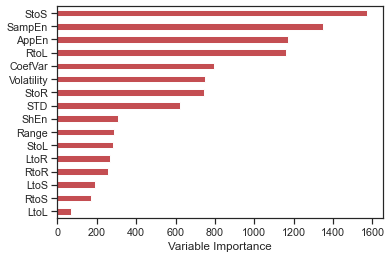

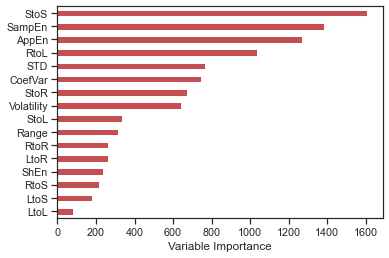

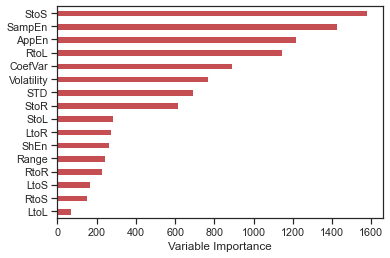

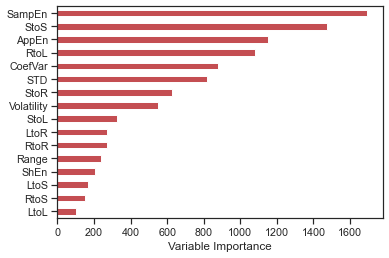

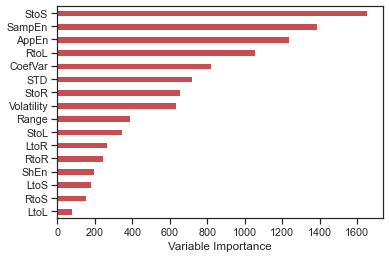

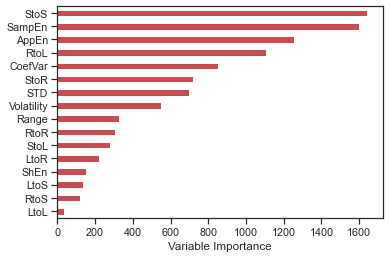

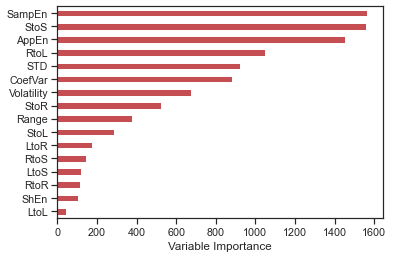

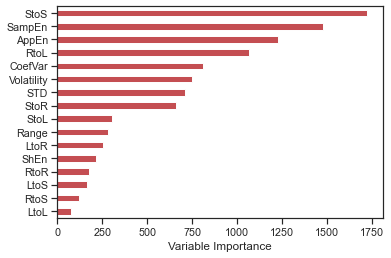

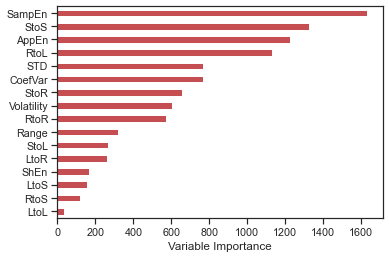

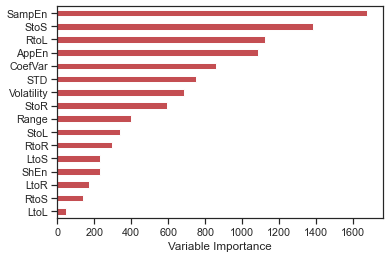

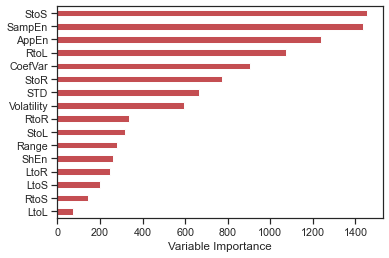

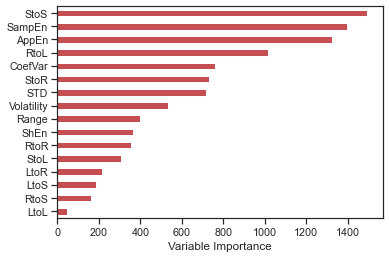

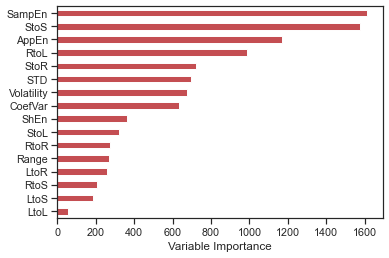

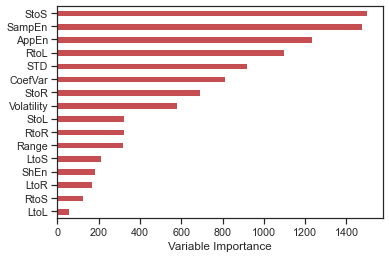

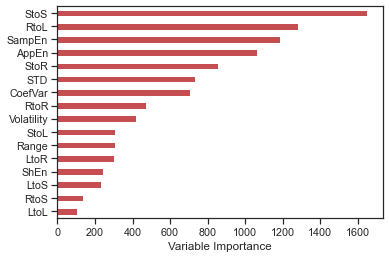

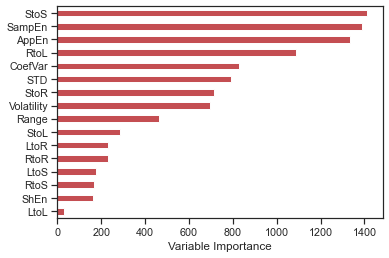

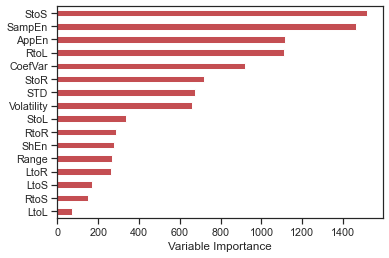

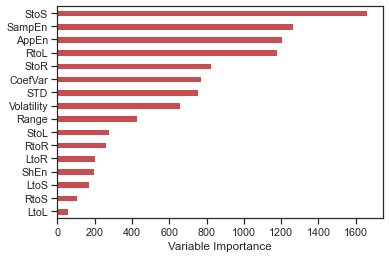

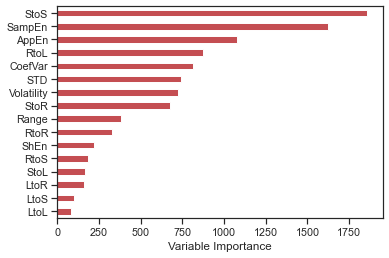

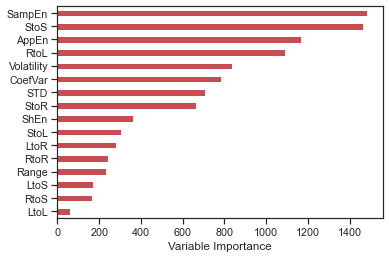

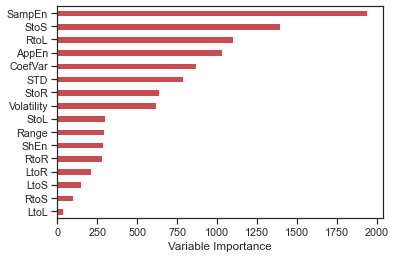

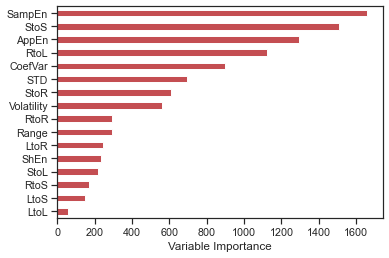

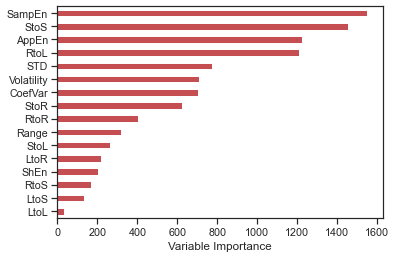

In [42]:
#Implementing cross validation 
kf = KFold(n_splits=23, shuffle=False)

from time import time
import timeit #imports timeit module
start_time = timeit.default_timer() #defines start time so computational time can be calculated

acc_score = [];
Truth = [];
Output = [];
iterations_list = []
max_depth_list = []
x_values = ['StoS', 'StoR', 'StoL', 'RtoS', 'RtoR', 'RtoL', 'LtoS',
       'LtoR', 'LtoL', 'STD', 'CoefVar', 'Range', 'Volatility', 'ShEn',
       'AppEn', 'SampEn',"Trans_AppEn"]
y_values = ['Rhythm']
#for df in features_df_list:
df = features_maindf

for idx, subject in enumerate(good_list):
    
    train_index = ~df['Subject'].str.contains(subject)
    test_index = df['Subject'].str.contains(subject)
    X_train , X_test = df.loc[train_index,x_values], df.loc[test_index,x_values]
    y_train , y_test = df.loc[train_index,y_values].values.ravel(), df.loc[test_index,y_values].values.ravel()
    
    # Create CatBoost model
    temp_model = CatBoostClassifier(learning_rate = 0.1, loss_function='Logloss')
    param_distributions = {'iterations': randint(105, 110),
                           'depth': randint(7,10)}
    search = RandomizedSearchCV(estimator=temp_model, param_distributions=param_distributions, random_state=0)
    search.fit(X_train, y_train)


    model = CatBoostClassifier(iterations=search.best_params_['iterations'], learning_rate=0.1, depth=search.best_params_['depth'], loss_function='Logloss')
    model.fit(X_train, y_train)
    
    iterations_list.append(search.best_params_['iterations'])
    max_depth_list.append(search.best_params_['depth'])
    
    # make the prediction using the resulting model
    pred_values = model.predict(X_test)
    #preds_proba = model.predict_proba(test_data)
    #print("class = ", preds_class)
    #print("proba = ", preds_proba)
     
    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)
    
    Truth.extend(y_test.reshape(y_test.shape[0])); ## it is a list
    Output.extend(pred_values); ## it is a list  
    
    #print(model.feature_importances_)
    Importance = pd.DataFrame({'Importance':(model.feature_importances_*100)}, 
                          index = (X_train.columns))
    Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r')
    plt.xlabel('Variable Importance')
    plt.gca().legend_ = None
    #plt.savefig('plot1.png')


elapsed = timeit.default_timer() - start_time #gives total computation time
print("---Run time is %s seconds ---" % elapsed) #prints computation time
print()

print('Accuracy of each fold: \n {}'.format(acc_score))
print()
try: 
    print('Avg accuracy : \n{}'.format(np.mean(acc_score))); 
except: 
    print('hi')
print()
print('Std of accuracy : \n{}'.format(np.std(acc_score)))

In [45]:
print(confusion_matrix(Truth, Output))
print(classification_report(Truth, Output))
print(acc_score)
print(elapsed)
print(iterations_list)
print(max_depth_list)

temp_list = []
temp_idx = []
for acc in acc_score:
    if acc >= 0.95:
        temp_list.append(acc)
        temp_idx.append(acc_score.index(acc))
for idx in temp_idx:
    print(iterations_list[idx])
    print(max_depth_list[idx])
    
#[[23080  1663]
# [ 1777 18448]]
# Accuracy of each fold: 
#  [0.9124713958810069, 0.9529411764705882, 0.9968513853904282, 0.9256594724220624, 0.9979101358411703, 0.9521298174442191, 0.8075665576833255, 0.9972770592239619, 0.9412650602409639, 0.9691289966923925, 0.9832123411978222, 0.990667623833453, 0.8027210884353742, 0.9668789808917198, 0.541631973355537, 0.9902525476295968, 0.9910897875257025, 0.9838430467397576, 0.7616229923922232, 0.9736118746564046, 0.9970059880239521, 0.9968612680477087, 0.9974630021141649]

# Avg accuracy : 
# 0.9317418944405887

# Std of accuracy : 
# 0.10641487333785117

[[23081  1662]
 [ 1770 18455]]
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     24743
           1       0.92      0.91      0.91     20225

    accuracy                           0.92     44968
   macro avg       0.92      0.92      0.92     44968
weighted avg       0.92      0.92      0.92     44968

[0.9124713958810069, 0.9525354969574037, 0.9974811083123426, 0.9262589928057554, 0.9979101358411703, 0.9529411764705882, 0.8066324147594582, 0.9972770592239619, 0.9412650602409639, 0.9696802646085998, 0.9832123411978222, 0.9899497487437185, 0.8022675736961451, 0.967515923566879, 0.5441298917568693, 0.9889233495790872, 0.9910897875257025, 0.9861511829197923, 0.760777683854607, 0.9741616272677295, 0.9970059880239521, 0.997489014438167, 0.9974630021141649]
658.3289397999179
[106, 106, 105, 106, 105, 109, 109, 105, 106, 109, 106, 105, 106, 105, 105, 109, 106, 107, 106, 106, 105, 107, 109]
[9, 9, 9, 9, 9, 8, 8, 9, 8, 8, 9, 9, 9, 8, 9, 8, 9

In [46]:
print(statistics.mode(iterations_list))
print(statistics.mode(max_depth_list))

106
9


In [ ]:
# Accuracy of each fold: 
#  [0.9124713958810069, 0.9525354969574037, 0.9974811083123426, 0.9262589928057554, 0.9979101358411703, 0.9529411764705882, 0.8066324147594582, 0.9972770592239619, 0.9412650602409639, 0.9696802646085998, 0.9832123411978222, 0.9899497487437185, 0.8022675736961451, 0.967515923566879, 0.5441298917568693, 0.9889233495790872, 0.9910897875257025, 0.9861511829197923, 0.760777683854607, 0.9741616272677295, 0.9970059880239521, 0.997489014438167, 0.9974630021141649]

# Avg accuracy : 
# 0.9319387052080821

# Std of accuracy : 
# 0.10621247183547902
# [[23081  1662]
#  [ 1770 18455]]

0:	learn: 0.6173748	total: 166ms	remaining: 17.4s
1:	learn: 0.5551191	total: 175ms	remaining: 9.11s
2:	learn: 0.5021580	total: 184ms	remaining: 6.32s
3:	learn: 0.4569625	total: 193ms	remaining: 4.93s
4:	learn: 0.4185226	total: 202ms	remaining: 4.08s
5:	learn: 0.3843967	total: 211ms	remaining: 3.52s
6:	learn: 0.3554537	total: 220ms	remaining: 3.11s
7:	learn: 0.3299609	total: 229ms	remaining: 2.8s
8:	learn: 0.3076787	total: 238ms	remaining: 2.56s
9:	learn: 0.2877669	total: 247ms	remaining: 2.37s
10:	learn: 0.2703733	total: 256ms	remaining: 2.21s
11:	learn: 0.2543730	total: 265ms	remaining: 2.08s
12:	learn: 0.2409597	total: 274ms	remaining: 1.96s
13:	learn: 0.2283871	total: 283ms	remaining: 1.86s
14:	learn: 0.2170486	total: 291ms	remaining: 1.77s
15:	learn: 0.2064680	total: 300ms	remaining: 1.69s
16:	learn: 0.1976527	total: 309ms	remaining: 1.62s
17:	learn: 0.1894675	total: 318ms	remaining: 1.55s
18:	learn: 0.1820903	total: 327ms	remaining: 1.5s
19:	learn: 0.1758233	total: 336ms	remaining

67:	learn: 0.1082837	total: 580ms	remaining: 324ms
68:	learn: 0.1077844	total: 589ms	remaining: 316ms
69:	learn: 0.1074133	total: 598ms	remaining: 307ms
70:	learn: 0.1072408	total: 606ms	remaining: 299ms
71:	learn: 0.1068512	total: 614ms	remaining: 290ms
72:	learn: 0.1062467	total: 623ms	remaining: 282ms
73:	learn: 0.1057735	total: 632ms	remaining: 273ms
74:	learn: 0.1055812	total: 640ms	remaining: 264ms
75:	learn: 0.1052808	total: 648ms	remaining: 256ms
76:	learn: 0.1049199	total: 656ms	remaining: 247ms
77:	learn: 0.1047670	total: 664ms	remaining: 238ms
78:	learn: 0.1045814	total: 672ms	remaining: 230ms
79:	learn: 0.1044527	total: 680ms	remaining: 221ms
80:	learn: 0.1041853	total: 688ms	remaining: 212ms
81:	learn: 0.1038157	total: 697ms	remaining: 204ms
82:	learn: 0.1035263	total: 705ms	remaining: 195ms
83:	learn: 0.1032205	total: 714ms	remaining: 187ms
84:	learn: 0.1028782	total: 722ms	remaining: 178ms
85:	learn: 0.1025176	total: 731ms	remaining: 170ms
86:	learn: 0.1022673	total: 739

27:	learn: 0.1441085	total: 254ms	remaining: 708ms
28:	learn: 0.1414919	total: 263ms	remaining: 699ms
29:	learn: 0.1391822	total: 272ms	remaining: 689ms
30:	learn: 0.1371512	total: 280ms	remaining: 678ms
31:	learn: 0.1350662	total: 289ms	remaining: 668ms
32:	learn: 0.1333881	total: 297ms	remaining: 658ms
33:	learn: 0.1313299	total: 306ms	remaining: 648ms
34:	learn: 0.1298588	total: 314ms	remaining: 638ms
35:	learn: 0.1284621	total: 323ms	remaining: 628ms
36:	learn: 0.1271792	total: 331ms	remaining: 618ms
37:	learn: 0.1257704	total: 340ms	remaining: 608ms
38:	learn: 0.1245870	total: 348ms	remaining: 599ms
39:	learn: 0.1236304	total: 357ms	remaining: 589ms
40:	learn: 0.1224890	total: 366ms	remaining: 580ms
41:	learn: 0.1218327	total: 374ms	remaining: 570ms
42:	learn: 0.1210292	total: 382ms	remaining: 560ms
43:	learn: 0.1199393	total: 391ms	remaining: 551ms
44:	learn: 0.1189522	total: 400ms	remaining: 542ms
45:	learn: 0.1183711	total: 408ms	remaining: 532ms
46:	learn: 0.1176439	total: 416

82:	learn: 0.1084774	total: 775ms	remaining: 215ms
83:	learn: 0.1081030	total: 786ms	remaining: 206ms
84:	learn: 0.1078718	total: 795ms	remaining: 196ms
85:	learn: 0.1076513	total: 805ms	remaining: 187ms
86:	learn: 0.1072434	total: 815ms	remaining: 178ms
87:	learn: 0.1069085	total: 826ms	remaining: 169ms
88:	learn: 0.1066816	total: 836ms	remaining: 160ms
89:	learn: 0.1064841	total: 845ms	remaining: 150ms
90:	learn: 0.1061887	total: 854ms	remaining: 141ms
91:	learn: 0.1060015	total: 863ms	remaining: 131ms
92:	learn: 0.1057428	total: 872ms	remaining: 122ms
93:	learn: 0.1055132	total: 881ms	remaining: 112ms
94:	learn: 0.1052592	total: 891ms	remaining: 103ms
95:	learn: 0.1048257	total: 900ms	remaining: 93.7ms
96:	learn: 0.1046385	total: 909ms	remaining: 84.4ms
97:	learn: 0.1044862	total: 919ms	remaining: 75.1ms
98:	learn: 0.1042985	total: 929ms	remaining: 65.7ms
99:	learn: 0.1042098	total: 938ms	remaining: 56.3ms
100:	learn: 0.1040363	total: 948ms	remaining: 46.9ms
101:	learn: 0.1037994	to

43:	learn: 0.1107004	total: 407ms	remaining: 573ms
44:	learn: 0.1097328	total: 416ms	remaining: 564ms
45:	learn: 0.1088993	total: 426ms	remaining: 555ms
46:	learn: 0.1082564	total: 434ms	remaining: 545ms
47:	learn: 0.1074351	total: 444ms	remaining: 536ms
48:	learn: 0.1068198	total: 452ms	remaining: 526ms
49:	learn: 0.1061396	total: 461ms	remaining: 517ms
50:	learn: 0.1054513	total: 470ms	remaining: 507ms
51:	learn: 0.1049509	total: 478ms	remaining: 497ms
52:	learn: 0.1043432	total: 487ms	remaining: 487ms
53:	learn: 0.1035401	total: 496ms	remaining: 478ms
54:	learn: 0.1030201	total: 505ms	remaining: 468ms
55:	learn: 0.1025837	total: 513ms	remaining: 458ms
56:	learn: 0.1022244	total: 521ms	remaining: 448ms
57:	learn: 0.1015852	total: 529ms	remaining: 438ms
58:	learn: 0.1010752	total: 538ms	remaining: 429ms
59:	learn: 0.1007989	total: 546ms	remaining: 419ms
60:	learn: 0.1003676	total: 555ms	remaining: 410ms
61:	learn: 0.0999109	total: 564ms	remaining: 400ms
62:	learn: 0.0993538	total: 574

0:	learn: 0.6177615	total: 11.8ms	remaining: 1.24s
1:	learn: 0.5549096	total: 22.3ms	remaining: 1.16s
2:	learn: 0.5023823	total: 40.4ms	remaining: 1.39s
3:	learn: 0.4573457	total: 56.2ms	remaining: 1.43s
4:	learn: 0.4183952	total: 68.9ms	remaining: 1.39s
5:	learn: 0.3847192	total: 79.9ms	remaining: 1.33s
6:	learn: 0.3556446	total: 91ms	remaining: 1.29s
7:	learn: 0.3303758	total: 101ms	remaining: 1.24s
8:	learn: 0.3077813	total: 111ms	remaining: 1.2s
9:	learn: 0.2879096	total: 122ms	remaining: 1.17s
10:	learn: 0.2705773	total: 132ms	remaining: 1.14s
11:	learn: 0.2548823	total: 142ms	remaining: 1.11s
12:	learn: 0.2415094	total: 152ms	remaining: 1.08s
13:	learn: 0.2286657	total: 161ms	remaining: 1.06s
14:	learn: 0.2178683	total: 171ms	remaining: 1.04s
15:	learn: 0.2081285	total: 180ms	remaining: 1.01s
16:	learn: 0.1994409	total: 190ms	remaining: 994ms
17:	learn: 0.1910444	total: 200ms	remaining: 977ms
18:	learn: 0.1837249	total: 209ms	remaining: 958ms
19:	learn: 0.1773417	total: 219ms	rem

62:	learn: 0.1124508	total: 620ms	remaining: 423ms
63:	learn: 0.1120563	total: 630ms	remaining: 414ms
64:	learn: 0.1117252	total: 640ms	remaining: 403ms
65:	learn: 0.1113780	total: 649ms	remaining: 393ms
66:	learn: 0.1110863	total: 657ms	remaining: 382ms
67:	learn: 0.1107383	total: 667ms	remaining: 373ms
68:	learn: 0.1104258	total: 675ms	remaining: 362ms
69:	learn: 0.1102709	total: 684ms	remaining: 352ms
70:	learn: 0.1100776	total: 692ms	remaining: 341ms
71:	learn: 0.1096687	total: 701ms	remaining: 331ms
72:	learn: 0.1091118	total: 710ms	remaining: 321ms
73:	learn: 0.1088669	total: 718ms	remaining: 311ms
74:	learn: 0.1086859	total: 726ms	remaining: 300ms
75:	learn: 0.1083213	total: 735ms	remaining: 290ms
76:	learn: 0.1079045	total: 744ms	remaining: 280ms
77:	learn: 0.1077259	total: 752ms	remaining: 270ms
78:	learn: 0.1076178	total: 760ms	remaining: 260ms
79:	learn: 0.1072654	total: 769ms	remaining: 250ms
80:	learn: 0.1069973	total: 777ms	remaining: 240ms
81:	learn: 0.1066157	total: 786

24:	learn: 0.1590934	total: 237ms	remaining: 766ms
25:	learn: 0.1557020	total: 246ms	remaining: 757ms
26:	learn: 0.1527756	total: 256ms	remaining: 748ms
27:	learn: 0.1499750	total: 265ms	remaining: 738ms
28:	learn: 0.1472596	total: 274ms	remaining: 727ms
29:	learn: 0.1448207	total: 283ms	remaining: 718ms
30:	learn: 0.1423782	total: 292ms	remaining: 708ms
31:	learn: 0.1402564	total: 302ms	remaining: 698ms
32:	learn: 0.1385754	total: 311ms	remaining: 687ms
33:	learn: 0.1370025	total: 320ms	remaining: 678ms
34:	learn: 0.1350626	total: 329ms	remaining: 667ms
35:	learn: 0.1337404	total: 338ms	remaining: 657ms
36:	learn: 0.1320868	total: 347ms	remaining: 647ms
37:	learn: 0.1308303	total: 356ms	remaining: 637ms
38:	learn: 0.1297213	total: 365ms	remaining: 628ms
39:	learn: 0.1286707	total: 374ms	remaining: 618ms
40:	learn: 0.1274098	total: 383ms	remaining: 608ms
41:	learn: 0.1264536	total: 392ms	remaining: 598ms
42:	learn: 0.1255866	total: 402ms	remaining: 589ms
43:	learn: 0.1246088	total: 411

88:	learn: 0.0936669	total: 796ms	remaining: 152ms
89:	learn: 0.0935072	total: 804ms	remaining: 143ms
90:	learn: 0.0933811	total: 813ms	remaining: 134ms
91:	learn: 0.0931778	total: 821ms	remaining: 125ms
92:	learn: 0.0929476	total: 831ms	remaining: 116ms
93:	learn: 0.0927515	total: 839ms	remaining: 107ms
94:	learn: 0.0926784	total: 847ms	remaining: 98.1ms
95:	learn: 0.0924722	total: 855ms	remaining: 89.1ms
96:	learn: 0.0921212	total: 864ms	remaining: 80.2ms
97:	learn: 0.0919864	total: 872ms	remaining: 71.2ms
98:	learn: 0.0917592	total: 881ms	remaining: 62.3ms
99:	learn: 0.0916366	total: 888ms	remaining: 53.3ms
100:	learn: 0.0914424	total: 897ms	remaining: 44.4ms
101:	learn: 0.0912274	total: 906ms	remaining: 35.5ms
102:	learn: 0.0908245	total: 915ms	remaining: 26.6ms
103:	learn: 0.0905616	total: 924ms	remaining: 17.8ms
104:	learn: 0.0904552	total: 932ms	remaining: 8.87ms
105:	learn: 0.0903716	total: 940ms	remaining: 0us
0:	learn: 0.6188695	total: 14.2ms	remaining: 1.49s
1:	learn: 0.5566

44:	learn: 0.1038375	total: 404ms	remaining: 547ms
45:	learn: 0.1031226	total: 415ms	remaining: 541ms
46:	learn: 0.1023257	total: 424ms	remaining: 533ms
47:	learn: 0.1018150	total: 433ms	remaining: 523ms
48:	learn: 0.1013550	total: 442ms	remaining: 514ms
49:	learn: 0.1008383	total: 451ms	remaining: 505ms
50:	learn: 0.1005014	total: 460ms	remaining: 496ms
51:	learn: 0.0998695	total: 468ms	remaining: 486ms
52:	learn: 0.0994799	total: 477ms	remaining: 477ms
53:	learn: 0.0989232	total: 486ms	remaining: 468ms
54:	learn: 0.0984357	total: 494ms	remaining: 458ms
55:	learn: 0.0978795	total: 502ms	remaining: 448ms
56:	learn: 0.0974371	total: 511ms	remaining: 439ms
57:	learn: 0.0970739	total: 519ms	remaining: 430ms
58:	learn: 0.0967129	total: 528ms	remaining: 420ms
59:	learn: 0.0962583	total: 537ms	remaining: 411ms
60:	learn: 0.0959180	total: 545ms	remaining: 402ms
61:	learn: 0.0956280	total: 553ms	remaining: 393ms
62:	learn: 0.0952926	total: 562ms	remaining: 383ms
63:	learn: 0.0948370	total: 570

104:	learn: 0.1026843	total: 945ms	remaining: 9ms
105:	learn: 0.1023153	total: 954ms	remaining: 0us
0:	learn: 0.6183740	total: 10.8ms	remaining: 1.14s
1:	learn: 0.5564261	total: 20.8ms	remaining: 1.08s
2:	learn: 0.5039245	total: 30.3ms	remaining: 1.04s
3:	learn: 0.4590878	total: 40.1ms	remaining: 1.02s
4:	learn: 0.4209114	total: 49.1ms	remaining: 992ms
5:	learn: 0.3882512	total: 58.6ms	remaining: 977ms
6:	learn: 0.3598043	total: 68.4ms	remaining: 968ms
7:	learn: 0.3346766	total: 77.5ms	remaining: 950ms
8:	learn: 0.3116522	total: 86.9ms	remaining: 937ms
9:	learn: 0.2920718	total: 96.4ms	remaining: 925ms
10:	learn: 0.2749967	total: 106ms	remaining: 917ms
11:	learn: 0.2598977	total: 116ms	remaining: 906ms
12:	learn: 0.2462366	total: 125ms	remaining: 893ms
13:	learn: 0.2336992	total: 134ms	remaining: 883ms
14:	learn: 0.2225778	total: 144ms	remaining: 871ms
15:	learn: 0.2126938	total: 153ms	remaining: 862ms
16:	learn: 0.2038853	total: 163ms	remaining: 853ms
17:	learn: 0.1958487	total: 173ms

59:	learn: 0.1146927	total: 577ms	remaining: 442ms
60:	learn: 0.1144262	total: 586ms	remaining: 432ms
61:	learn: 0.1139798	total: 595ms	remaining: 422ms
62:	learn: 0.1136439	total: 605ms	remaining: 413ms
63:	learn: 0.1130229	total: 615ms	remaining: 403ms
64:	learn: 0.1126782	total: 626ms	remaining: 395ms
65:	learn: 0.1118980	total: 635ms	remaining: 385ms
66:	learn: 0.1116007	total: 644ms	remaining: 375ms
67:	learn: 0.1112191	total: 653ms	remaining: 365ms
68:	learn: 0.1108650	total: 662ms	remaining: 355ms
69:	learn: 0.1107186	total: 671ms	remaining: 345ms
70:	learn: 0.1105941	total: 680ms	remaining: 335ms
71:	learn: 0.1102057	total: 690ms	remaining: 326ms
72:	learn: 0.1097726	total: 699ms	remaining: 316ms
73:	learn: 0.1093753	total: 709ms	remaining: 306ms
74:	learn: 0.1092324	total: 717ms	remaining: 296ms
75:	learn: 0.1090120	total: 726ms	remaining: 286ms
76:	learn: 0.1086022	total: 735ms	remaining: 277ms
77:	learn: 0.1084826	total: 744ms	remaining: 267ms
78:	learn: 0.1083808	total: 752

21:	learn: 0.1707230	total: 196ms	remaining: 749ms
22:	learn: 0.1663287	total: 205ms	remaining: 739ms
23:	learn: 0.1615305	total: 213ms	remaining: 729ms
24:	learn: 0.1577286	total: 222ms	remaining: 720ms
25:	learn: 0.1544398	total: 230ms	remaining: 709ms
26:	learn: 0.1512285	total: 239ms	remaining: 700ms
27:	learn: 0.1483236	total: 247ms	remaining: 689ms
28:	learn: 0.1455532	total: 256ms	remaining: 680ms
29:	learn: 0.1432310	total: 264ms	remaining: 670ms
30:	learn: 0.1409246	total: 273ms	remaining: 661ms
31:	learn: 0.1388367	total: 284ms	remaining: 656ms
32:	learn: 0.1370995	total: 294ms	remaining: 650ms
33:	learn: 0.1356839	total: 303ms	remaining: 642ms
34:	learn: 0.1340542	total: 314ms	remaining: 636ms
35:	learn: 0.1324593	total: 324ms	remaining: 630ms
36:	learn: 0.1311128	total: 335ms	remaining: 624ms
37:	learn: 0.1299538	total: 344ms	remaining: 615ms
38:	learn: 0.1285276	total: 353ms	remaining: 607ms
39:	learn: 0.1275360	total: 363ms	remaining: 599ms
40:	learn: 0.1262976	total: 372

85:	learn: 0.1082971	total: 774ms	remaining: 180ms
86:	learn: 0.1081689	total: 783ms	remaining: 171ms
87:	learn: 0.1077645	total: 792ms	remaining: 162ms
88:	learn: 0.1075872	total: 801ms	remaining: 153ms
89:	learn: 0.1074119	total: 809ms	remaining: 144ms
90:	learn: 0.1073064	total: 817ms	remaining: 135ms
91:	learn: 0.1070095	total: 827ms	remaining: 126ms
92:	learn: 0.1068074	total: 835ms	remaining: 117ms
93:	learn: 0.1065636	total: 845ms	remaining: 108ms
94:	learn: 0.1064582	total: 853ms	remaining: 98.8ms
95:	learn: 0.1061431	total: 863ms	remaining: 89.9ms
96:	learn: 0.1056582	total: 872ms	remaining: 80.9ms
97:	learn: 0.1054741	total: 881ms	remaining: 71.9ms
98:	learn: 0.1052684	total: 889ms	remaining: 62.9ms
99:	learn: 0.1051077	total: 898ms	remaining: 53.9ms
100:	learn: 0.1049453	total: 909ms	remaining: 45ms
101:	learn: 0.1045095	total: 924ms	remaining: 36.2ms
102:	learn: 0.1042121	total: 961ms	remaining: 28ms
103:	learn: 0.1039257	total: 979ms	remaining: 18.8ms
104:	learn: 0.1038104

C:\Users\NNL\anacondareal\lib\site-packages\pandas\plotting\_matplotlib\core.py:337: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


3:	learn: 0.4586868	total: 41.8ms	remaining: 1.07s
4:	learn: 0.4209883	total: 51.8ms	remaining: 1.05s
5:	learn: 0.3874271	total: 61.5ms	remaining: 1.02s
6:	learn: 0.3589956	total: 71.1ms	remaining: 1s
7:	learn: 0.3340153	total: 80.7ms	remaining: 989ms
8:	learn: 0.3114731	total: 90ms	remaining: 971ms
9:	learn: 0.2918839	total: 99.6ms	remaining: 956ms
10:	learn: 0.2748847	total: 109ms	remaining: 942ms
11:	learn: 0.2596089	total: 119ms	remaining: 933ms
12:	learn: 0.2462554	total: 129ms	remaining: 920ms
13:	learn: 0.2338924	total: 139ms	remaining: 915ms
14:	learn: 0.2229747	total: 149ms	remaining: 901ms
15:	learn: 0.2129236	total: 158ms	remaining: 889ms
16:	learn: 0.2043316	total: 168ms	remaining: 882ms
17:	learn: 0.1963180	total: 178ms	remaining: 870ms
18:	learn: 0.1888335	total: 188ms	remaining: 862ms
19:	learn: 0.1827151	total: 198ms	remaining: 850ms
20:	learn: 0.1770995	total: 207ms	remaining: 839ms
21:	learn: 0.1723999	total: 217ms	remaining: 830ms
22:	learn: 0.1679339	total: 227ms	re

63:	learn: 0.1138594	total: 582ms	remaining: 382ms
64:	learn: 0.1135855	total: 591ms	remaining: 373ms
65:	learn: 0.1130412	total: 599ms	remaining: 363ms
66:	learn: 0.1127011	total: 607ms	remaining: 353ms
67:	learn: 0.1123424	total: 616ms	remaining: 344ms
68:	learn: 0.1120839	total: 624ms	remaining: 335ms
69:	learn: 0.1119210	total: 633ms	remaining: 326ms
70:	learn: 0.1117158	total: 641ms	remaining: 316ms
71:	learn: 0.1114374	total: 651ms	remaining: 307ms
72:	learn: 0.1110582	total: 659ms	remaining: 298ms
73:	learn: 0.1108853	total: 668ms	remaining: 289ms
74:	learn: 0.1107312	total: 676ms	remaining: 279ms
75:	learn: 0.1102950	total: 685ms	remaining: 271ms
76:	learn: 0.1100683	total: 694ms	remaining: 261ms
77:	learn: 0.1099803	total: 702ms	remaining: 252ms
78:	learn: 0.1098118	total: 710ms	remaining: 243ms
79:	learn: 0.1096538	total: 719ms	remaining: 234ms
80:	learn: 0.1094618	total: 727ms	remaining: 224ms
81:	learn: 0.1090779	total: 736ms	remaining: 215ms
82:	learn: 0.1087762	total: 745

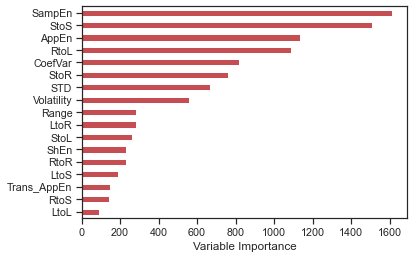

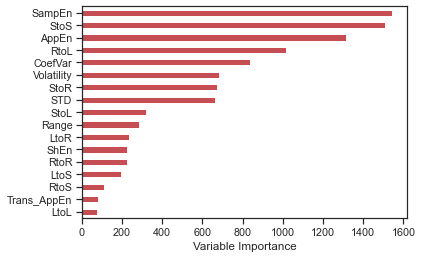

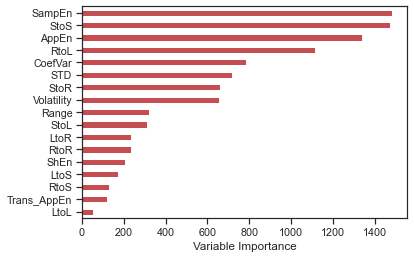

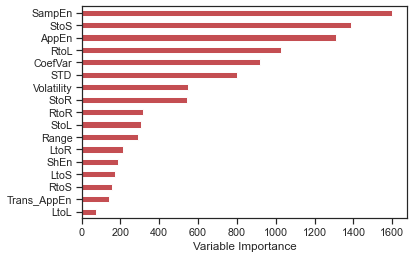

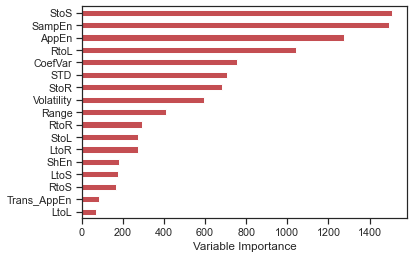

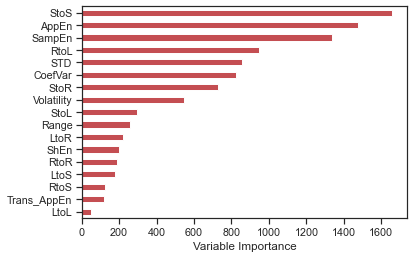

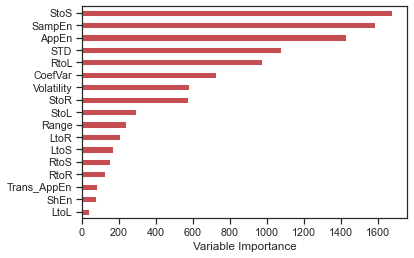

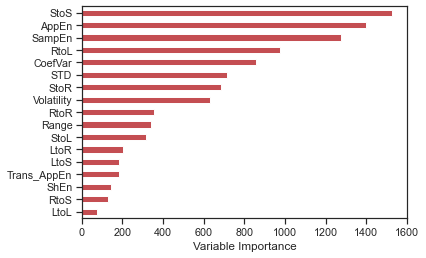

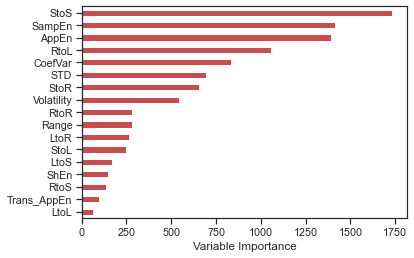

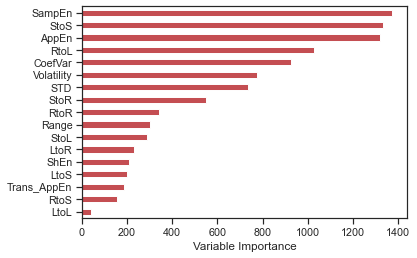

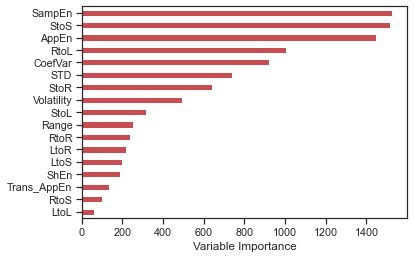

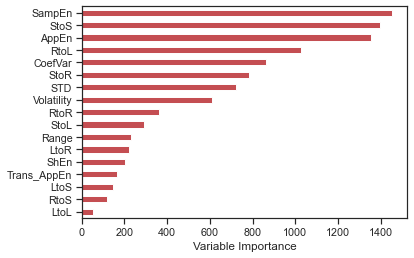

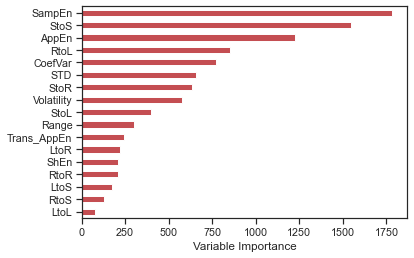

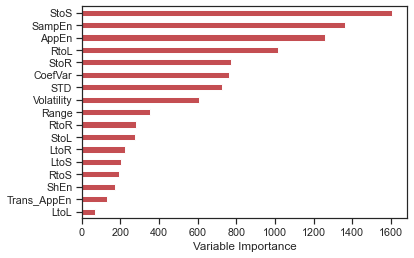

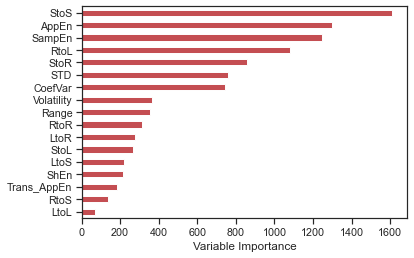

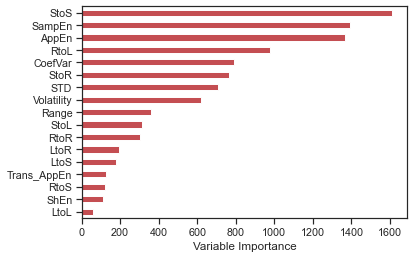

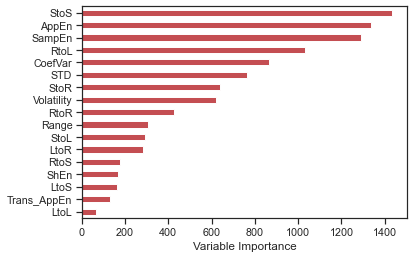

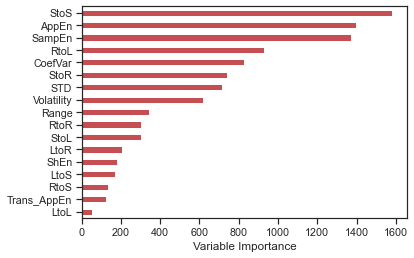

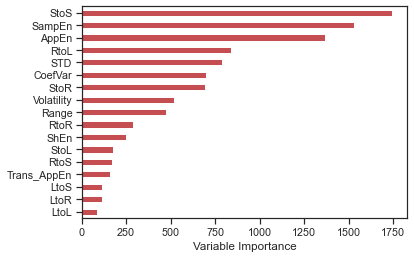

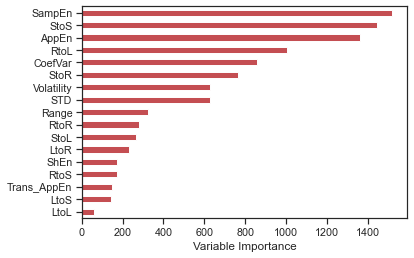

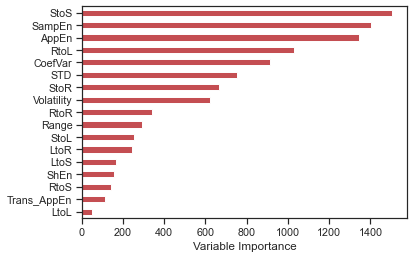

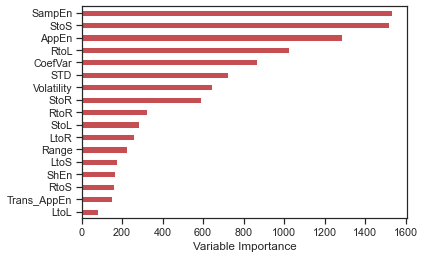

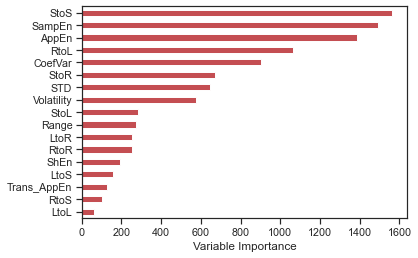

In [9]:
#Implementing cross validation 
kf = KFold(n_splits=23, shuffle=False)

from time import time
import timeit #imports timeit module
start_time = timeit.default_timer() #defines start time so computational time can be calculated

acc_score = [];
Truth = [];
Output = [];
iterations_list = []
max_depth_list = []
x_values = ['StoS', 'StoR', 'StoL', 'RtoS', 'RtoR', 'RtoL', 'LtoS',
       'LtoR', 'LtoL', 'STD', 'CoefVar', 'Range', 'Volatility', 'ShEn',
       'AppEn', 'SampEn',"Trans_AppEn"]
y_values = ['Rhythm']
#for df in features_df_list:
df = features_maindf

for idx, subject in enumerate(good_list):
    
    train_index = ~df['Subject'].str.contains(subject)
    test_index = df['Subject'].str.contains(subject)
    X_train , X_test = df.loc[train_index,x_values], df.loc[test_index,x_values]
    y_train , y_test = df.loc[train_index,y_values].values.ravel(), df.loc[test_index,y_values].values.ravel()
    
    # Create CatBoost model
#     temp_model = CatBoostClassifier(learning_rate = 0.1, loss_function='Logloss')
#     param_distributions = {'iterations': randint(105, 110),
#                            'depth': randint(7,10)}
#     search = RandomizedSearchCV(estimator=temp_model, param_distributions=param_distributions, random_state=0)
#     search.fit(X_train, y_train)


    model = CatBoostClassifier(iterations=106, learning_rate=0.1, depth=9, loss_function='Logloss')
    model.fit(X_train, y_train)
    
#     iterations_list.append(search.best_params_['iterations'])
#     max_depth_list.append(search.best_params_['depth'])
    
    # make the prediction using the resulting model
    pred_values = model.predict(X_test)
    #preds_proba = model.predict_proba(test_data)
    #print("class = ", preds_class)
    #print("proba = ", preds_proba)
     
    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)
    
    Truth.extend(y_test.reshape(y_test.shape[0])); ## it is a list
    Output.extend(pred_values); ## it is a list  
    
    #print(model.feature_importances_)
    Importance = pd.DataFrame({'Importance':(model.feature_importances_*100)}, 
                          index = (X_train.columns))
    Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r')
    plt.xlabel('Variable Importance')
    plt.gca().legend_ = None
    #plt.savefig('plot1.png')


elapsed = timeit.default_timer() - start_time #gives total computation time
print("---Run time is %s seconds ---" % elapsed) #prints computation time
print()

print('Accuracy of each fold: \n {}'.format(acc_score))
print()
try: 
    print('Avg accuracy : \n{}'.format(np.mean(acc_score))); 
except: 
    print('hi')
print()
print('Std of accuracy : \n{}'.format(np.std(acc_score)))

In [10]:
print(confusion_matrix(Truth, Output))
print(classification_report(Truth, Output))
print(acc_score)
print(elapsed)
# [[23080  1663]
#  [ 1757 18468]]
# Accuracy of each fold: 
#  [0.9124713958810069, 0.9525354969574037, 0.9974811083123426, 0.9262589928057554, 0.9979101358411703, 0.9525354969574037, 0.8155067725361981, 0.9972770592239619, 0.9397590361445783, 0.9707828004410143, 0.9832123411978222, 0.990667623833453, 0.8022675736961451, 0.967515923566879, 0.5420482930890924, 0.9902525476295968, 0.9910897875257025, 0.9849971148297749, 0.760777683854607, 0.9741616272677295, 0.9970059880239521, 0.9968612680477087, 0.9970401691331924]

# Avg accuracy : 
# 0.9321920102954995

# Std of accuracy : 
# 0.10610803049760552

[[23071  1672]
 [ 1809 18416]]
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     24743
           1       0.92      0.91      0.91     20225

    accuracy                           0.92     44968
   macro avg       0.92      0.92      0.92     44968
weighted avg       0.92      0.92      0.92     44968

[0.9113272311212814, 0.9533468559837728, 0.9974811083123426, 0.934052757793765, 0.9984326018808778, 0.9533468559837728, 0.8117702008407286, 0.9979577944179714, 0.9422690763052208, 0.9696802646085998, 0.9832123411978222, 0.9892318736539842, 0.7854875283446712, 0.9656050955414013, 0.525811823480433, 0.9906956136464333, 0.9910897875257025, 0.9844200807847663, 0.7637362637362637, 0.9752611324903794, 0.9970059880239521, 0.9968612680477087, 0.9966173361522199]
26.255249999994703


0:	learn: 0.6174286	total: 153ms	remaining: 15.1s
1:	learn: 0.5574452	total: 158ms	remaining: 7.74s
2:	learn: 0.5044780	total: 162ms	remaining: 5.25s
3:	learn: 0.4598903	total: 167ms	remaining: 4s
4:	learn: 0.4222707	total: 171ms	remaining: 3.24s
5:	learn: 0.3895234	total: 174ms	remaining: 2.73s
6:	learn: 0.3616632	total: 178ms	remaining: 2.36s
7:	learn: 0.3369352	total: 181ms	remaining: 2.08s
8:	learn: 0.3151932	total: 184ms	remaining: 1.86s
9:	learn: 0.2964770	total: 188ms	remaining: 1.69s
10:	learn: 0.2787701	total: 191ms	remaining: 1.54s
11:	learn: 0.2633143	total: 194ms	remaining: 1.43s
12:	learn: 0.2500411	total: 198ms	remaining: 1.32s
13:	learn: 0.2382914	total: 201ms	remaining: 1.23s
14:	learn: 0.2281079	total: 204ms	remaining: 1.16s
15:	learn: 0.2181673	total: 207ms	remaining: 1.09s
16:	learn: 0.2096298	total: 211ms	remaining: 1.03s
17:	learn: 0.2016681	total: 214ms	remaining: 974ms
18:	learn: 0.1950211	total: 217ms	remaining: 926ms
19:	learn: 0.1887864	total: 220ms	remaining:

0:	learn: 0.6185571	total: 4.09ms	remaining: 405ms
1:	learn: 0.5581819	total: 7.6ms	remaining: 372ms
2:	learn: 0.5061556	total: 10.9ms	remaining: 351ms
3:	learn: 0.4624356	total: 14.4ms	remaining: 345ms
4:	learn: 0.4255612	total: 18.1ms	remaining: 344ms
5:	learn: 0.3936021	total: 21.6ms	remaining: 339ms
6:	learn: 0.3661889	total: 24.9ms	remaining: 331ms
7:	learn: 0.3419739	total: 28.4ms	remaining: 327ms
8:	learn: 0.3206907	total: 31.9ms	remaining: 322ms
9:	learn: 0.3023154	total: 35.2ms	remaining: 317ms
10:	learn: 0.2856586	total: 38.4ms	remaining: 311ms
11:	learn: 0.2705406	total: 41.8ms	remaining: 307ms
12:	learn: 0.2577717	total: 45.2ms	remaining: 303ms
13:	learn: 0.2462550	total: 48.7ms	remaining: 299ms
14:	learn: 0.2359812	total: 52.1ms	remaining: 295ms
15:	learn: 0.2262417	total: 55.4ms	remaining: 291ms
16:	learn: 0.2184327	total: 58.6ms	remaining: 286ms
17:	learn: 0.2106400	total: 62ms	remaining: 283ms
18:	learn: 0.2040409	total: 65.5ms	remaining: 279ms
19:	learn: 0.1976918	tota

0:	learn: 0.6185882	total: 4.91ms	remaining: 486ms
1:	learn: 0.5584909	total: 9.09ms	remaining: 445ms
2:	learn: 0.5081375	total: 12.5ms	remaining: 405ms
3:	learn: 0.4652054	total: 16.3ms	remaining: 390ms
4:	learn: 0.4286564	total: 19.7ms	remaining: 374ms
5:	learn: 0.3959774	total: 22.9ms	remaining: 359ms
6:	learn: 0.3685939	total: 26.2ms	remaining: 348ms
7:	learn: 0.3440033	total: 29.5ms	remaining: 339ms
8:	learn: 0.3227529	total: 32.9ms	remaining: 333ms
9:	learn: 0.3035648	total: 36.2ms	remaining: 326ms
10:	learn: 0.2875296	total: 39.4ms	remaining: 319ms
11:	learn: 0.2729650	total: 42.8ms	remaining: 314ms
12:	learn: 0.2601247	total: 46.1ms	remaining: 309ms
13:	learn: 0.2482052	total: 49.5ms	remaining: 304ms
14:	learn: 0.2379710	total: 53ms	remaining: 300ms
15:	learn: 0.2280495	total: 56.2ms	remaining: 295ms
16:	learn: 0.2197206	total: 59.4ms	remaining: 290ms
17:	learn: 0.2125939	total: 62.8ms	remaining: 286ms
18:	learn: 0.2061816	total: 66.3ms	remaining: 283ms
19:	learn: 0.1996446	tot

0:	learn: 0.6167671	total: 4.07ms	remaining: 403ms
1:	learn: 0.5570516	total: 7.64ms	remaining: 374ms
2:	learn: 0.5040562	total: 11.2ms	remaining: 361ms
3:	learn: 0.4596461	total: 14.5ms	remaining: 348ms
4:	learn: 0.4212713	total: 18ms	remaining: 341ms
5:	learn: 0.3872860	total: 21.3ms	remaining: 334ms
6:	learn: 0.3591451	total: 24.8ms	remaining: 330ms
7:	learn: 0.3340666	total: 28.6ms	remaining: 329ms
8:	learn: 0.3122850	total: 32ms	remaining: 323ms
9:	learn: 0.2933385	total: 35.4ms	remaining: 318ms
10:	learn: 0.2760567	total: 38.6ms	remaining: 312ms
11:	learn: 0.2605236	total: 42.4ms	remaining: 311ms
12:	learn: 0.2470404	total: 45.9ms	remaining: 307ms
13:	learn: 0.2346796	total: 49.4ms	remaining: 304ms
14:	learn: 0.2241634	total: 52.9ms	remaining: 300ms
15:	learn: 0.2141352	total: 56.3ms	remaining: 296ms
16:	learn: 0.2057075	total: 59.8ms	remaining: 292ms
17:	learn: 0.1978829	total: 63.2ms	remaining: 288ms
18:	learn: 0.1904014	total: 66.7ms	remaining: 284ms
19:	learn: 0.1836995	total

0:	learn: 0.6177473	total: 4.29ms	remaining: 425ms
1:	learn: 0.5579207	total: 8.13ms	remaining: 398ms
2:	learn: 0.5077063	total: 11.9ms	remaining: 384ms
3:	learn: 0.4625443	total: 15.6ms	remaining: 375ms
4:	learn: 0.4249455	total: 19.6ms	remaining: 373ms
5:	learn: 0.3916524	total: 23.1ms	remaining: 361ms
6:	learn: 0.3641504	total: 26.5ms	remaining: 351ms
7:	learn: 0.3391752	total: 30.1ms	remaining: 346ms
8:	learn: 0.3176605	total: 33.9ms	remaining: 343ms
9:	learn: 0.2988982	total: 37.4ms	remaining: 337ms
10:	learn: 0.2814553	total: 41ms	remaining: 332ms
11:	learn: 0.2672901	total: 44.5ms	remaining: 326ms
12:	learn: 0.2545194	total: 47.9ms	remaining: 321ms
13:	learn: 0.2428408	total: 51.3ms	remaining: 315ms
14:	learn: 0.2320156	total: 54.9ms	remaining: 311ms
15:	learn: 0.2222057	total: 58.3ms	remaining: 306ms
16:	learn: 0.2133418	total: 61.5ms	remaining: 300ms
17:	learn: 0.2057321	total: 64.7ms	remaining: 295ms
18:	learn: 0.1988556	total: 68.1ms	remaining: 290ms
19:	learn: 0.1922385	tot

0:	learn: 0.6185252	total: 3.83ms	remaining: 379ms
1:	learn: 0.5593915	total: 7.26ms	remaining: 356ms
2:	learn: 0.5078370	total: 10.6ms	remaining: 341ms
3:	learn: 0.4644061	total: 13.9ms	remaining: 333ms
4:	learn: 0.4274652	total: 17.1ms	remaining: 324ms
5:	learn: 0.3959769	total: 20.3ms	remaining: 319ms
6:	learn: 0.3684961	total: 23.8ms	remaining: 316ms
7:	learn: 0.3439953	total: 27.2ms	remaining: 313ms
8:	learn: 0.3225708	total: 30.3ms	remaining: 307ms
9:	learn: 0.3031769	total: 34.3ms	remaining: 309ms
10:	learn: 0.2868332	total: 37.9ms	remaining: 307ms
11:	learn: 0.2715522	total: 41.5ms	remaining: 304ms
12:	learn: 0.2589175	total: 44.9ms	remaining: 300ms
13:	learn: 0.2470210	total: 48.1ms	remaining: 296ms
14:	learn: 0.2367525	total: 51.3ms	remaining: 291ms
15:	learn: 0.2271106	total: 54.8ms	remaining: 288ms
16:	learn: 0.2184393	total: 57.9ms	remaining: 283ms
17:	learn: 0.2104820	total: 61.1ms	remaining: 278ms
18:	learn: 0.2040748	total: 64.3ms	remaining: 274ms
19:	learn: 0.1977312	t

0:	learn: 0.6161939	total: 3.99ms	remaining: 395ms
1:	learn: 0.5552718	total: 7.45ms	remaining: 365ms
2:	learn: 0.5022836	total: 10.7ms	remaining: 344ms
3:	learn: 0.4576651	total: 14.1ms	remaining: 338ms
4:	learn: 0.4191167	total: 17.5ms	remaining: 332ms
5:	learn: 0.3864346	total: 20.9ms	remaining: 328ms
6:	learn: 0.3576139	total: 24.3ms	remaining: 322ms
7:	learn: 0.3324400	total: 27.6ms	remaining: 317ms
8:	learn: 0.3109090	total: 31.2ms	remaining: 315ms
9:	learn: 0.2919330	total: 34.4ms	remaining: 310ms
10:	learn: 0.2741860	total: 37.8ms	remaining: 306ms
11:	learn: 0.2582487	total: 41.2ms	remaining: 302ms
12:	learn: 0.2450993	total: 44.7ms	remaining: 299ms
13:	learn: 0.2327604	total: 48.2ms	remaining: 296ms
14:	learn: 0.2221971	total: 51.5ms	remaining: 292ms
15:	learn: 0.2121754	total: 55.2ms	remaining: 290ms
16:	learn: 0.2033332	total: 58.4ms	remaining: 285ms
17:	learn: 0.1954243	total: 61.7ms	remaining: 281ms
18:	learn: 0.1881778	total: 65.3ms	remaining: 278ms
19:	learn: 0.1814365	t

0:	learn: 0.6131059	total: 3.96ms	remaining: 392ms
1:	learn: 0.5494286	total: 7.4ms	remaining: 363ms
2:	learn: 0.4955661	total: 10.7ms	remaining: 344ms
3:	learn: 0.4506719	total: 14.2ms	remaining: 341ms
4:	learn: 0.4110050	total: 17.9ms	remaining: 339ms
5:	learn: 0.3772564	total: 21.5ms	remaining: 337ms
6:	learn: 0.3483169	total: 25ms	remaining: 333ms
7:	learn: 0.3219037	total: 28.7ms	remaining: 330ms
8:	learn: 0.2988429	total: 32.4ms	remaining: 328ms
9:	learn: 0.2790024	total: 36.1ms	remaining: 325ms
10:	learn: 0.2617628	total: 39.7ms	remaining: 321ms
11:	learn: 0.2466978	total: 43.2ms	remaining: 317ms
12:	learn: 0.2328377	total: 46.7ms	remaining: 313ms
13:	learn: 0.2205341	total: 50.1ms	remaining: 307ms
14:	learn: 0.2096389	total: 53.2ms	remaining: 301ms
15:	learn: 0.2000159	total: 56.5ms	remaining: 297ms
16:	learn: 0.1913909	total: 59.8ms	remaining: 292ms
17:	learn: 0.1834972	total: 63.1ms	remaining: 288ms
18:	learn: 0.1764943	total: 66.4ms	remaining: 283ms
19:	learn: 0.1699299	tota

0:	learn: 0.6181616	total: 4.67ms	remaining: 462ms
1:	learn: 0.5576467	total: 8.63ms	remaining: 423ms
2:	learn: 0.5055183	total: 12.1ms	remaining: 392ms
3:	learn: 0.4619574	total: 15.5ms	remaining: 373ms
4:	learn: 0.4252428	total: 19ms	remaining: 361ms
5:	learn: 0.3926345	total: 22.7ms	remaining: 355ms
6:	learn: 0.3652012	total: 26.3ms	remaining: 349ms
7:	learn: 0.3407896	total: 29.9ms	remaining: 344ms
8:	learn: 0.3195121	total: 33.4ms	remaining: 337ms
9:	learn: 0.3010538	total: 36.6ms	remaining: 330ms
10:	learn: 0.2844799	total: 40ms	remaining: 323ms
11:	learn: 0.2694762	total: 43.3ms	remaining: 318ms
12:	learn: 0.2567335	total: 46.6ms	remaining: 312ms
13:	learn: 0.2453030	total: 49.8ms	remaining: 306ms
14:	learn: 0.2350576	total: 53ms	remaining: 300ms
15:	learn: 0.2257080	total: 56.3ms	remaining: 295ms
16:	learn: 0.2173667	total: 59.4ms	remaining: 290ms
17:	learn: 0.2096548	total: 62.7ms	remaining: 286ms
18:	learn: 0.2033479	total: 66.1ms	remaining: 282ms
19:	learn: 0.1971348	total: 

0:	learn: 0.6147187	total: 4.32ms	remaining: 428ms
1:	learn: 0.5531538	total: 7.86ms	remaining: 385ms
2:	learn: 0.4984850	total: 11.3ms	remaining: 365ms
3:	learn: 0.4531306	total: 14.8ms	remaining: 355ms
4:	learn: 0.4145979	total: 18.1ms	remaining: 345ms
5:	learn: 0.3813218	total: 21.9ms	remaining: 344ms
6:	learn: 0.3525094	total: 25.4ms	remaining: 337ms
7:	learn: 0.3269381	total: 28.9ms	remaining: 332ms
8:	learn: 0.3041527	total: 32.4ms	remaining: 328ms
9:	learn: 0.2841619	total: 35.8ms	remaining: 323ms
10:	learn: 0.2668554	total: 39.3ms	remaining: 318ms
11:	learn: 0.2512990	total: 42.5ms	remaining: 312ms
12:	learn: 0.2375182	total: 45.8ms	remaining: 307ms
13:	learn: 0.2256585	total: 49.1ms	remaining: 302ms
14:	learn: 0.2149068	total: 52.4ms	remaining: 297ms
15:	learn: 0.2057876	total: 55.8ms	remaining: 293ms
16:	learn: 0.1973242	total: 59.2ms	remaining: 289ms
17:	learn: 0.1893514	total: 62.8ms	remaining: 286ms
18:	learn: 0.1818191	total: 66.4ms	remaining: 283ms
19:	learn: 0.1750865	t

0:	learn: 0.6186840	total: 5.2ms	remaining: 515ms
1:	learn: 0.5598801	total: 9.87ms	remaining: 484ms
2:	learn: 0.5094729	total: 14.4ms	remaining: 466ms
3:	learn: 0.4660875	total: 19ms	remaining: 456ms
4:	learn: 0.4293346	total: 23.7ms	remaining: 450ms
5:	learn: 0.3979421	total: 28.2ms	remaining: 441ms
6:	learn: 0.3705352	total: 32.4ms	remaining: 431ms
7:	learn: 0.3453907	total: 36.6ms	remaining: 421ms
8:	learn: 0.3240082	total: 41ms	remaining: 415ms
9:	learn: 0.3055895	total: 44.6ms	remaining: 402ms
10:	learn: 0.2894490	total: 48.1ms	remaining: 389ms
11:	learn: 0.2742008	total: 51.3ms	remaining: 377ms
12:	learn: 0.2612995	total: 54.8ms	remaining: 367ms
13:	learn: 0.2492948	total: 58.1ms	remaining: 357ms
14:	learn: 0.2391540	total: 61.4ms	remaining: 348ms
15:	learn: 0.2290804	total: 65ms	remaining: 341ms
16:	learn: 0.2205798	total: 68.2ms	remaining: 333ms
17:	learn: 0.2135523	total: 71.5ms	remaining: 326ms
18:	learn: 0.2068013	total: 74.8ms	remaining: 319ms
19:	learn: 0.2002820	total: 7

C:\Users\NNL\anacondareal\lib\site-packages\pandas\plotting\_matplotlib\core.py:337: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


0:	learn: 0.6182065	total: 35.9ms	remaining: 3.56s
1:	learn: 0.5578648	total: 40.9ms	remaining: 2s
2:	learn: 0.5060662	total: 45.6ms	remaining: 1.48s
3:	learn: 0.4635782	total: 50.6ms	remaining: 1.21s
4:	learn: 0.4263872	total: 55.4ms	remaining: 1.05s
5:	learn: 0.3943788	total: 60.2ms	remaining: 943ms
6:	learn: 0.3669294	total: 65.1ms	remaining: 866ms
7:	learn: 0.3427812	total: 70ms	remaining: 805ms
8:	learn: 0.3213053	total: 74.8ms	remaining: 757ms
9:	learn: 0.3027912	total: 79.3ms	remaining: 714ms
10:	learn: 0.2861232	total: 83.4ms	remaining: 675ms
11:	learn: 0.2708698	total: 87.2ms	remaining: 639ms
12:	learn: 0.2581968	total: 91.3ms	remaining: 611ms
13:	learn: 0.2461010	total: 95.2ms	remaining: 585ms
14:	learn: 0.2358923	total: 98.6ms	remaining: 559ms
15:	learn: 0.2267170	total: 102ms	remaining: 536ms
16:	learn: 0.2180052	total: 105ms	remaining: 514ms
17:	learn: 0.2107702	total: 109ms	remaining: 495ms
18:	learn: 0.2040819	total: 112ms	remaining: 479ms
19:	learn: 0.1976438	total: 116

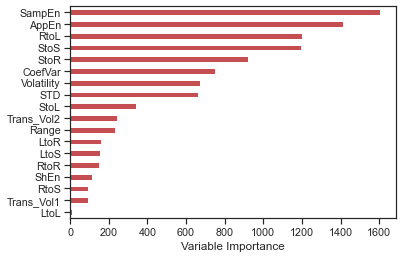

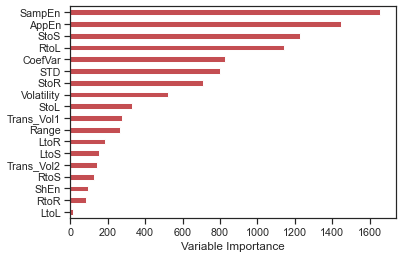

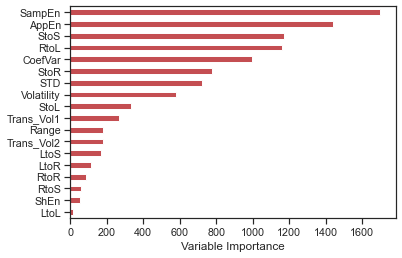

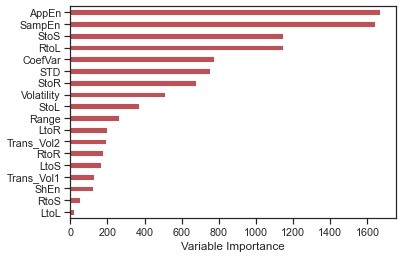

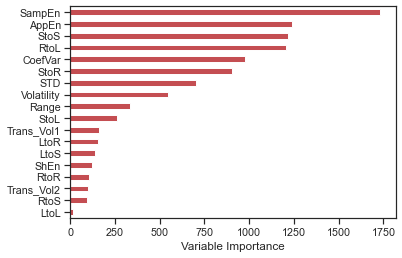

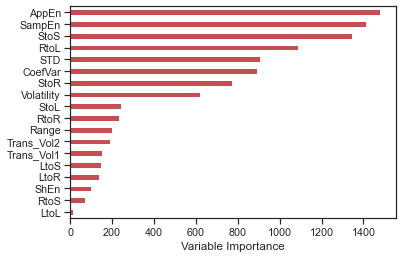

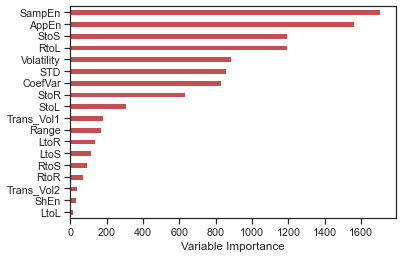

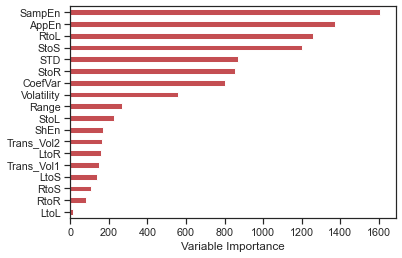

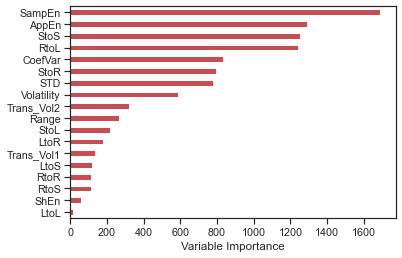

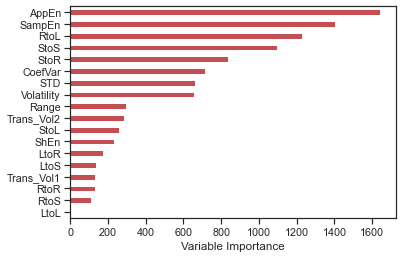

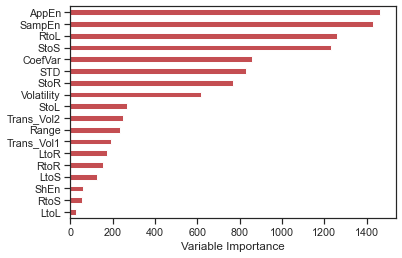

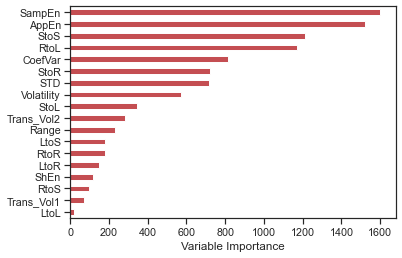

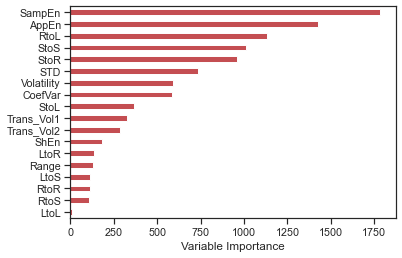

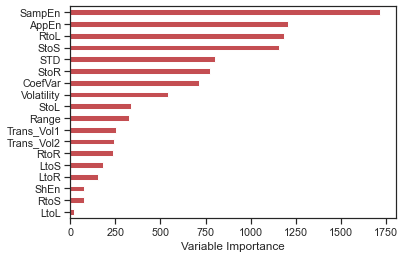

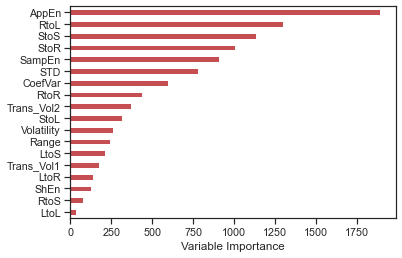

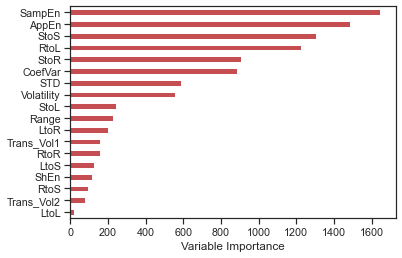

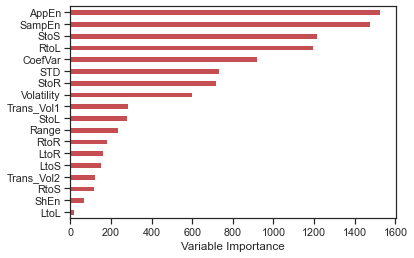

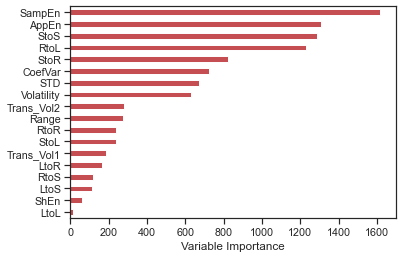

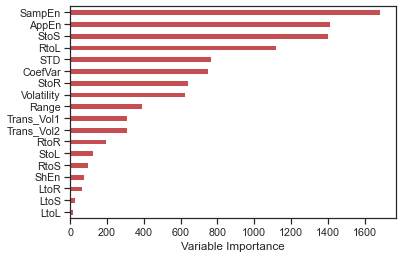

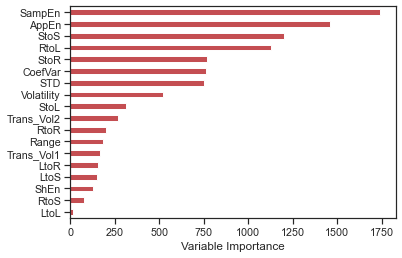

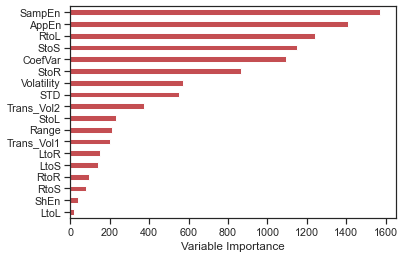

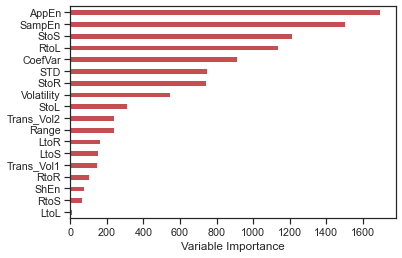

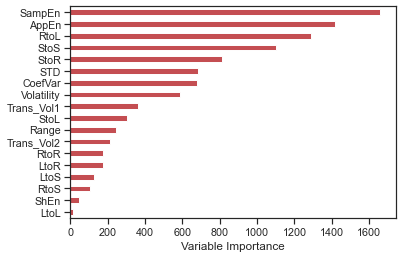

In [17]:
#Implementing cross validation 
kf = KFold(n_splits=23, shuffle=False)

from time import time
import timeit #imports timeit module
start_time = timeit.default_timer() #defines start time so computational time can be calculated

acc_score = [];
Truth = [];
Output = [];
iterations_list = []
max_depth_list = []
x_values = ['StoS', 'StoR', 'StoL', 'RtoS', 'RtoR', 'RtoL', 'LtoS',
       'LtoR', 'LtoL', 'STD', 'CoefVar', 'Range', 'Volatility', 'ShEn',
       'AppEn', 'SampEn',"Trans_Vol1","Trans_Vol2"]
y_values = ['Rhythm']
#for df in features_df_list:
df = features_maindf

for idx, subject in enumerate(good_list):
    
    train_index = ~df['Subject'].str.contains(subject)
    test_index = df['Subject'].str.contains(subject)
    X_train , X_test = df.loc[train_index,x_values], df.loc[test_index,x_values]
    y_train , y_test = df.loc[train_index,y_values].values.ravel(), df.loc[test_index,y_values].values.ravel()
    
    # Create CatBoost model
#     temp_model = CatBoostClassifier(learning_rate = 0.1, loss_function='Logloss')
#     param_distributions = {'iterations': randint(105, 110),
#                            'depth': randint(7,10)}
#     search = RandomizedSearchCV(estimator=temp_model, param_distributions=param_distributions, random_state=0)
#     search.fit(X_train, y_train)


    model = CatBoostClassifier(learning_rate=0.1, iterations=100, depth=5, loss_function='Logloss')
    model.fit(X_train, y_train)
    
#     iterations_list.append(search.best_params_['iterations'])
#     max_depth_list.append(search.best_params_['depth'])
    
    # make the prediction using the resulting model
    pred_values = model.predict(X_test)
    #preds_proba = model.predict_proba(test_data)
    #print("class = ", preds_class)
    #print("proba = ", preds_proba)
     
    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)
    
    Truth.extend(y_test.reshape(y_test.shape[0])); ## it is a list
    Output.extend(pred_values); ## it is a list  
    
    #print(model.feature_importances_)
    Importance = pd.DataFrame({'Importance':(model.feature_importances_*100)}, 
                          index = (X_train.columns))
    Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r')
    plt.xlabel('Variable Importance')
    plt.gca().legend_ = None
    #plt.savefig('plot1.png')


elapsed = timeit.default_timer() - start_time #gives total computation time
print("---Run time is %s seconds ---" % elapsed) #prints computation time
print()

print('Accuracy of each fold: \n {}'.format(acc_score))
print()
try: 
    print('Avg accuracy : \n{}'.format(np.mean(acc_score))); 
except: 
    print('hi')
print()
print('Std of accuracy : \n{}'.format(np.std(acc_score)))

In [14]:
print(confusion_matrix(Truth, Output))
print(classification_report(Truth, Output))
print(acc_score)
print(elapsed)

[[22984  1759]
 [ 1809 18416]]
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     24743
           1       0.91      0.91      0.91     20225

    accuracy                           0.92     44968
   macro avg       0.92      0.92      0.92     44968
weighted avg       0.92      0.92      0.92     44968

[0.9096109839816934, 0.9549695740365112, 0.9968513853904282, 0.935251798561151, 0.9968652037617555, 0.9488843813387424, 0.8229799159271368, 0.9972770592239619, 0.9427710843373494, 0.9702315325248071, 0.9832123411978222, 0.9892318736539842, 0.7759637188208617, 0.9726114649681529, 0.5120732722731057, 0.9906956136464333, 0.9910897875257025, 0.9849971148297749, 0.7379543533389687, 0.9763606377130292, 0.9965782720273738, 0.997489014438167, 0.9970401691331924]
11.320977700001094
